In [6]:


import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline



../data/stage1_train/00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e/images/00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e.png


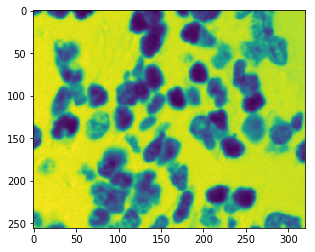

In [15]:

ID = '00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e'
FILE = "../data/stage1_train/{}/images/{}.png".format(ID,ID)
print(FILE)
img = cv2.imread(FILE,0)
plt.imshow(img)

In [16]:
# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(img,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

(Text(0.5,1,"Otsu's Thresholding"),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

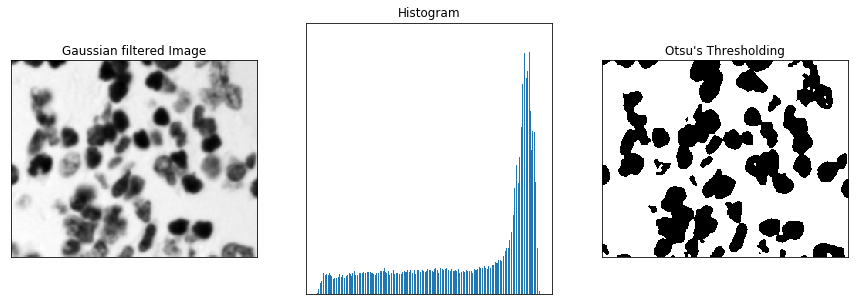

In [17]:
# Plot Here
plt.figure(figsize=(15,5))
images = [blur, 0, th3]
titles = ['Gaussian filtered Image','Histogram',"Otsu's Thresholding"]
plt.subplot(1,3,1),plt.imshow(images[0],'gray')
plt.title(titles[0]), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.hist(images[0].ravel(),256)
plt.title(titles[1]), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(images[2],'gray')
plt.title(titles[2]), plt.xticks([]), plt.yticks([])

number of detected contours:  39


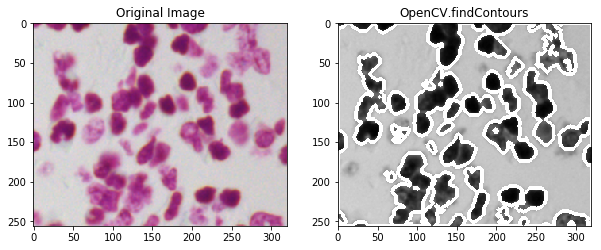

In [18]:


im = cv2.imread(FILE)
imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
image, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
img = cv2.drawContours(img, contours, -1, (255,255,255), 3)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1),plt.title('Original Image'),plt.imshow(im)#,'red')
plt.subplot(1,2,2),plt.title('OpenCV.findContours'),plt.imshow(img,'gray')#,'red')

print('number of detected contours: ',len(contours))



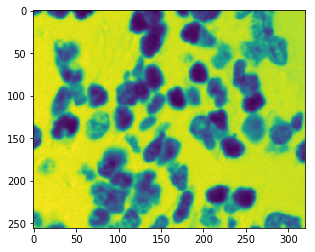

In [22]:
img = cv2.imread(FILE,0)
alpha = img
alpha = alpha.astype(float)/255
plt.imshow(alpha)

In [23]:
ID = '00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e'
FILE = "../data/stage1_train/{}/masks/".format(ID)
print(FILE)


../data/stage1_train/00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e/masks/


In [149]:
# Collection of methods for run length encoding. 
# For example, '1 3 10 5' implies pixels 1,2,3,10,11,12,13,14 are to be included 
# in the mask. The pixels are one-indexed and numbered from top to bottom, 
# then left to right: 1 is pixel (1,1), 2 is pixel (2,1), etc.

def rle_of_binary(x):
    """ Run length encoding of a binary 2D array. """
    dots = np.where(x.T.flatten() == 1)[0] # indices from top to down
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def mask_to_rle(mask, cutoff=.1, min_object_size=1.):
    """ Return run length encoding of mask. """
    # segment image and label different objects
    lab_mask = skimage.morphology.label(mask > cutoff)
    
    # Keep only objects that are large enough.
    (mask_labels, mask_sizes) = np.unique(lab_mask, return_counts=True)
    if (mask_sizes < min_object_size).any():
        mask_labels = mask_labels[mask_sizes < min_object_size]
        for n in mask_labels:
            lab_mask[lab_mask == n] = 0
        lab_mask = skimage.morphology.label(lab_mask > cutoff) 
        
    # Loop over each object excluding the background labeled by 0.
    for i in range(1, lab_mask.max() + 1):
        yield rle_of_binary(lab_mask == i)
        
def rle_to_mask(rle, img_shape):
    ''' Return mask from run length encoding.'''
    mask_rec = np.zeros(img_shape).flatten()
    for n in range(len(rle)):
        for i in range(0,len(rle[n]),2):
            for j in range(rle[n][i+1]): 
                mask_rec[rle[n][i]-1+j] = 1
    return mask_rec.reshape(img_shape[1], img_shape[0]).T

In [150]:
import os
from skimage.io import imread, imshow, imread_collection, concatenate_images

# Set some parameters
IMG_WIDTH = 320
IMG_HEIGHT = 256
IMG_CHANNELS = 3
from skimage.transform import resize
mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.bool)

#print(FILE)
import re
def sorted_aphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

dirlist = sorted_aphanumeric(os.listdir(FILE))
#print(dirlist)

train_dir = '../data/stage1_train/'
img_dir_name = 'images'
mask_dir_name = 'masks'
for i,dir_name in enumerate(next(os.walk(train_dir))[1]):
    img_dir = os.path.join(train_dir, dir_name, img_dir_name)
    mask_dir = os.path.join(train_dir, dir_name, mask_dir_name) 
    dirlist = sorted_aphanumeric(os.listdir(mask_dir))
    #print(img_dir,mask_dir)
    for mask_file in dirlist:
        fl = train_dir+dir_name+'/masks/'+mask_file
        #print(fl)
        #mask_ = imread(FILE + mask_file)
        mask_ = cv2.imread(fl,0)
        #plt.imshow(mask_)
        #mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        #plt.imshow(mask_)
        #mask = np.maximum(mask, mask_)
        rle = list(mask_to_rle(mask_, min_object_size=1))
        rle1 = pd.Series(rle).apply(lambda x: ' '.join(str(y) for y in x))
        print(dir_name, ',', rle1[0])
        #print(rle1[0])
    #break

#print(mask.shape)
#plt.imshow(mask)

00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552 , 6908 1 7161 8 7417 8 7672 9 7928 9 8184 9 8440 9 8696 9 8952 9 9209 8 9465 8 9722 7 9978 7 10235 6 10493 4 10752 1
00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552 , 36269 7 36523 11 36778 13 37033 15 37288 17 37543 18 37799 18 38054 19 38310 19 38565 20 38821 20 39077 20 39333 19 39589 19 39845 18 40101 18 40357 17 40614 15 40870 15 41127 13 41384 10 41641 8 41899 4
00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552 , 19919 6 20174 8 20429 10 20685 11 20941 12 21197 12 21453 13 21709 13 21965 13 22221 13 22477 13 22734 12 22990 12 23246 11 23503 9 23761 6
00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552 , 18671 6 18926 8 19181 9 19436 10 19691 11 19947 11 20203 12 20459 12 20715 12 20971 13 21227 14 21483 14 21739 14 21995 14 22252 13 22510 10 22768 7 23025 5 23284 2 23541 1
00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552 , 40158 3 40413 5 40669 5 40925 5 4

00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e , 63109 12 63364 14 63619 16 63874 18 64128 23 64383 25 64638 27 64892 29 65147 31 65403 32 65659 33 65915 33 66171 33 66427 33 66684 32 66940 32 67196 32 67452 32 67709 30 67966 28 68222 28 68479 26 68736 24 68993 20 69252 15
00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e , 62247 7 62502 12 62757 15 63013 16 63269 17 63525 18 63781 19 64037 20 64293 21 64549 22 64805 23 65061 24 65317 25 65573 26 65828 28 66084 29 66339 32 66595 33 66850 34 67106 34 67362 34 67618 33 67874 32 68131 30 68387 29 68643 28 68899 27 69155 26 69411 25 69667 24 69923 23 70178 23 70434 22 70690 21 70947 3 70953 6
00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e , 44316 4 44570 8 44824 11 45079 13 45334 14 45589 16 45844 17 46099 18 46355 18 46610 19 46865 20 47120 22 47376 24 47632 25 47888 25 48143 26 48399 26 48655 26 48911 26 49167 26 49424 24 49681 22 49938 19
00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d

0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed , 53285 7 53541 7 53797 7 54053 7 54309 7 54565 7
0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed , 62367 2 62618 7 62873 9 63126 13 63381 14 63635 17 63889 20 64144 20 64400 20 64655 22 64911 22 65167 22 65423 23 65679 23 65935 22 66191 21 66447 21 66704 19 66960 19 67216 17 67472 17 67728 17 67986 14 68244 12 68501 11 68758 10 69015 5
0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed , 77266 1 77521 4 77777 5 78032 6 78287 6 78544 5 78800 5 79056 5 79312 4
0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed , 45579 6 45835 9 46090 12 46345 16 46601 17 46857 17 47112 18 47368 18 47623 19 47879 18 48135 18 48390 19 48646 19 48902 20 49158 20 49414 21 49671 20 49927 20 50182 22 50439 21 50695 21 50952 21 51210 18 51233 4 51466 25 51722 20 51979 12 52236 11 52492 10 52750 8 53006 7 53262 7 53518 6
0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed , 22783 2 23037 4 

0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed , 44122 1 44376 4 44633 3 44886 1 44889 3 45141 2 45144 6 45396 9 45651 10 45907 1 45909 8 46165 7 46421 6 46677 3 46932 2 47187 2 47442 3
0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed , 78286 1 78542 2 78799 1 79052 2 79055 1 79308 4 79564 7 79820 8 80077 5
0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed , 19961 6 20216 6 20472 7 20727 9 20983 7 21238 9 21495 8 21751 7 22007 5 22264 7 22520 8 22775 8 23031 6 23287 5 23543 3
0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed , 6334 10 6589 11 6844 12 7100 12 7356 12 7612 12 7868 12 8124 12 8380 12 8636 12 8892 12 9148 12 9404 11 9661 10 9917 9 10174 8 10431 4
0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed , 17707 6 17962 10 18218 11 18474 11 18730 12 18985 15 19242 16 19497 17 19753 17 20010 17 20266 17 20523 16 20780 15 21037 15 21294 14 21550 13 21807 12 22063 12 22320 10 22576 10 22833 8 23092 4
0121d6

0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426 , 53311 6 53566 8 53822 10 54077 12 54332 13 54587 15 54842 17 55098 17 55354 17 55610 18 55866 18 56122 19 56378 19 56634 19 56890 19 57146 19 57402 18 57659 17 57915 17 58171 17 58427 16 58683 15 58939 14 59195 12 59452 10 59710 7 59967 6 60225 3
0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426 , 4061 6 4316 9 4572 11 4827 13 5082 15 5338 16 5594 16 5850 16 6106 16 6363 15 6619 15 6875 15 7131 14 7388 12 7645 10 7904 4
0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426 , 51187 5 51442 7 51697 11 51951 15 52206 17 52461 19 52717 20 52973 20 53230 19 53486 19 53742 19 53997 20 54253 20 54509 20 54765 20 55021 20 55277 20 55533 20 55789 20 56046 19 56302 19 56559 18 56815 18 57072 17 57328 17 57585 16 57842 15 58099 14 58356 12 58616 7
0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426 , 35786 6 36040 9 36295 11 36550 13 36805 15 37060 17 37316 17 37571 19 37827 19 38082 20 38338

02903040e19ddf92f452907644ad3822918f54af41dd85e5a3fe3e1b6d6f9339 , 148 35
03398329ced0c23b9ac3fac84dd53a87d9ffe4d9d10f1b5fe8df8fac12380776 , 48849 1 49100 1 49103 3 49354 9 49609 11 49865 11 50120 12 50376 12 50632 11 50889 10 51146 9 51403 8 51660 6
03398329ced0c23b9ac3fac84dd53a87d9ffe4d9d10f1b5fe8df8fac12380776 , 33522 5 33776 8 34031 10 34286 11 34542 11 34798 11 35054 11 35310 10 35566 9 35823 7 36081 3
03398329ced0c23b9ac3fac84dd53a87d9ffe4d9d10f1b5fe8df8fac12380776 , 1686 5 1940 8 2195 11 2450 12 2706 12 2962 12 3218 12 3475 10 3731 9 3988 7
03398329ced0c23b9ac3fac84dd53a87d9ffe4d9d10f1b5fe8df8fac12380776 , 23303 4 23558 8 23814 9 24070 9 24325 10 24581 10 24837 9 25093 8 25350 2
03398329ced0c23b9ac3fac84dd53a87d9ffe4d9d10f1b5fe8df8fac12380776 , 24321 4 24577 4 24833 4 25089 4 25345 5 25601 6 25857 6 26113 6 26369 6
03398329ced0c23b9ac3fac84dd53a87d9ffe4d9d10f1b5fe8df8fac12380776 , 57839 3 58092 8 58347 9 58602 10 58858 10 59114 10 59370 10 59626 10 59883 10 60141 6
03398329ced0

03f583ec5018739f4abb9b3b4a580ac43bd933c4337ad8877aa18b1dfb59fc9a , 24975 8 25333 11 25691 14 26050 16 26408 19 26767 21 27126 23 27484 25 27842 28 28201 29 28560 30 28919 31 29279 32 29638 33 29997 34 30357 34 30716 35 31075 36 31435 35 31795 35 32154 36 32514 35 32873 36 33233 36 33593 36 33952 37 34312 36 34672 36 35032 36 35392 36 35751 37 36111 37 36471 37 36831 37 37190 38 37550 38 37910 38 38271 37 38631 37 38991 37 39351 37 39711 38 40071 38 40432 37 40792 37 41152 37 41513 36 41874 35 42235 34 42595 34 42955 34 43316 33 43677 31 44038 30 44399 29 44760 27 45121 26 45481 25 45842 23 46204 20 46566 17 46931 11 47294 4
03f583ec5018739f4abb9b3b4a580ac43bd933c4337ad8877aa18b1dfb59fc9a , 120355 14 120712 20 121068 28 121427 31 121784 35 122143 37 122501 41 122860 43 123219 45 123579 46 123938 47 124297 49 124656 50 125015 52 125375 52 125735 52 126094 53 126454 53 126813 54 127173 54 127533 54 127893 54 128253 53 128613 53 128973 53 129333 52
03f583ec5018739f4abb9b3b4a580ac43bd933c43

0402a81e75262469925ea893b6706183832e85324f7b1e08e634129f5d522cdd , 68994 3 69253 4 69509 8 69768 9 70029 8 70290 6 70552 2
0402a81e75262469925ea893b6706183832e85324f7b1e08e634129f5d522cdd , 52036 8 52295 12 52554 14 52813 16 53073 17 53332 19 53592 20 53852 21 54112 22 54373 22 54633 22 54894 21 55155 20 55417 18 55678 16 55941 13 56203 10 56466 4
0402a81e75262469925ea893b6706183832e85324f7b1e08e634129f5d522cdd , 48822 6 49080 9 49338 13 49597 15 49856 16 50115 18 50374 19 50633 20 50893 20 51153 19 51413 19 51673 19 51935 16 52195 15 52460 7
0402a81e75262469925ea893b6706183832e85324f7b1e08e634129f5d522cdd , 29884 9 30143 11 30403 12 30662 13 30922 13 31182 13 31442 12 31702 12 31961 13 32220 13 32480 12 32740 11 33000 11 33261 10 33521 9 33782 7 34043 4
0402a81e75262469925ea893b6706183832e85324f7b1e08e634129f5d522cdd , 77684 15 77943 17 78203 18 78463 19 78723 20 78984 18 79245 17 79506 16 79767 13 80029 10 80289 4 80296 3 80556 1
0402a81e75262469925ea893b6706183832e85324f7b1e08e63412

0402a81e75262469925ea893b6706183832e85324f7b1e08e634129f5d522cdd , 32869 5 33127 9 33387 11 33647 13 33908 13 34168 14 34428 14 34689 14 34949 14 35209 14 35470 13 35730 12 35991 10 36251 9
0402a81e75262469925ea893b6706183832e85324f7b1e08e634129f5d522cdd , 60891 4 61150 5 61410 5 61670 5 61931 3
0402a81e75262469925ea893b6706183832e85324f7b1e08e634129f5d522cdd , 81543 1 81802 8 82060 10 82319 11 82578 13 82838 13 83096 15 83356 15 83616 15 83877 14 84138 13 84400 10 84661 9 84921 7 85181 6 85441 5 85701 3 85960 1
0402a81e75262469925ea893b6706183832e85324f7b1e08e634129f5d522cdd , 37585 1 37845 3 37854 1 38104 10 38363 11 38622 13 38881 14 39142 13 39402 13 39663 11 39924 9 40186 6 40448 2
0402a81e75262469925ea893b6706183832e85324f7b1e08e634129f5d522cdd , 65833 2 66092 4 66351 5 66611 5 66871 4 67132 3
0402a81e75262469925ea893b6706183832e85324f7b1e08e634129f5d522cdd , 82262 9 82521 11 82781 13 83041 15 83301 16 83562 16 83823 15 84084 14 84344 14 84607 11 84870 6
0402a81e75262469925ea893b

04acab7636c4cf61d288a5962f15fa456b7bde31a021e5deedfbf51288e4001e , 64546 6 64800 10 65055 12 65311 13
04acab7636c4cf61d288a5962f15fa456b7bde31a021e5deedfbf51288e4001e , 13070 8 13325 10 13581 12 13837 13 14093 13 14349 14 14606 14 14862 14 15119 12 15376 11 15633 9
04acab7636c4cf61d288a5962f15fa456b7bde31a021e5deedfbf51288e4001e , 47742 5 47997 7 48252 9 48507 11 48763 11 49019 11 49275 11 49531 11 49787 11 50043 11 50299 11 50555 10 50811 9 51068 8 51325 6
04acab7636c4cf61d288a5962f15fa456b7bde31a021e5deedfbf51288e4001e , 4049 5 4304 7 4560 8 4815 9 5071 9 5326 10 5582 10 5838 10 6094 9 6350 9 6606 8 6862 7 7118 5 7375 3
04acab7636c4cf61d288a5962f15fa456b7bde31a021e5deedfbf51288e4001e , 24924 4 25179 6 25434 8 25690 9 25946 9 26202 10 26458 10 26714 11 26970 11 27227 10 27483 10 27740 9 27996 9 28253 8 28510 6 28767 3
04acab7636c4cf61d288a5962f15fa456b7bde31a021e5deedfbf51288e4001e , 48743 4 48998 7 49253 9 49508 11 49763 13 50019 14 50275 14 50531 15 50787 15 51043 16 51299 17 51555 

0532c64c2fd0c4d3188cc751cdfd566b1cfba3d269358717295bab1504c7c275 , 8271 3 8624 12 8981 17 9337 23 9694 27 10051 30 10406 35 10763 38 11122 39 11481 40 11840 41 12199 42 12558 43 12916 45 13275 46 13634 47 13993 48 14353 48 14712 49 15072 49 15431 50 15791 50 16151 50 16511 50 16870 51 17230 51 17590 51 17950 51 18310 50 18670 49 19030 47 19391 44 19751 43 20111 42 20472 40 20832 38 21193 35 21554 31 21915 29 22276 26 22639 19 23000 13 23365 1 23368 1
0532c64c2fd0c4d3188cc751cdfd566b1cfba3d269358717295bab1504c7c275 , 14474 14 14831 20 15189 23 15547 25 15906 27 16264 30 16623 31 16981 33 17340 35 17699 36 18059 36 18416 39 18776 39 19134 41 19493 42 19853 42 20211 44 20571 44 20930 45 21290 45 21648 47 22008 47 22368 47 22726 49 23086 49 23445 50 23804 51 24164 51 24524 51 24885 50 25244 51 25604 51 25964 46 26011 4 26324 50 26683 51 27043 51 27403 50 27763 49 28123 49 28483 48 28843 48 29203 47 29563 47 29923 46 30283 45 30643 44 31005 41 31365 40 31726 39 32086 38 32446 37 32806 36 33

06350c7cc618be442c15706db7a68e91f313758d224de4608f9b960106d4f9ca , 62740 10 62994 13 63249 15 63505 15 63760 16 64016 17 64271 19 64527 19 64783 19 65039 18 65296 17
06350c7cc618be442c15706db7a68e91f313758d224de4608f9b960106d4f9ca , 15624 8 15879 11 16135 14 16391 15 16647 16 16903 16 17158 17 17413 19 17669 20 17925 20 18181 20 18437 20 18692 21 18948 21 19204 21 19460 21 19717 20 19973 20 20229 19 20485 19 20742 17 21000 14 21259 8
06350c7cc618be442c15706db7a68e91f313758d224de4608f9b960106d4f9ca , 9476 9 9731 11 9985 13 10241 14 10497 16 10753 17 11009 17 11265 18 11521 19 11777 19 12033 19 12289 19 12545 19 12801 19 13057 18 13313 17 13569 16 13825 12 14083 8 14340 2
06350c7cc618be442c15706db7a68e91f313758d224de4608f9b960106d4f9ca , 11165 3 11418 7 11673 9 11928 11 12183 12 12438 14 12693 16 12949 17 13205 17 13460 18 13715 19 13971 18 14228 16 14485 14 14741 14 14998 12 15254 12 15511 10 15767 10 16024 8 16283 4
06350c7cc618be442c15706db7a68e91f313758d224de4608f9b960106d4f9ca , 102

077f026f4ab0f0bcc0856644d99cbf639e443ec4f067d7b708bc6cecac609424 , 47530 5 47785 9 48040 11 48296 12 48552 12 48808 12 49064 13 49320 13 49577 12 49833 13 50089 13 50346 12 50603 10 50860 8 51117 6 51376 2
077f026f4ab0f0bcc0856644d99cbf639e443ec4f067d7b708bc6cecac609424 , 33605 4 33860 6 34115 8 34370 10 34626 10 34882 11 35137 12 35393 12 35649 12 35905 12 36161 12 36417 12 36674 11 36930 11 37187 9 37443 9 37700 8 37957 7 38217 2
077f026f4ab0f0bcc0856644d99cbf639e443ec4f067d7b708bc6cecac609424 , 6086 4 6340 8 6595 10 6851 11 7107 12 7363 12 7620 12 7877 11 8134 9 8391 8 8648 6 8906 3
07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5 , 348434 5 348952 8 349469 12 349988 13 350506 16 351025 17 351545 17 352064 17 352584 16 353105 15 353625 13 354145 11 354666 8 355186 5
07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5 , 49734 2 50252 7 50771 10 51291 11 51810 12 52330 13 52850 13 53366 17 53885 18 54405 18 54925 18 55445 18 55966 17 56486 17 57006 17 5752

07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5 , 292754 6 293272 9 293791 10 294310 11 294829 12 295349 12 295868 13 296388 13 296908 13 297427 14 297947 14 298467 14 298987 14 299507 14 300027 14 300547 14 301068 13 301588 13 302109 12 302629 12 303151 10 303672 8 304193 3
07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5 , 12051 6 12569 11 13088 12 13608 14 14127 16 14646 18 15166 18 15686 19 16206 19 16726 20 17246 20 17766 20 18286 20 18807 19 19327 19 19847 19 20367 19 20888 18 21408 18 21928 18 22448 18 22969 17 23490 16 24011 16 24531 15 25052 14 25573 13 26094 11 26615 9 27136 7
07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5 , 156891 5 157409 8 157928 11 158447 13 158967 13 159486 15 160005 17 160525 18 161045 19 161564 20 162084 21 162605 20 163125 21 163645 22 164165 22 164686 21 165206 21 165726 21 166247 20 166767 19 167287 19 167808 18 168328 17 168849 16 169370 14 169891 12 170413 8
07fb37aafa6626608af90c1e18f6a743f29b6b2

07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5 , 206402 5 206921 8 207440 10 207959 12 208478 13 208998 14 209518 15 210038 16 210558 16 211078 17 211598 17 212118 17 212638 17 213158 16 213678 16 214198 16 214718 15 215239 14 215760 13 216280 13 216801 12 217321 11 217842 9 218363 7 218885 1
07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5 , 288931 5 289450 8 289968 12 290487 14 291006 16 291526 16 292045 18 292564 20 293083 21 293603 21 294123 22 294642 23 295162 23 295681 24 296201 24 296721 24 297241 24 297761 23 298281 23 298802 21 299322 20 299843 18 300363 15 300884 12 301406 7
07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5 , 73406 6 73924 11 74443 14 74962 17 75481 20 76001 21 76521 22 77041 23 77561 23 78081 23 78601 24 79121 24 79642 23 80163 22 80683 22 81204 21 81725 20 82246 2 82257 8 82778 7 83298 7 83819 5 84339 4
07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5 , 136753 5 137269 11 137787 14 138305 16 1

07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5 , 101488 5 102006 7 102524 10 103042 12 103560 14 104080 14 104599 15 105118 16 105636 18 106155 19 106675 18 107194 18 107714 17 108234 16 108754 16 109274 15 109794 14 110314 13 110834 11 111354 10 111875 8 112396 4
07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5 , 244106 5 244622 11 245140 15 245658 21 246177 24 246696 27 247216 29 247735 31 248254 33 248774 33 249294 34 249814 34 250334 34 250854 34 251375 33 251897 31 252418 29 252940 26 253465 20 253991 11
07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5 , 199713 11 200230 15 200749 19 201267 21 201785 24 202305 24 202825 24 203344 25 203863 26 204383 26 204903 26 205423 26 205944 24 206465 23 206986 21 207507 19 208028 18 208549 15 209069 12 209595 1 209598 1
07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5 , 71737 5 72255 9 72773 12 73293 12 73813 13 74332 15 74851 16 75371 16 75891 17 76411 17 76930 19 77450 19 779

07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5 , 319763 5 320281 9 320800 12 321320 13 321840 16 322359 19 322878 21 323398 23 323917 25 324437 27 324958 28 325478 28 325998 29 326520 27 327040 27 327560 27 328082 25 328603 24 329124 23 329645 22 330167 19 330688 17 331212 11 331734 8
07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5 , 215039 3 215557 6 216077 7 216596 9 217116 9 217636 9 218155 10 218674 10 219194 10 219714 10 220233 11 220753 11 221273 11 221792 12 222312 12 222832 11 223352 11 223872 11 224392 11 224912 11 225432 10 225952 9 226473 7
07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5 , 149457 12 149976 19 150494 22 151014 24 151534 25 152054 25 152574 25 153094 26 153614 26 154135 25 154656 24 155177 23 155699 20 156220 19 156742 15 157264 12 157786 6
07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5 , 201021 3 201539 7 202058 9 202577 11 203096 12 203615 13 204134 14 204654 14 205173 15 205693 16 206213 

07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5 , 317272 10 317789 15 318309 18 318829 20 319349 23 319869 24 320389 25 320909 26 321428 27 321948 27 322468 28 322988 27 323509 26 324029 25 324549 25 325070 23 325590 22 326111 19 326632 16 327153 11 327674 6
07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5 , 45465 3 45984 6 46503 8 47022 10 47542 10 48061 12 48580 14 49100 15 49620 15 50139 17 50659 17 51179 17 51699 18 52218 19 52738 19 53257 20 53777 20 54297 20 54817 19 55337 19 55857 19 56377 19 56897 18 57417 18 57937 16 58458 14 58979 11 59500 9 60021 6
07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5 , 45035 3 45554 7 46073 8 46593 9 47113 11 47633 16 48154 16 48674 16 49195 15 49716 14 50237 14 50758 13 51279 12 51800 1 51802 8 52325 5 52846 4
07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5 , 12120 9 12638 14 13157 16 13677 18 14197 19 14717 20 15237 20 15757 21 16277 21 16798 21 17318 21 17839 20 18359 20 18880 

07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5 , 38408 3 38925 7 39444 9 39963 11 40483 11 41003 11 41522 13 42042 13 42561 14 43081 14 43601 14 44120 15 44640 15 45160 15 45680 15 46200 15 46720 14 47240 13 47761 12 48281 11 48802 9 49324 6
07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5 , 156924 4 157442 8 157962 9 158482 10 159002 11 159523 10 160043 11 160562 12 161082 12 161601 13 162120 14 162639 15 163158 17 163677 18 164196 19 164715 20 165234 21 165754 20 166274 20 166795 18 167315 17 167836 15 168357 13 168878 9
07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5 , 209610 1 209613 9 210129 16 210648 18 211166 1 211168 20 211686 22 212205 24 212725 24 213244 25 213764 25 214286 23 214806 22 215325 24 215845 24 216366 22 216886 22 217406 20 217927 19 218447 18 218968 14 219489 12 220010 9
07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5 , 20264 1 20782 5 21301 8 21821 9 22340 11 22860 12 23379 14 23899 14 24418 16 

07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5 , 90863 7 91381 10 91897 15 92416 17 92935 18 93454 20 93974 20 94493 21 95013 22 95533 22 96053 22 96573 23 97093 23 97613 23 98134 22 98654 22 99175 21 99695 21 100216 20 100736 20 101257 19 101778 17 102299 15 102821 12 103343 7
07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5 , 309680 5 310198 8 310717 12 311236 15 311755 16 312274 18 312793 20 313313 21 313832 22 314352 22 314871 24 315390 25 315910 25 316429 25 316949 24 317469 23 317989 23 318509 22 319029 21 319550 20 320070 19 320591 16 321111 16 321632 14 322154 7 322675 4
07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5 , 77773 8 78291 13 78809 16 79328 18 79848 19 80367 21 80887 22 81407 23 81927 23 82447 24 82967 24 83488 23 84007 24 84527 25 85048 24 85568 24 86089 23 86610 21 87131 20 87652 18 88174 14 88696 11 89217 7
07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5 , 36869 3 37387 7 37906 9 38426 10 38945 12

07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5 , 88573 7 89093 9 89613 12 90133 13 90653 15 91174 15 91694 17 92214 19 92735 19 93255 20 93776 21 94296 22 94817 22 95338 22 95859 21 96380 20 96901 20 97423 18 97947 14 98471 8
07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5 , 132623 9 133141 14 133660 15 134179 17 134698 18 135217 19 135736 20 136256 21 136775 22 137294 22 137813 23 138332 23 138852 23 139372 23 139891 24 140411 23 140931 23 141451 22 141972 20 142492 20 143013 18 143534 16 144055 14 144576 12 145098 8
07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5 , 338479 2 338996 8 339514 11 340033 12 340551 14 341069 17 341588 18 342107 19 342626 20 343146 19 343666 19 344186 18 344706 18 345226 17 345746 16 346266 16 346786 15 347307 13 347828 11 348348 10 348869 8 349390 5
07fb37aafa6626608af90c1e18f6a743f29b6b233d2e427dcd1102df6a916cf5 , 255512 1 255514 3 256030 8 256548 11 257067 13 257586 15 258106 15 258625 17 259145 18 2596

08275a5b1c2dfcd739e8c4888a5ee2d29f83eccfa75185404ced1dc0866ea992 , 483234 3 484256 6 485279 9 486301 12 487324 13 488347 15 489370 16 490394 17 491418 17 492442 18 493466 17 494490 17 495514 17 496538 17 497562 16 498586 15 499610 14 500634 14 501658 14 502683 13 503707 12 504733 9 505758 8 506783 6 507808 3
08275a5b1c2dfcd739e8c4888a5ee2d29f83eccfa75185404ced1dc0866ea992 , 711944 5 712966 9 713989 10 715012 12 716036 13 717060 15 718082 18 719106 18 720130 18 721154 18 722178 18 723202 18 724226 18 725250 18 726274 17 727298 18 728322 18 729346 17 730370 16 731394 16 732419 13 733443 12 734470 8 735495 6 736522 1
08275a5b1c2dfcd739e8c4888a5ee2d29f83eccfa75185404ced1dc0866ea992 , 106864 6 107887 10 108911 11 109934 13 110958 13 111982 14 113005 15 114029 16 115053 16 116077 16 117101 16 118126 15 119150 15 120175 12 121201 8
08275a5b1c2dfcd739e8c4888a5ee2d29f83eccfa75185404ced1dc0866ea992 , 545603 10 546626 13 547649 15 548670 19 549694 19 550718 19 551742 19 552766 19 553790 12 554819

08275a5b1c2dfcd739e8c4888a5ee2d29f83eccfa75185404ced1dc0866ea992 , 608075 1 609094 11 610113 17 611135 21 612157 24 613181 24 614204 26 615227 27 616251 27 617274 29 618298 29 619323 28 620348 28 621374 25 622400 23 623425 20 624452 16 625477 13 626502 3
08275a5b1c2dfcd739e8c4888a5ee2d29f83eccfa75185404ced1dc0866ea992 , 230654 2 231671 13 232693 16 233716 18 234739 20 235763 21 236787 21 237811 21 238835 21 239859 21 240884 20 241909 19 242934 17 243959 15 244985 12 246012 7
08275a5b1c2dfcd739e8c4888a5ee2d29f83eccfa75185404ced1dc0866ea992 , 517542 4 518558 14 519580 18 520603 21 521626 22 522649 24 523673 27 524696 28 525720 28 526744 29 527768 29 528792 30 529816 30 530840 30 531865 29 532890 28 533914 28 534939 27 535964 26 536989 24 538015 22 539040 20 540066 17 541093 13 542120 10
08275a5b1c2dfcd739e8c4888a5ee2d29f83eccfa75185404ced1dc0866ea992 , 787094 6 788116 8 789139 9 790163 9 791187 9 792211 9 793236 8 794261 7 795286 5
08275a5b1c2dfcd739e8c4888a5ee2d29f83eccfa75185404ced1dc0

08275a5b1c2dfcd739e8c4888a5ee2d29f83eccfa75185404ced1dc0866ea992 , 596807 4 597824 13 598848 13 599871 14 600895 14 601919 14 602943 14 603967 14 604991 14 606015 14 607039 13 608064 11 609089 5
08275a5b1c2dfcd739e8c4888a5ee2d29f83eccfa75185404ced1dc0866ea992 , 826029 1 827052 8 828076 9 829100 8 830124 8 831148 7 832172 7 833196 7 834220 6 835245 2
08275a5b1c2dfcd739e8c4888a5ee2d29f83eccfa75185404ced1dc0866ea992 , 954389 7 955408 15 956430 19 957452 21 958475 23 959498 24 960522 24 961545 25 962568 26 963593 24 964616 25 965640 24 966662 25 967687 24 968712 21 969736 21 970762 18 971787 15 972812 14 973845 1
08275a5b1c2dfcd739e8c4888a5ee2d29f83eccfa75185404ced1dc0866ea992 , 130134 7 131155 12 132176 17 133198 20 134221 22 135244 24 136268 24 137292 24 138316 25 139340 24 140364 25 141389 24 142413 24 143437 23 144460 24 145485 23 146510 22 147536 20 148561 18 149587 15 150615 10
08275a5b1c2dfcd739e8c4888a5ee2d29f83eccfa75185404ced1dc0866ea992 , 707178 12 708200 16 709223 19 710246 21 

091944f1d2611c916b98c020bd066667e33f4639159b2a92407fe5a40788856d , 352440 4 353462 7 354484 10 355507 12 356531 12 357555 12 358579 12 359603 12 360628 11 361653 10 362678 9 363703 8 364728 6 365755 2
091944f1d2611c916b98c020bd066667e33f4639159b2a92407fe5a40788856d , 49134 3 50157 4 51181 4 52205 4 53229 6 54253 6 55277 6 56302 5 57326 5
091944f1d2611c916b98c020bd066667e33f4639159b2a92407fe5a40788856d , 755022 7 756042 15 757065 19 758087 22 759110 24 760133 26 761157 26 762180 27 763203 29 764227 29 765252 28 766276 28 767300 27 768324 27 769348 27 770372 27 771397 25 772421 25 773446 23 774470 22 775495 20 776521 17 777546 15 778574 8
091944f1d2611c916b98c020bd066667e33f4639159b2a92407fe5a40788856d , 766534 3 767554 10 768576 14 769597 19 770620 21 771643 23 772666 25 773689 27 774712 27 775736 26 776759 26 777782 27 778806 26 779830 25 780854 24 781878 21 782902 20 783927 18 784956 12 785986 5
091944f1d2611c916b98c020bd066667e33f4639159b2a92407fe5a40788856d , 626302 3 627324 7 62834

091944f1d2611c916b98c020bd066667e33f4639159b2a92407fe5a40788856d , 596256 4 597279 5 598303 5 599326 7 600350 7 601374 7 602397 8 603421 8 604445 8 605469 8 606492 9 607516 9 608540 9 609564 9 610587 10 611611 9 612635 9 613659 9 614683 8 615707 8 616731 7 617755 7 618779 7 619803 7 620827 7 621851 6 622875 6 623899 6 624924 5 625948 5 626973 3
091944f1d2611c916b98c020bd066667e33f4639159b2a92407fe5a40788856d , 841336 4 842358 8 843381 10 844404 12 845426 14 846450 14 847474 13 848498 13 849522 13 850546 12 851572 9 852596 8 853622 4
094afe36759e7daffe12188ab5987581d405b06720f1d5acf3f2614f404df380 , 54198 6 54454 7 54710 8 54966 8 55222 8 55479 7 55736 5
094afe36759e7daffe12188ab5987581d405b06720f1d5acf3f2614f404df380 , 59868 4 60122 7 60377 8 60632 9 60888 8 61144 7 61402 2
094afe36759e7daffe12188ab5987581d405b06720f1d5acf3f2614f404df380 , 40375 5 40630 6 40884 9 41139 10 41395 8 41651 7 41907 6 42164 4
094afe36759e7daffe12188ab5987581d405b06720f1d5acf3f2614f404df380 , 54669 3 54924 5 

0b0d577159f0d6c266f360f7b8dfde46e16fa665138bf577ec3c6f9c70c0cd1e , 257689 4 258208 6 258726 9 259245 11 259764 12 260284 12 260803 13 261322 14 261842 14 262361 15 262881 15 263400 16 263920 16 264440 16 264960 16 265479 17 265999 17 266518 18 267038 17 267557 18 268077 17 268597 16 269116 16 269636 15 270156 14 270677 12 271198 9 271719 7
0b0d577159f0d6c266f360f7b8dfde46e16fa665138bf577ec3c6f9c70c0cd1e , 57350 2 57869 9 58387 12 58906 16 59425 18 59945 19 60464 21 60984 22 61503 23 62023 23 62543 24 63062 25 63582 26 64102 27 64622 27 65142 28 65662 29 66183 28 66703 28 67223 28 67744 27 68264 27 68784 27 69304 27 69825 27 70345 27 70866 26 71387 25 71908 24 72428 25 72949 24 73470 22 73992 19 74513 18 75036 14 75557 12 76079 9
0b2e702f90aee4fff2bc6e4326308d50cf04701082e718d4f831c8959fbcda93 , 59379 1 59632 7 59886 10 60140 12 60395 13 60651 14 60906 15 61162 15 61418 15 61674 15 61931 14 62187 14 62443 13 62700 11 62957 10 63214 6
0b2e702f90aee4fff2bc6e4326308d50cf04701082e718d4f831c

0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6 , 78108 2 78363 4 78618 5 78874 5 79129 7 79385 7 79641 7 79896 8 80152 8 80407 9 80663 9 80918 10 81174 10 81429 11 81685 10
0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6 , 58367 2 58622 3 58878 3 59133 4 59389 4 59644 5 59900 5 60155 6 60410 7 60665 8 60920 9 61176 9 61431 10 61687 10 61942 11 62197 12 62452 13 62708 13 62964 13 63220 13 63475 13 63731 12 63987 12 64242 12 64498 11 64754 11 65009 12 65265 11 65520 12 65776 11 66031 11 66287 11 66543 10 66798 11 67054 10 67310 9 67565 10 67821 9 68076 10 68332 9 68588 8 68844 7 69099 7 69354 8 69610 7 69866 6 70121 7 70377 6 70633 5 70890 2
0bf33d3db4282d918ec3da7112d0bf0427d4eafe74b3ee0bb419770eefe8d7d6 , 5903 2 6158 4 6414 4 6669 5 6925 6 7180 7 7436 7 7691 8 7947 8 8203 8 8458 9 8714 9 8970 9 9226 9 9481 10 9737 10 9993 10 10248 11 10504 11 10759 12 11015 12 11270 13 11526 13 11781 14 12037 14 12293 13 12549 13 12804 14 13060 14 13316 13 13572 13 13

0bf4b144167694b6846d584cf52c458f34f28fcae75328a2a096c8214e01c0d0 , 30904 6 31157 12 31412 15 31666 18 31921 19 32176 20 32432 21 32687 23 32943 23 33199 24 33454 26 33710 26 33966 26 34222 27 34478 27 34735 26 34991 26 35247 25 35504 23 35761 21 36019 17 36281 6
0bf4b144167694b6846d584cf52c458f34f28fcae75328a2a096c8214e01c0d0 , 24640 9 24895 12 25149 15 25404 17 25660 18 25915 19 26171 20 26427 20 26682 21 26938 22 27194 22 27450 22 27707 21 27963 20 28219 20 28476 19 28732 18 28989 2 28997 9 29254 7 29511 4
0bf4b144167694b6846d584cf52c458f34f28fcae75328a2a096c8214e01c0d0 , 31563 10 31818 13 32071 17 32326 19 32581 20 32836 21 33092 21 33347 22 33603 23 33859 23 34115 23 34371 23 34627 23 34884 21 35140 21 35397 19 35654 18 35911 16 36168 13 36425 10
0bf4b144167694b6846d584cf52c458f34f28fcae75328a2a096c8214e01c0d0 , 37558 12 37812 16 38067 18 38322 19 38577 21 38833 21 39089 21 39345 21 39601 21 39857 21 40113 21 40369 21 40626 20 40882 20 41138 20 41395 18 41652 17 41909 15 42166 13 4

0c2550a23b8a0f29a7575de8c61690d3c31bc897dd5ba66caec201d201a278c2 , 79641 8 79894 14 80148 17 80401 20 80656 22 80909 25 81164 26 81418 28 81673 28
0c2550a23b8a0f29a7575de8c61690d3c31bc897dd5ba66caec201d201a278c2 , 52156 5 52409 10 52664 13 52920 14 53175 15 53430 17 53686 17 53942 17 54198 18 54454 18 54710 18 54966 18 55223 17 55479 17 55736 17 55992 18 56249 17 56506 16 56762 16 57020 14 57277 13 57534 11 57792 8 58050 4
0c2550a23b8a0f29a7575de8c61690d3c31bc897dd5ba66caec201d201a278c2 , 46124 7 46373 17 46627 20 46881 24 47134 28 47387 31 47642 32 47897 33 48153 33 48408 34 48664 33 48920 32 49176 31 49432 29 49687 27 49943 21 50197 20 50451 20 50706 20 50963 18 51223 12
0c2550a23b8a0f29a7575de8c61690d3c31bc897dd5ba66caec201d201a278c2 , 73216 1 73471 2 73726 3 73982 3 74238 3 74494 3 74750 3 75006 3 75262 3 75518 3 75774 3 76029 4 76283 6 76539 6 76794 7 77050 7 77306 7 77562 7 77818 7 78074 7 78331 6 78588 5
0c2550a23b8a0f29a7575de8c61690d3c31bc897dd5ba66caec201d201a278c2 , 6569 5 6

0d2bf916cc8de90d02f4cd4c23ea79b227dbc45d845b4124ffea380c92d34c8c , 47629 3 47636 2 47987 15 48344 20 48703 23 49061 26 49420 27 49778 30 50137 32 50496 33 50854 36 51213 38 51572 39 51931 41 52291 41 52650 42 53009 43 53368 44 53728 44 54087 45 54446 46 54805 47 55165 47 55525 47 55884 47 56243 48 56603 49 56963 50 57323 50 57682 51 58041 51 58401 51 58761 50 59120 51 59480 51 59840 50 60200 49 60559 50 60918 50 61278 50 61638 49 61997 50 62357 49 62717 49 63077 49 63437 48 63796 48 64156 47 64516 47 64876 46 65236 45 65596 45 65956 44 66316 44 66676 44 67036 43 67396 42 67756 42 68117 40 68477 38 68838 36 69199 34 69559 33 69920 30 70282 27 70643 25 71006 21 71369 9 71382 2
0d2bf916cc8de90d02f4cd4c23ea79b227dbc45d845b4124ffea380c92d34c8c , 112298 3 112654 9 112999 29 113034 7 113353 37 113393 8 113710 51 114069 52 114428 53 114787 54 115147 54 115506 55 115866 55 116225 56 116584 57 116944 57 117304 57 117664 57 118024 57 118384 57 118745 56 119105 56 119465 56 119826 55 120186 55 120

0e21d7b3eea8cdbbed60d51d72f4f8c1974c5d76a8a3893a7d5835c85284132e , 70073 3 70328 5 70583 7 70839 7 71094 8 71350 8 71607 6 71864 4
0e21d7b3eea8cdbbed60d51d72f4f8c1974c5d76a8a3893a7d5835c85284132e , 19011 9 19263 15 19517 19 19771 22 20025 24 20274 32 20529 33 20785 33 21041 33 21297 33 21554 32 21812 29 22069 27 22326 25 22584 21 22843 16 23101 11 23361 5
0e21d7b3eea8cdbbed60d51d72f4f8c1974c5d76a8a3893a7d5835c85284132e , 40515 5 40770 6 41024 8 41279 9 41534 10 41789 11 42044 12 42299 13 42554 14 42810 14 43065 15 43320 16 43576 16 43831 17 44087 16 44342 17 44598 17 44853 17 45109 17 45365 16 45620 17 45876 16 46132 16 46388 15 46643 15 46899 15 47155 14 47411 13 47667 12 47923 11 48180 8 48437 4
0e21d7b3eea8cdbbed60d51d72f4f8c1974c5d76a8a3893a7d5835c85284132e , 36168 3 36423 5 36679 5 36934 6 37189 7 37445 7 37700 8 37955 9 38210 10 38465 10 38720 11 38975 12 39231 12 39486 12 39742 11 39998 11 40254 10 40510 5 40767 3
0e21d7b3eea8cdbbed60d51d72f4f8c1974c5d76a8a3893a7d5835c85284132e 

0e4c2e2780de7ec4312f0efcd86b07c3738d21df30bb4643659962b4da5505a3 , 27352 7 27606 12 27860 14 28115 16 28370 17 28625 18 28880 19 29136 19 29392 19 29650 17 29907 16 30165 14 30422 12 30679 11 30935 10 31191 10 31447 8 31703 7
0e4c2e2780de7ec4312f0efcd86b07c3738d21df30bb4643659962b4da5505a3 , 58083 4 58338 5 58593 7 58849 7 59105 7 59360 8 59616 8 59872 8 60127 9 60383 9 60639 9 60895 9 61151 8 61408 7 61664 5 61921 3
0e4c2e2780de7ec4312f0efcd86b07c3738d21df30bb4643659962b4da5505a3 , 46255 7 46507 12 46760 15 47015 17 47270 18 47526 18 47781 19 48037 19 48293 19 48549 19 48805 19 49061 19 49317 19 49572 20 49828 20 50084 19 50341 18 50597 17 50854 16 51110 15 51367 13 51623 13 51880 12 52136 11 52392 10 52647 11 52904 9 53165 3
0e4c2e2780de7ec4312f0efcd86b07c3738d21df30bb4643659962b4da5505a3 , 56272 7 56523 13 56775 17 57029 19 57284 19 57537 21 57792 21 58047 20 58303 19 58560 16 58816 14 59073 10
0e4c2e2780de7ec4312f0efcd86b07c3738d21df30bb4643659962b4da5505a3 , 14 9 268 14 523 17 778

0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 , 249561 4 250079 7 250598 9 251117 10 251634 14 252153 16 252673 17 253193 17 253713 18 254233 18 254753 19 255273 19 255793 19 256313 19 256833 19 257353 19 257873 19 258393 20 258913 19 259433 19 259953 18 260474 16 260994 15 261515 13 262037 10 262560 4
0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 , 57494 6 58012 9 58531 12 59050 14 59570 15 60090 16 60609 18 61129 19 61649 19 62169 20 62689 21 63209 21 63729 21 64250 21 64770 21 65290 22 65811 21 66332 21 66852 21 67373 20 67894 19 68414 19 68936 17 69458 15 69980 12 70502 10 71023 7 71545 3
0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 , 162810 4 163324 12 163841 17 164359 21 164878 24 165398 24 165918 26 166438 27 166958 29 167479 29 167999 29 168519 29 169040 28 169561 27 170082 27 170602 27 171124 25 171644 25 172165 24 172686 23 173207 22 173728 21 174249 20 174770 18 175292 16 175812 15 176334 11 176856 8
0ea221716cf137102

0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 , 98993 3 99511 7 100029 9 100548 11 101067 12 101586 14 102105 15 102625 15 103145 15 103665 15 104185 14 104705 13 105226 11 105748 8
0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 , 165713 3 166231 7 166749 10 167268 12 167787 15 168305 18 168825 19 169344 20 169864 20 170383 20 170903 20 171423 20 171943 19 172463 19 172983 18 173503 18 174023 17 174543 17 175063 17 175584 15 176104 15 176624 13 177145 11 177666 8
0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 , 299585 4 300104 6 300624 7 301144 8 301663 10 302183 10 302703 11 303222 12 303742 13 304262 13 304782 13 305302 13 305821 14 306341 14 306861 14 307381 14 307902 13 308421 13 308941 13 309462 12 309982 11 310503 10 311024 9 311545 8 312067 5
0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 , 87479 7 87997 12 88516 16 89036 17 89554 19 90074 20 90595 19 91115 20 91635 20 92157 18 92679 16 93201 14 93721 15 94

0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 , 132886 6 133403 11 133920 15 134437 18 134956 20 135474 21 135992 23 136511 23 137030 24 137550 22 138070 21 138590 19 139111 16 139632 14 140153 12 140674 10 141197 7
0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 , 18191 7 18711 8 19230 10 19750 10 20269 11 20788 12 21308 12 21828 12 22348 12 22868 12 23388 12 23908 12 24429 11 24950 10 25472 8 25993 7 26516 3
0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 , 117572 5 118091 8 118610 11 119129 14 119648 17 120168 19 120687 21 121207 22 121727 24 122248 23 122768 24 123288 24 123808 25 124329 25 124849 25 125370 24 125891 22 126412 20 126933 18 127455 14 127978 8
0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 , 139262 6 139780 10 140299 12 140818 13 141337 15 141856 16 142376 16 142895 17 143415 17 143934 17 144454 17 144974 17 145493 18 146012 18 146532 18 147052 18 147572 18 148092 18 148613 17 149133 16 149655 14 

0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 , 335288 4 335806 8 336325 10 336843 13 337362 15 337881 16 338401 15 338920 16 339440 16 339959 18 340479 18 340998 19 341518 19 342037 20 342557 20 343077 19 343597 19 344117 18 344637 18 345158 16 345678 16 346198 15 346719 14 347240 13 347760 12 348281 10 348802 8 349323 6
0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 , 143210 11 143728 18 144247 23 144767 25 145286 27 145806 28 146327 28 146848 27 147368 28 147889 27 148410 25 148932 21 149454 17 149976 9
0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 , 250540 2 251057 7 251576 8 252096 9 252614 11 253134 11 253653 12 254172 13 254691 14 255211 14 255730 15 256250 15 256769 15 257289 15 257809 14 258328 15 258848 14 259367 15 259887 15 260407 14 260927 14 261447 14 261967 14 262487 13 263007 13 263527 13 264047 12 264567 12 265087 11 265608 9 266128 8 266649 6 267171 2
0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714

0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 , 128482 5 128999 12 129517 17 130036 20 130556 22 131076 24 131595 25 132115 26 132635 26 133155 28 133675 28 134195 29 134715 29 135235 30 135756 29 136277 29 136797 29 137319 28 137840 27 138361 26 138882 25 139403 24 139924 23 140445 22 140966 20 141488 17 142010 14 142532 9
0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 , 307030 5 307547 10 308065 14 308584 16 309104 18 309623 19 310143 20 310662 21 311182 21 311702 22 312223 21 312743 21 313263 21 313783 21 314304 20 314824 20 315344 19 315866 17 316387 15 316908 14 317430 10 317952 6
0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 , 336057 9 336067 1 336575 17 337093 20 337613 21 338132 24 338651 26 339170 27 339690 28 340210 29 340729 30 341249 30 341769 31 342289 31 342809 31 343329 31 343849 31 344370 29 344891 28 345412 26 345932 26 346454 23 346976 21 347498 17 348021 12 348544 1 348546 4
0ea221716cf13710214dcd331a61cea48308c

0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 , 170299 2 170817 15 171336 20 171855 22 172374 25 172894 26 173414 26 173934 27 174455 26 174975 26 175495 26 176016 25 176537 23 177057 23 177578 21 178099 19 178620 17 179143 12 179666 6
0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 , 189509 5 190027 9 190546 10 191065 12 191584 13 192103 14 192623 14 193142 16 193662 16 194182 16 194702 17 195222 17 195743 16 196264 16 196785 15 197305 15 197826 15 198346 15 198866 15 199386 16 199906 16 200426 16 200946 16 201466 15 201986 15 202505 16 203024 16 203544 15 204065 10
0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 , 118003 6 118521 10 119040 11 119559 13 120078 14 120598 15 121117 16 121636 17 122156 17 122676 17 123196 18 123716 18 124236 18 124756 18 125276 18 125796 18 126316 18 126837 16 127357 16 127878 14 128398 13 128919 11 129441 7 129963 3
0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 , 120296 4 120813 9 1

0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 , 352489 5 353007 8 353527 9 354047 10 354567 10 355087 11 355607 11 356127 12 356647 12 357167 12 357687 12 358207 12 358728 11 359248 12 359768 11 360288 11 360808 11 361329 11 361849 11
0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 , 162521 9 163038 13 163557 15 164076 17 164595 19 165114 20 165634 20 166154 19 166675 17 167195 17 167716 15 168236 14 168758 10 169279 7 169801 3
0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 , 97457 6 97976 8 98496 8 99016 9 99535 10 100055 10 100574 11 101093 12 101612 12 102132 12 102651 13 103170 13 103689 14 104204 18 104722 19 105242 6 105252 8 105762 5 105774 5 106282 3
0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 , 164394 10 164912 13 165431 15 165950 17 166470 17 166989 18 167508 20 168028 20 168548 20 169068 20 169588 20 170109 19 170629 18 171149 18 171669 17 172189 16 172709 15 173229 15 173749 13 174270 11 174790 10 17

0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 , 93682 4 94201 7 94720 9 95240 11 95759 13 96279 13 96798 14 97318 14 97838 14 98358 14 98878 15 99398 15 99918 14 100438 14 100959 13 101479 13 101999 13 102519 13 103040 11 103560 11 104080 11 104600 11 105121 10 105641 10 106162 8 106683 4
0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 , 122916 8 123434 10 123952 13 124472 13 124991 14 125510 15 126029 16 126548 17 127067 18 127587 18 128106 18 128626 18 129145 18 129664 19 130184 18 130704 17 131224 16 131744 16 132264 15 132784 15 133304 14 133824 13 134344 13 134864 12 135384 11 135904 9 136424 8 136944 7 137465 5 137986 3
0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 , 42462 7 42980 9 43499 11 44019 11 44538 12 45057 13 45577 13 46096 14 46616 14 47135 15 47655 14 48174 16 48694 16 49213 17 49733 17 50252 17 50772 17 51293 16 51813 15 52334 14 52854 14 53375 12 53896 11 54417 9 54939 5 55461 1
0ea221716cf13710214dcd331a61cea483

0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 , 227 14 747 14 1268 12 1789 10 2311 5
0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 , 214757 2 215275 5 215794 6 216313 7 216831 9 217351 9 217870 10 218390 10 218909 11 219428 12 219948 12 220468 12 220988 12 221508 12 222028 12 222548 12 223068 12 223588 12 224108 12 224628 12 225148 11 225669 10 226190 8 226710 6 227231 3
0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 , 218629 12 219146 18 219664 21 220183 24 220702 25 221221 27 221740 29 222260 29 222780 30 223300 30 223820 30 224340 30 224861 29 225382 28 225904 26 226426 23 226949 18
0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 , 78878 6 79398 7 79917 9 80436 11 80956 12 81476 13 81995 15 82515 15 83034 16 83554 17 84074 17 84594 17 85113 18 85634 17 86155 16 86676 14 87198 11 87719 9 88241 5
0ea221716cf13710214dcd331a61cea48308c3940df1d28cfc7fd817c83714e1 , 87058 7 87576 10 88094 12 88613 13 89131 15 89650 1

10328b822b836e67b547b4144e0b7eb43747c114ce4cacd8b540648892945b00 , 45733 2 45989 3 46245 3 46501 3 46757 3 47013 3 47269 3 47525 3 47781 3 48036 4 48291 5 48548 3
10328b822b836e67b547b4144e0b7eb43747c114ce4cacd8b540648892945b00 , 9181 6 9435 10 9690 13 9945 15 10201 16 10456 17 10711 18 10967 19 11222 20 11478 20 11734 20 11990 20 12246 20 12502 20 12758 19 13015 18 13272 17 13530 13 13789 7
10328b822b836e67b547b4144e0b7eb43747c114ce4cacd8b540648892945b00 , 35194 1 35448 9 35702 13 35957 15 36212 16 36467 18 36723 18 36978 19 37234 19 37490 19 37746 18 38002 18 38258 17 38515 15 38772 13 39028 12 39285 10 39542 7 39800 5
10328b822b836e67b547b4144e0b7eb43747c114ce4cacd8b540648892945b00 , 46013 6 46268 8 46523 10 46779 10 47035 11 47291 11 47546 11 47802 11 48058 11 48315 9 48573 6
10328b822b836e67b547b4144e0b7eb43747c114ce4cacd8b540648892945b00 , 23545 8 23800 9 24055 10 24310 11 24566 11 24821 12 25077 12 25333 12 25589 12 25845 12 26101 12 26359 10 26615 10 26870 11 27127 10 27383 10 

10ba6cbee4873b32d5626a118a339832ba2b15d8643f66dddcd7cb2ec80fbc28 , 91760 4 92277 10 92794 14 93313 16 93831 18 94349 21 94868 22 95387 23 95906 24 96425 25 96944 26 97464 26 97984 26 98504 26 99024 25 99544 25 100065 24 100585 24 101106 23 101627 21 102149 19 102670 17 103192 14 103714 11 104236 7
10ba6cbee4873b32d5626a118a339832ba2b15d8643f66dddcd7cb2ec80fbc28 , 277554 2 278071 7 278590 8 279109 9 279628 10 280148 10 280669 9 281189 7 281710 5 282230 2
10ba6cbee4873b32d5626a118a339832ba2b15d8643f66dddcd7cb2ec80fbc28 , 8893 9 9412 11 9930 15 10449 17 10969 17 11489 18 12008 20 12528 21 13048 21 13568 22 14087 23 14607 24 15127 24 15647 25 16167 25 16687 26 17207 26 17727 26 18248 25 18768 25 19288 26 19809 25 20329 25 20849 25 21369 25 21890 24 22410 24 22931 23 23451 23 23972 22 24492 22 25012 21 25533 20 26053 19 26574 18 27095 16 27616 14 28139 9 28661 5
10ba6cbee4873b32d5626a118a339832ba2b15d8643f66dddcd7cb2ec80fbc28 , 113155 2 113673 8 114192 15 114711 17 115230 19 115749 20 11626

10ba6cbee4873b32d5626a118a339832ba2b15d8643f66dddcd7cb2ec80fbc28 , 250356 5 250874 9 251393 12 251913 14 252433 17 252952 20 253472 21 253992 21 254511 22 255031 22 255550 23 256070 23 256589 23 257109 23 257629 23 258148 23 258668 23 259188 23 259708 22 260229 21 260750 20 261271 18 261794 15 262317 12 262841 7 263364 4 263886 1
10ba6cbee4873b32d5626a118a339832ba2b15d8643f66dddcd7cb2ec80fbc28 , 71778 10 72297 13 72816 15 73335 18 73854 21 74374 22 74893 25 75413 26 75933 27 76453 28 76973 28 77494 28 78014 29 78534 30 79055 29 79576 29 80096 29 80617 29 81138 28 81659 27 82180 26 82700 26 83221 25 83742 24 84264 22 84785 21 85306 19 85827 18 86349 15 86871 12 87393 9
10ba6cbee4873b32d5626a118a339832ba2b15d8643f66dddcd7cb2ec80fbc28 , 126082 8 126600 12 127119 15 127637 18 128156 21 128676 22 129195 24 129715 25 130234 26 130754 27 131273 29 131793 29 132313 30 132832 32 133352 32 133872 32 134392 33 134912 33 135432 34 135952 34 136473 33 136993 33 137513 34 138034 33 138555 32 139075 

12aeefb1b522b283819b12e4cfaf6b13c1264c0aadac3412b4edd2ace304cb40 , 244505 3 245024 9 245544 10 246064 10 246584 11 247104 13 247623 15 248142 16 248661 17 249180 19 249700 19 250220 20 250740 21 251260 21 251780 21 252300 20 252820 18 253340 17 253860 17 254381 16 254903 14 255424 12 255945 9
12aeefb1b522b283819b12e4cfaf6b13c1264c0aadac3412b4edd2ace304cb40 , 77456 5 77975 9 78495 11 79015 13 79534 15 80054 15 80574 16 81094 16 81614 17 82134 17 82655 16 83175 15 83696 14 84217 13 84738 11 85261 3
12aeefb1b522b283819b12e4cfaf6b13c1264c0aadac3412b4edd2ace304cb40 , 306940 2 307459 4 307978 6 308497 8 309017 9 309536 11 310056 11 310576 12 311096 13 311616 13 312136 13 312656 13 313176 13 313696 13 314216 13 314736 14 315256 14 315776 13 316296 13 316816 12 317336 12 317856 11 318376 11 318896 10 319416 9 319936 8 320457 6 320978 4
12aeefb1b522b283819b12e4cfaf6b13c1264c0aadac3412b4edd2ace304cb40 , 111360 10 111879 13 112398 16 112918 20 113438 21 113958 22 114478 22 114998 22 115519 22 116

12aeefb1b522b283819b12e4cfaf6b13c1264c0aadac3412b4edd2ace304cb40 , 128161 10 128680 12 129196 18 129714 21 130233 23 130752 24 131271 25 131790 27 132309 28 132828 29 133347 29 133867 29 134387 29 134907 28 135427 28 135947 28 136467 29 136987 38 137506 39 138026 38 138546 27 139067 24 139588 22 140110 19 140634 8 140644 4 141165 3 141685 3 142205 3 142725 3 143245 3 143765 4 144285 5 144806 4 145326 4 145847 4 146368 3 146889 1
12aeefb1b522b283819b12e4cfaf6b13c1264c0aadac3412b4edd2ace304cb40 , 104882 7 105400 11 105919 13 106438 15 106956 17 107475 18 107994 19 108513 21 109032 22 109551 23 110071 22 110590 23 111110 23 111629 23 112149 22 112669 21 113189 20 113709 18 114229 16 114750 12 115271 6
12aeefb1b522b283819b12e4cfaf6b13c1264c0aadac3412b4edd2ace304cb40 , 269541 6 270059 11 270577 14 271095 17 271614 18 272133 20 272653 22 273173 23 273692 24 274212 24 274733 23 275254 22 275776 19 276297 17 276817 16 277338 12 277860 1
12aeefb1b522b283819b12e4cfaf6b13c1264c0aadac3412b4edd2ace

12aeefb1b522b283819b12e4cfaf6b13c1264c0aadac3412b4edd2ace304cb40 , 232152 8 232670 12 233189 16 233708 18 234228 22 234747 25 235267 26 235787 27 236307 28 236827 29 237347 30 237867 30 238387 31 238907 31 239427 32 239948 31 240468 31 240989 30 241510 29 242031 29 242552 28 243073 27 243594 26 244115 25 244636 23 245157 21 245679 18 246201 15 246723 11 247247 3
12aeefb1b522b283819b12e4cfaf6b13c1264c0aadac3412b4edd2ace304cb40 , 189437 11 189955 16 190474 19 190993 22 191512 24 192031 26 192551 27 193071 28 193590 30 194110 30 194630 31 195151 30 195671 31 196192 30 196712 30 197233 29 197754 27 198276 25 198797 23 199319 20 199842 16 200365 9
12aeefb1b522b283819b12e4cfaf6b13c1264c0aadac3412b4edd2ace304cb40 , 6221 2 6739 7 7258 10 7777 12 8296 14 8814 17 9333 19 9852 20 10371 21 10890 22 11410 22 11929 23 12449 23 12969 23 13489 23 14009 22 14529 22 15050 21 15570 20 16090 20 16611 19 17131 18 17651 18 18172 16 18693 13 19213 12 19734 10 20256 5
12aeefb1b522b283819b12e4cfaf6b13c1264c0aa

12aeefb1b522b283819b12e4cfaf6b13c1264c0aadac3412b4edd2ace304cb40 , 48847 4 49364 9 49882 13 50400 17 50919 19 51438 21 51958 22 52478 23 52998 23 53518 24 54038 24 54559 23 55079 24 55599 24 56120 23 56640 23 57161 22 57682 21 58203 19 58725 16 59247 13 59768 11 60290 7
12aeefb1b522b283819b12e4cfaf6b13c1264c0aadac3412b4edd2ace304cb40 , 87676 3 88195 6 88715 7 89234 9 89753 10 90272 12 90791 13 91311 14 91832 13 92352 13 92872 13 93392 13 93912 13 94432 13 94953 12 95474 11 95994 11 96514 11 97034 11 97555 10 98076 8 98597 7 99119 4 99640 2
12aeefb1b522b283819b12e4cfaf6b13c1264c0aadac3412b4edd2ace304cb40 , 249970 5 250488 8 251007 11 251526 13 252045 14 252564 15 253083 17 253603 17 254122 18 254641 19 255161 19 255681 19 256200 20 256720 20 257240 20 257760 20 258280 20 258800 20 259320 20 259840 21 260361 20 260881 21 261401 22 261922 21 262443 20 262963 20 263484 17 264005 16 264526 15 265047 11 265569 8 266091 5
12aeefb1b522b283819b12e4cfaf6b13c1264c0aadac3412b4edd2ace304cb40 , 437 

12f89395ad5d21491ab9cec137e247652451d283064773507d7dc362243c5b8e , 12692 1 12945 4 13200 6 13455 12 13711 10 13967 9 14223 9 14479 9 14736 7 14993 6 15250 5
12f89395ad5d21491ab9cec137e247652451d283064773507d7dc362243c5b8e , 35532 5 35787 8 36043 8 36298 9 36555 8 36811 7
12f89395ad5d21491ab9cec137e247652451d283064773507d7dc362243c5b8e , 4035 6 4287 11 4543 10 4798 11 5054 11 5310 11 5567 11 5823 10 6079 9 6335 8 6591 6 6847 6 7099 9 7354 6 7608 9 7864 9 8120 9 8376 9 8633 8 8889 7 9146 5
12f89395ad5d21491ab9cec137e247652451d283064773507d7dc362243c5b8e , 53129 3 53384 5 53640 5 53896 5 54153 3
12f89395ad5d21491ab9cec137e247652451d283064773507d7dc362243c5b8e , 39209 6 39463 8 39717 12 39973 12 40229 13 40485 13 40741 13 40998 11 41255 10 41512 8
12f89395ad5d21491ab9cec137e247652451d283064773507d7dc362243c5b8e , 33375 3 33628 8 33884 9 34139 10 34396 9 34652 9 34908 8 35165 7
12f89395ad5d21491ab9cec137e247652451d283064773507d7dc362243c5b8e , 47788 4 48043 5 48298 6 48554 7 48810 7 49067 7

136000dc18fa6def2d6c98d4d0b2084d13c22eaffe82e26c665bcaa2a9e51261 , 70466 6 70721 9 70976 11 71231 13 71487 13 71743 13 71999 13 72255 13 72511 13 72767 13 73024 12 73280 12 73536 11 73797 6 74055 3
136000dc18fa6def2d6c98d4d0b2084d13c22eaffe82e26c665bcaa2a9e51261 , 35366 7 35620 10 35874 12 36129 13 36382 15 36637 16 36892 17 37146 19 37401 20 37656 21 37911 22 38166 23 38422 23 38677 24 38932 25 39188 24 39443 24 39699 23 39955 23 40212 20 40472 14 40729 12
136000dc18fa6def2d6c98d4d0b2084d13c22eaffe82e26c665bcaa2a9e51261 , 5031 4 5286 6 5541 7 5797 7 6053 7 6308 8 6564 8 6819 9 7075 8 7331 8 7587 8 7842 9 8098 9 8354 9 8610 9 8865 10 9121 10 9377 10 9633 10 9888 10 10144 10 10400 10 10656 10 10911 11 11167 10 11423 10 11679 10 11935 10 12191 10 12447 10 12703 10 12959 10 13215 10 13471 9 13727 8 13982 9 14238 9 14494 9 14750 9 15006 8 15262 8 15518 8 15774 8 16030 7 16285 8 16541 8 16797 8 17052 8 17308 8 17564 7 17820 7 18076 7 18332 6 18589 4
136000dc18fa6def2d6c98d4d0b2084d13c22eaff

1400420310c9094361a8a243545187f1d4c2365e081b3bb08c5fa29c7491a55b , 302144 8 302653 15 303162 19 303672 23 304182 13 304196 12 304692 30 305201 33 305710 38 306221 39 306731 42 307241 44 307752 46 308262 49 308772 51 309283 53 309794 54 310306 42 310349 12 310817 56 311329 57 311840 59 312352 41 312394 18 312863 62 313375 63 313887 64 314399 65 314910 67 315422 68 315934 69 316446 69 316958 69 317470 15 317486 53 317982 69 318494 65 318560 3 319007 68 319520 67 320033 66 320545 66 321058 39 321098 24 321570 64 322082 64 322596 61 323108 61 323621 60 324133 59 324646 57 325158 44 325204 10 325671 54 326184 24 326209 26 326697 47 327225 30
1400420310c9094361a8a243545187f1d4c2365e081b3bb08c5fa29c7491a55b , 322568 6 323077 12 323588 16 324098 20 324609 21 325121 23 325633 24 326145 27 326658 26 327170 26
1400420310c9094361a8a243545187f1d4c2365e081b3bb08c5fa29c7491a55b , 58245 12 58751 20 59262 22 59772 26 60280 31 60791 33 61302 36 61813 37 62322 1 62325 38 62832 43 63344 1 63346 42 63858 4

14cc1424c59808274e123db51292e9dbb5b037ef3e7c767a8c45c9ac733b91bf , 45219 5 45573 16 45928 24 46286 27 46643 32 47002 34 47362 36 47721 39 48080 42 48439 44 48798 46 49158 47 49517 49 49877 49 50236 51 50596 52 50956 52 51316 53 51675 54 52035 55 52395 55 52755 55 53115 56 53475 56 53835 56 54195 56 54555 56 54916 55 55276 54 55636 54 55996 54 56357 53 56717 52 57077 52 57438 51 57798 51 58159 49 58519 49 58880 47 59241 45 59602 44 59963 42 60325 39 60687 36 61050 32 61412 28 61773 26 62134 23 62495 21 62856 18 63219 13 63582 7
15039b3acccc4257a1a442646a89b6e596b5eb4531637e6d8fa1c43203722c99 , 71851 3 72106 5 72361 6 72616 8 72871 10 73126 11 73381 12 73636 13 73891 14 74146 15 74401 16 74656 16 74911 17 75166 17 75422 17 75678 16 75935 14 76192 11
15039b3acccc4257a1a442646a89b6e596b5eb4531637e6d8fa1c43203722c99 , 78 17 335 15
15039b3acccc4257a1a442646a89b6e596b5eb4531637e6d8fa1c43203722c99 , 36088 6 36341 10 36596 12 36851 14 37105 16 37360 17 37615 18 37863 26 38118 27 38374 27 38629 

150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a8c1fb3225cbe5df3e3f , 11810 11 12326 17 12842 22 13360 25 13877 29 14396 30 14914 32 15433 33 15953 33 16472 34 16991 35 17511 35 18031 34 18551 34 19071 33 19591 31 20111 30 20631 28 21150 27 21670 25 22190 23 22711 21 23233 15 23757 8
150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a8c1fb3225cbe5df3e3f , 262156 4 262674 13 263192 18 263711 23 264230 26 264750 27 265269 28 265789 29 266309 29 266829 29 267349 29 267870 27 268390 26 268910 25 269431 23 269951 22 270472 20 270993 17 271515 11 272036 9 272561 2
150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a8c1fb3225cbe5df3e3f , 284454 7 284970 12 285489 14 286008 16 286528 16 287047 18 287566 19 288086 19 288605 20 289125 20 289644 21 290163 22 290682 23 291201 24 291721 24 292241 24 292761 23 293281 23 293801 23 294321 23 294841 23 295361 22 295881 21 296401 20 296921 19 297441 18 297961 17 298482 13 299003 9
150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a8c1fb3225cbe5df3e3f , 90537 9 91056 13 91576

150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a8c1fb3225cbe5df3e3f , 152 11 671 13 1190 15 1709 16 2229 16 2748 17 3267 18 3786 19 4305 20 4825 20 5345 19 5864 19 6384 18 6903 18 7423 17 7943 16 8463 16 8983 15 9503 15 10022 15 10542 14 11062 13 11583 11 12104 9 12625 6
150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a8c1fb3225cbe5df3e3f , 66572 8 67091 13 67611 15 68130 17 68650 18 69170 18 69690 19 70210 20 70731 19 71251 19 71772 19 72292 19 72812 20 73333 19 73854 18 74374 18 74895 18 75416 17 75936 17 76457 16 76978 15 77499 15 78020 14 78540 14 79061 12 79582 11 80104 8
150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a8c1fb3225cbe5df3e3f , 122164 6 122682 12 123201 14 123720 16 124240 17 124759 19 125279 19 125799 19 126318 21 126838 21 127358 21 127878 21 128398 21 128918 22 129439 21 129959 21 130479 21 131000 20 131520 21 132040 21 132560 21 133081 20 133602 19 134123 17 134644 16 135165 15 135686 14 136208 11 136732 6
150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a8c1fb3225cbe5df3e3f , 1

150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a8c1fb3225cbe5df3e3f , 259789 5 260305 16 260822 21 261341 23 261860 25 262379 26 262899 27 263419 27 263938 28 264458 28 264977 29 265497 29 266018 28 266539 26 267060 24 267581 22 268102 20 268625 9
150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a8c1fb3225cbe5df3e3f , 354481 12 354995 21 355512 26 356029 30 356548 31 357067 32 357587 33 358106 34 358626 34 359146 34 359666 34 360186 34 360707 33 361227 33 361748 31
150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a8c1fb3225cbe5df3e3f , 24805 7 25318 19 25836 24 26354 27 26873 29 27391 31 27910 32 28430 32 28949 33 29469 33 29989 32 30509 31 31028 31 31547 31 32067 30 32587 28 33107 25 33628 22 34149 19 34670 15
150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a8c1fb3225cbe5df3e3f , 145078 3 145597 4 146116 5 146636 5 147155 6 147675 6 148195 6 148714 7 149234 7 149754 7 150274 7 150794 7 151315 6 151835 6 152355 6 152876 5 153397 4 153917 4 154438 3 154959 2
150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a

150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a8c1fb3225cbe5df3e3f , 294725 2 295240 11 295759 13 296277 15 296796 17 297315 18 297834 20 298354 21 298873 22 299393 22 299912 23 300432 23 300951 24 301471 23 301990 24 302510 24 303030 23 303549 24 304069 23 304589 22 305109 21 305629 20 306149 19 306669 18 307189 18 307710 16 308230 14 308751 12 309273 7
150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a8c1fb3225cbe5df3e3f , 134479 11 134994 20 135511 24 136029 27 136548 29 137068 29 137588 29 138107 30 138627 30 139146 31 139666 31 140186 30 140706 30 141226 30 141746 29 142267 27 142787 26 143308 24 143829 22 144350 20 144871 16 145393 12 145915 7 146437 4
150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a8c1fb3225cbe5df3e3f , 320 11 840 12 1359 14 1875 19 2394 21 2914 22 3434 22 3954 23 4474 23 4994 23 5514 24 6034 24 6554 24 7075 23 7595 23 8116 22 8636 22 9156 22 9677 20 10197 20 10717 20 11238 18 11758 18 12278 17 12799 15 13320 13 13844 7
150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a8c1fb32

150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a8c1fb3225cbe5df3e3f , 257837 3 258356 6 258876 7 259395 9 259914 12 260434 13 260954 14 261474 15 261994 16 262514 17 263035 16 263555 17 264075 17 264595 18 265115 19 265635 20 266156 19 266676 20 267196 21 267717 21 268237 21 268758 20 269278 20 269798 20 270318 20 270839 19 271359 19 271880 18 272400 17 272921 16 273442 14 273963 12 274484 10 275006 7
150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a8c1fb3225cbe5df3e3f , 255206 7 255725 10 256244 12 256764 13 257284 14 257804 15 258323 16 258843 17 259363 17 259883 18 260403 18 260922 19 261442 19 261962 19 262482 20 263002 20 263522 20 264042 20 264562 20 265083 19 265603 19 266123 19 266644 18 267164 19 267684 19 268204 19 268725 18 269245 18 269765 18 270285 18 270806 17 271327 16 271848 15 272369 14 272890 13 273413 9
150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a8c1fb3225cbe5df3e3f , 337660 9 338178 13 338697 15 339217 16 339736 18 340255 20 340775 21 341295 21 341815 21 342335 21 342855 

150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a8c1fb3225cbe5df3e3f , 36241 11 36759 14 37277 16 37794 19 38311 22 38828 25 39347 26 39866 27 40385 27 40904 28 41423 28 41943 26 42463 25 42983 23 43503 21 44024 18 44544 17 45064 16 45585 13 46106 6 46627 2
150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a8c1fb3225cbe5df3e3f , 295938 6 296457 8 296976 10 297495 12 298014 13 298533 14 299050 17 299569 18 300089 18 300608 19 301128 18 301648 17 302168 16 302689 11 303209 10 303730 8 304251 6 304772 4
150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a8c1fb3225cbe5df3e3f , 146696 11 147216 11 147736 10 148255 11 148775 12 149294 13 149813 14 150332 15 150852 16 151371 17 151890 18 152410 18 152930 18 153449 19 153969 18 154489 18 155009 18 155529 18 156049 17 156569 16 157090 14 157610 13 158131 8 158654 3
150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a8c1fb3225cbe5df3e3f , 8299 3 8810 15 9329 17 9848 19 10367 21 10887 22 11407 23 11926 25 12446 26 12966 27 13486 27 14007 27 14527 27 15048 26 15569 26 16

150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a8c1fb3225cbe5df3e3f , 298945 6 299462 13 299981 15 300498 19 301017 21 301536 23 302055 24 302574 25 303094 25 303613 26 304133 25 304653 25 305172 26 305692 25 306212 25 306732 24 307252 23 307773 21 308293 19 308814 16 309335 13 309856 10
150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a8c1fb3225cbe5df3e3f , 21499 5 22017 9 22535 12 23053 14 23572 16 24091 17 24610 18 25129 19 25649 19 26168 20 26687 21 27206 22 27725 22 28245 21 28764 22 29284 21 29804 21 30324 20 30844 19 31364 18 31884 17 32403 17 32923 17 33443 16 33964 14 34484 13 35005 11 35526 9 36047 7
150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a8c1fb3225cbe5df3e3f , 233174 6 233692 10 234212 12 234732 13 235252 14 235772 15 236292 16 236812 16 237332 16 237852 17 238373 16 238894 14 239417 10
150b0ffa318c87b31d78af0e87d60390dbcd84b5f228a8c1fb3225cbe5df3e3f , 53084 10 53602 14 54121 17 54641 18 55160 20 55680 21 56200 22 56720 22 57240 22 57760 22 58280 22 58800 22 59320 22 59840 22 6

16c3d5935ba94b720becc24b7a05741c26149e221e3401924080f41e2f891368 , 44801 1 45057 1 45313 2 45569 2 45825 2 46081 2 46337 2 46593 2 46849 2 47105 2 47361 2 47617 1
16c3d5935ba94b720becc24b7a05741c26149e221e3401924080f41e2f891368 , 27000 5 27254 10 27509 12 27764 14 28019 15 28275 16 28530 17 28786 17 29042 17 29298 17 29554 17 29810 17 30067 16 30323 15 30580 13 30837 11 31094 9 31351 7
1740b0a67ca337ea31648b57c81bcfbb841c7bb5cad185199a9f4da596d531b9 , 57409 6 57664 7 57919 10 58174 12 58430 13 58686 13 58942 13 59199 13 59455 13 59712 11 59969 9 60226 7 60483 5
1740b0a67ca337ea31648b57c81bcfbb841c7bb5cad185199a9f4da596d531b9 , 55407 2 55661 7 55916 10 56171 12 56427 13 56683 14 56939 14 57196 14 57452 14 57708 15 57965 14 58222 12 58479 11 58737 8 58996 4
1740b0a67ca337ea31648b57c81bcfbb841c7bb5cad185199a9f4da596d531b9 , 1228 4 1483 8 1738 10 1993 12 2249 13 2505 14 2761 14 3017 14 3274 13 3531 12 3787 12 4044 10 4301 9 4559 4
1740b0a67ca337ea31648b57c81bcfbb841c7bb5cad185199a9f4da596d

175dbb364bfefc9537931144861c9b6e08934df3992782c669c6fe4234319dfc , 246921 7 247438 11 247955 14 248473 17 248992 18 249511 18 250029 20 250548 21 251067 21 251587 21 252106 22 252625 22 253144 23 253664 22 254183 23 254703 22 255223 21 255742 22 256262 21 256782 20 257302 20 257821 20 258341 19 258861 19 259381 18 259901 17 260421 16 260942 14 261462 13 261983 11 262503 10 263024 7
175dbb364bfefc9537931144861c9b6e08934df3992782c669c6fe4234319dfc , 202394 6 202912 9 203431 11 203950 12 204467 16 204986 17 205504 19 206023 20 206543 20 207062 21 207582 20 208102 20 208622 20 209141 20 209661 20 210181 20 210701 20 211221 20 211741 20 212261 20 212782 19 213302 20 213823 19 214343 19 214864 18 215385 17 215907 15 216429 12 216950 11 217471 9 217993 6
175dbb364bfefc9537931144861c9b6e08934df3992782c669c6fe4234319dfc , 296689 10 297205 17 297723 20 298241 24 298760 26 299278 29 299797 30 300316 31 300835 33 301355 33 301874 34 302394 34 302914 33 303433 34 303953 33 304473 32 304993 32 30551

175dbb364bfefc9537931144861c9b6e08934df3992782c669c6fe4234319dfc , 343414 6 343934 19 344455 18 344976 18 345496 18 346016 18 346535 19 347055 19 347574 20 348093 21 348612 22 349132 22 349652 22 350173 21 350693 21 351214 20 351734 20 352254 20 352774 19 353294 18 353814 17 354334 17 354854 16 355374 15 355895 13 356416 12 356939 8
175dbb364bfefc9537931144861c9b6e08934df3992782c669c6fe4234319dfc , 249859 2 250378 13 250897 19 251416 21 251935 23 252455 24 252975 25 253495 26 254015 27 254535 27 255055 28 255575 29 256095 30 256615 30 257135 31 257655 32 258175 32 258695 33 259215 33 259736 32 260257 31 260777 31 261298 30 261819 28 262340 26 262862 23 263383 21 263907 1 263916 5
175dbb364bfefc9537931144861c9b6e08934df3992782c669c6fe4234319dfc , 156480 6 156999 8 157518 11 158037 13 158557 13 159077 14 159598 13 160122 9 160643 8 161164 7 161685 5 162206 3
175dbb364bfefc9537931144861c9b6e08934df3992782c669c6fe4234319dfc , 103587 3 104105 7 104622 16 105141 18 105661 19 106181 22 106701

175dbb364bfefc9537931144861c9b6e08934df3992782c669c6fe4234319dfc , 177435 14 177954 17 178473 20 178993 22 179513 23 180032 25 180552 26 181072 27 181593 27 182114 27 182635 27 183156 27 183676 27 184197 27 184718 26 185239 25 185761 23 186282 22 186803 21 187324 20 187845 18 188367 15 188890 9
175dbb364bfefc9537931144861c9b6e08934df3992782c669c6fe4234319dfc , 81548 12 82067 16 82587 17 83106 20 83626 21 84146 21 84666 22 85186 23 85706 24 86227 23 86748 23 87268 24 87789 23 88310 22 88831 22 89352 21 89873 21 90394 20 90914 20 91434 20 91955 19 92475 19 92995 18 93515 17 94035 16 94556 14 95076 13 95597 11 96117 9 96638 7
175dbb364bfefc9537931144861c9b6e08934df3992782c669c6fe4234319dfc , 254963 6 255481 9 256000 11 256520 12 257039 13 257558 15 258077 16 258597 17 259116 18 259635 19 260153 21 260672 22 261190 24 261706 28 262225 28 262744 28 263264 27 263784 26 264304 25 264824 25 265344 25 265864 25 266384 24 266905 22 267425 19 267946 16 268467 13 268988 10
175dbb364bfefc9537931144

175dbb364bfefc9537931144861c9b6e08934df3992782c669c6fe4234319dfc , 212769 2 213288 4 213808 5 214328 8 214848 11 215361 4 215367 14 215880 22 216400 23 216921 23 217441 24 217961 25 218480 27 218999 28 219519 28 220039 29 220559 29 221080 29 221600 29 222120 29 222641 28 223161 28 223681 28 224201 28 224721 28 225242 27 225763 25 226284 24 226806 21 227328 19 227850 16 228373 11 228895 3
175dbb364bfefc9537931144861c9b6e08934df3992782c669c6fe4234319dfc , 208503 2 209021 8 209540 10 210059 12 210578 14 211098 14 211617 15 212137 15 212657 15 213176 16 213696 16 214216 15 214739 12 215260 10 215781 7
175dbb364bfefc9537931144861c9b6e08934df3992782c669c6fe4234319dfc , 168947 4 169466 8 169986 9 170506 19 171026 20 171546 21 172066 22 172586 22 173107 20 173627 19 174147 19 174667 19 175186 20 175706 20 176226 20 176745 21 177264 22 177785 22 178306 21 178827 19 179352 13 179875 9 180399 4
175dbb364bfefc9537931144861c9b6e08934df3992782c669c6fe4234319dfc , 101038 5 101554 10 102071 16 102588 

175dbb364bfefc9537931144861c9b6e08934df3992782c669c6fe4234319dfc , 184391 8 184910 11 185429 14 185949 15 186468 17 186988 18 187508 20 188028 21 188548 23 189068 24 189588 25 190108 26 190628 27 191149 27 191669 28 192190 28 192710 28 193231 28 193752 27 194274 25 194796 23 195317 23 195837 23 196357 23 196877 23 197397 23 197918 21 198440 19 198962 16 199484 13 200007 8
175dbb364bfefc9537931144861c9b6e08934df3992782c669c6fe4234319dfc , 27661 2 28178 8 28697 10 29215 13 29734 15 30253 17 30772 18 31291 20 31810 21 32329 22 32848 23 33368 23 33888 23 34407 24 34926 24 35446 24 35965 24 36485 24 37004 24 37523 25 38043 24 38562 25 39082 24 39602 23 40122 23 40641 23 41161 22 41681 21 42201 20 42721 19 43241 18 43762 15 44282 14 44803 12 45323 10 45844 7
175dbb364bfefc9537931144861c9b6e08934df3992782c669c6fe4234319dfc , 321275 2 321794 5 322313 8 322833 9 323353 13 323873 14 324393 16 324913 18 325433 19 325954 20 326475 20 326996 20 327517 20 328039 19 328560 19 329081 19 329601 19 3301

175dbb364bfefc9537931144861c9b6e08934df3992782c669c6fe4234319dfc , 358467 8 358983 14 359501 18 360019 22 360538 25 361057 27 361577 27
175dbb364bfefc9537931144861c9b6e08934df3992782c669c6fe4234319dfc , 107540 7 108058 11 108577 13 109096 16 109615 18 110134 20 110653 21 111172 23 111692 23 112211 25 112731 25 113250 27 113770 27 114290 28 114809 29 115329 29 115849 29 116368 30 116888 30 117408 30 117928 30 118448 30 118968 29 119488 27 120008 26 120529 23 121049 21 121570 18 122092 5
175dbb364bfefc9537931144861c9b6e08934df3992782c669c6fe4234319dfc , 202084 7 202602 12 203121 15 203640 17 204160 18 204679 20 205199 21 205719 22 206238 23 206758 23 207278 24 207798 24 208318 24 208838 24 209358 24 209878 24 210398 25 210918 25 211438 26 211959 25 212479 26 212999 26 213519 27 214040 26 214560 26 215081 26 215602 25 216123 24 216644 23 217165 22 217686 21 218207 20 218728 18 219250 16 219772 13 220294 10 220816 7
175dbb364bfefc9537931144861c9b6e08934df3992782c669c6fe4234319dfc , 354158 

193ffaa5272d5c421ae02130a64d98ad120ec70e4ed97a72cdcd4801ce93b066 , 303941 3 304458 7 304976 10 305495 12 306015 12 306534 14 307054 14 307573 16 308093 16 308613 16 309133 16 309653 16 310173 16 310693 16 311213 16 311732 17 312252 17 312773 16 313293 16 313813 16 314334 15 314854 15 315375 14 315895 14 316416 13 316936 13 317456 13 317977 12 318497 12 319017 12 319537 12 320057 12 320577 12 321097 12 321617 12 322137 12 322658 10 323182 3
193ffaa5272d5c421ae02130a64d98ad120ec70e4ed97a72cdcd4801ce93b066 , 155739 2 156255 9 156774 11 157293 13 157812 15 158332 15 158851 17 159371 17 159891 18 160410 19 160930 19 161450 20 161970 20 162490 20 163010 20 163530 20 164051 19 164571 19 165091 19 165611 19 166132 18 166653 17 167173 17 167693 16 168213 16 168734 14 169254 14 169774 13 170295 12 170816 10 171336 10 171857 8 172379 5
193ffaa5272d5c421ae02130a64d98ad120ec70e4ed97a72cdcd4801ce93b066 , 118084 9 118601 14 119118 19 119636 22 120154 25 120672 27 121191 29 121711 29 122231 29 122750 

193ffaa5272d5c421ae02130a64d98ad120ec70e4ed97a72cdcd4801ce93b066 , 154314 9 154830 14 155349 16 155868 17 156388 18 156908 18 157428 19 157949 18 158469 19 158990 18 159510 19 160030 20 160551 20 161071 21 161592 20 162113 20 162633 21 163154 20 163675 20 164195 21 164716 20 165237 20 165758 19 166278 19 166799 19 167320 18 167841 17 168362 16 168883 16 169404 15 169925 14 170445 14 170966 14 171486 14 172007 13 172528 12 173049 11 173570 9 174091 7
193ffaa5272d5c421ae02130a64d98ad120ec70e4ed97a72cdcd4801ce93b066 , 208396 5 208915 7 209434 9 209954 10 210473 12 210993 12 211513 13 212033 13 212553 14 213073 14 213593 14 214113 15 214633 15 215153 15 215674 15 216194 15 216715 15 217235 15 217756 15 218276 15 218797 14 219317 14 219838 13 220358 13 220879 12 221399 12 221920 11 222441 9 222963 6
193ffaa5272d5c421ae02130a64d98ad120ec70e4ed97a72cdcd4801ce93b066 , 41734 11 42251 17 42770 20 43289 22 43808 24 44328 25 44848 25 45368 26 45888 26 46408 26 46928 26 47449 25 47969 25 48490 24 4

193ffaa5272d5c421ae02130a64d98ad120ec70e4ed97a72cdcd4801ce93b066 , 69325 12 69843 15 70362 17 70882 18 71401 20 71920 21 72440 22 72959 23 73479 23 73999 23 74519 23 75039 23 75558 24 76078 24 76598 24 77118 24 77638 24 78158 24 78678 23 79198 23 79718 23 80238 23 80759 21 81279 21 81800 19 82321 17 82842 16 83363 14 83884 12 84406 8 84928 4
193ffaa5272d5c421ae02130a64d98ad120ec70e4ed97a72cdcd4801ce93b066 , 200957 10 201475 14 201993 17 202512 19 203030 22 203549 23 204067 25 204585 28 205103 30 205622 30 206141 31 206660 31 207180 30 207699 30 208219 28 208739 27 209259 25 209779 23 210299 21 210819 20 211340 17 211861 14 212382 11
193ffaa5272d5c421ae02130a64d98ad120ec70e4ed97a72cdcd4801ce93b066 , 304043 8 304560 12 305079 14 305598 16 306117 18 306636 19 307156 19 307675 21 308194 22 308714 22 309234 22 309754 22 310274 22 310794 22 311314 22 311835 21 312355 21 312875 21 313396 19 313916 19 314436 19 314956 18 315476 17 315997 15 316518 12
193ffaa5272d5c421ae02130a64d98ad120ec70e4ed

193ffaa5272d5c421ae02130a64d98ad120ec70e4ed97a72cdcd4801ce93b066 , 338968 4 339486 8 340005 10 340525 10 341044 12 341564 12 342083 13 342602 14 343122 15 343642 15 344161 16 344680 17 345200 17 345719 18 346239 18 346759 17 347278 18 347797 19 348317 19 348837 19 349356 20 349876 20 350396 20 350915 20 351435 20 351955 19 352474 20 352994 19 353513 19 354033 18 354554 15 355075 13 355596 11 356118 8 356639 5 357160 2
193ffaa5272d5c421ae02130a64d98ad120ec70e4ed97a72cdcd4801ce93b066 , 157563 3 158081 7 158601 8 159121 9 159641 10 160161 10 160681 10 161201 11 161721 11 162241 11 162761 11 163281 11 163801 11 164321 11 164841 11 165361 11 165881 11 166401 10 166921 9 167441 8 167961 7 168481 6 169001 3
193ffaa5272d5c421ae02130a64d98ad120ec70e4ed97a72cdcd4801ce93b066 , 285918 9 286436 13 286954 16 287473 18 287992 19 288511 21 289031 21 289550 22 290069 23 290589 23 291108 24 291628 24 292147 25 292667 24 293187 24 293707 24 294227 24 294747 23 295267 22 295788 20 296308 19 296829 17 2973

193ffaa5272d5c421ae02130a64d98ad120ec70e4ed97a72cdcd4801ce93b066 , 47480 3 47994 13 48514 14 49034 14 49553 16 50073 16 50592 18 51111 19 51630 20 52149 21 52668 21 53187 22 53706 23 54225 24 54744 24 55264 24 55783 24 56303 24 56823 23 57343 22 57862 22 58382 21 58902 20 59422 19 59942 19 60462 18 60982 17 61502 16 62023 14 62543 13 63064 11 63584 9 64105 7 64626 5
193ffaa5272d5c421ae02130a64d98ad120ec70e4ed97a72cdcd4801ce93b066 , 157675 5 158193 8 158712 10 159231 11 159750 11 160269 12 160788 12 161307 12 161826 12 162345 12 162864 12 163383 12 163903 11 164423 10 164943 8 165464 6
193ffaa5272d5c421ae02130a64d98ad120ec70e4ed97a72cdcd4801ce93b066 , 88459 6 88978 9 89498 10 90017 12 90537 13 91057 14 91576 16 92096 17 92616 18 93137 17 93657 18 94177 19 94698 18 95218 18 95739 17 96260 15 96780 14 97300 13 97821 10 98342 8 98863 4
19f0653c33982a416feed56e5d1ce6849fd83314fd19dfa1c5b23c6b66e9868a , 66526 1 66784 1 66786 1 67043 8 67302 10 67561 11 67820 13 68080 14 68339 16 68599 20 688

19f0653c33982a416feed56e5d1ce6849fd83314fd19dfa1c5b23c6b66e9868a , 48881 1 49141 2 49401 3 49661 3 49921 4 50181 4 50441 4 50701 2
19f0653c33982a416feed56e5d1ce6849fd83314fd19dfa1c5b23c6b66e9868a , 70370 6 70630 10 70888 13 70915 1 71147 14 71172 7 71407 14 71431 10 71667 15 71690 12 71926 16 71949 14 72187 16 72207 16 72446 17 72467 17 72707 17 72727 18 72966 18 72986 20 73227 39 73487 40 73748 39 74008 39 74268 39 74529 37 74790 33 75050 32 75312 27 75574 17 75836 14 76102 7 76364 3 76625 1
19f0653c33982a416feed56e5d1ce6849fd83314fd19dfa1c5b23c6b66e9868a , 49907 5 50166 7 50424 12 50684 13 50943 15 51203 15 51464 15 51724 15 51984 15 52245 14 52505 15 52766 14 53026 14 53287 12 53548 11 53808 11 54069 9 54330 7 54591 5 54850 7 55110 8 55369 10 55628 12 55888 13 56147 14 56407 14 56667 14 56927 14 57187 14 57446 15 57706 15 57967 14 58227 14 58488 13 58748 13 59008 13 59269 11 59530 10 59792 8
19f0653c33982a416feed56e5d1ce6849fd83314fd19dfa1c5b23c6b66e9868a , 50900 1 51156 7 51415 9 5

1a11552569160f0b1ea10bedbd628ce6c14f29edec5092034c2309c556df833e , 913870 1 914894 3 915917 5 916940 8 917964 9 918987 11 920011 12 921035 12 922059 13 923083 13 924107 13 925131 13 926155 13 927179 12 928204 10 929228 9 930253 6 931278 2
1a11552569160f0b1ea10bedbd628ce6c14f29edec5092034c2309c556df833e , 793540 5 794564 8 795588 10 796612 10 797636 11 798660 11 799684 11 800708 11 801734 9 802759 7
1a11552569160f0b1ea10bedbd628ce6c14f29edec5092034c2309c556df833e , 10931 6 11952 13 12974 17 13997 18 15020 19 16044 19 17068 18 18092 17 19116 16 20141 14 21169 9
1a11552569160f0b1ea10bedbd628ce6c14f29edec5092034c2309c556df833e , 901538 3 902561 5 903585 6 904609 7 905632 9 906656 9 907680 10 908704 11 909728 11 910752 12 911776 12 912800 12 913824 12 914848 12 915872 12 916897 11 917922 10 918947 8 919973 6 920999 3
1a11552569160f0b1ea10bedbd628ce6c14f29edec5092034c2309c556df833e , 443673 7 444694 11 445717 14 446740 16 447764 16 448787 18 449810 20 450834 20 451858 21 452882 22 453906 22 

1a75de9e11303142864efed27e69ea1960dbd82ca910de221a777ed2caf35a6b , 71739 7 72096 15 72454 21 72813 24 73172 26 73531 28 73890 30 74249 31 74608 33 74968 34 75327 35 75687 35 76046 37 76405 39 76765 40 77125 40 77484 41 77844 42 78204 42 78564 43 78923 44 79283 44 79643 44 80003 45 80363 45 80723 45 81083 45 81443 45 81804 44 82164 44 82524 44 82884 45 83244 45 83605 44 83965 44 84325 44 84686 43 85046 43 85407 42 85768 41 86128 41 86488 41 86848 41 87209 40 87569 39 87930 38 88291 37 88651 37 89011 36 89372 35 89732 35 90092 35 90453 33 90814 31 91174 31 91535 29 91896 28 92257 27 92618 25 92979 23 93340 21 93701 20 94061 19 94422 17 94783 14 95144 12 95507 6
1a75de9e11303142864efed27e69ea1960dbd82ca910de221a777ed2caf35a6b , 101840 12 102199 19 102557 23 102914 27 103272 33 103631 36 103989 39 104348 41 104707 44 105066 46 105426 47 105785 49 106145 49 106504 51 106864 52 107224 53 107583 54 107943 55 108303 55 108662 57 109022 57 109382 58 109742 58 110102 58 110462 58 110823 57 11118

1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526d81547d93077d983df , 149462 2 150482 8 151504 12 152527 15 153550 17 154574 18 155597 20 156620 22 157644 22 158668 22 159692 22 160716 22 161740 22 162764 22 163789 22 164813 22 165837 22 166861 22 167885 22 168910 21 169934 21 170959 20 171983 20 173008 19 174033 18 175059 14 176084 12 177109 9 178135 4
1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526d81547d93077d983df , 563678 4 564702 4 565722 3 565726 4 566746 9 567770 9 568794 9 569818 10 570842 10 571867 9 572892 8 573916 8 574941 7 575966 6 576991 5 578016 4
1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526d81547d93077d983df , 489339 5 490362 6 491386 6 492410 6 493434 6 494458 6 495482 6 496506 6
1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526d81547d93077d983df , 793151 6 794174 8 795197 10 796219 12 797243 12 798267 12 799291 8 800315 7 801339 7 802365 3
1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526d81547d93077d983df , 806506 1 807525 12 808548 13 809571 15 810594 16 811618 17 812642 1

1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526d81547d93077d983df , 295772 4 296793 10 297816 12 298839 13 299862 15 300886 16 301910 17 302934 18 303958 18 304982 18 306007 17 307034 14 308062 10 309088 8 310114 6 311139 5 312163 4
1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526d81547d93077d983df , 307028 6 308051 11 309075 13 310098 16 311121 18 312144 19 313168 22 314192 22 315216 23 316240 23 317263 25 318287 25 319311 25 320336 24 321360 25 322384 25 323408 25 324432 24 325456 24 326480 24 327504 23 328529 22 329553 22 330578 20 331602 20 332627 18 333651 17 334676 16 335700 15 336725 13 337750 11 338775 7
1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526d81547d93077d983df , 365942 5 366966 6 367990 6 369014 6 370038 6 371062 6 372086 5 373111 3
1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526d81547d93077d983df , 473991 4 475015 5 476038 7 477062 7 478086 7 479110 7 480134 6 481159 4
1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526d81547d93077d983df , 280431 8 281455 8 282477 10 283501 10 

1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526d81547d93077d983df , 602707 2 603730 7 604753 10 605777 11 606800 14 607823 16 608847 17 609871 18 610895 19 611919 20 612943 21 613968 20 614992 20 616016 20 617041 20 618065 20 619089 20 620114 19 621138 19 622162 18 623186 18 624211 17 625235 17 626259 16 627283 15 628308 12 629334 8
1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526d81547d93077d983df , 334621 4 335642 10 336665 12 337688 14 338712 15 339736 16 340759 18 341783 19 342808 19 343832 20 344856 21 345881 20 346905 21 347930 20 348954 19 349979 18 351003 18 352028 17 353054 14 354081 11
1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526d81547d93077d983df , 740331 4 741354 6 742377 7 743401 7 744425 7 745449 7 746473 7 747498 5
1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526d81547d93077d983df , 619014 4 620037 6 621060 7 622083 8 623106 9 624130 6 625154 6 626178 3
1b44d22643830cd4f23c9deadb0bd499fb392fb2cd9526d81547d93077d983df , 951348 3 952371 7 953394 11 954417 13 955441 14 956465 

1b518cd2ea84a389c267662840f3d902d0129fab27696215db2488de6d4316c5 , 296589 5 297108 9 297627 11 298146 13 298665 15 299184 17 299703 19 300223 19 300743 20 301263 20 301783 21 302303 21 302822 22 303342 22 303861 23 304381 24 304901 24 305422 23 305942 24 306462 24 306981 25 307501 25 308021 25 308541 26 309061 26 309581 26 310101 26 310622 25 311143 23 311664 22 312185 20 312706 18 313228 14 313751 6
1b518cd2ea84a389c267662840f3d902d0129fab27696215db2488de6d4316c5 , 2892 3 3406 13 3923 20 4441 26 4959 30 5478 33 5998 34 6517 36 7037 37 7556 39 8076 39 8596 40 9115 41 9635 41 10156 40 10676 40 11196 40 11716 40 12237 39 12757 39 13278 37 13799 36 14320 34 14841 32 15362 30 15884 27 16405 25 16927 21 17450 16 17974 9
1b518cd2ea84a389c267662840f3d902d0129fab27696215db2488de6d4316c5 , 275143 13 275660 19 276178 23 276697 26 277216 29 277735 32 278254 36 278774 39 279294 41 279814 43 280334 44 280854 45 281374 46 281895 46 282415 47 282936 47 283457 46 283978 46 284500 44 285021 43 285543 2

1b518cd2ea84a389c267662840f3d902d0129fab27696215db2488de6d4316c5 , 304177 2 304696 4 305216 4 305735 6 306254 8 306773 10 307292 13 307811 15 308330 16 308850 17 309370 18 309889 20 310409 21 310929 21 311449 22 311969 22 312489 23 313010 22 313530 23 314050 24 314570 24 315091 24 315611 24 316131 25 316652 24 317172 24 317693 23 318213 24 318734 23 319254 23 319774 24 320295 23 320816 22 321336 22 321857 21 322378 20 322899 18 323420 17 323940 17 324461 15 324983 11 325504 9 326027 4
1b518cd2ea84a389c267662840f3d902d0129fab27696215db2488de6d4316c5 , 320459 10 320974 21 321492 26 322010 31 322529 33 323048 35 323568 36 324087 38 324607 39 325127 39 325647 39 326167 39 326687 38 327208 37 327729 36 328250 34 328772 31 329293 28 329814 25 330337 20 330861 7 330870 4
1b518cd2ea84a389c267662840f3d902d0129fab27696215db2488de6d4316c5 , 211904 2 212423 6 212942 8 213461 10 213980 12 214500 14 215020 15 215539 17 216059 18 216579 18 217099 18 217619 18 218139 19 218659 20 219178 21 219698 21 2

1b518cd2ea84a389c267662840f3d902d0129fab27696215db2488de6d4316c5 , 239214 11 239733 14 240253 16 240772 19 241292 20 241812 21 242332 23 242852 26 243372 29 243404 3 243893 35 244413 36 244933 36 245453 35 245973 32 246493 31 247014 29 247534 28 248055 26 248578 22 249100 17
1b518cd2ea84a389c267662840f3d902d0129fab27696215db2488de6d4316c5 , 348028 2 348544 10 349058 17 349574 23 350091 27 350609 29 351128 31 351647 32 352166 33 352685 34 353204 35 353723 36 354243 36 354762 36 355282 34 355802 33 356322 32 356841 32 357361 30 357881 29 358401 26 358921 23 359442 16 359963 13 360485 6 361006 2 361526 2
1b518cd2ea84a389c267662840f3d902d0129fab27696215db2488de6d4316c5 , 246624 6 247137 15 247655 18 248174 20 248693 22 249212 24 249732 25 250251 27 250771 27 251291 27 251811 28 252331 29 252852 28 253372 28 253892 28 254412 29 254933 28 255453 29 255974 28 256494 28 257015 28 257535 28 258055 28 258576 27 259097 26 259618 24 260139 22 260660 20 261181 18 261703 14 262225 10
1b518cd2ea84a38

1b6044e4858a9b7cee9b0028d8e54fbc8fb72e6c4424ab5b9f3859bfc72b33c5 , 2561 6 2817 8 3073 11 3329 12 3585 13 3841 13 4097 13 4353 13 4609 12 4866 10
1b6044e4858a9b7cee9b0028d8e54fbc8fb72e6c4424ab5b9f3859bfc72b33c5 , 7337 5 7592 8 7847 10 8103 11 8358 12 8614 13 8870 13 9126 14 9382 14 9638 14 9895 13 10151 14 10407 14 10664 13 10920 12 11177 11 11433 11 11690 9 11947 7
1bd0f2b3000b7c7723f25335fabfcdddcdf4595dd7de1b142d52bb7a186885f0 , 17281 3 17641 6 18001 8 18361 9 18721 11 19081 12 19441 13 19801 14 20161 15 20521 16 20881 17 21241 17 21601 17 21961 17 22321 17 22681 18 23041 18 23401 18 23761 19 24121 19 24481 19 24841 19 25201 18 25234 9 25561 18 25587 22 25921 17 25944 27 26281 17 26303 29 26641 16 26663 32 27001 16 27023 33 27361 15 27382 35 27721 14 27740 38 28081 13 28099 40 28441 12 28458 42 28801 12 28817 44 29161 12 29176 46 29521 12 29535 47 29881 12 29894 49 30241 62 30601 63 30961 63 31321 64 31681 64 32041 64 32401 65 32761 65 33121 65 33481 65 33841 65 34201 2 34207 59 3456

1c681dfa5cf7e413305d2e90ee47553a46e29cce4f6ed034c8297e511714f867 , 62922 4 63177 6 63433 6 63689 6 63945 5 64202 3
1c681dfa5cf7e413305d2e90ee47553a46e29cce4f6ed034c8297e511714f867 , 33549 5 33803 9 34058 11 34313 13 34569 13 34824 15 35080 15 35336 14 35592 14 35849 13 36105 12 36362 11 36619 9 36876 6
1c681dfa5cf7e413305d2e90ee47553a46e29cce4f6ed034c8297e511714f867 , 4388 2 4643 5 4898 7 5154 7 5411 6 5667 5 5924 3
1c681dfa5cf7e413305d2e90ee47553a46e29cce4f6ed034c8297e511714f867 , 20103 7 20358 9 20613 11 20869 11 21124 13 21380 13 21636 13 21892 13 22149 11 22405 11 22662 9 22919 6
1c681dfa5cf7e413305d2e90ee47553a46e29cce4f6ed034c8297e511714f867 , 22174 2 22429 4 22684 6 22939 7 23190 12 23445 12 23700 12 23956 12 24212 11 24468 10 24724 8 24981 6 25238 3
1c681dfa5cf7e413305d2e90ee47553a46e29cce4f6ed034c8297e511714f867 , 41473 4 41729 5 41985 6 42241 7 42497 8 42753 8 43009 8 43265 8 43521 7 43777 6 44033 6 44289 5 44545 3
1c681dfa5cf7e413305d2e90ee47553a46e29cce4f6ed034c8297e511714f

1c8b905c9519061d6d091e702b45274f4485c80dcf7fb1491e6b2723f5002180 , 256191 4 256708 11 257226 14 257744 18 258262 21 258781 22 259300 24 259819 26 260338 27 260857 28 261376 30 261896 30 262415 31 262934 31 263453 32 263973 32 264493 32 265012 32 265531 33 266051 33 266571 32 267091 32 267611 31 268130 31 268650 31 269170 30 269690 29 270210 28 270730 27 271250 26 271770 24 272290 22 272810 21 273331 18 273851 16 274372 14 274894 10 275419 2
1c8b905c9519061d6d091e702b45274f4485c80dcf7fb1491e6b2723f5002180 , 277851 4 278369 9 278887 13 279406 15 279925 17 280444 19 280963 21 281482 22 282002 23 282521 25 283041 25 283561 26 284081 26 284601 26 285120 28 285640 28 286160 28 286680 28 287200 28 287720 28 288240 28 288760 29 289280 29 289801 28 290321 27 290841 27 291361 27 291882 26 292403 24 292923 23 293444 22 293965 20 294486 18 295007 15 295528 11 296051 6
1c8b905c9519061d6d091e702b45274f4485c80dcf7fb1491e6b2723f5002180 , 302336 9 302854 14 303372 17 303891 19 304411 20 304930 22 30545

1c8b905c9519061d6d091e702b45274f4485c80dcf7fb1491e6b2723f5002180 , 356659 10 357178 16 357696 20 358215 23 358734 26 359254 27 359774 27 360294 27 360813 28 361333 28 361853 28
1c8b905c9519061d6d091e702b45274f4485c80dcf7fb1491e6b2723f5002180 , 19832 9 20350 12 20868 14 21387 16 21905 18 22423 20 22942 21 23461 22 23980 23 24499 24 25018 24 25537 24 26056 24 26576 24 27095 24 27614 24 28134 23 28654 23 29173 23 29693 23 30213 22 30732 22 31252 22 31772 21 32292 20 32812 20 33332 19 33852 18 34372 17 34893 16 35413 15 35933 14 36454 13 36975 11 37496 8 38018 4
1c8b905c9519061d6d091e702b45274f4485c80dcf7fb1491e6b2723f5002180 , 182584 8 183103 13 183622 18 184141 21 184661 22 185180 24 185699 25 186217 28 186736 29 187255 31 187775 31 188294 32 188814 32 189334 32 189853 32 190373 32 190894 30 191414 30 191934 29 192453 29 192972 30 193492 29 194012 28 194532 27 195052 27 195573 25 196093 24 196614 21 197135 19 197656 17
1c8b905c9519061d6d091e702b45274f4485c80dcf7fb1491e6b2723f5002180 , 71

1c8b905c9519061d6d091e702b45274f4485c80dcf7fb1491e6b2723f5002180 , 33486 8 34004 12 34523 16 35042 20 35561 23 36080 26 36600 27 37120 29 37640 30 38159 32 38679 33 39200 33 39720 34 40241 34 40761 35 41282 35 41803 35 42324 34 42845 34 43366 33 43888 32 44410 30 44931 29 45454 26 45975 25 46497 23 47019 21 47544 15 48069 7
1c8b905c9519061d6d091e702b45274f4485c80dcf7fb1491e6b2723f5002180 , 473 43 993 43 1514 42 2035 41 2556 39 3076 19 3098 16 3596 17 3619 15 4116 16 4139 14 4636 14 4660 11 5156 11 5181 8 5677 9 5703 4 6198 7 6719 4
1c8b905c9519061d6d091e702b45274f4485c80dcf7fb1491e6b2723f5002180 , 53199 2 53718 7 54234 12 54753 14 55272 16 55791 19 56311 21 56831 23 57351 24 57871 27 58391 28 58911 29 59432 29 59952 30 60473 30 60994 29 61516 28 62037 27 62558 27 63080 25 63601 25 64123 23 64644 22 65165 21 65687 20 66208 19 66728 19 67249 17 67770 16 68291 15 68812 13 69333 11 69855 8 70377 2
1c8b905c9519061d6d091e702b45274f4485c80dcf7fb1491e6b2723f5002180 , 338914 8 339432 12 339950 

1c8b905c9519061d6d091e702b45274f4485c80dcf7fb1491e6b2723f5002180 , 341656 9 342175 15 342693 19 343212 22 343731 25 344251 26 344771 27 345291 28 345811 30 346332 30 346852 31 347373 31 347894 30 348414 31 348935 30 349456 30 349977 30 350498 29 351019 29 351540 28 352061 27 352583 24 353104 23 353625 22 354146 21 354667 19 355189 17 355710 15 356232 12 356754 9
1c8b905c9519061d6d091e702b45274f4485c80dcf7fb1491e6b2723f5002180 , 319081 8 319596 14 320115 16 320633 19 321151 21 321669 24 322187 26 322705 28 323224 29 323743 30 324262 31 324781 31 325300 32 325819 32 326339 31 326858 31 327377 32 327897 31 328416 32 328936 32 329455 33 329975 32 330494 33 331014 32 331534 32 332054 31 332574 31 333094 30 333615 28 334135 27 334655 25 335176 23 335697 19 336218 16 336740 11 337265 2
1c8b905c9519061d6d091e702b45274f4485c80dcf7fb1491e6b2723f5002180 , 76634 6 77153 8 77669 13 78188 14 78708 15 79227 16 79746 18 80265 19 80785 19 81305 20 81824 21 82344 22 82864 22 83384 23 83904 23 84424 24 8

1c8b905c9519061d6d091e702b45274f4485c80dcf7fb1491e6b2723f5002180 , 95060 5 95577 10 96096 12 96615 13 97134 15 97653 16 98173 16 98693 17 99212 18 99732 19 100252 19 100772 20 101292 20 101812 21 102332 22 102853 21 103373 22 103893 22 104413 23 104933 23 105454 22 105975 21 106496 20 107016 20 107537 19 108057 19 108578 18 109099 17 109620 16 110141 15 110663 13 111184 11 111706 8
1c8b905c9519061d6d091e702b45274f4485c80dcf7fb1491e6b2723f5002180 , 145598 3 146117 4 146637 4 147156 5 147675 6 148195 6 148714 7 149234 7 149753 8 150273 8 150793 8 151312 9 151832 9 152352 9 152872 9 153392 9 153912 9 154432 9 154952 9 155473 8 155993 8 156513 8 157034 7 157554 7 158074 7 158595 6 159116 5 159636 5 160157 4 160678 3 161199 2
1c8b905c9519061d6d091e702b45274f4485c80dcf7fb1491e6b2723f5002180 , 201225 4 201741 11 202260 13 202779 15 203298 16 203818 17 204337 19 204856 21 205376 22 205895 23 206414 25 206934 25 207454 25 207974 25 208494 25 209014 24 209534 24 210053 24 210573 23 211093 23 211

1d02c4b5921e916b9ddfb2f741fd6cf8d0e571ad51eb20e021c826b5fb87350e , 2004 5 2259 7 2514 8 2769 10 3025 10 3281 11 3537 11 3793 12 4049 12 4305 13 4561 14 4818 14 5074 14 5330 15 5586 15 5842 16 6099 16 6355 16 6611 17 6867 17 7124 17 7380 17 7636 17 7892 18 8149 17 8406 16 8663 15 8920 13 9177 11 9435 7
1d02c4b5921e916b9ddfb2f741fd6cf8d0e571ad51eb20e021c826b5fb87350e , 19456 1 19711 2 19966 3 20222 3 20478 3 20734 3 20990 3 21246 3 21502 3 21758 3 22014 3 22270 3 22526 3 22782 3 23038 3 23295 2
1d02c4b5921e916b9ddfb2f741fd6cf8d0e571ad51eb20e021c826b5fb87350e , 174 30 431 28 688 26 945 24 1202 23 1461 20 1720 17 1977 13 2234 8 2491 4 2748 1
1d02c4b5921e916b9ddfb2f741fd6cf8d0e571ad51eb20e021c826b5fb87350e , 20691 2 20945 5 21199 8 21452 12 21701 20 21956 22 22212 23 22468 24 22725 25 22982 25 23239 25 23496 26 23754 25 24012 25 24270 30 24527 28 24784 28 25041 27 25297 28 25554 28 25811 27 26068 26 26326 24 26584 23 26842 21 27100 19 27358 17 27617 13 27875 11 28133 8 28393 2
1d02c4b5921e9

1e8408fbb1619e7a0bcdd0bcd21fae57e7cb1f297d4c79787a9d0f5695d77073 , 46630 4 46886 4 47142 5 47398 5 47655 3
1e8408fbb1619e7a0bcdd0bcd21fae57e7cb1f297d4c79787a9d0f5695d77073 , 52405 6 52660 8 52915 9 53171 10 53426 11 53681 12 53937 12 54193 11 54449 11 54705 10 54961 9 55217 9 55474 6
1e8408fbb1619e7a0bcdd0bcd21fae57e7cb1f297d4c79787a9d0f5695d77073 , 20919 3 21173 7 21428 9 21683 11 21938 12 22193 13 22449 13 22705 13 22961 13 23217 12 23474 9 23732 5
1e8408fbb1619e7a0bcdd0bcd21fae57e7cb1f297d4c79787a9d0f5695d77073 , 55666 5 55920 9 56175 11 56431 11 56686 13 56942 13 57198 13 57454 13 57710 13 57966 12 58223 10 58479 9 58737 5
1e8408fbb1619e7a0bcdd0bcd21fae57e7cb1f297d4c79787a9d0f5695d77073 , 10979 9 11233 14 11488 16 11743 18 11999 19 12255 19 12511 19 12767 19 13024 18 13281 17 13538 14 13795 12 14053 9
1e8408fbb1619e7a0bcdd0bcd21fae57e7cb1f297d4c79787a9d0f5695d77073 , 28307 6 28561 9 28816 11 29072 12 29327 13 29583 13 29839 12 30095 12 30352 10 30609 9 30865 8 31122 5
1e8408fbb1619

1f0008060150b5b93084ae2e4dabd160ab80a95ce8071a321b80ec4e33b58aca , 18591 10 18949 14 19308 16 19668 18 20028 20 20388 22 20748 23 21108 24 21468 26 21827 28 22187 28 22547 29 22907 30 23267 31 23627 32 23987 32 24347 32 24707 33 25067 33 25428 33 25788 33 26148 34 26509 33 26869 34 27229 35 27590 35 27950 35 28310 36 28671 36 29031 36 29392 36 29752 36 30113 35 30473 36 30834 36 31195 36 31555 36 31916 36 32276 37 32637 36 32998 35 33359 34 33720 33 34080 33 34440 34 34801 33 35162 32 35523 31 35884 31 36244 31 36605 30 36966 29 37328 27 37689 25 38051 23 38412 22 38773 21 39133 20 39494 18 39856 15 40218 12 40579 9
1f0008060150b5b93084ae2e4dabd160ab80a95ce8071a321b80ec4e33b58aca , 40785 4 41141 13 41500 16 41859 20 42217 23 42573 28 42932 30 43292 31 43651 32 44011 33 44370 34 44730 34 45089 35 45449 35 45808 37 46168 37 46527 38 46887 39 47247 39 47606 40 47966 40 48326 41 48686 41 49045 42 49405 43 49764 45 50124 45 50483 46 50843 47 51203 47 51562 48 51922 48 52282 49 52641 50 5300

1f6b7cead15344593b32d5f2345fc26713dc74d9b31306c824209d67da401fd8 , 205383 7 205902 11 206420 16 206439 2 206939 22 207459 22 207978 23 208498 23 209017 24 209537 24 210057 24 210577 24 211097 24 211617 24 212138 23 212658 23 213178 23 213698 23 214219 22 214740 19 215261 15 215782 12 216304 7
1f6b7cead15344593b32d5f2345fc26713dc74d9b31306c824209d67da401fd8 , 296274 7 296792 11 297311 15 297830 19 298349 22 298869 23 299389 24 299908 26 300428 27 300949 27 301469 27 301989 28 302509 28 303030 28 303550 28 304071 27 304592 26 305113 25 305635 23 306156 21 306677 19 307199 16 307722 11 308245 7
1f6b7cead15344593b32d5f2345fc26713dc74d9b31306c824209d67da401fd8 , 250 21 770 21 1291 19
1f6b7cead15344593b32d5f2345fc26713dc74d9b31306c824209d67da401fd8 , 318663 5 319181 8 319699 12 320218 14 320735 18 321253 20 321771 22 322290 24 322809 25 323328 26 323848 26 324368 26 324888 26 325408 26 325928 26 326448 25 326968 25 327489 23 328009 23 328530 21 329051 20 329572 18 330092 17 330613 15 331134 

1f6b7cead15344593b32d5f2345fc26713dc74d9b31306c824209d67da401fd8 , 114992 14 115507 21 116026 24 116544 27 117063 30 117581 33 118100 35 118619 37 119138 39 119656 42 120175 44 120694 45 121214 46 121733 47 122253 47 122773 47 123293 46 123814 45 124334 45 124855 44 125376 42 125897 41 126419 38 126941 35 127465 30 127989 25 128514 18
1f6b7cead15344593b32d5f2345fc26713dc74d9b31306c824209d67da401fd8 , 341425 5 341940 14 342457 18 342975 21 343494 23 344012 25 344531 26 345050 27 345569 28 346088 28 346607 29 347126 30 347646 29 348165 30 348684 31 349204 30 349723 30 350243 30 350762 30 351282 29 351801 29 352321 28 352841 27 353360 27 353880 27 354400 26 354920 25 355440 24 355960 24 356480 23 357000 22 357520 22 358040 21 358560 20 359081 18 359601 17 360121 16 360641 15 361162 13 361683 11
1f6b7cead15344593b32d5f2345fc26713dc74d9b31306c824209d67da401fd8 , 206812 6 207329 11 207848 14 208366 17 208884 20 209403 22 209922 25 210438 31 210956 34 211475 35 211995 36 212514 38 213034 39 2

1f6b7cead15344593b32d5f2345fc26713dc74d9b31306c824209d67da401fd8 , 350409 3 350926 9 351444 13 351963 16 352482 18 353002 19 353521 21 354041 22 354561 23 355081 23 355601 24 356121 25 356641 25 357162 25 357682 25 358202 25 358722 26 359243 25 359763 25 360284 25 360804 25 361325 24 361845 24
1f6b7cead15344593b32d5f2345fc26713dc74d9b31306c824209d67da401fd8 , 398 27 917 28 1437 28 1957 29 2478 28 2998 28 3518 28 4038 28 4558 28 5078 28 5597 29 6117 29 6637 28 7156 29 7676 29 8196 29 8716 28 9236 28 9756 28 10275 28 10795 28 11315 27 11835 26 12355 25 12876 24 13396 23 13916 23 14437 21 14957 20 15478 18 15998 17 16519 14 17041 10 17566 2
1f6b7cead15344593b32d5f2345fc26713dc74d9b31306c824209d67da401fd8 , 41421 3 41938 8 42457 10 42976 13 43495 15 44014 17 44534 18 45054 18 45574 19 46094 20 46614 21 47134 21 47654 21 48174 21 48694 22 49214 22 49734 23 50255 22 50775 23 51295 23 51815 23 52335 23 52856 22 53376 22 53896 22 54417 21 54937 21 55458 20 55978 20 56498 20 57019 18 57540 17 5

1f6b7cead15344593b32d5f2345fc26713dc74d9b31306c824209d67da401fd8 , 146047 8 146563 14 147082 16 147601 18 148121 19 148640 21 149160 22 149680 22 150201 22 150721 23 151241 24 151762 23 152283 23 152803 24 153323 25 153844 24 154365 23 154886 23 155407 22 155927 21 156448 20 156970 18 157493 15 158014 13 158536 11 159057 9
1f6b7cead15344593b32d5f2345fc26713dc74d9b31306c824209d67da401fd8 , 26487 8 27005 12 27524 16 28043 18 28562 20 29082 21 29601 23 30121 24 30640 26 31160 27 31680 27 32200 28 32720 29 33240 29 33760 29 34280 30 34800 30 35320 30 35841 29 36361 29 36881 29 37401 29 37921 29 38441 29 38961 29 39482 27 40002 27 40522 27 41043 26 41563 25 42083 25 42604 24 43124 23 43645 21 44165 20 44686 19 45206 18 45727 16 46248 13 46769 11 47291 8
1f6b7cead15344593b32d5f2345fc26713dc74d9b31306c824209d67da401fd8 , 233584 4 234100 12 234617 17 235136 20 235654 23 236173 25 236692 27 237212 27 237731 29 238250 30 238769 32 239289 32 239808 33 240327 34 240847 34 241366 35 241886 34 24240

1f6b7cead15344593b32d5f2345fc26713dc74d9b31306c824209d67da401fd8 , 36571 4 37089 8 37607 11 38116 6 38126 12 38634 24 39153 26 39673 26 40192 28 40712 28 41231 30 41751 30 42271 30 42790 31 43310 32 43830 32 44350 32 44870 32 45391 30 45911 30 46432 29 46953 27 47474 26 47996 6 48009 10 48532 5
1f6b7cead15344593b32d5f2345fc26713dc74d9b31306c824209d67da401fd8 , 336129 10 336647 13 337165 16 337684 18 338203 20 338722 21 339241 23 339761 23 340280 24 340800 24 341320 24 341839 25 342359 25 342878 26 343397 27 343917 26 344436 27 344956 26 345476 26 345995 27 346515 26 347034 27 347554 27 348073 27 348593 27 349113 27 349633 27 350153 27 350673 27 351193 27 351713 26 352233 26 352753 26 353274 24 353794 23 354315 21 354836 20 355357 18 355878 15 356400 12 356921 9
1f6b7cead15344593b32d5f2345fc26713dc74d9b31306c824209d67da401fd8 , 48601 4 49120 7 49637 11 50154 15 50673 17 51193 17 51713 17 52233 17 52752 18 53268 22 53787 23 54306 24 54825 25 55345 24 55865 24 56384 24 56904 24 57424 23 5

1f9e429c12f4477221b5b855a5f494fda2ef6d064ff75b061ffaf093e91758c5 , 41346 2 41600 5 41855 6 42110 7 42366 7 42622 8 42878 8 43134 8 43391 7 43647 7 43905 4
1f9e429c12f4477221b5b855a5f494fda2ef6d064ff75b061ffaf093e91758c5 , 21366 6 21621 9 21877 10 22132 12 22388 13 22644 13 22900 13 23156 13 23412 12 23668 11 23925 9 24182 6 24440 3
1f9e429c12f4477221b5b855a5f494fda2ef6d064ff75b061ffaf093e91758c5 , 4418 4 4673 5 4928 6 5183 7 5439 7 5695 7 5951 6 6207 6 6463 4
1f9e429c12f4477221b5b855a5f494fda2ef6d064ff75b061ffaf093e91758c5 , 12536 6 12791 8 13047 8 13303 8 13560 6
1f9e429c12f4477221b5b855a5f494fda2ef6d064ff75b061ffaf093e91758c5 , 31927 5 32180 9 32435 10 32690 12 32946 12 33202 12 33459 10 33716 8 33974 4
1f9e429c12f4477221b5b855a5f494fda2ef6d064ff75b061ffaf093e91758c5 , 14038 4 14294 5 14549 7 14805 7 15061 7 15317 7 15573 7 15831 5 16088 4
1f9e429c12f4477221b5b855a5f494fda2ef6d064ff75b061ffaf093e91758c5 , 239 10 495 10 752 9 1009 8 1266 6 1523 5 1781 3
1f9e429c12f4477221b5b855a5f494f

20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f , 125711 7 126311 11 126914 11 127516 12 128119 13 128722 13 129326 12 129929 12 130532 12 131136 11 131740 10 132343 10 132948 8 133552 6
20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f , 164426 2 165027 5 165629 7 166231 8 166834 8 167436 9 168039 9 168642 9 169244 10 169847 10 170451 8 171055 6
20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f , 303594 2 304197 3 304799 5 305402 6 306006 6 306608 8 307211 9 307814 9 308417 9 309020 9 309623 9 310226 8 310829 7 311432 6 312035 6 312638 5
20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f , 292720 5 293322 7 293924 9 294525 11 295126 13 295729 13 296332 13 296935 13 297539 12 298142 12 298747 10
20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f , 161271 8 161873 10 162474 14 163076 16 163679 16 164282 16 164885 16 165488 16 166090 17 166693 17 167297 16 167900 15 168503 14 169106 13 169710 12 170314 10 170918 9

20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f , 206698 8 207300 10 207903 10 208506 10 209110 9 209713 9 210317 7
20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f , 348187 5 348788 8 349385 15 349987 17 350590 17 351193 16 351797 14 352400 13 353005 10 353608 7 354213 3
20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f , 83591 1 83594 2 84194 6 84795 8 85398 10 86000 11 86602 12 87206 11 87810 10 88412 10 89015 10 89618 10 90221 9 90824 8 91427 7 92031 5 92635 4
20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f , 392832 5 393434 7 394037 8 394640 9 395243 10 395846 10 396449 10 397053 9 397657 8 398261 7 398865 5
20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f , 139705 5 140308 6 140910 8 141513 9 142115 10 142717 12 143319 13 143922 14 144525 14 145128 14 145731 14 146334 14 146937 13 147541 12 148144 10 148749 6
20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f , 115525 1 116126 4 116729 

20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f , 180568 11 181172 11 181775 13 182379 13 182982 14 183586 14 184189 14 184792 15 185396 14 185999 14 186603 13 187207 12 187811 11 188416 7 189020 4
20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f , 227167 6 227768 11 228370 13 228973 13 229575 15 230178 15 230781 15 231384 15 231987 15 232591 14 233195 13 233799 9
20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f , 104640 4 105242 6 105844 8 106446 9 107049 10 107652 10 108255 10 108857 11 109460 11 110062 12 110664 13 111267 12 111870 11 112474 10 113077 9 113681 7 114285 6 114890 3
20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f , 178289 5 178892 6 179495 7 180098 9 180701 9 181304 10 181907 11 182511 10 183116 8 183720 7 184325 5
20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f , 208465 1 209066 8 209667 11 210269 15 210872 16 211476 14 212080 12 212683 12 213287 9 213892 5 214497 2
20b20ab049372d184c70

20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f , 368082 7 368685 8 369287 9 369890 9 370493 9 371096 9 371699 9 372302 9 372905 9 373509 8 374113 7
20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f , 397747 6 398349 8 398952 9 399555 9 400158 9 400761 9 401364 9 401968 8 402571 6
20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f , 337976 3 338579 5 339181 7 339783 9 340385 11 340988 12 341590 13 342193 14 342796 14 343399 14 344002 14 344606 13 345209 13 345815 9 346420 6
20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f , 400664 3 401266 5 401868 7 402470 8 403073 8 403676 8 404280 7 404884 6 405488 4
20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f , 313880 2 314480 6 315082 8 315681 1 315683 10 316284 12 316887 12 317491 11 318095 10 318700 6
20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f , 84782 1 85382 6 85984 8 86586 8 87189 9 87791 10 88394 8 88996 9 89600 7 90202 7 90808 1
20b20ab04

20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f , 154754 6 155355 9 155958 10 156561 10 157164 9 157768 8 158372 6 158975 5 159579 5 160182 3 160786 2
20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f , 110180 4 110782 5 111384 7 111986 8 112588 9 113191 9 113794 9 114397 8 115000 8 115604 6 116207 5 116811 3
20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f , 292255 8 292855 12 293458 12 294061 12 294664 12 295269 10 295873 8
20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f , 316977 2 317577 7 318179 10 318782 11 319386 11 319989 11 320591 12 321194 13 321797 13 322402 11 323007 1 323010 2 323013 1
20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f , 363923 6 364525 8 365127 9 365728 13 366329 16 366932 16 367535 15 368137 16 368740 14 369343 13 369946 11
20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f , 379635 6 380237 10 380840 11 381443 11 382045 12 382648 12 383251 12 383854 12 384457 11 

20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f , 261369 2 261969 5 262570 7 263171 9 263771 12 264372 13 264974 14 265577 13 266180 12 266784 10 267389 6
20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f , 363278 4 363879 7 364482 7 365084 8 365686 9 366288 10 366890 11 367493 11 368096 11 368699 11 369302 11 369905 11
20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f , 210722 5 211322 8 211924 10 212525 12 213128 12 213731 12 214334 12 214937 12 215540 12 216143 12 216747 11 217350 10 217955 8 218558 7 219163 3
20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f , 112559 7 113160 10 113763 11 114364 13 114967 13 115569 14 116171 15 116774 15 117376 16 117979 16 118583 15 119186 15 119790 14 120393 13 120997 12 121600 11 122205 8 122809 6
20b20ab049372d184c705acebe7af026d3580f5fd5a72ed796e3622e1685af2f , 359083 10 359686 11 360289 13 360892 13 361494 14 362096 15 362699 14 363302 14 363905 13 364508 11 365111 11 365715 8 3663

20c37b1ad2f510ed7396969e855fe93d0d05611738f6e706e8ca1d1aed3ded45 , 41948 7 42459 10 42970 13 43482 14 43993 16 44504 18 45016 19 45527 22 46039 23 46550 25 47062 25 47573 26 48085 26 48596 27 49107 28 49619 28 50130 29 50642 29 51153 30 51665 31 52176 32 52688 32 53199 32 53711 32 54222 33 54733 34 55245 34 55757 35 56268 37 56780 37 57292 37 57804 37 58315 38 58827 39 59338 40 59850 40 60362 40 60874 40 61387 39 61899 38 62411 38 62923 37 63435 37 63947 37 64459 37 64971 37 65483 37 65996 36 66508 36 67021 34 67533 34 68045 33 68558 32 69070 32 69582 32 70095 30 70607 30 71119 30 71632 29 72144 29 72656 29 73169 27 73682 25 74194 24 74706 23 75219 22 75731 21 76244 19 76756 15 77268 14 77781 12 78294 10 78807 8
20c37b1ad2f510ed7396969e855fe93d0d05611738f6e706e8ca1d1aed3ded45 , 210431 2 210942 3 211452 5 211963 6 212475 6 212986 7 213497 8 214009 8 214520 9 215032 9 215543 10 216054 11 216566 11 217078 11 217590 11 218102 11 218614 11 219126 11 219639 10 220151 10 220664 9 221176 9 221

20e209f6ffa120a72712e1b4c1d3e24d1339227e2936abd4bbd49a636fada423 , 40663 3 41173 6 41684 8 42195 11 42706 23 43218 26 43729 28 44241 29 44752 31 45264 32 45775 33 46287 34 46798 36 47310 36 47821 37 48333 37 48845 38 49357 38 49869 38 50381 38 50893 38 51405 39 51917 39 52429 40 52941 40 53454 39 53966 39 54479 38 54991 38 55504 37 56016 36 56529 34 57042 33 57555 32 58068 30 58583 26 59096 23 59611 16
20e209f6ffa120a72712e1b4c1d3e24d1339227e2936abd4bbd49a636fada423 , 189260 10 189770 16 190281 20 190792 23 191303 26 191815 28 192327 30 192838 32 193350 35 193861 37 194373 38 194885 40 195396 42 195907 44 196419 45 196930 47 197442 47 197953 49 198465 50 198976 51 199488 52 200000 53 200512 53 201024 53 201536 53 202047 54 202559 54 203070 55 203582 55 204094 55 204606 55 205119 54 205631 54 206143 53 206656 52 207168 52 207680 51 208192 51 208705 49 209217 48 209729 47 210242 46 210754 45 211266 44 211779 43 212291 42 212804 40 213317 39 213829 38 214342 37 214855 35 215368 33 215881 

212b858a66f0d23768b8e3e1357704fc2f4cf4bbe7eed8cd59b5d01031d553e6 , 183888 9 184406 12 184924 14 185442 17 185961 19 186479 21 186998 22 187517 23 188036 24 188555 25 189074 26 189593 27 190112 28 190631 29 191151 28 191670 29 192190 28 192709 28 193229 27 193748 27 194268 26 194788 24 195308 23 195828 22 196348 21 196868 20 197389 18 197909 16 198430 14 198953 7
212b858a66f0d23768b8e3e1357704fc2f4cf4bbe7eed8cd59b5d01031d553e6 , 154379 8 154897 11 155415 14 155934 16 156453 18 156973 18 157492 19 158012 19 158532 18 159052 18 159572 17 160093 16 160613 15 161134 13 161655 12 162177 9 162698 7
212b858a66f0d23768b8e3e1357704fc2f4cf4bbe7eed8cd59b5d01031d553e6 , 147301 8 147817 13 148335 16 148853 19 149371 21 149890 23 150410 23 150929 23 151448 24 151967 25 152487 25 153006 26 153526 26 154046 26 154566 25 155086 25 155607 24 156127 23 156647 23 157168 22 157688 21 158208 20 158728 20 159249 18 159769 17 160289 16 160810 14 161330 13 161851 11 162374 7 162896 3
212b858a66f0d23768b8e3e1357

212b858a66f0d23768b8e3e1357704fc2f4cf4bbe7eed8cd59b5d01031d553e6 , 129908 10 130426 15 130944 18 131463 20 131981 23 132500 25 133019 27 133539 27 134059 28 134578 29 135098 30 135618 30 136138 30 136658 30 137179 30 137699 30 138220 29 138741 28 139261 28 139781 28 140302 27 140823 25 141344 24 141865 22 142386 21 142907 19 143428 17 143949 15 144471 12 144994 8
212b858a66f0d23768b8e3e1357704fc2f4cf4bbe7eed8cd59b5d01031d553e6 , 288601 2 289121 3 289641 5 290161 6 290681 7 291201 8 291721 9 292241 10 292761 11 293281 12 293801 13 294321 13 294841 13 295361 13 295881 13 296401 13 296921 13 297441 13 297961 12 298481 12 299001 11
212b858a66f0d23768b8e3e1357704fc2f4cf4bbe7eed8cd59b5d01031d553e6 , 231726 8 232243 14 232762 17 233281 20 233801 22 234321 23 234841 24 235361 25 235881 26 236401 27 236921 28 237441 28 237962 28 238482 29 239002 29 239523 28 240043 28 240564 27 241084 27 241605 26 242126 25 242647 24 243168 23 243689 21 244210 19 244732 16 245253 14 245775 10
212b858a66f0d23768

212b858a66f0d23768b8e3e1357704fc2f4cf4bbe7eed8cd59b5d01031d553e6 , 125644 10 126162 13 126681 15 127200 16 127719 17 128238 19 128758 19 129277 19 129797 19 130317 18 130836 19 131356 18 131876 17 132396 17 132916 17 133436 16 133956 16 134476 16 134997 15 135518 14 136039 12 136560 10 137082 6
212b858a66f0d23768b8e3e1357704fc2f4cf4bbe7eed8cd59b5d01031d553e6 , 230240 8 230759 11 231278 13 231797 15 232316 17 232830 24 233349 26 233867 28 234384 31 234903 32 235422 33 235942 33 236461 33 236981 33 237501 32 238021 31 238541 30 239061 28 239581 27 240101 25 240621 24 241142 21 241662 19 242183 16 242705 12 243226 9
212b858a66f0d23768b8e3e1357704fc2f4cf4bbe7eed8cd59b5d01031d553e6 , 182211 6 182728 13 183245 18 183763 21 184281 24 184800 26 185319 28 185838 29 186357 30 186876 31 187396 31 187915 32 188434 33 188954 32 189474 32 189994 31 190514 30 191034 29 191554 28 192075 26 192595 24 193116 21 193637 18 194158 14 194680 8
212b858a66f0d23768b8e3e1357704fc2f4cf4bbe7eed8cd59b5d01031d553e6

212b858a66f0d23768b8e3e1357704fc2f4cf4bbe7eed8cd59b5d01031d553e6 , 160115 4 160633 7 161152 9 161671 10 162186 15 162705 16 163225 16 163745 16 164265 16 164786 14 165307 12 165828 10 166349 7
212b858a66f0d23768b8e3e1357704fc2f4cf4bbe7eed8cd59b5d01031d553e6 , 321361 1 321881 1 322401 2 322921 2 323441 3 323961 3 324481 3 325001 3 325521 4 326041 4 326561 4 327081 4 327601 5 328121 5 328641 4 329161 4 329681 4 330201 4 330721 4 331241 3 331761 2 332281 1
212b858a66f0d23768b8e3e1357704fc2f4cf4bbe7eed8cd59b5d01031d553e6 , 156547 5 157065 9 157584 11 158103 13 158622 15 159141 17 159661 18 160181 18 160700 19 161220 19 161740 19 162260 19 162781 18 163301 18 163821 18 164342 17 164862 17 165383 15 165903 15 166424 13 166946 10 167467 7 167989 3
212b858a66f0d23768b8e3e1357704fc2f4cf4bbe7eed8cd59b5d01031d553e6 , 232904 10 233421 14 233939 17 234458 19 234977 22 235496 24 236016 24 236535 25 237055 24 237575 23 238095 22 238614 23 239134 23 239654 23 240174 23 240694 23 241214 23 241734 23 24

2246874c8b5ba218d01ad8153a201ad4660195f3e4c65da6b9d4ccaf82cb7edf , 35951 4 36205 7 36459 9 36714 10 36970 9 37226 8 37483 5
2246874c8b5ba218d01ad8153a201ad4660195f3e4c65da6b9d4ccaf82cb7edf , 77972 5 78223 13 78478 15 78733 16 78989 17 79244 18 79500 19 79756 19 80011 20 80267 20 80524 19 80780 18 81037 17 81294 16 81552 14 81810 11
2246874c8b5ba218d01ad8153a201ad4660195f3e4c65da6b9d4ccaf82cb7edf , 55605 3 55860 6 56115 8 56371 10 56627 11 56883 13 57139 14 57395 14 57652 14 57909 13 58165 14 58421 15 58678 14 58935 14 59191 15 59447 15 59704 15 59961 15 60218 14 60474 15 60731 14 60988 13 61245 12 61502 11 61759 10 62016 9 62273 8 62530 7 62787 6 63043 6 63300 5 63556 5 63812 4 64069 2
2246874c8b5ba218d01ad8153a201ad4660195f3e4c65da6b9d4ccaf82cb7edf , 67561 6 67816 8 68072 9 68328 10 68583 12 68839 13 69095 14 69351 15 69608 14 69864 15 70120 15 70376 16 70632 16 70888 16 71145 15 71401 15 71658 14 71914 14 72171 13 72428 12 72685 11 72942 10 73199 9 73457 7 73714 5
2246874c8b5ba218d01

2246874c8b5ba218d01ad8153a201ad4660195f3e4c65da6b9d4ccaf82cb7edf , 64110 3 64365 5 64621 19 64877 20 65133 20 65390 19 65647 18 65903 18 66160 17 66417 16 66673 16 66930 15 67187 15 67444 14 67701 14 67958 13 68215 11 68474 7
2246874c8b5ba218d01ad8153a201ad4660195f3e4c65da6b9d4ccaf82cb7edf , 9551 3 9805 6 10060 8 10315 10 10571 10 10827 10 11082 11 11338 11 11594 11 11850 11 12106 11 12362 10 12618 9 12874 9 13130 9 13386 9 13642 9 13898 9 14154 10 14410 10 14666 10 14922 11 15178 11 15434 11 15690 12 15947 11 16204 10 16460 10 16717 10 16973 11 17229 11 17486 10 17743 9 18000 7 18258 4
2246874c8b5ba218d01ad8153a201ad4660195f3e4c65da6b9d4ccaf82cb7edf , 20289 3 20544 7 20800 8 21056 9 21311 11 21567 11 21823 12 22078 13 22334 14 22589 15 22845 14 23102 13 23359 12 23616 11 23872 11 24129 10 24385 10 24641 10 24897 10 25154 9 25410 8 25667 7 25924 5
2246874c8b5ba218d01ad8153a201ad4660195f3e4c65da6b9d4ccaf82cb7edf , 65206 7 65457 15 65712 16 65968 15 66224 15 66479 16 66735 16 66991 16 67

23830d0e51245fc0c9e410efa4c17d2a7d83a0104a3777130119ab892de47a4e , 5650 2 5904 6 6158 9 6413 11 6669 12 6924 15 7179 17 7435 17 7690 18 7946 18 8202 18 8458 19 8714 19 8970 19 9226 19 9483 18 9740 16 9998 14 10256 11 10516 6 10773 4
23830d0e51245fc0c9e410efa4c17d2a7d83a0104a3777130119ab892de47a4e , 29203 5 29456 9 29711 11 29966 13 30221 15 30477 15 30733 15 30989 16 31245 16 31501 16 31757 16 32014 14 32270 14 32527 12 32784 10 33042 6
23830d0e51245fc0c9e410efa4c17d2a7d83a0104a3777130119ab892de47a4e , 20 16 275 17 530 19 786 19 1042 19 1298 19 1554 19 1810 19 2066 19 2323 18 2579 18 2835 17 3092 16 3349 14 3606 12
23830d0e51245fc0c9e410efa4c17d2a7d83a0104a3777130119ab892de47a4e , 28534 3 28786 8 29041 10 29295 13 29550 14 29806 15 30061 17 30317 17 30573 17 30829 17 31085 17 31341 16 31597 16 31853 16 32109 15 32365 15 32621 14 32878 12 33135 10 33392 9 33649 7 33907 4
23830d0e51245fc0c9e410efa4c17d2a7d83a0104a3777130119ab892de47a4e , 36907 6 37162 8 37417 10 37672 11 37928 12 38183 1

243443ae303cc09cfbea85bfd22b0c4f026342f3dfc3aa1076f27867910d025b , 3203 7 3458 9 3713 10 3968 12 4224 12 4480 14 4736 14 4992 14 5248 14 5504 14 5761 13 6017 13 6273 13 6529 12 6785 12 7042 10 7299 9 7556 7 7813 5
243443ae303cc09cfbea85bfd22b0c4f026342f3dfc3aa1076f27867910d025b , 36712 5 36967 7 37223 8 37478 9 37734 9 37990 9 38247 8 38504 6 38761 5
243443ae303cc09cfbea85bfd22b0c4f026342f3dfc3aa1076f27867910d025b , 30097 7 30352 10 30608 11 30864 11 31120 11 31376 11 31633 10 31890 9 32147 7 32403 6
243443ae303cc09cfbea85bfd22b0c4f026342f3dfc3aa1076f27867910d025b , 35708 4 35963 6 36219 9 36475 10 36732 9 36988 9 37245 8 37501 1 37505 3
243443ae303cc09cfbea85bfd22b0c4f026342f3dfc3aa1076f27867910d025b , 16694 3 16949 6 17204 7 17459 10 17715 10 17972 9 18228 9 18486 6 18744 3
243443ae303cc09cfbea85bfd22b0c4f026342f3dfc3aa1076f27867910d025b , 29002 3 29257 5 29513 5 29768 9 30017 17 30272 18 30528 18 30784 18 31040 17 31296 16 31552 15 31808 11 32065 9 32322 6
243443ae303cc09cfbea85bfd2

245b995878370ef4ea977568b2b67f93d4ecaa9308761b9d3e148e0803780183 , 20243 8 20498 10 20752 13 21007 15 21262 16 21517 8 21526 9 21772 19 22027 21 22282 22 22537 24 22793 24 23049 25 23305 25 23561 25 23817 25 24073 19 24093 5 24329 25 24584 26 24840 25 25095 26 25351 25 25606 25 25862 24 26118 23 26374 23 26630 23 26887 22 27143 11 27155 9 27400 19 27657 16 27914 14 28171 12 28428 9
245b995878370ef4ea977568b2b67f93d4ecaa9308761b9d3e148e0803780183 , 21724 3 21980 5 22236 8 22491 10 22746 12 23001 14 23257 14 23512 16 23768 16 24023 18 24278 19 24533 20 24789 20 25044 21 25300 21 25556 21 25812 21 26069 20 26325 20 26581 20 26838 18 27094 18 27351 16 27608 14 27865 11 28123 7
245b995878370ef4ea977568b2b67f93d4ecaa9308761b9d3e148e0803780183 , 27548 1 27804 1 28059 2 28314 3 28569 5 28822 8 29077 10 29330 13 29585 14 29839 17 30093 19 30349 20 30605 20 30862 20 31118 21 31374 21 31630 22 31886 23 32142 23 32398 23 32654 23 32911 21 33167 21 33424 19
245b995878370ef4ea977568b2b67f93d4ecaa930

27c30f9011492f234e4587c9a4b53c787037d486f658821196fe354240ac3c47 , 60369 3 60624 6 60880 7 61135 8 61390 10 61646 10 61902 10 62158 9 62414 9 62671 8 62927 8 63184 6 63441 4
27c30f9011492f234e4587c9a4b53c787037d486f658821196fe354240ac3c47 , 44426 3 44681 5 44936 6 45192 7 45448 7 45704 7 45960 8 46216 8 46472 8 46728 8 46984 8 47240 8 47496 8 47752 8 48008 7 48264 7 48520 7 48777 5
27c30f9011492f234e4587c9a4b53c787037d486f658821196fe354240ac3c47 , 92 11 348 11 604 11 861 11 1117 11 1373 11 1630 10 1886 10 2143 9 2400 8 2656 8 2914 5
27c30f9011492f234e4587c9a4b53c787037d486f658821196fe354240ac3c47 , 36223 5 36478 7 36733 8 36989 9 37244 10 37500 10 37756 10 38012 10 38268 10 38525 9 38781 9 39037 9 39294 8 39551 6 39808 4
27c30f9011492f234e4587c9a4b53c787037d486f658821196fe354240ac3c47 , 51951 2 52206 4 52461 6 52716 8 52971 9 53227 9 53482 10 53738 11 53993 12 54249 12 54505 12 54761 12 55017 11 55273 11 55529 11 55785 10 56042 9 56298 9 56555 7 56812 5 57070 2
27c30f9011492f234e4587c9

2869fad54664677e81bacbf00c2256e89a7b90b69d9688c9342e2c736ff5421c , 73652 13 74007 23 74364 28 74722 32 75080 36 75437 40 75794 44 76153 46 76510 51 76868 54 77227 56 77586 58 77945 60 78304 62 78663 64 79023 65 79382 67 79742 68 80102 68 80462 69 80822 69 81182 69 81543 69 81903 70 82263 70 82623 70 82984 70 83344 70 83704 70 84065 70 84425 70 84786 69 85146 69 85506 69 85867 68 86227 68 86587 68 86948 67 87308 66 87668 66 88028 65 88389 64 88749 63 89110 62 89472 59 89833 57 90195 54 90556 52 90917 50 91278 49 91639 47 92001 44 92362 42 92723 39 93086 34 93449 29 93811 25 94174 19
2869fad54664677e81bacbf00c2256e89a7b90b69d9688c9342e2c736ff5421c , 1 18 361 17 721 15 1083 11 1448 3
2869fad54664677e81bacbf00c2256e89a7b90b69d9688c9342e2c736ff5421c , 59399 2 59757 4 60115 6 60474 7 60833 8 61192 9 61552 9 61911 10 62270 11 62628 13 62986 15 63344 17 63702 19 64059 22 64418 23 64778 23 65137 24 65497 24 65856 25 66209 32 66568 33 66925 36 67283 38 67642 39 68001 40 68360 41 68719 42 69079 4

28d33efef218392e79e385906deb88055d94b65ad217de78c07e85476f80f45a , 46643 5 47002 10 47361 13 47719 17 48077 20 48436 22 48795 24 49154 26 49513 27 49872 29 50231 30 50589 32 50948 34 51306 36 51664 38 52023 39 52382 40 52741 41 53100 42 53459 42 53819 42 54178 43 54538 43 54898 42 55258 42 55617 43 55977 43 56337 42 56696 43 57056 43 57416 43 57776 43 58135 43 58495 42 58855 42 59215 41 59575 41 59934 41 60294 40 60654 40 61014 39 61374 39 61734 38 62094 37 62454 36 62813 37 63172 37 63532 36 63892 34 64252 33 64612 31 64972 30 65332 28 65692 26 66053 23 66413 21 66773 20 67133 19 67494 15 67856 10 68219 5
28d33efef218392e79e385906deb88055d94b65ad217de78c07e85476f80f45a , 121397 10 121752 16 122111 18 122470 20 122828 23 123187 25 123546 26 123904 29 124262 31 124621 33 124980 34 125339 35 125698 37 126057 38 126416 39 126775 40 127134 41 127494 41 127853 42 128213 41 128572 42 128932 42 129291 42
28d33efef218392e79e385906deb88055d94b65ad217de78c07e85476f80f45a , 123335 7 123692 14 124

29780b28e6a75fac7b96f164a1580666513199794f1b19a5df8587fe0cb59b67 , 22728 5 22983 7 22993 1 23238 16 23494 17 23750 18 24006 18 24262 18 24518 18 24775 17 25031 16 25288 15 25545 13 25801 12 26059 6
29780b28e6a75fac7b96f164a1580666513199794f1b19a5df8587fe0cb59b67 , 51609 7 51865 8 52121 9 52375 12 52630 13 52885 14 53141 13 53397 12 53653 5
29780b28e6a75fac7b96f164a1580666513199794f1b19a5df8587fe0cb59b67 , 40084 5 40339 7 40595 8 40851 8 41107 8 41363 7 41619 7 41876 6
29780b28e6a75fac7b96f164a1580666513199794f1b19a5df8587fe0cb59b67 , 19663 4 19916 9 20171 11 20426 13 20681 15 20936 16 21192 17 21448 18 21704 17 21960 17 22217 16 22473 16 22733 11 22990 3 22994 5
29780b28e6a75fac7b96f164a1580666513199794f1b19a5df8587fe0cb59b67 , 5193 8 5447 10 5702 13 5958 14 6213 15 6469 16 6725 17 6981 17 7237 17 7493 18 7750 17 8006 17 8265 14 8521 14 8777 13 9035 8 9292 6
29780b28e6a75fac7b96f164a1580666513199794f1b19a5df8587fe0cb59b67 , 15473 5 15727 8 15982 10 16237 12 16493 13 16748 14 17004 15 1

29dd28df98ee51b4ab1a87f5509538ecc3e4697fc57c40c6165658f61b0d8e3a , 42149 5 42400 12 42654 15 42909 16 43165 17 43421 18 43677 17 43933 16 44189 16 44445 15 44702 13 44958 13 45215 12 45471 12 45728 11 45985 10 46243 7 46501 4
29dd28df98ee51b4ab1a87f5509538ecc3e4697fc57c40c6165658f61b0d8e3a , 7165 4 7418 7 7673 8 7928 9 8183 10 8439 10 8694 11 8949 12 9204 13 9459 14 9714 15 9968 17 10223 18 10478 19 10733 20 10988 21 11244 21 11500 21 11756 21 12012 21 12268 21 12524 21 12780 21 13037 20 13293 20 13549 20 13806 19 14063 18 14321 16 14578 15 14836 13 15103 2
29dd28df98ee51b4ab1a87f5509538ecc3e4697fc57c40c6165658f61b0d8e3a , 36685 6 36936 14 37191 16 37447 17 37702 19 37957 20 38212 22 38468 22 38724 23 38980 23 39236 23 39492 23 39748 23 40005 22 40261 22 40518 21 40775 20 41032 19 41289 17 41546 15 41804 12 42062 9
29ea4f6eb4545f43868a9b40a60000426bf8dfd9d062546656a37bd2a2aaf9ec , 128629 6 129139 12 129649 16 130160 24 130671 26 131181 29 131693 31 132204 33 132715 35 133226 37 133738 

2a1a294e21d76efd0399e4eb321b45f44f7510911acd92c988480195c5b4c812 , 732341 8 733363 13 734385 16 735407 19 736430 21 737453 23 738477 24 739501 24 740525 24 741549 24 742573 24 743597 24 744621 24 745645 24 746670 23 747694 23 748719 21 749743 20 750768 18 751793 16 752819 12
2a1a294e21d76efd0399e4eb321b45f44f7510911acd92c988480195c5b4c812 , 270316 8 271338 13 272361 15 273383 18 274406 20 275429 22 276452 23 277476 23 278500 23 279524 23 280548 24 281571 25 282595 24 283619 23 284643 22 285667 22 286691 22 287715 22 288740 20 289764 19 290788 18 291813 16 292840 11 293867 4
2a1a294e21d76efd0399e4eb321b45f44f7510911acd92c988480195c5b4c812 , 807858 6 808881 8 809904 9 810927 10 811951 10 812975 9 813999 9 815024 7 816049 4
2a1a294e21d76efd0399e4eb321b45f44f7510911acd92c988480195c5b4c812 , 320840 4 321862 9 322884 13 323907 16 324930 18 325954 19 326978 19 328002 19 329025 21 330049 21 331073 21 332096 23 333120 23 334144 23 335168 23 336192 23 337216 23 338241 21 339266 20 340291 19 3413

2a1a294e21d76efd0399e4eb321b45f44f7510911acd92c988480195c5b4c812 , 1040584 10 1041605 17 1042627 20 1043649 25 1044672 27 1045695 28 1046719 29 1047743 29
2a1a294e21d76efd0399e4eb321b45f44f7510911acd92c988480195c5b4c812 , 609836 2 610858 7 611881 9 612904 11 613928 11 614951 12 615975 13 616998 14 618022 14 619046 14 620070 13 621094 13 622118 13 623143 11 624168 10 625193 8 626220 2
2a1a294e21d76efd0399e4eb321b45f44f7510911acd92c988480195c5b4c812 , 789907 2 790930 6 791953 8 792977 11 794001 12 795025 12 796050 11 797075 11 798100 10 799125 8 800151 5
2a1a294e21d76efd0399e4eb321b45f44f7510911acd92c988480195c5b4c812 , 362275 3 363298 5 364320 8 365343 9 366366 10 367390 10 368413 11 369437 10 370461 10 371484 10 372508 9 373532 9 374556 8 375581 6
2a1a294e21d76efd0399e4eb321b45f44f7510911acd92c988480195c5b4c812 , 373461 4 374484 9 375508 11 376532 13 377557 13 378581 14 379605 16 380629 17 381653 18 382677 18 383702 18 384726 19 385750 19 386774 20 387798 20 388822 20 389847 19 390871 

2ab91a4408860ae8339689ed9f87aa9359de1bdd4ca5c2eab7fff7724dbd6707 , 18526 2 18780 6 19035 8 19291 9 19547 12 19803 12 20059 12 20316 11 20573 8 20830 6 21089 2
2ab91a4408860ae8339689ed9f87aa9359de1bdd4ca5c2eab7fff7724dbd6707 , 37140 5 37395 7 37651 8 37907 8 38163 8 38419 8 38675 8 38931 8 39187 8 39444 6 39701 4
2ab91a4408860ae8339689ed9f87aa9359de1bdd4ca5c2eab7fff7724dbd6707 , 12951 5 13204 9 13459 10 13714 11 13970 11 14226 10 14483 6 14740 3
2ab91a4408860ae8339689ed9f87aa9359de1bdd4ca5c2eab7fff7724dbd6707 , 90 8 346 8 602 7 859 5 1116 3
2ab91a4408860ae8339689ed9f87aa9359de1bdd4ca5c2eab7fff7724dbd6707 , 3913 4 4168 6 4423 8 4678 9 4934 9 5190 9 5446 8 5703 6 5960 4
2ab91a4408860ae8339689ed9f87aa9359de1bdd4ca5c2eab7fff7724dbd6707 , 1842 5 2097 7 2353 8 2608 9 2864 10 3120 10 3376 10 3633 8 3890 6
2ab91a4408860ae8339689ed9f87aa9359de1bdd4ca5c2eab7fff7724dbd6707 , 70 10 326 10 583 8 841 5
2ab91a4408860ae8339689ed9f87aa9359de1bdd4ca5c2eab7fff7724dbd6707 , 64657 3 64912 5 65167 7 65423 7


2bf594e9d06f78b4b79d7ffb395497a0a91126b6b0d710d7a9cee21f5c3bd177 , 5204 7 5458 11 5713 14 5968 16 6223 18 6479 19 6734 20 6990 21 7246 21 7503 20 7759 20 8015 20 8271 20 8527 20 8783 20 9039 20 9295 20 9551 19 9807 19 10064 17 10321 15 10579 11 10837 7
2bf594e9d06f78b4b79d7ffb395497a0a91126b6b0d710d7a9cee21f5c3bd177 , 5177 10 5431 15 5687 17 5942 18 6197 19 6453 20 6708 21 6963 22 7219 22 7475 22 7731 22 7987 23 8243 23 8499 23 8755 23 9011 23 9267 23 9523 23 9779 23 10035 23 10292 22 10549 15 10806 5 10815 4
2bf594e9d06f78b4b79d7ffb395497a0a91126b6b0d710d7a9cee21f5c3bd177 , 4386 12 4641 14 4894 18 5149 20 5405 20 5660 21 5916 11 5928 9 6171 13 6185 8 6427 22 6683 22 6939 22 7194 23 7450 24 7706 24 7962 24 8218 24 8474 24 8730 24 8986 24 9242 24 9499 23 9755 23 10012 21 10269 19 10526 17 10782 16 11039 14 11295 13 11551 13 11808 11 12065 9 12322 7 12579 5
2bf594e9d06f78b4b79d7ffb395497a0a91126b6b0d710d7a9cee21f5c3bd177 , 17713 13 17968 15 18220 19 18475 21 18730 23 18985 25 19241 25 19

2c83c86dd4e5dacc024b55629375567fb8e320a82ef86f541cfe54764040fc25 , 14652 5 15168 13 15686 17 16205 20 16724 22 17243 24 17762 26 18282 27 18801 29 19321 30 19841 30 20361 31 20881 32 21402 31 21922 32 22443 31 22963 31 23483 31 24004 30 24525 29 25046 28 25567 27 26088 26 26609 25 27131 22 27652 21 28174 18 28695 17 29217 14 29740 10 30263 5
2c83c86dd4e5dacc024b55629375567fb8e320a82ef86f541cfe54764040fc25 , 99530 7 100047 11 100565 13 101084 15 101602 17 102120 20 102639 21 103158 22 103678 22 104197 23 104716 23 105236 23 105755 23 106275 22 106795 22 107315 21 107835 20 108356 18 108876 17 109397 15 109920 9
2c83c86dd4e5dacc024b55629375567fb8e320a82ef86f541cfe54764040fc25 , 116687 10 117204 15 117723 17 118242 19 118762 20 119281 22 119800 24 120320 24 120840 24 121359 26 121879 26 122399 26 122920 25 123440 25 123960 24 124481 23 125002 21 125523 19 126045 16 126567 12
2c83c86dd4e5dacc024b55629375567fb8e320a82ef86f541cfe54764040fc25 , 208150 2 208667 7 209186 9 209705 11 210225 12 2

2cfa61bef6542dd359717e9131ce6f076c415a3bd7f48cb093b0d7f3b2ca785d , 311715 3 312232 10 312750 13 313267 23 313783 28 314298 35 314816 38 315335 39 315854 40 316373 42 316892 43 317412 43 317931 43 318451 43 318972 41 319492 41 320012 40 320533 39 321053 38 321574 36 322096 33 322617 31 323138 29 323658 28 324179 26 324700 25 325220 24 325741 22 326262 20 326783 15 327305 10
2cfa61bef6542dd359717e9131ce6f076c415a3bd7f48cb093b0d7f3b2ca785d , 116626 8 117145 11 117664 13 118183 15 118702 17 119222 17 119741 19 120261 19 120780 21 121300 21 121820 21 122339 22 122859 22 123379 22 123898 23 124418 23 124938 23 125457 24 125977 24 126497 24 127017 24 127537 24 128056 25 128576 25 129096 25 129616 25 130136 25 130656 25 131176 24 131696 24 132216 24 132737 22 133257 22 133777 21 134298 19 134818 18 135339 16 135859 15 136380 13 136902 9
2cfa61bef6542dd359717e9131ce6f076c415a3bd7f48cb093b0d7f3b2ca785d , 266210 7 266728 10 267247 11 267766 13 268285 14 268804 15 269323 17 269842 18 270362 18 270

2cfa61bef6542dd359717e9131ce6f076c415a3bd7f48cb093b0d7f3b2ca785d , 204671 6 205186 15 205703 22 206221 26 206739 29 207258 31 207777 33 208296 35 208815 40 209335 41 209854 42 210374 42 210894 42 211414 41 211934 41 212455 39 212975 39 213495 39 214016 36 214537 31 215058 27 215579 24 216101 21 216624 16 217154 5 217675 3
2cfa61bef6542dd359717e9131ce6f076c415a3bd7f48cb093b0d7f3b2ca785d , 90050 5 90569 8 91088 10 91607 11 92126 13 92645 14 93164 16 93684 16 94203 17 94723 17 95243 17 95763 18 96282 19 96802 19 97322 19 97842 19 98361 20 98881 20 99401 20 99920 21 100440 21 100960 21 101480 21 102000 21 102520 20 103040 20 103560 20 104080 20 104600 19 105120 19 105641 18 106161 17 106681 17 107202 15 107722 15 108243 13 108763 13 109284 11 109805 9 110326 7
2cfa61bef6542dd359717e9131ce6f076c415a3bd7f48cb093b0d7f3b2ca785d , 326694 8 327213 10 327732 13 328251 15 328770 17 329289 18 329808 20 330327 21 330847 21 331367 21 331886 22 332406 22 332925 23 333444 25 333964 26 334484 26 335004 

2cfa61bef6542dd359717e9131ce6f076c415a3bd7f48cb093b0d7f3b2ca785d , 181967 6 182486 9 183004 12 183523 14 184042 16 184561 17 185079 20 185598 21 186118 21 186637 22 187156 23 187675 24 188195 24 188714 24 189234 24 189753 24 190272 25 190791 26 191310 26 191830 25 192349 26 192868 26 193387 26 193906 27 194426 26 194945 26 195465 25 195985 24 196504 24 197024 23 197544 22 198064 21 198584 20 199104 19 199624 18 200145 15 200665 13 201186 10 201708 6
2cfa61bef6542dd359717e9131ce6f076c415a3bd7f48cb093b0d7f3b2ca785d , 263669 3 264187 8 264705 11 265223 15 265742 17 266261 18 266780 20 267299 21 267818 22 268337 24 268857 24 269376 26 269895 27 270414 29 270933 30 271453 31 271972 32 272491 33 273011 33 273530 34 274050 34 274569 35 275089 35 275609 35 276128 36 276647 37 277167 36 277687 36 278206 37 278726 36 279245 37 279765 36 280285 34 280805 33 281325 31 281846 27 282366 25 282886 24 283406 19 283926 13 284447 8 284969 2
2cfa61bef6542dd359717e9131ce6f076c415a3bd7f48cb093b0d7f3b2ca785

2cfa61bef6542dd359717e9131ce6f076c415a3bd7f48cb093b0d7f3b2ca785d , 217025 6 217543 10 218062 12 218581 14 219100 15 219619 17 220137 19 220655 21 221173 23 221692 25 222211 26 222731 26 223250 27 223770 27 224289 27 224809 27 225329 27 225848 28 226368 28 226889 27 227409 27 227929 26 228449 26 228970 25 229491 24 230011 23 230532 21 231052 20 231573 17 232095 13
2cfa61bef6542dd359717e9131ce6f076c415a3bd7f48cb093b0d7f3b2ca785d , 58593 3 59112 7 59631 9 60150 11 60670 12 61190 12 61709 14 62229 15 62749 15 63269 16 63789 16 64308 18 64828 19 65348 19 65868 20 66388 20 66908 21 67428 21 67949 20 68469 21 68989 21 69509 21 70030 20 70550 20 71071 19 71591 19 72111 19 72632 18 73153 17 73673 17 74193 17 74712 17 75232 17 75752 16 76272 16 76792 15 77312 14 77832 14 78352 13 78873 11 79393 11 79914 9 80435 7 80956 5
2cfa61bef6542dd359717e9131ce6f076c415a3bd7f48cb093b0d7f3b2ca785d , 321232 8 321750 11 322269 14 322788 22 323307 27 323826 29 324346 30 324867 30 325387 31 325907 32 326428 32 3

2d53d7ec0c579fffd6710c956288537d46c719a93c6a04ac0d6550f75a6a6493 , 303032 8 303548 16 304066 20 304584 23 305103 26 305621 29 306140 31 306659 33 307177 36 307696 38 308215 39 308734 41 309254 41 309773 42 310292 44 310811 45 311330 46 311850 46 312369 47 312889 48 313408 49 313928 49 314447 50 314967 49 315486 50 316006 50 316525 51 317045 51 317565 51 318085 51 318605 51 319125 51 319644 52 320164 51 320684 51 321204 51 321724 51 322244 51 322764 50 323284 50 323804 50 324324 49 324844 49 325364 49 325884 48 326404 48 326924 48 327444 48 327964 47 328484 47 329004 46 329524 46 330044 45 330564 45 331085 43 331605 42 332125 41 332646 39 333166 38 333687 36 334208 34 334729 32 335250 30 335771 27 336295 21 336822 12 337346 5
2d53d7ec0c579fffd6710c956288537d46c719a93c6a04ac0d6550f75a6a6493 , 47823 9 48341 12 48859 15 49377 18 49895 21 50414 23 50933 24 51452 26 51971 27 52491 27 53010 29 53530 29 54049 31 54569 31 55088 32 55608 33 56127 34 56647 34 57167 34 57686 35 58206 35 58726 35 5

2dd3356f2dcf470aec4003800744dfec6490e75d88011e1d835f4f3d60f88e7a , 39297 4 39552 9 39807 11 40062 13 40318 14 40573 16 40829 16 41085 16 41341 16 41597 16 41854 15 42110 15 42366 15 42623 14 42880 13 43137 12 43394 11 43653 7
2dd3356f2dcf470aec4003800744dfec6490e75d88011e1d835f4f3d60f88e7a , 49021 9 49275 12 49530 14 49786 16 50042 17 50298 18 50554 18 50810 18 51067 17 51324 15 51582 12 51839 8
2dd3356f2dcf470aec4003800744dfec6490e75d88011e1d835f4f3d60f88e7a , 49744 7 49997 12 50252 14 50508 14 50764 15 51020 16 51277 16 51533 16 51790 15 52046 15 52302 15 52558 15 52814 15 53070 15 53326 15 53583 14 53840 12 54097 10 54353 9 54610 7 54867 4
2dd3356f2dcf470aec4003800744dfec6490e75d88011e1d835f4f3d60f88e7a , 18513 5 18765 10 19019 12 19274 13 19529 14 19785 14 20042 12 20298 11 20554 11 20810 11 21067 9 21323 8 21579 8 21836 6 22093 4
2dd3356f2dcf470aec4003800744dfec6490e75d88011e1d835f4f3d60f88e7a , 46608 2 46862 5 47117 6 47373 6 47628 7 47883 8 48138 9 48393 9 48647 10 48902 11 4915

2dd3356f2dcf470aec4003800744dfec6490e75d88011e1d835f4f3d60f88e7a , 3799 2 4053 5 4308 7 4564 7 4819 9 5075 9 5331 9 5587 9 5843 10 6099 10 6356 9 6613 8 6869 8 7125 8 7381 8 7637 7 7894 6 8151 4 8408 2
2dd3356f2dcf470aec4003800744dfec6490e75d88011e1d835f4f3d60f88e7a , 26129 7 26384 10 26640 12 26896 12 27153 11 27409 11 27666 11 27922 11 28179 11 28195 4 28435 21 28691 22 28948 21 29205 20 29461 20 29718 19 29975 18 30232 17 30489 16 30745 16 31002 14 31260 11 31517 9
2dd3356f2dcf470aec4003800744dfec6490e75d88011e1d835f4f3d60f88e7a , 15818 4 16071 10 16326 12 16582 12 16837 13 17092 15 17347 17 17603 17 17858 18 18113 19 18369 19 18624 20 18880 20 19137 19 19393 18 19649 18 19905 17 20162 14 20418 13 20675 5
2dd3356f2dcf470aec4003800744dfec6490e75d88011e1d835f4f3d60f88e7a , 31652 2 31907 7 32162 15 32418 16 32674 16 32930 16 33186 17 33442 17 33698 17 33954 17 34210 17 34466 17 34723 16 34979 16 35235 15 35491 15 35748 14 36004 13 36261 11 36518 10 36775 8 37032 6 37289 3
2dd3356f2dcf4

2dec81a678ddcac2b110acffe82427d857695180bd841e3f9736a554acf832af , 80878 7 81395 13 81913 17 82432 20 82951 22 83470 24 83990 25 84509 27 85029 28 85548 30 86068 31 86588 32 87107 34 87627 35 88147 35 88667 36 89187 37 89707 37 90227 38 90747 39 91267 40 91788 39 92308 39 92828 39 93348 39 93869 39 94389 39 94909 39 95430 39 95950 39 96470 39 96991 39 97511 39 98031 39 98552 39 99072 39 99593 38 100113 38 100634 37 101155 37 101676 36 102196 36 102716 36 103236 36 103757 35 104278 34 104798 34 105319 33 105839 32 106360 31 106880 31 107401 30 107922 28 108442 28 108963 27 109484 25 110004 24 110524 23 111045 21 111566 20 112087 18 112608 16 113129 14 113651 11 114174 7
2dec81a678ddcac2b110acffe82427d857695180bd841e3f9736a554acf832af , 265162 6 265681 10 266199 13 266717 16 267234 20 267753 21 268270 25 268788 27 269307 28 269825 30 270344 31 270862 33 271381 34 271900 35 272418 37 272937 38 273457 37 273977 37 274497 37 275017 36 275536 37 276055 37 276575 36 277094 35 277614 34 278133

2e2d29fc44444a85049b162eb359a523dec108ccd5bd75022b25547491abf0c7 , 23864 3 24119 5 24374 6 24628 8 24876 17 25131 22 25387 23 25643 23 25900 22 26156 21 26412 20 26668 20 26924 20 27180 20 27436 19 27692 19 27947 19 28203 18 28459 17 28716 15 28973 13 29234 6
2e2d29fc44444a85049b162eb359a523dec108ccd5bd75022b25547491abf0c7 , 16555 3 16810 5 17063 8 17318 9 17573 10 17828 10 18083 10 18338 9 18593 9 18848 9 19102 10 19357 9 19610 11 19864 12 20118 13 20371 14 20616 24 20871 22 21123 25 21378 25 21634 24 21889 25 22144 25 22400 24 22656 22 22911 22 23166 22 23422 21 23678 20 23933 20 24189 20 24445 19 24700 20 24956 19 25212 18 25468 18 25724 17 25980 16 26237 14 26494 13 26751 11 27009 9 27270 3
2e2d29fc44444a85049b162eb359a523dec108ccd5bd75022b25547491abf0c7 , 56453 2 56458 2 56708 9 56961 13 57216 15 57471 17 57723 21 57977 24 58231 27 58486 28 58741 30 58996 32 59251 34 59506 35 59761 37 60016 38 60272 38 60528 39 60784 40 61039 42 61295 42 61551 42 61807 42 62062 43 62317 44 62573 4

2f929b067a59f88530b6bfa6f6889bc3a38adf88d594895973d1c8b2549fd93d , 1174 1 1429 2 1683 4 1938 2 2194 1 2449 1 2704 1 2959 2 3214 2 3468 4 3720 7 3974 8 4230 7 4485 7 4741 6 4996 7 5252 7 5507 8 5763 8 6018 9 6274 10 6529 12 6784 13 7039 14 7294 15 7549 16 7806 16 8062 16 8319 15 8575 15 8832 14 9089 14 9345 14 9602 14 9858 15 10114 15 10370 15 10626 16 10882 15 11138 14 11394 13 11650 12 11906 11 12162 10 12418 9 12674 7 12930 6 13185 6 13440 8 13695 2 13950 2 14205 1 14458 3 14713 1 14967 2 15222 1 15473 5
2f929b067a59f88530b6bfa6f6889bc3a38adf88d594895973d1c8b2549fd93d , 50778 7 51032 11 51286 15 51541 17 51796 19 52053 19 52310 18 52566 19 52822 19 53078 20 53335 19 53592 18 53848 18 54104 18 54360 18 54616 18 54872 17 55128 17 55384 16 55640 16 55896 15 56151 16 56411 11 56670 8 56927 7
2f929b067a59f88530b6bfa6f6889bc3a38adf88d594895973d1c8b2549fd93d , 19088 6 19342 10 19598 11 19853 12 20107 14 20362 14 20616 16 20871 17 21127 17 21382 18 21638 18 21894 18 22150 18 22406 18 22662 1

308084bdd358e0bd3dc7f2b409d6f34cc119bce30216f44667fc2be43ff31722 , 28716 4 28971 6 29226 8 29482 8 29741 5 29997 5 30252 6 30508 6 30764 5 31021 3
308084bdd358e0bd3dc7f2b409d6f34cc119bce30216f44667fc2be43ff31722 , 37150 3 37405 5 37661 5 37918 4 38174 4 38429 5 38684 7 38940 7 39196 7 39453 6 39710 4
308084bdd358e0bd3dc7f2b409d6f34cc119bce30216f44667fc2be43ff31722 , 10955 3 11210 5 11465 6 11720 7 11974 9 12228 11 12482 12 12737 12 12993 10 13249 8 13506 6
308084bdd358e0bd3dc7f2b409d6f34cc119bce30216f44667fc2be43ff31722 , 52223 2 52478 3 52734 3 52989 4 53245 4 53501 4 53758 3 54014 3 54270 3 54525 4 54781 4 55036 5 55292 5 55548 5 55805 4
308084bdd358e0bd3dc7f2b409d6f34cc119bce30216f44667fc2be43ff31722 , 61419 8 61674 10 61928 12 62183 13 62439 14 62695 14 62951 14 63207 14 63463 14 63719 14 63976 13 64232 5 64240 5 64489 2 64497 4 64753 4 65009 3
308084bdd358e0bd3dc7f2b409d6f34cc119bce30216f44667fc2be43ff31722 , 31511 3 31766 8 31775 2 32022 12 32278 13 32534 14 32791 13 33051 9 3330

30f65741053db713b3f328d31d3234b6fedbe31df65c1a8ea29be28146cab789 , 2352 7 2606 11 2860 15 3116 16 3371 18 3627 20 3883 22 4139 24 4395 24 4652 23 4908 24 5165 22 5421 22 5678 21 5934 21 6191 20 6448 19 6705 18 6962 17 7219 15 7477 13 7734 11 7993 6
30f65741053db713b3f328d31d3234b6fedbe31df65c1a8ea29be28146cab789 , 17153 1 17409 2 17665 3 17921 4 18177 4 18433 5 18689 5 18945 6 19201 6 19457 6 19713 7 19969 7 20225 7 20481 7 20737 7 20993 6 21249 6 21505 5 21761 5 22017 4 22273 3 22529 1
30f65741053db713b3f328d31d3234b6fedbe31df65c1a8ea29be28146cab789 , 50398 4 50651 11 50906 15 51161 17 51416 19 51672 20 51927 21 52182 23 52438 23 52693 24 52949 24 53205 24 53461 24 53717 24 53973 24 54229 24 54485 24 54741 24 54997 24 55253 23 55509 23 55764 23 56020 23 56276 22 56532 20 56788 19 57044 18 57300 16 57557 13 57815 9 58074 2
30f65741053db713b3f328d31d3234b6fedbe31df65c1a8ea29be28146cab789 , 58952 6 59206 11 59461 13 59715 16 59971 17 60226 19 60481 21 60737 21 60992 23 61248 23 61504 24 

319b6cb8b0d24b38db5e3c6fbb13b062e2766d9af5ff9bccb8f439ac0d870e52 , 34649 4 34904 6 35160 6 35416 6 35672 6 35928 6 36184 7 36441 6 36697 6 36954 4
319b6cb8b0d24b38db5e3c6fbb13b062e2766d9af5ff9bccb8f439ac0d870e52 , 31747 3 32002 5 32258 5 32514 5 32770 5 33026 5 33282 5 33538 5 33795 3
319b6cb8b0d24b38db5e3c6fbb13b062e2766d9af5ff9bccb8f439ac0d870e52 , 12334 5 12589 7 12845 8 13101 8 13358 7 13614 7 13870 8 14126 8 14382 8 14638 8 14894 7 15150 7 15406 6 15661 7 15917 6 16172 7 16428 6 16684 5 16941 2
319b6cb8b0d24b38db5e3c6fbb13b062e2766d9af5ff9bccb8f439ac0d870e52 , 17724 3 17979 6 18234 8 18489 10 18745 11 19001 11 19257 11 19513 10 19770 7
319b6cb8b0d24b38db5e3c6fbb13b062e2766d9af5ff9bccb8f439ac0d870e52 , 53513 4 53768 6 54024 6 54035 4 54279 8 54290 6 54535 17 54791 17 55047 17 55302 18 55558 8 55569 5 55815 6 56072 4
319b6cb8b0d24b38db5e3c6fbb13b062e2766d9af5ff9bccb8f439ac0d870e52 , 37892 3 38147 8 38403 9 38659 10 38916 9 39173 8 39430 8 39687 8 39944 8 40201 7 40458 5 40716 2
319b

337b6eed0726f07531cd467cd62b6676c31a8c9e716bdbc49433986c022252cf , 72193 1 72449 1 72705 1 72961 1 73217 2 73473 3 73729 3 73985 3 74241 3 74497 3 74753 3 75009 2
337b6eed0726f07531cd467cd62b6676c31a8c9e716bdbc49433986c022252cf , 15594 5 15848 9 16103 11 16358 13 16613 15 16868 16 17124 17 17379 18 17635 18 17891 18 18148 17 18404 17 18660 17 18916 16 19172 15 19429 13 19686 11 19943 9 20200 8 20457 6
337b6eed0726f07531cd467cd62b6676c31a8c9e716bdbc49433986c022252cf , 45055 2 45309 4 45564 5 45820 5 46075 6 46331 6 46587 6 46843 6 47098 7 47354 7 47610 7 47866 7 48123 6 48381 3
337b6eed0726f07531cd467cd62b6676c31a8c9e716bdbc49433986c022252cf , 21397 5 21651 9 21906 12 22162 17 22417 20 22673 21 22928 23 23184 23 23440 23 23696 23 23953 22 24210 21 24467 19 24723 18 24979 17 25236 13 25494 9 25751 4
337b6eed0726f07531cd467cd62b6676c31a8c9e716bdbc49433986c022252cf , 19658 10 19911 14 20166 16 20422 18 20678 19 20933 20 21189 19 21445 19 21701 19 21957 19 22213 19 22470 18 22726 18 22983 1

33a5b0ff232b425796ee6a9dd5b516ff9aad54ca723b4ec490bf5cd9b2e2a731 , 6188 6 6443 8 6697 11 6951 13 7206 15 7461 18 7716 20 7971 22 8226 24 8482 25 8737 26 8993 27 9248 29 9504 29 9760 30 10016 30 10272 31 10527 32 10783 32 11039 32 11295 32 11551 32 11807 32 12063 32 12319 32 12575 32 12831 32 13087 31 13344 30 13601 28 13857 28 14114 27 14371 26 14628 6 14636 16 14885 4 14893 14 15142 2 15149 11 15405 10 15661 7 15917 5 16174 2
33a5b0ff232b425796ee6a9dd5b516ff9aad54ca723b4ec490bf5cd9b2e2a731 , 38058 7 38067 2 38310 17 38565 19 38821 21 39076 23 39332 24 39587 26 39843 27 40099 28 40355 29 40611 30 40867 31 41124 31 41381 31 41637 32 41893 33 42150 34 42406 37 42662 38 42918 39 43174 39 43431 39 43687 39 43943 39 44200 39 44457 38 44714 37 44970 38 45227 37 45484 36 45741 35 45998 34 46255 32 46511 32 46768 30 47026 27 47283 26 47540 24 47797 19 48055 14 48313 3
33a5b0ff232b425796ee6a9dd5b516ff9aad54ca723b4ec490bf5cd9b2e2a731 , 62242 9 62498 29 62753 31 63009 32 63265 32 63522 32 63778 3

3441821ebea04face181c9e2f4d0d09727c764827ac51b9e7fbadbebabeab225 , 44066 6 44074 1 44424 13 44782 16 45141 19 45498 22 45853 28 46211 31 46570 33 46928 35 47286 38 47645 39 48004 40 48363 41 48722 42 49081 43 49440 44 49800 44 50159 45 50518 46 50878 46 51237 47 51597 46 51956 47 52316 46 52675 47 53035 47 53395 46 53755 46 54114 46 54474 46 54833 47 55193 46 55553 45 55913 45 56273 44 56632 45 56993 43 57352 44 57712 44 58072 44 58432 43 58792 43 59152 43 59512 42 59872 41 60232 41 60593 40 60953 40 61313 39 61673 39 62034 36 62395 35 62755 34 63116 32 63477 30 63837 29 64198 26 64559 24 64920 22 65280 21 65642 17 66003 14 66367 1 66369 3
3441821ebea04face181c9e2f4d0d09727c764827ac51b9e7fbadbebabeab225 , 36912 6 37272 7 37632 7 37992 7 38352 6 38712 6
3441821ebea04face181c9e2f4d0d09727c764827ac51b9e7fbadbebabeab225 , 71277 4 71636 5 71995 6 72355 6 72715 6 73075 6 73435 6 73795 6 74155 6 74515 6 74874 7 75234 7 75594 7 75953 8 76313 8 76673 8 77032 9 77392 9 77752 9 78112 9 78472 9 78

3477024fd843e46097840360f9cdee24b76bf5c593ed27a9aee7a5728a06aa51 , 248193 12 248711 17 249227 22 249745 26 250264 27 250782 30 251300 33 251820 33 252338 35 252857 37 253377 37 253895 39 254415 39 254934 40 255453 41 255972 42 256491 43 257011 43 257530 44 258049 44 258568 45 259088 45 259607 46 260126 46 260646 46 261166 46 261685 46 262205 46 262725 46 263244 46 263764 46 264284 46 264803 46 265323 46 265843 45 266362 45 266882 45 267401 45 267921 45 268441 44 268960 44 269480 44 270000 43 270520 42 271040 41 271560 40 272081 38 272601 37 273121 36 273642 34 274162 33 274683 31 275204 29 275725 27 276246 25 276768 22 277289 19 277811 14 278334 9
3477024fd843e46097840360f9cdee24b76bf5c593ed27a9aee7a5728a06aa51 , 272546 9 273065 12 273583 16 274102 19 274621 21 275140 22 275658 25 276178 26 276697 27 277216 29 277735 30 278254 31 278773 33 279292 34 279812 34 280331 35 280850 36 281370 36 281889 37 282409 37 282928 38 283448 38 283967 38 284486 39 285006 39 285525 40 286045 40 286565 4

351771edfc5db5665ded8aa4940257276b6526663c76e3b60b92a52584d8943c , 117878 9 117891 2 118397 16 118916 17 119436 17 119955 18 120475 18 120995 18 121515 18 122035 18 122555 18 123075 18 123596 18 124116 18 124636 18 125157 17 125677 17 126198 16 126718 17 127239 16 127759 17 128280 17 128800 16 129321 13 129842 9
351771edfc5db5665ded8aa4940257276b6526663c76e3b60b92a52584d8943c , 202651 2 203163 17 203681 20 204200 23 204717 30 205236 32 205755 35 206275 36 206794 37 207314 37 207834 37 208354 37 208874 37 209395 36 209916 34 210436 33 210957 30 211478 28 212000 24 212523 19 213045 14 213572 4
351771edfc5db5665ded8aa4940257276b6526663c76e3b60b92a52584d8943c , 324773 8 325287 17 325806 20 326325 23 326842 27 327361 29 327880 31 328399 33 328918 34 329437 36 329956 37 330475 38 330995 38 331515 38 332035 38 332555 38 333075 38 333595 38 334115 38 334635 37 335155 37 335676 35 336196 34 336717 31 337238 29 337759 27 338280 25 338801 23 339323 19 339846 13 340368 8
351771edfc5db5665ded8aa494

351771edfc5db5665ded8aa4940257276b6526663c76e3b60b92a52584d8943c , 175724 10 176243 12 176761 15 177279 18 177798 20 178317 21 178836 23 179355 24 179875 24 180394 25 180914 25 181433 26 181953 25 182473 24 182993 24 183513 23 184033 22 184554 20 185074 19 185595 16 186115 15 186636 13 187158 9
351771edfc5db5665ded8aa4940257276b6526663c76e3b60b92a52584d8943c , 141975 6 142492 13 143011 18 143530 21 144050 22 144569 25 145088 28 145608 29 146128 30 146648 32 147168 33 147688 34 148208 36 148728 37 149248 37 149769 37 150289 37 150810 37 151330 37 151851 36 152371 36 152892 35 153413 34 153934 32 154455 31 154976 29 155498 26 156021 22 156544 16 157069 8
351771edfc5db5665ded8aa4940257276b6526663c76e3b60b92a52584d8943c , 359454 10 359972 13 360490 16 361009 18 361528 19
351771edfc5db5665ded8aa4940257276b6526663c76e3b60b92a52584d8943c , 146403 11 146921 19 147440 21 147959 23 148478 25 148998 27 149518 28 150038 29 150558 29 151078 29 151598 29 152119 28 152639 29 153159 29 153679 29 15420

351771edfc5db5665ded8aa4940257276b6526663c76e3b60b92a52584d8943c , 104940 2 105452 11 105970 14 106489 16 107008 18 107527 20 108047 21 108566 22 109086 23 109606 23 110126 23 110646 23 111166 24 111686 24 112207 23 112727 23 113248 22 113769 21 114290 20 114810 20 115331 18 115851 18 116372 16 116894 13 117416 10
351771edfc5db5665ded8aa4940257276b6526663c76e3b60b92a52584d8943c , 70846 3 71362 12 71880 16 72399 20 72917 23 73435 25 73954 26 74473 27 74992 28 75511 30 76031 30 76550 31 77069 32 77589 32 78108 33 78628 33 79148 32 79668 32 80188 31 80708 31 81227 31 81747 31 82267 30 82787 29 83307 28 83827 27 84347 26 84868 24 85388 23 85909 21 86429 20 86950 17 87472 10
351771edfc5db5665ded8aa4940257276b6526663c76e3b60b92a52584d8943c , 10697 2 11214 11 11733 13 12251 17 12770 20 13289 22 13809 23 14328 25 14848 26 15368 28 15888 29 16408 30 16928 30 17447 32 17967 33 18487 33 19007 34 19527 34 20048 34 20568 34 21089 33 21609 33 22130 32 22650 33 23171 32 23691 32 24211 31 24732 30 252

351771edfc5db5665ded8aa4940257276b6526663c76e3b60b92a52584d8943c , 276976 3 277493 12 278011 15 278528 19 279047 21 279567 22 280086 24 280605 26 281124 27 281643 29 282163 29 282682 31 283202 31 283722 31 284242 32 284762 32 285281 33 285801 33 286322 32 286842 32 287362 32 287882 31 288402 31 288923 30 289444 29 289965 27 290485 27 291006 25 291528 22 292049 20 292571 16 293094 11 293619 2
351771edfc5db5665ded8aa4940257276b6526663c76e3b60b92a52584d8943c , 50751 10 51270 12 51787 17 52305 20 52823 23 53342 25 53861 27 54380 29 54900 30 55420 30 55940 31 56460 31 56981 30 57501 31 58022 30 58543 29 59064 28 59586 26 60107 25 60628 24 61148 24 61669 23 62190 22 62711 20 63232 18 63753 17 64279 10
351771edfc5db5665ded8aa4940257276b6526663c76e3b60b92a52584d8943c , 55016 7 55533 12 56051 17 56570 19 57088 22 57607 24 58126 26 58645 27 59164 29 59683 30 60203 30 60723 30 61243 30 61763 30 62283 30 62803 30 63324 29 63845 28 64366 27 64887 27 65408 26 65929 24 66452 20 66973 17 67496 11 6801

353ab00e964f71aa720385223a9078b770b7e3efaf5be0f66e670981f68fe606 , 141 15 398 14 656 11
353ab00e964f71aa720385223a9078b770b7e3efaf5be0f66e670981f68fe606 , 25264 5 25518 9 25773 11 26027 14 26279 19 26535 19 26790 21 27045 23 27299 25 27554 26 27808 28 28063 29 28318 30 28568 1 28573 31 28823 36 29078 37 29334 36 29589 37 29845 37 30102 35 30359 34 30616 32 30874 30 31132 27 31390 23 31654 9 31913 3
353ab00e964f71aa720385223a9078b770b7e3efaf5be0f66e670981f68fe606 , 36014 10 36267 14 36521 18 36775 21 37030 23 37286 23 37542 23 37797 24 38053 24 38309 23 38565 23 38821 24 39077 24 39333 23 39590 21 39848 18 40104 17 40360 17 40616 17 40872 16 41129 15 41388 11 41646 8 41905 4
353ab00e964f71aa720385223a9078b770b7e3efaf5be0f66e670981f68fe606 , 3076 5 3329 9 3585 9 3841 9 4097 10 4353 11 4609 13 4865 13 5121 12 5377 12 5633 11 5889 10 6145 10 6401 10 6657 10 6913 10 7169 10 7425 11 7681 10 7937 9 8193 8 8449 6 8705 4 8961 3 9217 2
353ab00e964f71aa720385223a9078b770b7e3efaf5be0f66e670981f68f

3582166ee20755856adf4882a8bfacb616fce4247911605a109c4862de421bcd , 31125 5 31380 7 31635 8 31891 8 32147 8 32403 8 32658 9 32914 9 33169 10 33425 10 33681 10 33937 9 34193 9 34450 8 34710 3 34967 1
3582166ee20755856adf4882a8bfacb616fce4247911605a109c4862de421bcd , 29936 3 30191 5 30446 6 30701 8 30957 8 31213 8 31470 6
3582166ee20755856adf4882a8bfacb616fce4247911605a109c4862de421bcd , 3526 7 3781 9 4037 9 4293 9 4549 10 4805 10 5061 10 5317 10 5573 9 5830 7
3582166ee20755856adf4882a8bfacb616fce4247911605a109c4862de421bcd , 46895 4 47149 7 47404 8 47659 9 47915 9 48170 10 48426 9 48682 9 48938 9 49194 8 49450 7 49707 5
3582166ee20755856adf4882a8bfacb616fce4247911605a109c4862de421bcd , 20183 7 20438 9 20694 9 20950 10 21206 10 21463 9 21723 5 21980 3
3582166ee20755856adf4882a8bfacb616fce4247911605a109c4862de421bcd , 53526 3 53781 5 54037 6 54293 7 54549 7 54806 6 55063 5 55319 5 55576 3
3582166ee20755856adf4882a8bfacb616fce4247911605a109c4862de421bcd , 24986 3 25238 8 25493 9 25749 10 26

358e47eaa1e9222252793fe0fb8c77028d4e0d4360b95a07c9fe6df6a2066556 , 3586 4 3841 7 4097 8 4353 9 4609 10 4865 10 5121 10 5377 8 5633 7 5889 7 6145 7 6403 5 6660 3
358e47eaa1e9222252793fe0fb8c77028d4e0d4360b95a07c9fe6df6a2066556 , 30344 2 30591 12 30846 14 31102 14 31357 14 31613 14 31868 16 32124 16 32380 15 32636 15 32892 15 33149 14 33405 13 33662 12 33919 10 34177 7 34434 5
358e47eaa1e9222252793fe0fb8c77028d4e0d4360b95a07c9fe6df6a2066556 , 7129 4 7383 9 7637 12 7892 14 8147 16 8403 16 8658 18 8913 20 9169 20 9424 21 9680 22 9936 22 10193 21 10451 19 10708 18 10965 17 11222 16 11479 14 11736 12 11993 10
358e47eaa1e9222252793fe0fb8c77028d4e0d4360b95a07c9fe6df6a2066556 , 29464 12 29719 14 29974 16 30229 18 30484 19 30740 20 30995 21 31251 21 31507 21 31763 21 32019 21 32275 21 32531 21 32787 21 33043 21 33300 20 33556 19 33812 19 34068 18 34324 17 34580 16 34836 16 35092 15 35349 10
358e47eaa1e9222252793fe0fb8c77028d4e0d4360b95a07c9fe6df6a2066556 , 27788 8 28042 11 28297 12 28553 13 2880

3594684b9ea0e16196f498815508f8d364d55fea2933a2e782122b6f00375d04 , 645324 6 646345 12 647369 14 648392 17 649416 19 650440 19 651464 19 652489 18 653513 18 654538 17 655562 17 656587 16 657612 15 658637 13 659662 10 660689 5
3594684b9ea0e16196f498815508f8d364d55fea2933a2e782122b6f00375d04 , 255026 5 256049 9 257071 11 258094 12 259117 14 260140 15 261164 15 262187 16 263211 16 264235 16 265259 16 266283 16 267307 15 268332 13 269356 12 270382 8
3594684b9ea0e16196f498815508f8d364d55fea2933a2e782122b6f00375d04 , 1000560 6 1001582 9 1002605 10 1003627 13 1004649 15 1005672 16 1006695 17 1007719 17 1008743 17 1009767 17 1010791 17 1011815 16 1012840 14 1013866 10 1014891 5
3594684b9ea0e16196f498815508f8d364d55fea2933a2e782122b6f00375d04 , 586179 6 587201 10 588224 15 589247 17 590271 18 591296 18 592320 19 593344 20 594368 21 595392 22 596416 23 597441 21 598465 21 599490 20 600515 19 601540 18 602566 17 603591 16 604617 14 605642 13 606667 13 607693 11 608723 5 609749 3 610774 2
3594684b9

3594684b9ea0e16196f498815508f8d364d55fea2933a2e782122b6f00375d04 , 98335 5 99357 10 100379 13 101402 16 102426 17 103450 19 104473 21 105497 22 106521 22 107545 22 108569 23 109593 23 110617 23 111641 23 112665 23 113689 23 114713 23 115737 23 116761 25 117786 24 118812 21 119838 19 120864 16 121889 12 122915 7
3594684b9ea0e16196f498815508f8d364d55fea2933a2e782122b6f00375d04 , 192625 4 193648 7 194671 9 195695 10 196719 11 197743 12 198767 13 199791 14 200815 14 201839 14 202863 14 203887 14 204912 13 205936 13 206961 12 207986 11 209011 9 210037 6
3594684b9ea0e16196f498815508f8d364d55fea2933a2e782122b6f00375d04 , 350395 7 351416 12 352438 15 353459 20 354481 22 355504 23 356527 24 357550 26 358574 26 359597 27 360622 27 361646 27 362671 26 363696 25 364721 24 365746 22 366771 20 367797 17 368824 13 369850 9
35ca5f142a7d7a3e4b59f1a767a31f87cb00d66348226bc64094ee3d1e46531c , 30906 5 31161 8 31417 10 31672 13 31928 14 32184 14 32440 15 32695 17 32951 18 33206 19 33462 19 33718 20 33974 2

35ca5f142a7d7a3e4b59f1a767a31f87cb00d66348226bc64094ee3d1e46531c , 9153 3 9404 9 9658 14 9913 16 10168 17 10423 18 10678 19 10934 19 11190 19 11446 20 11702 20 11958 19 12214 19 12471 18 12728 16 12986 12 13244 7
35ca5f142a7d7a3e4b59f1a767a31f87cb00d66348226bc64094ee3d1e46531c , 49 19 306 18 563 16 820 13 1077 11 1335 7
35ca5f142a7d7a3e4b59f1a767a31f87cb00d66348226bc64094ee3d1e46531c , 27393 6 27649 7 27905 7 28161 8 28417 8 28673 9 28929 9 29185 9 29441 10 29697 10 29953 10 30209 10 30465 10 30721 10 30977 10 31233 9 31489 9 31745 8 32001 7 32257 6 32513 5 32769 3 33025 1
35ca5f142a7d7a3e4b59f1a767a31f87cb00d66348226bc64094ee3d1e46531c , 2305 3 2561 5 2817 7 3073 8 3329 8 3585 9 3841 10 4097 10 4353 10 4609 10 4865 10 5121 10 5377 10 5633 10 5889 9 6145 9 6401 8 6657 8 6913 7 7169 6 7425 5 7681 3 7937 1
35ca5f142a7d7a3e4b59f1a767a31f87cb00d66348226bc64094ee3d1e46531c , 38961 4 39215 8 39470 10 39726 11 39981 11 40236 12 40491 13 40746 14 41002 14 41258 13 41514 12 41770 11 42026 10 42

37ed50eea5a1e0bade3e6753793b6caeb061cd4c2f365658c257f69cab1f6288 , 34930 6 35183 12 35438 15 35692 18 35947 20 36203 21 36458 23 36713 25 36969 25 37225 26 37480 27 37736 27 37992 27 38248 28 38504 28 38760 27 39016 27 39272 27 39529 26 39785 25 40041 24 40298 23 40554 22 40811 19 41067 18 41324 16 41582 12 41840 7
37ed50eea5a1e0bade3e6753793b6caeb061cd4c2f365658c257f69cab1f6288 , 10792 9 11045 14 11299 18 11554 20 11809 22 12065 23 12320 24 12576 25 12832 25 13088 26 13344 26 13600 26 13856 27 14112 27 14369 26 14625 26 14881 26 15138 25 15394 25 15651 24 15907 23 16164 22 16421 21 16677 20 16934 19 17191 18 17448 17 17706 14 17969 7 18229 1
3852c7e45bd885b9537e276861ab50b99bb42f0f8e717d2f88174c62862ca3ff , 11679 7 11934 9 12189 11 12445 12 12700 13 12956 13 13212 12 13469 10 13726 6
3852c7e45bd885b9537e276861ab50b99bb42f0f8e717d2f88174c62862ca3ff , 6547 1 6802 7 7058 8 7312 11 7567 12 7823 12 8079 12 8335 12 8591 12 8847 11 9104 10 9361 8
3852c7e45bd885b9537e276861ab50b99bb42f0f8e717

3874755f6222e83006fdad4d664ec0d9697c13af4fbe24b2f9a059bb13075186 , 27484 3 27739 7 27994 9 28250 9 28506 9 28763 8 29019 8 29276 7 29533 6 29790 4
3874755f6222e83006fdad4d664ec0d9697c13af4fbe24b2f9a059bb13075186 , 17912 3 18166 6 18422 6 18679 6 18935 6 19191 6 19448 5 19705 4
3874755f6222e83006fdad4d664ec0d9697c13af4fbe24b2f9a059bb13075186 , 44680 9 44935 12 45190 14 45446 15 45700 18 45956 20 46211 21 46467 21 46723 22 46979 22 47235 22 47491 22 47747 22 48003 22 48260 21 48516 20 48773 19 49029 19 49286 17 49543 15 49801 12 50059 7 50318 3
3874755f6222e83006fdad4d664ec0d9697c13af4fbe24b2f9a059bb13075186 , 3211 8 3464 12 3719 14 3974 16 4229 17 4485 17 4740 18 4996 18 5251 19 5507 18 5763 18 6019 17 6275 16 6531 14 6788 13 7045 11 7301 10 7559 7 7817 5
3874755f6222e83006fdad4d664ec0d9697c13af4fbe24b2f9a059bb13075186 , 32045 2 32299 5 32554 7 32810 7 33065 8 33321 8 33577 8 33833 8 34090 6 34346 6 34604 3
3874755f6222e83006fdad4d664ec0d9697c13af4fbe24b2f9a059bb13075186 , 13931 8 14186

3934a094e8537841e973342c7f8880606f7a2712b14930340d6f6c2afe178c25 , 43437 7 43692 9 43947 10 44202 11 44458 11 44713 12 44968 13 45224 13 45479 14 45734 15 45990 15 46245 16 46501 15 46757 14 47012 15 47268 14 47524 14 47780 14 48036 13 48292 13 48549 11 48805 11 49062 9 49320 6
3934a094e8537841e973342c7f8880606f7a2712b14930340d6f6c2afe178c25 , 53318 3 53571 16 53826 20 54082 23 54338 25 54594 27 54851 27 55107 27 55364 26 55624 23 55881 22 56138 21 56396 19 56657 14 56917 9 57176 4
3934a094e8537841e973342c7f8880606f7a2712b14930340d6f6c2afe178c25 , 45395 8 45650 10 45905 11 46161 12 46417 13 46673 14 46930 13 47186 13 47443 11 47700 9 47957 7 48214 5
3934a094e8537841e973342c7f8880606f7a2712b14930340d6f6c2afe178c25 , 81135 9 81390 13 81645 15 81901 16
3934a094e8537841e973342c7f8880606f7a2712b14930340d6f6c2afe178c25 , 66517 5 66772 9 67028 10 67284 11 67541 11 67798 11 68055 11 68311 11 68567 12 68823 12 69084 7 69342 4
3934a094e8537841e973342c7f8880606f7a2712b14930340d6f6c2afe178c25 , 20

3a3fee427e6ef7dfd0d82681e2bcee2d054f80287aea7dfa3fa4447666f929b9 , 3215 3 3467 9 3722 12 3977 14 4233 14 4488 16 4744 16 5000 17 5255 18 5511 18 5767 18 6023 18 6279 18 6536 17 6793 15 7050 13 7307 11 7563 10 7820 8
3a3fee427e6ef7dfd0d82681e2bcee2d054f80287aea7dfa3fa4447666f929b9 , 15 20 271 20 527 20 783 20 1039 20 1296 18 1552 18 1808 18 2064 17 2320 16 2577 15 2833 14 3090 12 3347 10
3a3fee427e6ef7dfd0d82681e2bcee2d054f80287aea7dfa3fa4447666f929b9 , 6693 9 6948 11 7202 14 7457 16 7712 17 7968 18 8224 18 8480 18 8736 18 8992 18 9248 18 9505 17 9761 17 10018 16 10274 16 10531 14 10790 11 11047 9 11304 7 11562 2
3a3fee427e6ef7dfd0d82681e2bcee2d054f80287aea7dfa3fa4447666f929b9 , 24080 2 24334 5 24585 12 24839 15 25093 17 25345 22 25601 22 25857 22 26113 22 26369 22 26625 23 26881 23 27137 23 27393 23 27649 23 27905 23 28161 22 28417 22 28673 21 28929 21 29185 20 29441 20 29697 19 29953 18 30209 16 30465 13 30721 10 30977 7 31233 5
3a3fee427e6ef7dfd0d82681e2bcee2d054f80287aea7dfa3fa44476

3a508d2dc03db46e7f97a2a30eabb62ab2886f3cedfea303de8f6a42e50d20eb , 11816 1 12071 9 12327 9 12583 9 12846 1
3a508d2dc03db46e7f97a2a30eabb62ab2886f3cedfea303de8f6a42e50d20eb , 46651 10 46905 13 47160 15 47415 17 47671 17 47927 18 48183 19 48440 18 48697 17 48954 16 49211 14 49468 10 49725 8 49981 7 50238 4
3ab9cab6212fabd723a2c5a1949c2ded19980398b56e6080978e796f45cbbc90 , 2312 8 2566 13 2821 14 3077 15 3333 16 3589 16 3845 6 3852 7 4102 2
3ab9cab6212fabd723a2c5a1949c2ded19980398b56e6080978e796f45cbbc90 , 22267 6 22522 7 22777 8 23033 8 23289 8 23545 8 23801 8 24058 7 24316 5
3ab9cab6212fabd723a2c5a1949c2ded19980398b56e6080978e796f45cbbc90 , 57697 4 57952 6 58208 6 58464 6 58721 5 58977 5 59233 5 59489 5 59743 7 59998 8 60254 7 60510 6 60767 4
3ab9cab6212fabd723a2c5a1949c2ded19980398b56e6080978e796f45cbbc90 , 61543 7 61798 9 62053 10 62308 11 62564 10 62820 9 63077 7
3ab9cab6212fabd723a2c5a1949c2ded19980398b56e6080978e796f45cbbc90 , 24825 3 25080 5 25335 8 25590 10 25845 11 26101 11 26357

3b3f516ebc9a16cff287a5ffd3a1861a345a6d38bedbba74f1c0b0e0eac62afd , 37799 4 38054 6 38309 8 38565 9 38820 10 39076 10 39332 10 39589 8 39846 6 40103 4
3b3f516ebc9a16cff287a5ffd3a1861a345a6d38bedbba74f1c0b0e0eac62afd , 22895 8 23150 10 23405 14 23661 15 23917 17 24173 18 24429 19 24685 20 24940 22 25196 22 25451 23 25706 24 25961 25 26216 26 26473 25 26729 24 26986 22 27243 21 27500 18 27757 15 28014 12
3b3f516ebc9a16cff287a5ffd3a1861a345a6d38bedbba74f1c0b0e0eac62afd , 11972 8 12227 10 12481 13 12736 15 12990 17 13245 18 13501 18 13756 20 14012 20 14268 21 14524 21 14780 21 15037 19 15293 19 15550 17 15807 15 16064 13 16323 8 16581 5 16838 1
3b3f516ebc9a16cff287a5ffd3a1861a345a6d38bedbba74f1c0b0e0eac62afd , 57855 2 58110 3 58365 4 58620 5 58876 5 59131 6 59387 6 59642 7 59898 7 60154 7 60409 8 60665 8 60921 8 61177 8 61433 8 61689 8 61946 7 62202 7 62459 6 62715 6 62972 5 63229 4 63486 3 63743 2 64000 1
3b3f516ebc9a16cff287a5ffd3a1861a345a6d38bedbba74f1c0b0e0eac62afd , 28488 8 28743 10 2

3bf7873f11823f4b64422f49c8248dd95c0d01f9ae9075ae3d233bbb21a3d875 , 22290 4 22542 9 22797 10 23053 10 23309 10 23565 10 23821 10 24078 8
3bf7873f11823f4b64422f49c8248dd95c0d01f9ae9075ae3d233bbb21a3d875 , 63913 5 64168 7 64424 7 64680 7 64936 7 65192 7 65449 5
3bf7873f11823f4b64422f49c8248dd95c0d01f9ae9075ae3d233bbb21a3d875 , 51231 7 51486 10 51741 11 51997 11 52253 11 52509 11 52766 9 53022 9
3bf7873f11823f4b64422f49c8248dd95c0d01f9ae9075ae3d233bbb21a3d875 , 34098 9 34354 10 34609 12 34865 12 35122 11 35380 8 35635 7
3bf7873f11823f4b64422f49c8248dd95c0d01f9ae9075ae3d233bbb21a3d875 , 64752 7 65006 10 65261 12 65517 13
3bf7873f11823f4b64422f49c8248dd95c0d01f9ae9075ae3d233bbb21a3d875 , 9897 8 10153 8 10409 9 10665 9 10921 10 11178 9 11434 9 11692 7 11949 3
3bf7873f11823f4b64422f49c8248dd95c0d01f9ae9075ae3d233bbb21a3d875 , 49921 1 50177 3 50433 2 50689 3 50945 4 51201 4 51457 4 51713 3
3bf7873f11823f4b64422f49c8248dd95c0d01f9ae9075ae3d233bbb21a3d875 , 35444 7 35699 9 35954 11 36210 12 36466

3bfa8b3b01fd24a28477f103063d17368a7398b27331e020f3a0ef59bf68c940 , 5204 8 5458 14 5713 16 5968 18 6224 18 6479 20 6735 21 6991 21 7247 21 7504 20 7760 20 8017 19 8274 18 8530 18 8787 17 9047 12 9306 6
3bfa8b3b01fd24a28477f103063d17368a7398b27331e020f3a0ef59bf68c940 , 6065 9 6320 12 6576 15 6833 16 7091 15 7349 13 7608 9
3bfa8b3b01fd24a28477f103063d17368a7398b27331e020f3a0ef59bf68c940 , 45734 3 45989 5 46245 5 46501 4 46756 5 47011 6 47267 6 47523 6 47779 7 48035 8 48292 8 48548 8 48805 6 49062 4
3bfa8b3b01fd24a28477f103063d17368a7398b27331e020f3a0ef59bf68c940 , 17219 3 17472 7 17721 15 17976 17 18232 18 18488 18 18744 18 19000 18 19256 18 19511 19 19767 19 20023 19 20279 19 20535 19 20792 17 21049 15 21306 13 21564 9
3bfa8b3b01fd24a28477f103063d17368a7398b27331e020f3a0ef59bf68c940 , 26573 7 26828 9 27084 10 27340 11 27596 11 27852 12 28108 12 28365 11 28622 10 28879 9 29136 8 29393 7 29650 5 29908 2
3bfa8b3b01fd24a28477f103063d17368a7398b27331e020f3a0ef59bf68c940 , 90 10 346 10 602 10 

3bfa8b3b01fd24a28477f103063d17368a7398b27331e020f3a0ef59bf68c940 , 148 9 404 9 660 9 916 9 1172 9 1428 9 1685 7 1941 7 2198 5
3bfa8b3b01fd24a28477f103063d17368a7398b27331e020f3a0ef59bf68c940 , 55750 10 56003 14 56257 17 56512 19 56766 22 57020 25 57274 27 57529 29 57784 30 58040 30 58296 31 58552 31 58808 31 59065 30 59321 30 59577 31 59833 31 60090 30 60347 29 60603 29 60860 28 61116 28 61372 28 61629 26 61887 23 62144 20 62401 18 62659 14
3bfa8b3b01fd24a28477f103063d17368a7398b27331e020f3a0ef59bf68c940 , 35830 5 36085 8 36340 11 36596 12 36852 12 37108 12 37364 12 37621 11 37878 10 38135 9 38392 8 38650 6 38908 3
3bfa8b3b01fd24a28477f103063d17368a7398b27331e020f3a0ef59bf68c940 , 32253 2 32508 4 32763 5 33019 5 33276 4 33532 4 33788 4 34045 2
3bfa8b3b01fd24a28477f103063d17368a7398b27331e020f3a0ef59bf68c940 , 61713 6 61967 9 62222 14 62478 15 62734 16 62990 17 63246 18 63502 19 63758 20 64015 19 64271 19 64527 19 64784 18 65043 15 65301 13 65558 12 65817 9 66075 7 66335 2
3bfa8b3b01fd2

3bfd6bb152310f93daa6f4e1867c10572946e874b3a30c9ba8e0fcdeb590300b , 63155 9 63409 13 63664 15 63919 17 64175 18 64431 19 64686 20 64942 20 65198 20 65454 20
3bfd6bb152310f93daa6f4e1867c10572946e874b3a30c9ba8e0fcdeb590300b , 64591 6 64846 9 65100 13 65355 15
3bfd6bb152310f93daa6f4e1867c10572946e874b3a30c9ba8e0fcdeb590300b , 48964 6 49218 10 49472 14 49727 16 49982 18 50237 19 50492 21 50748 21 51003 23 51259 23 51515 23 51771 23 52027 23 52283 23 52539 23 52795 22 53051 22 53308 21 53564 21 53821 19 54077 19 54334 17 54590 16 54847 12 55105 8
3bfd6bb152310f93daa6f4e1867c10572946e874b3a30c9ba8e0fcdeb590300b , 55662 2 55912 11 56166 15 56420 18 56675 20 56930 22 57185 23 57441 24 57697 24 57953 25 58209 25 58465 25 58721 25 58977 25 59233 25 59490 24 59746 24 60002 23 60258 23 60515 21 60771 20 61028 18 61285 16 61542 14 61800 11 62058 7
3bfd6bb152310f93daa6f4e1867c10572946e874b3a30c9ba8e0fcdeb590300b , 61188 3 61443 6 61699 9 61955 10 62210 12 62466 13 62722 13 62978 13 63234 13 63490 13 

3d0ca3498d97edebd28dbc7035eced40baa4af199af09cbb7251792accaa69fe , 28979 1 29229 10 29483 13 29739 13 29994 14 30250 13 30505 14 30761 14 31017 13 31274 12 31530 11 31787 9 32045 5
3d0ca3498d97edebd28dbc7035eced40baa4af199af09cbb7251792accaa69fe , 58511 1 58763 7 59017 10 59272 12 59527 14 59782 15 60037 16 60293 16 60549 16 60805 16 61061 15 61318 13 61574 12 61831 10 62090 2
3d0ca3498d97edebd28dbc7035eced40baa4af199af09cbb7251792accaa69fe , 12072 8 12325 14 12580 16 12835 18 13091 19 13347 19 13603 20 13859 20 14115 20 14372 19 14628 19 14886 17 15143 15 15401 12 15659 8
3ebd2ab34ba86e515feb79ffdeb7fc303a074a98ba39949b905dbde3ff4b7ec0 , 157624 9 158141 15 158659 18 159178 21 159698 22 160217 24 160736 26 161256 27 161775 29 162295 29 162814 31 163334 32 163854 32 164373 33 164893 34 165413 34 165933 35 166453 35 166973 36 167493 36 168013 36 168533 37 169053 37 169573 37 170093 37 170613 37 171133 37 171653 37 172173 37 172693 37 173214 37 173734 37 174254 37 174774 37 175295 36 1758

3ebd2ab34ba86e515feb79ffdeb7fc303a074a98ba39949b905dbde3ff4b7ec0 , 170509 9 171027 14 171544 18 172062 22 172581 26 173100 29 173619 32 174139 33 174659 34 175179 35 175699 35 176219 36 176740 35 177260 35 177781 34 178302 33 178823 32 179345 29 179867 27 180389 24 180912 20 181434 17 181958 10
3ebd2ab34ba86e515feb79ffdeb7fc303a074a98ba39949b905dbde3ff4b7ec0 , 140401 2 140921 3 141441 4 141961 6 142481 8 143001 9 143521 11 144041 12 144561 13 145081 14 145601 15 146121 15 146641 15 147161 16 147681 16 148201 16 148721 15 149241 15 149761 15 150281 14 150801 14 151321 13 151841 12 152361 11 152881 10 153401 8 153923 3
3ebd2ab34ba86e515feb79ffdeb7fc303a074a98ba39949b905dbde3ff4b7ec0 , 289025 6 289544 8 290064 9 290583 11 291102 13 291621 15 292140 16 292658 19 293176 21 293694 23 294213 25 294732 26 295252 26 295772 26 296292 26 296811 27 297331 27 297851 27 298371 27 298891 27 299411 27 299931 27 300451 27 300972 26 301492 26 302013 24 302534 22 303055 21 303576 19 304097 16 304618 14 3

3ebd2ab34ba86e515feb79ffdeb7fc303a074a98ba39949b905dbde3ff4b7ec0 , 220335 6 220852 15 221370 23 221889 26 222408 28 222927 29 223446 31 223966 32 224486 32 225006 33 225526 33 226046 33 226566 34 227086 35 227606 35 228127 35 228647 35 229168 34 229688 33 230209 32 230729 32 231249 32 231769 31 232290 29 232811 28 233332 26 233853 24 234374 22 234896 19 235418 2 235422 8 235943 3
3ebd2ab34ba86e515feb79ffdeb7fc303a074a98ba39949b905dbde3ff4b7ec0 , 230928 5 231447 8 231966 10 232485 12 233005 13 233525 14 234045 14 234565 14 235085 14 235604 16 236124 16 236644 16 237164 17 237684 17 238204 17 238724 18 239244 18 239765 18 240285 18 240805 18 241326 16 241847 14 242367 13 242887 12 243408 11 243929 10 244449 10 244970 9 245490 9 246011 9 246532 8 247053 7 247574 7 248095 7 248616 5
3ebd2ab34ba86e515feb79ffdeb7fc303a074a98ba39949b905dbde3ff4b7ec0 , 187417 7 187933 13 188451 17 188970 19 189489 21 190007 23 190526 25 191045 26 191564 27 192084 28 192603 29 193123 29 193642 30 194162 30 1946

3ebd2ab34ba86e515feb79ffdeb7fc303a074a98ba39949b905dbde3ff4b7ec0 , 338 14 857 16 1376 18 1896 18 2416 19 2936 20 3456 29 3976 31 4497 32 5018 32 5539 32 6060 32 6581 32 7109 24 7630 23 8150 23 8670 22 9190 22 9710 21 10230 20 10751 18 11272 15 11794 11 12317 7
3ebd2ab34ba86e515feb79ffdeb7fc303a074a98ba39949b905dbde3ff4b7ec0 , 73047 2 73560 11 74079 15 74598 18 75117 20 75637 21 76156 22 76676 23 77196 24 77716 25 78236 26 78756 27 79276 28 79797 28 80317 28 80837 29 81357 29 81877 29 82397 29 82917 29 83438 28 83959 27 84480 25 85001 23 85523 20 86044 18 86566 14 87091 7
3ebd2ab34ba86e515feb79ffdeb7fc303a074a98ba39949b905dbde3ff4b7ec0 , 107083 4 107602 7 108121 9 108639 12 109157 15 109676 17 110196 18 110715 19 111234 21 111753 23 112272 24 112791 25 113311 25 113830 26 114350 26 114870 26 115390 25 115910 25 116431 23 116951 23 117472 21 117992 21 118512 22 119032 22 119552 16 120072 13 120593 10 121114 6 121635 4
3ebd2ab34ba86e515feb79ffdeb7fc303a074a98ba39949b905dbde3ff4b7ec0 , 510

3ebd2ab34ba86e515feb79ffdeb7fc303a074a98ba39949b905dbde3ff4b7ec0 , 36710 9 37228 15 37747 18 38266 21 38785 25 39304 27 39824 29 40343 31 40863 32 41383 33 41903 34 42423 35 42943 36 43464 35 43984 36 44505 35 45026 34 45546 34 46067 34 46589 32 47110 31 47631 30 48153 27 48674 26 49196 24 49718 21 50239 19 50762 15 51284 12 51808 6
3ebd2ab34ba86e515feb79ffdeb7fc303a074a98ba39949b905dbde3ff4b7ec0 , 344388 7 344907 10 345426 12 345945 14 346465 14 346984 15 347504 16 348024 16 348543 17 349063 17 349583 18 350103 19 350623 22 351143 24 351663 25 352183 26 352704 25 353224 25 353745 24 354265 24 354785 24 355306 23 355826 22 356347 21 356867 21 357387 22 357908 26 358428 27 358948 28 359468 29 359988 29 360508 29 361028 30 361549 29
3ebd2ab34ba86e515feb79ffdeb7fc303a074a98ba39949b905dbde3ff4b7ec0 , 324338 7 324855 11 325374 13 325893 15 326412 17 326931 19 327450 20 327970 21 328489 23 329009 23 329529 23 330048 25 330568 25 331088 25 331608 26 332127 27 332647 27 333167 27 333687 27 334

3f9fc8e63f87e8a56d3eaef7db26f1b6db874d19f12abd5a752821b78d47661e , 301157 11 301675 14 302193 17 302711 20 303228 23 303747 24 304266 25 304785 26 305304 27 305823 28 306342 29 306861 30 307380 30 307899 31 308418 31 308937 31 309457 30 309976 30 310496 29 311015 29 311535 27 312055 26 312574 26 313094 24 313613 24 314133 23 314652 23 315172 21 315692 20 316213 18 316734 15 317256 10 317777 5
3f9fc8e63f87e8a56d3eaef7db26f1b6db874d19f12abd5a752821b78d47661e , 258 20 778 20 1299 18 1820 15 2342 12 2866 4
3f9fc8e63f87e8a56d3eaef7db26f1b6db874d19f12abd5a752821b78d47661e , 318111 4 318628 9 319146 12 319664 15 320182 18 320701 20 321220 22 321739 23 322257 25 322776 27 323296 27 323815 28 324334 30 324853 31 325372 32 325891 33 326411 33 326930 34 327449 35 327969 35 328489 35 329009 34 329529 34 330049 34 330569 33 331090 32 331610 31 332131 29 332652 27 333173 25 333693 24 334214 22 334735 20 335256 18 335777 16 336298 14 336821 9
3f9fc8e63f87e8a56d3eaef7db26f1b6db874d19f12abd5a752821b78d

3f9fc8e63f87e8a56d3eaef7db26f1b6db874d19f12abd5a752821b78d47661e , 111281 2 111801 3 112321 4 112841 5 113361 5 113881 5 114401 5 114921 4
3f9fc8e63f87e8a56d3eaef7db26f1b6db874d19f12abd5a752821b78d47661e , 289319 5 289836 9 290355 11 290874 12 291394 13 291913 14 292432 16 292952 16 293471 17 293991 18 294510 19 295029 20 295549 20 296068 21 296588 21 297108 21 297627 22 298147 22 298666 23 299186 23 299705 24 300225 24 300745 24 301264 25 301784 24 302304 24 302823 25 303343 25 303863 24 304382 25 304902 25 305422 25 305942 24 306462 24 306982 23 307502 23 308023 21 308543 21 309063 20 309583 19 310104 17 310625 15 311145 14 311666 11 312187 8 312709 4
3f9fc8e63f87e8a56d3eaef7db26f1b6db874d19f12abd5a752821b78d47661e , 276680 4 277197 9 277713 14 278230 18 278742 27 279259 30 279776 33 280295 34 280813 36 281332 37 281851 38 282370 38 282889 39 283409 38 283928 38 284448 37 284968 37 285487 37 286007 36 286527 35 287047 34 287567 32 288087 31 288608 28 289128 25 289649 23 290170 21 290

3f9fc8e63f87e8a56d3eaef7db26f1b6db874d19f12abd5a752821b78d47661e , 333979 10 334496 15 335015 20 335533 24 336052 26 336571 28 337091 29 337610 30 338130 30 338649 31 339169 31 339689 31 340210 30 340730 30 341250 30 341771 29 342291 28 342812 26 343333 24 343853 23 344374 21 344895 17 345416 15 345937 12 346458 9 346980 5
3f9fc8e63f87e8a56d3eaef7db26f1b6db874d19f12abd5a752821b78d47661e , 334257 8 334775 11 335294 13 335812 15 336330 17 336849 18 337368 19 337887 20 338406 21 338925 22 339444 23 339963 24 340482 25 341001 27 341521 29 342041 30 342560 31 343079 32 343599 31 344119 31 344638 32 345158 32 345678 32 346199 31 346719 30 347240 29 347760 28 348281 26 348802 24 349324 21 349846 12
3f9fc8e63f87e8a56d3eaef7db26f1b6db874d19f12abd5a752821b78d47661e , 74613 5 75132 8 75651 10 76170 12 76689 14 77208 15 77726 18 78245 19 78764 20 79283 21 79802 22 80321 23 80837 27 81356 28 81876 27 82395 28 82914 28 83434 27 83954 26 84474 25 84994 24 85514 23 86034 20 86555 17 87075 16 87595 16 

3f9fc8e63f87e8a56d3eaef7db26f1b6db874d19f12abd5a752821b78d47661e , 297199 6 297718 9 298236 14 298755 16 299274 22 299793 23 300312 23 300832 23 301351 24 301871 24 302390 24 302910 24 303430 24 303950 23 304470 23 304990 22 305510 22 306030 21 306550 20 307070 19 307590 18 308111 16 308631 15 309152 13 309673 11 310195 8
3f9fc8e63f87e8a56d3eaef7db26f1b6db874d19f12abd5a752821b78d47661e , 273980 8 274495 16 275011 22 275528 26 276046 29 276563 33 277082 35 277600 37 278119 39 278637 41 279156 42 279676 42 280195 43 280715 42 281234 43 281754 42 282273 43 282793 42 283313 41 283834 39 284354 38 284875 35 285396 33 285917 29 286440 11 286454 9
3f9fc8e63f87e8a56d3eaef7db26f1b6db874d19f12abd5a752821b78d47661e , 358047 5 358565 9 359083 12 359602 14 360121 16 360640 17 361159 19 361679 19
3f9fc8e63f87e8a56d3eaef7db26f1b6db874d19f12abd5a752821b78d47661e , 9882 2 10401 5 10921 6 11441 7 11961 7 12481 7 13001 7 13521 7 14041 6 14561 5 15081 3
3f9fc8e63f87e8a56d3eaef7db26f1b6db874d19f12abd5a7528

3f9fc8e63f87e8a56d3eaef7db26f1b6db874d19f12abd5a752821b78d47661e , 218575 2 219084 17 219603 19 220121 24 220639 27 221158 29 221677 32 222197 33 222717 34 223237 35 223757 36 224277 37 224798 37 225318 38 225838 38 226359 38 226879 38 227400 37 227920 38 228441 37 228961 36 229482 35 230003 34 230524 32 231046 29 231568 25 232090 22 232612 18 233135 11 233660 5 234181 4 234702 2
3f9fc8e63f87e8a56d3eaef7db26f1b6db874d19f12abd5a752821b78d47661e , 248194 5 248712 9 249231 12 249750 14 250270 16 250789 18 251308 20 251827 22 252346 24 252865 26 253385 27 253905 28 254425 28 254944 30 255464 30 255984 30 256504 30 257024 30 257544 29 258064 29 258585 28 259105 28 259625 28 260146 26 260666 26 261186 26 261707 24 262227 24 262748 22 263269 20 263790 18 264311 16 264832 14 265353 12 265876 6
3f9fc8e63f87e8a56d3eaef7db26f1b6db874d19f12abd5a752821b78d47661e , 147894 6 148409 15 148928 18 149446 22 149965 24 150484 26 151003 28 151522 30 152042 30 152561 32 153081 32 153601 32 154121 32 154641 

3f9fc8e63f87e8a56d3eaef7db26f1b6db874d19f12abd5a752821b78d47661e , 212938 4 213453 13 213970 18 214489 20 215008 22 215528 23 216048 23 216568 23 217087 25 217607 25 218127 25 218647 25 219167 25 219687 25 220207 25 220728 24 221249 23 221769 23 222289 23 222810 22 223330 21 223851 20 224372 18 224894 15 225416 12 225941 5
3f9fc8e63f87e8a56d3eaef7db26f1b6db874d19f12abd5a752821b78d47661e , 117710 7 118229 9 118747 17 119266 19 119785 21 120305 21 120824 23 121344 23 121865 23 122385 23 122906 22 123426 23 123947 22 124468 22 124989 21 125510 21 126031 20 126551 20 127072 20 127592 20 128112 20 128632 20 129153 19 129673 19 130194 17 130715 15 131235 14 131756 12 132277 9 132799 6
3f9fc8e63f87e8a56d3eaef7db26f1b6db874d19f12abd5a752821b78d47661e , 283399 2 283918 3 284437 4 284956 5 285475 6 285995 6 286515 6 287034 7 287554 7 288074 7 288595 6 289115 6 289635 6 290155 6 290676 5 291196 5 291717 4 292237 4 292758 3 293279 2
3f9fc8e63f87e8a56d3eaef7db26f1b6db874d19f12abd5a752821b78d47661e 

40b00d701695d8ea5d59f95ac39e18004040c96d17fbc1a539317c674eca084b , 7420 6 7927 13 8435 18 8946 20 9457 22 9968 24 10478 27 10989 29 11500 30 12012 31 12523 33 13035 34 13547 34 14058 36 14570 37 15082 38 15593 39 16105 39 16617 40 17128 41 17640 41 18152 41 18664 42 19176 42 19688 43 20200 43 20712 43 21224 43 21737 41 22249 40 22762 40 23275 37 23313 1 23786 37 24299 35 24813 30 24844 2 25326 28 25839 25 26352 23 26866 19 27380 16 27894 11 28410 1 28412 2
40b00d701695d8ea5d59f95ac39e18004040c96d17fbc1a539317c674eca084b , 116203 1 116711 12 117220 17 117731 19 118240 24 118751 26 119263 28 119773 32 120284 34 120796 35 121307 37 121818 38 122330 38 122842 39 123353 40 123865 40 124377 40 124889 40 125401 40 125913 40 126425 40 126937 40 127450 39 127962 39 128474 39 128987 38 129500 37 130013 35 130525 35 131038 33 131551 31 132064 29 132576 28 133089 26 133602 25 134115 21 134627 20 135141 16 135654 3 135659 5 135665 1 136166 1 136171 3
40b00d701695d8ea5d59f95ac39e18004040c96d17fbc1a5

4185b9369fc8bdcc7e7c68f2129b9a7442237cd0f836a4b6d13ef64bf0ef572a , 52907 5 53161 9 53416 11 53671 13 53925 15 54180 17 54435 18 54690 19 54945 20 55200 21 55455 22 55711 22 55966 23 56222 22 56478 22 56735 20 56991 20 57248 18 57506 15 57764 11 58025 4
4185b9369fc8bdcc7e7c68f2129b9a7442237cd0f836a4b6d13ef64bf0ef572a , 44525 6 44780 8 45035 10 45290 11 45546 11 45801 12 46056 13 46312 13 46568 12 46824 11 47081 9 47339 5
4185b9369fc8bdcc7e7c68f2129b9a7442237cd0f836a4b6d13ef64bf0ef572a , 32985 5 33239 8 33493 11 33748 12 34003 13 34258 14 34514 13 34770 13 35026 12 35282 10 35539 6
4185b9369fc8bdcc7e7c68f2129b9a7442237cd0f836a4b6d13ef64bf0ef572a , 20171 6 20426 8 20681 10 20936 11 21191 12 21446 13 21701 14 21957 13 22213 12 22469 11 22727 8 22984 5
4185b9369fc8bdcc7e7c68f2129b9a7442237cd0f836a4b6d13ef64bf0ef572a , 48878 11 49133 13 49388 15 49644 16 49900 17 50156 17 50413 17 50670 16 50928 14 51185 12 51442 10 51699 7
4193474b2f1c72f735b13633b219d9cabdd43c21d9c2bb4dfc4809f104ba4c06 , 7

4217e25defac94ff465157d53f5a24b8a14045b763d8606ec4a97d71d99ee381 , 368602 3 369626 5 370649 7 371673 7 372697 7 373721 8 374745 8 375771 6 376796 4
4217e25defac94ff465157d53f5a24b8a14045b763d8606ec4a97d71d99ee381 , 609022 6 610044 10 611067 13 612090 15 613113 18 614136 22 615159 23 616182 25 617206 25 618230 26 619254 26 620278 26 621302 26 622327 25 623352 24 624377 23 625403 21 626430 13 627455 10 628481 6
4217e25defac94ff465157d53f5a24b8a14045b763d8606ec4a97d71d99ee381 , 819904 4 820928 6 821952 6 822977 6 824002 6 825026 6 826051 5 827076 4 828101 3
4217e25defac94ff465157d53f5a24b8a14045b763d8606ec4a97d71d99ee381 , 605792 4 606814 6 607838 7 608862 8 609886 8 610910 8 611935 7 612960 6 613984 5 615009 3 616033 3 617057 1
4217e25defac94ff465157d53f5a24b8a14045b763d8606ec4a97d71d99ee381 , 570613 4 571636 5 572660 6 573684 6 574709 5 575734 3 576758 3
4217e25defac94ff465157d53f5a24b8a14045b763d8606ec4a97d71d99ee381 , 559867 2 560890 5 561914 5 562937 6 563961 6 564985 6 566009 5 5670

4217e25defac94ff465157d53f5a24b8a14045b763d8606ec4a97d71d99ee381 , 372048 4 373069 12 374090 18 375113 20 376135 24 377158 26 378182 26 379205 27 380228 28 381252 28 382276 28 383299 29 384323 29 385347 29 386371 28 387395 28 388419 27 389444 26 390468 26 391493 24 392518 22 393544 19 394570 15 395599 5 395607 2 396631 1
4217e25defac94ff465157d53f5a24b8a14045b763d8606ec4a97d71d99ee381 , 701668 3 702687 9 703711 9 704735 9 705759 8 706783 5
4217e25defac94ff465157d53f5a24b8a14045b763d8606ec4a97d71d99ee381 , 710894 4 711917 5 712940 6 713964 6 714988 5 716013 3
4217e25defac94ff465157d53f5a24b8a14045b763d8606ec4a97d71d99ee381 , 546565 4 547587 7 548611 8 549635 8 550659 8 551683 8 552708 7 553733 5 554758 3
4217e25defac94ff465157d53f5a24b8a14045b763d8606ec4a97d71d99ee381 , 794568 9 795590 15 796613 28 797637 28 798661 29 799685 29 800710 29 801734 30 802759 30 803784 29 804809 28 805834 27 806859 27 807884 26 808909 25 809934 23 810958 23 811983 22 813008 20 814032 20 815057 18 816082 16 8

4217e25defac94ff465157d53f5a24b8a14045b763d8606ec4a97d71d99ee381 , 92979 1 94001 7 95024 8 96047 11 97070 13 98094 14 99117 15 100141 16 101165 16 102188 19 103211 21 104235 21 105259 21 106283 21 107308 20 108331 21 109354 22 110379 21 111402 22 112426 22 113451 20 114477 18 115501 17 116526 15 117552 12 118577 10 119605 4
4217e25defac94ff465157d53f5a24b8a14045b763d8606ec4a97d71d99ee381 , 463088 4 464112 5 465136 5 466160 5 467185 4 468209 9 469233 9 470258 8 471282 8 472307 7 473332 6 474356 6 475382 3
4217e25defac94ff465157d53f5a24b8a14045b763d8606ec4a97d71d99ee381 , 912844 2 913866 6 914888 8 915911 9 916935 9 917958 11 918982 11 920007 10 921031 10 922057 8
4217e25defac94ff465157d53f5a24b8a14045b763d8606ec4a97d71d99ee381 , 806544 5 807567 8 808591 11 809615 12 810639 12 811664 11 812689 10 813713 3
4217e25defac94ff465157d53f5a24b8a14045b763d8606ec4a97d71d99ee381 , 359395 5 360419 7 361443 7 362468 6 363493 5
4217e25defac94ff465157d53f5a24b8a14045b763d8606ec4a97d71d99ee381 , 454871

4217e25defac94ff465157d53f5a24b8a14045b763d8606ec4a97d71d99ee381 , 412898 4 413920 9 414943 11 415967 12 416991 13 418014 14 419038 14 420061 16 421084 17 422108 17 423131 18 424155 18 425179 19 426203 19 427227 19 428251 18 429276 16
4217e25defac94ff465157d53f5a24b8a14045b763d8606ec4a97d71d99ee381 , 366577 4 367599 7 368623 7 369647 7 370671 8 371695 8 372720 7 373745 6 374769 6 375794 4
4217e25defac94ff465157d53f5a24b8a14045b763d8606ec4a97d71d99ee381 , 40724 6 41746 9 42769 12 43792 13 44816 14 45840 14 46864 14 47887 17 48911 17 49934 18 50958 18 51981 19 53005 19 54029 19 55053 18 56077 18 57101 17 58125 16 59149 16 60172 16 61196 14 62220 12 63245 9 64270 6 65295 4
4217e25defac94ff465157d53f5a24b8a14045b763d8606ec4a97d71d99ee381 , 553724 7 554747 8 555771 8 556795 8 557820 5 558845 3
4217e25defac94ff465157d53f5a24b8a14045b763d8606ec4a97d71d99ee381 , 365558 6 366582 7 367606 7 368630 7 369654 6 370679 6 371703 6 372727 6 373751 6 374775 6 375798 7 376821 8 377845 7 378869 5
4217e25

4327d27591871e9c8d317071a390d1b3dcedad05a9746175b005c41ea0d797b2 , 49950 11 50306 20 50661 28 51018 36 51376 42 51735 45 52094 48 52453 50 52812 54 53171 56 53531 57 53890 59 54250 60 54609 61 54969 62 55329 62 55688 64 56048 65 56408 65 56768 66 57129 65 57489 65 57849 65 58210 64 58570 64 58930 64 59290 64 59651 63 60012 62 60372 62 60733 60 61093 59 61454 57 61815 55 62176 54 62537 52 62898 50 63259 47 63621 44 63983 40 64346 36 64708 33 65070 30 65431 26 65793 22 66159 13
4327d27591871e9c8d317071a390d1b3dcedad05a9746175b005c41ea0d797b2 , 73178 14 73536 19 73895 22 74254 26 74613 28 74972 31 75332 33 75691 35 76051 36 76411 37 76770 39 77130 40 77490 41 77850 43 78210 44 78570 45 78930 45 79290 46 79650 47 80011 46 80371 47 80731 47 81091 48 81451 49 81811 49 82171 50 82531 50 82892 50 83252 50 83613 50 83974 49 84334 49 84695 48 85057 46 85418 45 85779 45 86140 44 86501 43 86862 42 87223 41 87585 39 87946 38 88307 37 88669 35 89030 33 89391 32 89752 30 90113 29 90474 27 90836 25 91

43cf6b2ec0b0745ac2b87b4d8780f62e9050d3f5d50a1fcefa42d166191e84c6 , 423 37 942 38 1461 39 1981 39 2500 40 3019 41 3539 41 4058 42 4578 42 5097 43 5617 43 6137 43 6657 42 7177 42 7697 42 8217 42 8737 42 9257 41 9777 41 10297 41 10817 40 11337 40 11857 40 12377 39 12897 38 13417 38 13938 36 14458 35 14978 34 15498 33 16019 31 16539 30 17059 29 17580 28 18100 27 18621 25 19142 23 19663 21 20184 19 20705 16 21226 14 21748 10 22270 6
43cf6b2ec0b0745ac2b87b4d8780f62e9050d3f5d50a1fcefa42d166191e84c6 , 39126 16 39641 25 40158 34 40676 40 41194 46 41712 50 42231 53 42750 55 43269 58 43789 59 44308 61 44827 62 45347 63 45867 63 46387 64 46906 65 47426 65 47947 64 48467 64 48987 63 49507 63 50027 63 50548 61 51068 60 51589 57 52110 55 52631 53 53153 49 53674 47 54196 43 54718 39 55242 31 55767 21
43cf6b2ec0b0745ac2b87b4d8780f62e9050d3f5d50a1fcefa42d166191e84c6 , 170635 5 171153 11 171670 15 172188 18 172707 20 173226 22 173745 24 174264 25 174783 26 175303 26 175823 26 176343 26 176862 27 177382 2

449a9c32e53a37c8a86e01c199155c8da3958b631088e10f6fe43c2119defe51 , 262618 2 263132 9 263647 15 264165 18 264684 20 265203 24 265723 25 266243 28 266763 29 267282 31 267802 31 268323 31 268843 32 269363 32 269882 33 270401 34 270921 34 271441 35 271961 35 272481 34 273001 34 273521 33 274041 32 274561 31 275081 30 275601 30 276121 29 276641 29 277161 28 277681 28 278201 28 278721 28 279241 28 279761 27 280281 25 280801 24 281321 24 281841 23 282361 23 282881 22 283401 21 283921 20 284441 19 284961 17 285481 16 286001 11 286522 9 287043 2
449a9c32e53a37c8a86e01c199155c8da3958b631088e10f6fe43c2119defe51 , 220586 3 221105 6 221625 7 222144 9 222664 9 223184 9 223704 9 224225 7 224746 6 225267 4 225788 2
449a9c32e53a37c8a86e01c199155c8da3958b631088e10f6fe43c2119defe51 , 101920 1 102438 3 102957 4 103476 5 103994 7 104513 8 105032 9 105551 10 106070 11 106589 12 107108 13 107627 14 108146 15 108665 16 109184 17 109703 18 110223 18 110742 19 111262 19 111781 20 112301 20 112820 21 113340 21 1

449a9c32e53a37c8a86e01c199155c8da3958b631088e10f6fe43c2119defe51 , 159738 9 160253 16 160771 19 161290 21 161807 25 162326 27 162845 29 163365 30 163884 31 164402 33 164921 34 165440 36 165959 37 166478 38 166997 39 167516 40 168035 41 168554 42 169074 42 169593 43 170112 44 170631 45 171150 47 171669 48 172189 48 172708 49 173227 49 173747 49 174266 50 174786 50 175306 49 175826 49 176345 49 176864 50 177383 51 177903 50 178423 50 178943 50 179463 50 179983 49 180503 49 181023 48 181544 47 182068 42 182591 38 183114 33 183637 29 184158 27 184679 24 185202 20 185724 16 186245 13 186766 10 187287 6 187808 3
449a9c32e53a37c8a86e01c199155c8da3958b631088e10f6fe43c2119defe51 , 225680 1 226198 3 226717 4 227237 4 227757 4 228277 4 228797 4 229316 5 229835 6 230355 6 230875 6 231395 6 231916 5 232436 5 232957 4 233478 3 233999 2 234520 1
449a9c32e53a37c8a86e01c199155c8da3958b631088e10f6fe43c2119defe51 , 166258 10 166774 16 167292 19 167809 23 168328 25 168846 28 169365 29 169884 31 170403 32 

449f41710769584b5e4eca8ecb4c76d5272605f27da2949e6285de0860d2cbc0 , 288 66 809 65 1330 64 1851 63 2372 62 2896 57 3423 48 3946 44 4469 40 4992 35 5514 32 6041 19
449f41710769584b5e4eca8ecb4c76d5272605f27da2949e6285de0860d2cbc0 , 161521 2 162035 19 162554 24 163072 28 163591 30 164110 32 164629 33 165148 35 165667 37 166185 40 166704 41 167223 43 167742 44 168261 45 168780 46 169299 47 169819 47 170338 48 170858 48 171377 49 171896 49 172415 50 172934 50 173454 49 173973 49 174493 48 175013 47 175533 45 176053 44 176573 42 177093 40 177613 33 178134 30 178654 28 179174 27 179695 25 180215 24 180735 23 181256 20 181778 16 182299 13 182820 11 183342 7
449f41710769584b5e4eca8ecb4c76d5272605f27da2949e6285de0860d2cbc0 , 214990 11 215507 16 216025 18 216544 19 217062 21 217582 22 218101 24 218621 26 219141 27 219660 28 220180 28 220700 28 221220 28 221740 28 222260 28 222780 28 223300 28 223820 28 224340 28 224860 29 225380 29 225900 29 226420 29 226940 29 227460 29 227981 28 228501 28 229021 

449fe932622db3b49366a260ddd20077219f96fb2dc0f912ad4f60b087876f3b , 53991 4 54246 6 54501 7 54757 7 55013 7 55269 7 55526 5 55784 2
449fe932622db3b49366a260ddd20077219f96fb2dc0f912ad4f60b087876f3b , 15210 6 15465 10 15721 11 15976 13 16231 14 16486 16 16741 17 16996 18 17251 19 17506 20 17762 20 18018 20 18274 20 18530 20 18786 19 19042 19 19299 17 19556 15 19813 13 20070 8
449fe932622db3b49366a260ddd20077219f96fb2dc0f912ad4f60b087876f3b , 51830 6 52085 10 52340 12 52594 15 52849 17 53104 18 53360 18 53616 19 53871 20 54127 20 54383 20 54639 20 54895 20 55151 20 55407 20 55663 19 55920 16 56176 15 56432 13 56689 11 56947 5
449fe932622db3b49366a260ddd20077219f96fb2dc0f912ad4f60b087876f3b , 12417 5 12672 8 12928 10 13183 12 13438 14 13694 15 13950 15 14206 15 14462 15 14718 15 14974 15 15230 15 15487 13 15743 12 16000 10 16258 7 16517 2
449fe932622db3b49366a260ddd20077219f96fb2dc0f912ad4f60b087876f3b , 9129 8 9384 10 9639 12 9894 14 10149 18 10405 23 10660 25 10916 26 11172 26 11428 26 11

44ab6a09eedee848b072ea3acd0f4e781f9c43b8d4e3d62598e1024584bf0b01 , 36882 12 37137 16 37393 18 37649 19 37905 20 38161 21 38417 22 38673 22 38930 22 39186 22 39443 20 39699 5 39711 7 39955 3 39971 2 40212 1
4590d7d47f521df62f3bcb0bf74d1bca861d94ade614d8afc912d1009d607b94 , 31163 7 31418 9 31673 11 31928 15 32184 19 32440 21 32696 22 32951 23 33207 23 33463 23 33719 23 33974 23 34230 23 34486 22 34741 23 34997 23 35253 23 35509 23 35765 23 36021 23 36277 22 36533 22 36789 22 37046 21 37303 20 37560 19 37818 18 38075 17 38333 15 38590 14 38847 13 39103 13 39359 13 39616 12 39872 12 40129 12 40386 11 40643 10 40900 8
4590d7d47f521df62f3bcb0bf74d1bca861d94ade614d8afc912d1009d607b94 , 76525 6 76778 10 77032 12 77287 13 77540 16 77793 19 78048 20 78302 21 78556 22 78811 21 79066 21 79322 20 79577 20 79831 21 80085 22 80340 23 80595 23 80851 22 81107 21 81362 21 81618 20 81874 19
4590d7d47f521df62f3bcb0bf74d1bca861d94ade614d8afc912d1009d607b94 , 72225 11 72478 21 72732 24 72986 28 73241 31 734

4590d7d47f521df62f3bcb0bf74d1bca861d94ade614d8afc912d1009d607b94 , 36517 6 36770 12 37025 14 37281 14 37537 14 37793 14 38049 14 38305 14 38561 15 38816 17 39072 17 39328 17 39584 17 39841 15 40097 15 40353 15 40610 14 40866 14 41122 14 41379 13 41636 12 41893 11 42150 9 42407 7
4590d7d47f521df62f3bcb0bf74d1bca861d94ade614d8afc912d1009d607b94 , 3698 6 3953 8 4208 10 4464 11 4720 12 4975 14 5230 16 5486 17 5741 18 5996 20 6251 21 6506 22 6761 23 7017 23 7273 23 7529 23 7785 22 8041 21 8297 20 8553 19 8810 17 9067 15 9325 12 9584 9 9841 7 10099 3
4590d7d47f521df62f3bcb0bf74d1bca861d94ade614d8afc912d1009d607b94 , 16928 6 17183 8 17438 10 17693 12 17948 13 18204 13 18460 14 18716 14 18972 14 19228 14 19484 13 19740 12 19996 11 20252 10 20508 9 20764 9 21020 8 21275 8 21531 7 21787 7 22043 6 22299 5 22556 3
4590d7d47f521df62f3bcb0bf74d1bca861d94ade614d8afc912d1009d607b94 , 62100 7 62354 10 62609 12 62865 13 63121 14 63377 14 63633 14 63889 15 64146 14 64402 14 64659 13 64915 13 65172 12 654

4596961c789d3b41916492918797724fe75128239fefc516c3ee75322b7926f0 , 262817 4 263335 8 263854 10 264373 12 264891 15 265410 16 265928 18 266446 20 266963 23 267481 25 268000 26 268518 27 269037 28 269556 29 270076 28 270596 28 271115 28 271635 27 272155 27 272675 26 273195 25 273715 24 274236 21 274756 20 275277 19 275797 18 276318 15 276839 13 277361 7
4596961c789d3b41916492918797724fe75128239fefc516c3ee75322b7926f0 , 314873 8 315391 12 315910 14 316429 16 316948 18 317467 20 317986 22 318506 22 319025 23 319545 24 320064 25 320584 25 321103 26 321623 26 322143 26 322662 27 323182 27 323702 27 324222 26 324742 26 325262 26 325782 25 326302 25 326822 24 327342 23 327863 22 328384 20 328904 19 329425 17 329946 15 330467 12 330990 7
4596961c789d3b41916492918797724fe75128239fefc516c3ee75322b7926f0 , 203997 3 204508 13 205026 16 205544 18 206063 20 206582 22 207102 23 207622 24 208142 24 208662 24 209182 24 209702 24 210222 24 210742 25 211262 27 211783 27 212304 27 212826 26 213347 25 21386

4596961c789d3b41916492918797724fe75128239fefc516c3ee75322b7926f0 , 248670 2 248677 1 249190 9 249709 11 250228 21 250748 23 251267 25 251786 27 252306 28 252827 27 253347 27 253867 27 254387 27 254907 27 255427 28 255947 28 256466 29 256986 28 257506 28 258026 27 258546 26 259067 20 259588 18 260110 5 260118 7 260639 5
4596961c789d3b41916492918797724fe75128239fefc516c3ee75322b7926f0 , 53392 10 53905 19 54424 21 54942 24 55461 26 55980 27 56499 29 57018 30 57537 31 58056 32 58576 32 59095 33 59615 33 60134 34 60653 35 61173 35 61693 35 62212 36 62732 36 63252 35 63772 35 64292 35 64812 34 65332 33 65852 33 66373 31 66893 31 67413 30 67934 28 68455 25 68976 23 69496 21 70016 19 70536 17 71059 11 71581 6 72104 2
4596961c789d3b41916492918797724fe75128239fefc516c3ee75322b7926f0 , 299218 6 299735 11 300252 15 300770 17 301289 18 301808 20 302327 21 302846 22 303366 23 303885 24 304405 24 304924 25 305444 25 305963 27 306483 30 307003 31 307523 32 308042 33 308562 34 309082 35 309602 35 31012

4596961c789d3b41916492918797724fe75128239fefc516c3ee75322b7926f0 , 260817 2 261332 10 261851 13 262369 17 262888 19 263408 20 263927 23 264447 24 264967 25 265487 26 266006 28 266526 28 267046 29 267567 29 268087 29 268607 30 269127 30 269648 29 270168 30 270689 29 271209 29 271730 29 272250 29 272771 28 273292 27 273813 26 274334 24 274855 23 275377 21 275898 19 276419 17 276941 14 277463 10 277987 4
4596961c789d3b41916492918797724fe75128239fefc516c3ee75322b7926f0 , 221083 5 221601 9 222120 11 222639 12 223158 14 223678 15 224197 16 224716 17 225235 18 225754 19 226274 18 226793 19 227312 20 227831 21 228350 22 228869 23 229389 23 229908 24 230428 24 230948 24 231469 24 231989 24 232510 23 233030 23 233550 23 234071 21 234592 20 235113 18 235636 14 236157 12 236678 11 237199 4 237719 2
4596961c789d3b41916492918797724fe75128239fefc516c3ee75322b7926f0 , 351683 11 352200 16 352715 24 353233 28 353752 30 354271 32 354790 34 355309 36 355828 37 356348 38 356868 38 357387 39 357907 39 35842

4596961c789d3b41916492918797724fe75128239fefc516c3ee75322b7926f0 , 91495 26 92013 28 92531 30 93050 31 93569 32 94088 33 94608 33 95128 33 95648 33 96168 33 96689 32 97210 31 97731 30 98252 29 98774 27 99296 25 99818 23 100342 19 100865 16 101388 6
4596961c789d3b41916492918797724fe75128239fefc516c3ee75322b7926f0 , 286859 5 287377 10 287896 14 288413 18 288932 19 289451 20 289970 21 290490 20 291010 20 291529 21 292049 20 292569 20 293089 20 293609 20 294129 21 294650 21 295170 23 295691 25 296211 26 296731 27 297250 28 297770 29 298290 29 298811 28 299332 28 299852 28 300373 27 300894 26 301416 24 301940 13 302461 10
4596961c789d3b41916492918797724fe75128239fefc516c3ee75322b7926f0 , 93224 7 93743 10 94262 12 94782 13 95301 15 95821 16 96342 16 96862 17 97382 18 97901 20 98421 21 98941 22 99462 21 99982 22 100502 23 101022 24 101543 24 102063 24 102583 25 103103 26 103624 25 104144 26 104664 26 105185 26 105706 25 106226 25 106747 24 107268 23 107789 22 108309 22 108830 20 109351 19 109

4596961c789d3b41916492918797724fe75128239fefc516c3ee75322b7926f0 , 201759 2 202278 3 202798 3 203317 4 203837 4 204357 4 204877 4 205397 4 205917 4 206437 4 206957 4 207478 3 207998 3 208518 3 209039 2
4596961c789d3b41916492918797724fe75128239fefc516c3ee75322b7926f0 , 187201 4 187207 5 187721 12 188241 16 188761 19 189281 21 189801 22 190321 23 190841 23 191361 24 191881 24 192401 24 192921 24 193441 24 193961 24 194481 24 195001 23 195521 22 196041 21 196561 5 196570 10
4596961c789d3b41916492918797724fe75128239fefc516c3ee75322b7926f0 , 60109 3 60628 6 61143 12 61661 14 62180 16 62700 17 63219 20 63738 23 64257 25 64777 26 65296 27 65815 28 66334 29 66854 29 67374 29 67894 29 68414 29 68934 29 69453 29 69973 28 70494 26 71015 24 71536 22 72057 20 72577 19 73098 17 73619 14 74141 9
4596961c789d3b41916492918797724fe75128239fefc516c3ee75322b7926f0 , 46759 3 47275 13 47791 18 48310 21 48827 26 49344 30 49861 34 50379 37 50896 41 51414 43 51933 44 52452 45 52971 46 53488 49 54007 50 54527 4

45c3bdef1819ba7029990e159f61543ed25781d13fb4dc5d4de52e803debd7d3 , 56161 1 56681 2 57201 2 57721 3 58241 3 58761 3 59281 4 59801 4 60321 4 60841 4 61361 4 61881 4 62401 4 62921 4 63441 4 63961 4 64481 4 65001 4 65521 4 66041 4 66561 4 67081 4 67601 4 68121 4 68641 4 69161 4 69681 4 70201 4 70721 3 71241 3 71761 3 72281 2 72801 2 73321 2 73841 2 74361 1 74881 1
45c3bdef1819ba7029990e159f61543ed25781d13fb4dc5d4de52e803debd7d3 , 471 31 992 30 1513 29 2034 27 2555 26 3076 24 3597 23 4118 21 4639 19 5161 16 5683 13 6205 10
45c3bdef1819ba7029990e159f61543ed25781d13fb4dc5d4de52e803debd7d3 , 188224 12 188742 16 189260 21 189779 22 190298 23 190817 24 191336 25 191855 26 192375 26 192895 26 193414 27 193934 27 194453 28 194973 28 195493 28 196013 28 196532 29 197052 29 197573 28 198093 28 198613 28 199133 28 199654 27 200174 27 200695 26 201216 25 201738 23 202259 22 202781 20 203303 18 203825 16 204346 15 204868 13 205390 11 205913 8 206435 6 206958 3
45c3bdef1819ba7029990e159f61543ed25781d13f

45f059cf21d85ecfce0eb93260516f1e2443d210e9a52f9ae2271d604aa3fcc5 , 55892 19 56147 29 56403 31 56659 34 56914 38 57170 41 57425 47 57681 49 57936 51 58192 53 58447 55 58703 57 58958 59 59214 61 59469 63 59725 64 59981 65 60237 66 60493 67 60749 68 61005 69 61261 69 61518 69 61774 69 62031 69 62287 69 62544 69 62801 69 63057 69 63314 69 63571 68 63827 69 64083 69 64340 69 64598 68 64855 67 65112 66 65369 66 65627 65 65884 64 66141 63 66401 59 66659 57 66916 57 67174 55 67431 55 67688 54 67945 53 68205 49 68462 48 68722 43 68980 41 69237 40 69495 38 69752 36 70011 33 70269 31 70528 27 70785 25 71042 22 71302 17 71562 10
45f059cf21d85ecfce0eb93260516f1e2443d210e9a52f9ae2271d604aa3fcc5 , 2797 15 3049 21 3305 24 3560 25 3814 27 4069 28 4324 29 4579 30 4834 31 5089 32 5344 33 5599 34 5855 34 6110 35 6366 35 6621 36 6876 37 7132 37 7387 38 7643 38 7898 39 8153 40 8409 40 8665 40 8921 40 9176 41 9432 41 9688 41 9944 41 10199 42 10454 43 10710 43 10966 43 11221 44 11477 44 11733 44 11988 45 1224

4948e3dfe0483c2198b9616612071ead5474dffd223071cf0a567aea9aca0b9e , 101730 14 102089 17 102448 21 102806 27 103165 30 103525 32 103884 34 104244 37 104604 39 104964 41 105324 42 105683 45 106043 46 106403 47 106763 48 107124 47 107484 48 107844 48 108204 49 108565 48 108926 48 109287 48 109647 48 110008 48 110369 47 110730 46 111090 47 111451 46 111811 47 112172 46 112532 46 112893 45 113254 44 113615 42 113976 41 114337 40 114698 39 115059 37 115421 34 115782 32 116144 30 116507 26 116868 24 117230 21 117594 15 117956 11 118320 4
4948e3dfe0483c2198b9616612071ead5474dffd223071cf0a567aea9aca0b9e , 77502 7 77861 12 78220 17 78578 20 78936 23 79295 25 79653 28 80011 32 80369 35 80713 51 81069 56 81427 58 81785 60 82144 62 82503 64 82862 66 83221 67 83580 68 83939 70 84298 71 84658 71 85018 72 85377 73 85737 74 86097 75 86457 75 86817 76 87177 76 87537 76 87898 75 88258 76 88619 75 88979 75 89339 75 89700 74 90060 74 90421 73 90782 72 91143 70 91504 69 91865 67 92227 65 92589 62 92950 60 93

49edc2f7715100fb0390916e52b3fd11a921f02e59509dc987f67840a36250fc , 119935 7 120453 12 120971 17 121490 22 122009 28 122529 30 123048 33 123567 37 124087 38 124607 39 125127 40 125647 41 126167 41 126687 41 127206 43 127726 43 128246 43 128766 43 129286 42 129806 41 130326 41 130846 40 131366 39 131886 37 132406 36 132927 34 133448 31 133969 28 134494 21 135016 16 135541 6
49edc2f7715100fb0390916e52b3fd11a921f02e59509dc987f67840a36250fc , 174066 5 174583 12 175101 17 175620 20 176140 22 176659 25 177179 27 177699 28 178219 29 178739 31 179260 31 179781 31 180302 31 180823 30 181344 29 181865 28 182387 26 182908 25 183430 23 183952 20 184474 17 184996 14 185519 9
49edc2f7715100fb0390916e52b3fd11a921f02e59509dc987f67840a36250fc , 186679 2 187198 3 187717 4 188237 4 188756 5 189276 5 189796 5 190316 5 190836 5 191355 6 191875 6 192395 6 192915 6 193435 6 193955 6 194476 5 194996 5 195516 5 196036 5 196557 4 197078 3 197599 2
49edc2f7715100fb0390916e52b3fd11a921f02e59509dc987f67840a36250fc 

49edc2f7715100fb0390916e52b3fd11a921f02e59509dc987f67840a36250fc , 76160 3 76680 8 77200 10 77719 16 78237 22 78756 27 79276 28 79795 29 80315 29 80835 30 81355 31 81875 32 82395 33 82916 33 83437 32 83958 31 84479 30 85001 28 85523 26 86045 24 86567 22 87088 20 87609 19 88130 17 88650 16 89170 16 89691 15 90211 15 90731 15 91252 14 91772 13 92292 12 92813 11 93334 9 93855 5
49edc2f7715100fb0390916e52b3fd11a921f02e59509dc987f67840a36250fc , 251118 13 251635 18 252154 20 252672 24 253191 26 253709 28 254228 29 254747 30 255267 30 255786 31 256306 31 256826 30 257345 31 257865 30 258385 29 258905 29 259425 28 259944 29 260464 28 260984 28 261504 28 262024 27 262545 25 263066 23 263587 21 264108 19 264631 15 265153 11 265675 7
49edc2f7715100fb0390916e52b3fd11a921f02e59509dc987f67840a36250fc , 67337 6 67845 20 68359 27 68877 30 69395 33 69914 34 70433 36 70953 36 71473 37 71993 37 72513 37 73033 37 73554 36 74075 35 74596 34 75117 33 75639 30 76163 25 76688 19 77210 16 77735 11 78259 8 787

4a424e0cb845cf6fd4d9fe62875552c7b89a4e0276cf16ebf46babe4656a794e , 62357 5 62612 7 62867 8 63123 8 63379 8 63635 9 63892 8 64148 8 64405 6
4a424e0cb845cf6fd4d9fe62875552c7b89a4e0276cf16ebf46babe4656a794e , 63900 6 64156 7 64411 8 64666 9 64923 8 65179 8 65436 7
4a424e0cb845cf6fd4d9fe62875552c7b89a4e0276cf16ebf46babe4656a794e , 6548 10 6800 15 7055 17 7311 18 7567 18 7823 18 8079 18 8334 19 8589 20 8845 20 9101 20 9357 19 9614 18 9870 17 10126 17 10382 16 10638 15 10894 14 11151 10
4a424e0cb845cf6fd4d9fe62875552c7b89a4e0276cf16ebf46babe4656a794e , 61594 6 61849 10 62105 11 62362 10 62619 9 62875 9 63131 9 63387 8 63644 6
4a424e0cb845cf6fd4d9fe62875552c7b89a4e0276cf16ebf46babe4656a794e , 54948 2 55202 6 55457 9 55712 11 55967 12 56223 12 56478 13 56734 13 56990 14 57246 15 57502 15 57758 15 58015 14 58272 13 58529 11 58786 9 59043 7 59300 4
4a424e0cb845cf6fd4d9fe62875552c7b89a4e0276cf16ebf46babe4656a794e , 53943 7 54198 9 54453 12 54708 14 54963 16 55219 16 55475 17 55731 19 55987 20 562

4ae4f936a9ade472764dad80f60f7168e4be067aa66ce9d06d60ebe34951dca4 , 76646 5 76901 7 77156 9 77412 9 77667 10 77922 11 78177 12 78433 11 78688 12 78944 12 79200 11 79456 10 79713 8 79969 7 80226 5 80484 2
4ae4f936a9ade472764dad80f60f7168e4be067aa66ce9d06d60ebe34951dca4 , 46012 3 46267 5 46522 6 46777 7 47032 8 47288 8 47543 9 47798 9 48053 10 48308 11 48563 11 48818 12 49074 12 49329 12 49584 12 49839 13 50094 13 50350 12 50605 13 50861 12 51116 13 51372 12 51627 13 51883 13 52138 13 52394 13 52649 13 52904 13 53160 13 53415 13 53671 13 53927 12 54187 8 54444 6 54700 5 54957 4 55213 3 55469 3 55725 2
4ae4f936a9ade472764dad80f60f7168e4be067aa66ce9d06d60ebe34951dca4 , 9553 3 9808 4 10063 5 10318 7 10573 8 10829 8 11085 8 11340 9 11596 9 11851 10 12107 10 12362 10 12618 10 12873 11 13129 11 13385 10 13640 11 13896 11 14152 10 14408 10 14664 10 14920 10 15175 11 15431 11 15687 11 15943 11 16199 11 16455 11 16711 11 16967 11 17223 10 17479 9 17736 7 17993 5
4ae4f936a9ade472764dad80f60f7168e4b

4c032609d377bd980e01f888e0b298600bf8af0e33c4271a1f3aaf76964dce06 , 1111 6 1469 11 1828 14 2186 17 2545 20 2904 23 3263 25 3622 27 3981 28 4340 30 4699 32 5059 32 5418 33 5778 33 6138 34 6497 35 6857 35 7217 35 7577 35 7936 37 8296 37 8655 38 9015 38 9375 38 9734 39 10094 39 10454 39 10813 40 11173 40 11532 41 11892 41 12251 42 12611 41 12971 41 13330 42 13690 42 14050 42 14410 42 14770 41 15130 41 15490 41 15850 40 16210 40 16570 40 16930 39 17290 39 17650 39 18010 38 18371 37 18731 36 19091 36 19452 34 19812 33 20172 33 20533 31 20893 30 21254 28 21615 26 21975 25 22336 23 22697 21 23058 19 23420 16 23781 13 24145 6
4c032609d377bd980e01f888e0b298600bf8af0e33c4271a1f3aaf76964dce06 , 104761 6 105121 8 105481 9 105841 11 106201 11 106561 12 106921 13 107281 13 107641 13 108001 14 108361 14 108721 15 109081 15 109441 15 109801 16 110161 15 110521 15 110881 15 111241 14 111601 14 111961 13 112321 12 112681 11 113041 10 113401 9 113761 8 114121 6 114481 4 114841 3 115202 1
4c032609d377bd980

4c465a54e329ec7b0f4bc5f6acdfd3192707d6c0fbdf557339485581c5a6b3c1 , 5846 3 6101 5 6357 9 6613 10 6870 9 7127 8 7384 6
4c465a54e329ec7b0f4bc5f6acdfd3192707d6c0fbdf557339485581c5a6b3c1 , 26690 2 26943 6 27198 8 27453 10 27709 12 27964 14 28220 14 28476 14 28733 14 28989 14 29245 13 29502 12 29759 10 30016 8 30273 6 30532 2
4c465a54e329ec7b0f4bc5f6acdfd3192707d6c0fbdf557339485581c5a6b3c1 , 51562 8 51817 10 52072 12 52328 12 52583 13 52839 14 53094 15 53350 15 53606 15 53862 14 54119 13 54375 12 54631 12 54888 10 55147 6
4c465a54e329ec7b0f4bc5f6acdfd3192707d6c0fbdf557339485581c5a6b3c1 , 58798 9 59051 13 59306 15 59561 17 59817 17 60072 18 60328 18 60584 19 60839 20 61095 20 61351 20 61607 20 61863 20 62119 20 62375 20 62631 19 62888 17 63145 15 63401 14 63658 12 63915 10 64172 7
4c465a54e329ec7b0f4bc5f6acdfd3192707d6c0fbdf557339485581c5a6b3c1 , 30994 8 31249 11 31504 13 31759 15 32014 17 32270 17 32526 18 32781 19 33037 19 33293 19 33549 20 33805 20 34062 19 34318 18 34575 17 34831 17 35088

4c465a54e329ec7b0f4bc5f6acdfd3192707d6c0fbdf557339485581c5a6b3c1 , 3003 5 3258 10 3513 12 3768 14 4024 14 4279 16 4535 16 4791 16 5047 16 5302 18 5558 18 5813 19 6069 19 6326 17 6582 17 6838 16 7093 17 7349 16 7605 5 7613 6 7862 3
4c465a54e329ec7b0f4bc5f6acdfd3192707d6c0fbdf557339485581c5a6b3c1 , 41702 5 41956 9 42209 13 42464 15 42720 16 42975 17 43230 19 43485 20 43741 21 43996 23 44252 23 44508 23 44764 23 45021 22 45278 20 45535 19 45791 18 46048 16 46305 15 46562 13 46819 11 47077 8
4c465a54e329ec7b0f4bc5f6acdfd3192707d6c0fbdf557339485581c5a6b3c1 , 139 17 394 19 649 20 904 22 1159 23 1414 25 1670 25 1925 26 2181 26 2436 27 2692 27 2948 27 3203 27 3459 27 3715 27 3971 27 4227 27 4483 26 4739 24 4995 23 5251 23 5507 23 5763 24 6019 24 6276 23 6532 23 6789 21 7046 20 7302 19 7559 17 7816 15 8074 12 8332 7
4ca5081854df7bbcaa4934fcf34318f82733a0f8c05b942c2265eea75419d62f , 1010 2 1264 6 1519 8 1775 9 2031 9 2286 11 2542 12 2798 12 3054 13 3310 13 3566 13 3823 12 4080 10 4337 8 4596 4
4

4d09672bcf5a2661eea00891bbb8191225a06619a849aece37ad10d9dedbde3e , 15399 5 15914 13 16432 17 16951 19 17470 21 17989 23 18508 25 19027 27 19547 28 20066 29 20586 30 21105 31 21625 32 22145 32 22664 34 23184 34 23703 36 24223 36 24743 37 25263 37 25783 38 26303 38 26823 39 27343 39 27862 41 28382 41 28902 41 29422 42 29942 42 30462 43 30982 43 31502 43 32022 44 32542 44 33062 44 33582 45 34102 45 34623 44 35143 44 35663 44 36183 44 36703 44 37223 44 37743 44 38263 44 38784 43 39304 43 39824 43 40344 43 40864 43 41385 42 41905 42 42425 42 42945 42 43466 41 43986 40 44506 40 45026 40 45547 38 46068 36 46588 36 47109 34 47630 33 48151 31 48671 30 49192 28 49713 25 50234 23 50756 20 51277 17 51799 12 52322 4
4d09672bcf5a2661eea00891bbb8191225a06619a849aece37ad10d9dedbde3e , 208969 6 209484 15 210002 20 210517 26 211033 31 211549 36 212067 39 212586 41 213105 43 213624 44 214144 45 214663 46 215182 48 215701 49 216220 51 216740 51 217259 52 217779 53 218299 53 218818 54 219338 54 219858 54 2

4d09672bcf5a2661eea00891bbb8191225a06619a849aece37ad10d9dedbde3e , 8422 10 8941 13 9458 20 9977 23 10496 27 11015 29 11534 32 12053 35 12573 37 13093 38 13613 39 14133 41 14653 42 15173 45 15693 47 16213 48 16734 49 17254 50 17774 51 18295 51 18816 52 19336 53 19857 53 20378 53 20899 53 21420 53 21941 53 22462 54 22983 54 23504 54 24025 53 24547 52 25068 51 25590 50 26114 47 26635 46 27158 44 27679 44 28201 42 28723 41 29245 39 29767 37 30289 35 30812 32 31333 31 31854 30 32376 28 32899 25 33421 22 33942 21 34465 17 34988 13 35511 7
4d09672bcf5a2661eea00891bbb8191225a06619a849aece37ad10d9dedbde3e , 259059 5 259576 15 260094 20 260612 23 261131 25 261650 27 262168 30 262687 32 263207 32 263726 34 264245 35 264764 36 265283 38 265803 38 266322 39 266842 40 267361 41 267881 41 268400 42 268920 42 269440 42 269959 43 270479 43 270999 43 271519 42 272038 43 272558 43 273078 43 273598 43 274117 43 274637 43 275157 43 275677 43 276197 42 276716 43 277236 43 277756 42 278276 42 278796 42 27931

4d14a3629b6af6de86d850be236b833a7bfcbf6d8665fd73c6dc339e06c14607 , 7085 4 7340 6 7595 8 7849 11 8104 13 8359 14 8615 14 8872 14 9129 14 9387 12 9644 11 9901 11 10158 10 10415 9 10671 10 10927 10 11184 9 11440 10 11696 10 11951 11 12207 11 12462 12 12717 14 12973 15 13228 17 13482 23 13738 24 13995 24 14251 24 14508 23 14765 22 15022 21 15279 19 15535 19 15792 18 16049 17 16305 17 16562 15 16818 14 17075 11 17332 5
4d14a3629b6af6de86d850be236b833a7bfcbf6d8665fd73c6dc339e06c14607 , 24012 10 24266 13 24521 14 24777 14 25032 15 25287 17 25542 18 25798 18 26054 18 26313 14 26570 13 26826 13 27083 12 27340 11 27597 10 27853 10 28110 9 28368 6 28625 5 28882 3
4d14a3629b6af6de86d850be236b833a7bfcbf6d8665fd73c6dc339e06c14607 , 187 16 443 17 699 18 955 19 1213 18 1472 16 1729 16 1986 16 2243 16 2499 17 2755 17 3012 17 3269 16 3526 16 3783 16 4039 16 4295 16 4552 16 4810 15 5067 15 5323 15 5581 13 5837 13 6094 12 6350 11 6607 9
4d14a3629b6af6de86d850be236b833a7bfcbf6d8665fd73c6dc339e06c14607 , 37

4d14a3629b6af6de86d850be236b833a7bfcbf6d8665fd73c6dc339e06c14607 , 17471 2 17725 8 17981 10 18237 11 18493 12 18749 12 19005 12 19261 12 19517 12 19773 13 20029 14 20285 14 20541 15 20797 15 21054 15 21311 14 21568 13 21825 12 22082 12 22339 11 22595 11 22852 10 23109 10 23365 11 23621 11 23878 10 24135 10 24392 10 24648 10 24904 10 25160 11 25417 10 25673 10 25930 10 26186 11 26443 10 26700 9 26957 8 27213 8 27470 7
4d2cff9a0c8df3a7ef6100fda6f66e865a7670af6a18564767d8019b9ed2fd7b , 326457 9 326972 15 327489 19 328007 21 328526 23 329045 25 329564 27 330084 28 330604 29 331125 29 331646 29 332166 30 332686 31 333206 32 333726 33 334247 32 334768 32 335288 33 335809 33 336329 33 336850 33 337370 34 337890 34 338410 34 338930 34 339450 35 339971 34 340492 34 341013 33 341534 32 342055 31 342576 30 343097 29 343618 28 344139 27 344660 26 345182 23 345703 21 346224 19 346747 15 347269 12 347791 9 348313 6
4d2cff9a0c8df3a7ef6100fda6f66e865a7670af6a18564767d8019b9ed2fd7b , 119861 5 120374 14

4d2cff9a0c8df3a7ef6100fda6f66e865a7670af6a18564767d8019b9ed2fd7b , 332091 8 332607 14 333125 17 333643 20 334161 22 334680 23 335199 24 335718 25 336237 26 336756 26 337276 26 337795 26 338314 26 338834 26 339353 26 339872 26 340392 25 340911 24 341431 23 341950 23 342470 21 342990 20 343510 19 344029 19 344549 18 345069 17 345589 16 346109 14 346629 13 347150 11 347670 9 348191 6
4d2cff9a0c8df3a7ef6100fda6f66e865a7670af6a18564767d8019b9ed2fd7b , 321291 10 321808 14 322326 18 322844 21 323362 24 323881 26 324400 27 324919 29 325438 30 325957 32 326477 32 326997 33 327516 34 328036 34 328556 34 329076 34 329596 34 330116 34 330636 34 331156 33 331676 33 332196 33 332717 31 333238 29 333759 27 334279 26 334800 24 335321 22 335842 21 336362 20 336883 19 337404 17 337924 17 338445 15 338966 13 339488 10 340009 8
4d2cff9a0c8df3a7ef6100fda6f66e865a7670af6a18564767d8019b9ed2fd7b , 57106 6 57623 12 58142 15 58661 17 59180 18 59699 20 60219 21 60738 22 61258 22 61777 23 62297 23 62816 24 63336 

4d2cff9a0c8df3a7ef6100fda6f66e865a7670af6a18564767d8019b9ed2fd7b , 162748 8 163252 5 163264 14 163770 29 164289 32 164808 33 165328 33 165848 33 166369 32 166890 31 167411 30 167932 29 168452 28 168973 26 169494 25 170016 22 170539 18 171060 16 171580 15 172101 13 172622 9
4d2cff9a0c8df3a7ef6100fda6f66e865a7670af6a18564767d8019b9ed2fd7b , 33473 7 33991 12 34510 15 35029 18 35548 21 36068 22 36587 24 37107 26 37627 27 38147 28 38667 29 39187 30 39708 30 40228 31 40748 31 41268 32 41789 31 42309 32 42830 31 43350 31 43871 30 44392 30 44912 30 45433 28 45954 27 46474 27 46995 25 47516 24 48037 22 48558 20 49079 17 49600 14 50122 10
4d2cff9a0c8df3a7ef6100fda6f66e865a7670af6a18564767d8019b9ed2fd7b , 70773 3 71291 10 71810 12 72329 15 72848 17 73368 18 73887 20 74406 22 74926 23 75446 24 75965 25 76485 26 77005 27 77525 27 78045 28 78565 28 79085 28 79605 29 80125 29 80646 28 81166 29 81686 29 82207 28 82727 29 83247 29 83768 28 84288 29 84809 28 85329 28 85850 27 86370 27 86890 27 87411 26 

4d2cff9a0c8df3a7ef6100fda6f66e865a7670af6a18564767d8019b9ed2fd7b , 136107 3 136617 15 137136 17 137655 19 138174 20 138693 21 139212 21 139731 22 140251 22 140771 22 141290 23 141810 22 142330 22 142851 20 143371 19 143892 16 144413 14 144935 8
4d2cff9a0c8df3a7ef6100fda6f66e865a7670af6a18564767d8019b9ed2fd7b , 349848 5 350366 9 350885 12 351404 14 351923 16 352442 17 352962 18 353481 19 354001 19 354521 19 355040 21 355560 21 356080 21 356599 22 357119 22 357639 22 358159 21 358679 21 359199 21 359719 21 360239 21 360759 20 361279 20 361799 20
4d2cff9a0c8df3a7ef6100fda6f66e865a7670af6a18564767d8019b9ed2fd7b , 42489 8 43007 12 43525 15 44044 17 44562 19 45080 22 45599 23 46117 25 46635 27 47154 28 47672 30 48191 30 48710 31 49229 32 49749 31 50268 31 50788 30 51308 30 51828 29 52348 27 52868 26 53389 24 53910 21 54432 17 54954 12
4d2cff9a0c8df3a7ef6100fda6f66e865a7670af6a18564767d8019b9ed2fd7b , 225599 6 226118 8 226637 8 227156 9 227675 10 228194 10 228713 11 229233 10 229753 10 230273

4d2cff9a0c8df3a7ef6100fda6f66e865a7670af6a18564767d8019b9ed2fd7b , 346600 7 347118 10 347637 12 348156 14 348675 15 349195 16 349714 17 350233 18 350753 18 351272 19 351791 20 352311 19 352830 20 353349 20 353869 19 354389 17 354908 17 355428 14 355947 13 356467 12 356987 11 357506 11 358025 11 358545 11 359064 11 359584 11 360104 11 360624 11 361143 12 361663 12
4d2cff9a0c8df3a7ef6100fda6f66e865a7670af6a18564767d8019b9ed2fd7b , 197498 8 198016 12 198533 16 199051 19 199569 21 200087 23 200606 24 201125 25 201644 26 202163 26 202683 26 203202 27 203722 26 204241 27 204761 26 205280 26 205800 25 206319 26 206839 25 207359 24 207878 25 208398 24 208918 24 209438 24 209958 24 210477 24 210997 24 211517 23 212037 23 212558 21 213079 19 213599 18 214119 17 214639 15 215160 13 215681 9
4d2cff9a0c8df3a7ef6100fda6f66e865a7670af6a18564767d8019b9ed2fd7b , 100833 6 101350 14 101869 18 102388 21 102908 22 103428 24 103948 25 104469 26 104989 27 105510 27 106031 27 106552 26 107073 26 107594 26 108

4d4ebfcae4374165ea6ae7c7e18fd0ba5014c3c860ee2489c59e25ddd45e7a32 , 43966 7 44220 11 44472 18 44727 20 44983 23 45239 24 45495 24 45751 24 46009 22 46265 22 46521 22 46777 22 47033 22 47289 21 47545 20 47802 18 48059 16 48316 13 48574 10 48832 2
4d4ebfcae4374165ea6ae7c7e18fd0ba5014c3c860ee2489c59e25ddd45e7a32 , 28045 9 28299 12 28554 14 28809 16 29064 17 29319 20 29575 21 29831 21 30086 22 30342 22 30598 23 30854 22 31110 22 31366 22 31622 22 31878 21 32134 18 32390 15 32647 12 32904 10 33162 5
4d4ebfcae4374165ea6ae7c7e18fd0ba5014c3c860ee2489c59e25ddd45e7a32 , 36472 7 36726 11 36981 12 37237 13 37493 14 37748 16 38003 18 38259 18 38515 18 38771 19 39027 17 39284 14 39540 13 39797 12 40056 9
4d4ebfcae4374165ea6ae7c7e18fd0ba5014c3c860ee2489c59e25ddd45e7a32 , 28131 2 28385 6 28639 10 28894 16 29150 17 29405 19 29659 22 29914 24 30170 24 30426 24 30682 25 30938 25 31195 24 31451 24 31707 24 31964 23 32221 22 32477 22 32734 20 32995 14 33252 11 33509 9 33768 3 34025 1
4d4ebfcae4374165ea6ae7c

4d4f254f3b8b4408d661df3735591554b2f6587ce1952928d619b48010d55467 , 53357 2 53612 5 53867 7 54122 8 54378 8 54633 10 54889 11 55145 12 55401 13 55657 13 55913 13 56168 15 56424 15 56680 16 56935 17 57191 18 57447 18 57702 19 57957 21 58213 21 58468 23 58724 23 58980 23 59236 23 59491 23 59747 23 60003 22 60259 22 60515 22 60771 23 61027 23 61282 24 61538 24 61794 24 62049 25 62305 26 62561 26 62817 26 63073 26 63329 26 63585 27 63841 27 64097 27 64352 28 64608 28 64864 28 65119 29 65375 29 65631 30 65887 30 66143 30 66400 29 66656 29 66912 29 67168 29 67424 29 67680 28 67936 28 68193 28 68449 28 68705 28 68961 28 69217 28 69473 28 69729 27 69985 27 70241 27 70497 26 70753 26 71009 25 71265 24 71521 23 71778 21 72036 18 72293 17 72551 15 72808 13 73065 12 73322 11 73579 10 73836 9 74093 7 74350 6 74607 5 74864 3
4dbbb275960ab9e4ec2c66c8d3000f7c70c8dce5112df591b95db84e25efa6e9 , 309348 4 309864 9 310383 11 310903 12 311422 13 311940 16 312459 17 312978 18 313497 19 314017 19 314536 20 315

4dbbb275960ab9e4ec2c66c8d3000f7c70c8dce5112df591b95db84e25efa6e9 , 137514 7 138034 9 138554 11 139075 12 139595 14 140116 14 140636 15 141156 15 141676 15 142196 15 142716 15 143235 16 143754 17 144260 5 144272 18 144780 28 145300 27 145821 24 146341 23 146861 21 147382 17 147906 9
4dbbb275960ab9e4ec2c66c8d3000f7c70c8dce5112df591b95db84e25efa6e9 , 47673 7 48191 12 48710 15 49229 17 49749 18 50268 20 50787 21 51307 21 51827 21 52346 22 52866 22 53386 22 53905 22 54425 21 54945 20 55465 20 55985 20 56505 19 57026 17 57546 14 58067 10 58588 7 59109 5
4dbbb275960ab9e4ec2c66c8d3000f7c70c8dce5112df591b95db84e25efa6e9 , 65356 5 65875 6 66394 7 66913 8 67433 8 67952 10 68472 10 68991 12 69511 13 70030 14 70550 15 71070 15 71589 16 72109 17 72629 17 73148 18 73668 18 74188 18 74708 17 75227 18 75747 17 76267 17 76787 17 77307 17 77826 18 78346 17 78867 15 79387 15 79907 14 80427 14 80948 12 81468 11 81988 11 82509 9 83030 7 83551 5
4dbbb275960ab9e4ec2c66c8d3000f7c70c8dce5112df591b95db84e25efa6e

4dbbb275960ab9e4ec2c66c8d3000f7c70c8dce5112df591b95db84e25efa6e9 , 13692 7 14211 9 14729 12 15247 14 15766 16 16285 18 16804 19 17323 20 17842 21 18361 22 18880 22 19399 22 19918 23 20437 23 20955 24 21475 23 21994 23 22513 24 23032 23 23552 22 24071 22 24591 20 25111 18 25631 17 26152 14 26674 10 27195 6
4dbbb275960ab9e4ec2c66c8d3000f7c70c8dce5112df591b95db84e25efa6e9 , 148157 9 148676 13 149196 16 149716 18 150236 20 150756 21 151276 22 151797 22 152317 23 152837 24 153358 23 153878 24 154399 23 154920 22 155441 21 155962 20 156483 19 157004 18 157526 16 158048 14 158570 12 159092 9 159613 6
4dbbb275960ab9e4ec2c66c8d3000f7c70c8dce5112df591b95db84e25efa6e9 , 58967 3 59484 8 60003 11 60522 13 61042 14 61562 14 62082 15 62602 15 63122 15 63642 15 64162 15 64683 14 65204 13 65725 11 66247 8 66769 5
4dbbb275960ab9e4ec2c66c8d3000f7c70c8dce5112df591b95db84e25efa6e9 , 315176 3 315693 7 316212 8 316731 9 317251 9 317770 10 318289 11 318809 11 319328 12 319848 12 320368 12 320888 12 321409 10 

4dbbb275960ab9e4ec2c66c8d3000f7c70c8dce5112df591b95db84e25efa6e9 , 300545 4 301063 8 301582 10 302101 12 302620 14 303140 14 303659 16 304179 16 304698 18 305218 18 305738 19 306257 20 306777 20 307297 20 307817 20 308336 22 308856 22 309376 22 309896 22 310416 22 310936 22 311456 22 311976 21 312496 21 313016 21 313536 20 314056 20 314577 18 315097 17 315618 15 316138 15 316659 12 317181 10 317702 7
4dbbb275960ab9e4ec2c66c8d3000f7c70c8dce5112df591b95db84e25efa6e9 , 247028 2 247031 1 247543 11 248059 16 248577 19 249096 22 249615 25 250134 25 250653 26 251172 27 251692 27 252211 28 252731 27 253250 28 253770 27 254290 27 254810 26 255330 25 255850 24 256371 22 256891 21 257412 19 257933 16 258454 11
4dbbb275960ab9e4ec2c66c8d3000f7c70c8dce5112df591b95db84e25efa6e9 , 306046 6 306564 10 307082 12 307602 12 308121 14 308640 15 309160 16 309679 16 310199 17 310718 18 311238 18 311757 19 312277 19 312797 18 313317 18 313836 18 314356 18 314876 18 315396 17 315916 17 316436 16 316956 15 31747

4dbbb275960ab9e4ec2c66c8d3000f7c70c8dce5112df591b95db84e25efa6e9 , 90363 1 90880 7 91399 9 91916 13 92435 14 92955 15 93474 16 93993 17 94512 18 95032 19 95551 20 96071 20 96590 21 97110 21 97630 21 98150 21 98669 21 99189 21 99709 21 100229 21 100749 21 101268 22 101789 21 102309 20 102829 20 103349 19 103869 19 104389 18 104909 18 105430 17 105950 16 106472 13 106996 9
4dbbb275960ab9e4ec2c66c8d3000f7c70c8dce5112df591b95db84e25efa6e9 , 32184 5 32700 10 33219 12 33736 15 34255 16 34774 17 35292 19 35811 19 36331 19 36851 18 37371 17 37891 17 38411 16 38931 16 39451 15 39971 14 40492 13 41012 12 41533 10 42054 7
4dbbb275960ab9e4ec2c66c8d3000f7c70c8dce5112df591b95db84e25efa6e9 , 78775 1 79291 7 79810 9 80330 10 80849 11 81368 13 81887 14 82407 15 82926 16 83445 17 83965 17 84484 19 85004 19 85524 19 86043 20 86563 20 87082 20 87602 20 88122 20 88642 20 89161 20 89681 20 90201 20 90721 20 91241 19 91761 19 92281 19 92801 18 93321 18 93841 18 94361 18 94881 17 95401 17 95921 16 96441 16 96

4dbbb275960ab9e4ec2c66c8d3000f7c70c8dce5112df591b95db84e25efa6e9 , 120366 4 120884 8 121402 12 121921 13 122441 14 122960 15 123479 17 123999 18 124518 19 125037 20 125557 20 126077 20 126596 21 127115 22 127635 22 128153 1 128155 22 128672 25 129192 24 129711 24 130231 24 130751 23 131271 22 131791 21 132312 18 132832 17 133353 14 133873 12 134397 4
4dbbb275960ab9e4ec2c66c8d3000f7c70c8dce5112df591b95db84e25efa6e9 , 147781 7 148298 12 148818 14 149337 16 149857 18 150376 20 150896 21 151416 22 151936 23 152456 24 152976 25 153496 26 154016 26 154536 27 155056 27 155577 26 156098 26 156619 25 157140 24 157662 22 158184 20 158704 20 159226 18 159748 15 160270 12 160792 9 161313 7 161836 2
4dbbb275960ab9e4ec2c66c8d3000f7c70c8dce5112df591b95db84e25efa6e9 , 21138 9 21657 11 22177 11 22696 13 23215 14 23735 15 24254 16 24774 16 25293 17 25813 18 26332 19 26852 19 27371 20 27891 20 28410 22 28930 22 29451 21 29970 22 30491 20 31011 20 31531 19 32051 19 32572 17 33092 17 33612 16 34134 14 3465

4e07a653352b30bb95b60ebc6c57afbc7215716224af731c51ff8d430788cd40 , 507203 7 508226 9 509250 9 510273 12 511296 14 512320 16 513344 16 514368 16 515392 17 516416 17 517434 23 518458 23 519482 23 520507 21 521533 17 522557 16 523581 15 524605 14 525629 13 526653 13 527677 13 528701 12 529725 12 530750 10 531775 8
4e07a653352b30bb95b60ebc6c57afbc7215716224af731c51ff8d430788cd40 , 641713 6 642735 10 643757 12 644780 13 645803 15 646826 16 647850 17 648873 18 649897 18 650921 18 651945 18 652969 18 653993 19 655017 19 656041 19 657065 19 658089 19 659113 19 660137 19 661161 19 662185 19 663210 17 664234 17 665258 16 666282 4 666287 11 667306 15 668331 12 669356 10 670382 6
4e07a653352b30bb95b60ebc6c57afbc7215716224af731c51ff8d430788cd40 , 504670 6 505694 6 506718 6 507742 6 508766 6 509790 6 510814 6
4e07a653352b30bb95b60ebc6c57afbc7215716224af731c51ff8d430788cd40 , 775411 4 776434 6 777457 10 778481 10 779505 10 780529 10 781554 9 782578 8 783605 4 784630 3 785654 3
4e07a653352b30bb95b60eb

4e07a653352b30bb95b60ebc6c57afbc7215716224af731c51ff8d430788cd40 , 162271 5 163294 9 164318 10 165342 10 166365 11 167389 11 168413 11 169437 11 170462 11 171487 10 172511 10 173536 9
4e07a653352b30bb95b60ebc6c57afbc7215716224af731c51ff8d430788cd40 , 426627 3 427651 3 428673 5 429697 5 430721 5 431745 4
4e07a653352b30bb95b60ebc6c57afbc7215716224af731c51ff8d430788cd40 , 677315 8 678336 12 679359 14 680381 17 681404 18 682426 20 683449 22 684472 23 685496 23 686520 23 687544 23 688569 21 689593 20 690617 19 691643 15 692667 14 693692 13 694717 11 695743 9
4e07a653352b30bb95b60ebc6c57afbc7215716224af731c51ff8d430788cd40 , 242514 6 243537 7 244560 8 245583 9 246607 10 247629 12 248652 13 249676 14 250700 14 251724 15 252747 16 253771 16 254795 16 255819 16 256843 16 257867 16 258891 16 259915 15 260939 15 261964 14 262989 12 264014 11 265039 10 266064 9 267090 6 268113 7
4e07a653352b30bb95b60ebc6c57afbc7215716224af731c51ff8d430788cd40 , 750007 6 751029 9 752051 12 753075 14 754098 15 75512

4e07a653352b30bb95b60ebc6c57afbc7215716224af731c51ff8d430788cd40 , 950390 3 951413 6 952436 6 953460 6 954483 7 955507 7 956530 8 957554 8 958578 8 959602 7 960626 7 961650 5
4e07a653352b30bb95b60ebc6c57afbc7215716224af731c51ff8d430788cd40 , 134560 6 135583 7 136607 7 137631 7 138655 7
4e07a653352b30bb95b60ebc6c57afbc7215716224af731c51ff8d430788cd40 , 781869 4 782891 7 783914 8 784938 8 785962 8 786986 8 788010 7
4e07a653352b30bb95b60ebc6c57afbc7215716224af731c51ff8d430788cd40 , 446181 4 447201 8 448224 10 449248 10 450272 10 451296 11 452320 12 453344 12 454368 12 455392 12 456417 12 457441 12 458465 12 459490 11 460515 10 461540 9 462565 8 463590 7 464615 5
4e07a653352b30bb95b60ebc6c57afbc7215716224af731c51ff8d430788cd40 , 381838 5 382861 7 383885 7 384909 7 385933 7
4e07a653352b30bb95b60ebc6c57afbc7215716224af731c51ff8d430788cd40 , 811870 8 812893 11 813916 13 814939 14 815963 15 816987 15 818011 15 819035 14 820059 14 821084 13 822108 12 823133 10 824158 8 825184 5
4e07a653352b30bb

4e1c889de3764694d0dea41e5682fedb265eaf2cdbe72ff6c1f518747d709464 , 212585 10 213104 21 213623 24 214142 26 214656 32 215175 34 215694 35 216213 37 216732 39 217252 39 217772 39 218292 39 218812 39 219332 39 219852 40 220372 40 220892 40 221412 39 221933 38 222453 38 222973 37 223493 37 224013 36 224533 36 225053 35 225573 35 226093 35 226613 35 227133 34 227653 34 228174 32 228694 30 229214 29 229735 26 230255 25 230776 21 231297 18 231819 15 232341 10 232863 7
4e1c889de3764694d0dea41e5682fedb265eaf2cdbe72ff6c1f518747d709464 , 29665 13 30182 21 30699 27 31218 32 31737 35 32255 39 32774 41 33293 42 33813 43 34332 46 34851 48 35371 49 35890 51 36410 51 36929 52 37449 53 37969 53 38488 54 39008 55 39528 56 40048 56 40568 57 41088 58 41608 58 42128 58 42648 58 43168 58 43689 58 44209 58 44729 58 45250 57 45771 55 46292 54 46812 54 47333 52 47854 50 48374 50 48895 48 49416 46 49937 44 50458 42 50979 40 51500 38 52021 36 52542 34 53063 32 53585 29 54109 23 54630 20 55154 14
4e1c889de3764694d

4e1c889de3764694d0dea41e5682fedb265eaf2cdbe72ff6c1f518747d709464 , 53854 13 54372 21 54889 25 55405 31 55924 33 56440 39 56958 42 57476 45 57995 47 58513 50 59032 52 59551 54 60070 55 60590 55 61109 57 61629 57 62148 58 62668 58 63188 58 63708 58 64228 58 64748 58 65268 57 65788 57 66309 55 66829 54 67350 52 67870 51 68391 49 68911 47 69432 45 69953 41 70474 34 70996 22 71021 6 71517 4
4e23ecf65040f86420e0201134e538951acdeda84fbb274311f995682044dd64 , 75914 2 76169 4 76424 5 76679 6 76934 8 77190 8 77446 8 77701 9 77957 9 78212 10 78468 11 78723 12 78979 12 79234 13 79490 13 79746 14 80002 14 80259 13 80515 13 80772 12 81029 11 81286 10 81542 10 81799 10
4e23ecf65040f86420e0201134e538951acdeda84fbb274311f995682044dd64 , 145 9 401 9 657 8 912 9 1168 9 1424 9 1680 8 1935 9 2191 9 2447 9 2703 9 2958 10 3214 9 3470 9 3726 8 3981 8 4237 8 4493 7 4749 7 5005 7 5260 7 5516 6 5771 7 6027 7 6282 7 6537 8 6793 7 7048 8 7304 8 7560 8 7816 8 8072 7 8327 8 8583 8 8839 8 9095 8 9351 7 9607 7 9863 7 

4e92129f4e8066d6f560d6022cd343a2245939aa49d8b06cddbd9bfc7e7eeb0e , 38343 7 38596 13 38851 15 39106 16 39362 16 39617 18 39873 19 40128 21 40384 21 40640 22 40895 23 41151 23 41406 24 41662 25 41918 24 42175 23 42431 22 42688 20 42944 19 43201 16 43458 14 43716 6
4e92129f4e8066d6f560d6022cd343a2245939aa49d8b06cddbd9bfc7e7eeb0e , 15924 7 16179 9 16435 10 16690 12 16945 14 17199 16 17455 16 17710 17 17967 15 18223 14 18480 12 18737 7
4e92129f4e8066d6f560d6022cd343a2245939aa49d8b06cddbd9bfc7e7eeb0e , 62438 2 62685 13 62938 17 63192 20 63447 21 63701 23 63956 24 64211 25 64465 26 64720 26 64975 26 65231 25 65488 24 65744 23 66001 22 66258 21 66523 12 66781 9 67037 9 67296 5 67553 3
4e92129f4e8066d6f560d6022cd343a2245939aa49d8b06cddbd9bfc7e7eeb0e , 13057 3 13313 4 13569 5 13825 6 14081 7 14337 8 14593 8 14849 9 15105 9 15361 9 15617 9 15873 9 16129 9 16385 8 16641 8 16897 7 17153 6 17409 5 17665 3
4e92129f4e8066d6f560d6022cd343a2245939aa49d8b06cddbd9bfc7e7eeb0e , 40981 11 41236 14 41490 17 4

4ee5850b63549794eb3ecd3d5f5673164ac16936e36ecc3700da886e3b616149 , 347900 7 348418 10 348937 12 349456 14 349976 15 350496 16 351016 16 351536 17 352056 17 352576 17 353096 18 353616 18 354137 17 354657 18 355177 18 355697 19 356217 20 356737 20 357258 19 357778 19 358299 19 358819 19 359340 17 359861 16 360382 16 360903 16 361424 15
4ee5850b63549794eb3ecd3d5f5673164ac16936e36ecc3700da886e3b616149 , 132276 13 132790 24 133306 33 133824 37 134341 43 134859 47 135377 50 135896 52 136415 54 136934 56 137452 58 137971 60 138491 61 139010 62 139529 64 140048 65 140567 67 141087 67 141607 67 142126 68 142646 68 143166 69 143686 69 144206 69 144727 67 145247 67 145767 67 146287 67 146807 66 147327 65 147848 64 148369 62 148889 61 149409 60 149929 59 150450 56 150971 54 151491 51 152012 47 152533 44 153054 41 153576 36 154097 34 154620 27 155145 19
4ee5850b63549794eb3ecd3d5f5673164ac16936e36ecc3700da886e3b616149 , 241986 7 242504 10 243021 15 243540 17 244058 20 244577 22 245096 24 245615 25 2

4ee5850b63549794eb3ecd3d5f5673164ac16936e36ecc3700da886e3b616149 , 162677 6 163194 13 163712 16 164230 19 164748 22 165266 26 165785 27 166303 30 166822 31 167341 32 167860 33 168380 33 168899 34 169419 34 169938 36 170457 38 170977 38 171497 38 172017 38 172536 39 173057 38 173577 39 174098 38 174619 38 175140 37 175660 37 176180 37 176700 38 177219 40 177739 40 178259 40 178780 39 179300 39 179820 39 180340 39 180860 39 181380 39 181901 38 182421 39 182941 41 183461 41 183982 41 184503 40 185023 40 185543 40 186064 39 186584 39 187105 38 187625 37 188145 37 188666 36 189187 35 189708 34 190230 32 190751 30 191272 29 191793 27 192315 25 192836 18 192856 3 193357 16 193878 13 194402 5
4ee5850b63549794eb3ecd3d5f5673164ac16936e36ecc3700da886e3b616149 , 167 19 686 20 1202 24 1719 27 2237 30 2755 34 3274 36 3793 39 4313 41 4833 43 5352 46 5872 47 6391 49 6910 53 7430 54 7949 57 8469 59 8989 60 9509 61 10029 63 10549 64 11069 65 11590 65 12110 66 12631 66 13152 65 13673 65 14194 65 14715 65

514ccfc78cb55988a238d3ac9dc83460aa88382c95d56bcc0559962d9fe481ef , 63193 8 63549 14 63908 16 64266 19 64624 21 64982 24 65341 25 65699 28 66058 30 66417 32 66776 33 67135 34 67494 35 67853 36 68213 36 68572 37 68931 38 69290 39 69649 40 70008 41 70368 40 70727 41 71087 41 71446 42 71805 42 72165 42 72524 43 72884 43 73243 43 73602 44 73962 43 74322 43 74681 44 75040 45 75400 45 75760 45 76119 46 76479 46 76839 45 77198 46 77558 46 77918 46 78278 47 78638 47 78998 47 79358 47 79718 47 80077 48 80437 48 80797 48 81158 47 81518 47 81878 47 82239 46 82599 46 82960 45 83320 44 83681 43 84042 42 84402 42 84763 41 85124 40 85485 39 85846 38 86206 37 86567 36 86928 35 87288 34 87648 34 88009 32 88370 31 88732 28 89094 25 89455 23 89816 21 90178 18 90540 14 90903 7
514ccfc78cb55988a238d3ac9dc83460aa88382c95d56bcc0559962d9fe481ef , 9 57 369 57 730 55 1090 54 1451 52 1811 51 2172 49 2533 47 2894 45 3254 42 3615 39 3976 36 4339 30 4700 26 5063 21 5425 15 5789 7
514ccfc78cb55988a238d3ac9dc83460aa88

52a6b8ae4c8e0a8a07a31b8e3f401d8811bf1942969c198e51dfcbd98520aa60 , 33150 12 33404 16 33657 21 33912 23 34167 25 34422 27 34676 30 34931 31 35186 33 35442 34 35699 34 35955 35 36211 36 36467 37 36723 38 36979 39 37235 40 37492 40 37748 41 38004 42 38261 42 38517 43 38774 43 39031 43 39287 44 39543 45 39799 46 40056 46 40312 46 40568 47 40825 47 41081 48 41338 47 41594 48 41851 48 42107 49 42363 49 42619 50 42875 51 43132 51 43388 51 43644 52 43900 53 44156 54 44412 54 44669 54 44926 53 45182 53 45439 53 45695 53 45951 54 46208 53 46464 53 46721 52 46977 52 47233 52 47490 51 47747 50 48005 48 48262 47 48520 45 48777 44 49034 44 49291 43 49550 40 49807 39 50066 36 50323 35 50580 34 50837 33 51094 32 51352 30 51609 29 51867 26 52126 23 52384 21 52642 19 52899 18 53156 16 53413 3
52a6b8ae4c8e0a8a07a31b8e3f401d8811bf1942969c198e51dfcbd98520aa60 , 4223 7 4478 9 4733 10 4989 10 5244 11 5499 12 5754 14 6009 15 6264 16 6519 17 6775 17 7031 17 7286 18 7541 19 7796 20 8051 21 8306 21 8561 22 8817 

538b7673d507014d83af238876e03617396b70fe27f525f8205a4a96900fbb8e , 580217 13 580819 15 581419 18 582020 20 582622 21 583224 22 583826 23 584428 24 585030 25 585633 24 586235 24 586838 23 587441 17 588043 13 588646 10 589249 9 589853 5
538b7673d507014d83af238876e03617396b70fe27f525f8205a4a96900fbb8e , 588940 6 589542 8 590145 10 590748 11 591351 12 591954 13 592557 14 593160 16 593763 17 594366 17 594970 17 595573 18 596177 18 596781 18 597384 19 597988 18 598592 18 599196 17 599800 16 600405 15 601009 14 601613 13 602218 10 602822 8
538b7673d507014d83af238876e03617396b70fe27f525f8205a4a96900fbb8e , 244135 11 244737 13 245336 18 245937 21 246539 22 247141 23 247744 23 248348 21 248964 5
538b7673d507014d83af238876e03617396b70fe27f525f8205a4a96900fbb8e , 458767 13 459369 15 459972 18 460575 20 461178 30 461781 31 462385 31 462989 30 463593 29 464197 29 464801 28 465406 26 466013 22 466617 21 467226 14 467831 11 468438 6 469044 2
538b7673d507014d83af238876e03617396b70fe27f525f8205a4a96900f

538b7673d507014d83af238876e03617396b70fe27f525f8205a4a96900fbb8e , 167538 10 168140 14 168742 17 169344 19 169947 19 170550 19 171154 18 171758 16 172361 15 172965 13 173569 9
538b7673d507014d83af238876e03617396b70fe27f525f8205a4a96900fbb8e , 109995 8 110597 11 111199 14 111802 15 112405 16 113008 18 113611 22 114215 22 114818 23 115421 24 116025 24 116628 25 117232 25 117836 25 118440 25 119044 24 119648 23 120252 21 120857 18 121463 14
538b7673d507014d83af238876e03617396b70fe27f525f8205a4a96900fbb8e , 623879 2 624481 4 625084 5 625687 6 626291 6 626894 6 627498 6 628101 6 628704 7 629307 7 629911 7 630514 7 631117 7 631721 6 632324 7 632927 8 633530 8 634133 8 634737 7 635340 7 635944 6 636547 6 637150 6 637754 4
538b7673d507014d83af238876e03617396b70fe27f525f8205a4a96900fbb8e , 651457 4 652058 7 652660 9 653262 10 653865 10 654467 11 655070 11 655672 12 656275 12 656878 12 657481 12 658083 13 658686 13 659289 13 659891 14 660494 13 661097 13 661699 14 662301 15 662904 15 663507 15 6

538b7673d507014d83af238876e03617396b70fe27f525f8205a4a96900fbb8e , 386436 4 387038 6 387640 10 388243 14 388845 16 389448 20 390051 21 390654 22 391257 25 391861 25 392465 25 393069 25 393673 25 394279 23 394884 22 395489 20 396096 16 396701 13 397309 7
538b7673d507014d83af238876e03617396b70fe27f525f8205a4a96900fbb8e , 452363 4 452953 21 453554 26 454156 28 454759 29 455362 30 455965 30 456568 31 457172 30 457776 29 458380 27 458984 26 459591 21 460196 18 460807 8
538b7673d507014d83af238876e03617396b70fe27f525f8205a4a96900fbb8e , 516635 9 517237 12 517840 15 518443 17 519047 19 519651 20 520258 18 520862 19 521469 17 522077 13 522684 9 523289 7 523894 4 524498 2
538b7673d507014d83af238876e03617396b70fe27f525f8205a4a96900fbb8e , 383614 22 384216 24 384819 27 385422 28 386025 29 386628 30 387232 30 387836 30 388442 27 389047 25 389656 19 390260 18 390867 13
538b7673d507014d83af238876e03617396b70fe27f525f8205a4a96900fbb8e , 552797 5 552804 7 553399 17 554002 18 554605 19 555208 20 555812 

538b7673d507014d83af238876e03617396b70fe27f525f8205a4a96900fbb8e , 596769 5 597371 7 597974 8 598578 8 599182 8 599786 9 600390 9 600994 9 601598 9 602202 9 602806 9 603410 8 604014 8 604617 9 605220 9 605824 9 606428 9 607032 8 607636 7 608240 6 608845 3
538b7673d507014d83af238876e03617396b70fe27f525f8205a4a96900fbb8e , 81696 3 82298 5 82901 6 83504 6 84107 6 84711 5 85314 5 85918 3
538b7673d507014d83af238876e03617396b70fe27f525f8205a4a96900fbb8e , 220023 9 220621 17 221213 29 221812 33 222413 35 223015 36 223615 28 223650 3 224217 28 224820 26 225423 25 226026 23 226630 20 227234 16 227839 12 228444 7
538b7673d507014d83af238876e03617396b70fe27f525f8205a4a96900fbb8e , 153372 5 153974 8 154576 12 155178 14 155781 17 156384 18 156987 20 157591 21 158195 21 158800 21 159405 20 160010 19 160617 16 161222 15 161827 13 162432 11 163037 9 163643 5
538b7673d507014d83af238876e03617396b70fe27f525f8205a4a96900fbb8e , 640583 3 641184 6 641785 8 642387 9 642988 11 643590 12 644192 13 644794 14 645

538b7673d507014d83af238876e03617396b70fe27f525f8205a4a96900fbb8e , 568167 3 568768 6 569369 9 569970 11 570569 15 571171 16 571771 19 572372 21 572972 24 573574 24 574176 24 574777 25 575379 24 575981 22 576583 21 577185 21 577786 21 578388 20 578991 19 579594 18 580197 16 580799 15 581402 12 582006 9 582611 6
538b7673d507014d83af238876e03617396b70fe27f525f8205a4a96900fbb8e , 664235 5 664837 7 665440 7 666043 7 666646 7 667248 8 667851 8 668454 7 669057 6 669661 5 670265 3
538b7673d507014d83af238876e03617396b70fe27f525f8205a4a96900fbb8e , 624869 10 625471 12 626073 13 626674 15 627276 16 627878 17 628480 18 629081 19 629683 19 630286 18 630888 18 631490 18 632093 17 632696 16 633299 15 633902 13 634505 12 635109 10 635713 8 636317 6
538b7673d507014d83af238876e03617396b70fe27f525f8205a4a96900fbb8e , 267043 11 267643 15 268245 16 268847 17 269450 16 270053 15 270657 9
538b7673d507014d83af238876e03617396b70fe27f525f8205a4a96900fbb8e , 616648 4 617250 6 617853 7 618456 8 619059 9 619662 9 

538b7673d507014d83af238876e03617396b70fe27f525f8205a4a96900fbb8e , 213976 15 214576 20 215175 25 215777 26 216377 29 216979 30 217580 32 218181 33 218783 34 219385 22 219411 8 219987 17 220590 15 221193 11 221797 8 222402 2
538b7673d507014d83af238876e03617396b70fe27f525f8205a4a96900fbb8e , 124702 7 125303 10 125905 11 126507 12 127108 15 127711 15 128312 17 128915 16 129516 18 130117 19 130719 20 131322 19 131925 19 132528 18 133136 12 133741 9 134346 6 134950 4
538b7673d507014d83af238876e03617396b70fe27f525f8205a4a96900fbb8e , 187108 2 187710 4 188312 5 188915 5 189518 5 190122 3
538b7673d507014d83af238876e03617396b70fe27f525f8205a4a96900fbb8e , 95634 4 96236 5 96838 8 97441 8 98044 8 98647 8 99250 8 99853 8 100458 5 101061 2
53ad09e4348767bece0165884bf40c10b72ae18444e3f414a850442f02385efc , 288162 2 288678 12 289197 15 289716 18 290235 21 290754 24 291273 27 291793 28 292312 29 292831 31 293351 32 293871 32 294391 32 294911 32 295431 32 295951 32 296472 31 296992 30 297512 30 298032 

53ad09e4348767bece0165884bf40c10b72ae18444e3f414a850442f02385efc , 14482 3 15000 8 15518 12 16037 14 16556 16 17075 17 17595 18 18114 19 18634 20 19153 21 19673 22 20193 24 20713 25 21234 26 21754 27 22274 27 22795 27 23316 26 23836 26 24356 26 24876 26 25396 26 25917 24 26438 23 26959 22 27481 19 28002 17 28525 13 29046 9 29568 5
53ad09e4348767bece0165884bf40c10b72ae18444e3f414a850442f02385efc , 145758 5 146276 9 146795 11 147313 16 147832 19 148351 21 148870 22 149388 24 149907 25 150426 27 150945 28 151464 29 151983 31 152502 32 153021 32 153541 32 154061 31 154581 30 155101 28 155622 24 156143 22 156664 19 157186 10
53ad09e4348767bece0165884bf40c10b72ae18444e3f414a850442f02385efc , 6260 10 6779 13 7298 16 7817 19 8336 21 8856 22 9375 24 9895 25 10415 26 10935 28 11455 30 11975 31 12495 32 13015 32 13535 33 14055 33 14576 32 15096 33 15616 33 16136 33 16656 33 17177 32 17698 30 18218 30 18739 28 19260 26 19782 23 20303 21 20824 17 21346 13 21869 8
53ad09e4348767bece0165884bf40c10b72

53ad09e4348767bece0165884bf40c10b72ae18444e3f414a850442f02385efc , 252161 8 252679 11 253197 15 253716 17 254236 17 254755 19 255275 20 255794 22 256314 22 256834 23 257353 24 257873 25 258393 25 258913 25 259433 26 259953 26 260473 26 260993 26 261513 26 262033 27 262554 26 263074 26 263594 26 264115 25 264635 25 265156 24 265676 24 266197 23 266717 23 267238 21 267758 21 268279 20 268800 19 269321 17 269841 17 270362 15 270883 13 271404 11 271926 8 272448 3
53ad09e4348767bece0165884bf40c10b72ae18444e3f414a850442f02385efc , 38327 5 38843 11 39356 20 39874 23 40393 26 40912 28 41432 29 41952 29 42472 30 42992 31 43512 32 44032 32 44553 32 45073 32 45593 33 46114 32 46635 31 47156 30 47677 29 48198 28 48719 27 49241 25 49762 24 50284 21 50806 18 51328 15 51850 11 52372 8
53ad09e4348767bece0165884bf40c10b72ae18444e3f414a850442f02385efc , 154202 13 154719 21 155236 26 155754 29 156273 31 156791 35 157310 37 157829 38 158348 40 158868 40 159388 41 159908 41 160428 41 160948 41 161468 41 16

53ad09e4348767bece0165884bf40c10b72ae18444e3f414a850442f02385efc , 19 34 539 35 1059 35 1580 35 2100 35 2620 36 3141 35 3661 35 4182 35 4704 33 5226 31 5747 29 6270 26 6792 23 7314 21 7836 19 8357 18 8878 16 9399 14 9920 12 10441 10 10963 4
53ad09e4348767bece0165884bf40c10b72ae18444e3f414a850442f02385efc , 119328 6 119844 13 120363 16 120882 18 121400 21 121919 22 122438 23 122957 25 123477 25 123997 25 124517 26 125036 27 125555 28 126074 29 126594 29 127114 29 127634 29 128154 29 128674 30 129194 30 129715 29 130235 29 130756 28 131277 26 131797 25 132318 24 132840 22 133361 20 133883 18 134404 16 134925 15 135447 12 135969 9 136490 7
53ad09e4348767bece0165884bf40c10b72ae18444e3f414a850442f02385efc , 234669 10 235185 17 235703 20 236221 23 236739 26 237258 28 237777 29 238296 31 238815 33 239335 33 239854 34 240373 36 240893 36 241412 37 241932 37 242452 37 242972 37 243492 37 244012 36 244532 36 245053 34 245573 34 246094 32 246615 30 247137 28 247659 25 248181 22 248703 18 249225 1

53ad09e4348767bece0165884bf40c10b72ae18444e3f414a850442f02385efc , 251793 2 252304 17 252818 28 253336 32 253855 35 254373 38 254892 40 255411 42 255930 44 256449 45 256969 45 257489 45 258009 45 258529 45 259049 44 259569 44 260090 43 260611 41 261132 38 261654 34 262178 29 262703 22 263227 16 263750 10
53ad09e4348767bece0165884bf40c10b72ae18444e3f414a850442f02385efc , 164353 6 164871 10 165390 12 165910 14 166429 17 166949 19 167469 27 167989 29 168509 30 169029 31 169549 31 170069 31 170589 31 171109 31 171629 31 172149 30 172669 29 173190 27 173711 25 174232 23 174753 22 175273 22 175794 20 176314 19 176835 17 177356 14 177879 8
53ad09e4348767bece0165884bf40c10b72ae18444e3f414a850442f02385efc , 262912 8 263430 12 263949 14 264467 16 264986 18 265506 19 266025 20 266545 21 267065 22 267584 24 268104 25 268624 27 269144 28 269664 29 270184 29 270704 30 271224 31 271744 31 272265 30 272785 30 273306 29 273826 28 274347 27 274868 25 275389 23 275910 21 276431 18 276955 8
53ad09e4348767

54793624413c7d0e048173f7aeee85de3277f7e8d47c82e0a854fe43e879cd12 , 854809 6 855832 10 856855 13 857879 14 858902 16 859926 17 860950 17 861973 18 862997 18 864021 18 865044 19 866068 19 867092 19 868116 19 869140 19 870165 18 871189 18 872213 18 873238 16 874263 14 875288 13 876312 12 877337 10 878361 10 879385 10 880410 9 881434 8 882459 7 883485 4
54793624413c7d0e048173f7aeee85de3277f7e8d47c82e0a854fe43e879cd12 , 255093 2 256116 4 257139 7 258163 11 259186 15 260210 16 261234 17 262257 18 263281 18 264305 18 265329 18 266352 19 267376 19 268400 19 269424 19 270448 18 271472 18 272495 19 273519 19 274544 18 275568 18 276592 18 277617 17 278641 17 279666 16 280691 15 281715 14 282740 12 283765 10
54793624413c7d0e048173f7aeee85de3277f7e8d47c82e0a854fe43e879cd12 , 1010485 5 1011507 10 1012530 13 1013554 15 1014578 16 1015602 17 1016626 17 1017650 18 1018674 19 1019698 19 1020721 21 1021745 21 1022769 21 1023793 21 1024817 21 1025841 21 1026866 20 1027890 20 1028914 21 1029939 20 1030963 

54793624413c7d0e048173f7aeee85de3277f7e8d47c82e0a854fe43e879cd12 , 922774 2 923796 10 924818 13 925841 15 926864 16 927887 17 928911 18 929935 18 930959 18 931983 19 933007 19 934032 19 935056 19 936080 19 937105 18 938129 19 939153 19 940177 19 941202 17 942226 17 943250 17 944274 17 945298 16 946323 14 947347 14 948372 12 949396 11 950421 8 951447 4
54793624413c7d0e048173f7aeee85de3277f7e8d47c82e0a854fe43e879cd12 , 10428 7 11449 13 12472 15 13495 17 14519 17 15542 19 16566 19 17590 20 18614 20 19638 20 20662 21 21686 21 22711 19 23735 18 24760 16 25785 13 26811 9
54793624413c7d0e048173f7aeee85de3277f7e8d47c82e0a854fe43e879cd12 , 431667 4 432690 6 433713 8 434737 8 435761 7 436786 4
54793624413c7d0e048173f7aeee85de3277f7e8d47c82e0a854fe43e879cd12 , 808381 4 809404 6 810427 7 811451 7 812475 7 813499 7 814524 6 815548 6 816573 5 817598 4 818623 2
54793624413c7d0e048173f7aeee85de3277f7e8d47c82e0a854fe43e879cd12 , 874194 3 875217 5 876240 7 877263 9 878287 10 879312 9 880338 7 881365 3
5

547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3cfa6576f24c631a7ae6 , 236452 6 236970 11 237489 12 238008 13 238528 14 239047 16 239567 16 240087 17 240606 18 241126 18 241646 18 242165 19 242685 19 243205 19 243724 20 244244 20 244763 21 245283 21 245803 21 246323 21 246843 21 247363 20 247884 19 248404 18 248924 17 249444 17 249964 17 250485 14 251007 11 251527 9 252046 9 252567 8 253088 4 253608 4 254129 1
547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3cfa6576f24c631a7ae6 , 275531 4 276050 6 276569 7 277088 8 277608 8 278127 9 278647 9 279167 9 279687 9 280207 9 280726 9 281246 9 281766 9 282286 9 282806 9 283326 9 283846 9 284366 8 284886 8 285407 6 285927 6 286447 6 286968 4
547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3cfa6576f24c631a7ae6 , 175734 7 176252 11 176772 12 177291 14 177810 17 178330 17 178849 18 179369 18 179889 18 180409 18 180929 18 181449 17 181969 17 182490 16 183012 12 183534 10
547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3cfa6576f24c631a7ae6 , 330789 11 331308 13 331

547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3cfa6576f24c631a7ae6 , 323212 7 323732 8 324252 9 324771 11 325291 11 325811 11 326331 11 326851 12 327371 12 327891 13 328411 13 328931 13 329451 13 329971 11 330491 11 331011 11 331531 11 332051 11 332571 10 333091 10 333611 10 334131 10 334651 10 335171 10 335691 9 336211 9 336731 9 337251 9 337773 6 338295 3 338815 3
547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3cfa6576f24c631a7ae6 , 96970 1 97490 2 98010 2 98531 1 99048 5 99562 12 100082 14 100601 16 101121 17 101641 17 102161 18 102682 17 103202 18 103722 19 104242 20 104763 20 105283 22 105803 23 106323 19 106345 2 106843 19 107364 18 107886 16 108404 18 108924 18 109444 19 109967 16 110487 16 111005 18 111525 18 112045 17 112566 14 113086 14 113606 14 114127 12 114647 10 115168 5 115174 3 115688 5
547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3cfa6576f24c631a7ae6 , 44433 1 44435 1 44952 6 45471 8 45990 10 46510 10 47029 11 47549 11 48068 12 48588 12 49107 14 49627 14 50147 15 50667 15 51

547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3cfa6576f24c631a7ae6 , 48230 4 48747 10 49267 13 49787 17 50306 20 50826 21 51346 23 51867 23 52388 23 52908 24 53428 26 53949 26 54471 25 54992 24 55514 24 56036 22 56556 23 57078 21 57599 20 58121 18 58642 17 59163 15 59686 11 60207 9 60730 5 61251 1
547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3cfa6576f24c631a7ae6 , 66098 4 66618 6 67137 7 67657 8 68176 9 68696 4 68701 4 69206 3 69214 5 69222 3 69725 14 70245 14 70765 13 71285 13 71805 15 72325 18 72845 18 73365 11 73377 6 73885 11 73900 3 74405 10 74925 10 75445 10 75965 10 76485 14 77005 15 77526 14 78046 14 78566 14 79086 13 79606 13 80126 12 80646 11 81166 11 81686 10 82208 7
547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3cfa6576f24c631a7ae6 , 78372 5 78891 7 79410 9 79929 11 80449 12 80969 15 81489 15 82008 16 82528 16 83048 16 83567 18 84087 18 84607 18 85127 18 85647 18 86166 19 86686 19 87207 18 87727 18 88247 18 88768 18 89288 18 89808 18 90328 18 90848 18 91368 18 91889 17 92410 16 

547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3cfa6576f24c631a7ae6 , 161457 11 161976 15 162495 16 163015 16 163535 17 164055 18 164575 19 165095 20 165615 20 166135 21 166656 21 167177 20 167697 21 168217 21 168737 21 169258 22 169779 21 170299 21 170821 19 171341 19 171862 18 172382 18 172904 16 173424 15 173945 14 174465 14 174987 10 175509 7
547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3cfa6576f24c631a7ae6 , 328745 10 329262 15 329781 16 330299 19 330819 20 331337 22 331856 23 332375 24 332894 25 333412 27 333932 27 334452 27 334972 26 335492 26 336012 26 336532 26 337052 25 337572 25 338092 24 338613 23 339133 21 339655 18 340176 15 340698 12 341218 4 341225 2
547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3cfa6576f24c631a7ae6 , 307828 5 308346 10 308865 13 309384 15 309904 16 310423 18 310943 18 311463 18 311983 18 312503 18 313023 18 313543 18 314063 18 314584 17 315104 17 315624 17 316144 17 316664 17 317184 17 317704 17 318225 16 318746 15 319267 14 319787 14 320309 12 320830 11 321

547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3cfa6576f24c631a7ae6 , 238932 8 239452 9 239972 10 240490 15 241009 17 241529 18 242048 19 242568 19 243088 21 243608 22 244129 21 244649 21 245170 22 245691 21 246211 21 246732 20 247253 19 247773 19 248294 18 248815 17 249336 16 249856 16 250377 14 250900 10 251422 8 251944 5 252464 5 252984 5
547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3cfa6576f24c631a7ae6 , 185159 7 185678 9 186197 11 186717 12 187237 12 187757 12 188277 13 188798 12 189316 14 189836 14 190356 14 190876 13 191396 13 191916 13 192437 11 192957 11 193478 9 194000 6
547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3cfa6576f24c631a7ae6 , 84574 8 85092 11 85612 12 86131 14 86650 15 87170 15 87689 16 88209 17 88728 18 89248 19 89768 19 90288 20 90808 20 91329 19 91849 19 92370 18 92890 18 93410 18 93931 18 94452 17 94973 12 94986 3 95496 6 95506 3
547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3cfa6576f24c631a7ae6 , 53678 5 54197 8 54715 10 55235 10 55754 11 56274 11 56794 11 57314 11 

547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3cfa6576f24c631a7ae6 , 103376 6 103893 13 104412 16 104930 19 105450 20 105969 21 106489 22 107008 23 107527 25 108047 25 108567 25 109088 24 109608 24 110128 24 110647 25 111167 25 111687 25 112206 26 112726 27 113246 27 113766 27 114286 27 114808 25 115329 24 115850 23 116371 22 116891 22 117412 21 117932 20 118452 20 118972 19 119492 18 120016 13 120540 7
547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3cfa6576f24c631a7ae6 , 463 24 983 24 1503 24 2023 24 2543 24 3063 24 3583 24 4103 24 4624 22 5144 22 5665 20 6186 18 6707 15 7228 14 7749 13 8270 11 8793 7
547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3cfa6576f24c631a7ae6 , 136160 6 136678 9 137194 14 137713 16 138232 17 138751 19 139269 21 139789 21 140309 21 140828 21 141348 20 141867 21 142387 20 142907 20 143427 19 143947 18 144467 18 144987 18 145507 17 146027 17 146547 16 147068 14 147588 14 148108 13 148628 12 149149 9 149670 7 150191 4
547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3cfa6576f

547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3cfa6576f24c631a7ae6 , 104203 8 104718 14 105236 16 105756 19 106273 22 106793 22 107311 24 107830 25 108350 25 108869 26 109389 26 109909 26 110429 26 110949 26 111469 26 111990 25 112510 25 113030 24 113551 23 114071 21 114596 16 115118 14 115640 10
547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3cfa6576f24c631a7ae6 , 181924 4 182440 10 182960 11 183479 13 183999 13 184517 15 185036 16 185555 16 186074 17 186592 19 187112 19 187632 18 188151 19 188671 19 189191 19 189710 20 190230 21 190750 21 191270 21 191790 21 192310 20 192830 20 193350 20 193871 17 194391 17 194912 16 195432 15 195954 13 196474 12 196995 11 197516 10 198039 5
547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3cfa6576f24c631a7ae6 , 208873 7 209391 13 209910 16 210429 20 210948 23 211468 24 211988 26 212508 27 213028 28 213548 30 214068 30 214588 30 215108 30 215628 31 216148 31 216669 30 217189 30 217710 29 218231 28 218753 26 219274 25 219796 23 220317 22 220840 18 221362 14 221

547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3cfa6576f24c631a7ae6 , 51853 5 52371 8 52890 11 53409 13 53929 15 54448 18 54968 20 55488 22 56007 23 56527 25 57047 26 57567 26 58087 27 58607 27 59127 28 59647 28 60168 27 60689 26 61209 26 61731 24 62252 24 62773 23 63295 20 63817 18 64339 15 64861 12 65384 9 65905 8 66426 1
547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3cfa6576f24c631a7ae6 , 20889 4 21409 5 21929 7 22448 8 22968 9 23488 9 24008 11 24528 11 25048 11 25568 12 26087 13 26606 15 27126 15 27646 15 28166 16 28686 16 29206 16 29725 17 30245 17 30765 18 31285 18 31807 16 32327 16 32847 15 33367 16 33888 16 34408 15 34929 14 35449 13 35969 12 36490 10 37011 7 37532 3
547ef286ee5f4e5dce533e982e6992ada67b7d727fdd3cfa6576f24c631a7ae6 , 81858 9 82378 11 82898 13 83418 14 83938 15 84458 15 84976 20 85496 21 86016 21 86536 21 87056 23 87577 22 88098 22 88618 22 89139 21 89660 21 90180 21 90701 20 91221 21 91742 20 92262 20 92783 19 93303 19 93825 17 94345 17 94865 15 95389 11 95910 8
547e

5488e8df5440ee5161fdfae3aeccd2ee396636430065c90e3f1f73870a975991 , 10505 10 10863 14 11222 17 11580 20 11938 22 12297 24 12654 28 13012 31 13366 38 13725 39 14084 41 14443 43 14802 45 15160 47 15519 49 15877 51 16236 53 16595 54 16953 56 17312 58 17671 59 18030 61 18389 62 18748 63 19107 64 19466 65 19825 66 20185 67 20544 68 20904 68 21264 67 21624 67 21984 66 22344 66 22703 66 23063 65 23424 64 23784 63 24144 62 24504 62 24865 60 25225 58 25585 57 25946 54 26307 52 26668 49 27029 46 27390 44 27752 41 28114 37 28477 33 28839 29 29202 25 29564 22 29927 17 30291 10
5488e8df5440ee5161fdfae3aeccd2ee396636430065c90e3f1f73870a975991 , 108667 7 109024 12 109382 17 109740 20 110099 22 110458 24 110817 26 111175 28 111534 30 111893 31 112252 33 112611 34 112969 36 113328 37 113687 38 114044 41 114401 44 114760 45 115119 46 115478 46 115836 48 116195 49 116553 50 116912 51 117271 51 117630 52 117989 52 118348 52 118706 53 119065 53 119423 54 119782 54 120141 54 120501 53 120860 53 121220 53 121

54fe2d3416951cbc48f8718624c86a7ae58b6022a7fa75591b13f625cf53658b , 20005 6 20259 9 20514 13 20769 16 21024 17 21279 18 21535 18 21790 18 22046 18 22302 17 22558 16 22814 15 23070 14 23327 11 23584 9 23841 6
54fe2d3416951cbc48f8718624c86a7ae58b6022a7fa75591b13f625cf53658b , 35319 5 35574 7 35829 8 36085 8 36340 9 36596 9 36852 9 37107 10 37363 9 37619 9 37875 8 38131 6 38388 4
54fe2d3416951cbc48f8718624c86a7ae58b6022a7fa75591b13f625cf53658b , 7300 3 7553 9 7808 12 8063 14 8318 15 8574 15 8830 15 9085 17 9341 17 9597 18 9853 18 10109 17 10366 15 10622 15 10878 15 11135 14 11392 13 11652 8
54fe2d3416951cbc48f8718624c86a7ae58b6022a7fa75591b13f625cf53658b , 38783 9 39038 12 39293 14 39548 16 39803 17 40059 17 40315 17 40571 16 40827 15 41083 14 41340 12 41597 10 41855 6
54fe2d3416951cbc48f8718624c86a7ae58b6022a7fa75591b13f625cf53658b , 42793 7 43047 12 43302 15 43558 16 43814 16 44070 17 44327 16 44585 14 44844 11 45103 7
54fe2d3416951cbc48f8718624c86a7ae58b6022a7fa75591b13f625cf53658b , 33

55ff2b0ec48b76e10c7ee18add5794005cd551697f96af865c763d50da78dd9c , 18979 3 19232 9 19487 11 19742 13 19997 15 20252 17 20508 17 20764 18 21020 18 21276 18 21532 18 21789 17 22045 16 22302 15 22559 13 22815 12 23072 10 23331 6
55ff2b0ec48b76e10c7ee18add5794005cd551697f96af865c763d50da78dd9c , 16305 3 16560 5 16816 5 17072 5 17328 4 17585 2
55ff2b0ec48b76e10c7ee18add5794005cd551697f96af865c763d50da78dd9c , 35294 6 35548 11 35803 14 36058 16 36313 18 36568 19 36824 19 37079 20 37334 21 37589 21 37844 22 38100 21 38356 20 38612 20 38868 20 39124 19 39380 19 39636 19 39892 19 40148 18 40404 17 40660 17 40917 15 41174 10 41430 9 41687 7
55ff2b0ec48b76e10c7ee18add5794005cd551697f96af865c763d50da78dd9c , 48619 4 48628 6 48874 20 49129 22 49384 24 49638 27 49893 28 50148 29 50403 30 50659 30 50915 30 51171 30 51427 30 51684 29 51940 29 52196 29 52453 28 52709 28 52965 28 53222 27 53479 26 53736 24 53994 20 54251 18 54508 16 54766 9 55024 5
55ff2b0ec48b76e10c7ee18add5794005cd551697f96af865c763d5

564fa390d9a9c26f986bf860d9091cbd84244bc1c8e3c9369f2f2e5b5fd99b92 , 61294 5 61549 7 61804 8 62059 9 62315 9 62571 9 62828 7 63085 5
564fa390d9a9c26f986bf860d9091cbd84244bc1c8e3c9369f2f2e5b5fd99b92 , 17011 7 17266 8 17522 8 17777 10 18033 10 18289 10 18546 8 18803 6 19060 3
564fa390d9a9c26f986bf860d9091cbd84244bc1c8e3c9369f2f2e5b5fd99b92 , 16007 5 16261 8 16516 9 16772 9 17029 8 17286 6 17544 3
564fa390d9a9c26f986bf860d9091cbd84244bc1c8e3c9369f2f2e5b5fd99b92 , 38664 3 38919 5 39174 7 39429 9 39684 10 39939 10 40195 9 40451 8 40708 6
564fa390d9a9c26f986bf860d9091cbd84244bc1c8e3c9369f2f2e5b5fd99b92 , 36185 7 36440 9 36696 9 36952 9 37208 8 37464 8 37720 7 37977 4
564fa390d9a9c26f986bf860d9091cbd84244bc1c8e3c9369f2f2e5b5fd99b92 , 223 8 479 9 735 9 992 8 1249 6 1506 3
564fa390d9a9c26f986bf860d9091cbd84244bc1c8e3c9369f2f2e5b5fd99b92 , 21857 4 22111 8 22366 10 22622 11 22878 11 23134 11 23390 11 23646 11 23902 11 24158 10 24414 9 24671 7 24928 4
56d0da5b663ddd49955478c00ca03118c367ff7dd6a646b8

573a657d5e5fcb9574a758b0ab34b09c79d7ba374ceb71227c3dc88f009a3f6b , 26103 3 26356 7 26611 8 26867 8 27122 9 27378 10 27634 10 27890 10 28146 10 28402 10 28659 9 28915 8 29172 5
573a657d5e5fcb9574a758b0ab34b09c79d7ba374ceb71227c3dc88f009a3f6b , 61815 3 62070 9 62325 11 62580 12 62836 12 63092 12 63348 12 63604 12 63860 12 64117 10 64374 8 64632 5
573a657d5e5fcb9574a758b0ab34b09c79d7ba374ceb71227c3dc88f009a3f6b , 15401 8 15655 12 15910 15 16165 17 16420 19 16676 20 16931 21 17187 21 17443 21 17699 21 17955 21 18211 21 18467 21 18723 21 18980 20 19236 20 19492 20 19749 18 20006 17 20263 15 20521 12 20779 9
573a657d5e5fcb9574a758b0ab34b09c79d7ba374ceb71227c3dc88f009a3f6b , 39396 9 39651 11 39906 13 40161 15 40417 16 40672 18 40928 18 41184 19 41440 19 41696 19 41952 19 42208 19 42464 19 42721 18 42977 17 43234 15 43491 13 43748 11 44005 8 44264 2
573a657d5e5fcb9574a758b0ab34b09c79d7ba374ceb71227c3dc88f009a3f6b , 36814 3 37069 7 37323 11 37578 13 37833 14 38088 16 38344 16 38600 17 38856 17 

57b49733c5a3c268b013553635a826e6a1b10e699bbd19c3b842375fe0adf344 , 234 25 594 25 955 23 1320 13
57b49733c5a3c268b013553635a826e6a1b10e699bbd19c3b842375fe0adf344 , 22837 3 23196 5 23556 6 23916 6 24276 6 24637 4
57bd029b19c1b382bef9db3ac14f13ea85e36a6053b92e46caedee95c05847ab , 76154 10 76409 12 76664 14 76918 17 77173 18 77428 20 77684 20 77939 22 78194 23 78449 24 78705 25 78961 25 79216 26 79472 27 79727 28 79983 29 80238 30 80493 31 80749 32 81005 32 81262 31 81545 3
57bd029b19c1b382bef9db3ac14f13ea85e36a6053b92e46caedee95c05847ab , 37907 11 38161 14 38416 16 38671 18 38926 19 39181 20 39437 20 39692 22 39947 23 40203 24 40459 25 40714 27 40970 28 41226 28 41482 29 41738 29 41994 30 42250 31 42505 32 42761 32 43016 33 43271 34 43526 34 43779 37 44034 38 44290 38 44546 38 44802 38 45058 37 45314 37 45570 37 45827 36 46083 36 46340 35 46596 35 46852 35 47108 34 47364 34 47621 33 47877 33 48133 33 48390 32 48647 31 48903 31 49159 31 49416 30 49672 29 49929 28 50185 28 50441 28 50698 27

58406ed8ef944831c413c3424dc2b07e59aef13eb1ff16acbb3402b38b5de0bd , 90475 7 90832 11 91190 15 91549 18 91909 20 92269 21 92628 23 92988 24 93348 24 93708 25 94068 26 94428 27 94788 28 95148 29 95509 28 95869 29 96229 30 96589 30 96949 31 97310 31 97670 32 98031 33 98391 34 98751 35 99111 35 99472 35 99832 36 100192 36 100553 36 100913 37 101273 38 101633 38 101994 38 102354 39 102715 38 103076 37 103436 37 103796 38 104156 39 104517 38 104877 38 105238 37 105598 37 105959 36 106320 36 106680 37 107041 36 107401 37 107762 37 108122 37 108483 37 108843 37 109204 36 109565 35 109925 35 110286 34 110647 33 111008 32 111369 31 111730 30 112091 28 112452 27 112813 26 113175 23 113536 21 113897 19 114258 16 114621 12
58406ed8ef944831c413c3424dc2b07e59aef13eb1ff16acbb3402b38b5de0bd , 122239 15 122596 19 122955 22 123314 24 123673 26 124032 29 124392 30 124751 32 125111 33 125471 34 125831 36 126191 37 126551 38 126911 38 127271 38 127632 38 127992 39 128352 40 128713 39 129073 40 129434 39
5840

58cc121d37fb7f1b4a5252024d88415936781e540252b8f734faeedd29b682d5 , 43583 6 43836 12 44090 15 44345 17 44600 18 44855 20 45110 21 45365 22 45620 23 45875 24 46131 24 46386 25 46642 25 46898 25 47154 24 47410 23 47666 22 47922 22 48178 21 48434 20 48691 18 48947 17 49204 15 49461 13 49718 11 49975 9 50233 6 50492 1
58cc121d37fb7f1b4a5252024d88415936781e540252b8f734faeedd29b682d5 , 59372 11 59627 13 59880 16 60135 18 60391 18 60646 20 60902 20 61158 20 61414 20 61670 21 61927 20 62184 19 62441 19 62697 20 62954 19 63211 18 63467 18 63724 17 63981 16 64238 15 64495 14 64752 12 65009 10
58cc121d37fb7f1b4a5252024d88415936781e540252b8f734faeedd29b682d5 , 52521 5 52775 9 53030 12 53285 15 53540 17 53795 19 54051 20 54306 21 54562 22 54817 23 55073 23 55329 23 55585 23 55840 24 56097 23 56353 23 56609 23 56865 22 57122 21 57378 20 57635 18 57892 15 58150 11 58408 6
58cc121d37fb7f1b4a5252024d88415936781e540252b8f734faeedd29b682d5 , 52059 9 52314 12 52569 14 52822 18 53078 18 53333 20 53589 21 53

5908488d940e846cc121c768758da9b1bd5b9922417e20c9101a4e254fa98af8 , 43825 5 44079 8 44335 9 44590 11 44846 11 45101 13 45357 13 45613 13 45869 13 46125 13 46381 13 46638 12 46894 11 47150 11 47407 9 47664 8 47922 4
5908488d940e846cc121c768758da9b1bd5b9922417e20c9101a4e254fa98af8 , 37862 1 38117 3 38372 6 38630 11 38888 9 39145 8 39401 8 39657 7 39913 7 40168 7 40424 6 40680 5 40936 3
5908488d940e846cc121c768758da9b1bd5b9922417e20c9101a4e254fa98af8 , 7980 6 8235 8 8491 8 8746 9 9002 9 9257 10 9513 10 9769 10 10025 9 10281 9 10537 9 10793 8 11049 7 11307 4
5908488d940e846cc121c768758da9b1bd5b9922417e20c9101a4e254fa98af8 , 10130 7 10385 8 10641 9 10896 10 11152 10 11408 10 11664 10 11920 10 12176 9 12432 9 12689 8 12945 7 13201 6
5908488d940e846cc121c768758da9b1bd5b9922417e20c9101a4e254fa98af8 , 3736 4 3991 6 4246 8 4501 10 4757 11 5013 11 5269 11 5525 12 5781 12 6037 11 6294 10 6551 8 6808 7 7066 3
5908488d940e846cc121c768758da9b1bd5b9922417e20c9101a4e254fa98af8 , 44890 5 45145 8 45400 10

5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3 , 91270 3 91785 10 92304 13 92823 15 93343 17 93862 20 94382 21 94902 22 95423 22 95943 23 96464 23 96985 22 97505 23 98026 22 98547 22 99067 22 99588 22 100109 21 100630 20 101151 19 101672 18 102193 16 102714 14 103237 11 103758 9 104279 5
5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3 , 449 17 969 17 1490 16 2011 15 2532 5
5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3 , 77 15 597 15 1116 16 1635 18 2155 19 2674 20 3194 20 3714 21 4235 20 4755 20 5275 20 5795 20 6315 19 6835 18 7355 18 7875 17 8395 17 8915 16 9435 15 9956 13 10477 11 11000 7 11521 3
5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3 , 70085 8 70602 12 71120 15 71639 17 72158 19 72677 21 73196 23 73716 23 74235 25 74755 25 75274 26 75794 26 76314 26 76834 25 77354 25 77874 24 78394 24 78914 23 79434 22 79954 21 80475 17 80995 15 81515 12 82035 11 82556 9 83076 8 83596 6 84117 3
5afb7932e9c7328f4fb1d7a816

5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3 , 63402 6 63921 9 64439 12 64958 14 65478 17 65998 19 66518 20 67038 21 67558 21 68078 22 68598 22 69118 22 69638 22 70159 21 70679 22 71200 21 71721 20 72243 17 72765 14 73286 11 73807 9
5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3 , 36314 5 36832 9 37351 13 37870 15 38390 15 38910 16 39429 17 39949 17 40469 17 40989 17 41509 17 42030 16 42550 16 43071 14 43592 11 44114 8 44637 4
5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3 , 209633 6 210146 15 210666 17 211185 19 211704 20 212222 22 212738 26 213256 28 213775 29 214294 29 214813 30 215333 29 215853 28 216373 28 216894 26 217415 24 217935 23 218455 22 218976 20 219497 16 220019 12 220544 3
5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3 , 334318 2 334837 4 335357 5 335878 4 336398 4 336918 4 337439 2
5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3 , 326803 3 327322 10 327840 12 328359 13 328877 14 

5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3 , 81656 4 82175 6 82694 7 83213 9 83732 11 84251 12 84771 13 85290 16 85810 19 86330 20 86850 21 87370 21 87890 21 88410 21 88931 20 89452 19 89973 17 90494 15 91015 13 91536 11 92058 7 92579 4 93100 2
5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3 , 12265 6 12783 10 13302 12 13821 14 14340 15 14859 17 15379 18 15899 19 16418 20 16938 21 17458 22 17978 22 18498 23 19017 24 19537 24 20057 24 20578 23 21099 22 21619 23 22140 22 22661 21 23182 20 23703 19 24224 17 24745 15 25267 11 25789 7
5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3 , 298811 6 299329 9 299848 11 300367 13 300886 14 301405 16 301925 16 302444 17 302963 18 303483 18 304003 19 304522 20 305042 19 305562 19 306082 19 306602 19 307122 19 307642 18 308161 18 308680 18 309200 18 309720 18 310240 18 310760 18 311280 17 311799 18 312319 18 312839 17 313359 17 313879 17 314400 15 314921 14 315441 13 315961 12 316482 10 317003 8 3

5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3 , 221433 1 221952 3 222470 7 222982 16 223001 3 223502 26 224022 27 224541 29 225061 30 225581 31 226102 30 226622 31 227142 31 227663 30 228184 29 228704 29 229225 27 229747 25 230268 23 230789 22 231313 17 231837 11
5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3 , 300720 8 301238 12 301757 14 302275 17 302794 19 303313 20 303832 21 304352 21 304871 22 305391 22 305910 23 306430 23 306949 24 307469 24 307989 24 308510 23 309030 22 309550 22 310069 22 310589 22 311109 22 311630 21 312150 20 312670 19 313190 18 313710 17 314231 15 314753 12 315275 3
5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3 , 332572 3 333090 7 333608 10 334127 12 334647 13 335167 13 335687 13 336207 14 336726 15 337246 16 337766 17 338286 17 338806 18 339326 18 339846 18 340366 18 340886 19 341406 19 341926 19 342447 18 342967 18 343487 18 344008 18 344528 19 345049 18 345571 16 346093 13 346614 12 347135 11 347656 

5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3 , 63185 7 63702 12 64220 15 64738 19 65257 21 65777 21 66296 22 66816 23 67336 23 67856 23 68376 22 68896 21 69417 19 69938 16 70459 14 70980 12 71501 10 72022 4
5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3 , 256417 6 256427 2 256936 14 257455 17 257974 21 258494 22 259014 24 259533 26 260052 28 260572 28 261092 29 261612 29 262131 30 262651 29 263171 27 263691 26 264211 23 264731 21 265252 17 265772 16 266293 13 266815 3 266821 2
5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3 , 108636 6 109154 13 109673 16 110192 18 110712 19 111231 21 111750 22 112270 23 112789 24 113309 25 113829 25 114349 25 114870 24 115390 24 115910 23 116431 20 116952 18 117473 16 117994 11 118515 9 119037 6
5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3 , 10883 4 11402 6 11921 8 12438 12 12957 13 13476 15 13995 17 14514 18 15034 18 15553 18 16072 19 16591 20 17111 19 17630 20 18149 21 18668 2

5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3 , 96001 2 96519 8 97038 10 97558 11 98077 15 98597 16 99117 17 99637 18 100157 19 100677 20 101198 20 101719 20 102240 19 102760 20 103281 19 103802 18 104323 17 104844 17 105365 16 105888 13 106409 11 106931 9 107452 7 107973 5
5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3 , 252405 6 252923 12 253442 15 253961 17 254480 19 255000 20 255520 21 256040 22 256560 23 257080 23 257600 24 258120 25 258641 24 259161 24 259682 23 260203 22 260724 20 261246 17 261767 15 262288 12 262809 8
5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3 , 340985 15 341503 20 342022 23 342541 25 343060 27 343580 27 344099 29 344618 30 345137 32 345657 32 346176 33 346696 32 347215 34 347735 34 348255 34 348775 34 349295 33 349814 32 350335 30 350859 24 351380 21 351901 8 351917 3
5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3 , 116706 8 117223 15 117742 19 118261 21 118780 23 119300 24 119820 25 

5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3 , 25380 1 25899 3 26418 5 26937 6 27455 8 27974 9 28492 12 29011 14 29530 17 30049 18 30567 19 31087 18 31606 19 32126 19 32646 18 33166 17 33686 16 34206 15 34725 16 35245 15 35766 12 36286 11 36807 9 37327 8 37847 5 38367 3
5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3 , 80739 8 81257 11 81776 12 82295 13 82815 13 83334 14 83854 14 84374 13 84893 14 85413 14 85933 14 86453 14 86974 12 87494 11 88014 10 88535 8
5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3 , 19663 1 20182 3 20701 4 21221 4 21236 3 21741 4 21755 5 22261 5 22275 5 22781 5 22795 6 23301 6 23314 7 23821 10 23833 8 24341 21 24861 21 25381 22 25902 21 26423 20 26943 20 27463 20 27983 20 28504 18 29025 17 29547 14 30068 12 30590 8 31112 3
5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3 , 35477 6 35995 9 36513 12 37031 15 37550 17 38068 19 38587 20 39105 22 39624 22 40143 23 40663 22 41182 22 41702 21 42222 

5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3 , 349807 7 350324 11 350841 18 351360 20 351879 22 351909 3 352398 34 352918 33 353438 33 353958 33 354478 33 354998 34 355519 33 356039 33 356560 32 357081 30 357602 29 358123 27 358645 24 359167 20 359689 16
5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3 , 7690 1 8209 5 8729 7 9248 11 9768 12 10288 13 10807 14 11327 15 11847 15 12366 16 12885 17 13405 17 13924 18 14443 18 14963 18 15483 17 16002 17 16522 16 17042 16 17562 15 18082 14 18603 12 19123 11 19644 8 20165 5
5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3 , 128056 5 128575 7 129095 7 129615 8 130135 10 130654 12 131173 14 131693 15 132213 16 132733 17 133253 17 133773 18 134293 18 134813 19 135333 19 135854 19 136374 19 136894 19 137415 19 137936 18 138457 17 138977 17 139497 17 140018 16 140539 14 141060 12 141585 5
5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3 , 132065 2 132582 6 133101 8 133620 13 134139 

5b0bde771bc67c505d1b59405cbcad0a2766ec3ee4e35852e959552c1b454233 , 50785 4 51040 5 51296 5 51552 5 51809 5 52065 6 52322 6 52579 5 52837 2
5b0bde771bc67c505d1b59405cbcad0a2766ec3ee4e35852e959552c1b454233 , 53063 4 53318 6 53574 6 53829 7 54085 7 54341 8 54597 8 54854 7 55110 7 55366 7 55623 5 55880 3
5b0bde771bc67c505d1b59405cbcad0a2766ec3ee4e35852e959552c1b454233 , 52044 4 52299 6 52554 8 52810 9 53067 9 53324 8 53580 8 53837 7 54094 6 54351 4
5b0bde771bc67c505d1b59405cbcad0a2766ec3ee4e35852e959552c1b454233 , 54610 6 54865 8 55121 8 55376 9 55632 9 55888 9 56145 7 56402 5
5b0bde771bc67c505d1b59405cbcad0a2766ec3ee4e35852e959552c1b454233 , 17473 3 17728 5 17984 5 18239 6 18494 7 18749 9 19004 10 19259 11 19515 11 19771 11 20027 10 20283 9 20540 7
5b0bde771bc67c505d1b59405cbcad0a2766ec3ee4e35852e959552c1b454233 , 21552 5 21807 7 22062 9 22318 9 22573 10 22829 11 23085 11 23341 11 23597 10 23854 9 24111 7
5b0bde771bc67c505d1b59405cbcad0a2766ec3ee4e35852e959552c1b454233 , 49768 4 50023 6 5

5ba4facefc949c920d7054813a3e846b000969da2ed860148bdfd18456f59bcc , 169 23 529 24 889 24 1249 25 1609 25 1969 25 2329 26 2689 26 3050 25 3410 26 3770 26 4130 26 4490 27 4849 28 5209 29 5569 29 5929 30 6289 30 6649 31 7009 31 7369 31 7729 31 8089 31 8449 31 8809 31 9169 31 9529 31 9889 32 10249 32 10609 32 10969 33 11329 33 11689 33 12049 34 12409 34 12769 34 13129 34 13489 35 13849 31 13881 3 14209 35 14569 36 14929 36 15289 36 15649 36 16009 36 16370 35 16730 35 17090 35 17450 35 17811 34 18171 34 18532 33 18892 33 19252 33 19613 32 19974 30 20334 30 20695 28 21056 26 21417 23 21778 21 22139 19 22501 15 22864 10 23225 8
5ba4facefc949c920d7054813a3e846b000969da2ed860148bdfd18456f59bcc , 80604 2 80960 13 81315 20 81675 21 82034 24 82394 24 82754 25 83114 25 83474 26 83834 26 84194 27 84554 27 84914 28 85272 30 85632 30 85992 30 86353 29 86713 29 87073 29 87433 29 87794 28 88154 27 88514 27 88874 26 89234 25 89594 24 89955 23 90315 22 90676 19 91038 8 91400 6
5ba4facefc949c920d7054813a3e8

5bb8508ff8ec8683fc6a8aa6bd470f6feb3af4eccdca07f51a1ebc9dad67cfb8 , 242622 15 243140 18 243659 23 244178 25 244697 27 245216 30 245735 32 246254 34 246773 36 247292 37 247811 39 248330 40 248849 42 249368 43 249887 45 250406 46 250926 47 251445 49 251965 49 252484 50 253004 50 253523 52 254043 52 254562 53 255082 53 255602 53 256122 54 256641 55 257161 55 257681 55 258200 56 258720 56 259240 56 259760 56 260280 56 260800 56 261320 56 261840 55 262360 55 262880 55 263400 55 263920 55 264440 55 264960 54 265480 54 266000 54 266520 53 267040 53 267560 52 268080 52 268601 51 269121 50 269641 50 270161 50 270681 49 271202 47 271722 47 272242 46 272762 45 273283 43 273803 43 274324 41 274845 39 275366 37 275886 37 276407 36 276928 34 277449 32 277970 30 278491 28 279013 25 279535 20 280058 15 280582 7
5bb8508ff8ec8683fc6a8aa6bd470f6feb3af4eccdca07f51a1ebc9dad67cfb8 , 345066 16 345582 23 346100 27 346619 30 347138 34 347657 37 348176 40 348695 44 349215 46 349735 48 350254 51 350773 55 351293 

5bb8508ff8ec8683fc6a8aa6bd470f6feb3af4eccdca07f51a1ebc9dad67cfb8 , 280299 6 280810 21 281327 26 281845 31 282364 35 282883 39 283402 42 283921 45 284441 47 284961 48 285481 49 286001 50 286521 51 287041 51 287561 52 288081 52 288601 53 289121 54 289641 54 290161 54 290681 55 291201 55 291721 55 292241 55 292761 55 293281 56 293801 56 294322 55 294843 54 295364 53 295885 52 296406 50 296928 48 297450 45 297971 44 298493 42 299014 40 299536 38 300058 35 300579 33 301101 30 301623 27 302145 24 302666 20 303187 13
5bb8508ff8ec8683fc6a8aa6bd470f6feb3af4eccdca07f51a1ebc9dad67cfb8 , 17289 8 17804 18 18321 26 18839 30 19357 34 19875 39 20393 43 20912 47 21431 49 21951 51 22470 54 22990 55 23509 58 24029 59 24549 60 25069 61 25588 63 26108 64 26628 65 27148 66 27668 67 28188 68 28709 67 29229 68 29749 69 30270 68 30791 67 31312 66 31833 65 32354 64 32875 63 33396 62 33917 61 34439 59 34960 58 35481 56 36002 55 36523 54 37044 52 37565 51 38087 48 38610 44 39135 37 39660 30 40183 25 40707 18 4123

5c235b945b25b9905b9b0429ce59f1db51d0d0c7d48c2c21ab9f3ca54b0715e6 , 67614 7 67971 11 68329 14 68688 16 69047 18 69405 20 69764 22 70123 23 70482 24 70842 24 71201 25 71560 26 71919 27 72277 29 72636 30 72994 32 73352 34 73711 35 74069 37 74428 38 74786 41 75145 42 75505 42 75865 42 76224 43 76584 43 76944 44 77304 44 77665 43 78025 42 78385 42 78745 42 79105 42 79466 40 79827 38 80187 37 80548 36 80909 34 81270 32 81630 31 81991 29 82352 26 82713 22 83074 19 83435 17 83797 14 84158 11 84520 6 84882 2
5c235b945b25b9905b9b0429ce59f1db51d0d0c7d48c2c21ab9f3ca54b0715e6 , 1243 8 1599 19 1958 22 2317 25 2675 28 3033 32 3391 35 3749 38 4106 41 4464 44 4823 45 5183 46 5542 47 5900 49 6259 50 6618 51 6976 53 7336 53 7696 52 8056 52 8416 52 8776 52 9136 52 9496 52 9857 51 10218 50 10578 50 10939 49 11300 48 11661 47 12022 46 12384 44 12748 40 13120 28 13483 25 13844 22 14206 20 14567 18 14928 16 15289 14
5c235b945b25b9905b9b0429ce59f1db51d0d0c7d48c2c21ab9f3ca54b0715e6 , 48028 4 48382 11 48740 14 4

5c6eb9a47852754d4e45eceb9a696c64c7cfe304afc5ea491cdfef11d55c17f3 , 80246 6 80499 12 80755 14 81011 16 81267 16 81523 17 81780 17
5c6eb9a47852754d4e45eceb9a696c64c7cfe304afc5ea491cdfef11d55c17f3 , 75846 5 76099 9 76355 11 76611 13 76867 15 77123 16 77379 17 77635 17 77891 18 78147 18 78403 18 78659 18 78915 18 79171 18 79428 17 79685 16 79941 17 80197 12 80210 5 80453 19 80710 18 80966 19 81222 19 81479 18 81736 17
5c6eb9a47852754d4e45eceb9a696c64c7cfe304afc5ea491cdfef11d55c17f3 , 63838 4 64092 9 64347 12 64602 14 64856 18 65111 19 65367 20 65623 21 65879 21 66135 22 66391 22 66647 23 66903 23 67159 24 67415 24 67671 24 67927 25 68183 25 68439 25 68696 24 68952 25 69208 25 69465 24 69721 24 69978 23 70234 23 70491 22 70747 22 71003 22 71261 20 71518 19 71775 18 72032 17 72289 15 72546 14 72806 9 73064 6
5c6eb9a47852754d4e45eceb9a696c64c7cfe304afc5ea491cdfef11d55c17f3 , 32949 2 33204 5 33459 7 33714 10 33970 11 34224 14 34478 17 34734 18 34990 18 35246 19 35502 20 35759 19 36015 20 36271

5d21acedb3015c1208b31778561f8b1079cca7487399300390c3947f691e3974 , 258613 2 259125 3 259631 1 259637 3 260141 3 260149 3 260166 1 260653 4 260659 5 260667 2 260678 1 261164 13 261178 5 261184 7 261676 30 262191 28 262220 1 262699 1 262703 31 263210 35 263721 38 263762 3 264233 42 264746 41 265257 40 265770 39 266282 40 266795 40 267299 6 267306 43 267812 51 268326 51 268838 52 269350 52 269860 54 270373 52 270885 53 270939 3 271398 57 271911 55 272424 53 272935 54 273447 55 273959 6 273966 48 274471 5 274481 45 274983 2 274993 42 275501 46 276013 46 276523 49 277035 50 277545 53 278057 53 278569 51 279081 51 279594 49 280109 3 280113 42 280625 43 281137 43 281649 42 282162 40 282676 41 283187 40 283703 35 284213 1 284216 33 284724 37 285236 37 285747 31 285781 4 286259 30 286293 4 286773 26 286806 2 287285 25 287317 3 287798 24 287829 2 288309 25 288342 1 288820 4 288828 18 289333 1 289341 17 289854 15 290367 14 290883 6 291396 5 291911 1
5d21acedb3015c1208b31778561f8b1079cca7487399300

5d21acedb3015c1208b31778561f8b1079cca7487399300390c3947f691e3974 , 89837 2 89841 2 90343 2 90348 8 90854 5 90860 10 91369 16 91387 2 91877 2 91880 22 92389 26 92898 29 93409 30 93917 1 93920 31 94428 38 94939 40 95451 40 95963 40 96475 41 96987 41 97499 43 98010 44 98522 45 99031 48 99544 48 100056 48 100566 50 101078 51 101590 53 102102 53 102615 50 103126 51 103639 49 104151 50 104663 51 105175 51 105687 51 106199 51 106711 51 107223 51 107735 51 108249 50 108761 51 109274 49 109785 48 110298 47 110812 45 111323 41 111836 1 111838 38 112350 39 112863 38 113378 33 113891 30 113922 4 114403 30 114437 1 114915 2 114918 24 115431 2 115434 18 115943 2 115947 16 116455 2 116459 1 116465 4 116472 2 116967 3 116979 2 117492 1
5d21acedb3015c1208b31778561f8b1079cca7487399300390c3947f691e3974 , 286585 2 287094 7 287102 2 287604 13 288114 15 288626 15 289138 17 289649 22 290160 22 290184 1 290672 26 291183 26 291695 26 292208 25 292720 26 293232 28 293744 28 294256 28 294768 28 295281 28 295793 

5d2c98fd6fda3c7d739461c3b3d4a0c7f8456121a14519dc5955a1775227b053 , 1949 3 2204 5 2459 7 2715 7 2970 9 3226 9 3482 10 3738 10 3994 10 4251 9 4507 9 4763 9 5020 8 5276 8 5533 6 5790 4
5d2c98fd6fda3c7d739461c3b3d4a0c7f8456121a14519dc5955a1775227b053 , 1776 6 2031 8 2286 9 2542 9 2798 9 3054 9 3310 9 3566 9 3822 9 4078 9 4334 9 4590 9 4846 9 5102 9 5359 8 5616 7 5873 5
5d2c98fd6fda3c7d739461c3b3d4a0c7f8456121a14519dc5955a1775227b053 , 57437 2 57691 7 57946 10 58202 11 58457 13 58713 14 58970 13 59226 14 59483 13 59740 12 59998 9 60255 7
5d2c98fd6fda3c7d739461c3b3d4a0c7f8456121a14519dc5955a1775227b053 , 64497 5 64751 8 65006 10 65261 11 65516 12
5d2c98fd6fda3c7d739461c3b3d4a0c7f8456121a14519dc5955a1775227b053 , 60354 5 60609 8 60864 10 61120 10 61376 11 61631 12 61887 12 62143 12 62399 12 62655 12 62912 11 63168 11 63425 10 63683 7
5d2c98fd6fda3c7d739461c3b3d4a0c7f8456121a14519dc5955a1775227b053 , 3209 5 3462 9 3717 10 3973 11 4229 12 4485 13 4741 14 4997 14 5254 14 5510 14 5767 14 6023 14 

5d58600efa0c2667ec85595bf456a54e2bd6e6e9a5c0dff42d807bc9fe2b822e , 174364 6 175385 11 176407 15 177429 19 178451 21 179474 22 180498 23 181521 25 182544 26 183568 26 184591 27 185615 27 186639 26 187664 25 188687 26 189711 26 190735 26 191759 26 192783 27 193808 26 194833 23 195857 22 196882 20 197906 18 198932 14 199959 10 200986 4 202011 1
5d58600efa0c2667ec85595bf456a54e2bd6e6e9a5c0dff42d807bc9fe2b822e , 332993 4 334017 4 335039 6 336063 6 337087 6 338111 5 339135 5 340159 5 341184 4
5d58600efa0c2667ec85595bf456a54e2bd6e6e9a5c0dff42d807bc9fe2b822e , 729782 10 730804 15 731826 19 732850 22 733874 23 734898 24 735921 26 736946 25 737970 25 738994 25 740018 25 741043 24 742068 23 743093 22 744118 21 745143 20 746167 20 747193 17 748217 16 749242 14 750267 7 751293 2
5d58600efa0c2667ec85595bf456a54e2bd6e6e9a5c0dff42d807bc9fe2b822e , 159054 6 160078 7 161102 7 162126 7 163150 8 164174 8 165198 8 166222 8 167246 8 168272 3
5d58600efa0c2667ec85595bf456a54e2bd6e6e9a5c0dff42d807bc9fe2b822e ,

5d58600efa0c2667ec85595bf456a54e2bd6e6e9a5c0dff42d807bc9fe2b822e , 238887 11 239911 11 240935 11 241959 11 242983 11 244008 6
5d58600efa0c2667ec85595bf456a54e2bd6e6e9a5c0dff42d807bc9fe2b822e , 206152 4 207175 6 208199 6 209223 6 210247 6 211272 5 212296 5 213321 4
5d58600efa0c2667ec85595bf456a54e2bd6e6e9a5c0dff42d807bc9fe2b822e , 340154 3 341177 4 342201 8 343225 8 344249 8 345274 6
5d58600efa0c2667ec85595bf456a54e2bd6e6e9a5c0dff42d807bc9fe2b822e , 466613 2 467635 8 468658 9 469681 11 470705 11 471730 11 472754 11 473779 10 474804 8
5d58600efa0c2667ec85595bf456a54e2bd6e6e9a5c0dff42d807bc9fe2b822e , 203086 4 204109 6 205133 6 206157 6 207181 6 208205 6 209229 6 210253 6 211278 5
5d58600efa0c2667ec85595bf456a54e2bd6e6e9a5c0dff42d807bc9fe2b822e , 664965 6 665988 8 667012 8 668036 8 669060 8 670084 8 671109 6
5d58600efa0c2667ec85595bf456a54e2bd6e6e9a5c0dff42d807bc9fe2b822e , 536239 5 537261 8 538282 13 539304 16 540327 17 541351 17 542374 19 543396 21 544420 22 545444 22 546467 23 547491 2

5d75a63972ef643efd7c42f20668b167f2af43635d6263962d84e62e7609ab51 , 78590 3 78845 4 79101 4 79357 4 79613 4 79869 4 80125 4 80380 5 80636 5 80892 5 81147 6 81402 7 81658 7 81914 7
5d75a63972ef643efd7c42f20668b167f2af43635d6263962d84e62e7609ab51 , 8646 3 8898 8 9153 10 9408 11 9663 12 9917 15 10172 17 10427 18 10683 18 10939 18 11195 18 11450 19 11706 19 11961 20 12217 20 12473 19 12729 17 12986 15 13243 13 13499 12 13756 11 14013 9 14270 7 14527 3
5d75a63972ef643efd7c42f20668b167f2af43635d6263962d84e62e7609ab51 , 50753 11 51008 13 51262 15 51517 17 51771 19 52026 20 52281 21 52537 21 52793 21 53049 21 53304 22 53560 21 53816 21 54072 21 54328 20 54584 19 54840 19 55096 18 55353 17 55610 15 55868 13 56125 11 56382 8 56642 2
5d75a63972ef643efd7c42f20668b167f2af43635d6263962d84e62e7609ab51 , 17846 8 18101 10 18356 12 18610 16 18865 18 19118 21 19372 23 19625 27 19880 28 20136 28 20392 28 20648 27 20904 26 21160 26 21416 25 21673 24 21930 22 22186 20 22443 17 22702 6
5d75a63972ef643efd7c42f

5ddbfba2519484316e4b7ccabfa605e6e6fd96c3d87ac8cdfd2c134571a15311 , 22510 5 22765 7 23020 9 23277 8 23533 8 23544 4 23788 9 23799 7 24043 10 24054 8 24299 9 24309 10 24555 9 24565 9 24811 8 24821 8 25068 7 25077 8 25333 8 25342 1 25590 7 25598 1 25847 8 26104 4
5ddbfba2519484316e4b7ccabfa605e6e6fd96c3d87ac8cdfd2c134571a15311 , 18146 5 18401 7 18656 8 18912 8 19168 8 19423 9 19678 10 19934 9 20189 10 20446 8 20703 5
5ddbfba2519484316e4b7ccabfa605e6e6fd96c3d87ac8cdfd2c134571a15311 , 58042 5 58297 7 58553 7 58809 7 59065 7 59321 7 59577 7 59833 7 60089 7 60346 6 60602 6 60858 6 61115 4
5ddbfba2519484316e4b7ccabfa605e6e6fd96c3d87ac8cdfd2c134571a15311 , 45996 6 46250 9 46505 11 46761 12 47017 12 47272 13 47529 11 47785 11 48042 9 48300 6
5ddbfba2519484316e4b7ccabfa605e6e6fd96c3d87ac8cdfd2c134571a15311 , 21219 3 21473 6 21728 8 21982 10 22238 10 22495 9 22751 10 23008 7
5ddbfba2519484316e4b7ccabfa605e6e6fd96c3d87ac8cdfd2c134571a15311 , 58816 2 59072 5 59328 6 59584 8 59840 9 60096 9 60352 9 6

5e263abff938acba1c0cff698261c7c00c23d7376e3ceacc3d5d4a655216b16d , 917547 5 918570 6 919594 6 920618 6 921642 6 922666 6 923690 6 924714 6
5e263abff938acba1c0cff698261c7c00c23d7376e3ceacc3d5d4a655216b16d , 321606 5 322629 9 323653 11 324677 11 325700 12 326724 10 327748 10 328772 10 329797 9 330821 9 331845 9 332870 8 333895 4
5e263abff938acba1c0cff698261c7c00c23d7376e3ceacc3d5d4a655216b16d , 443567 7 444589 12 445613 14 446635 17 447658 19 448681 21 449704 22 450726 24 451749 25 452773 25 453796 26 454820 25 455844 25 456868 25 457890 26 458915 24 459939 23 460964 21 461989 20 463014 18 464042 10 464055 1
5e263abff938acba1c0cff698261c7c00c23d7376e3ceacc3d5d4a655216b16d , 69677 8 70699 13 71722 14 72745 16 73769 17 74793 18 75816 20 76840 20 77864 21 78888 22 79913 22 80937 22 81961 23 82986 22 84010 22 85035 21 86060 20 87085 19 88109 18 89135 16 90160 13 91186 10 92216 1
5e263abff938acba1c0cff698261c7c00c23d7376e3ceacc3d5d4a655216b16d , 308045 4 309068 7 310091 9 311114 10 312137 11 

5e263abff938acba1c0cff698261c7c00c23d7376e3ceacc3d5d4a655216b16d , 437414 3 438437 7 439461 7 440485 7 441509 7 442533 7 443557 7 444581 7 445606 5
5e263abff938acba1c0cff698261c7c00c23d7376e3ceacc3d5d4a655216b16d , 442525 7 443548 9 444572 9 445596 10 446621 9 447645 9 448670 7 449695 6
5e263abff938acba1c0cff698261c7c00c23d7376e3ceacc3d5d4a655216b16d , 745487 6 746511 7 747535 7 748559 7 749583 7 750607 7 751632 6 752657 5
5e263abff938acba1c0cff698261c7c00c23d7376e3ceacc3d5d4a655216b16d , 690596 8 691619 12 692643 13 693667 17 694691 19 695714 22 696738 24 697762 25 698786 25 699810 25 700834 25 701858 25 702882 25 703906 24 704931 22 705955 21 706980 19 708005 16 709030 13 710057 9 711086 4
5e263abff938acba1c0cff698261c7c00c23d7376e3ceacc3d5d4a655216b16d , 639356 4 640373 14 641394 18 642417 20 643438 23 644460 25 645483 26 646507 25 647531 25 648556 24 649580 24 650604 23 651628 23 652652 23 653677 21 654702 19 655726 16 656752 10 657780 4
5e263abff938acba1c0cff698261c7c00c23d7376e3c

5f9d29d6388c700f35a3c29fa1b1ce0c1cba6667d05fdb70bd1e89004dcf71ed , 89155 5 89672 11 90191 13 90710 15 91230 16 91749 18 92269 18 92789 19 93309 19 93829 20 94349 20 94869 20 95389 21 95909 21 96430 20 96950 21 97470 21 97990 21 98511 20 99031 20 99551 20 100071 20 100591 20 101111 20 101631 20 102151 20 102671 19 103191 19 103711 19 104232 18 104753 16 105273 16 105793 15 106314 13 106835 10 107357 7
5f9d29d6388c700f35a3c29fa1b1ce0c1cba6667d05fdb70bd1e89004dcf71ed , 360843 7 361362 9 361882 9
5f9d29d6388c700f35a3c29fa1b1ce0c1cba6667d05fdb70bd1e89004dcf71ed , 129125 5 129641 11 130159 15 130677 18 131196 19 131714 22 132232 24 132751 25 133270 26 133789 27 134308 28 134826 30 135345 30 135864 31 136384 31 136903 31 137423 30 137943 30 138463 29 138983 28 139503 27 140023 26 140544 23 141065 21 141586 18 142110 12
5f9d29d6388c700f35a3c29fa1b1ce0c1cba6667d05fdb70bd1e89004dcf71ed , 95124 5 95641 10 96158 15 96677 17 97194 22 97713 24 98232 26 98751 28 99270 29 99790 30 100309 31 100829 31 

5f9d29d6388c700f35a3c29fa1b1ce0c1cba6667d05fdb70bd1e89004dcf71ed , 68842 6 69361 9 69880 11 70399 13 70919 13 71439 14 71958 15 72477 16 72996 18 73515 19 74034 20 74554 21 75073 22 75593 22 76113 22 76633 23 77152 24 77672 24 78192 24 78712 24 79231 25 79751 25 80271 25 80792 24 81312 24 81832 24 82352 23 82873 22 83393 21 83914 20 84434 19 84955 17 85475 15 85996 12 86518 7
5f9d29d6388c700f35a3c29fa1b1ce0c1cba6667d05fdb70bd1e89004dcf71ed , 62504 8 63023 12 63542 14 64061 16 64581 17 65100 19 65620 20 66140 21 66659 22 67179 23 67699 23 68219 24 68739 24 69260 23 69780 24 70300 24 70820 24 71340 24 71861 24 72381 24 72901 24 73422 24 73942 24 74462 24 74983 23 75503 24 76023 24 76544 23 77065 22 77586 21 78107 21 78627 21 79148 20 79669 19 80191 17 80712 15 81234 13 81755 11 82277 8 82799 4
5f9d29d6388c700f35a3c29fa1b1ce0c1cba6667d05fdb70bd1e89004dcf71ed , 96853 8 97369 14 97887 17 98406 18 98925 20 99444 23 99963 25 100483 26 101002 28 101520 31 102039 32 102559 32 103078 34 103598 3

5f9d29d6388c700f35a3c29fa1b1ce0c1cba6667d05fdb70bd1e89004dcf71ed , 90164 3 90681 8 91199 11 91716 15 92235 17 92754 18 93274 18 93793 19 94313 19 94833 19 95352 20 95872 20 96393 19 96913 20 97434 19 97955 12 97969 3 98475 4
5f9d29d6388c700f35a3c29fa1b1ce0c1cba6667d05fdb70bd1e89004dcf71ed , 169260 4 169778 8 170297 10 170816 12 171335 14 171854 18 172373 23 172892 25 173412 26 173931 28 174451 28 174971 28 175491 28 176011 28 176532 27 177052 26 177573 25 178094 23 178615 21 179136 19 179657 17 180178 15 180699 13 181220 11 181741 9 182263 6
5f9d29d6388c700f35a3c29fa1b1ce0c1cba6667d05fdb70bd1e89004dcf71ed , 30181 8 30700 11 31219 13 31738 15 32257 16 32776 18 33295 19 33814 20 34334 21 34854 21 35374 21 35894 22 36413 23 36933 23 37453 23 37973 23 38493 23 39013 22 39533 22 40053 22 40573 21 41093 21 41613 20 42132 20 42652 19 43172 19 43692 18 44212 17 44732 17 45252 17 45773 15 46294 14 46814 14 47335 13 47856 11 48377 9 48898 7
5f9d29d6388c700f35a3c29fa1b1ce0c1cba6667d05fdb70bd1e890

5f9d29d6388c700f35a3c29fa1b1ce0c1cba6667d05fdb70bd1e89004dcf71ed , 13300 9 13817 14 14336 16 14855 18 15374 20 15893 22 16413 23 16933 23 17452 25 17972 25 18491 27 19010 28 19530 28 20050 28 20570 28 21090 28 21610 27 22130 27 22650 26 23170 25 23691 23 24211 22 24732 20 25253 17 25774 14 26296 11 26818 5
5f9d29d6388c700f35a3c29fa1b1ce0c1cba6667d05fdb70bd1e89004dcf71ed , 22788 4 23307 6 23825 9 24343 12 24861 15 25378 18 25895 22 26414 23 26932 25 27451 26 27970 27 28489 28 29008 29 29528 29 30047 29 30567 28 31087 27 31607 26 32127 26 32647 25 33167 25 33688 24 34209 23 34730 22 35250 21 35770 21 36291 20 36811 19 37331 17 37852 15 38374 13 38896 10 39422 2
5f9d29d6388c700f35a3c29fa1b1ce0c1cba6667d05fdb70bd1e89004dcf71ed , 193441 2 193961 3 194481 5 195001 6 195521 7 196041 8 196561 8 197081 9 197601 9 198121 10 198641 10 199161 10 199681 11 200201 11 200721 11 201241 10 201761 10 202281 10 202801 10 203321 10 203841 11 204361 11 204881 11 205401 10 205921 10 206441 10 206961 9 20748

5f9d29d6388c700f35a3c29fa1b1ce0c1cba6667d05fdb70bd1e89004dcf71ed , 431 20 951 20 1472 18 1993 16 2514 13 3035 10 3556 8 4077 6
5f9d29d6388c700f35a3c29fa1b1ce0c1cba6667d05fdb70bd1e89004dcf71ed , 348419 9 348937 16 349456 19 349975 21 350494 23 351013 25 351533 25 352052 27 352571 28 353081 38 353601 38 354121 38 354641 38 355161 38 355681 38 356201 38 356721 37 357241 37 357761 37 358281 36 358801 36 359321 35 359841 34 360361 33 360881 32 361401 32
5f9d29d6388c700f35a3c29fa1b1ce0c1cba6667d05fdb70bd1e89004dcf71ed , 268636 4 269154 8 269672 11 270189 15 270708 17 271227 18 271747 19 272266 20 272786 20 273305 21 273825 22 274345 22 274864 23 275384 23 275903 24 276423 24 276943 24 277463 24 277982 25 278501 26 279021 26 279541 25 280061 25 280581 25 281101 25 281621 25 282141 24 282661 24 283181 24 283701 23 284221 22 284741 22 285266 16 285787 14 286315 2
5f9d29d6388c700f35a3c29fa1b1ce0c1cba6667d05fdb70bd1e89004dcf71ed , 191737 7 192255 10 192774 12 193292 14 193810 16 194329 18 194848 

5f9d29d6388c700f35a3c29fa1b1ce0c1cba6667d05fdb70bd1e89004dcf71ed , 130523 7 131042 10 131561 13 132081 14 132601 15 133121 15 133641 15 134161 15 134681 15 135201 16 135721 17 136241 18 136761 18 137281 18 137801 18 138321 18 138841 18 139361 18 139881 18 140401 18 140921 18 141441 17 141961 17 142481 16 143001 15 143521 15 144041 14 144561 12 145082 9
5f9d29d6388c700f35a3c29fa1b1ce0c1cba6667d05fdb70bd1e89004dcf71ed , 316795 5 317312 10 317830 13 318349 14 318868 16 319387 17 319907 17 320426 18 320946 19 321466 19 321986 19 322506 19 323025 20 323545 20 324064 22 324583 23 325103 23 325622 23 326141 24 326660 25 327179 25 327698 26 328218 26 328739 25 329259 25 329779 24 330300 22 330821 20 331342 18 331863 16 332384 14 332905 12 333427 8
5f9d29d6388c700f35a3c29fa1b1ce0c1cba6667d05fdb70bd1e89004dcf71ed , 356087 22 356604 29 357122 32 357640 34 358159 36 358678 37 359197 39 359716 40 360235 41 360755 41 361275 41 361795 40
5f9d29d6388c700f35a3c29fa1b1ce0c1cba6667d05fdb70bd1e89004dcf71e

602f267432e7a573e1092f1cf48135c82d0fbc8722bc028b9330ec801a40bb18 , 120769 5 121284 12 121803 14 122321 17 122839 20 123358 22 123877 24 124396 25 124915 26 125434 26 125953 27 126473 26 126992 26 127512 25 128032 24 128552 23 129072 21 129593 18 130114 14 130634 11 131155 6
602f267432e7a573e1092f1cf48135c82d0fbc8722bc028b9330ec801a40bb18 , 21471 6 21988 12 22506 16 23025 18 23543 21 24062 23 24582 24 25101 25 25621 26 26141 26 26661 26 27182 25 27702 25 28223 24 28744 22 29265 21 29786 19 30307 17 30828 15 31349 12 31871 7
602f267432e7a573e1092f1cf48135c82d0fbc8722bc028b9330ec801a40bb18 , 206364 5 206883 7 207402 10 207921 12 208441 12 208961 13 209481 13 210000 14 210520 14 211040 15 211560 15 212080 16 212601 15 213121 16 213641 16 214161 16 214681 16 215201 16 215722 15 216242 15 216762 16 217283 15 217803 14 218323 14 218844 13 219364 13 219885 12 220405 11 220926 10 221447 8 221968 6
602f267432e7a573e1092f1cf48135c82d0fbc8722bc028b9330ec801a40bb18 , 319830 6 320349 8 320868 10 321

60cb718759bff13f81c4055a7679e81326f78b6a193a2d856546097c949b20ff , 7337 6 7591 10 7843 15 8098 17 8353 19 8608 20 8864 21 9120 21 9376 21 9631 22 9887 22 10143 22 10398 23 10654 23 10911 22 11167 22 11423 21 11680 19 11936 18 12193 16 12450 13 12708 10 12965 8 13223 3
60cb718759bff13f81c4055a7679e81326f78b6a193a2d856546097c949b20ff , 51423 7 51678 9 51934 10 52189 11 52444 13 52699 14 52955 14 53211 14 53467 14 53723 14 53980 3 53987 5
60cb718759bff13f81c4055a7679e81326f78b6a193a2d856546097c949b20ff , 59865 8 60119 11 60374 13 60630 13 60886 13 61142 14 61399 13 61657 10 61915 7
60cb718759bff13f81c4055a7679e81326f78b6a193a2d856546097c949b20ff , 63237 7 63491 12 63745 15 64001 16 64257 16 64513 16 64769 16 65025 16 65281 16
60cb718759bff13f81c4055a7679e81326f78b6a193a2d856546097c949b20ff , 52915 5 53169 9 53423 13 53678 15 53933 16 54188 18 54444 18 54699 19 54955 19 55210 20 55466 20 55722 20 55978 20 56235 19 56492 17 56748 17 57005 15 57262 13 57520 10 57779 4
60cb718759bff13f81c4055

610f32e2d9d270d740aec501dcf0c89595e4e623468ad43272adab90520a8f96 , 54720 12 54974 15 55228 18 55482 21 55737 22 55992 23 56247 24 56502 25 56757 26 57012 27 57267 28 57522 28 57778 28 58033 28 58289 28 58545 28 58801 27 59057 27 59314 25 59571 24 59828 22 60088 17 60352 7
610f32e2d9d270d740aec501dcf0c89595e4e623468ad43272adab90520a8f96 , 74589 6 74844 8 75100 9 75356 9 75611 10 75867 10 76122 10 76378 9 76633 10 76889 10 77144 10 77399 11 77654 12 77910 12 78165 12 78421 12 78677 12 78933 12 79189 11 79445 10 79702 8
610f32e2d9d270d740aec501dcf0c89595e4e623468ad43272adab90520a8f96 , 70555 7 70808 13 71063 16 71318 18 71572 21 71827 23 72082 24 72337 26 72592 27 72847 28 73102 29 73356 31 73611 31 73866 31 74122 20 74145 8 74378 19 74407 1 74634 17 74890 16 75146 15 75403 13 75660 11 75917 9 76174 6
610f32e2d9d270d740aec501dcf0c89595e4e623468ad43272adab90520a8f96 , 74142 3 74397 10 74651 14 74906 17 75161 21 75416 23 75671 24 75926 26 76182 27 76438 27 76694 27 76950 27 77206 27 77463 2

615985773f1469fbc00915b3e82d1d4942051c09ddea2667e37ad361ed2e9d59 , 50738 3 50992 6 51247 8 51502 9 51758 9 52014 9 52270 9 52526 9 52783 7
615985773f1469fbc00915b3e82d1d4942051c09ddea2667e37ad361ed2e9d59 , 128 7 382 10 637 12 892 14 1148 14 1403 16 1659 16 1915 17 2170 18 2426 19 2682 19 2938 18 3194 17 3450 17 3706 17 3962 17 4218 17 4475 15 4732 13 4990 9
615985773f1469fbc00915b3e82d1d4942051c09ddea2667e37ad361ed2e9d59 , 42542 2 42796 5 43051 7 43306 8 43561 10 43816 11 44071 13 44326 15 44580 18 44835 19 45091 20 45346 22 45602 22 45859 21 46115 21 46372 20 46629 18 46886 16 47144 13 47401 11 47658 9 47915 7
619429303c1af7540916509fe7900cf483eba4391b06aac87ff7f66ca1ab6483 , 16315 3 16568 8 16823 10 17076 14 17328 19 17583 21 17839 21 18094 22 18350 22 18606 22 18863 21 19120 20 19377 19 19634 17 19891 16 20148 14 20405 12 20662 9 20919 6
619429303c1af7540916509fe7900cf483eba4391b06aac87ff7f66ca1ab6483 , 22366 6 22620 10 22874 14 23129 16 23384 17 23640 18 23895 19 24150 21 24406 21 

61dc249314d7b965eb4561ec739eab9b0f60af55c97b25ced8cb2a42a0be128e , 46417 2 46935 9 47453 12 47971 15 48490 16 49008 19 49526 21 50045 22 50564 23 51083 24 51602 24 52121 25 52639 27 53158 27 53677 28 54197 28 54716 29 55236 28 55756 27 56275 28 56795 27 57315 26 57835 26 58355 25 58875 25 59395 24 59916 22 60437 19 60958 15 61482 3
61dc249314d7b965eb4561ec739eab9b0f60af55c97b25ced8cb2a42a0be128e , 351524 4 352041 8 352051 9 352561 21 353081 22 353601 25 354121 26 354641 26 355161 27 355681 28 356201 28 356721 28 357241 28 357761 28 358281 28 358801 28 359321 28 359841 27 360361 27 360881 26 361401 25
61dc249314d7b965eb4561ec739eab9b0f60af55c97b25ced8cb2a42a0be128e , 58238 3 58757 4 59276 5 59795 6 60314 7 60833 8 61353 8 61872 9 62392 9 62911 10 63431 10 63951 10 64470 11 64990 11 65509 12 66029 12 66549 12 67068 13 67588 13 68108 13 68627 14 69147 14 69667 14 70187 14 70706 15 71226 15 71747 14 72267 14 72787 14 73307 14 73828 12 74348 11 74869 8
61dc249314d7b965eb4561ec739eab9b0f60af

61dc249314d7b965eb4561ec739eab9b0f60af55c97b25ced8cb2a42a0be128e , 142516 2 142520 4 143031 15 143550 17 144068 20 144587 22 145106 23 145625 24 146145 24 146664 25 147183 25 147702 26 148222 26 148741 26 149260 27 149780 26 150299 27 150818 27 151338 26 151857 26 152377 25 152897 24 153417 23 153937 22 154457 20 154978 18 155498 16 156019 13 156540 9 157062 2
61dc249314d7b965eb4561ec739eab9b0f60af55c97b25ced8cb2a42a0be128e , 125094 6 125612 9 126131 10 126649 13 127168 15 127687 16 128206 17 128726 17 129245 18 129764 19 130284 18 130803 19 131323 18 131843 17 132362 18 132882 17 133402 16 133921 17 134441 16 134960 16 135480 15 135999 15 136519 14 137038 15 137558 14 138078 13 138597 13 139116 14 139636 13 140155 13 140674 13 141193 13 141712 13 142232 12 142751 12 143271 11 143791 10 144311 10 144831 9 145352 6 145873 2
61dc249314d7b965eb4561ec739eab9b0f60af55c97b25ced8cb2a42a0be128e , 256018 7 256537 10 257057 11 257577 12 258097 12 258616 14 259136 14 259656 15 260176 15 260696 16

61dc249314d7b965eb4561ec739eab9b0f60af55c97b25ced8cb2a42a0be128e , 121615 10 122134 14 122653 16 123172 17 123691 19 124210 23 124730 24 125250 25 125770 26 126290 27 126810 28 127331 28 127852 28 128372 29 128892 29 129413 29 129934 30 130454 31 130975 30 131496 30 132017 31 132538 31 133059 31 133580 30 134101 29 134622 29 135143 28 135665 26 136186 25 136707 24 137229 22 137751 20 138273 18 138797 13 139319 10 139843 4
61dc249314d7b965eb4561ec739eab9b0f60af55c97b25ced8cb2a42a0be128e , 315201 4 315717 9 316236 14 316755 17 317274 19 317794 21 318313 23 318833 24 319353 25 319873 26 320394 26 320914 27 321434 27 321953 28 322473 29 322993 29 323513 29 324034 29 324554 29 325075 29 325596 28 326117 27 326640 23 327161 22 327682 21 328203 20 328725 18 329246 16 329767 14 330289 12 330812 8
61dc249314d7b965eb4561ec739eab9b0f60af55c97b25ced8cb2a42a0be128e , 122029 12 122546 17 123064 20 123582 23 124100 26 124619 28 125137 30 125656 31 126176 31 126695 32 127214 33 127733 34 128252 34 128

61dc249314d7b965eb4561ec739eab9b0f60af55c97b25ced8cb2a42a0be128e , 276921 8 277440 10 277959 13 278479 14 278998 16 279517 18 280037 19 280557 20 281076 21 281596 22 282116 23 282636 23 283157 23 283677 24 284197 24 284717 25 285238 24 285758 25 286278 26 286799 26 287319 27 287840 26 288360 27 288881 26 289402 26 289922 26 290443 26 290964 25 291485 25 292005 25 292525 25 293045 25 293566 25 294087 24 294608 23 295129 22 295650 21 296171 19 296692 18 297214 15 297736 13 298258 10 298780 6
61dc249314d7b965eb4561ec739eab9b0f60af55c97b25ced8cb2a42a0be128e , 244643 4 245162 6 245680 8 246199 9 246718 10 247238 11 247758 11 248277 12 248796 13 249316 13 249835 14 250355 15 250874 16 251394 17 251914 17 252433 18 252953 18 253473 19 253993 19 254512 20 255032 20 255552 20 256072 20 256592 20 257112 20 257632 20 258152 20 258672 20 259192 20 259712 20 260232 20 260752 20 261272 20 261793 19 262313 18 262834 17 263354 17 263874 16 264395 15 264916 13 265437 12 265957 11 266478 9 266999 7 2675

62057502c387145ed4f8f7f0d5e5bedcb72d3bcec15fa71cb0310dee32871461 , 301 21 821 22 1341 22 1861 22 2381 22 2901 23 3422 22 3942 22 4463 21 4983 21 5503 21 6024 20 6544 20 7065 19 7585 19 8106 17 8627 16 9148 15 9669 13 10191 11 10713 8 11235 5
62057502c387145ed4f8f7f0d5e5bedcb72d3bcec15fa71cb0310dee32871461 , 298486 7 299003 12 299521 16 300041 17 300561 18 301081 19 301601 21 302121 22 302641 23 303161 24 303681 25 304201 25 304721 26 305241 26 305761 27 306281 27 306801 27 307321 27 307841 27 308361 27 308881 27 309401 27 309921 27 310442 26 310965 23 311486 22 312007 20 312528 19 313050 16 313572 13 314095 9 314616 7
62057502c387145ed4f8f7f0d5e5bedcb72d3bcec15fa71cb0310dee32871461 , 228934 7 229451 13 229969 16 230488 18 231007 20 231527 21 232046 23 232566 24 233086 24 233606 25 234125 26 234645 27 235166 26 235686 26 236206 26 236726 27 237247 26 237767 27 238287 27 238808 26 239328 26 239849 25 240370 24 240891 23 241412 22 241934 20 242455 19 242977 17 243498 16 244020 13 244541 1

62057502c387145ed4f8f7f0d5e5bedcb72d3bcec15fa71cb0310dee32871461 , 94109 12 94625 16 95142 19 95660 21 96179 22 96698 23 97216 25 97735 26 98253 28 98771 30 99290 31 99808 33 100326 35 100845 36 101363 38 101881 40 102400 41 102919 41 103439 40 103958 40 104478 38 104998 36 105518 32 106039 29 106560 25 107081 19 107602 13 108129 2
62057502c387145ed4f8f7f0d5e5bedcb72d3bcec15fa71cb0310dee32871461 , 232806 13 233321 23 233839 26 234356 30 234873 34 235390 38 235908 40 236427 41 236945 43 237464 44 237983 45 238502 46 239022 45 239541 45 240061 44 240581 43 241101 42 241621 40 242141 37 242661 31 243182 24 243703 18 244231 7 244756 1
62057502c387145ed4f8f7f0d5e5bedcb72d3bcec15fa71cb0310dee32871461 , 10677 5 11195 9 11714 11 12233 13 12752 15 13272 15 13791 17 14311 17 14830 18 15350 18 15870 19 16390 19 16909 20 17429 20 17949 21 18469 21 18988 22 19508 23 20028 23 20548 23 21068 23 21587 24 22107 24 22627 24 23147 24 23667 24 24187 23 24707 23 25226 24 25746 24 26267 22 26787 22 27307 22

62057502c387145ed4f8f7f0d5e5bedcb72d3bcec15fa71cb0310dee32871461 , 226945 6 227463 9 227980 15 228499 17 229018 18 229538 18 230057 20 230576 21 231093 24 231611 26 232130 27 232649 27 233168 28 233687 28 234206 28 234725 28 235244 28 235763 28 236283 27 236803 26 237323 24 237843 18 238364 13
62057502c387145ed4f8f7f0d5e5bedcb72d3bcec15fa71cb0310dee32871461 , 23794 3 24312 7 24831 9 25350 10 25869 11 26389 12 26909 12 27428 13 27948 14 28467 15 28987 15 29507 15 30026 16 30546 16 31066 16 31585 17 32105 17 32625 17 33145 17 33665 17 34184 18 34704 18 35224 18 35744 18 36264 18 36784 17 37305 16 37825 16 38345 16 38865 16 39385 15 39905 15 40426 14 40946 13 41467 12 41987 11 42508 9 43028 9 43549 7 44070 5
62057502c387145ed4f8f7f0d5e5bedcb72d3bcec15fa71cb0310dee32871461 , 159614 8 160133 11 160652 14 161170 17 161689 19 162208 21 162727 23 163247 24 163766 26 164286 26 164805 28 165325 28 165845 29 166365 29 166885 29 167405 29 167925 28 168445 28 168966 27 169486 27 170006 26 170527 25

62057502c387145ed4f8f7f0d5e5bedcb72d3bcec15fa71cb0310dee32871461 , 255524 8 256040 16 256558 20 257076 23 257593 27 258111 30 258630 31 259149 33 259668 34 260187 35 260706 36 261225 37 261744 37 262264 36 262784 35 263303 34 263823 33 264343 31 264863 29 265383 27 265903 24 266424 19 266946 15 267468 8
62057502c387145ed4f8f7f0d5e5bedcb72d3bcec15fa71cb0310dee32871461 , 295736 3 296253 8 296771 12 297290 14 297809 16 298328 18 298846 20 299365 21 299884 22 300403 23 300922 24 301442 24 301962 24 302481 25 303001 25 303520 26 304040 25 304560 25 305080 26 305600 26 306120 27 306640 26 307160 25 307680 25 308200 24 308720 23 309241 20 309762 18 310282 17 310803 13 311325 9 311846 5 312367 3
62057502c387145ed4f8f7f0d5e5bedcb72d3bcec15fa71cb0310dee32871461 , 205124 4 205642 7 206161 9 206679 12 207198 13 207717 15 208236 16 208755 17 209274 18 209794 18 210313 19 210833 19 211353 19 211872 20 212392 20 212911 21 213431 21 213951 20 214471 20 214991 20 215512 19 216032 18 216552 17 217073 15

63d981a107091e1e3059102ce08870744dde173afe324bc2274c17d42f661778 , 77789 12 78147 16 78505 19 78863 23 79222 25 79581 27 79940 29 80299 31 80659 32 81018 34 81378 34 81737 36 82097 37 82456 38 82816 39 83175 40 83534 42 83894 42 84253 44 84613 45 84972 47 85331 49 85690 50 86048 53 86407 55 86766 56 87125 58 87484 59 87843 60 88202 61 88562 61 88922 61 89282 61 89642 61 90002 61 90362 61 90722 61 91082 61 91443 60 91803 60 92163 60 92524 59 92884 58 93245 57 93605 56 93966 55 94327 53 94687 52 95048 50 95409 21 95432 24 95770 19 95793 22 96131 17 96154 18 96493 14 96515 16 96855 11 96878 9 97216 7
648636ee314d7bdba3ab2fc0fe49a863de35c3e2caf619039f678df67b526868 , 11946 6 12201 8 12457 9 12713 10 12969 11 13225 11 13481 11 13737 11 13993 11 14250 9 14507 6
648636ee314d7bdba3ab2fc0fe49a863de35c3e2caf619039f678df67b526868 , 2686 7 2940 10 3196 10 3451 12 3707 11 3964 10 4221 9 4480 3
648636ee314d7bdba3ab2fc0fe49a863de35c3e2caf619039f678df67b526868 , 186 5 441 11 697 12 953 12 1210 11 1468

648636ee314d7bdba3ab2fc0fe49a863de35c3e2caf619039f678df67b526868 , 48942 4 49197 6 49452 7 49708 7 49964 6 50220 5 50476 5 50733 3
648636ee314d7bdba3ab2fc0fe49a863de35c3e2caf619039f678df67b526868 , 13953 4 14209 4 14465 4 14721 5 14977 5
648636ee314d7bdba3ab2fc0fe49a863de35c3e2caf619039f678df67b526868 , 60001 5 60256 7 60511 8 60767 9 61023 9 61279 9 61536 8 61793 8 62049 8 62305 8 62561 7 62817 6 63074 4
648636ee314d7bdba3ab2fc0fe49a863de35c3e2caf619039f678df67b526868 , 31163 9 31418 11 31672 14 31928 14 32184 14 32440 14 32696 13 32952 10 33209 6
648636ee314d7bdba3ab2fc0fe49a863de35c3e2caf619039f678df67b526868 , 11683 4 11938 6 12194 7 12450 7 12706 7 12962 6 13218 6 13475 4
648636ee314d7bdba3ab2fc0fe49a863de35c3e2caf619039f678df67b526868 , 32964 4 33215 10 33470 11 33726 11 33979 14 34234 15 34490 14 34746 10 35003 6
648636ee314d7bdba3ab2fc0fe49a863de35c3e2caf619039f678df67b526868 , 2518 1 2771 4 3025 7 3278 10 3534 10 3789 11 4045 11 4301 11 4558 9 4814 9 5072 6 5330 1
648636ee314d

64eeef16fdc4e26523d27bfa71a1d38d2cb2e4fa116c0d0ea56b1322f806f0b9 , 30955 3 31208 7 31461 10 31716 11 31971 12 32227 11 32482 12 32738 13 32994 13 33250 12 33506 11 33763 9 34022 5
64eeef16fdc4e26523d27bfa71a1d38d2cb2e4fa116c0d0ea56b1322f806f0b9 , 15790 9 16045 11 16301 12 16558 11 16815 10 17072 9 17333 3
64eeef16fdc4e26523d27bfa71a1d38d2cb2e4fa116c0d0ea56b1322f806f0b9 , 38078 3 38333 6 38589 7 38845 8 39100 10 39356 10 39612 11 39869 10 40127 7
64eeef16fdc4e26523d27bfa71a1d38d2cb2e4fa116c0d0ea56b1322f806f0b9 , 31634 4 31889 6 32144 8 32400 8 32656 9 32912 9 33168 9 33424 9 33680 9 33936 9 34192 9 34449 8 34706 7 34964 4
64eeef16fdc4e26523d27bfa71a1d38d2cb2e4fa116c0d0ea56b1322f806f0b9 , 39827 2 40081 7 40336 9 40592 9 40848 9 41104 10 41359 11 41615 11 41871 11 42127 11 42384 10 42641 9 42899 6 43157 2
64eeef16fdc4e26523d27bfa71a1d38d2cb2e4fa116c0d0ea56b1322f806f0b9 , 19808 2 20063 6 20318 8 20574 9 20829 11 21085 12 21342 12 21598 12 21855 11 22112 9 22369 7 22626 5
64eeef16fdc4e26523

65c8527c16a016191118e8adc3d307fe3a73d37cbe05597a95aebd75daf8d051 , 73419 9 73674 11 73930 12 74185 13 74441 13 74697 13 74953 13 75209 13 75465 12 75721 11 75978 9 76235 7 76493 3
65c8527c16a016191118e8adc3d307fe3a73d37cbe05597a95aebd75daf8d051 , 2894 4 3149 6 3405 6 3661 6 3917 6 4174 5 4430 6 4687 6 4943 6 5199 7 5456 7 5712 8 5968 9 6225 8 6481 8 6737 8 6993 8 7249 8 7504 9 7759 9 8015 9 8272 7 8528 6 8784 5 9041 3
65c8527c16a016191118e8adc3d307fe3a73d37cbe05597a95aebd75daf8d051 , 27793 5 28043 12 28298 14 28554 15 28809 17 29065 17 29320 17 29576 17 29832 17 30088 17 30344 17 30601 15 30857 14 31114 13 31371 11 31628 9 31885 7 32142 5
65c8527c16a016191118e8adc3d307fe3a73d37cbe05597a95aebd75daf8d051 , 58122 3 58377 5 58632 7 58887 9 59143 10 59398 11 59654 11 59910 11 60166 11 60422 11 60678 11 60934 11 61190 11 61446 11 61702 11 61958 10 62214 9 62470 8 62726 8 62982 7 63238 6 63494 5 63751 3
65c8527c16a016191118e8adc3d307fe3a73d37cbe05597a95aebd75daf8d051 , 53683 4 53938 6 54193 8

65c8527c16a016191118e8adc3d307fe3a73d37cbe05597a95aebd75daf8d051 , 44600 5 44855 7 45111 8 45367 9 45623 9 45879 10 46135 10 46391 10 46647 11 46902 12 47158 12 47414 12 47670 12 47926 12 48183 11 48439 11 48695 11 48951 11 49207 11 49463 11 49719 11 49976 10 50232 10 50489 8 50745 8 51001 8 51258 6 51515 4
65c8527c16a016191118e8adc3d307fe3a73d37cbe05597a95aebd75daf8d051 , 28438 12 28693 15 28949 16 29205 17 29461 17 29717 18 29974 17 30231 17 30488 17 30744 17 31001 17 31257 17 31514 17 31770 17 32027 16 32283 17 32540 16 32797 15 33053 15 33310 14 33567 13 33824 12 34081 10 34339 6 34597 3
65c8527c16a016191118e8adc3d307fe3a73d37cbe05597a95aebd75daf8d051 , 47868 3 48123 5 48379 5 48635 5 48891 5 49148 4 49405 2
65c8527c16a016191118e8adc3d307fe3a73d37cbe05597a95aebd75daf8d051 , 54152 4 54407 7 54663 8 54918 10 55174 11 55429 12 55685 12 55940 13 56196 13 56452 13 56708 13 56963 14 57219 14 57475 14 57731 14 57987 14 58243 13 58499 13 58755 13 59012 11 59269 10 59526 8 59782 7 60039 5 6

66236902b874b7e4b3891db63a69f6d56f6edcec6aca7ba3c6871d73e7b4c34f , 124232 19 124587 29 124945 32 125304 34 125660 39 126018 43 126377 45 126736 47 127095 49 127453 52 127811 55 128170 57 128529 59 128888 61 129248 61
66236902b874b7e4b3891db63a69f6d56f6edcec6aca7ba3c6871d73e7b4c34f , 115424 7 115782 10 116140 13 116498 16 116856 18 117215 20 117573 22 117931 24 118289 26 118647 28 119005 31 119362 34 119721 35 120078 38 120436 40 120794 42 121153 43 121512 44 121871 45 122230 46 122589 47 122948 48 123308 48 123667 49 124027 48 124386 49 124745 50 125105 49 125464 50 125824 50 126183 51 126543 50 126903 50 127263 50 127623 49 127984 47 128345 45 128705 45 129066 42 129427 39
66236902b874b7e4b3891db63a69f6d56f6edcec6aca7ba3c6871d73e7b4c34f , 91064 9 91420 16 91438 3 91779 22 92137 24 92496 25 92856 25 93216 25 93575 26 93934 27 94293 28 94652 29 95012 29 95372 29 95732 29 96091 30 96450 31 96810 31 97170 31 97529 32 97888 33 98248 33 98608 33 98968 33 99327 34 99687 34 100047 34 100407 3

673baf65ae5c571d6be452eb41e79ef3fc2eb3fd238e621c6b7621763b429989 , 38202 10 38456 14 38711 16 38966 18 39222 18 39477 19 39733 18 39988 19 40244 18 40501 17 40757 17 41013 17 41270 15 41527 14 41784 12 42041 11 42298 9 42555 8 42814 4
673baf65ae5c571d6be452eb41e79ef3fc2eb3fd238e621c6b7621763b429989 , 29368 4 29623 7 29878 8 30134 8 30390 8 30646 8 30902 8 31159 7 31416 5
673baf65ae5c571d6be452eb41e79ef3fc2eb3fd238e621c6b7621763b429989 , 53186 4 53441 6 53697 6 53954 6 54210 7 54466 7 54722 7 54978 8 55234 8 55491 8 55747 8 56004 8 56260 8 56517 7 56773 8 57030 7 57286 7 57543 6 57800 6 58056 7 58313 6 58569 6 58826 6 59082 6 59339 6 59596 5 59852 5 60108 6 60365 5 60621 6 60878 5 61134 5 61390 6 61646 6 61903 5 62159 6 62415 6 62672 6 62928 6 63185 5 63442 3
673baf65ae5c571d6be452eb41e79ef3fc2eb3fd238e621c6b7621763b429989 , 68284 4 68539 7 68795 8 69051 9 69306 10 69562 11 69818 11 70074 11 70330 11 70587 11 70843 11 71099 11 71356 10 71613 9 71869 9 72126 8 72383 6 72640 4
673baf65ae5

693bc64581275f04fc456da74f031d583733360a1f6032fa38b3fbf592ff4352 , 20325 4 20582 4 20839 4 21096 4 21352 5 21609 4 21865 4 22121 4 22378 2 22634 2 22890 2 23146 1 23402 1 23658 1 23913 2 24169 2 24424 3 24679 4 24934 5 25185 7 25445 2
693bc64581275f04fc456da74f031d583733360a1f6032fa38b3fbf592ff4352 , 1645 5 1899 8 2153 11 2408 13 2663 15 2919 17 3175 18 3432 19 3688 20 3944 20 4200 21 4456 22 4712 23 4968 24 5224 25 5480 25 5736 26 5992 26 6248 26 6504 26 6760 26 7016 26 7272 25 7528 25 7784 24 8040 24 8296 23 8552 22 8809 19 9065 18 9322 14 9580 8
693bc64581275f04fc456da74f031d583733360a1f6032fa38b3fbf592ff4352 , 149 17 404 18 659 19 914 21 1170 21 1426 22 1681 23 1937 23 2193 24 2449 24 2705 24 2961 24 3217 24 3473 24 3730 22 3986 22 4242 22 4499 20 4756 19 5013 17 5270 15 5528 11 5786 7 6044 1
693bc64581275f04fc456da74f031d583733360a1f6032fa38b3fbf592ff4352 , 59649 2 59905 3 60161 4 60417 5 60673 5 60929 5 61185 6 61441 6 61697 6 61953 6 62209 6 62465 6 62721 6 62977 6 63233 5 63489

6af82abb29539000be4696884fc822d3cafcb2105906dc7582c92dccad8948c5 , 7919 3 8172 8 8426 11 8681 13 8936 15 9192 16 9449 16 9710 11 9967 10 10224 9 10481 7
6af82abb29539000be4696884fc822d3cafcb2105906dc7582c92dccad8948c5 , 10591 5 10845 9 11100 11 11355 12 11611 12 11867 12 12123 13 12380 12 12636 12 12893 10 13150 9 13407 7 13664 5
6af82abb29539000be4696884fc822d3cafcb2105906dc7582c92dccad8948c5 , 38016 7 38269 12 38524 14 38779 15 39034 17 39290 17 39546 16 39801 16 40057 8 40313 6 40569 5 40826 3
6af82abb29539000be4696884fc822d3cafcb2105906dc7582c92dccad8948c5 , 36826 3 37080 6 37334 9 37588 12 37842 14 38097 15 38352 16 38607 17 38863 16 39119 16 39375 15 39631 14 39888 13 40145 11 40402 8
6af82abb29539000be4696884fc822d3cafcb2105906dc7582c92dccad8948c5 , 9342 4 9597 7 9853 8 10109 8 10365 9 10621 9 10878 9 11134 9 11391 8 11647 8 11903 8 12159 8 12416 6 12673 4
6af82abb29539000be4696884fc822d3cafcb2105906dc7582c92dccad8948c5 , 44343 3 44596 7 44851 9 45106 10 45362 10 45618 10 45873 

6b61ab2e3ff0e2c7a55fd71e290b51e142555cf82bc7574fc27326735e8acbd1 , 57261 3 57781 4 58301 7 58820 8 59338 10 59858 12 60377 13 60897 13 61415 15 61935 15 62454 16 62974 16 63493 17 64012 18 64531 19 65050 20 65569 21 66089 21 66609 21 67128 22 67648 22 68168 22 68688 22 69208 22 69728 21 70249 20 70770 19 71291 17 71812 14 72335 11 72859 7
6b61ab2e3ff0e2c7a55fd71e290b51e142555cf82bc7574fc27326735e8acbd1 , 255997 8 256513 14 257030 18 257549 19 258068 21 258587 22 259106 24 259625 25 260144 26 260664 27 261182 29 261702 27 262222 24 262247 2 262742 27 263261 28 263781 28 264301 28 264821 23 265341 21 265862 18 266385 13 266906 7 267427 1
6b61ab2e3ff0e2c7a55fd71e290b51e142555cf82bc7574fc27326735e8acbd1 , 311692 8 312210 12 312729 14 313248 17 313768 18 314287 19 314807 19 315326 20 315845 21 316364 22 316882 25 317401 26 317920 27 318439 28 318958 26 319478 26 319998 25 320518 23 321038 22 321558 21 322079 19 322599 17 323120 14 323642 9 324164 3
6b61ab2e3ff0e2c7a55fd71e290b51e142555cf82b

6b61ab2e3ff0e2c7a55fd71e290b51e142555cf82bc7574fc27326735e8acbd1 , 138829 11 139347 14 139865 16 140384 17 140903 18 141423 18 141942 19 142462 19 142982 19 143502 19 144021 20 144542 19 145062 19 145582 19 146103 18 146624 17 147145 16 147667 14 148190 11
6b61ab2e3ff0e2c7a55fd71e290b51e142555cf82bc7574fc27326735e8acbd1 , 102012 1 102532 2 103053 1 103572 3 103576 1 104092 9 104612 11 105132 13 105652 14 106172 14 106691 16 107211 17 107731 18 108251 19 108771 19 109290 22 109808 23 110328 24 110847 25 111367 25 111887 24 112407 24 112926 25 113446 24 113966 24 114487 21 115007 19 115528 15 116050 11 116572 2
6b61ab2e3ff0e2c7a55fd71e290b51e142555cf82bc7574fc27326735e8acbd1 , 147408 7 147927 10 148447 11 148966 15 149486 15 150005 17 150525 18 151045 19 151565 20 152085 21 152605 22 153125 22 153645 23 154165 23 154685 23 155205 24 155726 23 156246 23 156766 23 157287 22 157808 21 158329 20 158849 19 159370 18 159891 16 160413 14 160935 11 161456 8
6b61ab2e3ff0e2c7a55fd71e290b51e142555c

6b61ab2e3ff0e2c7a55fd71e290b51e142555cf82bc7574fc27326735e8acbd1 , 24658 4 25175 11 25694 15 26212 19 26731 20 27250 22 27769 24 28289 25 28808 27 29327 28 29847 28 30366 29 30886 28 31406 28 31926 26 32446 25 32966 22 33487 19 34007 16 34529 11 35050 8
6b61ab2e3ff0e2c7a55fd71e290b51e142555cf82bc7574fc27326735e8acbd1 , 134757 10 135275 13 135793 17 136312 18 136831 20 137351 21 137870 22 138390 22 138909 23 139429 24 139949 23 140469 23 140989 23 141509 23 142030 22 142550 21 143071 19 143592 17 144113 16 144635 13 145156 11 145679 5
6b61ab2e3ff0e2c7a55fd71e290b51e142555cf82bc7574fc27326735e8acbd1 , 238027 6 238547 8 239065 11 239584 13 240104 14 240622 16 241141 17 241662 16 242181 18 242701 18 243222 17 243740 19 244260 19 244780 19 245300 19 245821 17 246341 17 246862 16 247382 16 247903 14 248424 12 248946 8 249470 1
6b61ab2e3ff0e2c7a55fd71e290b51e142555cf82bc7574fc27326735e8acbd1 , 72851 8 73370 16 73887 19 74406 21 74924 23 75443 24 75962 25 76482 25 77002 25 77522 25 78041 26 78

6b61ab2e3ff0e2c7a55fd71e290b51e142555cf82bc7574fc27326735e8acbd1 , 327687 4 328205 8 328725 10 329244 12 329764 13 330284 14 330804 15 331324 15 331844 16 332364 17 332884 17 333404 17 333924 18 334445 17 334965 17 335485 17 336005 18 336525 18 337045 18 337566 17 338086 17 338606 16 339126 16 339646 17 340167 16 340687 16 341208 14 341729 13 342250 11 342771 9 343292 7 343814 3
6b61ab2e3ff0e2c7a55fd71e290b51e142555cf82bc7574fc27326735e8acbd1 , 311125 4 311642 10 312161 11 312680 13 313199 14 313718 15 314237 16 314757 16 315276 17 315795 18 316315 18 316835 18 317354 19 317874 19 318394 19 318913 20 319433 20 319953 19 320472 20 320992 20 321512 20 322032 19 322553 18 323073 17 323594 15 324115 13 324636 11 325157 8 325681 1
6b61ab2e3ff0e2c7a55fd71e290b51e142555cf82bc7574fc27326735e8acbd1 , 1724 9 2241 14 2757 19 3275 21 3793 23 4312 24 4830 26 5349 27 5868 28 6387 29 6906 30 7426 28 7945 29 8465 29 8984 30 9504 28 10024 27 10544 27 11064 27 11585 25 12105 25 12626 19 12647 3 13147 13

6b61ab2e3ff0e2c7a55fd71e290b51e142555cf82bc7574fc27326735e8acbd1 , 254849 3 254853 1 255366 10 255884 14 256403 15 256921 18 257441 18 257959 20 258478 21 258997 22 259517 22 260036 23 260556 23 261075 23 261595 23 262114 24 262634 23 263154 22 263673 22 264193 22 264713 20 265233 20 265752 19 266273 18 266793 17 267313 17 267834 15 268354 14 268875 12 269396 10 269917 8
6b61ab2e3ff0e2c7a55fd71e290b51e142555cf82bc7574fc27326735e8acbd1 , 52970 2 52973 5 53489 14 54009 14 54529 14 55047 18 55567 19 56086 21 56604 23 57122 25 57642 25 58161 26 58681 26 59201 26 59722 24 60242 23 60763 21 61290 13 61813 9 62335 6
6b61ab2e3ff0e2c7a55fd71e290b51e142555cf82bc7574fc27326735e8acbd1 , 81120 1 81636 5 82154 7 82672 9 83190 11 83709 12 84229 12 84746 15 85266 15 85785 16 86305 16 86825 16 87344 17 87864 17 88384 17 88903 18 89423 18 89943 18 90463 18 90983 3 90987 14 91503 3 91513 8
6b61ab2e3ff0e2c7a55fd71e290b51e142555cf82bc7574fc27326735e8acbd1 , 31205 2 31722 7 32241 9 32761 9 33281 10 33801 10

6b61ab2e3ff0e2c7a55fd71e290b51e142555cf82bc7574fc27326735e8acbd1 , 42125 5 42643 9 43163 12 43681 15 44201 9 44212 5 44721 17 45241 17 45761 18 46281 18 46801 18 47321 18 47841 18 48361 18 48881 17 49401 17 49921 17 50441 17 50961 16 51481 15 52001 14 52521 14 53041 14 53561 12 54082 9
6b6d4e6ff52de473a4b6f8bd0f11ae22242d508cc4117ff38ec39cbb88088aaa , 134687 5 135204 10 135723 12 136243 13 136762 14 137281 16 137801 16 138321 16 138841 16 139361 17 139881 17 140401 17 140921 17 141441 17 141961 17 142481 18 143001 18 143521 18 144041 19 144561 19 145081 19 145601 19 146121 19 146641 19 147162 17 147683 15 148205 12 148726 10 149247 7
6b6d4e6ff52de473a4b6f8bd0f11ae22242d508cc4117ff38ec39cbb88088aaa , 269 30 789 30 1310 28 1830 27 2351 25 2872 22 3393 19 3915 15 4437 9
6b6d4e6ff52de473a4b6f8bd0f11ae22242d508cc4117ff38ec39cbb88088aaa , 120600 8 121117 12 121636 14 122155 16 122674 18 123193 19 123713 20 124232 21 124752 21 125272 21 125792 21 126311 22 126831 22 127351 22 127871 22 128391

6b6d4e6ff52de473a4b6f8bd0f11ae22242d508cc4117ff38ec39cbb88088aaa , 203784 10 204298 21 204814 27 205331 31 205850 33 206368 36 206887 37 207406 39 207926 40 208445 41 208965 41 209484 42 210004 41 210524 41 211044 40 211564 39 212084 38 212605 36 213127 32 213649 27 214175 14
6b6d4e6ff52de473a4b6f8bd0f11ae22242d508cc4117ff38ec39cbb88088aaa , 200359 5 200877 10 201395 13 201914 15 202433 17 202953 17 203473 17 203992 19 204511 20 205031 20 205551 20 206071 20 206590 21 207110 20 207630 20 208150 20 208670 19 209190 19 209711 17 210231 16 210751 16 211272 14 211793 12 212314 9 212837 2
6b6d4e6ff52de473a4b6f8bd0f11ae22242d508cc4117ff38ec39cbb88088aaa , 140834 11 141353 13 141871 16 142390 18 142910 19 143429 21 143948 23 144468 24 144989 23 145509 24 146030 24 146550 24 147071 24 147591 24 148112 24 148632 25 149152 25 149672 25 150192 26 150713 25 151233 25 151753 26 152274 25 152794 25 153315 24 153836 23 154357 22 154878 21 155398 21 155919 19 156440 18 156961 16 157482 14 158004 11 15

6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699 , 249604 9 250123 11 250641 14 251161 15 251681 15 252201 16 252721 16 253241 16 253761 17 254281 17 254801 17 255321 18 255841 18 256361 18 256881 18 257401 18 257921 18 258441 18 258961 18 259481 18 260001 17 260521 17 261041 17 261561 17 262082 15 262603 14 263124 12 263645 11 264167 8 264688 4
6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699 , 93813 3 94330 8 94849 10 95367 14 95886 16 96406 17 96925 20 97444 22 97964 23 98484 25 99004 26 99523 28 100043 29 100563 30 101083 30 101603 31 102124 30 102644 31 103165 30 103686 29 104207 28 104728 26 105249 25 105770 23 106292 20 106815 16
6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699 , 231312 7 231830 14 232347 20 232866 23 233386 24 233906 25 234425 26 234944 27 235464 27 235984 27 236504 28 237025 27 237546 26 238067 25 238588 23 239109 20 239630 18 240150 16 240671 14 241192 13 241712 13 242233 12 242753 12 243274 10 243795 8 244316 6

6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699 , 68 27 588 27 1108 27 1628 26 2148 25 2668 25 3189 23 3710 17 4232 9 4753 3
6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699 , 70053 9 70568 15 71087 17 71605 20 72124 22 72643 23 73163 23 73682 25 74201 26 74721 26 75240 27 75760 27 76280 27 76800 27 77320 27 77840 27 78361 26 78882 24 79403 22 79925 19 80447 16 80969 10
6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699 , 411 17 930 19 1449 20 1968 21 2487 22 3006 24 3525 25 4045 25 4564 26 5083 27 5603 28 6123 28 6643 28 7162 29 7682 29 8202 29 8722 29 9242 29 9762 28 10283 27 10803 27 11323 26 11844 23 12365 20 12888 16 13418 3
6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699 , 306837 2 307349 11 307866 14 308385 15 308904 17 309423 18 309941 21 310460 22 310980 23 311500 23 312020 23 312540 23 313060 23 313580 23 314100 23 314620 23 315140 23 315660 22 316181 21 316701 21 317221 21 317741 20 318261 20 318782 18 319302 17

6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699 , 64267 3 64785 7 65304 9 65823 10 66343 11 66862 13 67381 17 67900 19 68420 20 68940 20 69459 22 69979 22 70498 23 71018 23 71537 24 72056 25 72576 25 73096 25 73616 25 74135 25 74654 26 75174 25 75693 25 76213 24 76733 22 77252 21 77772 20 78293 17 78813 15 79333 13 79853 12 80373 11 80893 10 81414 8 81935 4
6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699 , 44686 6 45204 9 45723 11 46242 13 46760 15 47279 17 47798 18 48317 19 48837 20 49356 21 49876 21 50395 21 50915 21 51434 22 51954 22 52474 21 52993 22 53513 21 54032 22 54552 22 55072 21 55591 22 56111 22 56631 21 57150 21 57670 21 58190 21 58710 20 59230 19 59750 19 60270 18 60791 16 61311 16 61831 16 62352 14 62872 13 63393 11 63915 8 64436 6
6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699 , 107883 4 108401 7 108920 10 109440 12 109960 15 110480 16 111000 17 111520 18 112040 19 112559 21 113079 21 113599 21 114120 21 114640 21 1151

6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699 , 148836 3 149352 10 149871 12 150390 14 150909 16 151429 17 151949 18 152469 19 152989 19 153509 20 154029 21 154549 21 155069 22 155589 22 156109 23 156629 23 157149 24 157669 24 158190 24 158710 24 159230 24 159750 24 160270 24 160790 24 161311 23 161831 23 162351 23 162872 22 163393 21 163913 21 164434 20 164956 18 165478 16 165999 15 166520 14 167041 12 167562 11 168084 8
6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699 , 287588 6 288105 13 288623 16 289141 19 289660 21 290179 23 290699 24 291219 25 291739 25 292260 23 292780 23 293300 22 293821 21 294341 21 294862 19 295384 17 295905 15 296426 13 296946 12 297467 10 297988 8 298509 5
6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699 , 4149 8 4668 10 5187 12 5705 15 6224 17 6743 18 7263 18 7783 18 8302 19 8822 19 9342 19 9862 19 10381 20 10901 20 11420 21 11940 21 12460 21 12979 22 13499 22 14019 22 14539 22 15059 22 15579 22 16099 22 1

6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699 , 92965 4 93483 9 94002 11 94521 13 95040 15 95559 16 96078 17 96598 18 97117 19 97636 20 98156 20 98675 21 99195 22 99715 22 100234 23 100753 24 101272 24 101792 24 102312 24 102831 24 103351 24 103871 24 104391 23 104911 23 105430 23 105950 23 106470 22 106990 21 107510 21 108031 19 108551 19 109071 18 109592 17 110112 16 110633 15 111153 15 111674 13 112195 12 112715 11 113236 9 113759 4
6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699 , 169323 4 169841 9 170359 21 170878 23 171397 25 171916 26 172436 26 172956 26 173476 26 173996 26 174515 27 175035 27 175555 27 176075 27 176595 27 177115 27 177635 27 178155 27 178675 27 179195 26 179716 25 180238 22 180764 15 181286 12 181807 10
6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699 , 83902 2 84421 5 84940 8 85459 10 85979 12 86498 15 87017 16 87537 16 88056 16 88576 16 89096 16 89616 16 90136 16 90656 16 91177 15 91700 12 92222 10 92743 9 9

6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699 , 252240 5 252758 8 253277 10 253796 13 254316 14 254835 16 255355 17 255875 17 256395 18 256915 19 257435 19 257955 20 258475 20 258995 20 259515 21 260035 21 260555 21 261075 21 261595 21 262116 20 262636 20 263157 19 263678 18 264198 17 264719 16 265239 16 265760 14 266282 11 266803 10 267325 7 267846 5
6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699 , 66637 6 67155 9 67673 12 68192 14 68711 16 69230 18 69749 20 70269 20 70788 22 71308 22 71828 23 72347 24 72867 24 73387 24 73907 24 74427 25 74948 24 75468 25 75988 26 76508 26 77028 27 77548 27 78068 27 78589 26 79109 26 79630 25 80150 25 80671 24 81191 24 81712 23 82232 23 82753 22 83274 20 83795 18 84319 13 84840 10
6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699 , 339580 4 340096 13 340614 17 341131 21 341650 22 342170 23 342689 24 343208 25 343727 26 344246 27 344765 28 345284 29 345803 30 346323 29 346843 29 347363 29 347883 28 34

6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699 , 190075 7 190593 10 191109 15 191627 17 192146 19 192664 21 193183 22 193703 22 194222 23 194741 24 195261 24 195780 25 196300 24 196820 24 197339 24 197859 24 198379 23 198899 22 199419 22 199939 21 200459 20 200979 18 201500 15 202021 12 202542 9 203064 4
6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699 , 129571 8 130090 11 130609 13 131128 14 131648 15 132169 14 132689 15 133209 15 133729 16 134249 16 134770 15 135291 14 135812 12 136334 8 136857 3
6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699 , 106172 11 106690 16 107209 18 107729 18 108249 19 108769 19 109289 19 109809 19 110330 17 110850 16 111370 15 111890 14 112410 14 112929 14 113448 13 113966 14 114482 18 114999 21 115518 22 116037 23 116557 22 117077 21 117597 21 118117 20 118637 20 119158 19 119679 6 119687 10 120208 9 120729 8 121251 6
6b72b61b80060a9e79a4747f9c5d5af135af9db466681c2d1086f784c7130699 , 155776 2 156292 9 1568

6bc8cda54f5b66a2a27d962ac219f8075bf7cc43b87ba0c9e776404370429e80 , 107918 2 108258 8 108267 16 108613 30 108973 33 109331 35 109691 37 110051 37 110411 3 110415 35 110771 39 111131 40 111491 41 111852 13 111866 4 111871 22 112212 42 112573 41 112933 42 113293 42 113654 41 114014 41 114374 41 114734 41 115094 41 115455 40 115815 39 116176 38 116537 5 116544 30 116898 35 117259 34 117619 33 117981 30 118342 29 118703 27 119065 24 119428 20 119796 9
6bc8cda54f5b66a2a27d962ac219f8075bf7cc43b87ba0c9e776404370429e80 , 127682 7 128035 20 128394 21 128752 29 129112 29 129472 29
6bc8cda54f5b66a2a27d962ac219f8075bf7cc43b87ba0c9e776404370429e80 , 56374 10 56733 12 57089 18 57447 22 57806 25 58145 7 58165 26 58501 14 58524 28 58858 56 59217 58 59575 61 59935 61 60294 63 60652 65 61012 66 61371 67 61731 67 62090 68 62450 69 62809 70 63169 70 63529 71 63888 72 64248 72 64608 73 64968 73 65328 73 65687 74 66047 74 66408 73 66767 74 67127 74 67487 74 67847 74 68207 74 68567 74 68928 72 69288 72 69649 

6bd330234b763b77796d4804de8e224881c0fc8dd02650fa708b2edfd8c7461f , 56913 2 57271 6 57630 8 57990 8 58350 9 58710 9 59070 9 59431 8 59791 7 60152 6 60513 5
6bd330234b763b77796d4804de8e224881c0fc8dd02650fa708b2edfd8c7461f , 84958 3 85317 4 85676 5 86034 7 86393 8 86752 9 87112 9 87472 9 87832 9 88191 10 88551 10 88911 10 89271 10 89631 10 89991 10 90351 10 90711 10 91071 10 91431 10 91791 10 92151 10 92511 10 92871 10 93231 10 93590 11 93949 12 94309 12 94669 12 95029 12 95389 12 95749 12 96109 12 96469 12 96829 12 97189 12 97549 12 97909 12 98269 12 98629 12 98990 11 99350 11 99711 10 100071 10 100431 10 100791 10 101151 10 101511 10 101871 10 102231 10 102592 9 102952 9 103312 9 103673 8 104033 8 104394 7 104754 7 105115 6 105476 5 105836 5 106197 4 106558 3 106919 2 107280 1
6bd330234b763b77796d4804de8e224881c0fc8dd02650fa708b2edfd8c7461f , 113519 2 113878 4 114237 6 114597 6 114958 4
6bd330234b763b77796d4804de8e224881c0fc8dd02650fa708b2edfd8c7461f , 1801 2 2161 5 2521 6 2881 8 3241 9

6c67b78e8164801059375ed9a607f61e67a7ae347e92e36a7f20514224541d56 , 77461 4 77716 6 77972 6 78227 7 78483 7 78739 7 78995 7 79251 7 79507 7 79763 7 80019 7 80274 8 80529 9 80785 9 81040 9 81295 10 81550 10 81806 10
6c67b78e8164801059375ed9a607f61e67a7ae347e92e36a7f20514224541d56 , 51270 6 51525 14 51777 18 52029 22 52282 25 52534 29 52789 29 53044 29 53299 29 53554 26 53810 25 54066 23 54322 22 54578 20 54835 16 55091 13 55348 11
6c67b78e8164801059375ed9a607f61e67a7ae347e92e36a7f20514224541d56 , 7780 2 8035 6 8291 8 8547 9 8803 10 9060 10 9317 9 9573 9 9829 9 10085 9 10341 9 10598 8 10854 8 11111 6 11368 4
6c67b78e8164801059375ed9a607f61e67a7ae347e92e36a7f20514224541d56 , 12895 5 13150 8 13406 10 13663 10 13919 11 14176 10 14433 9 14689 10 14946 9 15204 7 15461 6 15718 5 15975 4 16232 2
6c67b78e8164801059375ed9a607f61e67a7ae347e92e36a7f20514224541d56 , 46568 2 46823 4 47078 5 47334 5 47590 5 47845 6 48100 7 48356 7 48612 7 48868 7 49123 8 49379 8 49635 8 49891 8 50147 8 50402 9 50658 9 

6c67b78e8164801059375ed9a607f61e67a7ae347e92e36a7f20514224541d56 , 31153 9 31407 12 31662 13 31914 17 32169 18 32425 17 32681 16 32937 15 33193 14 33449 13 33706 10 33963 5
6c67b78e8164801059375ed9a607f61e67a7ae347e92e36a7f20514224541d56 , 24542 11 24796 14 25051 15 25306 15 25561 15 25817 14 26073 10 26329 6 26586 4
6c67b78e8164801059375ed9a607f61e67a7ae347e92e36a7f20514224541d56 , 69041 2 69296 4 69552 4 69807 5 70062 6 70318 6 70573 7 70829 7 71085 7 71341 7 71597 7 71853 7 72108 8 72364 8 72620 8 72876 8 73132 8 73388 8 73644 8 73900 8 74156 8 74413 6
6c67b78e8164801059375ed9a607f61e67a7ae347e92e36a7f20514224541d56 , 24369 10 24624 12 24879 13 25135 14 25392 14 25650 13 25907 13 26163 13 26419 13 26675 12 26931 12 27188 10 27445 9 27702 7
6c67b78e8164801059375ed9a607f61e67a7ae347e92e36a7f20514224541d56 , 62674 4 62929 6 63185 7 63441 8 63697 9 63953 10 64209 10 64465 11 64721 11 64977 11 65233 11 65489 11 65746 10 66002 10 66259 9 66515 9 66771 9 67028 8 67284 8 67541 6
6c67b78e816

6eefe1f0d9c2d2c2380db3ecd2113a566ace7dfc917687bb5033b4af5b8293aa , 16100 2 16355 5 16610 7 16866 8 17122 9 17378 10 17634 10 17890 10 18147 10 18403 10 18659 10 18916 10 19172 10 19429 9 19686 9 19943 8 20200 6 20458 3
6eefe1f0d9c2d2c2380db3ecd2113a566ace7dfc917687bb5033b4af5b8293aa , 12730 4 12985 7 13240 9 13496 10 13752 11 14008 11 14264 11 14521 10 14778 9 15036 7 15293 5 15550 3
6eefe1f0d9c2d2c2380db3ecd2113a566ace7dfc917687bb5033b4af5b8293aa , 55274 6 55529 8 55785 9 56041 9 56297 9 56554 8 56810 8 57067 6 57324 4
6eefe1f0d9c2d2c2380db3ecd2113a566ace7dfc917687bb5033b4af5b8293aa , 855 4 1110 6 1366 7 1622 8 1878 8 2134 9 2390 9 2646 9 2902 10 3158 10 3415 9 3671 9 3927 9 4184 8 4440 7 4697 5 4955 2
6eefe1f0d9c2d2c2380db3ecd2113a566ace7dfc917687bb5033b4af5b8293aa , 49195 3 49450 6 49705 9 49961 10 50217 10 50474 10 50730 11 50986 11 51243 10 51499 10 51756 9 52013 7 52271 3
6eefe1f0d9c2d2c2380db3ecd2113a566ace7dfc917687bb5033b4af5b8293aa , 48657 5 48912 7 49168 8 49424 9 49680 10 4

6f8197baf738986a1ec3b6ba92b567863d897a739376b7cec5599ad6cecafdfc , 177586 12 178102 26 178620 31 179138 36 179657 40 180176 44 180696 46 181215 49 181735 51 182255 52 182775 53 183294 55 183814 56 184334 57 184854 58 185375 57 185895 58 186415 58 186935 58 187455 59 187976 58 188496 58 189016 58 189537 58 190057 58 190578 57 191099 56 191619 55 192140 54 192661 53 193181 53 193703 50 194224 49 194745 48 195267 45 195788 43 196309 42 196831 39 197353 36 197875 33 198398 28 198920 24 199443 19 199967 10
6fb82031f7fc5f4fa6e0bc2ef3421db19036b5c2cdd2725009ab465d66d61d72 , 33025 1 33281 3 33537 3 33793 4 34049 4 34305 4 34561 3 34817 2 35073 2 35329 1
6fb82031f7fc5f4fa6e0bc2ef3421db19036b5c2cdd2725009ab465d66d61d72 , 30080 7 30335 10 30590 11 30846 12 31101 13 31357 13 31613 13 31869 13 32126 11 32383 10 32640 8
6fb82031f7fc5f4fa6e0bc2ef3421db19036b5c2cdd2725009ab465d66d61d72 , 58060 8 58314 12 58570 12 58825 14 59081 15 59337 15 59593 16 59849 16 60106 15 60362 15 60619 14 60876 12 61133 10

6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622 , 157296 6 157814 10 158333 13 158852 15 159371 17 159890 18 160409 20 160928 22 161448 23 161967 25 162487 25 163006 27 163526 27 164046 28 164565 29 165085 29 165605 29 166126 29 166646 29 167167 28 167687 29 168207 29 168727 29 169248 28 169768 28 170288 28 170809 27 171329 27 171850 25 172371 24 172892 22 173413 20 173934 17 174456 10
6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622 , 123350 6 123869 8 124388 10 124907 13 125427 13 125946 14 126466 14 126985 16 127504 17 128023 18 128542 20 129061 21 129581 21 130100 22 130620 23 131139 24 131659 24 132179 23 132699 23 133219 23 133739 22 134259 22 134780 20 135301 18 135823 14 136344 12
6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622 , 228388 4 228906 7 229422 12 229940 15 230459 16 230978 17 231496 20 232013 23 232530 26 233047 29 233565 31 234084 33 234603 34 235123 34 235642 35 236162 35 236682 35 237202 35 237722 35 238242 35 2387

6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622 , 189801 4 190321 7 190841 9 191361 11 191881 12 192401 14 192921 15 193441 16 193961 17 194481 17 195001 17 195521 16 196041 16 196561 16 197081 17 197601 17 198121 17 198641 17 199161 18 199681 18 200201 18 200721 17 201241 17 201761 17 202281 16 202801 16 203321 15 203841 14 204361 13 204881 12 205401 10 205924 4 206446 1
6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622 , 312864 5 313382 10 313900 14 314418 17 314937 19 315456 21 315976 22 316495 24 317015 24 317535 25 318054 27 318574 28 319094 28 319615 27 320135 28 320655 28 321176 27 321696 28 322216 28 322737 27 323257 26 323778 25 324299 24 324819 23 325340 22 325861 20 326382 18 326903 16 327424 14 327947 9
6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622 , 111719 9 112237 13 112756 15 113275 18 113795 19 114314 21 114834 22 115354 24 115874 25 116393 27 116913 28 117433 29 117952 31 118472 32 118993 31 119513 31 120033 32 120553 

6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622 , 90837 3 91354 15 91870 21 92388 25 92906 28 93425 30 93944 31 94464 32 94984 32 95504 32 96024 32 96544 33 97063 34 97583 33 98104 31 98625 29 99146 21 99169 4 99667 18 100188 16
6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622 , 203164 5 203681 10 204200 13 204719 15 205238 17 205757 19 206277 19 206796 20 207315 21 207835 21 208354 22 208874 21 209394 21 209914 20 210433 20 210953 20 211473 19 211993 19 212514 17 213034 17 213555 15 214075 15 214596 13 215117 11 215639 7
6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622 , 102900 2 103419 7 103933 3 103938 9 104451 16 104966 22 105485 24 106005 24 106525 25 107045 25 107565 26 108084 27 108604 28 109125 27 109645 28 110165 28 110686 28 111206 29 111728 27 112250 25 112771 24 113293 22 113814 21 114335 20 114856 19 115378 16 115902 11 116425 6
6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622 , 298176 2 298694 12 299213 16 2

6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622 , 218233 8 218752 11 219271 19 219790 28 220310 30 220830 31 221350 31 221870 31 222390 32 222910 32 223430 32 223951 31 224472 30 224992 30 225513 29 226034 27 226555 25 227077 22 227600 18 228124 9
6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622 , 319799 2 320316 5 320835 6 321354 7 321873 8 322393 8 322913 8 323433 8 323953 8 324474 7 324994 7 325514 7 326035 6 326555 6 327076 5 327597 4 328117 4 328637 4 329158 3 329678 3 330198 3 330718 3 331238 3 331758 3 332278 3 332798 3 333318 3 333838 3 334359 2
6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622 , 94899 6 95417 10 95936 12 96455 14 96974 15 97493 17 98012 18 98531 20 99050 21 99570 22 100090 22 100610 23 101129 25 101648 26 102168 27 102688 28 103209 28 103729 29 104249 29 104768 31 105288 31 105808 32 106329 31 106849 32 107369 32 107889 32 108410 31 108931 30 109452 29 109972 29 110493 27 111014 26 111535 25 112056 24 112576 23 1

6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622 , 21647 9 22165 14 22683 17 23202 19 23721 21 24240 22 24759 24 25279 25 25798 26 26318 26 26838 27 27358 27 27878 28 28398 28 28918 28 29439 27 29959 27 30480 26 31002 24 31523 23 32044 22 32565 20 33086 19 33607 17 34128 16 34649 14 35171 11 35692 7
6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622 , 231621 2 232139 6 232658 8 233177 10 233696 11 234216 11 234736 11 235255 12 235775 12 236295 11 236815 11 237335 11 237855 11 238375 11 238895 11 239415 12 239935 12 240455 13 240976 13 241496 13 242017 13 242538 13 243058 14 243578 15 244098 16 244618 16 245138 16 245658 16 246179 15 246699 14 247220 12 247744 7
6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622 , 349612 8 350129 13 350648 16 351167 19 351686 22 352205 25 352724 27 353244 27 353764 28 354284 28 354804 28 355325 27 355846 26 356367 24 356887 23 357407 22 357927 20 358447 19 358967 18 359487 18 360008 17 360528 17 361049 16 3615

6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622 , 12699 13 13218 15 13736 19 14255 21 14774 23 15293 25 15813 25 16332 26 16852 27 17372 27 17891 28 18411 28 18931 28 19451 28 19971 28 20491 28 21011 27 21531 27 22051 27 22572 25 23092 25 23612 24 24132 24 24653 22 25173 21 25694 19 26214 19 26735 17 27256 15 27777 13 28298 9
6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622 , 312111 7 312629 10 313148 12 313667 15 314185 17 314704 18 315223 19 315742 20 316261 21 316780 22 317300 22 317820 22 318340 22 318860 22 319380 22 319900 22 320420 22 320940 22 321460 22 321981 21 322501 21 323021 22 323542 21 324063 20 324584 19 325105 18 325627 16 326148 14 326671 9
6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622 , 186278 6 186797 9 187317 10 187836 11 188354 14 188871 17 189390 18 189909 19 190428 20 190948 20 191468 20 191988 20 192508 20 193028 20 193548 20 194069 19 194590 18 195110 18 195630 18 196150 18 196670 18 197191 17 197712 15 19823

6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622 , 169700 6 170215 13 170732 17 171246 24 171762 28 172279 32 172796 36 173316 36 173835 38 174354 40 174874 40 175393 41 175913 41 176433 41 176953 41 177473 41 177993 41 178513 41 179033 41 179553 41 180073 41 180594 40 181115 39 181636 38 182157 36 182684 29 183209 23 183730 21 184251 19 184773 16 185295 13 185817 9 186339 6
6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622 , 138477 3 138993 13 139511 18 140030 21 140549 23 141069 23 141588 25 142108 25 142628 25 143148 25 143667 25 144187 25 144707 25 145228 24 145748 23 146269 22 146789 21 147310 19 147830 17 148351 15 148872 13 149393 12 149915 9
6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622 , 156014 5 156532 8 157051 10 157571 11 158091 15 158610 18 159130 19 159650 19 160170 20 160689 21 161209 21 161728 22 162248 21 162767 22 163287 21 163807 21 164327 20 164846 21 165366 20 165885 20 166405 20 166925 19 167445 18 167965 18 168485

6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622 , 282793 9 283312 17 283832 18 284351 20 284870 22 285390 22 285910 22 286431 21 286952 20 287473 18 287994 15 288516 12 289037 11 289558 10 290079 8 290601 5 291122 2
6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622 , 84551 4 85069 9 85588 13 86107 16 86627 17 87146 19 87666 20 88186 20 88706 21 89226 21 89745 22 90265 22 90785 22 91305 22 91825 22 92345 22 92864 23 93384 23 93904 24 94424 25 94944 25 95464 26 95984 26 96504 26 97024 27 97544 27 98064 27 98584 26 99104 26 99624 26 100145 24 100665 24 101185 23 101706 21 102227 19 102747 18 103268 16 103790 13 104311 11 104833 7
6fe2df6de1d962b90146c822bcefc84d0d3d6926fdfbacd3acdc9de830ee5622 , 343263 10 343781 13 344299 16 344815 20 345331 24 345849 26 346367 28 346884 31 347403 32 347923 32 348442 33 348961 34 349481 33 350000 34 350520 33 351040 32 351560 31 352080 30 352600 29 353120 28 353640 25 354160 24 354681 22 355203 19 355725 15
6fe2df6de1d962b9

700afb1cd830a808e3c6125749612e5d23fd9f9726049a9e0c2061997514e1a7 , 104476 10 104994 17 105513 21 106032 23 106551 26 107071 27 107591 28 108111 28 108631 29 109151 29 109670 30 110190 30 110710 29 111230 28 111750 27 112270 27 112791 25 113311 24 113832 22 114353 19 114874 17 115396 13 115918 5
700afb1cd830a808e3c6125749612e5d23fd9f9726049a9e0c2061997514e1a7 , 162731 1 163247 11 163759 20 164275 25 164792 28 165310 30 165829 32 166349 32 166868 33 167388 33 167908 32 168428 32 168948 32 169468 32 169988 32 170509 30 171030 29 171551 27 172073 23 172595 19 173117 15 173642 7
700afb1cd830a808e3c6125749612e5d23fd9f9726049a9e0c2061997514e1a7 , 245940 13 246459 15 246978 17 247497 19 248016 21 248535 22 249054 23 249573 24 250092 26 250611 27 251130 28 251649 29 252169 29 252688 30 253208 30 253727 30 254247 30 254767 30 255287 29 255807 29 256328 27 256848 26 257369 24 257889 22 258410 19 258931 16 259452 13 259973 11 260497 4
700afb1cd830a808e3c6125749612e5d23fd9f9726049a9e0c2061997514e1a

700afb1cd830a808e3c6125749612e5d23fd9f9726049a9e0c2061997514e1a7 , 14836 5 15349 15 15866 19 16384 21 16902 23 17421 24 17940 25 18459 25 18978 26 19498 25 20017 26 20537 25 21056 26 21575 26 22095 24 22615 23 23134 24 23654 23 24174 22 24694 21 25214 20 25734 20 26254 19 26775 17 27295 16 27816 14 28338 9
700afb1cd830a808e3c6125749612e5d23fd9f9726049a9e0c2061997514e1a7 , 313449 1 313968 4 314487 6 315006 8 315525 10 316044 12 316563 14 317082 15 317601 17 318120 18 318637 22 319156 23 319675 24 320194 25 320713 25 321232 26 321751 27 322270 28 322790 28 323309 28 323829 27 324349 26 324869 24 325389 23 325909 22 326429 21 326949 21 327470 19 327991 17 328512 15 329035 10 329557 6
700afb1cd830a808e3c6125749612e5d23fd9f9726049a9e0c2061997514e1a7 , 251292 2 251810 9 252327 13 252846 15 253365 17 253884 19 254403 20 254922 21 255441 22 255960 24 256479 25 256999 24 257518 25 258038 25 258557 26 259077 25 259596 26 260116 26 260636 25 261155 25 261675 24 262195 24 262715 23 263236 21 26375

700afb1cd830a808e3c6125749612e5d23fd9f9726049a9e0c2061997514e1a7 , 159958 5 160474 10 160993 12 161511 15 162030 16 162549 17 163068 19 163587 20 164106 20 164626 20 165145 21 165665 21 166184 21 166704 21 167224 20 167744 20 168264 19 168784 19 169304 18 169825 16 170345 14 170866 12 171388 4
700afb1cd830a808e3c6125749612e5d23fd9f9726049a9e0c2061997514e1a7 , 60370 3 60888 6 61407 8 61927 9 62448 8
700afb1cd830a808e3c6125749612e5d23fd9f9726049a9e0c2061997514e1a7 , 296109 4 296625 11 297143 14 297661 17 298179 19 298697 22 299216 23 299734 25 300253 25 300772 26 301291 26 301810 26 302329 26 302849 24 303369 23 303888 23 304408 22 304928 21 305448 21 305968 21 306488 21 307008 20 307528 20 308048 19 308569 17 309090 15 309611 13 310134 7
700afb1cd830a808e3c6125749612e5d23fd9f9726049a9e0c2061997514e1a7 , 139442 7 139961 10 140480 13 140999 16 141518 19 142038 21 142558 22 143078 23 143598 24 144119 24 144639 24 145160 24 145680 25 146201 25 146722 25 147242 26 147763 25 148285 24 148806 

700afb1cd830a808e3c6125749612e5d23fd9f9726049a9e0c2061997514e1a7 , 19918 4 20437 7 20952 2 20956 11 21471 18 21991 19 22510 21 23030 23 23550 24 24070 25 24591 25 25111 26 25632 26 26153 26 26674 25 27195 24 27716 23 28237 22 28757 22 29277 21 29797 21 30317 21 30837 20 31357 20 31877 20 32397 19 32917 19 33437 18 33957 17 34477 17 34997 16 35518 14 36039 12 36560 10 37082 5
700afb1cd830a808e3c6125749612e5d23fd9f9726049a9e0c2061997514e1a7 , 53559 2 54077 4 54596 5 55115 6 55634 7 56154 7 56674 7 57194 7 57714 7 58234 7 58755 6 59275 6 59796 5 60317 4 60837 4 61357 4 61878 3 62399 2 62920 1
700afb1cd830a808e3c6125749612e5d23fd9f9726049a9e0c2061997514e1a7 , 305926 5 306445 7 306965 7 307486 6 308007 5 308528 3
700afb1cd830a808e3c6125749612e5d23fd9f9726049a9e0c2061997514e1a7 , 228507 7 229025 11 229544 13 230062 15 230580 18 231099 20 231618 21 232137 22 232656 23 233175 25 233694 26 234213 27 234732 27 235252 27 235771 28 236291 27 236810 28 237330 27 237850 26 238370 26 238890 25 239410

70827e40a7155391984e56703c6df3392fb4a94bbd6c7008da6a6ca3244965d9 , 30363 7 30720 14 31078 18 31436 22 31794 27 32153 29 32512 31 32871 33 33231 33 33590 35 33949 37 34309 38 34668 39 35027 40 35387 41 35746 42 36106 42 36465 43 36825 43 37184 44 37544 44 37904 44 38263 45 38623 45 38982 45 39342 44 39702 44 40062 44 40421 44 40781 44 41141 44 41501 43 41860 43 42220 43 42580 43 42940 42 43300 41 43660 40 44020 40 44380 39 44740 39 45100 38 45460 37 45821 35 46181 33 46542 31 46903 29 47263 28 47624 26 47986 22 48347 20 48708 17 49072 9
70827e40a7155391984e56703c6df3392fb4a94bbd6c7008da6a6ca3244965d9 , 119610 6 119970 7 120330 7 120691 6 121051 6 121411 5 121771 5
70827e40a7155391984e56703c6df3392fb4a94bbd6c7008da6a6ca3244965d9 , 78211 11 78566 21 78921 29 79277 34 79636 37 79995 40 80354 43 80713 45 81072 48 81431 50 81790 52 82149 54 82508 56 82867 57 83226 58 83586 59 83945 60 84305 60 84665 61 85024 63 85384 63 85744 63 86104 64 86463 65 86823 65 87182 67 87542 67 87902 67 88261 68 

708eb41a3fc8f2b6cd1f529cdf38dc4ad5d5f00ad30bdcba92884f37ff78d614 , 37271 11 37526 14 37781 16 38034 21 38288 24 38543 26 38798 27 39053 28 39308 29 39564 29 39820 28 40076 25 40332 19 40589 6
708eb41a3fc8f2b6cd1f529cdf38dc4ad5d5f00ad30bdcba92884f37ff78d614 , 40919 7 41174 9 41430 10 41686 11 41941 12 42196 13 42452 13 42708 13 42964 13 43220 13 43476 13 43733 11 43989 11 44246 9 44502 9 44759 8 45016 6 45273 4
708eb41a3fc8f2b6cd1f529cdf38dc4ad5d5f00ad30bdcba92884f37ff78d614 , 420 7 675 9 930 11 1186 11 1442 11 1698 11 1955 10 2211 10 2468 9 2724 10 2981 8 3237 8 3493 7 3750 6 4006 5 4262 5 4518 5 4774 4 5030 4 5285 5 5539 7 5795 6 6051 6 6308 5 6564 5 6821 3 7077 3 7333 3 7589 4 7845 4 8101 4 8358 3
708eb41a3fc8f2b6cd1f529cdf38dc4ad5d5f00ad30bdcba92884f37ff78d614 , 4506 4 4760 7 5015 9 5270 11 5526 13 5782 13 6037 14 6293 15 6548 16 6804 17 7060 17 7316 17 7572 17 7828 17 8084 17 8340 17 8597 16 8853 16 9109 16 9365 16 9622 14 9878 14 10134 13 10391 12 10647 11 10904 8 11161 6
708eb41a

708eb41a3fc8f2b6cd1f529cdf38dc4ad5d5f00ad30bdcba92884f37ff78d614 , 56 9 312 8 568 8 824 8 1080 8 1336 8 1592 8 1848 8 2104 8 2360 8 2616 9 2872 9 3128 9 3385 8
708eb41a3fc8f2b6cd1f529cdf38dc4ad5d5f00ad30bdcba92884f37ff78d614 , 26058 7 26313 11 26568 13 26823 15 27078 16 27333 17 27588 18 27844 18 28099 19 28354 19 28609 20 28864 21 29120 21 29376 20 29632 20 29888 19 30145 17 30405 12
708eb41a3fc8f2b6cd1f529cdf38dc4ad5d5f00ad30bdcba92884f37ff78d614 , 5156 3 5410 6 5665 7 5920 8 6175 10 6430 11 6686 11 6942 11 7198 11 7454 11 7710 11 7966 11 8222 11 8477 12 8733 12 8996 5 9254 2
709e094e39629a9ca21e187f007b331074694e443db40289447c1111f7e267e7 , 59649 4 59905 5 60161 6 60417 7 60673 8 60929 9 61185 10 61441 11 61697 11 61953 12 62209 12 62465 12 62721 13 62977 13 63233 14 63489 14 63745 14 64001 14 64257 14 64513 14 64769 14 65025 14 65281 13 65537 13 65793 12 66049 12 66305 12 66562 11 66819 9 67077 6
709e094e39629a9ca21e187f007b331074694e443db40289447c1111f7e267e7 , 39033 5 39287 8 395

718751b439c05bdd589f04fcef321a86be3ecb35292a435138e295e05eb2e771 , 36863 2 37118 3 37374 3 37630 3 37885 4 38141 4 38397 4 38653 4 38910 3 39167 2
718751b439c05bdd589f04fcef321a86be3ecb35292a435138e295e05eb2e771 , 838 5 1092 8 1345 11 1600 12 1855 14 2110 15 2365 17 2621 17 2877 17 3133 18 3390 17 3647 16 3903 15 4160 13 4417 12 4675 9 4932 6
718751b439c05bdd589f04fcef321a86be3ecb35292a435138e295e05eb2e771 , 48981 4 49236 7 49492 13 49748 14 50004 16 50260 17 50516 17 50772 17 51028 16 51283 16 51539 15 51795 14 52051 14 52307 13 52563 13 52820 11
718751b439c05bdd589f04fcef321a86be3ecb35292a435138e295e05eb2e771 , 11461 9 11715 13 11970 15 12225 17 12481 17 12736 18 12991 19 13247 19 13503 19 13758 19 14013 20 14268 21 14524 21 14780 20 15035 19 15291 18 15547 17 15802 16 16057 16 16312 15 16567 15 16822 15 17077 15 17332 15 17587 15 17843 13 18099 12 18356 10 18613 7 18871 4
718751b439c05bdd589f04fcef321a86be3ecb35292a435138e295e05eb2e771 , 28975 6 29230 8 29485 9 29740 10 29996 9 3025

724b6b7044522f6d5ea35b55f8fa71d0a45a28687be2b7cac3149943ab816eec , 77131 4 77642 10 78152 13 78663 15 79174 17 79686 18 80197 19 80709 19 81220 21 81731 22 82243 22 82755 22 83267 22 83778 23 84290 23 84801 24 85312 25 85824 25 86335 26 86847 26 87359 25 87870 26 88382 26 88894 26 89406 26 89918 25 90430 24 90943 23 91455 23 91968 22 92481 20 92994 19 93507 17 94020 16 94533 15 95046 13 95559 12 96073 9 96587 6
724b6b7044522f6d5ea35b55f8fa71d0a45a28687be2b7cac3149943ab816eec , 42677 11 43188 20 43698 25 44209 27 44720 30 45231 33 45742 38 46254 39 46765 43 47276 45 47787 47 48299 48 48811 49 49323 50 49834 51 50345 53 50856 55 51367 56 51879 56 52390 57 52901 58 53412 59 53924 59 54435 60 54946 61 55458 61 55970 61 56481 62 56992 63 57503 64 58015 64 58527 64 59039 64 59550 65 60062 65 60574 65 61086 65 61598 65 62110 65 62622 65 63134 65 63646 65 64158 64 64670 64 65182 63 65695 62 66207 62 66720 60 67232 59 67744 57 68257 54 68769 53 69282 51 69795 49 70308 47 70821 46 71333 46 71846

74a7785530687a11ecd073e772f90912d9967d02407a192bfab282c35f55ab94 , 66272 2 66527 4 66782 5 67037 6 67293 6 67549 6 67805 6 68061 7 68317 7 68573 8 68829 8 69086 7 69342 7 69598 7 69854 7 70110 6 70367 4
74a7785530687a11ecd073e772f90912d9967d02407a192bfab282c35f55ab94 , 52980 3 53235 5 53490 6 53745 7 54001 6 54257 6 54512 7 54767 8 55023 8 55279 7 55535 7 55791 7 56047 7 56303 7 56559 7 56815 6 57071 6 57328 4
74a7785530687a11ecd073e772f90912d9967d02407a192bfab282c35f55ab94 , 4088 2 4343 4 4598 6 4853 8 5109 8 5365 9 5620 10 5876 10 6131 11 6387 10 6643 10 6898 10 7153 11 7409 11 7665 11 7920 11 8176 11 8432 10 8688 10 8944 9 9200 8 9456 8 9712 7 9968 7 10224 6 10481 4
74a7785530687a11ecd073e772f90912d9967d02407a192bfab282c35f55ab94 , 26604 2 26859 4 27114 8 27370 9 27625 10 27881 10 28137 9 28393 9 28649 8 28905 8 29161 8 29417 7 29673 6 29929 5 30186 4 30443 2
74a7785530687a11ecd073e772f90912d9967d02407a192bfab282c35f55ab94 , 40442 6 40697 8 40952 9 41208 8 41463 9 41719 9 41974 10 4

751f421d322940d6efe3bd570a66ecda16d08a1b90bc32a6d7ae1af89856fd49 , 42342 9 42596 14 42851 16 43106 17 43362 17 43617 19 43872 20 44128 20 44384 20 44639 21 44895 21 45151 20 45407 20 45663 19 45920 17 46178 15 46435 13 46693 10
751f421d322940d6efe3bd570a66ecda16d08a1b90bc32a6d7ae1af89856fd49 , 61721 5 61974 9 62228 12 62482 15 62737 16 62993 16 63249 16 63505 16 63761 15 64018 13 64275 11 64533 8
751f421d322940d6efe3bd570a66ecda16d08a1b90bc32a6d7ae1af89856fd49 , 41357 7 41612 9 41867 11 42122 13 42378 14 42634 15 42890 15 43146 15 43403 14 43661 12 43918 11 44175 5
751f421d322940d6efe3bd570a66ecda16d08a1b90bc32a6d7ae1af89856fd49 , 31979 6 32230 12 32485 13 32740 15 32995 17 33251 17 33507 17 33763 17 34019 17 34276 16 34532 15 34789 14 35046 12 35303 8
751f421d322940d6efe3bd570a66ecda16d08a1b90bc32a6d7ae1af89856fd49 , 35150 6 35404 10 35659 14 35914 16 36169 17 36424 18 36679 19 36935 19 37191 19 37446 20 37702 19 37958 18 38214 17 38470 16 38727 15 38983 14 39239 13 39495 12 39752 10 

76a372bfd3fad3ea30cb163b560e52607a8281f5b042484c3a0fc6d0aa5a7450 , 504357 8 505381 12 506403 18 507427 18 508450 20 509473 21 510497 21 511521 20 512545 21 513569 22 514593 24 515617 24 516641 25 517666 24 518690 24 519714 23 520740 20 521765 18 522790 16 523817 11 524843 4
76a372bfd3fad3ea30cb163b560e52607a8281f5b042484c3a0fc6d0aa5a7450 , 769484 9 770506 15 771529 17 772552 18 773576 18 774599 19 775623 19 776647 19 777671 19 778696 18 779720 18 780744 19 781768 19 782792 19 783817 18 784841 17 785866 16 786891 15 787916 14 788941 13 789966 12 790991 11 792016 9
76a372bfd3fad3ea30cb163b560e52607a8281f5b042484c3a0fc6d0aa5a7450 , 874555 2 875578 4 876601 7 877623 9 878646 11 879670 10 880694 10 881717 11 882741 11 883765 11 884789 12 885812 13 886836 14 887860 14 888884 14 889908 14 890932 14 891956 14 892980 14 894004 14 895028 14 896052 14 897076 14 898100 13 899125 12 900149 12 901173 11 902198 1 902200 7 903222 1 903225 4
76a372bfd3fad3ea30cb163b560e52607a8281f5b042484c3a0fc6d0aa5a7

76a372bfd3fad3ea30cb163b560e52607a8281f5b042484c3a0fc6d0aa5a7450 , 177611 3 178634 12 179656 16 180679 17 181703 17 182726 18 183749 19 184772 20 185795 19 186819 19 187843 19 188867 19 189891 19 190915 18 191939 17 192963 17 193988 14 195014 11
76c44d1addac92a65f1331f2d93f4e3b130bd4e538a6e5239c3ac1f4c403608a , 16680 4 16935 6 17191 7 17447 7 17702 8 17959 7 18217 4
76c44d1addac92a65f1331f2d93f4e3b130bd4e538a6e5239c3ac1f4c403608a , 52292 5 52546 8 52801 10 53056 12 53312 12 53568 12 53824 12 54080 11 54336 11 54592 10 54849 4
76c44d1addac92a65f1331f2d93f4e3b130bd4e538a6e5239c3ac1f4c403608a , 16671 2 16926 4 17181 5 17436 7 17692 10 17947 12 18203 12 18459 12 18716 11 18973 10 19231 6 19487 6 19744 5
76c44d1addac92a65f1331f2d93f4e3b130bd4e538a6e5239c3ac1f4c403608a , 27577 5 27832 7 28088 8 28344 9 28601 8 28857 9 29113 9 29370 7 29628 4 29885 2
76c44d1addac92a65f1331f2d93f4e3b130bd4e538a6e5239c3ac1f4c403608a , 16969 4 17224 7 17479 9 17735 10 17991 10 18247 10 18503 9 18760 7 19017 5
76

76c4f14e35210f87a29e93c46dbb25c8f5dc5c04d1d3134672708bcdfbc7e959 , 27197 14 27554 19 27912 22 28271 23 28630 25 28989 27 29348 28 29708 28 30068 29 30427 30 30787 30 31147 30 31507 30 31866 32 32225 33 32583 36 32941 38 33300 39 33659 40 34019 40 34379 40 34738 41 35098 41 35457 42 35817 41 36177 41 36537 41 36897 41 37257 41 37617 41 37977 40 38337 40 38698 39 39058 39 39418 38 39779 37 40139 37 40499 37 40860 35 41220 35 41581 33 41941 33 42302 31 42662 31 43022 30 43383 29 43744 27 44103 27 44464 24 44825 21 45186 19 45548 15 45910 1 45912 7
76c4f14e35210f87a29e93c46dbb25c8f5dc5c04d1d3134672708bcdfbc7e959 , 81194 8 81553 9 81912 11 82272 11 82632 11 82992 11 83352 11 83712 11 84072 10 84433 6
76c4f14e35210f87a29e93c46dbb25c8f5dc5c04d1d3134672708bcdfbc7e959 , 131 30 491 30 851 31 1211 31 1571 31 1931 31 2291 31 2651 32 3011 32 3371 33 3732 32 4092 33 4452 33 4812 33 5172 34 5532 34 5892 34 6251 35 6612 34 6972 34 7331 35 7691 35 8051 35 8412 34 8772 34 9133 32 9493 31 9854 30 10215 2

76faaed50ed6ea6814ac36199964b86fb09ba7f41a6f213bceaa80d625adc2e1 , 204853 6 205371 9 205890 11 206408 14 206927 15 207447 15 207966 16 208486 16 209006 16 209525 17 210044 18 210563 19 211083 19 211603 19 212123 20 212642 21 213162 21 213681 22 214201 22 214721 22 215241 22 215761 22 216281 22 216801 22 217322 21 217843 19 218364 16 218884 14 219405 12 219926 9 220448 5
76faaed50ed6ea6814ac36199964b86fb09ba7f41a6f213bceaa80d625adc2e1 , 110239 2 110758 3 111277 4 111797 4 112316 5 112836 5 113355 6 113875 6 114395 6 114915 6 115435 6 115955 6 116476 5 116996 5 117516 5 118036 5 118556 5 119076 5 119596 5 120116 5 120636 5 121156 5 121677 4 122197 4 122718 3 123239 2
76faaed50ed6ea6814ac36199964b86fb09ba7f41a6f213bceaa80d625adc2e1 , 51863 6 52382 9 52900 13 53419 20 53939 23 54458 26 54978 28 55498 29 56018 30 56539 30 57060 30 57581 30 58102 30 58624 29 59145 28 59666 28 60187 27 60708 27 61229 26 61749 26 62270 25 62791 24 63311 24 63832 22 64353 21 64874 19 65397 15 65921 10
76faaed50

76faaed50ed6ea6814ac36199964b86fb09ba7f41a6f213bceaa80d625adc2e1 , 216906 8 217424 12 217943 15 218462 17 218981 20 219500 23 220020 24 220540 25 221059 26 221579 27 222099 28 222619 29 223140 29 223660 29 224180 30 224700 31 225221 34 225741 35 226262 35 226783 35 227304 35 227825 35 228345 36 228866 35 229387 35 229908 34 230430 32 230953 29 231475 27 231996 25 232517 24 233038 22 233559 21 234079 20 234599 18 235120 16 235641 14 236162 12 236683 9
76faaed50ed6ea6814ac36199964b86fb09ba7f41a6f213bceaa80d625adc2e1 , 136158 10 136673 16 137192 18 137711 21 138231 24 138750 26 139270 26 139791 26 140311 27 140831 28 141352 28 141872 29 142393 28 142913 28 143434 27 143955 26 144476 25 144998 23 145519 21 146039 20 146560 18 147081 15 147602 13 148123 11 148646 7
76faaed50ed6ea6814ac36199964b86fb09ba7f41a6f213bceaa80d625adc2e1 , 34814 9 35331 14 35849 17 36366 21 36885 23 37402 26 37920 28 38439 29 38957 31 39475 33 39994 34 40513 34 41032 35 41552 34 42071 34 42591 34 43111 33 43631 32 4

76faaed50ed6ea6814ac36199964b86fb09ba7f41a6f213bceaa80d625adc2e1 , 53086 4 53602 9 54121 12 54640 14 55156 19 55675 21 56195 21 56715 21 57235 22 57755 24 58276 24 58796 25 59315 27 59835 28 60356 27 60876 27 61397 26 61917 26 62438 25 62959 23 63480 22 64000 21 64521 19 65044 15 65566 12 66088 6
76faaed50ed6ea6814ac36199964b86fb09ba7f41a6f213bceaa80d625adc2e1 , 240915 5 241433 11 241951 15 242470 17 242990 18 243509 20 244028 22 244548 22 245067 24 245587 24 246107 24 246626 25 247146 25 247665 26 248185 26 248704 26 249224 26 249744 26 250263 26 250783 26 251303 26 251823 25 252342 26 252862 25 253382 25 253902 24 254422 24 254942 23 255462 23 255982 22 256502 21 257023 19 257543 18 258064 16 258584 15 259105 13 259626 11 260148 8
76faaed50ed6ea6814ac36199964b86fb09ba7f41a6f213bceaa80d625adc2e1 , 40069 3 40588 5 41107 8 41626 11 42145 14 42665 15 43185 17 43704 19 44223 21 44743 21 45262 22 45782 22 46301 23 46820 23 47338 24 47857 25 48377 24 48897 23 49417 23 49937 22 50457 22 5097

7773ac91af61ed041701b7c3b649598e3707cf04c0577f464fd31be687f538fe , 31202 4 31457 6 31712 11 31968 12 32223 13 32473 3 32478 15 32728 31 32983 35 33239 36 33495 37 33752 36 34004 41 34255 46 34510 47 34766 47 35022 47 35279 46 35536 44 35795 4 35800 35 36056 35 36311 35 36567 33 36823 29 37080 21 37337 19 37593 18 37849 17 38106 16 38363 15 38620 13 38876 5 38886 2 39133 3
7773ac91af61ed041701b7c3b649598e3707cf04c0577f464fd31be687f538fe , 59400 9 59653 13 59909 13 60165 13 60421 13 60677 13 60933 14 61188 16 61444 16 61700 17 61956 19 62211 21 62468 20 62725 19 62982 17 63239 14 63496 11 63758 3
7773ac91af61ed041701b7c3b649598e3707cf04c0577f464fd31be687f538fe , 12288 1 12543 2 12798 3 13050 7 13305 8 13560 9 13816 9 14072 9 14329 8 14585 8 14841 8 15097 3 15102 3 15354 1
7773ac91af61ed041701b7c3b649598e3707cf04c0577f464fd31be687f538fe , 74129 4 74384 6 74639 7 74893 9 75148 10 75403 11 75659 12 75914 13 76169 15 76424 16 76680 16 76936 17 77192 18 77448 18 77704 19 77960 19 78216 19 784

777f7c4269279951ae05b56e806745e613297d411d048c0bce8964afd7d71a4b , 86536 10 86892 17 87250 21 87608 24 87967 26 88326 28 88684 31 89043 32 89402 34 89761 35 90120 36 90479 38 90839 38 91199 38 91558 39 91918 39 92278 40 92637 41 92997 41 93356 42 93716 43 94076 43 94436 43 94795 45 95155 45 95515 45 95875 45 96234 47 96594 47 96953 48 97312 49 97672 49 98031 50 98391 50 98751 50 99111 50 99471 50 99831 50 100191 50 100551 50 100911 49 101271 49 101631 49 101991 49 102351 49 102710 50 103070 50 103430 50 103790 49 104150 49 104511 48 104872 46 105233 16 105250 27 105594 13 105612 25 105955 11 105972 24 106316 9 106333 23 106694 21 107055 19 107416 16 107778 12
777f7c4269279951ae05b56e806745e613297d411d048c0bce8964afd7d71a4b , 56521 1 56881 2 57241 2 57601 3 57961 4 58321 4 58681 4 59041 4 59401 4 59761 3 60121 3 60481 2 60841 2 61201 2 61561 2 61921 2 62281 1
777f7c4269279951ae05b56e806745e613297d411d048c0bce8964afd7d71a4b , 46469 10 46825 17 47184 24 47543 27 47902 29 48261 30 48620 32

7798ca1ddb3133563e290c36228bc8f8f3c9f224e096f442ef0653856662d121 , 2131 7 2386 9 2641 10 2896 12 3151 14 3407 15 3663 15 3918 16 4174 16 4429 17 4685 16 4941 16 5196 17 5452 17 5707 18 5963 19 6219 19 6474 20 6730 20 6986 20 7243 19 7499 19 7755 19 8011 19 8268 18 8524 17 8780 17 9036 18 9293 17 9549 17 9805 17 10061 17 10317 17 10573 17 10829 17 11085 17 11341 17 11598 16 11854 16 12110 16 12366 16 12622 16 12878 16 13134 16 13390 16 13646 16 13902 17 14158 17 14414 17 14670 17 14926 17 15182 17 15439 16 15695 16 15952 15 16208 15 16464 15 16720 15 16977 14 17233 14 17489 15 17745 15 18001 14 18257 14 18514 13 18771 12 19028 11 19284 11 19541 10 19798 9 20055 8 20312 7 20569 6 20827 4 21084 2
7798ca1ddb3133563e290c36228bc8f8f3c9f224e096f442ef0653856662d121 , 66303 2 66558 3 66812 5 67067 6 67322 7 67577 8 67832 9 68087 10 68343 10 68599 10 68854 11 69109 12 69364 13 69619 14 69874 15 70130 15 70385 16 70640 17 70896 14 71152 10 71408 9 71664 8 71920 6 72177 4
7798ca1ddb3133563e290c362

7978812d0e2e034ee1f9c141f019705582fcaa290e4a01c6c75a62753285cb23 , 95006 6 95364 10 95723 12 96082 14 96441 16 96800 18 97160 19 97519 21 97879 21 98239 22 98599 22 98959 23 99319 24 99679 24 100039 25 100400 24 100760 24 101120 25 101480 25 101840 25 102200 26 102560 26 102920 27 103280 27 103641 27 104001 27 104362 26 104722 26 105083 25 105444 25 105804 25 106165 24 106525 25 106886 24 107246 24 107605 26 107964 27 108324 27 108684 27 109043 28 109403 28 109763 28 110123 27 110483 27 110843 27 111203 26 111563 26 111924 24 112285 22 112645 21 113006 19 113367 17 113729 12 114092 6
7978812d0e2e034ee1f9c141f019705582fcaa290e4a01c6c75a62753285cb23 , 294 1 653 27 1012 29 1371 30 1731 31 2090 32 2449 34 2809 35 3169 35 3528 37 3888 38 4247 39 4607 40 4967 40 5327 41 5687 41 6047 41 6407 41 6767 41 7127 42 7487 42 7847 42 8207 42 8567 42 8927 42 9287 42 9647 43 10007 43 10367 43 10727 43 11087 43 11448 42 11808 42 12169 41 12529 41 12890 40 13250 39 13611 38 13971 38 14332 37 14693 36 150

797945873ca2a95f028671714b71eb3f883efe9dae7fcd3fc0ea1521efb73aaa , 13649 4 14004 11 14361 16 14719 20 15078 23 15437 25 15796 27 16155 28 16515 29 16875 30 17234 32 17594 32 17954 33 18314 34 18674 35 19034 36 19395 35 19755 35 20115 36 20476 36 20837 35 21197 35 21558 34 21920 32 22281 31 22641 31 23002 30 23363 30 23723 30 24084 29 24444 29 24805 28 25165 27 25526 26 25886 26 26246 26 26606 25 26966 25 27326 25 27685 26 28045 26 28405 25 28764 26 29124 26 29484 27 29844 27 30204 27 30564 27 30924 26 31284 26 31644 25 32005 23 32365 23 32726 22 33086 22 33447 20 33807 19 34168 17 34529 15 34890 13 35252 9
797945873ca2a95f028671714b71eb3f883efe9dae7fcd3fc0ea1521efb73aaa , 67674 7 68032 9 68391 10 68750 11 69109 12 69468 13 69828 13 70187 14 70547 14 70906 15 71265 16 71612 29 71971 30 72331 30 72690 31 73049 32 73409 32 73769 32 74129 32 74489 32 74849 32 75209 32 75569 32 75929 32 76289 32 76650 31 77010 31 77371 30 77732 29 78093 28 78454 27 78816 25 79180 21 79542 19 79903 18 80263 

79fe419488ba98494e3baa35c6fef9662eda1efe325d0ab0ac002f5383245d96 , 9364 3 9617 7 9872 9 10128 9 10383 10 10638 11 10894 11 11149 12 11405 12 11661 12 11917 12 12173 12 12429 12 12685 11 12942 7
79fe419488ba98494e3baa35c6fef9662eda1efe325d0ab0ac002f5383245d96 , 7678 3 7933 4 8189 4 8444 5 8700 5 8956 5 9212 5 9468 5 9723 6 9979 6 10234 7 10490 7 10746 7 11003 6 11260 5 11516 5 11773 4
79fe419488ba98494e3baa35c6fef9662eda1efe325d0ab0ac002f5383245d96 , 12200 3 12455 7 12711 11 12965 14 13218 18 13473 20 13728 21 13984 22 14239 23 14495 23 14751 23 15007 23 15263 23 15520 22 15776 22 16032 22 16289 21 16545 21 16802 20 17058 19 17314 19 17570 18 17827 17 18084 15 18341 5
79fe419488ba98494e3baa35c6fef9662eda1efe325d0ab0ac002f5383245d96 , 53661 2 53913 10 54168 13 54423 16 54678 18 54934 18 55189 20 55445 20 55701 21 55957 21 56212 22 56468 22 56724 22 56980 22 57236 22 57492 21 57749 20 58006 19 58264 17 58521 16 58779 13 59036 11
79fe419488ba98494e3baa35c6fef9662eda1efe325d0ab0ac002f538324

7aa1aaa5e032a980f434c8ed63efb57ab0d338d6154c47f7bb75afdc89f43c04 , 17592 4 17847 7 18103 9 18358 11 18614 12 18871 12 19127 12 19383 12 19640 11 19897 9 20155 6 20413 2
7aa1aaa5e032a980f434c8ed63efb57ab0d338d6154c47f7bb75afdc89f43c04 , 55437 5 55692 8 55947 11 56203 12 56459 13 56715 13 56971 14 57228 13 57485 12 57742 11 58000 9 58258 6
7aa1aaa5e032a980f434c8ed63efb57ab0d338d6154c47f7bb75afdc89f43c04 , 28295 9 28550 11 28805 13 29061 14 29317 14 29573 14 29830 13 30087 12 30344 10 30603 5
7aa1aaa5e032a980f434c8ed63efb57ab0d338d6154c47f7bb75afdc89f43c04 , 24742 9 24997 12 25253 13 25508 14 25764 15 26021 14 26278 13 26535 11 26793 8
7aa1aaa5e032a980f434c8ed63efb57ab0d338d6154c47f7bb75afdc89f43c04 , 47963 10 48217 16 48472 18 48727 20 48982 22 49238 22 49494 23 49750 23 50007 22 50264 20 50521 19 50778 17 51037 13
7aa1aaa5e032a980f434c8ed63efb57ab0d338d6154c47f7bb75afdc89f43c04 , 13829 6 14083 9 14338 11 14593 13 14849 13 15105 13 15361 13 15617 13 15874 12 16131 10 16389 6
7aa1aaa5e032

7aae06bc4558829473071defec0b7ab3bfa9c5005548a13da95596bb6a66d105 , 35528 4 35783 6 36039 6 36294 8 36550 8 36806 7 37062 7 37318 7 37574 6 37830 5 38086 4 38343 2
7aae06bc4558829473071defec0b7ab3bfa9c5005548a13da95596bb6a66d105 , 45672 3 45926 6 46179 10 46434 12 46689 13 46945 13 47201 13 47457 12 47714 9 47971 6 48228 4
7aae06bc4558829473071defec0b7ab3bfa9c5005548a13da95596bb6a66d105 , 54105 3 54359 7 54614 8 54870 8 55126 8 55383 7 55639 7 55895 6 56151 5
7aae06bc4558829473071defec0b7ab3bfa9c5005548a13da95596bb6a66d105 , 9353 7 9607 10 9862 12 10118 13 10374 14 10630 15 10886 16 11142 17 11399 17 11655 17 11912 16 12169 14 12429 8
7aae06bc4558829473071defec0b7ab3bfa9c5005548a13da95596bb6a66d105 , 1395 5 1650 9 1905 12 2161 15 2418 15 2675 15 2933 13 3190 12 3448 10 3706 8 3963 6
7aae06bc4558829473071defec0b7ab3bfa9c5005548a13da95596bb6a66d105 , 54968 4 55223 6 55478 8 55734 9 55989 10 56245 11 56501 11 56758 10 57015 9 57271 8 57528 6 57786 3
7aae06bc4558829473071defec0b7ab3bfa9c500

7b5987a24dd57325e82812371b3f4df7edc528e0526754ba94cf3a1ea4df25d2 , 1 4 257 4 513 5 769 5 1025 5 1281 5 1537 5 1793 5 2049 4 2305 2
7b5987a24dd57325e82812371b3f4df7edc528e0526754ba94cf3a1ea4df25d2 , 18397 3 18650 8 18905 10 19160 12 19415 14 19670 16 19925 17 20181 17 20436 18 20692 18 20948 17 21205 15 21461 11 21717 9 21974 6 22231 3
7b5987a24dd57325e82812371b3f4df7edc528e0526754ba94cf3a1ea4df25d2 , 21802 3 22057 5 22306 13 22561 15 22817 16 23073 17 23329 18 23585 19 23840 21 24095 22 24351 21 24607 21 24863 21 25119 21 25375 21 25631 20 25887 20 26143 20 26398 21 26653 22 26909 22 27166 21 27423 20 27682 16 27939 15 28196 9 28207 2 28455 5
7b5987a24dd57325e82812371b3f4df7edc528e0526754ba94cf3a1ea4df25d2 , 55203 2 55455 10 55709 14 55964 16 56219 18 56474 20 56729 22 56985 22 57240 24 57496 24 57752 24 58008 25 58264 25 58520 25 58776 25 59032 24 59288 24 59544 24 59800 23 60057 20 60313 19 60570 18 60827 16 61084 14 61342 10
7b5987a24dd57325e82812371b3f4df7edc528e0526754ba94cf3a1ea4

7c0157913223365720209ac83ff2e0b1b2b460173acd615c67646014093a2b97 , 70240 6 70598 11 70957 17 71315 22 71674 25 72033 27 72392 29 72751 31 73110 33 73469 35 73829 36 74188 38 74548 40 74908 41 75267 43 75627 43 75987 43 76346 45 76706 46 77066 47 77426 47 77786 49 78146 51 78506 53 78866 54 79226 55 79586 56 79947 56 80307 57 80667 58 81027 59 81387 60 81748 59 82108 59 82469 58 82829 59 83190 58 83551 57 83911 58 84271 58 84632 57 84994 56 85355 56 85715 56 86076 56 86438 54 86799 53 87160 53 87520 53 87881 52 88241 52 88602 51 88963 51 89325 49 89685 49 90046 48 90407 48 90768 47 91128 47 91488 47 91849 46 92210 45 92571 44 92932 44 93292 44 93653 43 94014 42 94374 42 94735 41 95096 40 95456 40 95816 40 96177 39 96538 37 96899 36 97260 35 97621 33 97982 32 98343 30 98704 29 99066 26 99429 21 99791 18 100153 13
7c0157913223365720209ac83ff2e0b1b2b460173acd615c67646014093a2b97 , 97921 4 98281 6 98641 8 99001 11 99361 12 99721 13 100081 16 100441 17 100801 18 101161 19 101521 20 101881 23

7c318172e976ae5a962c9c7a4e9fe46d7fb985765ddd3a3e2108e893a90b92b2 , 51222 3 51477 5 51733 5 51989 5 52246 3
7c318172e976ae5a962c9c7a4e9fe46d7fb985765ddd3a3e2108e893a90b92b2 , 38126 7 38380 11 38635 13 38890 15 39145 17 39399 20 39654 22 39910 22 40166 23 40422 24 40678 24 40935 23 41192 22 41449 21 41706 20 41963 19 42224 13 42481 12 42740 8
7c318172e976ae5a962c9c7a4e9fe46d7fb985765ddd3a3e2108e893a90b92b2 , 49923 3 50178 5 50434 5 50690 5 50947 3
7c318172e976ae5a962c9c7a4e9fe46d7fb985765ddd3a3e2108e893a90b92b2 , 39444 7 39699 12 39954 15 40209 17 40464 19 40719 20 40975 20 41230 22 41486 24 41742 25 41998 25 42254 25 42510 25 42766 25 43023 24 43279 23 43536 21 43793 19 44050 17 44307 15 44564 13 44821 11 45078 9 45335 7
7c318172e976ae5a962c9c7a4e9fe46d7fb985765ddd3a3e2108e893a90b92b2 , 54827 3 55079 9 55332 13 55587 15 55843 16 56099 16 56354 17 56610 18 56866 19 57122 19 57379 18 57635 17 57892 15 58148 14 58405 12
7c318172e976ae5a962c9c7a4e9fe46d7fb985765ddd3a3e2108e893a90b92b2 , 624

7d40ea6ead1bec903f26d9046d291aedcb12a584b4d3b337ea252b34c7d86072 , 31681 1 32041 1 32401 2 32761 2 33121 2 33481 2 33841 2 34201 2 34561 3 34921 4 35281 4 35641 4 36001 5 36361 5 36721 6 37081 6 37441 6 37801 7 38161 8 38521 9 38881 9 39241 9 39601 9 39961 10 40321 10 40681 11 41041 11 41401 11 41761 11 42121 12 42481 12 42841 12 43201 13 43561 13 43921 13 44281 13 44641 13 45001 12 45361 12 45721 12 46081 12 46441 12 46801 12 47161 12 47521 12 47881 11 48241 7 48601 3
7d40ea6ead1bec903f26d9046d291aedcb12a584b4d3b337ea252b34c7d86072 , 225 39 585 39 945 39 1305 39 1665 39 2025 39 2385 38 2745 38 3105 38 3465 38 3825 38 4185 38 4544 38 4904 38 5264 37 5624 37 5984 37 6344 37 6704 37 7064 36 7424 36 7784 36 8144 36 8504 36 8864 36 9224 37 9585 36 9945 36 10305 35 10666 2 10671 28 11032 26 11393 25 11754 23 12115 21 12476 19 12837 17 13200 12
7d40ea6ead1bec903f26d9046d291aedcb12a584b4d3b337ea252b34c7d86072 , 97740 6 98095 14 98453 19 98812 27 99171 33 99530 37 99889 42 99937 3 100248 45 10

7f2b154541166210f468d89bb0a7184f10e51168a181dbb8b686c14654ffa317 , 218924 4 219442 7 219961 8 220481 8 221001 9 221521 9 222041 9 222561 9 223081 8 223601 8 224121 8 224641 7 225161 7 225681 6 226201 6 226721 5 227241 4 227761 4 228281 3 228801 2
7f2b154541166210f468d89bb0a7184f10e51168a181dbb8b686c14654ffa317 , 139531 2 140045 10 140564 12 141082 14 141600 16 142119 17 142639 17 143158 18 143678 17 144198 16 144719 11 145240 6
7f2b154541166210f468d89bb0a7184f10e51168a181dbb8b686c14654ffa317 , 77106 5 77624 8 78142 12 78663 9 79181 12 79700 14 80219 15 80737 17 81256 18 81775 19 82294 20 82814 20 83333 21 83853 21 84372 22 84892 22 85411 23 85931 23 86451 23 86971 22 87491 22 88011 22 88531 21 89051 20 89571 20 90091 20 90612 19 91132 18 91652 17 92173 15 92693 15 93214 2 93217 10 93735 1 93739 7 94259 5
7f2b154541166210f468d89bb0a7184f10e51168a181dbb8b686c14654ffa317 , 338564 2 339080 9 339598 11 340117 13 340636 14 341155 15 341675 16 342194 17 342714 17 343233 17 343752 19 344272 19

7f2b154541166210f468d89bb0a7184f10e51168a181dbb8b686c14654ffa317 , 85718 1 86234 8 86753 11 87271 13 87790 15 88309 17 88829 17 89348 18 89868 18 90388 18 90908 18 91427 19 91947 19 92467 19 92987 19 93507 19 94027 19 94547 19 95067 19 95588 18 96108 18 96629 17 97149 17 97670 16 98190 15 98711 14 99231 13 99753 1 99755 6 100277 1 100279 1
7f2b154541166210f468d89bb0a7184f10e51168a181dbb8b686c14654ffa317 , 216074 3 216591 7 217109 9 217628 10 218148 10 218668 10 219187 10 219707 10 220226 10 220745 11 221264 11 221783 12 222303 11 222823 11 223343 10 223863 10 224383 9 224903 8 225423 7 225944 4
7f2b154541166210f468d89bb0a7184f10e51168a181dbb8b686c14654ffa317 , 83960 7 84477 10 84996 15 85515 16 86034 17 86554 17 87073 18 87593 18 88113 18 88633 18 89152 19 89672 18 90191 18 90711 16 91231 15 91751 14 92272 11 92791 10 93311 9 93831 6 94353 4
7f2b154541166210f468d89bb0a7184f10e51168a181dbb8b686c14654ffa317 , 88273 4 88790 8 89309 10 89829 13 90351 12 90870 15 91390 15 91910 16 92430 17 

7f2b154541166210f468d89bb0a7184f10e51168a181dbb8b686c14654ffa317 , 196959 1 197474 10 197992 13 198006 1 198510 18 199028 21 199546 24 200065 24 200584 26 201103 26 201622 27 202142 27 202662 27 203181 27 203702 26 204222 25 204742 25 205262 24 205783 22 206303 20 206825 17 207346 13 207869 7
7f2b154541166210f468d89bb0a7184f10e51168a181dbb8b686c14654ffa317 , 274303 2 274821 12 274834 1 275339 18 275859 18 276378 21 276898 24 277417 27 277937 28 278457 30 278977 31 279498 31 280018 32 280539 32 281060 31 281581 30 282102 29 282623 28 283146 25 283668 22 284190 20 284713 16 285235 12 285758 8
7f2b154541166210f468d89bb0a7184f10e51168a181dbb8b686c14654ffa317 , 106923 7 107441 11 107960 14 108479 16 108998 18 109519 16 110039 17 110558 18 111079 18 111598 19 112118 19 112638 19 113157 21 113677 21 114197 21 114717 21 115237 22 115757 21 116278 21 116798 21 117319 20 117839 20 118359 20 118879 20 119399 20 119920 20 120439 21 120959 21 121481 19 122001 18 122523 16 123044 14 123566 11 124088

7f34dfccd1bc2e2466ee3d6f74ff05821a0e5404e9cf2c9568da26b59f7afda5 , 72511 4 72761 14 73016 17 73272 18 73528 20 73785 20 74041 21 74296 22 74551 24 74807 24 75063 25 75319 25 75576 24 75832 24 76088 24 76344 24 76600 23 76856 23 77113 23 77370 22 77630 18 77890 13 78147 5
7f34dfccd1bc2e2466ee3d6f74ff05821a0e5404e9cf2c9568da26b59f7afda5 , 28956 3 29211 5 29466 6 29722 7 29978 7 30235 6 30492 4
7f34dfccd1bc2e2466ee3d6f74ff05821a0e5404e9cf2c9568da26b59f7afda5 , 51327 11 51582 16 51838 19 52094 20 52350 20 52606 20 52863 18 53120 16 53376 16 53632 16 53888 15 54145 13 54401 12 54658 9 54915 6
7f34dfccd1bc2e2466ee3d6f74ff05821a0e5404e9cf2c9568da26b59f7afda5 , 75780 5 76035 7 76289 9 76545 9 76801 8 77057 7 77313 6 77569 6 77825 6 78081 5 78337 4 78593 3
7f34dfccd1bc2e2466ee3d6f74ff05821a0e5404e9cf2c9568da26b59f7afda5 , 66842 14 67097 16 67352 17 67607 18 67863 18 68118 19 68373 21 68628 23 68882 25 69137 26 69394 25 69650 26 69906 27 70163 26 70419 26 70675 26 70931 27 71186 28 71442 28 7169

7f38885521586fc6011bef1314a9fb2aa1e4935bd581b2991e1d963395eab770 , 97546 7 98569 9 99592 11 100615 13 101639 14 102662 15 103686 16 104709 18 105733 18 106757 19 107781 19 108806 19 109832 17 110857 17 111884 14 112909 14 113933 14 114958 13 115983 12 117009 9 118035 6 119061 2
7f38885521586fc6011bef1314a9fb2aa1e4935bd581b2991e1d963395eab770 , 700454 21 701477 23 702501 23 703525 23 704549 23 705573 23 706609 9
7f38885521586fc6011bef1314a9fb2aa1e4935bd581b2991e1d963395eab770 , 1014482 5 1015505 7 1016529 9 1017552 10 1018576 10 1019599 11 1020623 11 1021647 8 1022673 6
7f38885521586fc6011bef1314a9fb2aa1e4935bd581b2991e1d963395eab770 , 264977 6 266001 7 267025 8 268050 8 269074 8 270098 8 271122 8 272147 6 273171 5
7f38885521586fc6011bef1314a9fb2aa1e4935bd581b2991e1d963395eab770 , 824729 5 825751 12 826773 15 827796 17 828820 18 829844 19 830867 20 831891 20 832916 19 833940 19 834964 19 835989 17 837014 15 838040 12
7f38885521586fc6011bef1314a9fb2aa1e4935bd581b2991e1d963395eab770 , 690

7f38885521586fc6011bef1314a9fb2aa1e4935bd581b2991e1d963395eab770 , 553582 5 554606 7 555630 7 556654 7 557678 7 558703 6 559727 6 560751 6 561775 5 562799 5
7f38885521586fc6011bef1314a9fb2aa1e4935bd581b2991e1d963395eab770 , 755706 5 756727 8 757750 9 758773 10 759797 10 760820 11 761844 10 762868 10 763892 10 764916 10 765940 10 766964 10 767988 10 769012 9 770037 8 771062 6
7f38885521586fc6011bef1314a9fb2aa1e4935bd581b2991e1d963395eab770 , 1022242 6 1023265 8 1024289 10 1025312 13 1026336 14 1027360 16 1028384 16 1029408 17 1030432 17 1031456 18 1032481 17 1033505 17 1034530 17 1035554 17 1036579 16 1037603 15 1038628 14 1039653 11
7f38885521586fc6011bef1314a9fb2aa1e4935bd581b2991e1d963395eab770 , 126619 6 127641 9 128664 11 129687 13 130711 13 131735 14 132760 13 133784 13 134808 13 135833 12 136857 12 137882 11 138907 9 139932 8 140957 6 141982 4
7f38885521586fc6011bef1314a9fb2aa1e4935bd581b2991e1d963395eab770 , 503220 5 504244 6 505268 6 506292 6 507316 8 508340 9 509363 10 510387 

7f38885521586fc6011bef1314a9fb2aa1e4935bd581b2991e1d963395eab770 , 624734 8 625756 11 626779 13 627802 15 628826 16 629850 16 630874 16 631898 16 632922 17 633946 17 634970 18 635994 18 637018 18 638042 18 639066 18 640090 17 641115 16 642140 14 643164 13 644189 11 645214 9 646239 8
7f38885521586fc6011bef1314a9fb2aa1e4935bd581b2991e1d963395eab770 , 166991 4 168013 6 169036 7 170059 8 171082 8 172106 7 173129 8 174152 8 175176 8 176200 8 177223 8 178247 8 179271 7 180295 7 181319 6 182343 6
7f38885521586fc6011bef1314a9fb2aa1e4935bd581b2991e1d963395eab770 , 403642 8 404665 10 405689 10 406712 11 407736 11 408760 11 409784 10 410809 8 411835 6
7f38885521586fc6011bef1314a9fb2aa1e4935bd581b2991e1d963395eab770 , 487612 1 488634 9 489657 10 490681 13 491705 13 492729 13 493753 14 494777 14 495802 12 496826 12 497851 11 498876 9 499900 8
7f38885521586fc6011bef1314a9fb2aa1e4935bd581b2991e1d963395eab770 , 645901 7 646924 9 647948 9 648972 9 649996 9 651020 7 652044 6
7f4d7b549d0f1a110191e2aded87

7f55678298adb736987d9fb5d1d2daefb08fe5bf4d81b2380bedf9449f79cc38 , 17358 8 17613 13 17869 15 18125 16 18381 18 18636 20 18892 21 19148 22 19404 23 19660 23 19916 24 20172 24 20429 23 20686 22 20943 21 21200 19 21462 9
7f55678298adb736987d9fb5d1d2daefb08fe5bf4d81b2380bedf9449f79cc38 , 43932 3 44185 11 44440 14 44695 16 44951 17 45206 19 45462 19 45718 19 45974 20 46230 20 46486 20 46742 20 46998 20 47255 19 47511 19 47768 18 48024 18 48281 17 48537 18 48793 18 49049 18 49305 18 49565 14 49822 10 50078 9 50334 8 50591 6 50848 4
7f55678298adb736987d9fb5d1d2daefb08fe5bf4d81b2380bedf9449f79cc38 , 32234 8 32485 15 32739 21 32991 26 33246 28 33502 29 33757 32 34013 33 34269 34 34525 35 34781 36 35037 36 35294 35 35551 33 35807 33 36064 31 36321 30 36578 29 36835 28 37092 27 37349 27 37606 26 37863 25 38120 24 38377 23 38641 15 38901 10 39158 9 39415 7
7f55678298adb736987d9fb5d1d2daefb08fe5bf4d81b2380bedf9449f79cc38 , 52599 2 52854 4 53110 6 53367 8 53623 19 53879 20 54135 20 54391 20 54647 20

8055957570d7b38f0acecdb56f3078a963a1a7307ca03fcca62212e0e95e5845 , 302340 9 302858 14 303374 20 303893 23 304413 25 304931 29 305450 31 305970 32 306489 34 307009 35 307528 37 308048 38 308568 39 309088 40 309608 41 310128 42 310648 42 311168 43 311687 45 312208 44 312728 44 313248 45 313768 46 314289 45 314809 46 315329 47 315848 49 316370 47 316891 47 317411 48 317931 48 318452 47 318971 49 319492 48 320013 47 320533 47 321053 48 321573 48 322094 47 322615 46 323135 47 323657 45 324177 45 324700 42 325220 42 325741 41 326261 41 326782 40 327303 39 327825 37 328347 35 328868 33 329389 32 329910 30 330431 29 330952 27 331474 24 331995 23 332517 20 333039 16 333562 10
8055957570d7b38f0acecdb56f3078a963a1a7307ca03fcca62212e0e95e5845 , 277218 13 277735 20 278254 22 278772 26 279291 28 279809 30 280328 32 280848 32 281366 35 281886 35 282405 37 282924 38 283444 38 283964 38 284484 40 285004 40 285524 40 286044 41 286564 41 287084 41 287604 41 288124 41 288644 41 289165 40 289685 5 289691 3

80632d6be60c8462e50d51bcf5caf15308931603095d6b5e772a115cd0d0470c , 286607 3 287119 5 287631 5 288143 8 288655 11 289168 12 289680 13 290192 14 290704 15 291216 15 291728 15 292240 15 292752 15 293264 15 293778 13 294294 9 294811 4 295324 3
80632d6be60c8462e50d51bcf5caf15308931603095d6b5e772a115cd0d0470c , 262652 5 263160 1 263163 6 263672 9 264183 10 264694 11 265206 11 265717 12 266230 11 266740 13 267251 14 267762 15 268275 14 268787 14 269299 14 269811 14 270323 14 270835 14 271346 15 271860 13 272372 13 272883 14 273396 13 273909 12 274422 11 274935 10 275448 9 275961 8 276474 7 276987 6 277499 6 278011 1 278015 2 278528 1 279040 1 279551 2
80632d6be60c8462e50d51bcf5caf15308931603095d6b5e772a115cd0d0470c , 249758 3 250269 4 250782 3 251274 15 251294 3 251786 23 252295 30 252806 32 253317 35 253827 15 253850 16 254339 16 254357 2 254363 16 254850 28 254879 13 255357 2 255360 47 255869 52 256380 1 256382 54 256895 54 257408 54 257919 55 258430 55 258942 55 259453 57 259965 59 260476 

815524d88283ba10ad597b87aa1967671db776df8004a0c4291b67fc2624c22a , 55153 4 55408 6 55663 8 55918 9 56174 9 56429 10 56685 10 56941 10 57197 10 57452 12 57708 12 57964 12 58220 12 58475 13 58731 13 58987 13 59243 13 59499 13 59755 13 60011 13 60267 13 60523 12 60779 12 61035 12 61291 12 61546 13 61802 13 62058 13 62314 13 62570 13 62826 13 63082 13 63338 13 63594 12 63850 12 64106 12 64362 12 64618 12 64874 12 65130 11 65386 11 65642 11 65898 11 66154 11 66411 10 66667 10 66923 10 67180 9 67436 8 67693 7 67949 7 68205 7 68461 6 68718 5 68975 3
815524d88283ba10ad597b87aa1967671db776df8004a0c4291b67fc2624c22a , 7671 3 7924 7 8177 10 8432 11 8687 12 8942 12 9198 12 9454 12 9710 12 9965 12 10221 12 10477 12 10733 11 10989 11 11245 10 11500 10 11756 10 12012 9 12268 9 12525 7
815524d88283ba10ad597b87aa1967671db776df8004a0c4291b67fc2624c22a , 46496 5 46751 7 47006 8 47262 8 47518 9 47773 10 48029 10 48285 10 48541 10 48797 10 49053 10 49309 10 49565 10 49820 11 50076 11 50331 11 50586 12 5084

831218e6a1a54b23d4be56c5799854e7eb978811b89215319dc138900bd563e6 , 32520 2 32875 16 33233 20 33587 32 33944 37 34302 40 34659 44 35018 46 35377 48 35735 50 36094 52 36454 52 36814 52 37173 53 37533 53 37893 53 38252 55 38612 55 38972 55 39332 55 39692 55 40052 55 40412 55 40773 54 41133 54 41493 53 41854 52 42214 52 42575 50 42936 48 43297 46 43658 43 44019 41 44381 37 44743 31 45105 19 45128 4 45466 17 45827 14 46190 8
831218e6a1a54b23d4be56c5799854e7eb978811b89215319dc138900bd563e6 , 93151 4 93508 9 93867 13 94226 16 94585 19 94944 21 95303 24 95663 25 96022 27 96381 29 96741 30 97101 30 97461 31 97820 33 98180 34 98540 34 98899 36 99259 36 99619 37 99978 39 100338 39 100698 40 101058 40 101418 41 101778 41 102137 42 102497 43 102857 44 103218 43 103578 43 103938 44 104298 44 104658 44 105018 44 105379 43 105739 43 106100 42 106460 43 106821 42 107181 42 107541 42 107901 42 108262 42 108622 42 108982 41 109343 40 109704 39 110064 39 110425 38 110785 38 111146 37 111506 36 111867 35 1

866a8cba7bfe1ea73e383d6cf492e53752579140c8b833bb56839a55bf79d855 , 347434 4 347951 10 348469 13 348988 15 349507 17 350027 17 350547 18 351066 20 351586 20 352106 20 352625 22 353145 22 353665 22 354185 23 354705 23 355225 23 355745 23 356265 23 356785 23 357306 21 357826 21 358346 21 358867 19 359387 19 359907 18 360428 16 360948 16 361469 14
866a8cba7bfe1ea73e383d6cf492e53752579140c8b833bb56839a55bf79d855 , 90917 6 91435 9 91954 11 92473 13 92992 15 93512 16 94031 18 94550 20 95070 20 95589 21 96109 22 96629 22 97148 23 97668 22 98188 22 98708 22 99229 21 99749 21 100270 19 100790 19 101310 18 101831 16 102353 13 102875 10 103399 4
866a8cba7bfe1ea73e383d6cf492e53752579140c8b833bb56839a55bf79d855 , 35698 8 36217 11 36735 15 37253 18 37772 20 38291 21 38810 23 39330 24 39849 25 40369 26 40889 27 41409 27 41929 27 42449 27 42970 27 43490 27 44011 26 44531 26 45052 25 45573 23 46094 21 46615 19 47137 16 47659 11
86f9087eb1d0875ffb1a28cca7645b14d6c66f995c7d96aa13969d2f8115d533 , 21064 9 2

876423522bdec1602917b94163a21e05fc7b692045219b7bc96cdaf638c33c25 , 225361 7 225877 12 226396 16 226915 18 227434 20 227954 20 228473 22 228993 22 229513 23 230033 23 230553 23 231072 24 231592 24 232112 24 232632 24 233152 24 233673 23 234193 23 234713 23 235233 23 235754 22 236274 22 236795 21 237316 20 237837 19 238358 18 238879 16 239400 15 239924 10 240445 8 240966 5
876423522bdec1602917b94163a21e05fc7b692045219b7bc96cdaf638c33c25 , 170668 5 171187 7 171706 9 172226 10 172745 12 173264 14 173784 14 174304 15 174823 16 175341 19 175860 20 176379 21 176898 23 177417 24 177937 24 178456 26 178976 26 179496 26 180016 26 180536 26 181056 26 181577 25 182097 25 182618 24 183138 24 183659 22 184179 22 184700 21 185221 19 185743 16 186264 14 186787 6
876423522bdec1602917b94163a21e05fc7b692045219b7bc96cdaf638c33c25 , 177474 8 177991 13 178507 18 179023 23 179541 26 180060 28 180579 29 181099 29 181619 30 182138 31 182658 31 183178 31 183699 29 184219 29 184739 29 185260 27 185780 27 186301 

876423522bdec1602917b94163a21e05fc7b692045219b7bc96cdaf638c33c25 , 300611 13 301127 21 301646 26 302164 30 302683 33 303202 36 303722 37 304241 39 304760 41 305280 41 305799 42 306319 43 306839 43 307359 43 307879 43 308400 41 308920 40 309441 39 309964 35 310487 31 311008 29 311530 26 312053 20 312577 13
876423522bdec1602917b94163a21e05fc7b692045219b7bc96cdaf638c33c25 , 146138 12 146657 19 147176 23 147694 27 148213 29 148733 31 149252 33 149772 35 150293 35 150813 36 151333 37 151853 37 152373 37 152894 37 153415 36 153936 35 154457 34 154978 33 155499 32 156021 29 156542 28 157063 26 157585 23 158108 19 158630 15 159153 10
876423522bdec1602917b94163a21e05fc7b692045219b7bc96cdaf638c33c25 , 169744 12 170262 15 170781 19 171300 21 171819 24 172339 25 172859 26 173379 27 173899 28 174419 29 174939 29 175459 30 175979 30 176500 30 177020 30 177541 29 178062 28 178583 27 179104 26 179625 25 180147 23 180669 20 181201 7
876423522bdec1602917b94163a21e05fc7b692045219b7bc96cdaf638c33c25 , 220

876423522bdec1602917b94163a21e05fc7b692045219b7bc96cdaf638c33c25 , 123598 2 124115 8 124633 12 125151 15 125670 17 126188 19 126707 20 127226 21 127745 22 128264 23 128784 23 129303 24 129823 23 130342 24 130862 24 131382 23 131902 23 132422 23 132943 22 133463 21 133984 19 134504 19 135025 17 135547 14 136068 10 136591 5
876423522bdec1602917b94163a21e05fc7b692045219b7bc96cdaf638c33c25 , 14806 5 15325 8 15845 10 16364 14 16883 17 17402 19 17921 21 18441 22 18961 23 19481 24 20002 23 20523 23 21044 22 21565 22 22086 22 22607 22 23127 23 23648 23 24168 24 24688 25 25208 25 25728 25 26248 25 26768 25 27288 25 27808 24 28328 24 28848 23 29368 22 29889 20 30410 17 30931 12 31452 6
876423522bdec1602917b94163a21e05fc7b692045219b7bc96cdaf638c33c25 , 2178 3 2697 6 3216 9 3735 11 4255 12 4774 15 5293 17 5813 18 6333 18 6853 19 7373 19 7893 20 8413 21 8933 22 9453 22 9973 23 10493 24 11013 24 11533 24 12054 23 12574 23 13095 22 13616 21 14136 21 14657 20 15178 19 15700 17 16222 14 16744 10 17267 

876423522bdec1602917b94163a21e05fc7b692045219b7bc96cdaf638c33c25 , 357663 4 358181 8 358700 10 359219 12 359738 14 360257 15 360777 16 361297 16 361817 16
876423522bdec1602917b94163a21e05fc7b692045219b7bc96cdaf638c33c25 , 53917 8 54435 13 54954 16 55474 17 55993 19 56512 21 57031 23 57550 25 58070 25 58590 26 59109 27 59628 29 60147 30 60667 30 61186 31 61705 32 62225 32 62745 32 63265 32 63785 32 64305 31 64826 29 65347 27 65868 25 66391 21 66917 12 67440 6
876423522bdec1602917b94163a21e05fc7b692045219b7bc96cdaf638c33c25 , 88316 6 88835 8 89354 12 89873 14 90392 16 90912 18 91432 19 91951 21 92471 21 92991 22 93511 22 94031 23 94551 24 95071 24 95591 25 96112 24 96632 24 97152 24 97673 23 98193 24 98714 23 99234 23 99755 21 100276 20 100796 19 101317 18 101838 17 102359 15 102880 14 103401 12 103923 9
876423522bdec1602917b94163a21e05fc7b692045219b7bc96cdaf638c33c25 , 187410 7 187929 11 188448 13 188968 16 189487 18 190007 19 190526 21 191046 21 191566 22 192086 23 192606 23 193126 24 

876423522bdec1602917b94163a21e05fc7b692045219b7bc96cdaf638c33c25 , 262411 2 262929 6 263448 8 263967 10 264486 11 265006 12 265525 13 266045 14 266565 14 267085 14 267605 14 268125 15 268645 15 269165 15 269685 16 270205 16 270725 16 271245 16 271765 17 272285 17 272805 17 273325 17 273845 17 274366 16 274886 16 275406 16 275926 16 276447 15 276968 15 277488 15 278008 15 278529 14 279049 13 279569 13 280089 13 280610 12 281131 10 281652 8 282173 6 282694 4
876423522bdec1602917b94163a21e05fc7b692045219b7bc96cdaf638c33c25 , 95877 7 96395 11 96914 13 97433 15 97953 16 98472 17 98991 19 99511 19 100031 19 100550 21 101070 21 101590 21 102110 21 102630 21 103150 21 103670 21 104190 21 104710 21 105230 20 105750 19 106271 18 106791 17 107311 17 107831 16 108351 15 108872 13 109393 11 109914 9 110436 6
876423522bdec1602917b94163a21e05fc7b692045219b7bc96cdaf638c33c25 , 306277 4 306794 7 307313 8 307831 10 308349 12 308868 13 309386 15 309905 16 310422 19 310940 21 311458 23 311976 25 312494 27

88d5a03f8ecd459f076a06e0d5035149193bfdd727c30905de19054dcb9018ae , 17794 7 18050 7 18305 10 18560 10 18815 11 19070 6 19326 5 19582 5 19838 4 20094 4 20351 2
88d5a03f8ecd459f076a06e0d5035149193bfdd727c30905de19054dcb9018ae , 38807 3 39060 10 39315 12 39570 15 39826 15 40081 17 40337 18 40593 18 40849 18 41105 19 41361 19 41617 19 41873 19 42129 19 42385 19 42642 8 42654 5 42898 2 42913 2
88d5a03f8ecd459f076a06e0d5035149193bfdd727c30905de19054dcb9018ae , 30991 5 31246 8 31501 11 31756 12 32011 13 32267 12 32523 12 32779 11 33036 9 33294 5
88d5a03f8ecd459f076a06e0d5035149193bfdd727c30905de19054dcb9018ae , 34945 5 35200 7 35455 9 35710 11 35966 11 36223 9 36479 8 36736 6 36993 3
88d5a03f8ecd459f076a06e0d5035149193bfdd727c30905de19054dcb9018ae , 25717 5 25972 6 26228 6 26484 6 26740 6 26996 5
88d5a03f8ecd459f076a06e0d5035149193bfdd727c30905de19054dcb9018ae , 6285 6 6540 8 6795 10 7050 11 7306 11 7561 12 7816 13 8072 13 8328 13 8586 11 8842 11 9099 9 9355 7
88d5a03f8ecd459f076a06e0d50351491

8a26b134fe9343c0c794513dae7787b7ac1debec3bb2a7096ab0b874a31d8175 , 25481 5 25736 7 25991 9 26247 9 26503 9 26759 9 27015 9 27272 8 27529 7 27786 5
8a26b134fe9343c0c794513dae7787b7ac1debec3bb2a7096ab0b874a31d8175 , 26533 7 26788 10 27044 11 27300 11 27556 11 27812 11 28068 11 28324 11 28581 9 28839 6
8a26b134fe9343c0c794513dae7787b7ac1debec3bb2a7096ab0b874a31d8175 , 61347 3 61602 5 61858 5 62114 5 62371 3
8a26b134fe9343c0c794513dae7787b7ac1debec3bb2a7096ab0b874a31d8175 , 62046 8 62302 10 62557 11 62813 11 63069 12 63325 13 63581 13 63838 12 64094 12 64350 12 64607 11 64863 11 65120 10 65376 10
8a26b134fe9343c0c794513dae7787b7ac1debec3bb2a7096ab0b874a31d8175 , 15052 3 15307 5 15563 5 15819 5 16076 3
8a26b134fe9343c0c794513dae7787b7ac1debec3bb2a7096ab0b874a31d8175 , 11939 6 12191 13 12446 15 12701 16 12957 16 13212 17 13468 17 13724 17 13980 17 14236 17 14492 17 14748 17 15004 16 15261 12 15517 9 15773 8 16030 5
8a26b134fe9343c0c794513dae7787b7ac1debec3bb2a7096ab0b874a31d8175 , 9439 7 969

8bef203fce625e4d8c89dca728158be4662dfdfdcd4dc73a6aa39a908c1631bc , 48301 6 48556 9 48810 12 49065 13 49320 14 49575 15 49830 16 50086 16 50341 17 50597 16 50852 17 51108 16 51365 15 51621 13 51878 11 52135 8
8bef203fce625e4d8c89dca728158be4662dfdfdcd4dc73a6aa39a908c1631bc , 51 13 305 15 560 16 816 16 1071 17 1327 17 1583 17 1839 17 2095 16 2351 16 2607 15 2864 13 3121 11 3378 8 3636 4
8c3ef7aa7ed29b62a65b1c394d2b4a24aa3da25aebfdf3d29dbfc8ad1b08e95a , 9210 3 9726 10 10242 15 10759 20 11277 23 11795 26 12314 28 12832 31 13351 33 13870 35 14389 36 14908 38 15427 39 15946 40 16466 40 16985 41 17505 41 18024 42 18544 41 19064 41 19583 42 20103 41 20623 41 21142 41 21662 41 22182 41 22702 40 23222 40 23741 40 24261 39 24781 39 25301 38 25821 38 26341 37 26861 36 27380 36 27900 35 28420 34 28940 33 29460 32 29980 31 30499 31 31019 30 31539 29 32060 26 32580 25 33100 23 33620 22 34141 20 34661 19 35182 16 35703 13 36225 9 36746 5
8c3ef7aa7ed29b62a65b1c394d2b4a24aa3da25aebfdf3d29dbfc8ad1b08e95a

8c3ef7aa7ed29b62a65b1c394d2b4a24aa3da25aebfdf3d29dbfc8ad1b08e95a , 349818 7 350336 11 350855 14 351375 15 351894 17 352413 19 352932 21 353452 22 353971 23 354491 24 355011 25 355530 27 356050 29 356569 31 357089 32 357609 33 358129 33 358649 34 359169 35 359206 2 359689 40 360209 41 360730 41 361250 42 361770 43
8c3ef7aa7ed29b62a65b1c394d2b4a24aa3da25aebfdf3d29dbfc8ad1b08e95a , 347771 7 348289 12 348808 14 349327 16 349846 19 350365 21 350885 22 351404 24 351924 25 352444 26 352964 27 353484 28 354004 29 354524 30 355045 30 355565 30 356085 31 356606 30 357127 30 357647 30 358167 31 358687 31 359208 31 359729 30 360250 29 360771 28 361292 27 361813 11 361835 4
8c3ef7aa7ed29b62a65b1c394d2b4a24aa3da25aebfdf3d29dbfc8ad1b08e95a , 182627 14 183142 21 183659 29 184176 33 184694 36 185212 39 185730 42 186249 43 186767 46 187285 48 187804 49 188322 51 188840 53 189359 54 189878 55 190397 55 190916 56 191435 57 191955 57 192474 58 192994 57 193514 57 194034 57 194553 58 195073 57 195593 56 196

8cdbdda8b3a64c97409c0160bcfb06eb8e876cedc3691aa63ca16dbafae6f948 , 121747 7 122265 11 122782 16 123300 19 123818 22 124337 23 124856 25 125375 26 125894 27 126413 28 126932 30 127451 31 127970 33 128489 34 129008 35 129528 35 130047 36 130567 35 131086 36 131606 36 132125 37 132645 37 133165 37 133685 36 134204 37 134724 36 135244 36 135765 34 136285 33 136805 33 137325 33 137845 33 138366 31 138886 30 139406 30 139927 29 140447 29 140968 27 141489 23 142009 21 142530 19 143051 16 143573 12 144095 8
8cdbdda8b3a64c97409c0160bcfb06eb8e876cedc3691aa63ca16dbafae6f948 , 363 41 882 42 1402 42 1922 42 2442 43 2962 43 3481 44 4001 44 4520 45 5040 45 5560 45 6081 44 6601 44 7122 43 7642 43 8162 42 8682 42 9203 41 9723 41 10244 39 10765 37 11286 36 11808 33 12329 31 12850 29 13376 22 13898 18 14419 14 14944 4
8cdbdda8b3a64c97409c0160bcfb06eb8e876cedc3691aa63ca16dbafae6f948 , 276600 5 277119 9 277639 12 278158 14 278678 15 279198 15 279718 15 280237 17 280757 17 281277 17 281797 17 282317 18 2828

8cdbdda8b3a64c97409c0160bcfb06eb8e876cedc3691aa63ca16dbafae6f948 , 144989 4 145506 10 146025 13 146544 15 147063 17 147582 19 148102 19 148622 20 149141 22 149661 23 150180 24 150700 24 151220 24 151740 25 152259 26 152779 26 153299 26 153819 27 154339 27 154859 27 155379 26 155900 25 156420 25 156940 25 157460 25 157980 25 158500 25 159020 25 159541 23 160061 23 160582 22 161102 21 161623 20 162143 20 162664 18 163185 16 163706 14 164227 12 164748 10 165270 7
8cdbdda8b3a64c97409c0160bcfb06eb8e876cedc3691aa63ca16dbafae6f948 , 33734 19 34252 25 34771 27 35290 29 35809 32 36329 33 36848 34 37368 34 37888 34 38408 34 38928 34 39448 34 39969 33 40489 32 41010 31 41531 30 42054 7 42067 14 42591 9
8cdbdda8b3a64c97409c0160bcfb06eb8e876cedc3691aa63ca16dbafae6f948 , 1 17 521 17 1041 16 1561 16 2081 16 2601 16 3121 16 3641 15 4161 15 4681 15 5201 14 5721 14 6241 13 6761 13 7281 12 7801 11 8321 11 8841 10 9361 8
8cdbdda8b3a64c97409c0160bcfb06eb8e876cedc3691aa63ca16dbafae6f948 , 321207 7 321722 15

8cdbdda8b3a64c97409c0160bcfb06eb8e876cedc3691aa63ca16dbafae6f948 , 218038 10 218556 14 219075 17 219594 19 220113 21 220632 23 221151 25 221671 26 222191 27 222710 29 223230 29 223750 30 224270 30 224790 30 225310 31 225830 31 226350 31 226870 31 227391 30 227911 30 228431 30 228952 29 229472 29 229993 28 230513 27 231033 26 231554 25 232075 24 232596 22 233117 20 233638 18 234160 15 234681 13 235204 8
8cdbdda8b3a64c97409c0160bcfb06eb8e876cedc3691aa63ca16dbafae6f948 , 166 14 686 15 1206 16 1726 16 2246 15 2766 15 3286 15 3806 15 4327 14 4851 9 5372 6 5893 3
8cdbdda8b3a64c97409c0160bcfb06eb8e876cedc3691aa63ca16dbafae6f948 , 306898 6 307417 8 307936 10 308455 12 308975 13 309494 14 310014 15 310534 15 311054 15 311573 17 312093 17 312613 17 313133 17 313653 17 314173 17 314693 17 315213 17 315733 17 316253 17 316773 17 317293 16 317813 16 318333 15 318853 15 319374 13 319894 13 320414 12 320935 10 321457 7 321979 3
8cdbdda8b3a64c97409c0160bcfb06eb8e876cedc3691aa63ca16dbafae6f948 , 251951

8d05fb18ee0cda107d56735cafa6197a31884e0a5092dc6d41760fb92ae23ab4 , 864772 6 865794 12 866817 15 867840 19 868863 22 869887 23 870911 24 871935 25 872960 25 873984 26 875008 26 876033 26 877057 26 878081 26 879106 25 880130 24 881155 23 882179 23 883203 23 884229 21 885256 17 886284 13
8d05fb18ee0cda107d56735cafa6197a31884e0a5092dc6d41760fb92ae23ab4 , 394456 12 395479 15 396501 18 397524 21 398548 22 399571 24 400594 25 401618 25 402642 26 403666 26 404690 26 405714 27 406738 27 407762 27 408786 26 409809 27 410834 26 411858 26 412883 25 413907 24 414932 22 415957 21 416982 19 418008 16 419034 13 420060 9
8d05fb18ee0cda107d56735cafa6197a31884e0a5092dc6d41760fb92ae23ab4 , 938407 5 939429 8 940450 12 941473 14 942497 14 943520 16 944544 16 945567 17 946590 19 947614 19 948637 20 949661 20 950684 21 951708 21 952731 22 953755 21 954778 22 955802 22 956826 21 957850 21 958874 20 959898 19 960922 17 961947 15 962971 14 963995 11 965020 8
8d05fb18ee0cda107d56735cafa6197a31884e0a5092dc6d41760f

8d05fb18ee0cda107d56735cafa6197a31884e0a5092dc6d41760fb92ae23ab4 , 586599 6 587622 7 588646 9 589670 9 590693 11 591717 11 592741 12 593766 11 594790 11 595815 10 596839 10 597864 7 598889 5
8d05fb18ee0cda107d56735cafa6197a31884e0a5092dc6d41760fb92ae23ab4 , 998845 6 999867 9 1000890 11 1001911 14 1002935 14 1003958 16 1004981 18 1006004 19 1007027 20 1008050 21 1009074 21 1010098 21 1011122 21 1012146 21 1013170 20 1014194 19 1015219 17 1016243 17 1017267 16 1018291 16 1019316 13 1020341 11 1021366 9 1022390 8
8d05fb18ee0cda107d56735cafa6197a31884e0a5092dc6d41760fb92ae23ab4 , 804728 7 805747 15 806769 18 807792 20 808814 23 809837 25 810860 27 811883 28 812906 29 813929 30 814953 30 815977 30 817001 30 818025 29 819049 29 820073 28 821097 28 822121 28 823145 27 824170 26 825194 25 826219 22 827245 19 828271 15 829298 11 830325 1
8d05fb18ee0cda107d56735cafa6197a31884e0a5092dc6d41760fb92ae23ab4 , 188214 6 189234 11 190257 12 191280 14 192302 16 193325 18 194349 18 195373 19 196396 21 197

8d05fb18ee0cda107d56735cafa6197a31884e0a5092dc6d41760fb92ae23ab4 , 178340 9 179362 13 180385 16 181408 18 182431 20 183454 22 184478 23 185502 23 186526 24 187550 24 188575 24 189599 24 190624 23 191648 23 192673 23 193698 22 194722 22 195748 19 196774 17 197799 15 198824 13 199852 8
8d05fb18ee0cda107d56735cafa6197a31884e0a5092dc6d41760fb92ae23ab4 , 829659 2 830681 7 831703 9 832727 10 833750 11 834774 12 835797 13 836821 13 837845 14 838869 14 839893 14 840917 14 841942 12 842966 12 843990 12 845015 10 846040 8 847065 6
8d05fb18ee0cda107d56735cafa6197a31884e0a5092dc6d41760fb92ae23ab4 , 344718 10 345739 14 346761 16 347770 5 347784 18 348793 13 348807 19 349816 35 350839 36 351863 36 352886 37 353909 38 354933 38 355957 38 356982 37 358006 36 359030 35 360055 33 361080 32 362105 30 363130 28 364156 24 365183 20 366209 7
8d05fb18ee0cda107d56735cafa6197a31884e0a5092dc6d41760fb92ae23ab4 , 748905 3 749926 7 750947 11 751956 6 751971 12 752979 8 752994 13 754003 8 754017 14 755027 28 756051

8d29c5a03e0560c8f9338e8eb7bccf47930149c8173f9ba4b9279fb87d86cf6d , 293526 8 293539 3 294043 34 294562 37 295080 40 295599 43 296118 45 296637 47 297156 49 297676 49 298195 51 298715 51 299234 52 299754 52 300274 52 300794 52 301314 52 301834 52 302354 52 302874 52 303395 50 303915 50 304435 50 304955 49 305475 48 305995 47 306516 45 307036 44 307557 42 308077 41 308598 39 309119 37 309640 34 310161 32 310682 30 311203 28 311724 26 312246 21 312768 18 313293 11
8d29c5a03e0560c8f9338e8eb7bccf47930149c8173f9ba4b9279fb87d86cf6d , 356520 18 357038 24 357556 27 358074 31 358593 33 359112 35 359631 38 360150 40 360669 43 361189 44 361709 44
8d29c5a03e0560c8f9338e8eb7bccf47930149c8173f9ba4b9279fb87d86cf6d , 69249 11 69763 22 70280 28 70798 31 71316 35 71834 39 72352 42 72871 44 73389 47 73908 48 74427 50 74946 51 75466 51 75985 52 76505 52 77024 53 77544 53 78064 53 78583 53 79103 53 79622 54 80142 53 80662 53 81182 52 81702 52 82222 51 82742 50 83262 49 83782 48 84302 47 84822 46 85342 44 858

8de0b1a2e8f614af29fe5fafeaa5bdf55e6b3e65edf36355f19b707f7649ce2b , 25970 8 26225 11 26481 12 26737 13 26993 14 27249 14 27506 13 27762 14 28019 13 28276 12 28532 12 28790 10 29047 7 29305 3
8de0b1a2e8f614af29fe5fafeaa5bdf55e6b3e65edf36355f19b707f7649ce2b , 1642 10 1896 13 2151 15 2406 16 2662 17 2918 17 3174 17 3430 18 3686 18 3942 18 4198 18 4454 1 4458 14 4715 13 4972 11 5228 5
8de0b1a2e8f614af29fe5fafeaa5bdf55e6b3e65edf36355f19b707f7649ce2b , 61222 3 61226 1 61476 11 61730 14 61985 16 62241 17 62496 19 62752 20 63008 20 63264 21 63520 21 63776 21 64033 20 64289 20 64545 20 64802 18 65058 17 65315 15
8de0b1a2e8f614af29fe5fafeaa5bdf55e6b3e65edf36355f19b707f7649ce2b , 5484 8 5739 10 5994 12 6250 13 6506 13 6762 13 7018 13 7275 12 7534 9 7791 8 8051 3
8de0b1a2e8f614af29fe5fafeaa5bdf55e6b3e65edf36355f19b707f7649ce2b , 4451 3 4455 3 4706 9 4962 10 5218 10 5474 10 5730 9 5986 8 6242 8 6498 8 6755 7 7013 5
8e507d58f4c27cd2a82bee79fe27b069befd62a46fdaed20970a95a2ba819c7b , 6858 4 7113 6 7368

8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177ef25a9dee25ffe8842 , 91569 4 92087 7 92606 10 93125 12 93645 13 94164 15 94684 15 95204 16 95723 17 96243 18 96763 18 97283 19 97803 20 98324 19 98844 20 99364 20 99885 19 100406 17 100927 16 101449 13 101971 10 102493 3
8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177ef25a9dee25ffe8842 , 262868 4 263387 6 263907 7 264426 9 264946 10 265466 11 265987 11 266507 12 267028 11 267549 10 268071 8 268592 6
8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177ef25a9dee25ffe8842 , 234657 3 235176 6 235696 8 236215 13 236734 15 237253 16 237773 17 238293 18 238812 19 239332 20 239852 22 240372 23 240892 23 241412 24 241932 24 242452 23 242972 23 243493 22 244013 23 244534 22 245055 21 245576 20 246098 18 246619 17 247141 15 247662 14 248185 10 248707 7
8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177ef25a9dee25ffe8842 , 148444 6 148962 9 149480 11 149999 13 150518 15 151036 17 151555 18 152074 19 152594 19 153113 20 153633 20 154153 20 154673 20 155194 19 1557

8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177ef25a9dee25ffe8842 , 185600 5 186119 9 186638 11 187158 12 187678 13 188198 13 188718 13 189238 14 189758 14 190278 14 190797 15 191317 15 191836 16 192356 16 192875 17 193394 18 193913 19 194433 19 194953 19 195473 18 195993 18 196513 18 197033 18 197553 17 198074 16 198594 15 199115 14 199635 13 200156 11 200678 8 201199 5
8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177ef25a9dee25ffe8842 , 36273 7 36785 17 37304 19 37822 22 38341 24 38860 26 39379 27 39899 27 40418 28 40938 27 41458 27 41978 26 42498 26 43018 26 43538 26 44059 24 44579 24 45099 23 45620 22 46140 22 46661 20 47182 17 47703 10
8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177ef25a9dee25ffe8842 , 165902 6 166421 8 166940 11 167459 13 167978 14 168498 14 169017 16 169537 16 170056 17 170576 17 171096 17 171616 18 172136 18 172657 17 173177 16 173697 15 174218 13 174739 11 175260 10 175783 6
8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177ef25a9dee25ffe8842 , 218802 5 219321 8 21984

8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177ef25a9dee25ffe8842 , 236868 6 237387 9 237906 11 238425 13 238945 13 239465 13 239984 15 240503 16 241022 18 241542 18 242061 19 242581 19 243100 20 243620 20 244139 22 244659 22 245179 22 245698 23 246218 22 246738 22 247258 22 247778 21 248298 21 248818 20 249338 19 249858 19 250378 18 250898 18 251419 16 251939 15 252460 13 252980 11 253501 9 254025 2
8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177ef25a9dee25ffe8842 , 255691 7 256210 10 256729 12 257248 14 257767 15 258286 17 258806 18 259325 19 259845 19 260365 19 260885 20 261405 21 261925 21 262445 21 262965 22 263485 23 264005 23 264525 23 265045 24 265566 23 266086 23 266607 23 267127 24 267648 22 268169 20 268690 19 269211 17 269732 16 270253 15 270775 13 271296 11 271819 5
8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177ef25a9dee25ffe8842 , 127326 3 127844 6 128363 8 128881 12 129400 14 129919 15 130439 15 130959 15 131479 16 131998 17 132517 19 133037 19 133557 19 134076 19 134595 2

8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177ef25a9dee25ffe8842 , 162635 3 163154 6 163673 8 164192 10 164710 12 165226 17 165744 20 166263 22 166783 23 167303 24 167823 25 168343 26 168863 27 169384 27 169904 28 170425 28 170946 28 171467 28 171989 26 172510 26 173032 24 173554 22 174075 21 174597 18 175120 14 175644 9
8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177ef25a9dee25ffe8842 , 109796 6 110313 13 110832 15 111352 16 111872 17 112391 20 112911 21 113431 22 113951 23 114471 24 114991 25 115511 25 116032 25 116552 25 117072 25 117593 24 118113 25 118634 25 119155 24 119675 24 120196 22 120717 20 121238 18 121760 15 122282 10
8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177ef25a9dee25ffe8842 , 322151 3 322670 6 323189 8 323204 3 323709 19 324228 20 324748 19 325267 20 325787 21 326307 21 326826 22 327346 22 327865 24 328385 24 328904 26 329424 22 329448 2 329944 21 330463 21 330983 20 331503 20 332023 19 332543 19 333063 19 333583 18 334103 17 334624 15 335144 14 335665 11 336186 8 

8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177ef25a9dee25ffe8842 , 243353 5 243872 8 244391 10 244910 11 245429 12 245949 12 246468 13 246987 14 247507 14 248026 15 248546 15 249065 16 249585 16 250104 17 250623 18 251143 18 251662 19 252182 19 252702 19 253222 19 253742 19 254262 19 254782 19 255303 17 255824 15 256345 13 256866 11 257387 9
8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177ef25a9dee25ffe8842 , 150062 10 150581 13 151100 15 151619 17 152138 18 152658 18 153177 19 153697 19 154217 19 154737 19 155257 18 155777 18 156297 17 156817 16 157338 15 157859 13 158380 10
8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177ef25a9dee25ffe8842 , 20232 12 20751 16 21270 19 21789 21 22308 23 22827 24 23347 25 23866 26 24386 26 24905 27 25425 27 25945 27 26465 27 26985 27 27506 26 28026 25 28547 23 29067 23 29588 21 30109 20 30631 17 31152 12 31680 1
8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177ef25a9dee25ffe8842 , 245343 3 245855 12 246374 14 246894 17 247414 18 247934 23 248454 24 248975 23 

8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177ef25a9dee25ffe8842 , 305516 2 306034 10 306553 13 307072 15 307591 16 308111 17 308630 18 309150 19 309670 19 310189 20 310708 21 311228 21 311748 20 312267 21 312787 20 313307 19 313827 19 314347 18 314867 18 315387 17 315907 16 316428 15 316948 14 317468 13 317989 11 318509 10 319030 8 319551 6
8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177ef25a9dee25ffe8842 , 295938 5 296457 7 296973 12 297492 13 298012 14 298532 15 299051 16 299570 18 300089 19 300609 20 301129 20 301648 22 302168 22 302688 22 303208 22 303728 22 304248 22 304769 21 305289 21 305809 22 306329 22 306850 21 307370 21 307890 20 308411 19 308931 19 309451 18 309971 18 310492 16 311012 16 311533 14 312054 12 312576 8 313098 3
8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177ef25a9dee25ffe8842 , 264318 2 264834 9 265350 16 265868 19 266387 21 266907 22 267426 24 267946 24 268466 25 268986 25 269506 25 270026 25 270546 26 271066 27 271586 27 272107 26 272629 23 273150 21 273671 2

8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177ef25a9dee25ffe8842 , 351333 3 351848 9 352367 14 352885 17 353403 19 353922 21 354441 22 354961 22 355482 22 356002 22 356521 23 357041 22 357561 22 358081 22 358601 22 359121 22 359641 21 360162 19 360682 19 361203 17 361724 14
8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177ef25a9dee25ffe8842 , 10994 4 11511 8 12028 11 12547 12 13066 14 13585 16 14104 17 14623 19 15142 20 15662 20 16181 21 16701 21 17220 22 17739 23 18259 23 18779 23 19299 23 19819 22 20339 21 20859 21 21379 20 21899 19 22419 19 22939 18 23459 18 23979 17 24499 16 25019 16 25539 15 26059 14 26580 12 27101 9 27622 6 28143 4
8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177ef25a9dee25ffe8842 , 121145 5 121662 10 122181 12 122700 15 123220 16 123739 20 124259 22 124779 22 125300 21 125820 21 126340 21 126861 20 127381 20 127902 19 128423 18 128944 17 129464 17 129985 16 130506 15 131027 14 131547 14 132068 13 132589 12 133109 12 133630 11 134151 10 134680 1
8efed2e62c919e6d70a2ab

8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177ef25a9dee25ffe8842 , 25 18 545 18 1065 17 1585 16 2105 15 2625 14 3145 12 3666 10 4187 8 4708 6 5229 3
8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177ef25a9dee25ffe8842 , 172948 7 173466 11 173985 13 174504 15 175023 17 175542 18 176062 18 176581 19 177101 19 177620 20 178140 20 178660 20 179180 20 179700 20 180220 19 180740 19 181260 18 181781 17 182301 16 182822 14 183343 12 183864 10 184385 7
8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177ef25a9dee25ffe8842 , 223133 6 223650 11 224168 14 224687 16 225207 17 225726 19 226246 20 226766 20 227286 21 227806 21 228326 22 228846 22 229366 22 229886 22 230406 22 230926 22 231447 21 231967 21 232487 21 233008 21 233528 21 234049 20 234570 18 235091 17 235611 18 236132 17 236653 16 237174 15 237695 13 238216 11 238737 10 239258 8 239778 7 240299 4
8efed2e62c919e6d70a2ab548b1a33014877fe8a23f177ef25a9dee25ffe8842 , 426 18 946 18 1466 18 1986 18 2507 17 3028 6 3548 3
8efed2e62c919e6d70a2ab548b1a330148

8f6597cd978c060378177df76e554d0578b97eab471e237dbe0adc0dd0d93d63 , 18515 1 18770 6 19025 8 19281 8 19537 7 19792 7 20047 7 20303 5 20560 3
8f6597cd978c060378177df76e554d0578b97eab471e237dbe0adc0dd0d93d63 , 21327 4 21582 6 21838 6 22094 6 22350 8 22606 8 22863 8 23119 8 23376 7 23632 7 23889 6 24147 3
8f6597cd978c060378177df76e554d0578b97eab471e237dbe0adc0dd0d93d63 , 16993 3 17248 5 17503 7 17758 8 18014 8 18270 8 18525 9 18781 9 19037 8 19293 8 19549 8 19805 7 20061 7 20318 5 20575 2
8f6e49e474ebb649a1e99662243d51a46cc9ba0c9c8f1efe2e2b662a81b48de1 , 9247 7 9502 9 9758 9 10014 9 10269 11 10525 11 10781 11 11037 11 11293 11 11549 11 11805 11 12062 10 12319 8 12576 6
8f6e49e474ebb649a1e99662243d51a46cc9ba0c9c8f1efe2e2b662a81b48de1 , 62692 4 62945 8 63200 9 63455 10 63710 11 63965 12 64221 12 64477 12 64733 11 64989 10 65246 7
8f6e49e474ebb649a1e99662243d51a46cc9ba0c9c8f1efe2e2b662a81b48de1 , 35123 6 35378 8 35633 9 35889 9 36144 10 36400 10 36656 10 36912 10 37167 11 37423 11 37679 11 379

8f6e49e474ebb649a1e99662243d51a46cc9ba0c9c8f1efe2e2b662a81b48de1 , 23948 4 24202 8 24457 10 24712 11 24967 12 25223 12 25479 12 25735 11 25991 10 26248 8 26505 5
8f6e49e474ebb649a1e99662243d51a46cc9ba0c9c8f1efe2e2b662a81b48de1 , 15301 3 15556 5 15810 8 16065 9 16321 9 16576 10 16831 11 17087 11 17343 10 17599 10 17855 9 18111 8 18368 6 18625 3
8f6e49e474ebb649a1e99662243d51a46cc9ba0c9c8f1efe2e2b662a81b48de1 , 44804 5 45059 7 45314 9 45569 10 45825 10 46081 10 46337 10 46593 10 46849 9 47105 8 47361 8 47617 7 47873 6 48129 4
8f6e49e474ebb649a1e99662243d51a46cc9ba0c9c8f1efe2e2b662a81b48de1 , 49726 4 49981 6 50237 7 50492 8 50747 9 51003 9 51258 10 51514 10 51769 11 52025 10 52281 10 52536 11 52792 10 53048 10 53304 9 53561 7 53818 5
8f6e49e474ebb649a1e99662243d51a46cc9ba0c9c8f1efe2e2b662a81b48de1 , 146 10 402 9 659 8 916 6 1173 4
8f6e49e474ebb649a1e99662243d51a46cc9ba0c9c8f1efe2e2b662a81b48de1 , 8538 7 8793 10 9049 11 9304 12 9560 13 9815 14 10071 14 10327 15 10583 15 10839 15 11095 15 1

8f94a80b95a881d0efdec36affc915dca9609f4cba8134c4a91b219d418778aa , 672133 3 673156 5 674180 5 675203 6 676227 6 677251 6 678275 6 679299 5
8f94a80b95a881d0efdec36affc915dca9609f4cba8134c4a91b219d418778aa , 498189 4 499211 10 500234 11 501258 11 502282 11 503306 10 504330 10
8f94a80b95a881d0efdec36affc915dca9609f4cba8134c4a91b219d418778aa , 609659 9 610681 14 611704 16 612727 19 613751 19 614774 21 615798 22 616822 23 617846 23 618870 24 619894 24 620918 24 621942 24 622966 24 623990 24 625014 24 626038 24 627063 23 628088 22 629112 22 630137 21 631162 19 632188 15 633213 13 634240 5
8f94a80b95a881d0efdec36affc915dca9609f4cba8134c4a91b219d418778aa , 780575 5 781599 5 782622 7 783646 7 784670 7 785694 7 786718 7
8f94a80b95a881d0efdec36affc915dca9609f4cba8134c4a91b219d418778aa , 984041 3 985064 5 986087 9 987111 9 988134 10 989158 10 990182 10 991206 10 992230 9 993254 7 994279 6
8f94a80b95a881d0efdec36affc915dca9609f4cba8134c4a91b219d418778aa , 644547 8 645569 11 646592 13 647614 16 6486

8f94a80b95a881d0efdec36affc915dca9609f4cba8134c4a91b219d418778aa , 848909 14 849931 19 850954 22 851977 24 853000 25 854024 25 855047 26 856071 24 857095 22 858118 23 859142 22 860166 21 861190 20 862214 18 863239 16 864264 12 865289 8 866314 4
8f94a80b95a881d0efdec36affc915dca9609f4cba8134c4a91b219d418778aa , 623127 10 624148 15 625170 17 626193 18 627216 20 628239 21 629262 22 630285 23 631309 23 632333 22 633356 23 634380 22 635404 21 636428 19 637452 18 638477 15 639502 12 640528 9
8f94a80b95a881d0efdec36affc915dca9609f4cba8134c4a91b219d418778aa , 956040 3 957063 4 958087 4 959111 4 960135 4 961159 3 962183 3
8f94a80b95a881d0efdec36affc915dca9609f4cba8134c4a91b219d418778aa , 676243 4 677266 5 678289 6 679304 14 680325 16 681349 16 682373 15 683397 14 684424 10
8fdc34509a0c3721f7b5e235c8a93e1f553343aa17ad103a1e89e3509a3e1570 , 59950 3 60205 7 60458 12 60712 16 60967 18 61223 18 61478 20 61734 20 61990 20 62246 21 62503 21 62759 22 63015 22 63271 22 63528 21 63784 21 64041 20 64299 1

92e7e86e765e05ce331c07a6d14f0a696eac7ee40058699243900f40b696d7aa , 39360 7 39615 9 39869 12 40124 14 40380 15 40636 15 40890 18 41146 18 41402 18 41658 18 41914 18 42170 18 42426 18 42682 17 42939 16 43195 15 43452 14 43709 12 43966 10 44225 4
92e7e86e765e05ce331c07a6d14f0a696eac7ee40058699243900f40b696d7aa , 30896 7 31151 9 31406 11 31661 13 31917 14 32172 15 32428 15 32684 16 32940 16 33197 15 33453 14 33710 13 33967 11 34224 10 34482 8 34740 5
92e7e86e765e05ce331c07a6d14f0a696eac7ee40058699243900f40b696d7aa , 10570 3 10825 5 11081 5 11337 5 11594 3
92e7e86e765e05ce331c07a6d14f0a696eac7ee40058699243900f40b696d7aa , 26095 1 26350 3 26605 4 26861 4 27116 5 27371 6 27626 7 27881 8 28133 12 28389 12 28645 12 28901 11 29158 9
92e7e86e765e05ce331c07a6d14f0a696eac7ee40058699243900f40b696d7aa , 14267 7 14522 10 14778 11 15033 12 15288 13 15544 13 15799 13 16055 13 16311 12 16565 14 16821 13 17077 13 17333 12 17589 12 17845 10 18101 10 18357 9 18614 8 18871 6 19129 2
92e7e86e765e05ce331c07a6d

942d56861fc83e195e9c559a000bb86627d8682f8dcc2300818458e5b6850dd0 , 22143 3 22398 5 22653 7 22907 10 23162 11 23417 13 23672 14 23927 16 24182 17 24438 16 24694 16 24951 14 25207 14 25464 13 25721 11 25978 9 26235 6 26492 3
942d56861fc83e195e9c559a000bb86627d8682f8dcc2300818458e5b6850dd0 , 55637 5 55892 7 56146 12 56401 14 56656 15 56912 16 57167 17 57423 17 57679 16 57935 16 58191 16 58448 14 58704 14 58960 14 59217 12 59473 11 59730 10 59988 7
942d56861fc83e195e9c559a000bb86627d8682f8dcc2300818458e5b6850dd0 , 8428 5 8683 7 8938 9 9194 10 9450 10 9705 11 9961 11 10217 12 10474 11 10730 10 10987 8 11243 8 11500 6 11757 4
942d56861fc83e195e9c559a000bb86627d8682f8dcc2300818458e5b6850dd0 , 8767 3 9021 10 9276 12 9531 14 9787 14 10043 14 10299 15 10555 15 10810 16 11066 16 11322 16 11578 15 11835 13 12092 8 12353 2
942d56861fc83e195e9c559a000bb86627d8682f8dcc2300818458e5b6850dd0 , 56591 4 56845 7 57100 15 57356 16 57611 18 57866 19 58122 19 58378 19 58634 19 58890 19 59147 17 59404 15 59660

94519eb45cbe1573252623b7ea06a8b43c19c930f5c9b685edb639d0db719ab0 , 53186 7 53441 10 53697 13 53952 15 54208 18 54463 20 54719 21 54975 21 55230 22 55486 23 55742 23 55999 22 56255 22 56511 22 56768 21 57025 20 57284 16 57543 12 57801 9
94519eb45cbe1573252623b7ea06a8b43c19c930f5c9b685edb639d0db719ab0 , 45110 4 45365 7 45620 9 45875 10 46130 12 46386 12 46642 13 46898 13 47154 13 47410 13 47666 14 47922 14 48177 15 48433 15 48689 15 48945 15 49201 14 49456 16 49712 16 49967 17 50223 17 50478 18 50734 18 50989 19 51244 20 51500 20 51755 21 52011 21 52266 22 52522 22 52778 21 53034 21 53291 20 53547 20 53804 17
94519eb45cbe1573252623b7ea06a8b43c19c930f5c9b685edb639d0db719ab0 , 8194 10 8449 12 8705 14 8961 14 9217 15 9473 15 9729 16 9985 16 10241 17 10497 17 10753 17 11009 17 11265 17 11521 17 11777 16 12033 15 12289 15 12545 13 12801 5 12808 5 13057 5 13313 5 13569 5 13825 2
94519eb45cbe1573252623b7ea06a8b43c19c930f5c9b685edb639d0db719ab0 , 11988 7 12242 10 12496 12 12750 14 13005 15 13260

947c0d94c8213ac7aaa41c4efc95d854246550298259cf1bb489654d0e969050 , 11746 4 12001 6 12257 6 12512 7 12768 7 13024 7 13280 7 13537 5
947c0d94c8213ac7aaa41c4efc95d854246550298259cf1bb489654d0e969050 , 62508 4 62763 6 63019 6 63274 6 63529 6 63786 3 64042 3 64298 3 64554 3 64813 3 65070 7
947c0d94c8213ac7aaa41c4efc95d854246550298259cf1bb489654d0e969050 , 67948 9 68200 15 68455 16 68711 15 68967 14 69222 14 69478 14 69734 15 69990 15 70245 17 70501 17 70757 17 71011 19 71267 20 71523 24 71779 24 72035 24 72291 24 72546 24 72802 24 73058 22 73315 19 73572 2 73576 9 73832 8 74089 6 74348 1
947c0d94c8213ac7aaa41c4efc95d854246550298259cf1bb489654d0e969050 , 75564 1 75818 5 76073 7 76328 10 76584 11 76839 13 77095 14 77351 15 77607 16 77862 18 78118 18 78374 19 78629 20 78885 20 79141 20 79397 19 79654 18 79908 19 80164 18 80420 17 80676 16 80932 15 81188 14 81444 13 81700 12
947c0d94c8213ac7aaa41c4efc95d854246550298259cf1bb489654d0e969050 , 45764 1 46020 2 46276 2 46282 1 46531 4 46536 4 46786 

947c0d94c8213ac7aaa41c4efc95d854246550298259cf1bb489654d0e969050 , 64317 3 64573 6 64829 6 65085 7 65341 7 65590 1 65597 7 65846 2 65853 7 66101 15 66356 16 66612 15 66869 13 67125 12 67379 13 67636 5 67643 4 67893 1
947c0d94c8213ac7aaa41c4efc95d854246550298259cf1bb489654d0e969050 , 41863 5 42118 13 42373 16 42628 15 42883 22 43138 24 43394 24 43648 27 43903 28 44159 26 44414 27 44670 25 44926 24 45182 23 45439 26 45697 22 45954 5 45960 14 46211 4 46219 5 46470 1
947c0d94c8213ac7aaa41c4efc95d854246550298259cf1bb489654d0e969050 , 58244 1 58499 3 58754 5 59009 6 59264 7 59520 7 59776 7 60032 7 60288 7 60544 10 60800 9 61056 7 61312 7 61568 7 61822 8 62078 8 62334 8 62589 9 62845 9 63101 3 63105 6 63357 2 63361 7 63613 1 63617 7 63868 2 63875 5 64124 2 64131 5 64387 1 64390 3 64643 1 64646 3 64903 2
947c0d94c8213ac7aaa41c4efc95d854246550298259cf1bb489654d0e969050 , 177 23 433 25 689 25 946 24 1202 25 1458 25 1716 22 1975 18 2232 17 2489 16 2746 15 3004 12 3260 11
94a5a37c3b1153d5c5aef2eca

9520aff4efe87bd8f3901652fa2dde9b4bc9c679325966145ce00c1ca33f35de , 58176 11 58685 19 59195 22 59705 25 60216 27 60725 31 61236 33 61747 34 62258 36 62769 37 63281 37 63793 38 64305 38 64817 39 65329 40 65840 41 66352 41 66864 41 67376 41 67888 41 68400 41 68912 41 69424 41 69936 41 70448 41 70961 40 71474 39 71986 39 72498 39 73010 39 73522 39 74035 37 74548 36 75060 36 75573 35 76086 34 76599 32 77111 31 77624 28 78138 25 78651 23 79164 20 79676 19 80189 17
9520aff4efe87bd8f3901652fa2dde9b4bc9c679325966145ce00c1ca33f35de , 214067 6 214576 10 215087 12 215596 16 216107 18 216618 20 217129 22 217637 27 218148 28 218659 30 219170 32 219682 33 220193 34 220704 35 221215 37 221726 38 222238 38 222750 39 223263 38 223776 37 224289 37 224801 38 225314 37 225827 37 226339 37 226852 37 227364 38 227877 38 228389 39 228902 39 229414 41 229926 42 230438 43 230951 43 231463 44 231975 45 232488 44 233001 44 233513 45 234026 45 234539 44 235051 44 235564 43 236077 42 236589 42 237102 40 237615 39 2

958114e5f37d5e1420b410bd716753b3e874b175f2b6958ebf1ec2bdf776e41f , 123274 2 123793 5 124312 7 124830 11 125350 12 125870 12 126390 14 126910 15 127431 16 127951 17 128471 17 128991 18 129511 20 130030 23 130550 24 131071 24 131590 25 132113 23 132633 23 133154 22 133674 22 134194 21 134714 21 135236 18 135759 14 136281 10
958114e5f37d5e1420b410bd716753b3e874b175f2b6958ebf1ec2bdf776e41f , 298382 4 298900 7 299418 10 299937 11 300456 13 300975 14 301491 18 302009 20 302526 23 303045 24 303563 26 304082 27 304602 27 305121 28 305641 28 306160 28 306680 28 307200 27 307720 26 308240 26 308761 25 309281 18 309802 16 310323 4 310331 6 310852 4 311372 3 311893 1
958114e5f37d5e1420b410bd716753b3e874b175f2b6958ebf1ec2bdf776e41f , 278197 4 278715 6 279233 8 279751 10 280270 11 280789 12 281308 13 281827 14 282346 15 282865 16 283384 17 283903 18 284423 18 284942 19 285462 19 285982 19 286502 19 287022 19 287542 19 288062 19 288583 18 289104 16 289624 15 290145 12 290666 9 291188 5
958114e5f37d5e

958114e5f37d5e1420b410bd716753b3e874b175f2b6958ebf1ec2bdf776e41f , 153021 13 153538 19 154054 27 154572 31 155091 34 155610 36 156129 37 156648 39 157167 40 157687 41 158207 41 158727 41 159247 41 159767 41 160287 41 160807 41 161328 40 161848 39 162369 37 162890 36 163411 34 163932 32 164454 29 164978 23 165507 10
958114e5f37d5e1420b410bd716753b3e874b175f2b6958ebf1ec2bdf776e41f , 21694 4 22211 10 22730 12 23249 15 23768 17 24288 18 24808 19 25327 21 25847 22 26366 25 26886 26 27406 27 27926 28 28446 28 28966 29 29487 28 30008 28 30529 27 31050 26 31570 26 32091 25 32612 24 33134 22 33655 21 34176 19 34697 18 35219 15 35742 11 36265 6
958114e5f37d5e1420b410bd716753b3e874b175f2b6958ebf1ec2bdf776e41f , 193659 7 194178 9 194697 10 195216 12 195736 12 196256 13 196775 14 197295 15 197815 16 198335 17 198854 18 199374 19 199894 19 200414 19 200934 20 201454 20 201974 20 202494 20 203014 20 203534 20 204054 20 204574 20 205094 20 205614 20 206134 20 206654 20 207174 20 207694 20 208215 18 20

958114e5f37d5e1420b410bd716753b3e874b175f2b6958ebf1ec2bdf776e41f , 113078 4 113596 8 114115 10 114634 12 115153 14 115672 16 116191 17 116711 18 117231 19 117751 19 118271 19 118791 19 119311 19 119831 19 120351 19 120871 19 121391 19 121911 19 122431 19 122951 19 123471 19 123991 19 124511 19 125031 19 125552 18 126072 18 126592 18 127113 17 127633 17 128153 17 128673 17 129194 16 129714 15 130234 14 130755 12 131276 10 131797 8
958114e5f37d5e1420b410bd716753b3e874b175f2b6958ebf1ec2bdf776e41f , 22014 4 22531 11 23050 13 23569 15 24089 16 24608 18 25128 19 25648 20 26167 22 26687 22 27207 23 27726 24 28245 25 28763 28 29282 29 29801 30 30321 30 30841 30 31361 30 31880 31 32401 30 32922 29 33443 28 33964 27 34485 26 35006 24 35527 23 36048 21 36570 18 37091 16 37612 14 38133 12 38654 10 39175 7
958114e5f37d5e1420b410bd716753b3e874b175f2b6958ebf1ec2bdf776e41f , 174867 4 175384 11 175902 15 176420 20 176939 23 177459 25 177978 27 178498 28 179017 30 179537 30 180057 31 180577 31 181097 32

958114e5f37d5e1420b410bd716753b3e874b175f2b6958ebf1ec2bdf776e41f , 205441 10 205960 13 206479 16 206999 17 207518 20 208038 21 208559 20 209079 21 209600 21 210121 21 210641 21 211161 22 211682 21 212202 22 212722 22 213243 22 213763 22 214284 22 214805 21 215326 20 215847 19 216368 18 216889 17 217410 16 217932 14 218453 13 218974 12 219496 9 220019 4
958114e5f37d5e1420b410bd716753b3e874b175f2b6958ebf1ec2bdf776e41f , 313374 9 313893 12 314412 14 314931 15 315450 17 315969 18 316488 19 317008 20 317527 21 318046 22 318566 21 319085 22 319605 22 320124 23 320643 23 321163 23 321683 22 322203 22 322723 22 323243 21 323763 21 324283 20 324803 20 325323 19 325843 18 326363 17 326884 14 327405 12 327926 10 328448 7
958114e5f37d5e1420b410bd716753b3e874b175f2b6958ebf1ec2bdf776e41f , 1 19 521 19 1041 19 1561 18 2081 18 2601 17 3121 16 3641 15 4161 14 4681 13 5201 13 5721 12
958114e5f37d5e1420b410bd716753b3e874b175f2b6958ebf1ec2bdf776e41f , 243652 3 244169 7 244684 12 245201 16 245719 19 246238

958114e5f37d5e1420b410bd716753b3e874b175f2b6958ebf1ec2bdf776e41f , 344499 5 345017 8 345536 10 346055 12 346574 13 347093 15 347612 16 348132 17 348652 17 349172 18 349692 19 350213 19 350733 20 351253 21 351774 22 352294 24 352814 25 353334 25 353855 25 354375 26 354895 26 355415 26 355936 25 356456 25 356976 25 357496 25 358016 25 358536 25 359056 24 359576 23 360097 22 360617 21 361137 20 361658 18
958114e5f37d5e1420b410bd716753b3e874b175f2b6958ebf1ec2bdf776e41f , 214791 8 215310 11 215830 13 216349 15 216869 17 217388 19 217908 20 218428 21 218948 22 219468 23 219988 24 220508 25 221029 24 221550 24 222071 23 222591 23 223110 24 223630 24 224151 24 224671 24 225192 23 225712 24 226233 23 226754 22 227275 21 227796 20 228317 19 228842 14 229363 13 229884 12 230405 10 230927 5
958114e5f37d5e1420b410bd716753b3e874b175f2b6958ebf1ec2bdf776e41f , 122220 5 122737 9 123256 11 123775 12 124294 14 124813 17 125333 17 125853 17 126373 17 126893 17 127413 18 127933 18 128453 18 128973 18 12949

958114e5f37d5e1420b410bd716753b3e874b175f2b6958ebf1ec2bdf776e41f , 344956 10 345473 14 345992 16 346511 18 347030 19 347549 21 348069 21 348588 22 349107 23 349626 25 350146 25 350665 26 351185 26 351705 25 352224 26 352744 26 353265 25 353785 25 354305 24 354825 24 355345 24 355865 23 356385 23 356905 23 357425 22 357946 21 358466 20 358986 20 359506 20 360027 18 360547 18 361068 16 361589 14
958114e5f37d5e1420b410bd716753b3e874b175f2b6958ebf1ec2bdf776e41f , 182578 5 183096 11 183614 16 184133 18 184652 20 185171 23 185690 25 186209 26 186729 27 187248 28 187768 29 188288 29 188808 29 189328 30 189848 30 190369 28 190889 28 191410 27 191930 27 192451 25 192971 25 193492 24 194013 22 194534 21 195056 18 195577 16 196099 13 196622 9 197145 3
958114e5f37d5e1420b410bd716753b3e874b175f2b6958ebf1ec2bdf776e41f , 43610 2 43618 5 44127 20 44644 24 45163 26 45682 28 46201 30 46720 31 47240 32 47760 32 48280 33 48800 33 49321 32 49842 31 50363 30 50885 27 51406 26 51927 25 52448 23 52969 21 5349

9586e48a9a4353f11898a6a4b7475a91574e8af82e99c4b7a5e1f1b18f345f7a , 25292 3 25546 7 25801 9 26056 10 26312 11 26568 11 26824 11 27079 12 27335 12 27590 13 27846 13 28103 11 28360 9 28618 6
9586e48a9a4353f11898a6a4b7475a91574e8af82e99c4b7a5e1f1b18f345f7a , 740 6 992 10 1248 10 1505 9 1762 7 2020 4
9586e48a9a4353f11898a6a4b7475a91574e8af82e99c4b7a5e1f1b18f345f7a , 25427 5 25682 9 25937 11 26193 11 26449 11 26706 10 26963 8 27220 6 27477 3
9586e48a9a4353f11898a6a4b7475a91574e8af82e99c4b7a5e1f1b18f345f7a , 38918 4 39173 6 39429 6 39684 7 39939 8 40195 8 40451 8 40708 6 40965 3
9586e48a9a4353f11898a6a4b7475a91574e8af82e99c4b7a5e1f1b18f345f7a , 7198 3 7453 4 7708 5 7964 5 8219 7 8475 10 8731 10 8987 10 9243 10 9499 10 9755 10 10012 9 10268 10 10525 9 10782 7 11038 6 11295 4
9586e48a9a4353f11898a6a4b7475a91574e8af82e99c4b7a5e1f1b18f345f7a , 44633 3 44887 6 45143 7 45399 7 45655 7 45911 7 46167 6 46423 6 46680 5 46937 3
9586e48a9a4353f11898a6a4b7475a91574e8af82e99c4b7a5e1f1b18f345f7a , 51593 2 

9620c33d8ef2772dbc5bd152429f507bd7fafb27e12109003292b671e556b089 , 258963 7 259482 10 260001 12 260521 12 261041 13 261561 13 262081 13 262601 13 263121 13 263641 13 264161 13 264681 12 265201 12 265721 12 266241 12 266761 12 267281 11 267801 11 268321 11 268841 10 269361 10 269881 9 270401 9 270921 8 271441 8 271961 7 272481 7 273001 6 273521 5 274041 4 274561 3
9620c33d8ef2772dbc5bd152429f507bd7fafb27e12109003292b671e556b089 , 198712 9 199230 14 199749 16 200268 18 200788 19 201308 21 201827 23 202347 24 202867 26 203387 27 203907 28 204427 28 204947 29 205467 29 205987 29 206507 29 207027 29 207547 28 208067 28 208588 26 209108 25 209629 23 210152 19 210674 16 211196 13 211720 7
9620c33d8ef2772dbc5bd152429f507bd7fafb27e12109003292b671e556b089 , 174392 6 174910 9 175429 11 175947 13 176466 14 176985 15 177504 16 178024 15 178543 16 179062 16 179582 15 180101 16 180621 16 181140 16 181659 17 182178 18 182697 18 183217 18 183737 17 184256 18 184775 18 185295 18 185814 18 186334 17 1868

9620c33d8ef2772dbc5bd152429f507bd7fafb27e12109003292b671e556b089 , 156375 6 156893 9 157412 12 157932 13 158451 14 158971 15 159490 17 160010 17 160530 18 161049 19 161569 19 162089 20 162609 20 163129 20 163649 21 164169 21 164690 20 165210 20 165731 19 166251 19 166772 18 167292 18 167812 18 168333 17 168853 17 169374 16 169895 15 170415 14 170936 13 171457 11 171978 9 172499 7
9620c33d8ef2772dbc5bd152429f507bd7fafb27e12109003292b671e556b089 , 178358 3 178877 4 179397 4 179916 5 180435 6 180954 7 181474 7 181993 8 182513 8 183033 8 183552 9 184072 9 184592 9 185112 9 185632 9 186152 9 186672 9 187192 9 187712 9 188232 9 188752 9 189272 9 189793 8 190313 8 190834 7 191354 7 191874 7 192395 6 192916 5 193437 4 193959 2
9620c33d8ef2772dbc5bd152429f507bd7fafb27e12109003292b671e556b089 , 276340 4 276859 7 277378 9 277897 11 278416 12 278936 12 279455 13 279975 13 280495 13 281015 13 281535 13 282055 12 282576 11 283097 9 283620 3
9620c33d8ef2772dbc5bd152429f507bd7fafb27e12109003292b671e55

9620c33d8ef2772dbc5bd152429f507bd7fafb27e12109003292b671e556b089 , 339320 5 339838 8 340357 9 340876 10 341395 11 341915 11 342435 11 342954 12 343474 12 343993 13 344513 13 345033 13 345553 13 346073 13 346593 13 347113 13 347633 13 348153 13 348673 13 349193 14 349713 14 350234 13 350754 13 351275 12 351795 11 352316 2
9620c33d8ef2772dbc5bd152429f507bd7fafb27e12109003292b671e556b089 , 263557 3 264076 5 264596 7 265116 8 265636 10 266156 11 266676 13 267197 13 267717 15 268237 16 268757 17 269277 18 269797 18 270317 19 270837 20 271358 19 271878 19 272398 19 272919 19 273439 19 273960 18 274481 17 275001 17 275522 16 276043 15 276564 14 277085 13 277606 12 278127 11 278648 9 279169 7
9620c33d8ef2772dbc5bd152429f507bd7fafb27e12109003292b671e556b089 , 347598 3 348116 7 348635 9 349155 10 349674 13 350194 14 350714 15 351234 17 351754 18 352274 19 352794 20 353314 22 353834 23 354355 23 354875 23 355396 23 355916 24 356437 23 356958 22 357478 22 357999 21 358520 20 359041 19 359563 17 36

9620c33d8ef2772dbc5bd152429f507bd7fafb27e12109003292b671e556b089 , 316201 3 316719 6 317237 9 317755 12 318274 13 318793 14 319313 14 319832 15 320352 15 320872 15 321392 15 321912 16 322432 16 322951 17 323471 18 323991 18 324511 18 325031 19 325552 18 326072 18 326593 18 327114 17 327634 17 328155 16 328676 15 329196 15 329717 13 330237 12 330758 10 331279 8 331801 4
9620c33d8ef2772dbc5bd152429f507bd7fafb27e12109003292b671e556b089 , 251866 10 252385 13 252904 15 253424 16 253944 17 254464 17 254984 17 255504 17 256024 17 256545 16 257065 16 257586 14 258107 13 258628 11 259149 8 259670 5
9620c33d8ef2772dbc5bd152429f507bd7fafb27e12109003292b671e556b089 , 187302 10 187821 13 188340 18 188859 21 189378 24 189897 27 190417 28 190937 29 191457 30 191977 31 192497 31 193017 31 193537 32 194057 32 194578 31 195098 31 195619 30 196140 29 196661 27 197182 26 197704 23 198226 20 198748 17 199270 13
9620c33d8ef2772dbc5bd152429f507bd7fafb27e12109003292b671e556b089 , 285183 6 285696 15 286215 18 

9620c33d8ef2772dbc5bd152429f507bd7fafb27e12109003292b671e556b089 , 306278 3 306796 5 307315 6 307835 6 308355 6 308875 6 309395 6 309916 5 310437 4 310958 3
9620c33d8ef2772dbc5bd152429f507bd7fafb27e12109003292b671e556b089 , 303681 3 304201 4 304721 5 305241 5 305761 6 306281 7 306801 8 307321 8 307841 9 308361 9 308881 10 309401 10 309921 11 310441 11 310961 12 311481 12 312001 12 312521 13 313041 13 313561 14 314081 14 314601 14 315121 14 315641 14 316161 14 316681 14 317201 14 317721 13 318243 9
9620c33d8ef2772dbc5bd152429f507bd7fafb27e12109003292b671e556b089 , 17920 6 18437 10 18956 12 19475 14 19994 15 20513 17 21032 18 21552 18 22071 20 22590 21 23109 22 23629 22 24149 22 24668 23 25188 24 25708 24 26228 24 26748 24 27268 24 27789 22 28309 21 28830 19 29351 17 29872 15 30393 13 30914 10 31435 7 31958 2
9620c33d8ef2772dbc5bd152429f507bd7fafb27e12109003292b671e556b089 , 51781 11 52297 20 52815 24 53333 28 53851 31 54370 32 54890 33 55409 35 55929 35 56449 35 56969 35 57490 33 58011 

9620c33d8ef2772dbc5bd152429f507bd7fafb27e12109003292b671e556b089 , 84864 3 85379 10 85898 12 86417 15 86937 16 87456 18 87976 18 88496 19 89016 19 89535 21 90055 21 90575 22 91095 22 91615 22 92135 23 92656 22 93176 22 93696 22 94216 22 94736 23 95257 22 95777 22 96298 20 96819 19 97340 18 97860 18 98381 16 98902 14 99423 12 99944 11 100465 9 100986 5
9620c33d8ef2772dbc5bd152429f507bd7fafb27e12109003292b671e556b089 , 170808 6 171326 9 171844 12 172363 13 172882 15 173400 17 173919 18 174438 19 174957 19 175477 19 175996 20 176516 20 177035 20 177555 20 178074 21 178594 20 179114 19 179633 20 180153 19 180673 19 181192 20 181712 19 182232 19 182752 18 183273 16 183793 15 184314 13 184835 10 185357 2
9620c33d8ef2772dbc5bd152429f507bd7fafb27e12109003292b671e556b089 , 267168 6 267687 8 268206 10 268726 11 269245 13 269765 13 270285 14 270805 15 271325 16 271845 16 272365 17 272885 17 273405 18 273925 19 274445 19 274965 19 275485 20 276005 20 276525 20 277045 20 277565 20 278085 20 278605 

97126a9791f0c1176e4563ad679a301dac27c59011f579e808bbd6e9f4cd1034 , 64223 12 64581 15 64940 17 65299 19 65658 21 66017 23 66376 24 66735 26 67094 28 67453 29 67812 31 68171 32 68531 32 68890 34 69249 35 69609 35 69968 37 70328 37 70687 38 71047 38 71406 39 71766 39 72126 39 72485 40 72845 40 73204 41 73564 41 73924 41 74283 41 74643 41 75003 41 75363 41 75722 42 76082 42 76442 42 76802 42 77162 42 77521 43 77881 43 78241 43 78601 43 78961 43 79321 43 79680 44 80040 44 80400 44 80760 44 81120 43 81480 43 81840 43 82200 43 82560 43 82920 43 83280 43 83640 43 84001 41 84361 41 84721 41 85081 40 85442 39 85802 39 86162 38 86523 37 86883 36 87244 35 87604 34 87965 32 88326 30 88686 29 89047 27 89407 26 89768 24 90129 21 90491 18 90852 14 91217 2
97126a9791f0c1176e4563ad679a301dac27c59011f579e808bbd6e9f4cd1034 , 113401 4 113761 7 114121 9 114481 10 114841 12 115201 13 115561 15 115921 16 116281 17 116641 18 117001 19 117361 21 117721 22 118081 23 118441 24 118801 26 119161 27 119521 28 119881

98a463483fe3a56deacc8bc00ab8aa62668bd40ad0c70bbe7deb10d3e4aeb0c0 , 95822 8 96338 14 96856 18 97374 22 97893 24 98412 26 98931 27 99451 28 99971 28 100492 28 101013 27 101534 27 102055 26 102577 24 103098 24 103619 23 104139 23 104660 22 105181 22 105702 21 106223 20 106744 19 107264 19 107785 17 108306 16 108828 14 109349 12
98a463483fe3a56deacc8bc00ab8aa62668bd40ad0c70bbe7deb10d3e4aeb0c0 , 338692 5 339211 8 339730 10 340249 12 340769 13 341289 14 341809 15 342329 16 342849 17 343369 18 343889 19 344409 19 344930 19 345450 20 345970 20 346491 20 347011 21 347532 20 348052 21 348572 21 349093 21 349614 21 350134 21 350655 21 351175 21 351696 21 352217 20 352738 19 353259 19 353780 18 354301 17 354823 15 355344 14 355865 13 356386 12 356908 10 357431 6
98a463483fe3a56deacc8bc00ab8aa62668bd40ad0c70bbe7deb10d3e4aeb0c0 , 174867 8 175386 12 175898 22 176416 25 176932 29 177448 34 177966 36 178483 39 179000 42 179517 46 180035 48 180554 49 181074 49 181593 50 182113 49 182633 49 183153 48 183

98a463483fe3a56deacc8bc00ab8aa62668bd40ad0c70bbe7deb10d3e4aeb0c0 , 341848 6 342366 10 342885 12 343405 14 343925 15 344445 17 344965 18 345485 19 346005 20 346526 20 347046 21 347566 22 348087 22 348608 21 349128 22 349648 23 350169 23 350689 23 351210 23 351730 23 352251 23 352771 23 353292 23 353813 22 354333 23 354854 22 355374 23 355895 23 356416 22 356937 22 357457 22 357978 21 358499 21 359020 20 359541 20 360061 20 360582 19 361103 19 361624 18
98a463483fe3a56deacc8bc00ab8aa62668bd40ad0c70bbe7deb10d3e4aeb0c0 , 243545 8 244063 11 244580 15 245099 17 245617 20 246136 21 246654 23 247173 24 247692 25 248211 25 248730 26 249249 27 249768 28 250287 28 250806 29 251326 28 251845 29 252364 29 252884 28 253403 29 253922 29 254442 28 254961 28 255481 27 256001 27 256521 26 257040 26 257559 26 258079 25 258598 25 259117 25 259637 24 260157 23 260676 24 261196 23 261716 22 262237 20 262757 18 263277 17 263797 15 264318 13 264845 4
98a463483fe3a56deacc8bc00ab8aa62668bd40ad0c70bbe7deb10d3e4a

98a463483fe3a56deacc8bc00ab8aa62668bd40ad0c70bbe7deb10d3e4aeb0c0 , 44 9 563 11 1082 14 1602 16 2122 18 2642 20 3162 21 3683 21 4203 22 4724 22 5244 23 5765 23 6286 22 6806 23 7327 23 7848 22 8369 22 8890 21 9411 21 9932 20 10453 19 10975 17 11496 16 12017 15 12539 13 13061 10 13583 7
98a463483fe3a56deacc8bc00ab8aa62668bd40ad0c70bbe7deb10d3e4aeb0c0 , 172451 3 172970 5 173490 8 174010 10 174530 11 175050 12 175569 13 176089 14 176608 16 177127 18 177647 18 178166 20 178686 21 179205 23 179725 23 180244 25 180764 25 181283 27 181803 27 182323 28 182843 28 183363 29 183883 29 184404 29 184926 27 185448 25 185969 25 186490 24 187011 23 187532 22 188052 2 188056 18 188577 17 189098 16 189619 15 190140 14 190661 13 191182 12 191704 10 192225 8 192747 4
98a463483fe3a56deacc8bc00ab8aa62668bd40ad0c70bbe7deb10d3e4aeb0c0 , 104090 10 104608 13 105126 16 105645 18 106164 20 106684 21 107203 22 107722 24 108241 25 108761 25 109281 26 109800 27 110320 27 110839 28 111359 28 111878 29 112398 28 112918 

98a463483fe3a56deacc8bc00ab8aa62668bd40ad0c70bbe7deb10d3e4aeb0c0 , 21187 7 21705 11 22224 15 22744 18 23263 19 23783 20 24303 20 24822 22 25342 23 25862 25 26381 27 26901 29 27421 30 27941 32 28461 33 28981 34 29501 35 30021 35 30541 35 31061 35 31581 34 32102 32 32622 31 33143 16 33663 13 34184 10 34705 8 35226 5
98a463483fe3a56deacc8bc00ab8aa62668bd40ad0c70bbe7deb10d3e4aeb0c0 , 62813 5 63332 8 63852 10 64372 11 64891 13 65410 15 65929 17 66448 20 66968 21 67488 24 68008 25 68528 26 69048 27 69568 28 70088 28 70607 30 71126 31 71645 32 72165 32 72684 33 73204 32 73725 31 74245 30 74765 29 75285 27 75805 25 76326 22 76846 21 77367 19 77888 17 78410 13 78932 9
98a463483fe3a56deacc8bc00ab8aa62668bd40ad0c70bbe7deb10d3e4aeb0c0 , 60636 8 61154 11 61672 13 62191 15 62710 16 63229 17 63748 18 64268 18 64787 19 65303 23 65822 24 66341 25 66861 25 67381 25 67901 24 68421 24 68940 24 69460 24 69980 24 70500 23 71020 23 71540 22 72060 22 72580 21 73101 19 73621 19 74142 17 74663 15 75184 13 75709

98a463483fe3a56deacc8bc00ab8aa62668bd40ad0c70bbe7deb10d3e4aeb0c0 , 107784 1 108303 3 108822 6 109340 9 109859 18 110378 19 110898 20 111418 28 111938 31 111972 2 112458 36 112978 36 113498 36 114018 36 114539 36 115059 36 115580 35 116102 33 116624 32 117145 31 117667 30 118189 29 118712 26 119236 22 119757 21 120280 17 120801 15 121322 14 121843 12 122365 9 122887 6
98a463483fe3a56deacc8bc00ab8aa62668bd40ad0c70bbe7deb10d3e4aeb0c0 , 107420 6 107935 14 108454 17 108972 20 109491 22 110010 25 110529 27 111048 29 111567 30 112086 32 112605 33 113125 33 113644 34 114164 34 114684 33 115204 33 115724 33 116244 33 116765 31 117285 30 117806 27 118327 25 118848 21 119370 10
98a463483fe3a56deacc8bc00ab8aa62668bd40ad0c70bbe7deb10d3e4aeb0c0 , 348260 6 348778 9 349296 11 349815 13 350334 14 350853 15 351372 16 351891 17 352411 17 352930 18 353449 19 353968 20 354488 20 355007 20 355527 20 356046 21 356566 20 357086 20 357605 21 358125 20 358644 21 359164 20 359684 20 360204 19 360724 18 361244 18

9b25b8ffd5f52b6c3d235a42d51d380503d1f80b61ef0f62eeb696f5977c38e6 , 6007 4 6263 4 6519 4 6775 4 7030 5 7283 8 7539 7 7795 6 8052 3
9b25b8ffd5f52b6c3d235a42d51d380503d1f80b61ef0f62eeb696f5977c38e6 , 28087 6 28341 10 28596 12 28851 14 29107 14 29362 15 29618 15 29873 16 30128 17 30384 17 30640 17 30896 16 31152 16 31408 16 31664 15 31920 15 32175 15 32431 15 32687 14 32942 14 33198 13 33454 13 33710 11 33967 9 34224 6 34482 3
9b25b8ffd5f52b6c3d235a42d51d380503d1f80b61ef0f62eeb696f5977c38e6 , 55767 1 56020 6 56275 9 56530 11 56786 12 57042 13 57298 13 57554 14 57810 14 58066 14 58322 15 58579 14 58835 14 59091 14 59348 13 59604 13 59861 12 60118 11 60375 10 60632 7 60891 3
9b25b8ffd5f52b6c3d235a42d51d380503d1f80b61ef0f62eeb696f5977c38e6 , 38707 7 38961 9 39216 12 39471 14 39726 15 39981 17 40237 17 40493 17 40750 16 41006 16 41262 15 41518 15 41774 14 42030 14 42287 12 42544 10 42801 8 43058 5
9b25b8ffd5f52b6c3d235a42d51d380503d1f80b61ef0f62eeb696f5977c38e6 , 14770 4 15025 6 15280 7 15536 

9bb6e39d5f4415bc7554842ee5d1280403a602f2ba56122b87f453a62d37c06e , 7021 2 7281 2 7541 3 7801 4 8061 5 8321 6 8581 6 8841 7 9101 7 9361 6 9621 6 9881 6 10141 5 10401 5 10661 4 10921 3
9bb6e39d5f4415bc7554842ee5d1280403a602f2ba56122b87f453a62d37c06e , 60167 7 60425 10 60684 11 60944 12 61204 12 61463 13 61723 13 61983 13 62243 13 62504 12 62764 12 63024 12 63285 11 63545 11 63807 9 64068 8 64328 7 64589 5
9bb6e39d5f4415bc7554842ee5d1280403a602f2ba56122b87f453a62d37c06e , 56325 3 56584 5 56843 6 57102 7 57362 7 57621 8 57880 9 58139 9 58399 9 58659 8 58920 6 59180 5
9bb6e39d5f4415bc7554842ee5d1280403a602f2ba56122b87f453a62d37c06e , 54536 5 54794 9 55053 11 55313 12 55572 14 55832 16 56092 17 56352 18 56612 19 56873 19 57134 18 57394 17 57655 16 57916 14 58180 8
9bb6e39d5f4415bc7554842ee5d1280403a602f2ba56122b87f453a62d37c06e , 45966 3 46223 7 46482 8 46742 8 47003 6
9bb6e39d5f4415bc7554842ee5d1280403a602f2ba56122b87f453a62d37c06e , 6409 5 6667 9 6926 11 7186 12 7446 13 7706 14 7967 13 822

9bb6e39d5f4415bc7554842ee5d1280403a602f2ba56122b87f453a62d37c06e , 61642 4 61900 7 62159 9 62418 10 62677 11 62936 12 63196 13 63455 14 63714 16 63974 16 64234 16 64494 16 64755 14 65016 11 65277 9 65539 6
9bb6e39d5f4415bc7554842ee5d1280403a602f2ba56122b87f453a62d37c06e , 63803 4 64062 6 64321 7 64581 8 64841 9 65101 9 65361 9 65621 9 65881 9 66142 7 66403 5
9bb6e39d5f4415bc7554842ee5d1280403a602f2ba56122b87f453a62d37c06e , 82094 6 82351 11 82609 13 82868 9 83127 9 83386 10 83645 11 83905 11 84164 12 84424 12 84684 12 84944 12 85204 12 85464 12 85725 12 85985 12 86246 11
9bb6e39d5f4415bc7554842ee5d1280403a602f2ba56122b87f453a62d37c06e , 74352 5 74610 8 74869 9 75128 10 75387 11 75646 12 75905 13 76165 13 76424 14 76683 14 76942 14 77202 14 77461 14 77720 15 77979 15 78239 14 78499 13 78759 12 79019 11 79280 9 79541 6 79802 3
9bb6e39d5f4415bc7554842ee5d1280403a602f2ba56122b87f453a62d37c06e , 18085 5 18344 9 18604 10 18864 11 19124 12 19384 13 19644 13 19904 13 20164 13 20424 12 20684 11

9bf9f3dcadeb152a9a26b23e2fb199dcf9b2b17660b1646326f5b10cbf51eaee , 31792 5 32046 8 32300 10 32555 11 32811 10 33067 9 33324 5
9bf9f3dcadeb152a9a26b23e2fb199dcf9b2b17660b1646326f5b10cbf51eaee , 25984 3 26239 5 26494 6 26750 6 27006 6 27262 7 27518 8 27774 10 28030 12 28286 13 28542 13 28798 13 29055 12 29312 11 29569 9 29826 6
9bf9f3dcadeb152a9a26b23e2fb199dcf9b2b17660b1646326f5b10cbf51eaee , 183 10 439 10 695 10 952 9 1208 8 1465 6 1721 5 1978 2
9bf9f3dcadeb152a9a26b23e2fb199dcf9b2b17660b1646326f5b10cbf51eaee , 24837 1 25089 6 25345 6 25601 6 25857 6 26115 3
9bf9f3dcadeb152a9a26b23e2fb199dcf9b2b17660b1646326f5b10cbf51eaee , 23405 7 23660 9 23916 9 24172 10 24187 1 24429 7 24438 7 24694 7 24950 7 25206 7 25462 6 25719 4
9bf9f3dcadeb152a9a26b23e2fb199dcf9b2b17660b1646326f5b10cbf51eaee , 8473 4 8728 6 8982 9 9237 10 9493 9 9750 8 10007 6
9bf9f3dcadeb152a9a26b23e2fb199dcf9b2b17660b1646326f5b10cbf51eaee , 18337 2 18590 6 18845 8 19101 9 19357 9 19613 8 19869 7 20125 6 20382 4 20639 2
9bf9f3

9cdac2870cfe65b6cb61bd151020068a3b427118a27343767b07ea39483fee32 , 40182 4 40437 6 40693 7 40948 9 41204 9 41460 9 41716 8 41973 7 42232 3
9cdac2870cfe65b6cb61bd151020068a3b427118a27343767b07ea39483fee32 , 23055 4 23307 9 23562 11 23817 13 24073 14 24329 15 24585 17 24841 18 25098 17 25354 17 25610 17 25867 16 26123 16 26379 15 26635 14 26891 13 27148 11 27407 6
9cdac2870cfe65b6cb61bd151020068a3b427118a27343767b07ea39483fee32 , 57476 4 57731 6 57986 7 58241 8 58497 9 58752 11 59008 12 59264 13 59520 13 59776 13 60032 13 60289 11 60545 10 60802 9 61059 7 61317 4
9cdac2870cfe65b6cb61bd151020068a3b427118a27343767b07ea39483fee32 , 9686 3 9941 10 10196 13 10451 15 10706 17 10962 17 11218 17 11474 18 11730 18 11986 18 12242 19 12498 19 12755 19 13011 19 13267 19 13524 18 13780 18 14036 18 14292 18 14549 16 14806 15 15063 13 15320 11 15577 8
9cdac2870cfe65b6cb61bd151020068a3b427118a27343767b07ea39483fee32 , 40635 9 40889 12 41143 14 41398 15 41653 16 41909 17 42165 17 42421 18 42676 20 42932 

9ebcfaf2322932d464f15b5662cae4d669b2d785b8299556d73fffcae8365d32 , 52077 6 52331 9 52587 10 52841 13 53096 14 53351 15 53607 15 53862 16 54117 17 54372 18 54628 17 54883 18 55140 16 55397 14 55654 12 55912 10 56169 8 56426 6
9ebcfaf2322932d464f15b5662cae4d669b2d785b8299556d73fffcae8365d32 , 58110 3 58365 4 58621 4 58876 5 59132 5 59387 6 59642 7 59898 7 60154 7 60409 8 60664 9 60920 9 61176 9 61432 9 61688 9 61944 9 62200 9 62456 9 62713 8 62970 6
9ebcfaf2322932d464f15b5662cae4d669b2d785b8299556d73fffcae8365d32 , 55676 8 55931 10 56185 12 56439 15 56694 18 56949 20 57204 21 57459 22 57714 23 57970 23 58225 24 58481 24 58737 24 58993 23 59249 23 59504 23 59760 23 60016 21 60272 20 60528 20 60785 18 61041 16 61297 14 61554 12 61811 10 62069 7 62326 5
9ebcfaf2322932d464f15b5662cae4d669b2d785b8299556d73fffcae8365d32 , 69522 8 69776 12 70030 15 70284 18 70539 20 70793 22 71048 23 71303 24 71556 28 71811 29 72066 30 72321 31 72576 32 72832 32 73087 33 73343 32 73598 32 73854 32 74110 32 7436

9f073db4acd7e634fd578af50d4e77218742f63a4d423a99808d6fd7cb0d3cdb , 50303 6 50557 11 50812 13 51067 15 51322 17 51578 18 51833 19 52089 19 52345 19 52601 19 52858 18 53114 18 53371 16 53628 15 53884 14 54141 12 54398 11 54658 5
9f073db4acd7e634fd578af50d4e77218742f63a4d423a99808d6fd7cb0d3cdb , 23836 16 24091 20 24346 22 24601 24 24857 24 25113 25 25368 26 25624 26 25880 26 26136 26 26392 25 26649 24 26907 22 27165 19 27429 10 27687 7
9f073db4acd7e634fd578af50d4e77218742f63a4d423a99808d6fd7cb0d3cdb , 1537 2 1793 4 2049 5 2305 6 2561 6 2817 7 3073 7 3329 7 3585 7 3841 7 4097 7 4353 7 4609 6 4865 6 5121 6 5377 5 5633 5 5889 5 6145 3 6401 2
9f073db4acd7e634fd578af50d4e77218742f63a4d423a99808d6fd7cb0d3cdb , 60604 6 60859 10 61113 13 61368 15 61624 15 61879 17 62135 17 62391 17 62646 18 62902 18 63158 18 63414 18 63671 16 63927 16 64184 14 64441 12 64698 11 64956 8 65213 6
9f073db4acd7e634fd578af50d4e77218742f63a4d423a99808d6fd7cb0d3cdb , 42394 6 42649 8 42905 8 43160 10 43416 11 43672 11 439

9fb32aba1c2fd53273dca9abefac944ba747f578da82dfaa1249f332a2324944 , 13069 6 13325 8 13581 10 13837 11 14092 12 14338 5 14345 15 14593 23 14849 24 15105 24 15361 24 15617 24 15873 24 16129 24 16385 24 16642 23 16898 24 17154 24 17411 23 17667 23 17923 23 18180 22 18437 21 18694 19 18954 14
9fb32aba1c2fd53273dca9abefac944ba747f578da82dfaa1249f332a2324944 , 28326 6 28581 8 28837 9 29093 9 29349 10 29605 10 29861 11 30118 11 30374 11 30630 11 30886 11 31143 10 31399 9 31656 8 31913 7 32169 7 32426 5 32683 4
9fb32aba1c2fd53273dca9abefac944ba747f578da82dfaa1249f332a2324944 , 15398 6 15653 8 15908 10 16163 12 16418 14 16673 16 16929 17 17184 19 17440 19 17696 20 17952 20 18208 20 18464 19 18720 19 18976 19 19232 18 19488 18 19744 18 20001 16 20258 13 20516 8
9fb32aba1c2fd53273dca9abefac944ba747f578da82dfaa1249f332a2324944 , 30959 6 31213 9 31468 12 31724 13 31980 14 32236 14 32492 14 32748 14 33005 13 33262 11 33520 9 33778 6
9fb32aba1c2fd53273dca9abefac944ba747f578da82dfaa1249f332a2324944 , 1

9fb32aba1c2fd53273dca9abefac944ba747f578da82dfaa1249f332a2324944 , 65671 9 65926 11 66182 12 66438 13 66694 13 66950 14 67206 15 67462 16 67719 16 67976 16 68232 16 68489 15 68746 13 69003 11 69262 7
9fb32aba1c2fd53273dca9abefac944ba747f578da82dfaa1249f332a2324944 , 61167 12 61422 15 61678 16 61933 18 62189 19 62445 20 62701 20 62957 20 63213 20 63470 19 63726 19 63982 19 64238 19 64494 19 64751 18 65009 15 65268 11 65526 7
9fb32aba1c2fd53273dca9abefac944ba747f578da82dfaa1249f332a2324944 , 58373 4 58628 8 58883 10 59139 10 59394 11 59650 11 59906 11 60162 11 60418 11 60674 11 60930 11 61185 12 61441 11 61697 10 61953 8 62209 7 62465 6 62721 5 62977 4 63233 3 63489 2
9fb32aba1c2fd53273dca9abefac944ba747f578da82dfaa1249f332a2324944 , 48645 5 48900 7 49155 10 49410 13 49666 14 49922 15 50177 17 50434 16 50691 15 50949 13 51207 11 51464 10 51723 7 51983 2
a022908f1b7880838dbc0411e50828e64b4f5e0263afdf04295e30bb2ff58005 , 43032 7 43286 10 43541 12 43796 13 44051 14 44306 15 44562 15 44817 1

a02ec007ae8feddb758078b1dfb8010c26886fd3c8babdc308ead8b4a63acbdb , 191139 6 191657 9 192176 10 192695 11 193214 13 193734 15 194254 16 194774 17 195294 18 195814 19 196333 20 196852 21 197371 22 197891 21 198411 21 198930 22 199450 21 199970 21 200491 20 201011 19 201532 17 202053 15 202574 12 203096 7
a02ec007ae8feddb758078b1dfb8010c26886fd3c8babdc308ead8b4a63acbdb , 266937 5 267456 8 267975 10 268494 11 269014 12 269534 12 270054 12 270574 11 271095 10 271616 9
a02ec007ae8feddb758078b1dfb8010c26886fd3c8babdc308ead8b4a63acbdb , 154608 3 155122 3 155127 5 155641 11 156161 10 156680 11 157200 11 157720 11 158239 12 158758 14 159276 16 159795 16 160314 16 160834 15 161353 13 161873 12 162393 12 162913 12 163433 12 163952 12 164472 11 164991 11 165511 9 166031 7 166551 6 167072 4
a02ec007ae8feddb758078b1dfb8010c26886fd3c8babdc308ead8b4a63acbdb , 52572 12 53089 19 53608 23 54126 27 54645 31 55164 33 55683 35 56203 37 56723 38 57243 38 57763 39 58283 39 58804 39 59324 39 59844 39 60365 38 6

a02ec007ae8feddb758078b1dfb8010c26886fd3c8babdc308ead8b4a63acbdb , 214427 7 214938 5 214945 10 215457 19 215977 19 216497 19 217017 19 217538 18 218060 15 218586 9 219108 6 219630 2
a02ec007ae8feddb758078b1dfb8010c26886fd3c8babdc308ead8b4a63acbdb , 161383 6 161901 10 162419 13 162938 15 163457 16 163976 18 164494 20 165013 21 165533 21 166052 22 166572 22 167091 23 167611 23 168131 23 168650 24 169170 24 169689 25 170209 25 170729 25 171249 24 171769 24 172289 23 172808 24 173328 23 173849 21 174369 21 174889 20 175409 19 175930 17 176451 15 176972 13 177493 10 178014 7
a02ec007ae8feddb758078b1dfb8010c26886fd3c8babdc308ead8b4a63acbdb , 180475 4 180993 7 181511 10 182030 11 182549 13 183068 14 183587 15 184107 16 184627 21 185147 23 185668 23 186188 23 186709 23 187229 23 187750 22 188271 20 188793 18 189314 16 189837 11 190362 4
a02ec007ae8feddb758078b1dfb8010c26886fd3c8babdc308ead8b4a63acbdb , 187063 6 187580 11 188099 14 188618 16 189138 17 189658 18 190178 20 190697 22 191217 23 191

a02ec007ae8feddb758078b1dfb8010c26886fd3c8babdc308ead8b4a63acbdb , 257683 5 258202 7 258722 8 259242 8 259762 8 260282 8 260803 8 261324 7 261844 7 262364 7 262885 6 263406 5 263928 2
a0325cb7aa59e9c0a75e64ba26855d8032c46161aa4bca0c01bac5e4a836485e , 51593 7 51847 10 52102 12 52356 15 52611 16 52867 16 53123 16 53379 16 53636 15 53893 14 54149 14 54406 13 54663 12 54922 8
a0325cb7aa59e9c0a75e64ba26855d8032c46161aa4bca0c01bac5e4a836485e , 72620 6 72873 10 73128 12 73383 14 73639 14 73895 11 74152 8 74408 7 74664 7 74921 6 75178 6 75435 5 75691 5 75947 6 76203 6 76459 7 76715 8 76971 9 77230 8 77487 6 77743 6 78000 4 78258 2
a0325cb7aa59e9c0a75e64ba26855d8032c46161aa4bca0c01bac5e4a836485e , 71275 2 71531 5 71787 5 72043 4 72060 1 72298 5 72315 3 72554 5 72567 8 72811 5 72823 10 73067 5 73079 11 73323 6 73335 11 73579 7 73591 11 73835 7 73847 12 74091 7 74103 12 74348 7 74358 13 74604 23 74861 23 75118 22 75374 21 75630 5 75638 13 75887 3 75895 12 76151 11 76407 10 76663 9 76919 9 77175 8

a08166d91d2cca263d2dd52764dc25c9c582b7a5ece2b802749fa4be33187c49 , 34509 5 34764 7 35020 7 35276 7 35532 8 35788 8 36044 9 36300 9 36556 10 36812 10 37068 10 37324 10 37581 10 37837 10 38093 10 38349 10 38605 10 38861 10 39117 9 39373 9 39629 9 39885 9 40141 9 40397 9 40654 7 40910 7 41166 7 41422 7 41679 6 41935 6 42192 5 42448 4 42704 4 42960 4 43217 2
a08166d91d2cca263d2dd52764dc25c9c582b7a5ece2b802749fa4be33187c49 , 80720 4 80975 6 81231 7 81487 7 81743 7
a08166d91d2cca263d2dd52764dc25c9c582b7a5ece2b802749fa4be33187c49 , 31230 3 31485 4 31741 4 31997 4 32253 4 32509 4 32765 4 33020 5 33276 5 33532 5 33788 5 34044 5 34301 4 34557 4 34813 4 35069 4 35326 3 35582 3 35839 2
a08166d91d2cca263d2dd52764dc25c9c582b7a5ece2b802749fa4be33187c49 , 48284 2 48538 6 48793 8 49048 10 49304 11 49560 11 49815 13 50071 14 50326 16 50582 16 50837 17 51093 17 51350 17 51606 17 51862 17 52119 16 52376 15 52633 13 52891 10 53149 7
a08166d91d2cca263d2dd52764dc25c9c582b7a5ece2b802749fa4be33187c49 , 31378 5

a0de55384fada5cbc46bd7a41f6feeef93b67d088497c7316079ccec39c2a834 , 35550 7 35805 10 36058 14 36313 15 36568 17 36824 17 37079 18 37335 19 37591 19 37847 19 38104 18 38360 18 38616 17 38873 15 39130 13 39387 10 39645 5
a0de55384fada5cbc46bd7a41f6feeef93b67d088497c7316079ccec39c2a834 , 59194 3 59449 6 59704 8 59960 9 60215 10 60471 11 60727 11 60983 11 61240 9 61497 8 61755 5
a0de55384fada5cbc46bd7a41f6feeef93b67d088497c7316079ccec39c2a834 , 64825 6 65080 8 65336 8
a0de55384fada5cbc46bd7a41f6feeef93b67d088497c7316079ccec39c2a834 , 43559 1 43810 7 44065 7 44321 7 44577 7 44833 6 45090 5 45348 3 45605 1
a0de55384fada5cbc46bd7a41f6feeef93b67d088497c7316079ccec39c2a834 , 2975 10 3227 15 3481 18 3736 19 3992 19 4248 10 4262 4 4505 6
a0de55384fada5cbc46bd7a41f6feeef93b67d088497c7316079ccec39c2a834 , 42793 3 43048 5 43304 5 43560 5 43817 3
a0de55384fada5cbc46bd7a41f6feeef93b67d088497c7316079ccec39c2a834 , 51310 6 51565 8 51820 10 52075 12 52330 14 52586 14 52842 14 53097 15 53353 15 53609 15 53

a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 274670 5 275272 7 275873 10 276473 13 277075 14 277678 13 278282 12 278885 11 279489 9 280093 7 280697 4
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 361626 3 362228 7 362830 9 363433 10 364036 10 364639 9 365243 7 365847 5 366451 3
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 506648 7 507249 13 507848 20 508450 22 509053 22 509656 21 510259 19 510862 16 511466 12 512072 3
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 272232 6 272834 9 273436 11 274039 12 274641 14 275243 15 275846 15 276450 13 277054 11 277658 8 278263 5
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 342955 9 343557 12 344160 13 344764 12 345367 12 345971 11 346575 10 347178 10 347781 10 348384 10 348987 9 349590 6 350194 3
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 247642 3 248244 5 248846 7 249448 8 250051 8 250654 8 251258 6 251862 4
a102535b

a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 332517 3 333118 6 333720 7 334323 7 334927 6 335531 4 336135 2
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 329437 4 330039 6 330642 6 331245 5 331849 3
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 398157 2 398759 5 399362 7 399965 9 400569 11 401172 15 401775 17 402378 19 402980 22 403583 23 404186 11 404200 10 404789 8 404805 8 405393 3 405410 6 406015 4 406619 2
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 248836 3 249437 6 250039 8 250641 9 251244 9 251847 9 252450 9 253053 9 253656 8 254259 7 254863 5
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 204171 2 204773 4 205375 5 205977 6 206580 6 207184 5 207788 3
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 286169 2 286771 4 287374 4 287976 5 288577 7 289179 8 289782 7 290386 6 290989 5 291593 3
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 3

a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 355345 2 355947 6 356550 7 357153 7 357756 7 358359 7 358962 7 359565 7 360171 4
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 332067 6 332669 9 333271 11 333874 11 334477 11 335080 11 335684 10 336288 8 336892 4
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 619676 3 620278 5 620881 5 621484 5 622087 6 622690 8 623293 9 623897 9 624501 8 625104 9 625708 9 626311 10 626914 11 627518 10 628122 10 628725 11 629329 10 629933 9 630537 8 631141 6 631745 4 632349 2
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 320004 6 320606 8 321209 9 321813 8 322416 8 323019 7 323623 4
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 264987 5 265588 7 266190 9 266793 10 267397 9 268000 9 268604 8 269207 8 269810 8 270414 6 271018 4 271621 4
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 390295 4 390896 6 391499 6 392102 5 392705 5 393308 4 3

a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 301853 4 302455 5 303058 5 303661 5 304264 5 304867 5 305470 5 306074 4
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 337500 6 338102 8 338705 8 339307 9 339910 8 340512 9 341114 10 341716 11 342319 11 342923 9 343527 7 344132 4
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 260939 3 261541 5 262144 5 262747 6 263350 6 263953 7 264556 7 265159 6 265762 5 266366 2
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 262690 5 263292 7 263894 8 264497 9 265100 9 265702 10 266305 10 266908 10 267511 10 268115 8
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 574466 7 575068 12 575671 13 576276 13 576880 13 577485 16 578089 16 578697 12 579301 15 579908 14 580514 11 581120 8
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 249395 6 249997 7 250600 8 251201 10 251804 10 252407 9 253010 8 253613 8 254220 4
a102535b0e88374bea4a1cfd9ee7cb

a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 364990 3 365592 5 366194 6 366797 6 367400 6 368004 4 368607 4 369211 2
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 256625 4 257227 8 257829 10 258432 11 259035 11 259638 11 260241 11 260844 10 261446 11 262049 10 262653 8 263257 5 263862 2
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 251707 5 252308 8 252910 9 253512 9 254115 9 254718 9 255322 8 255925 7 256529 5
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 584713 3 585315 6 585918 8 586522 10 587126 10 587729 11 588333 11 588937 11 589541 11 590145 11 590750 11 591355 10 591959 9 592562 10 593165 11 593769 11 594374 10 594978 10 595581 11 596185 10 596789 9 597393 8 597996 8 598600 6
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 623887 3 624489 5 625092 5 625695 6 626298 6 626901 7 627504 7 628107 8 628711 8 629315 8 629918 8 630521 9 631124 10 631727 10 632331 9 632934 10 633538 1

a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 223441 3 224043 5 224646 5 225248 6 225851 6 226454 5 227058 3
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 587151 5 587754 6 588354 10 588957 10 589560 10 590165 8 590769 6
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 455697 6 456299 8 456902 9 457504 10 458107 10 458710 9 459313 8 459916 8 460520 6 461124 4
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 338696 3 339296 7 339898 8 340501 8 341104 7 341706 8 342309 7 342913 3
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 662887 2 663488 5 664090 6 664692 8 665294 9 665897 9 666499 10 667102 10 667705 9 668308 9 668911 8 669514 8 670116 10 670719 10 671322 9 671926 8 672529 7 673131 8 673734 8 674338 6
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 277621 3 278223 5 278824 7 279427 8 280030 8 280634 8 281237 9 281840 9 282445 7
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4

a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 449991 2 450589 10 451190 14 451792 16 452395 17 452997 19 453600 20 454203 20 454807 19 455411 17 456016 14 456621 11 457225 6 457829 3
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 678670 4 679272 6 679874 7 680477 7 681080 8 681683 8 682285 9 682888 9 683491 9 684094 9 684697 8 685301 7 685904 7 686508 7 687111 8 687714 8 688317 8 688920 7 689524 6 690127 6 690731 6 691335 5 691939 4 692543 2
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 349601 5 350203 7 350806 7 351409 6 352013 4
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 540422 10 541023 13 541621 19 542222 21 542825 21 543428 21 544031 21 544635 19 545238 16 545841 14 546445 10
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 324819 3 325421 5 326024 6 326626 8 327229 8 327831 9 328434 9 329038 9 329641 9 330245 8 330849 6 331454 2
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d

a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 355376 4 355979 6 356582 8 357185 8 357789 9 358392 9 358995 9 359598 9 360201 8 360804 8 361410 5
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 399016 4 399618 6 400220 7 400823 7 401426 6 402029 6 402633 5 403237 3
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 363491 4 364093 5 364696 5 365299 5 365902 5 366506 4
a102535b0e88374bea4a1cfd9ee7cb3822ff54f4ab2a9845d428ec22f9ee2288 , 211367 6 211969 8 212572 8 213175 8 213779 7 214382 6 214986 4 215590 2
a1777737270c5f96c4523dff76e4097756f8f7d4c9d59bac079e31f9510deabd , 40621 8 40977 14 41335 19 41694 24 42054 30 42413 42 42773 45 43133 48 43493 51 43853 52 44213 53 44573 53 44933 55 45293 56 45653 56 46013 57 46373 58 46733 58 47093 59 47454 58 47814 58 48174 58 48534 58 48895 57 49255 57 49615 57 49975 57 50336 56 50696 56 51057 55 51417 55 51778 54 52139 53 52499 52 52859 51 53221 47 53581 46 53943 43 54304 40 54665 38 55027 34 

a1777737270c5f96c4523dff76e4097756f8f7d4c9d59bac079e31f9510deabd , 64604 13 64962 21 65321 23 65681 25 66041 27 66400 29 66760 30 67120 31 67480 31 67839 32 68199 33 68559 33 68919 33 69279 33 69639 34 69999 34 70359 35 70719 35 71079 35 71439 35 71800 34 72161 34 72521 34 72882 33 73242 33 73603 32 73962 33 74321 35 74681 35 75041 35 75401 35 75761 35 76121 35 76481 35 76841 35 77201 35 77561 35 77921 35 78281 35 78641 35 79001 35 79361 35 79721 34 80081 34 80441 34 80801 34 81161 33 81521 33 81881 33 82241 33 82602 31 82962 31 83323 25 83349 4 83683 29 84044 28 84404 27 84765 25 85125 24 85487 14 85502 6 85849 18 86212 14 86577 7
a1777737270c5f96c4523dff76e4097756f8f7d4c9d59bac079e31f9510deabd , 37185 8 37543 11 37902 12 38261 14 38621 14 38980 15 39339 16 39698 18 40057 19 40416 16 40433 3 40776 20 41136 20 41494 22 41853 23 42212 24 42572 23 42930 24 43289 23 43648 23 44008 23 44367 24 44725 28 45084 29 45444 29 45803 31 46163 31 46522 33 46881 35 47241 35 47600 36 47960 36 48320 3

a246bcaa64af48ee5ca181cd594c0fc43466e7614406eb8bc01199a16ebc95d0 , 31687 5 31940 10 32195 13 32450 15 32705 16 32961 17 33216 19 33472 19 33727 20 33983 21 34239 21 34494 22 34750 22 35006 22 35262 22 35518 22 35774 22 36030 21 36286 21 36542 21 36798 20 37055 19 37312 17 37569 15 37827 11 38085 6
a246bcaa64af48ee5ca181cd594c0fc43466e7614406eb8bc01199a16ebc95d0 , 51618 1 51874 1 52130 2 52385 3 52641 4 52897 5 53131 1 53153 5 53387 1 53408 7 53643 1 53662 10 53899 1 53916 12 54155 1 54170 14 54411 1 54425 15 54668 1 54680 16 54924 3 54931 21 55180 28 55436 28 55692 28 55948 28 56204 28 56460 28 56716 28 56973 27 57229 27 57486 26 57743 25 58000 24 58257 23 58514 22 58771 21 59028 20 59285 19 59541 19 59798 2 59812 4 60054 1 60069 3 60326 2 60583 1
a246bcaa64af48ee5ca181cd594c0fc43466e7614406eb8bc01199a16ebc95d0 , 16565 14 16820 16 17075 18 17331 18 17586 20 17842 20 18098 20 18354 21 18609 22 18865 22 19121 22 19377 22 19633 22 19890 21 20146 21 20403 19 20660 17 20917 15 21174 11 2143

a31deaf0ac279d5f34fb2eca80cc2abce6ef30bd64e7aca40efe4b2ba8e9ad3d , 23227 7 23483 9 23739 10 23995 10 24251 12 24507 12 24763 15 25020 16 25278 14 25534 14 25792 12 26049 11 26307 8 26564 6 26822 3
a31deaf0ac279d5f34fb2eca80cc2abce6ef30bd64e7aca40efe4b2ba8e9ad3d , 65255 8 65509 12 65764 13 66020 14 66276 14 66532 14 66788 14 67044 14 67300 14 67556 14 67812 14 68068 14 68324 14 68580 14 68836 14 69092 13 69348 13 69604 13 69860 12 70115 13 70371 12 70627 12 70883 11 71139 10 71395 9
a31deaf0ac279d5f34fb2eca80cc2abce6ef30bd64e7aca40efe4b2ba8e9ad3d , 30674 6 30927 12 31182 14 31435 18 31689 21 31945 22 32201 6 32211 13 32457 3 32472 8 32730 7 32988 6 33246 5 33503 4 33761 2 34018 1
a31deaf0ac279d5f34fb2eca80cc2abce6ef30bd64e7aca40efe4b2ba8e9ad3d , 63842 1 64087 1 64098 1 64342 9 64354 1 64594 15 64610 1 64850 17 65106 17 65363 17 65620 17 65877 16 66133 16 66391 15 66647 15 66904 15 67160 15 67418 14 67675 14 67931 15 68188 15 68444 15 68701 14 68957 14 69213 12 69470 10 69726 9 69982 9 7

a3a1b8f9794ef589b71faa9f35fd97ad6761c4488718fbcf766e95e31afa8606 , 56373 3 56629 3 56884 4 57140 4 57395 5 57651 4 57905 5 58161 5 58417 6 58673 6 58929 6
a3a1b8f9794ef589b71faa9f35fd97ad6761c4488718fbcf766e95e31afa8606 , 60123 12 60378 13 60633 16 60889 17 61145 18 61401 19 61657 20 61914 19 62171 19 62428 17 62686 15 62944 13 63202 9
a3a1b8f9794ef589b71faa9f35fd97ad6761c4488718fbcf766e95e31afa8606 , 3671 4 3927 5 4183 7 4440 7 4697 7 4954 7 5211 7 5467 8 5723 8 5979 8 6235 8 6492 7 6748 6
a3a1b8f9794ef589b71faa9f35fd97ad6761c4488718fbcf766e95e31afa8606 , 600 3 854 5 1109 6 1365 6 1621 6 1878 5
a3a1b8f9794ef589b71faa9f35fd97ad6761c4488718fbcf766e95e31afa8606 , 4358 5 4613 7 4868 9 5124 10 5380 10 5636 10 5892 11 6148 11 6404 11 6660 11 6916 11 7172 11 7429 10 7685 10 7942 9 8199 7 8457 3
a3a1b8f9794ef589b71faa9f35fd97ad6761c4488718fbcf766e95e31afa8606 , 54316 4 54570 6 54825 8 55080 10 55336 10 55591 12 55847 13 56103 13 56360 12 56617 11 56874 10 57131 9 57387 8 57644 7
a3a1b8f9794ef

a486f6ed4b8781e7883e433d06a83dd66db3e8b36d45b9976c4214820ee22629 , 145169 7 145687 11 146205 14 146724 16 147243 18 147762 20 148281 21 148801 22 149320 23 149839 25 150359 25 150878 26 151398 26 151917 27 152437 27 152957 27 153476 28 153996 28 154516 28 155035 29 155555 29 156075 29 156594 30 157114 30 157634 29 158154 29 158674 29 159194 29 159714 29 160234 28 160754 28 161274 28 161795 26 162315 26 162835 26 163355 25 163876 24 164396 23 164916 23 165437 21 165957 21 166478 19 166998 17 167519 15 168040 13 168561 10 169084 6
a486f6ed4b8781e7883e433d06a83dd66db3e8b36d45b9976c4214820ee22629 , 315361 7 315878 13 316396 16 316915 17 317433 20 317951 22 318470 24 318988 26 319507 27 320026 28 320545 29 321064 30 321583 31 322102 32 322621 32 323140 33 323660 32 324179 33 324698 34 325217 34 325737 34 326256 34 326775 34 327295 34 327815 33 328334 34 328854 33 329373 34 329893 33 330412 34 330932 35 331452 35 331971 34 332491 31 333011 27 333531 24 334051 23 334571 23 335091 22 335611 21

a486f6ed4b8781e7883e433d06a83dd66db3e8b36d45b9976c4214820ee22629 , 111801 2 112321 3 112841 6 113361 7 113881 8 114401 9 114921 10 115441 11 115961 12 116481 13 117001 14 117521 16 118041 17 118561 18 119081 18 119601 19 120121 19 120641 20 121161 20 121681 21 122201 21 122721 21 123241 22 123761 23 124281 23 124801 24 125321 24 125841 24 126361 25 126881 25 127401 25 127921 26 128441 26 128961 26 129481 27 130004 24 130525 23 131046 22 131566 22 132087 21 132608 20 133128 20 133648 20 134169 19 134689 19 135210 17 135730 17 136251 15 136772 13 137293 11 137815 8
a486f6ed4b8781e7883e433d06a83dd66db3e8b36d45b9976c4214820ee22629 , 182006 12 182522 19 183041 22 183561 25 184081 26 184601 27 185121 28 185641 29 186161 30 186681 31 187201 31 187721 32 188241 32 188761 33 189281 33 189801 33 190321 33 190841 33 191361 33 191881 32 192401 32 192921 31 193441 30 193961 29 194481 28 195001 26 195521 23 196041 20 196562 14
a486f6ed4b8781e7883e433d06a83dd66db3e8b36d45b9976c4214820ee22629 , 43639 

a5e695fce80dc03efb6665a9ec14500ab47f4ee9f6437531388dd3cc32c90db1 , 178761 9 179271 13 179782 16 180293 19 180804 22 181315 25 181826 27 182337 30 182848 33 183359 36 183870 38 184381 40 184892 42 185403 44 185915 44 186428 43 186941 42 187472 22
a5e695fce80dc03efb6665a9ec14500ab47f4ee9f6437531388dd3cc32c90db1 , 147062 9 147572 13 148083 16 148594 19 149104 27 149615 29 150126 31 150637 33 151149 34 151661 35 152173 35 152684 37 153196 38 153708 39 154220 39 154732 39 155244 39 155756 39 156268 39 156780 40 157292 40 157804 40 158316 40 158828 40 159340 40 159853 40 160365 40 160878 38 161391 37 161904 36 162416 36 162928 35 163441 34 163954 32 164466 31 164979 30 165492 28 166005 27 166518 25 167030 24 167543 23 168057 20 168571 8 168586 2
a5e695fce80dc03efb6665a9ec14500ab47f4ee9f6437531388dd3cc32c90db1 , 239121 12 239632 16 240143 19 240654 23 241165 25 241677 29 242188 31 242698 34 243209 36 243721 36 244232 38 244744 39 245255 40 245766 41 246277 42 246789 42 247301 42 247813 42 248

a5e695fce80dc03efb6665a9ec14500ab47f4ee9f6437531388dd3cc32c90db1 , 35283 7 35787 19 36298 21 36810 22 37322 23 37833 26 38344 28 38855 29 39367 29 39879 30 40391 30 40903 30 41414 31 41926 31 42438 31 42950 31 43462 31 43974 31 44486 31 44998 31 45510 31 46022 31 46534 31 47046 31 47559 29 48071 29 48583 28 49096 27 49608 26 50121 24 50634 22 51147 18 51660 15 52173 13 52686 11 53200 4
a5e695fce80dc03efb6665a9ec14500ab47f4ee9f6437531388dd3cc32c90db1 , 133937 2 134447 5 134957 8 135467 12 135978 16 136489 22 136999 28 137510 30 138022 31 138533 33 139044 35 139555 36 140067 36 140579 37 141091 37 141603 38 142115 38 142627 38 143139 38 143651 38 144164 37 144676 37 145188 37 145701 36 146213 36 146725 36 147238 35 147750 35 148263 33 148775 32 149288 30 149801 28 150315 26 150830 22 151344 14
a5e695fce80dc03efb6665a9ec14500ab47f4ee9f6437531388dd3cc32c90db1 , 74920 12 75428 17 75939 19 76449 24 76956 30 77466 32 77977 33 78488 34 78999 36 79511 37 80023 37 80535 38 81046 40 81557 42 8206

a5fe0b7412dd152c41f7afc34ffdf276d4261b6942fa6d36803648e90f2cfc06 , 19750 18 20004 22 20258 26 20513 29 20769 30 21024 32 21279 33 21534 35 21789 37 22045 37 22301 38 22556 40 22812 40 23068 41 23324 41 23580 41 23836 41 24092 41 24348 41 24604 41 24860 41 25116 41 25372 41 25629 40 25885 40 26141 40 26398 39 26655 38 26911 38 27167 37 27423 36 27683 30 27942 25 28200 18 28458 12 28717 6 28977 1
a5fe0b7412dd152c41f7afc34ffdf276d4261b6942fa6d36803648e90f2cfc06 , 19382 8 19634 14 19888 17 20142 19 20396 22 20650 24 20904 26 21158 29 21412 31 21666 33 21919 36 22171 40 22425 41 22680 42 22935 43 23190 43 23445 44 23701 43 23956 44 24212 43 24467 43 24723 42 24979 42 25235 41 25492 39 25748 38 26004 37 26261 36 26517 35 26774 33 27030 32 27286 31 27542 30 27798 29 28055 27 28311 26 28567 25 28823 24 29079 23 29336 21 29592 21 29848 20 30104 19 30361 17 30617 17 30874 15 31130 15 31386 14 31643 13 31899 12 32155 12 32412 11 32668 10 32925 9 33181 8 33437 8 33694 7 33951 5 34208 3
a5fe0b7412d

a6593632dcbbe4c9e9429a9cec573d26fd8c91a47d554d315f25e7c2e0280ee3 , 9311 2 9564 7 9817 11 10070 15 10326 15 10581 15 10838 14 11094 14 11351 14 11607 15 11864 14 12121 12 12380 8
a6593632dcbbe4c9e9429a9cec573d26fd8c91a47d554d315f25e7c2e0280ee3 , 15018 2 15272 5 15527 6 15782 7 16037 9 16292 10 16546 12 16801 13 17056 13 17310 15 17565 15 17821 15 18076 15 18332 14 18588 13 18845 10 19102 7
a6593632dcbbe4c9e9429a9cec573d26fd8c91a47d554d315f25e7c2e0280ee3 , 23349 5 23604 8 23859 10 24115 12 24371 13 24627 13 24883 13 25139 13 25395 12 25651 12 25907 11 26163 11 26420 9 26676 7 26934 4
a6593632dcbbe4c9e9429a9cec573d26fd8c91a47d554d315f25e7c2e0280ee3 , 28684 5 28690 11 28942 13 29198 10 29209 2 29455 8 29712 6
a6593632dcbbe4c9e9429a9cec573d26fd8c91a47d554d315f25e7c2e0280ee3 , 4608 1 4863 2 5118 3 5373 4 5629 4 5884 5 6140 5 6396 5 6651 6 6907 6 7163 6 7419 6 7676 5 7932 5 8189 4 8445 4 8702 3
a6593632dcbbe4c9e9429a9cec573d26fd8c91a47d554d315f25e7c2e0280ee3 , 34667 6 34922 8 35177 10 35433 1

a65bbfc5673e8053b6ce49f39c79cf3a846fe5cc46dd93105f74fb07cf44606d , 13070 6 13580 4 13587 10 14098 20 14617 22 15137 22 15656 24 16175 25 16695 25 17214 26 17734 26 18254 26 18774 26 19294 26 19814 26 20334 26 20854 25 21375 24 21895 24 22415 24 22935 23 23455 22 23975 22 24496 20 25016 20 25537 18 26057 18 26578 16 27098 16 27619 14 28140 12 28661 10 29182 8
a65bbfc5673e8053b6ce49f39c79cf3a846fe5cc46dd93105f74fb07cf44606d , 330360 4 330879 6 331399 7 331918 9 332438 10 332958 11 333478 12 333998 12 334519 11 335040 10 335560 10 336081 9 336602 8 337123 6 337644 4
a65bbfc5673e8053b6ce49f39c79cf3a846fe5cc46dd93105f74fb07cf44606d , 270179 11 270696 16 271214 19 271732 22 272251 24 272770 26 273289 28 273808 29 274327 30 274846 31 275366 32 275886 32 276405 33 276925 33 277445 33 277965 33 278486 32 279006 32 279526 31 280045 32 280563 34 281082 34 281602 33 282121 33 282640 33 283160 32 283680 30 284199 29 284719 28 285239 28 285759 29 286279 29 286799 29 287319 29 287839 29 288359 29 288

a65bbfc5673e8053b6ce49f39c79cf3a846fe5cc46dd93105f74fb07cf44606d , 35973 8 36491 13 37010 17 37529 19 38048 23 38568 24 39087 27 39607 29 40127 31 40647 32 41167 33 41687 34 42207 35 42728 35 43248 35 43769 35 44289 35 44810 35 45331 34 45851 35 46372 34 46892 34 47413 34 47934 33 48455 32 48976 31 49497 30 50019 27 50540 26 51061 25 51583 22 52105 19 52628 15 53152 9
a65bbfc5673e8053b6ce49f39c79cf3a846fe5cc46dd93105f74fb07cf44606d , 299675 7 300189 15 300706 19 301224 23 301743 25 302261 28 302780 29 303299 31 303818 32 304337 33 304856 34 305375 35 305894 35 306413 36 306932 36 307452 36 307972 35 308491 35 309011 35 309531 34 310051 33 310571 31 311091 30 311611 29 312131 28 312652 26 313172 25 313692 24 314213 22 314734 20 315255 17 315776 15 316297 12 316819 8
a65bbfc5673e8053b6ce49f39c79cf3a846fe5cc46dd93105f74fb07cf44606d , 319619 4 320136 10 320654 13 321172 16 321691 18 322209 21 322728 22 323247 24 323766 25 324284 27 324803 28 325322 29 325841 30 326360 31 326879 32 327398 3

a65bbfc5673e8053b6ce49f39c79cf3a846fe5cc46dd93105f74fb07cf44606d , 153 43 672 44 1191 44 1711 43 2231 42 2751 40 3272 37 3792 35 4313 32 4835 29 5357 23 5880 17 6403 8
a65bbfc5673e8053b6ce49f39c79cf3a846fe5cc46dd93105f74fb07cf44606d , 242113 3 242632 5 243152 22 243671 24 244191 25 244711 29 245231 30 245751 32 246271 33 246792 33 247312 34 247833 34 248353 35 248874 35 249395 34 249916 33 250437 32 250958 31 251479 30 252000 29 252521 27 253042 25 253563 23 254086 19 254608 16 255130 12
a65bbfc5673e8053b6ce49f39c79cf3a846fe5cc46dd93105f74fb07cf44606d , 47108 6 47623 13 48141 16 48659 19 49177 22 49695 25 50214 26 50732 29 51250 31 51769 32 52288 33 52806 35 53325 35 53844 36 54363 36 54882 37 55401 37 55921 37 56440 37 56960 36 57479 36 57999 35 58519 34 59039 33 59559 32 60079 30 60599 29 61120 27 61641 25 62162 22 62683 19 63204 15 63731 2
a65bbfc5673e8053b6ce49f39c79cf3a846fe5cc46dd93105f74fb07cf44606d , 110568 4 111087 6 111607 6 112126 7 112646 7 113166 7 113686 6 114207 5 114728

a65bbfc5673e8053b6ce49f39c79cf3a846fe5cc46dd93105f74fb07cf44606d , 29281 4 29799 6 30318 7 30838 7 31359 6 31879 6 32399 5 32920 2
a65bbfc5673e8053b6ce49f39c79cf3a846fe5cc46dd93105f74fb07cf44606d , 346661 8 347180 12 347699 15 348218 18 348738 21 349257 23 349777 24 350296 27 350816 28 351336 29 351856 30 352376 30 352896 31 353416 31 353936 31 354456 31 354976 32 355496 32 356016 32 356537 31 357057 31 357578 30 358099 29 358622 25 359153 13
a65bbfc5673e8053b6ce49f39c79cf3a846fe5cc46dd93105f74fb07cf44606d , 344747 7 345266 12 345785 15 346304 17 346824 17 347343 18 347863 18 348382 19 348902 19 349422 19 349941 20 350461 20 350982 19 351502 19 352022 19 352542 19 353063 18 353584 17 354104 17 354625 16 355146 15 355667 14 356187 14 356708 13 357229 11 357750 9
a65bbfc5673e8053b6ce49f39c79cf3a846fe5cc46dd93105f74fb07cf44606d , 268293 8 268811 12 269330 14 269849 16 270368 18 270887 20 271406 22 271925 24 272444 25 272964 26 273484 26 274004 27 274524 28 275043 30 275563 31 276083 31 27

a65bbfc5673e8053b6ce49f39c79cf3a846fe5cc46dd93105f74fb07cf44606d , 217798 8 218316 12 218835 14 219354 16 219873 18 220392 20 220911 22 221431 22 221951 22 222470 24 222990 24 223510 24 224030 24 224550 24 225070 24 225590 24 226110 24 226631 23 227151 23 227672 22 228192 22 228713 21 229234 20 229755 19 230277 16 230799 14 231320 13 231841 11 232364 6
a65bbfc5673e8053b6ce49f39c79cf3a846fe5cc46dd93105f74fb07cf44606d , 94670 5 95187 10 95705 14 96223 17 96741 19 97259 22 97777 25 98295 28 98814 29 99333 30 99852 32 100372 32 100891 33 101410 35 101929 36 102449 36 102969 36 103488 38 104008 38 104528 37 105048 37 105568 37 106088 36 106608 36 107128 36 107648 36 108168 36 108688 35 109209 34 109729 33 110250 30 110771 28 111291 27 111812 24 112333 17 112855 13 113378 7
a6e81120d1cb9f71f8a25f90a5d56c4b714a642fc496a705e38921fd90a3f69c , 125 26 487 22 848 18 1211 12
a6e81120d1cb9f71f8a25f90a5d56c4b714a642fc496a705e38921fd90a3f69c , 57237 4 57594 7 57951 10 58309 12 58668 13 59026 15 59385 

a7a581e6760df4701941670e73d72533e3b0fbd7563488ad92772b41f7709710 , 260190 5 260708 9 261227 11 261746 13 262264 16 262783 18 263302 19 263820 21 264338 24 264857 25 265377 25 265896 26 266416 26 266936 26 267456 26 267975 26 268495 26 269015 26 269535 26 270055 25 270575 25 271095 25 271615 25 272136 23 272657 21 273179 19 273700 17 274223 13 274744 11 275266 8
a7a581e6760df4701941670e73d72533e3b0fbd7563488ad92772b41f7709710 , 253539 2 254056 7 254574 12 255092 16 255609 20 256127 23 256646 25 257165 27 257684 28 258203 29 258721 31 259240 32 259759 33 260279 32 260798 33 261317 34 261836 34 262356 33 262876 32 263395 32 263915 31 264434 31 264954 30 265473 30 265993 29 266513 28 267033 28 267553 27 268073 26 268592 26 269112 25 269631 25 270151 24 270672 22 271192 21 271713 19 272235 15 272757 11
a7a581e6760df4701941670e73d72533e3b0fbd7563488ad92772b41f7709710 , 143998 4 144505 4 144515 8 145022 22 145541 24 146060 26 146580 27 147099 28 147619 28 148139 28 148659 28 149179 28 149699 

a7a581e6760df4701941670e73d72533e3b0fbd7563488ad92772b41f7709710 , 226325 5 226842 10 227361 12 227880 14 228398 17 228917 18 229436 20 229955 21 230474 22 230994 22 231513 23 232032 24 232552 23 233071 24 233590 25 234110 24 234630 24 235150 23 235670 21 236190 19 236710 17 237230 16 237751 14 238271 13 238791 12 239312 10 239833 8 240355 3
a7a581e6760df4701941670e73d72533e3b0fbd7563488ad92772b41f7709710 , 103191 8 103708 13 104226 16 104745 18 105265 19 105784 21 106303 22 106822 24 107342 24 107861 26 108381 26 108900 27 109419 28 109939 28 110459 28 110978 30 111498 30 112017 31 112537 31 113057 31 113577 30 114097 30 114617 30 115137 30 115657 30 116178 28 116698 28 117218 28 117738 27 118259 26 118779 25 119300 23 119820 22 120341 20 120862 18 121384 15 121906 13 122427 12 122948 10 123469 8 123990 6 124511 4
a7a581e6760df4701941670e73d72533e3b0fbd7563488ad92772b41f7709710 , 177243 10 177760 16 178278 19 178797 21 179316 23 179835 25 180354 27 180873 28 181392 30 181912 30 182431

a7a581e6760df4701941670e73d72533e3b0fbd7563488ad92772b41f7709710 , 28632 8 29149 13 29668 16 30187 18 30706 20 31226 21 31745 23 32265 24 32785 25 33305 25 33825 26 34344 27 34864 27 35384 27 35904 28 36425 27 36945 27 37465 26 37985 26 38505 26 39025 26 39545 26 40066 24 40586 24 41106 23 41627 21 42148 19 42670 16 43192 12 43716 4
a7a581e6760df4701941670e73d72533e3b0fbd7563488ad92772b41f7709710 , 288897 6 289415 10 289934 12 290452 15 290971 16 291490 18 292010 19 292529 20 293048 22 293568 22 294087 23 294607 23 295126 24 295646 24 296166 24 296686 23 297205 24 297725 23 298245 23 298765 22 299285 21 299805 20 300325 19 300845 18 301365 17 301885 16 302405 15 302926 13 303448 10 303969 8 304491 5
a7a581e6760df4701941670e73d72533e3b0fbd7563488ad92772b41f7709710 , 315383 8 315902 10 316421 12 316940 13 317458 16 317977 17 318496 19 319015 20 319534 21 320053 22 320572 23 321092 23 321612 23 322132 23 322652 24 323172 24 323692 25 324213 24 324733 24 325254 24 325774 24 326295 23 32681

a7a581e6760df4701941670e73d72533e3b0fbd7563488ad92772b41f7709710 , 217951 8 218470 12 218989 14 219506 18 220025 19 220544 20 221063 22 221583 22 222102 23 222622 23 223141 24 223661 24 224181 25 224701 25 225222 25 225742 25 226263 24 226783 24 227303 24 227823 24 228343 24 228864 23 229384 23 229905 22 230426 21 230946 21 231466 20 231987 18 232508 16 233030 11 233552 7
a7a581e6760df4701941670e73d72533e3b0fbd7563488ad92772b41f7709710 , 58714 11 59233 13 59751 16 60270 17 60789 19 61308 20 61828 21 62348 21 62868 21 63388 21 63908 22 64429 22 64949 23 65469 26 65990 26 66511 26 67032 26 67554 25 68075 24 68595 24 69116 23 69636 23 70156 23 70676 23 71197 22 71717 22 72238 21 72759 19 73280 16 73802 13 74324 9
a7a581e6760df4701941670e73d72533e3b0fbd7563488ad92772b41f7709710 , 57221 5 57740 8 58258 11 58775 14 59283 27 59802 28 60322 29 60842 29 61362 29 61882 29 62402 29 62922 28 63442 28 63962 28 64483 26 65003 25 65523 24 66044 22 66565 20 67086 18 67607 14 68129 10
a7a581e6760df4701

a7a581e6760df4701941670e73d72533e3b0fbd7563488ad92772b41f7709710 , 355834 3 356350 8 356869 13 357387 17 357906 19 358420 26 358939 27 359459 28 359979 29 360499 30 361019 30 361539 30
a7a581e6760df4701941670e73d72533e3b0fbd7563488ad92772b41f7709710 , 139051 9 139567 15 140084 19 140602 22 141120 25 141638 28 142157 29 142676 30 143195 31 143714 32 144233 33 144753 33 145272 33 145792 32 146312 32 146832 31 147352 30 147872 30 148391 30 148911 29 149432 27 149952 25 150473 23 150994 20 151515 18 152037 13 152562 2
a7a581e6760df4701941670e73d72533e3b0fbd7563488ad92772b41f7709710 , 238922 2 238927 10 239439 20 239958 22 240476 24 240995 25 241515 26 242035 26 242555 26 243074 27 243594 27 244114 27 244634 26 245154 26 245675 25 246195 24 246716 20 247237 13 247759 7
a7a581e6760df4701941670e73d72533e3b0fbd7563488ad92772b41f7709710 , 175717 10 176234 16 176753 18 177272 20 177792 20 178311 22 178831 22 179351 22 179871 22 180391 22 180911 22 181431 22 181951 22 182471 23 182991 23 183512 2

a7f6194ddbeaefb1da571226a97785d09ccafc5893ce3c77078d2040bccfcb77 , 70913 4 71169 5 71425 6 71681 6 71937 6 72193 6 72449 6 72705 6 72961 6 73217 6 73473 6 73729 5 73985 2
a7f6194ddbeaefb1da571226a97785d09ccafc5893ce3c77078d2040bccfcb77 , 24450 3 24706 5 24962 6 25218 7 25474 8 25730 9 25986 9 26241 11 26497 11 26753 12 27008 13 27264 14 27520 14 27776 14 28033 13 28289 14 28545 14 28802 13 29058 13 29315 12 29571 12 29828 11 30084 11 30340 11 30596 10 30853 9 31110 6
a7f6194ddbeaefb1da571226a97785d09ccafc5893ce3c77078d2040bccfcb77 , 63505 2 63759 8 64014 11 64269 13 64524 15 64779 16 65034 18 65290 18 65546 18 65802 18 66058 19 66313 20 66569 20 66825 20 67080 22 67336 22 67593 21 67849 21 68106 20 68362 20 68618 20 68875 19 69131 19 69388 17 69644 16 69900 16 70157 15 70414 14 70671 13 70929 14
a7f6194ddbeaefb1da571226a97785d09ccafc5893ce3c77078d2040bccfcb77 , 54895 4 55149 8 55405 9 55661 10 55917 12 56173 13 56429 13 56685 13 56943 10
a7f6194ddbeaefb1da571226a97785d09ccafc5893ce3c77

a7f767ca9770b160f234780e172aeb35a50830ba10dc49c526f4712451abe1d2 , 56066 14 56321 21 56577 26 56833 27 57089 29 57345 30 57601 34 57857 35 58113 37 58369 38 58625 39 58881 40 59137 41 59393 41 59649 41 59905 41 60161 41 60417 41 60673 40 60929 40 61185 40 61441 40 61697 40 61953 40 62209 40 62465 40 62721 40 62977 40 63233 40 63489 40 63745 41 64001 41 64257 41 64513 41 64769 42 65025 42 65281 43 65537 43 65793 44 66049 44 66305 45 66561 46 66817 47 67073 48 67329 49 67585 50 67841 51 68097 53 68353 54 68609 55 68865 57 69121 58 69377 60 69633 62 69891 63 70149 62 70406 62 70664 62 70923 60 71180 60 71438 60 71695 62 71952 62 72210 61 72468 60 72726 58 72985 54 73243 52 73504 47 73764 43 74024 39 74282 36 74542 30
a7f767ca9770b160f234780e172aeb35a50830ba10dc49c526f4712451abe1d2 , 56889 6 57138 3 57143 9 57392 18 57647 20 57902 22 58157 25 58412 27 58667 29 58923 30 59178 32 59434 34 59690 36 59946 37 60202 38 60458 41 60713 45 60969 46 61225 49 61481 51 61737 53 61993 54 62249 56 62505

a891bbc89143bca7a717386144eb061ec2d599cba24681389bcb3a2fedb8ff8c , 245683 2 246202 3 246720 6 247239 7 247758 9 248277 26 248797 27 249317 27 249836 29 250356 29 250877 27 251397 27 251918 26 252440 23 252970 12 253491 10 254012 5
a891bbc89143bca7a717386144eb061ec2d599cba24681389bcb3a2fedb8ff8c , 182 35 701 36 1221 36 1740 37 2260 36 2780 36 3300 35 3820 35 4340 34 4860 33 5380 33 5901 31 6421 31 6942 29 7463 27 7984 26 8505 24 9027 21 9550 16 10072 12
a891bbc89143bca7a717386144eb061ec2d599cba24681389bcb3a2fedb8ff8c , 146454 8 146973 10 147492 11 148011 12 148528 15 149043 20 149561 22 150080 23 150599 24 151119 25 151638 26 152158 26 152678 25 153197 26 153717 26 154237 26 154757 26 155278 25 155798 25 156319 23 156839 20 157360 18 157881 15 158402 13 158924 10 159451 2
a891bbc89143bca7a717386144eb061ec2d599cba24681389bcb3a2fedb8ff8c , 343526 7 344043 13 344562 18 345081 21 345600 23 346119 25 346638 26 347157 28 347675 30 348194 32 348713 33 349232 34 349751 35 350271 35 350790 36 35

a891bbc89143bca7a717386144eb061ec2d599cba24681389bcb3a2fedb8ff8c , 166625 8 167143 11 167662 13 168181 15 168701 15 169221 15 169740 16 170259 17 170778 19 171297 20 171816 21 172336 21 172855 22 173375 22 173895 22 174415 22 174935 22 175455 22 175975 21 176495 21 177015 20 177535 19 178055 18 178575 18 179095 18 179615 17 180134 17 180654 17 181174 17 181694 16 182214 14 182735 12 183257 2 183262 4 183783 2
a891bbc89143bca7a717386144eb061ec2d599cba24681389bcb3a2fedb8ff8c , 188505 3 189024 8 189542 11 190061 12 190579 15 191098 16 191616 19 192135 21 192654 22 193173 24 193693 25 194212 29 194732 30 195252 30 195773 28 196295 25 196818 22 197339 21 197860 20 198381 18 198901 18 199422 17 199942 17 200462 17 200982 15 201502 14 202022 14 202542 14 203062 13 203582 13 204102 12 204623 11 205143 10 205664 8 206185 6
a891bbc89143bca7a717386144eb061ec2d599cba24681389bcb3a2fedb8ff8c , 261388 5 261905 11 262423 14 262942 16 263461 18 263980 20 264499 22 265018 25 265538 26 266058 26 266577 2

a891bbc89143bca7a717386144eb061ec2d599cba24681389bcb3a2fedb8ff8c , 189081 6 189598 12 190116 16 190635 18 191154 20 191674 21 192193 22 192712 24 193232 25 193752 25 194272 25 194792 25 195312 25 195832 25 196352 25 196872 25 197392 25 197913 24 198433 24 198954 23 199474 23 199994 22 200515 21 201036 19 201556 19 202076 18 202597 17 203117 16 203637 15 204157 15 204678 13 205199 10 205720 8 206243 3
a891bbc89143bca7a717386144eb061ec2d599cba24681389bcb3a2fedb8ff8c , 164275 1 164794 5 165312 11 165830 14 166349 16 166868 18 167387 19 167907 20 168426 21 168946 22 169466 22 169986 22 170506 23 171026 23 171546 23 172066 24 172586 24 173106 24 173626 24 174146 24 174667 24 175187 24 175707 24 176227 24 176748 24 177269 24 177789 24 178310 24 178831 23 179352 23 179873 22 180394 20 180916 18 181439 14 181965 5
a891bbc89143bca7a717386144eb061ec2d599cba24681389bcb3a2fedb8ff8c , 355317 6 355835 9 356353 12 356871 14 357389 16 357906 19 358424 21 358942 23 359461 24 359979 25 360497 27 361016 

a891bbc89143bca7a717386144eb061ec2d599cba24681389bcb3a2fedb8ff8c , 240706 3 241219 13 241737 16 242255 19 242774 21 243293 23 243812 24 244331 26 244851 27 245370 32 245890 33 246410 34 246930 35 247450 35 247970 36 248490 36 249010 36 249531 35 250051 35 250572 34 251092 34 251613 32 252134 31 252656 29 253177 27 253699 25 254221 23 254743 20 255264 19 255785 17 256305 17 256826 15 257346 15 257867 13 258387 13 258908 11 259429 9 259949 9 260470 7 260992 3
a891bbc89143bca7a717386144eb061ec2d599cba24681389bcb3a2fedb8ff8c , 227681 10 228199 14 228717 17 229236 19 229755 21 230274 23 230794 23 231313 24 231832 26 232352 26 232871 27 233391 27 233911 27 234430 28 234950 28 235470 28 235990 28 236510 28 237030 27 237550 27 238071 25 238591 25 239111 25 239632 23 240152 22 240673 20 241193 19 241714 17 242236 13 242758 9
a891bbc89143bca7a717386144eb061ec2d599cba24681389bcb3a2fedb8ff8c , 305877 9 306396 12 306915 15 307435 16 307954 17 308473 18 308992 19 309512 19 310032 19 310551 20 311070

a891bbc89143bca7a717386144eb061ec2d599cba24681389bcb3a2fedb8ff8c , 296213 5 296731 9 297249 12 297768 14 298286 16 298805 18 299324 19 299843 21 300362 22 300881 23 301400 24 301919 25 302439 25 302958 26 303478 25 303998 25 304517 26 305037 26 305557 25 306076 26 306596 26 307116 25 307636 25 308157 23 308677 23 309197 22 309717 21 310237 20 310757 19 311277 18 311798 16 312321 12 312844 4
a891bbc89143bca7a717386144eb061ec2d599cba24681389bcb3a2fedb8ff8c , 280935 4 281453 7 281972 9 282491 11 283011 12 283530 14 284050 15 284570 16 285090 17 285609 18 286129 19 286648 20 287168 20 287687 22 288207 22 288726 23 289246 23 289765 24 290285 24 290804 25 291324 24 291844 24 292364 24 292884 24 293404 23 293924 23 294444 23 294964 22 295485 20 296005 19 296526 17 297047 16 297568 14 298089 12 298611 8
a891bbc89143bca7a717386144eb061ec2d599cba24681389bcb3a2fedb8ff8c , 239964 8 240482 20 241001 23 241520 26 242040 27 242560 28 243081 28 243602 27 244123 26 244643 26 245164 24 245685 23 246205 

a891bbc89143bca7a717386144eb061ec2d599cba24681389bcb3a2fedb8ff8c , 239366 6 239880 13 240397 17 240916 19 241435 21 241955 21 242474 23 242993 24 243513 25 244033 25 244552 26 245072 26 245592 27 246112 27 246632 27 247152 27 247673 26 248193 26 248714 25 249234 25 249741 7 249755 24 250258 12 250275 24 250775 16 250794 25 251293 46 251811 48 252330 49 252849 50 253368 51 253887 52 254407 52 254926 31 254959 19 255446 30 255480 18 255965 31 256001 17 256485 31 256521 16 257004 31 257042 15 257524 31 257563 13 258043 32 258084 12 258563 32 258605 10 259083 31 259127 7 259602 31 260122 31 260642 30 261162 30 261683 28 262203 27 262723 26 263244 23 263765 21 264286 19 264807 16 265329 11
a891bbc89143bca7a717386144eb061ec2d599cba24681389bcb3a2fedb8ff8c , 244919 2 245438 3 245958 3 246477 4 246996 5 247515 6 248034 7 248552 9 249071 10 249592 9 250113 8 250633 8 251153 8 251673 8 252193 8 252714 7 253235 6 253756 5 254277 4 254798 3
a891bbc89143bca7a717386144eb061ec2d599cba24681389bcb3a2fed

a90cad45551d62c5cfa89517df8eb5e8f2f87f1a6e6678e606907afcbad91731 , 97219 5 97738 10 98257 14 98776 17 99296 18 99816 20 100336 21 100855 23 101375 24 101895 25 102416 24 102936 25 103456 25 103977 24 104497 24 105017 24 105538 23 106059 22 106579 22 107100 21 107621 20 108142 19 108664 17 109185 16 109707 14 110232 6
a90cad45551d62c5cfa89517df8eb5e8f2f87f1a6e6678e606907afcbad91731 , 57425 11 57940 19 58458 22 58974 27 59493 29 60011 31 60530 33 61050 33 61570 33 62090 33 62610 32 63130 31 63650 30 64170 29 64691 27 65212 24 65732 22 66253 18 66775 14 67297 6
a90cad45551d62c5cfa89517df8eb5e8f2f87f1a6e6678e606907afcbad91731 , 316097 10 316613 17 317131 26 317650 28 318169 31 318688 33 319208 33 319728 33 320248 33 320768 33 321288 32 321809 31 322330 29 322854 25 323377 21 323900 17 324426 9
a90cad45551d62c5cfa89517df8eb5e8f2f87f1a6e6678e606907afcbad91731 , 294788 11 295304 17 295822 21 296339 25 296858 27 297377 28 297896 29 298416 30 298936 30 299456 30 299976 29 300496 29 301016 28 30

a90cad45551d62c5cfa89517df8eb5e8f2f87f1a6e6678e606907afcbad91731 , 86388 3 86905 8 87424 12 87943 15 88463 16 88983 18 89503 19 90023 20 90544 20 91064 21 91584 22 92104 22 92625 21 93145 22 93666 21 94187 19 94707 18 95228 16 95748 14 96269 12 96792 8
a90cad45551d62c5cfa89517df8eb5e8f2f87f1a6e6678e606907afcbad91731 , 20134 3 20646 15 21164 19 21682 22 22201 24 22720 26 23239 27 23758 28 24278 29 24798 29 25318 29 25838 28 26358 28 26878 27 27399 25 27920 24 28441 22 28962 19 29484 15 30006 11
a90cad45551d62c5cfa89517df8eb5e8f2f87f1a6e6678e606907afcbad91731 , 17240 4 17758 8 18277 11 18796 13 19315 16 19835 17 20354 18 20874 19 21393 21 21913 22 22433 23 22953 23 23473 23 23993 23 24513 23 25033 24 25554 24 26074 24 26594 24 27115 23 27635 23 28156 23 28677 22 29198 21 29223 4 29718 22 29742 8 30239 32 30761 30 31282 30 31803 29 32326 7 32335 17 32848 4 32856 16 33376 16 33895 17 34415 17 34935 17 35455 16 35975 16 36494 17 37014 17 37534 16 38054 15 38573 16 39093 16 39613 16 40134 14

a90cad45551d62c5cfa89517df8eb5e8f2f87f1a6e6678e606907afcbad91731 , 27041 6 27561 7 28081 8 28601 9 29121 10 29641 11 30161 12 30681 13 31201 14 31721 15 32241 15 32761 16 33281 16 33801 17 34321 17 34841 18 35361 18 35881 18 36401 19 36921 19 37441 19 37961 19 38481 19 39001 19 39521 20 40041 20 40561 20 41082 19 41603 18 42123 17 42644 16 43165 15 43686 13 44207 11 44730 6
a90cad45551d62c5cfa89517df8eb5e8f2f87f1a6e6678e606907afcbad91731 , 298658 6 299177 8 299696 10 300216 13 300735 15 301255 16 301775 17 302294 19 302814 20 303334 21 303854 21 304374 22 304894 22 305414 23 305934 24 306455 23 306975 23 307495 22 308016 20 308536 19 309057 18 309577 18 310098 17 310619 16 311140 15 311661 14 312182 13 312703 13 313224 12 313745 11 314267 9 314788 8 315310 5
a90cad45551d62c5cfa89517df8eb5e8f2f87f1a6e6678e606907afcbad91731 , 226063 4 226582 6 227101 8 227620 10 228140 10 228659 12 229178 13 229698 13 230217 14 230737 14 231256 14 231776 14 232295 15 232815 15 233334 15 233854 15 234373 

a90cad45551d62c5cfa89517df8eb5e8f2f87f1a6e6678e606907afcbad91731 , 248112 6 248629 12 249148 14 249666 17 250185 19 250703 21 251222 23 251741 24 252259 26 252778 27 253297 28 253816 29 254336 29 254855 29 255374 29 255894 29 256414 28 256934 27 257455 24 257975 23 258496 20 259019 15 259541 5
a90cad45551d62c5cfa89517df8eb5e8f2f87f1a6e6678e606907afcbad91731 , 346918 5 347436 9 347954 13 348472 17 348991 19 349510 22 350029 24 350549 25 351069 26 351589 27 352109 28 352629 28 353149 28 353670 27 354190 27 354711 26 355231 26 355752 25 356273 23 356794 21 357316 18 357837 14 358361 6
a90cad45551d62c5cfa89517df8eb5e8f2f87f1a6e6678e606907afcbad91731 , 326829 8 327348 11 327866 14 328385 16 328904 18 329424 18 329943 19 330463 19 330982 20 331502 20 332022 20 332542 20 333063 19 333583 18 334104 17 334624 17 335145 16 335666 14 336188 11 336709 9 337229 6
a90cad45551d62c5cfa89517df8eb5e8f2f87f1a6e6678e606907afcbad91731 , 192362 10 192879 15 193396 19 193913 24 194432 26 194951 28 195471 29 

a9d884ba0929dac87c2052ce5b15034163685317d7cff45c40b0f7bd9bd4d9e7 , 14439 4 14694 6 14949 8 15205 9 15460 11 15716 11 15972 12 16228 12 16484 13 16740 13 16996 12 17253 11 17509 11 17765 10 18021 10 18278 9 18536 6
a9d884ba0929dac87c2052ce5b15034163685317d7cff45c40b0f7bd9bd4d9e7 , 19120 6 19373 10 19626 14 19881 16 20137 16 20393 16 20649 17 20906 16 21162 16 21419 15 21675 14 21932 13 22189 12 22446 10 22706 5
a9d884ba0929dac87c2052ce5b15034163685317d7cff45c40b0f7bd9bd4d9e7 , 47387 2 47642 4 47897 6 48152 7 48408 7 48665 7 48922 7 49178 8 49434 10 49690 11 49945 13 50201 13 50458 13 50714 13 50970 13 51226 13 51481 14 51737 13 51993 13 52249 12 52506 10 52763 8 53020 5
a9d884ba0929dac87c2052ce5b15034163685317d7cff45c40b0f7bd9bd4d9e7 , 59643 6 59898 7 60153 8 60409 8 60664 9 60920 9 61176 9 61432 9 61688 9 61945 8 62201 8 62458 7 62714 7 62971 6 63228 5 63485 4
a9d884ba0929dac87c2052ce5b15034163685317d7cff45c40b0f7bd9bd4d9e7 , 45943 2 46197 6 46450 10 46705 13 46959 16 47214 18 47470 18

aa47f0b303b1d525b52452ae3a8553b2d61d719a28aee547e2ef1fc6730a078f , 46842 3 47097 5 47353 5 47609 5 47866 3
aa4d989d262c618ac2793579e200cc71b3767f84698ae5f669867f23cdfe2568 , 915 7 1170 9 1425 11 1680 12 1936 12 2192 12 2448 12 2704 11 2960 10 3216 9 3473 7 3731 4
aa4d989d262c618ac2793579e200cc71b3767f84698ae5f669867f23cdfe2568 , 51162 3 51417 5 51673 5 51929 5 52186 3
aa4d989d262c618ac2793579e200cc71b3767f84698ae5f669867f23cdfe2568 , 21815 4 22070 6 22325 8 22581 9 22837 9 23093 10 23349 10 23605 10 23862 9 24118 9 24374 10 24630 10 24886 10 25142 10 25398 10 25655 9 25911 9 26168 8 26425 7 26682 5
aa4d989d262c618ac2793579e200cc71b3767f84698ae5f669867f23cdfe2568 , 32538 5 32793 7 33049 8 33305 9 33561 9 33817 9 34073 9 34329 9 34585 9 34842 8 35098 8 35355 6 35613 2
aa4d989d262c618ac2793579e200cc71b3767f84698ae5f669867f23cdfe2568 , 56648 4 56903 6 57158 8 57414 9 57670 10 57926 10 58181 12 58437 12 58693 13 58949 13 59206 12 59462 12 59718 11 59975 9 60232 7
aa4d989d262c618ac2793579e20

aa83f5b4fca02ae43a6b9456ab42707b0beabc6e7c5c4e66c0d2572fb80f3615 , 54824 5 55080 5 55336 6 55593 5 55850 4
aa83f5b4fca02ae43a6b9456ab42707b0beabc6e7c5c4e66c0d2572fb80f3615 , 30053 8 30308 11 30563 13 30819 14 31075 15 31331 16 31587 16 31844 15 32101 14 32358 13 32615 11 32872 9 33133 1
aa83f5b4fca02ae43a6b9456ab42707b0beabc6e7c5c4e66c0d2572fb80f3615 , 11699 2 11953 8 12208 10 12464 11 12720 12 12976 13 13232 13 13488 13 13744 14 14000 14 14256 14 14513 13 14770 12 15027 11 15284 10 15541 8 15798 5
aa83f5b4fca02ae43a6b9456ab42707b0beabc6e7c5c4e66c0d2572fb80f3615 , 52455 6 52709 9 52964 11 53220 13 53476 13 53732 14 53988 14 54244 15 54501 14 54757 14 55014 13 55270 12 55527 11 55784 9 56041 7 56298 4
aa83f5b4fca02ae43a6b9456ab42707b0beabc6e7c5c4e66c0d2572fb80f3615 , 62692 4 62947 7 63202 9 63457 11 63713 11 63969 12 64225 12 64481 13 64737 13 64993 13 65250 12 65507 11
aa83f5b4fca02ae43a6b9456ab42707b0beabc6e7c5c4e66c0d2572fb80f3615 , 21820 9 22074 13 22329 14 22584 16 22839 17 23095 1

aaa52100fafaa50877e777229cdf6cde7c422f145ff6719449b80631d9a3b0f6 , 120347 7 120866 9 121386 11 121905 13 122425 14 122945 14 123464 15 123984 16 124504 18 125024 19 125544 23 126064 27 126585 28 127105 29 127625 30 128146 29 128666 29 129187 28 129708 27 130228 27 130749 25 131270 23 131792 19 132316 13 132837 10
aaa52100fafaa50877e777229cdf6cde7c422f145ff6719449b80631d9a3b0f6 , 333540 8 334055 15 334572 21 335090 27 335609 31 336125 38 336644 40 337162 42 337681 43 338200 44 338719 45 339239 45 339759 45 340279 45 340799 45 341319 45 341839 45 342360 44 342881 42 343402 40 343923 38 344444 35 344968 30 345495 22 346017 18 346540 14 347062 10
aaa52100fafaa50877e777229cdf6cde7c422f145ff6719449b80631d9a3b0f6 , 168433 5 168949 14 169467 18 169985 21 170504 23 171022 26 171541 27 172060 29 172577 32 173096 32 173615 33 174134 34 174653 34 175173 33 175692 32 176212 30 176732 28 177252 27 177772 26 178292 25 178812 24 179332 23 179852 22 180373 20 180894 18 181415 15 181936 12
aaa52100fafaa

aaa52100fafaa50877e777229cdf6cde7c422f145ff6719449b80631d9a3b0f6 , 252159 8 252677 12 253195 15 253714 17 254233 19 254752 20 255272 20 255791 22 256310 25 256829 27 257348 30 257867 32 258387 33 258906 34 259426 35 259946 35 260466 35 260987 34 261507 34 262028 33 262549 33 263070 32 263593 29 264124 19 264646 17 265167 15 265689 13 266210 11 266732 8
aaa52100fafaa50877e777229cdf6cde7c422f145ff6719449b80631d9a3b0f6 , 344948 20 345465 30 345983 34 346502 36 347021 37 347541 38 348060 40 348580 41 349100 41 349620 41 350140 42 350660 42 351181 41 351701 41 352222 39 352743 38 353264 37 353786 34 354308 31 354832 26 355355 22 355888 5
aaa52100fafaa50877e777229cdf6cde7c422f145ff6719449b80631d9a3b0f6 , 87247 7 87765 10 88283 13 88802 14 89321 16 89841 17 90361 17 90880 18 91400 18 91919 19 92438 20 92958 20 93477 21 93996 21 94516 21 95035 21 95554 22 96074 21 96593 21 97112 21 97632 19 98153 17 98674 15 99195 11 99717 8
aaa52100fafaa50877e777229cdf6cde7c422f145ff6719449b80631d9a3b0f6 , 28

aaa52100fafaa50877e777229cdf6cde7c422f145ff6719449b80631d9a3b0f6 , 78185 12 78703 17 79221 22 79740 25 80260 28 80779 31 81299 33 81819 34 82339 35 82859 36 83379 37 83899 38 84420 37 84941 37 85461 37 85982 36 86504 34 87025 33 87546 32 88068 29 88590 27 89113 23 89635 20 90157 17 90679 14 91202 8
aaa52100fafaa50877e777229cdf6cde7c422f145ff6719449b80631d9a3b0f6 , 323426 4 323943 10 324461 13 324980 15 325499 17 326018 18 326537 20 327056 21 327575 22 328095 23 328614 24 329133 25 329652 26 330172 25 330691 26 331211 26 331730 27 332249 28 332769 27 333288 28 333807 28 334326 28 334845 29 335365 28 335884 28 336404 28 336924 27 337444 26 337964 25 338484 24 339004 23 339524 22 340044 20 340565 16 341086 14 341607 11 342128 7
aaa52100fafaa50877e777229cdf6cde7c422f145ff6719449b80631d9a3b0f6 , 127064 8 127579 15 128094 23 128612 26 129130 29 129649 30 130167 33 130685 35 131204 36 131723 37 132242 37 132761 38 133280 38 133800 36 134320 34 134839 32 135359 30 135879 27 136400 24 136920 23

aaa52100fafaa50877e777229cdf6cde7c422f145ff6719449b80631d9a3b0f6 , 307039 5 307558 10 308076 13 308595 16 309114 19 309634 20 310153 22 310673 23 311193 23 311713 24 312232 25 312752 25 313272 25 313792 25 314312 25 314833 25 315353 25 315873 25 316393 25 316914 24 317434 24 317955 23 318475 22 318996 21 319517 19 320038 18 320560 15 321081 12 321604 8
aaa52100fafaa50877e777229cdf6cde7c422f145ff6719449b80631d9a3b0f6 , 241947 9 242460 17 242978 19 243497 21 244016 22 244536 22 245055 23 245574 24 246093 25 246613 25 247133 24 247652 25 248172 24 248691 25 249211 24 249731 23 250251 22 250770 22 251290 22 251810 21 252330 21 252851 19 253371 18 253891 17 254412 15 254933 13 255454 11 255975 8
aaa52100fafaa50877e777229cdf6cde7c422f145ff6719449b80631d9a3b0f6 , 316616 8 317134 14 317652 21 318170 25 318688 28 319206 30 319723 33 320241 35 320760 35 321279 36 321798 37 322317 38 322836 39 323356 38 323876 37 324396 36 324916 34 325436 33 325956 32 326475 32 326995 30 327515 29 328035 28 3285

aaa52100fafaa50877e777229cdf6cde7c422f145ff6719449b80631d9a3b0f6 , 159351 9 159870 11 160388 14 160906 17 161425 18 161944 20 162463 21 162982 23 163501 24 164020 25 164540 26 165060 26 165579 26 166099 26 166619 26 167139 25 167659 25 168179 24 168699 24 169218 24 169737 25 170257 24 170777 23 171297 22 171818 20 172338 19 172859 17 173381 14 173903 11 174428 5
aaa52100fafaa50877e777229cdf6cde7c422f145ff6719449b80631d9a3b0f6 , 184091 2 184610 4 185130 9 185649 11 186168 12 186687 14 187206 15 187726 16 188245 19 188765 20 189285 20 189804 21 190324 20 190843 21 191361 22 191881 22 192401 22 192921 22 193441 22 193961 22 194482 21 195002 21 195522 20 196042 20 196563 19 197084 17 197604 17 198125 15 198646 12 199167 10 199688 5
aaa52100fafaa50877e777229cdf6cde7c422f145ff6719449b80631d9a3b0f6 , 159165 10 159678 21 160196 27 160715 31 161234 34 161754 35 162273 37 162792 38 163312 38 163832 38 164352 38 164873 37 165393 36 165914 35 166435 33 166957 30 167478 27 168002 22 168523 2 168528

ac782d2cad7f515ce7276926209820e386248e3d619b2df81e22d5e3c160b7cb , 361 5 721 6 1081 5 1441 3 1801 2 2161 1
ac782d2cad7f515ce7276926209820e386248e3d619b2df81e22d5e3c160b7cb , 22439 4 22794 13 23152 16 23510 19 23869 21 24226 25 24584 28 24943 29 25302 30 25661 31 26020 33 26378 35 26738 35 27097 36 27456 37 27815 38 28174 39 28534 39 28893 40 29253 40 29612 41 29972 40 30332 40 30691 41 31051 41 31410 42 31770 41 32129 42 32489 42 32849 41 33209 41 33569 41 33928 41 34288 41 34648 41 35007 42 35367 41 35726 42 36086 41 36446 41 36805 41 37165 41 37525 40 37884 40 38243 40 38603 40 38963 39 39322 39 39681 40 40041 39 40401 38 40761 37 41121 36 41481 34 41840 34 42200 33 42560 32 42920 31 43280 29 43640 28 44000 27 44360 26 44721 24 45081 23 45442 20 45802 19 46163 17 46523 15 46884 12
ac782d2cad7f515ce7276926209820e386248e3d619b2df81e22d5e3c160b7cb , 352 9 712 9 1072 9 1433 8 1793 8 2153 8 2514 7 2874 7 3234 7 3595 6 3956 5 4316 5 4678 3
ac782d2cad7f515ce7276926209820e386248e3d619b2df81e

ac8169a0debed11560f3f0e246c05ea82d03c66346f1576cc8268554cb3f549f , 42185 8 42541 16 42898 20 43257 14 43272 9 43614 28 43970 34 44329 37 44687 40 45046 42 45405 43 45764 45 46123 47 46483 48 46842 49 47202 50 47561 52 47921 52 48280 53 48639 54 48999 54 49359 54 49719 54 50079 54 50439 54 50799 54 51159 54 51519 54 51879 53 52239 53 52598 54 52958 53 53318 52 53678 52 54038 51 54398 51 54758 50 55118 49 55478 49 55839 47 56199 45 56559 45 56919 43 57279 41 57640 38 58001 37 58361 36 58723 32 59084 30 59445 28 59808 22
ac8169a0debed11560f3f0e246c05ea82d03c66346f1576cc8268554cb3f549f , 126382 11 126738 20 127093 28 127445 4 127451 31 127805 39 128165 41 128525 42 128885 44 129245 45
ac8169a0debed11560f3f0e246c05ea82d03c66346f1576cc8268554cb3f549f , 93012 10 93368 15 93726 19 94084 23 94442 26 94800 31 95159 33 95517 37 95876 40 96236 42 96595 46 96955 48 97314 57 97673 61 98033 62 98393 63 98752 66 99112 67 99472 68 99832 68 100191 70 100551 70 100911 71 101271 72 101631 72 101991 72 102

ad473063dab4bf4f2461d9a99a9c0166d4871f156516d9e0a523484e7cf2258d , 28013 12 28268 20 28524 26 28780 27 29036 27 29293 26 29550 24 29808 17 30066 13 30330 3
ad473063dab4bf4f2461d9a99a9c0166d4871f156516d9e0a523484e7cf2258d , 2051 3 2305 6 2561 6 2817 7 3073 7 3329 7 3586 6 3843 4
ad473063dab4bf4f2461d9a99a9c0166d4871f156516d9e0a523484e7cf2258d , 22266 7 22521 8 22776 9 23031 10 23286 11 23542 11 23799 10 24058 7 24318 2
ad473063dab4bf4f2461d9a99a9c0166d4871f156516d9e0a523484e7cf2258d , 33331 3 33585 6 33840 7 34095 8 34351 7 34608 6 34865 5 35123 2
ad473063dab4bf4f2461d9a99a9c0166d4871f156516d9e0a523484e7cf2258d , 46028 6 46281 13 46536 15 46791 17 47046 19 47302 20 47558 20 47815 19 48073 17 48330 16 48587 15 48844 12 49101 10 49358 7 49615 5
ad473063dab4bf4f2461d9a99a9c0166d4871f156516d9e0a523484e7cf2258d , 46817 5 47071 9 47326 12 47581 15 47836 17 48091 18 48346 19 48602 19 48858 19 49115 18 49372 17 49630 15 49887 13 50145 10 50403 7
ad473063dab4bf4f2461d9a99a9c0166d4871f156516d9e0a

ad9d305cbf193d4250743ead466bdaefe910835d7e352c544e22320e8336f5c1 , 131686 3 132189 13 132699 15 133210 17 133720 20 134231 22 134742 23 135253 25 135764 26 136276 27 136788 27 137299 28 137811 29 138323 30 138835 30 139347 29 139859 29 140371 28 140882 29 141394 29 141907 28 142420 27 142932 26 143445 24 143957 24 144470 22 144983 20 145496 18 146011 14 146525 10
ad9d305cbf193d4250743ead466bdaefe910835d7e352c544e22320e8336f5c1 , 284005 12 284512 20 285021 24 285532 27 286044 28 286555 29 287067 30 287578 31 288089 32 288601 33 289113 33 289625 34 290137 34 290649 34 291161 34 291672 35 292183 36 292695 36 293207 36 293719 36 294231 36 294743 19 294766 12 295256 17 295278 12 295769 16 295791 11 296282 14 296303 10 296795 12 296816 8 297308 9 297328 6
ad9d305cbf193d4250743ead466bdaefe910835d7e352c544e22320e8336f5c1 , 242237 13 242745 21 243255 24 243765 27 244275 30 244786 32 245297 33 245807 36 246316 40 246826 42 247336 45 247846 48 248355 51 248865 54 249376 56 249888 58 250400 59 250

adc315bd40d699fd4e4effbcce81cd7162851007f485d754ad3b0472f73a86df , 43574 1 43927 14 44285 18 44643 22 45002 25 45361 26 45721 27 46081 28 46441 29 46801 29 47161 29 47521 30 47881 30 48241 30 48601 30 48961 30 49321 30 49681 30 50041 30 50401 30 50761 30 51121 29 51481 29 51841 29 52201 28 52561 28 52921 27 53281 27 53641 27 54001 26 54361 25 54721 25 55081 25 55441 25 55801 21 56161 20 56521 19 56881 18 57241 16 57258 1 57601 15 57961 14 58321 12 58681 11 59041 9 59401 8 59761 6 60121 3
adc315bd40d699fd4e4effbcce81cd7162851007f485d754ad3b0472f73a86df , 35492 5 35850 7 35861 2 36209 8 36218 10 36566 8 36576 13 36926 25 37285 26 37644 28 38002 32 38362 32 38722 33 39081 35 39440 36 39799 38 40159 38 40518 39 40878 39 41237 41 41597 41 41957 41 42316 43 42676 42 43036 43 43396 43 43756 43 44116 43 44476 44 44836 44 45195 45 45555 45 45915 45 46275 45 46635 46 46995 46 47355 47 47714 48 48074 48 48434 48 48794 49 49154 49 49514 49 49874 49 50234 49 50593 50 50953 50 51312 51 51672 51 5203

ae570a676961482848b5097038ef5e407df7a66a8e1c9b0567da599565a6b142 , 30321 6 30574 10 30828 12 31080 16 31334 18 31589 19 31845 19 32101 19 32356 20 32612 19 32868 18 33124 18 33380 18 33635 18 33891 17 34147 17 34403 16 34660 14 34916 13 35172 11 35429 9 35686 7 35943 5
ae570a676961482848b5097038ef5e407df7a66a8e1c9b0567da599565a6b142 , 47 16 303 16 559 16 815 16 1071 16 1328 14 1585 12 1842 10 2099 8 2356 6 2613 3
ae570a676961482848b5097038ef5e407df7a66a8e1c9b0567da599565a6b142 , 77447 4 77702 6 77957 8 78213 8 78469 9 78725 9 78982 9 79238 9 79494 9 79750 9 80006 9 80262 9 80518 9 80775 8 81031 8 81287 8 81543 8 81799 8
ae570a676961482848b5097038ef5e407df7a66a8e1c9b0567da599565a6b142 , 78922 3 79177 5 79432 6 79687 7 79943 7 80198 8 80453 10 80708 11 80963 12 81218 13 81473 14 81729 14
ae570a676961482848b5097038ef5e407df7a66a8e1c9b0567da599565a6b142 , 2851 3 3105 6 3360 7 3614 10 3868 12 4123 13 4378 14 4633 16 4888 17 5143 18 5398 20 5654 20 5909 20 6165 20 6421 20 6677 20 6934 19 719

ae9f76b5360df3f60f3cdd389652b96e823080bb830dd8c79e7f1e597d51bc1c , 61099 4 61353 7 61610 7 61866 7 62122 8 62378 9 62634 8 62890 8 63147 7 63403 7 63660 6 63917 4
ae9f76b5360df3f60f3cdd389652b96e823080bb830dd8c79e7f1e597d51bc1c , 46784 4 47039 6 47294 7 47551 6 47808 5 48066 2
ae9f76b5360df3f60f3cdd389652b96e823080bb830dd8c79e7f1e597d51bc1c , 25319 3 25573 6 25829 6 26085 6 26343 3
ae9f76b5360df3f60f3cdd389652b96e823080bb830dd8c79e7f1e597d51bc1c , 15588 4 15842 8 16097 10 16353 11 16608 13 16864 13 17119 14 17375 14 17631 14 17887 14 18143 9 18153 3 18399 9 18655 9 18911 9 19168 7
ae9f76b5360df3f60f3cdd389652b96e823080bb830dd8c79e7f1e597d51bc1c , 15756 6 16011 7 16266 9 16522 9 16778 9 17034 9 17290 7 17547 6 17803 5 18061 1
ae9f76b5360df3f60f3cdd389652b96e823080bb830dd8c79e7f1e597d51bc1c , 64725 3 64978 8 65234 8 65490 9
ae9f76b5360df3f60f3cdd389652b96e823080bb830dd8c79e7f1e597d51bc1c , 29416 5 29672 6 29928 7 30184 7 30440 8 30697 8 30954 7 31210 7 31467 5
ae9f76b5360df3f60f3cdd38965

af6b6173c59450bc76b2cc461cf233921fbfdb6feb8dd6da03a0d44193221fd0 , 35270 2 35524 7 35779 9 36034 10 36290 10 36545 11 36800 12 37056 12 37311 13 37567 12 37823 12 38079 11 38335 11 38591 11 38848 10 39106 7 39363 5 39621 2
af6b6173c59450bc76b2cc461cf233921fbfdb6feb8dd6da03a0d44193221fd0 , 19840 4 20095 6 20351 7 20606 11 20862 13 21118 14 21369 3 21374 15 21624 21 21880 21 22135 23 22391 23 22647 24 22903 25 23159 25 23416 25 23673 25 23930 24 24187 23 24443 23 24699 23 24956 22 25213 21 25470 20 25727 19 25984 17 26242 15 26499 14 26756 12 27014 9
af6b6173c59450bc76b2cc461cf233921fbfdb6feb8dd6da03a0d44193221fd0 , 79404 11 79659 16 79915 18 80170 20 80426 20 80682 20 80938 20 81194 20 81450 20 81706 20
af6b6173c59450bc76b2cc461cf233921fbfdb6feb8dd6da03a0d44193221fd0 , 77680 16 77933 21 78188 23 78442 25 78697 27 78953 28 79209 28 79465 29 79721 29 79977 30 80234 29 80491 28 80748 27 81005 26 81262 24 81519 22 81777 20
af6b6173c59450bc76b2cc461cf233921fbfdb6feb8dd6da03a0d44193221fd0 , 8

afa272dc01825d4b929b3bfc79a10f68dd3c163c450d858b964d1ce0bc93e131 , 158594 7 159110 11 159628 13 160145 16 160663 18 161181 20 161699 22 162217 24 162735 26 163254 27 163772 29 164291 30 164810 31 165328 33 165847 34 166365 36 166885 36 167404 37 167923 38 168443 38 168962 39 169481 40 170000 41 170519 42 171038 43 171558 43 172077 44 172597 44 173117 44 173637 44 174157 44 174676 45 175196 45 175716 45 176236 45 176757 44 177277 44 177798 43 178318 43 178839 42 179360 41 179881 40 180403 38 180925 35 181449 30 181973 21 182500 8
afa272dc01825d4b929b3bfc79a10f68dd3c163c450d858b964d1ce0bc93e131 , 151957 6 152473 14 152991 20 153509 24 154027 29 154546 33 155064 38 155583 41 156101 44 156620 47 157139 49 157658 51 158177 53 158696 55 159213 59 159732 60 160251 62 160770 63 161289 65 161808 66 162328 66 162847 67 163367 67 163886 69 164406 69 164926 69 165446 69 165965 70 166485 70 167005 70 167525 70 168045 70 168565 69 169085 69 169605 69 170125 68 170645 68 171166 67 171686 66 172206 66

b0defa611b75645c0283464ee4163917bad382d335b61e8509f065bf371fa15f , 31101 3 31461 6 31821 6 32181 7 32541 7 32901 7 33262 6 33622 4
b0defa611b75645c0283464ee4163917bad382d335b61e8509f065bf371fa15f , 84701 8 85060 14 85417 19 85776 22 86136 24 86495 27 86854 31 87213 33 87572 40 87931 43 88291 45 88651 47 89010 49 89370 50 89730 51 90089 53 90449 53 90810 53 91170 54 91530 55 91890 55 92250 55 92610 55 92971 54 93331 55 93692 53 94052 53 94413 52 94773 52 95133 52 95494 50 95854 49 96215 48 96576 46 96936 45 97297 42 97658 39 98022 32 98385 24 98748 18
b0defa611b75645c0283464ee4163917bad382d335b61e8509f065bf371fa15f , 2959 6 3318 7 3677 9 4037 9 4397 9 4757 9 5117 9 5478 7 5839 4
b0defa611b75645c0283464ee4163917bad382d335b61e8509f065bf371fa15f , 37801 1 38161 4 38521 5 38881 7 39241 8 39601 9 39961 12 40321 13 40681 13 41041 14 41056 1 41401 17 41761 18 42121 19 42481 21 42841 22 43201 23 43561 23 43921 23 44281 24 44641 24 45001 25 45361 25 45721 26 46081 26 46441 27 46801 28 47161 28 4

b1a239838c7dbb34ffea851ad537899f24da62f4e3f3fd6d835ff7b922f27313 , 80611 9 80968 14 81326 21 81685 23 82044 25 82403 27 82763 29 83123 30 83482 32 83842 33 84201 35 84560 37 84919 38 85279 39 85638 41 85998 41 86358 42 86718 42 87077 43 87437 44 87797 44 88157 44 88517 44 88877 44 89237 44 89597 44 89957 44 90317 44 90677 44 91037 44 91397 44 91757 44 92117 44 92477 44 92837 44 93198 43 93558 43 93918 43 94278 43 94638 43 94998 43 95359 42 95719 42 96079 42 96440 41 96800 41 97161 40 97521 40 97882 39 98242 39 98603 38 98964 37 99325 36 99686 35 100047 34 100408 33 100770 31 101132 29 101494 27 101856 25 102217 22 102581 13
b1a239838c7dbb34ffea851ad537899f24da62f4e3f3fd6d835ff7b922f27313 , 89557 15 89915 20 90274 21 90633 23 90992 26 91351 28 91710 31 92069 32 92428 34 92787 36 93147 37 93506 39 93865 40 94225 40 94583 43 94943 43 95302 45 95661 46 96019 44 96064 4 96379 49 96738 50 97098 51 97457 47 97505 4 97817 52 98177 53 98537 53 98897 53 99258 53 99618 53 99978 54 100338 54 10069

b1e3aeb0c56261c17eb71c747d116057b8da7e8c8a6845bdc01b2b3ee2299229 , 56281 6 56535 10 56790 13 57046 14 57302 14 57557 16 57813 16 58069 16 58326 15 58582 15 58840 12 59097 10 59356 7
b1e3aeb0c56261c17eb71c747d116057b8da7e8c8a6845bdc01b2b3ee2299229 , 52224 1 52479 2 52734 3 52990 3 53246 3 53502 3 53758 3 54014 3 54270 3 54527 2 54783 2 55040 1
b1e3aeb0c56261c17eb71c747d116057b8da7e8c8a6845bdc01b2b3ee2299229 , 47292 3 47548 4 47804 5 48060 5 48317 4 48574 3
b1e3aeb0c56261c17eb71c747d116057b8da7e8c8a6845bdc01b2b3ee2299229 , 50985 5 51240 6 51496 7 51752 7 52008 7 52265 6 52521 4
b1e3aeb0c56261c17eb71c747d116057b8da7e8c8a6845bdc01b2b3ee2299229 , 39705 5 39960 7 40215 9 40470 10 40726 11 40983 10 41239 12 41496 11 41752 11 42009 10 42266 8 42523 4
b1e3aeb0c56261c17eb71c747d116057b8da7e8c8a6845bdc01b2b3ee2299229 , 8731 3 8986 5 9242 5 9498 5 9754 5 10011 3
b1e3aeb0c56261c17eb71c747d116057b8da7e8c8a6845bdc01b2b3ee2299229 , 29645 5 29900 7 30155 10 30409 12 30665 13 30921 14 31177 14 31433 14 

b1f23c4d27afed8af7b6b64793a3760bfea31b65f582d48aaa62d2b988ef2eac , 225157 4 225674 7 226193 8 226712 9 227230 11 227749 12 228267 14 228786 15 229305 16 229823 18 230342 19 230862 19 231381 20 231900 21 232420 21 232940 21 233459 22 233979 22 234499 22 235019 22 235539 22 236059 22 236579 20 237100 17 237620 15 238141 11 238662 8
b1f23c4d27afed8af7b6b64793a3760bfea31b65f582d48aaa62d2b988ef2eac , 255278 8 255796 11 256315 13 256834 15 257353 16 257872 17 258390 20 258909 21 259428 22 259947 23 260466 24 260985 25 261504 25 262023 26 262543 26 263062 26 263582 26 264101 27 264621 27 265140 27 265660 26 266180 25 266700 24 267220 23 267740 22 268260 20 268781 17 269302 15 269823 12 270344 9 270867 2
b1f23c4d27afed8af7b6b64793a3760bfea31b65f582d48aaa62d2b988ef2eac , 350687 6 351205 11 351724 14 352243 16 352762 18 353282 20 353802 21 354321 23 354841 24 355361 24 355881 24 356401 25 356921 25 357441 26 357961 26 358481 26 359001 26 359521 26 360041 26 360562 25 361083 25 361603 25
b1f23c4d

b1f23c4d27afed8af7b6b64793a3760bfea31b65f582d48aaa62d2b988ef2eac , 272988 12 273505 16 274023 18 274542 19 275061 20 275579 22 276098 23 276617 24 277137 24 277656 25 278175 26 278695 26 279215 26 279735 26 280255 26 280775 26 281296 25 281817 24 282339 22 282863 17 283387 10
b1f23c4d27afed8af7b6b64793a3760bfea31b65f582d48aaa62d2b988ef2eac , 40026 4 40543 8 41062 10 41581 12 42100 14 42617 18 43134 22 43652 25 44171 26 44690 27 45209 28 45728 29 46247 30 46767 29 47286 30 47806 30 48326 30 48846 29 49366 28 49886 27 50407 10 50426 5 50928 6
b1f23c4d27afed8af7b6b64793a3760bfea31b65f582d48aaa62d2b988ef2eac , 169096 4 169611 13 170130 15 170649 16 171168 18 171687 19 172206 21 172725 22 173245 22 173764 23 174283 23 174803 23 175322 24 175842 23 176361 24 176881 23 177401 23 177920 23 178440 23 178960 22 179480 21 180001 19 180521 19 181042 17 181563 15 182085 12 182606 10 183126 9 183646 8 184167 4
b1f23c4d27afed8af7b6b64793a3760bfea31b65f582d48aaa62d2b988ef2eac , 324835 7 325354 10 3258

b1f23c4d27afed8af7b6b64793a3760bfea31b65f582d48aaa62d2b988ef2eac , 9942 20 10457 26 10973 31 11491 34 12010 36 12530 36 13049 38 13569 38 14088 40 14608 40 15128 40 15648 40 16168 40 16689 39 17209 39 17730 37 18251 36 18772 35 19293 33 19814 31 20336 29 20857 27 21378 22 21901 17 22423 12
b1f23c4d27afed8af7b6b64793a3760bfea31b65f582d48aaa62d2b988ef2eac , 57082 6 57091 5 57601 18 58120 23 58639 27 59158 29 59678 30 60197 33 60717 34 61237 35 61757 36 62278 36 62799 36 63320 36 63840 36 64361 35 64882 34 65404 32 65926 30 66448 28 66970 25 67492 22 68015 17 68541 5
b1f23c4d27afed8af7b6b64793a3760bfea31b65f582d48aaa62d2b988ef2eac , 491 30 1011 30 1532 29 2052 29 2573 28 3094 27 3614 27 4135 26 4656 25 5178 23 5699 21 6221 18 6744 14
b1f23c4d27afed8af7b6b64793a3760bfea31b65f582d48aaa62d2b988ef2eac , 183433 4 183951 10 184469 13 184988 15 185507 18 186027 19 186546 23 187066 24 187585 26 188105 27 188625 28 189145 28 189665 29 190185 29 190706 28 191226 28 191746 28 192266 28 192787 27 193

b1f23c4d27afed8af7b6b64793a3760bfea31b65f582d48aaa62d2b988ef2eac , 301079 2 301598 3 302117 4 302636 5 303156 5 303675 6 304195 6 304715 6 305235 6 305755 6 306275 6 306795 6 307316 5 307837 4 308358 3 308879 2
b1f23c4d27afed8af7b6b64793a3760bfea31b65f582d48aaa62d2b988ef2eac , 320603 9 321119 16 321637 20 322155 24 322673 27 323191 30 323710 31 324229 32 324748 34 325268 34 325787 35 326307 35 326827 35 327346 35 327866 35 328386 34 328906 33 329426 33 329946 33 330467 32 330988 31 331509 30 332030 28 332551 19 333073 15 333598 6
b1f23c4d27afed8af7b6b64793a3760bfea31b65f582d48aaa62d2b988ef2eac , 212705 14 213223 17 213741 20 214259 23 214778 25 215297 27 215816 28 216336 28 216856 29 217376 29 217896 29 218416 30 218936 30 219456 30 219976 30 220496 31 221017 30 221537 30 222058 29 222578 29 223099 28 223620 26 224141 25 224662 24 225184 21 225705 20 226226 19 226747 17 227269 15 227790 13 228312 10 228834 6
b1f23c4d27afed8af7b6b64793a3760bfea31b65f582d48aaa62d2b988ef2eac , 118173 8 11

b1f23c4d27afed8af7b6b64793a3760bfea31b65f582d48aaa62d2b988ef2eac , 286293 13 286810 19 287328 24 287846 29 288365 31 288884 33 289403 34 289922 36 290441 37 290961 37 291480 38 292000 38 292520 38 293040 37 293559 38 294079 37 294599 37 295120 35 295640 34 296161 32 296682 29 297202 28 297723 25 298245 21 298767 17 299289 12
b1f23c4d27afed8af7b6b64793a3760bfea31b65f582d48aaa62d2b988ef2eac , 332160 4 332677 10 333195 13 333714 15 334234 16 334753 18 335272 19 335792 19 336312 20 336831 21 337350 23 337870 23 338390 24 338910 24 339429 25 339949 25 340469 26 340989 26 341509 26 342029 26 342549 26 343069 26 343589 26 344109 26 344629 25 345150 24 345670 24 346190 23 346710 23 347231 22 347751 21 348271 20 348791 20 349311 19 349832 16 350352 15 350873 12 351393 11 351914 9 352436 4
b1f23c4d27afed8af7b6b64793a3760bfea31b65f582d48aaa62d2b988ef2eac , 253342 5 253860 9 254379 11 254898 13 255417 14 255935 16 256453 18 256970 21 257488 23 258007 24 258526 25 259045 25 259564 26 260083 26 2606

b214800de5ed4cc558f44d569495970f93c8c047f8e464c51d4bd5c276118423 , 66074 9 66329 11 66584 13 66840 14 67096 16 67352 16 67608 17 67864 18 68121 18 68377 18 68633 18 68889 19 69146 19 69402 19 69658 19 69915 18 70172 17 70427 18 70684 17 70942 15 71199 13 71456 12 71715 6
b214800de5ed4cc558f44d569495970f93c8c047f8e464c51d4bd5c276118423 , 47721 1 47971 10 48226 12 48481 14 48736 15 48991 17 49246 18 49500 21 49755 23 50011 23 50267 24 50522 25 50778 25 51034 25 51289 25 51545 25 51802 23 52058 23 52315 22 52571 21 52828 19 53084 19 53341 17 53597 17 53853 17 54110 14 54367 13 54624 11 54881 8
b214800de5ed4cc558f44d569495970f93c8c047f8e464c51d4bd5c276118423 , 31346 6 31598 10 31851 14 32104 17 32357 20 32610 23 32864 25 33120 25 33377 24 33634 23 33891 21 34148 20 34406 17 34663 16 34919 15 35176 13 35433 10 35689 8
b214800de5ed4cc558f44d569495970f93c8c047f8e464c51d4bd5c276118423 , 55715 10 55968 15 56224 15 56479 17 56734 19 56989 21 57245 22 57500 23 57755 24 58011 25 58266 26 58522 26 

b24ea5c268469a95ed155eeaf809e36030b78a2eb530a0cb2380cdc1ccdb7dd1 , 239331 13 239850 16 240364 26 240883 42 241402 46 241919 50 242436 54 242954 57 243472 59 243991 61 244510 62 245029 63 245548 64 246067 65 246586 66 247104 68 247623 69 248142 69 248661 70 249180 71 249699 71 250218 72 250738 71 251258 71 251778 70 252297 71 252817 70 253336 70 253855 68 254375 67 254895 66 255416 64 255936 62 256456 60 256976 59 257496 58 258016 57 258537 55 259057 54 259578 52 260099 51 260620 49 261141 38 261662 36 262183 32 262704 25 263228 16 263757 6
b24ea5c268469a95ed155eeaf809e36030b78a2eb530a0cb2380cdc1ccdb7dd1 , 105625 9 105659 11 106141 17 106170 22 106659 55 107177 59 107696 61 108214 64 108733 66 109251 68 109770 69 110289 70 110808 71 111327 73 111846 74 112365 74 112885 74 113404 75 113924 74 114443 75 114963 74 115483 74 116003 73 116523 72 117043 71 117563 70 118083 69 118604 67 119124 65 119644 63 120164 62 120685 58 121206 55 121727 53 122247 50 122768 45 123289 42 123811 38 124333 3

b24ea5c268469a95ed155eeaf809e36030b78a2eb530a0cb2380cdc1ccdb7dd1 , 113192 16 113707 24 114226 32 114745 34 115264 37 115783 40 116302 43 116822 44 117341 46 117861 47 118380 49 118900 50 119419 52 119939 53 120459 54 120980 53 121500 54 122020 55 122540 55 123060 56 123580 57 124100 57 124621 57 125141 57 125661 58 126182 57 126702 58 127222 58 127743 57 128264 57 128784 57 129304 57 129825 57 130346 56 130867 55 131388 54 131909 53 132430 52 132951 51 133473 49 133994 47 134515 46 135038 43 135559 41 136080 40 136601 38 137122 36 137643 35 138164 33 138685 31 139206 28 139727 25 140249 22 140773 15
b24ea5c268469a95ed155eeaf809e36030b78a2eb530a0cb2380cdc1ccdb7dd1 , 141 43 662 42 1182 42 1702 42 2222 42 2742 42 3262 42 3783 41 4303 42 4823 42 5343 42 5864 41 6384 41 6905 40 7425 39 7946 38 8466 38 8987 37 9507 36 10028 35 10549 33 11070 32 11591 31 12112 29 12633 28 13154 26 13675 25 14196 23 14719 19 15240 17 15761 15 16283 12 16805 9
b24ea5c268469a95ed155eeaf809e36030b78a2eb530a0cb238

b3b1626f8ad156acb2963d1faa6a368f9378a266c3b90d9321087fdc5b3032b4 , 22501 4 22856 9 23213 15 23571 19 23930 21 24288 24 24646 26 25004 29 25363 31 25722 33 26080 35 26440 36 26799 37 27159 37 27518 39 27877 40 28237 40 28597 39 28956 41 29316 41 29676 42 30036 42 30396 42 30755 43 31116 42 31476 42 31836 43 32196 42 32556 43 32916 43 33276 43 33637 42 33997 42 34357 42 34717 42 35078 41 35438 41 35799 40 36159 40 36519 39 36880 38 37240 37 37601 36 37962 34 38323 32 38683 32 39043 31 39405 28 39766 26 40127 24 40489 21 40850 18 41212 13 41578 1 41580 1
b3b1626f8ad156acb2963d1faa6a368f9378a266c3b90d9321087fdc5b3032b4 , 6653 10 7010 14 7369 15 7728 17 8088 17 8448 17 8808 17 9168 17 9528 16 9888 15 10249 13 10611 10 10973 7
b3b1626f8ad156acb2963d1faa6a368f9378a266c3b90d9321087fdc5b3032b4 , 236 37 596 37 956 37 1316 37 1676 37 2036 37 2396 37 2756 37 3116 37 3476 37 3836 37 4197 36 4557 36 4917 36 5277 36 5637 36 5996 36 6358 34 6718 34 7078 34 7439 33 7799 32 8159 32 8520 31 8881 29 9241 

b4de1e3eec159d8af1bd5447696f8996c31709edaf33e26ba9613816705847db , 30957 4 31315 6 31674 7 32032 9 32391 10 32750 11 33109 12 33468 13 33828 13 34187 14 34547 14 34907 14 35266 15 35626 15 35986 15 36346 15 36706 15 37066 15 37426 15 37786 15 38146 15 38506 15 38866 15 39226 15 39586 15 39946 15 40306 15 40666 15 41026 15 41387 14 41747 14 42107 14 42467 14 42828 13 43188 13 43548 13 43909 12 44269 12 44630 11 44991 10 45352 9 45712 9 46073 8 46434 7 46795 6 47157 4 47518 3
b4de1e3eec159d8af1bd5447696f8996c31709edaf33e26ba9613816705847db , 95702 4 96062 4 96422 23 96778 27 97135 30 97495 31 97853 34 98213 35 98571 37 98931 38 99290 39 99649 41 100008 42 100368 43 100727 44 101086 45 101446 45 101805 47 102165 47 102524 48 102883 49 103243 49 103602 50 103961 51 104321 51 104681 51 105041 51 105400 53 105760 53 106119 54 106479 54 106839 54 107199 54 107559 53 107919 53 108278 54 108638 54 108998 54 109358 53 109718 53 110078 53 110438 53 110799 52 111159 51 111519 51 111879 50 112239 5

b61d3fb0d0ebbee018346e0adeff9e9178f33aa95262779b3c196f93b4ace895 , 267799 2 268317 4 268836 5 269355 6 269873 8 270392 9 270912 9 271433 8 271953 8 272472 9 272992 9 273512 9 274031 10 274551 10 275071 10 275591 10 276111 10 276631 10 277151 10 277671 10 278192 9 278712 9 279233 8 279754 7 280275 6 280796 5
b61d3fb0d0ebbee018346e0adeff9e9178f33aa95262779b3c196f93b4ace895 , 162063 5 162580 9 163099 11 163617 14 164136 16 164655 17 165175 17 165694 18 166213 19 166732 20 167251 21 167771 20 168290 21 168810 20 169329 21 169849 21 170369 20 170888 20 171408 20 171927 20 172447 19 172967 18 173486 18 174006 17 174526 16 175045 16 175565 15 176085 14 176605 13 177126 12 177646 11 178167 8 178688 6
b61d3fb0d0ebbee018346e0adeff9e9178f33aa95262779b3c196f93b4ace895 , 322399 2 322918 3 323438 3 323957 4 324477 4 324996 5 325515 6 326035 6 326555 6 327075 6 327594 7 328114 7 328634 7 329155 6 329676 5
b61d3fb0d0ebbee018346e0adeff9e9178f33aa95262779b3c196f93b4ace895 , 175381 11 175897 18 176416 22

b61d3fb0d0ebbee018346e0adeff9e9178f33aa95262779b3c196f93b4ace895 , 17035 9 17553 13 18072 18 18590 22 19109 25 19628 27 20147 29 20665 31 21184 31 21703 29 22222 28 22741 27 23260 27 23780 25 24300 24 24821 22 25342 21 25863 19 26384 17 26906 14 27430 10 27955 5 28478 2
b61d3fb0d0ebbee018346e0adeff9e9178f33aa95262779b3c196f93b4ace895 , 183514 4 184027 18 184542 25 185061 28 185581 29 186101 30 186622 30 187143 29 187663 29 188184 28 188705 28 189226 27 189747 26 190267 26 190788 25 191309 23 191831 21 192352 19 192874 16 193395 14
b61d3fb0d0ebbee018346e0adeff9e9178f33aa95262779b3c196f93b4ace895 , 198756 7 199273 12 199792 15 200311 17 200830 19 201349 21 201869 22 202389 23 202909 24 203429 25 203949 25 204469 26 204990 25 205511 25 206031 25 206552 24 207073 23 207594 22 208115 21 208636 20 209157 18 209678 17 210199 15 210720 13 211243 9
b61d3fb0d0ebbee018346e0adeff9e9178f33aa95262779b3c196f93b4ace895 , 125293 4 125812 8 126331 10 126850 12 127369 13 127888 14 128407 16 128926 17 129

b61d3fb0d0ebbee018346e0adeff9e9178f33aa95262779b3c196f93b4ace895 , 302007 4 302524 9 303041 13 303560 15 304078 18 304597 19 305116 20 305635 22 306155 22 306674 23 307194 23 307713 24 308233 24 308753 24 309273 24 309793 24 310313 24 310834 23 311355 21 311875 20 312396 18 312917 16 313438 14 313959 12 314481 9 315003 4
b61d3fb0d0ebbee018346e0adeff9e9178f33aa95262779b3c196f93b4ace895 , 35715 5 36234 8 36751 12 37269 16 37787 20 38306 23 38826 24 39345 26 39865 28 40385 30 40905 31 41426 30 41947 28 42469 26 42990 25 43511 24 44033 23 44555 21 45077 18 45599 13 46123 6
b61d3fb0d0ebbee018346e0adeff9e9178f33aa95262779b3c196f93b4ace895 , 16117 3 16636 5 17155 6 17675 6 18194 7 18713 8 19233 8 19753 8 20274 7 20794 7 21314 7 21834 7 22354 7 22874 7 23394 7 23914 7 24434 7 24954 7 25474 7 25995 6 26515 6 27035 6 27556 5 28076 5 28597 4 29118 3
b61d3fb0d0ebbee018346e0adeff9e9178f33aa95262779b3c196f93b4ace895 , 18201 2 18721 4 19241 5 19761 6 20281 7 20801 7 21321 7 21841 7 22361 7 22881 6 23

b61d3fb0d0ebbee018346e0adeff9e9178f33aa95262779b3c196f93b4ace895 , 7964 2 8483 4 9002 5 9522 5 10043 4 10564 2
b61d3fb0d0ebbee018346e0adeff9e9178f33aa95262779b3c196f93b4ace895 , 213130 14 213649 16 214168 18 214687 20 215206 22 215725 24 216245 25 216765 26 217285 27 217805 28 218325 28 218848 26 219368 26 219888 26 220409 25 220930 23 221451 22 221972 21 222493 20 223015 17 223537 14 224060 9
b61d3fb0d0ebbee018346e0adeff9e9178f33aa95262779b3c196f93b4ace895 , 160790 7 161308 10 161827 17 162347 19 162866 21 163385 23 163905 24 164425 25 164945 26 165465 27 165985 28 166505 29 167026 29 167547 29 168068 28 168589 28 169110 27 169630 27 170150 27 170671 26 171194 23 171716 21 172238 18 172759 15 173281 9 173803 5
b61d3fb0d0ebbee018346e0adeff9e9178f33aa95262779b3c196f93b4ace895 , 175273 3 175790 8 176309 11 176828 13 177348 14 177868 14 178387 16 178906 17 179425 19 179944 20 180464 21 180983 22 181503 23 182023 23 182543 24 183063 24 183583 24 184103 24 184623 24 185143 24 185663 24 1861

b61d3fb0d0ebbee018346e0adeff9e9178f33aa95262779b3c196f93b4ace895 , 308940 7 309458 10 309977 13 310497 14 311016 15 311536 16 312056 17 312575 18 313095 19 313615 19 314135 19 314655 19 315175 20 315695 20 316215 21 316735 21 317255 22 317776 22 318296 22 318816 22 319337 21 319857 21 320377 21 320898 20 321418 20 321939 19 322459 19 322980 18 323500 18 324021 17 324542 16 325063 14 325583 14 326104 12 326624 11 327144 9 327665 2
b61d3fb0d0ebbee018346e0adeff9e9178f33aa95262779b3c196f93b4ace895 , 24132 3 24651 6 25171 7 25691 9 26211 10 26731 12 27251 14 27772 14 28292 14 28813 13 29333 13 29853 13 30373 12 30893 12 31414 11 31934 11 32454 11 32976 9 33496 6
b61d3fb0d0ebbee018346e0adeff9e9178f33aa95262779b3c196f93b4ace895 , 2283 4 2801 7 3320 8 3839 10 4359 12 4879 13 5399 14 5919 14 6438 16 6958 16 7478 16 7998 17 8518 17 9038 18 9557 19 10077 19 10597 20 11117 20 11637 21 12157 21 12677 22 13198 22 13718 22 14238 23 14759 26 15279 26 15800 25 16320 24 16841 23 17361 22 17881 22 18401 

b61d3fb0d0ebbee018346e0adeff9e9178f33aa95262779b3c196f93b4ace895 , 5072 10 5587 18 6102 25 6620 28 7139 31 7658 34 8178 35 8698 36 9218 37 9738 38 10258 38 10779 37 11299 37 11820 36 12342 33 12863 31 13386 11 13399 13
b61d3fb0d0ebbee018346e0adeff9e9178f33aa95262779b3c196f93b4ace895 , 134880 6 135398 9 135917 11 136436 13 136955 15 137474 17 137993 19 138513 19 139032 21 139551 22 140070 23 140590 24 141110 24 141630 24 142150 24 142670 24 143191 23 143711 23 144232 22 144752 22 145272 22 145792 22 146313 20 146833 20 147354 19 147874 18 148395 16 148916 14 149439 10
b61d3fb0d0ebbee018346e0adeff9e9178f33aa95262779b3c196f93b4ace895 , 120759 2 121278 6 121797 8 122317 9 122836 12 123354 15 123873 21 124393 22 124913 23 125433 23 125953 23 126474 22 126994 23 127514 24 128034 25 128554 26 129075 26 129595 27 130116 27 130636 27 131157 26 131678 25 132199 25 132720 24 133240 24 133761 24 134282 23 134805 20 135326 18 135846 18 136367 16 136888 14 137410 11 137932 8
b61d3fb0d0ebbee018346e0a

b6c9b58de0388891221b8f7a83cbf0b8f8379b51b5c9a127bf43a4fc49f1cc48 , 121569 13 121926 18 122283 22 122641 24 122999 27 123357 29 123715 31 124074 32 124433 34 124792 35 125150 37 125509 38 125868 39 126226 41 126583 44 126941 45 127300 46 127659 46 128018 47 128377 47 128736 47 129095 48 129455 47
b6c9b58de0388891221b8f7a83cbf0b8f8379b51b5c9a127bf43a4fc49f1cc48 , 136 16 497 14 860 10
b6c9b58de0388891221b8f7a83cbf0b8f8379b51b5c9a127bf43a4fc49f1cc48 , 54461 9 54814 21 55169 28 55526 34 55882 41 56238 46 56596 49 56953 53 57311 56 57670 58 58029 60 58387 62 58747 63 59106 65 59465 66 59825 67 60184 68 60544 69 60903 70 61263 71 61623 72 61983 72 62343 73 62703 74 63063 74 63423 74 63783 75 64144 74 64504 75 64864 75 65225 74 65585 74 65945 74 66306 73 66666 73 67027 72 67388 71 67749 70 68109 69 68470 68 68832 66 69193 65 69554 63 69915 62 70277 59 70638 58 71001 54 71363 52 71725 49 72088 45 72450 42 72812 39 73176 33 73540 28 73904 22 74269 13
b6c9b58de0388891221b8f7a83cbf0b8f8379b51b5c9a

b6edad733399c83c8eb7a59c0d37b54e10cc0d59894e39ff843884d84f61dee1 , 62760 13 63119 18 63477 22 63835 28 64194 31 64554 32 64913 34 65272 36 65631 38 65991 38 66351 39 66711 39 67071 40 67430 42 67790 43 68150 44 68510 45 68870 47 69230 48 69590 49 69950 50 70310 50 70670 51 71030 52 71390 52 71749 53 72109 54 72469 55 72829 56 73189 56 73548 57 73908 58 74268 58 74627 59 74987 59 75347 59 75707 59 76067 60 76427 60 76787 60 77147 60 77507 60 77868 59 78228 58 78588 57 78948 57 79308 57 79668 56 80029 54 80389 54 80750 52 81111 51 81472 49 81833 47 82193 47 82554 45 82916 42 83277 40 83637 39 83998 36 84359 34 84720 33 85081 31 85442 29 85803 27 86165 23 86528 14
b76ff33ae9da28f9cd8bdce465d45f1eca399db3ffa83847535708e0d511fe38 , 66913 4 67428 12 67942 19 68461 21 68980 23 69500 23 70020 23 70540 23 71059 23 71579 23 72099 22 72619 22 73139 21 73659 20 74180 19 74700 18 75220 17 75740 16 76263 12 76786 7
b76ff33ae9da28f9cd8bdce465d45f1eca399db3ffa83847535708e0d511fe38 , 2473 5 2991 9 3510

b76ff33ae9da28f9cd8bdce465d45f1eca399db3ffa83847535708e0d511fe38 , 211179 6 211697 10 212216 13 212735 15 213254 17 213773 19 214292 20 214812 21 215331 22 215851 23 216371 23 216890 24 217410 24 217930 24 218449 25 218969 25 219489 25 220009 25 220529 25 221049 25 221569 24 222089 24 222609 23 223129 23 223649 22 224169 22 224689 22 225209 21 225729 20 226249 20 226770 19 227290 20 227810 20 228330 18 228851 16 229371 15 229891 14 230412 12 230933 10 231453 10 231974 8 232495 6
b76ff33ae9da28f9cd8bdce465d45f1eca399db3ffa83847535708e0d511fe38 , 271789 4 272306 9 272824 12 273343 14 273861 17 274379 20 274898 21 275416 23 275935 24 276454 26 276973 27 277492 28 278011 29 278530 29 279049 30 279568 31 280087 32 280607 32 281126 33 281646 32 282165 33 282685 32 283205 32 283724 32 284244 32 284764 31 285284 31 285805 30 286325 29 286845 29 287365 29 287886 27 288407 26 288927 25 289448 23 289969 22 290490 20 291012 17 291534 14 292056 11 292578 5
b76ff33ae9da28f9cd8bdce465d45f1eca399db3ff

b76ff33ae9da28f9cd8bdce465d45f1eca399db3ffa83847535708e0d511fe38 , 220227 6 220742 14 221259 20 221777 23 222294 27 222812 30 223330 33 223848 35 224367 37 224886 38 225404 40 225923 42 226442 43 226961 43 227480 44 227999 45 228519 45 229038 46 229557 46 230077 45 230596 46 231116 45 231636 44 232155 45 232675 44 233195 43 233715 42 234235 41 234755 40 235275 39 235795 38 236315 36 236835 35 237355 34 237876 32 238396 30 238917 27 239438 25 239959 22 240481 17 241005 9
b76ff33ae9da28f9cd8bdce465d45f1eca399db3ffa83847535708e0d511fe38 , 149759 2 150276 5 150794 7 151312 9 151831 10 152350 11 152869 12 153389 12 153908 13 154428 13 154948 13 155468 13 155988 13 156508 13 157027 14 157547 14 158066 15 158586 15 159106 15 159626 15 160146 15 160666 15 161186 15 161707 12 162228 7 162749 4
b76ff33ae9da28f9cd8bdce465d45f1eca399db3ffa83847535708e0d511fe38 , 310233 8 310751 12 311270 14 311789 16 312308 18 312827 20 313346 21 313865 22 314385 23 314904 24 315424 24 315944 24 316463 25 316983 2

b76ff33ae9da28f9cd8bdce465d45f1eca399db3ffa83847535708e0d511fe38 , 65001 3 65521 5 66041 6 66561 7 67081 8 67601 9 68121 9 68641 9 69161 9 69681 9 70201 9 70721 8 71241 7 71761 7 72281 6 72801 6 73321 5 73841 4 74361 3 74881 2
b76ff33ae9da28f9cd8bdce465d45f1eca399db3ffa83847535708e0d511fe38 , 323180 2 323698 7 324217 9 324737 9 325256 10 325776 10 326295 11 326815 12 327335 12 327855 12 328374 13 328894 13 329413 14 329933 14 330453 14 330973 14 331492 15 332012 15 332532 15 333052 16 333572 16 334092 16 334611 17 335131 17 335650 18 336170 18 336689 19 337209 19 337728 20 338248 20 338768 20 339288 20 339807 21 340327 21 340847 21 341366 23 341886 24 342406 24 342926 22 343446 21 343966 21 344487 20 345007 20 345527 19 346048 18 346569 16 347090 14 347611 11 348132 3
b76ff33ae9da28f9cd8bdce465d45f1eca399db3ffa83847535708e0d511fe38 , 186682 14 187201 21 187721 24 188241 27 188761 29 189281 30 189801 32 190321 33 190841 35 191361 36 191881 37 192401 37 192921 37 193441 37 193961 37 1944

b82548ab19466b461614e6055aaf49fbc24c03a2d20e65575b680c7c28268807 , 56342 6 56597 9 56853 11 57109 12 57365 13 57621 14 57878 13 58134 14 58391 13 58648 12 58905 10 59163 7 59422 2
b8fdc02d915206bb2564e1f7da962f2b9d9d491b11afa00a76622b7932366480 , 9695 6 9949 9 10204 11 10460 12 10716 13 10971 14 11227 14 11483 13 11739 13 11995 13 12251 13 12508 12 12765 10 13023 8 13281 5
b8fdc02d915206bb2564e1f7da962f2b9d9d491b11afa00a76622b7932366480 , 60729 4 60984 6 61238 8 61493 9 61749 9 62004 11 62260 12 62516 12 62772 12 63028 12 63284 12 63540 12 63796 12 64052 11 64309 9 64565 8 64822 6 65080 3
b8fdc02d915206bb2564e1f7da962f2b9d9d491b11afa00a76622b7932366480 , 59230 5 59484 8 59739 11 59995 12 60250 13 60506 14 60762 16 61018 17 61274 17 61530 17 61786 17 62042 17 62299 16 62555 16 62812 15 63068 14 63324 13 63581 12 63838 11 64095 9 64354 5
b8fdc02d915206bb2564e1f7da962f2b9d9d491b11afa00a76622b7932366480 , 2049 5 2305 6 2561 9 2817 10 3073 11 3329 11 3585 11 3841 11 4097 11 4353 11 4609 11 

ba3997edd3fcb2f823ecdf870d2b607f08bff848f72a5cf72340bae5aca7c5ce , 19969 1 20225 2 20481 3 20737 3 20993 3 21249 3 21505 3 21761 3 22017 3 22273 3 22529 3 22785 3 23041 3 23297 2
ba3997edd3fcb2f823ecdf870d2b607f08bff848f72a5cf72340bae5aca7c5ce , 17168 5 17422 8 17677 10 17932 11 18188 11 18444 12 18700 12 18956 12 19212 12 19468 12 19724 12 19981 11 20237 11 20493 11 20750 10 21007 9 21264 7 21520 7 21777 5 22033 4
ba3997edd3fcb2f823ecdf870d2b607f08bff848f72a5cf72340bae5aca7c5ce , 56840 3 57094 6 57349 8 57605 9 57860 10 58116 10 58372 10 58627 11 58883 10 59139 10 59395 10 59651 9 59908 8 60164 7 60421 4
ba3997edd3fcb2f823ecdf870d2b607f08bff848f72a5cf72340bae5aca7c5ce , 10610 8 10864 12 11118 15 11373 17 11628 18 11883 20 12138 21 12393 22 12649 22 12905 22 13161 22 13417 22 13673 21 13929 19 14186 17 14442 15 14699 12 14957 7
ba3997edd3fcb2f823ecdf870d2b607f08bff848f72a5cf72340bae5aca7c5ce , 64580 5 64835 7 65090 10 65346 10
ba3997edd3fcb2f823ecdf870d2b607f08bff848f72a5cf72340bae5aca

bb61fc17daf8bdd4e16fdcf50137a8d7762bec486ede9249d92e511fcb693676 , 74197 7 74451 11 74706 14 74962 16 75218 19 75473 21 75729 22 75985 23 76241 24 76497 25 76754 25 77010 25 77266 26 77522 26 77779 25 78037 23 78296 20 78554 18 78811 17 79067 16 79323 14 79579 13 79836 11 80093 9
bb61fc17daf8bdd4e16fdcf50137a8d7762bec486ede9249d92e511fcb693676 , 67579 6 67834 7 68088 9 68343 10 68599 10 68855 10 69112 9 69368 9 69624 9 69880 9 70136 9 70392 9 70648 9 70904 9 71160 9 71417 8 71674 7 71931 6 72187 6 72444 5 72701 4 72958 3
bb61fc17daf8bdd4e16fdcf50137a8d7762bec486ede9249d92e511fcb693676 , 61696 1 61951 2 62205 4 62460 5 62714 7 62969 8 63224 9 63480 9 63736 9 63992 9 64248 9 64504 9 64760 9 65016 9 65272 9 65528 9 65784 9 66041 8 66299 6 66556 5 66814 3
bb61fc17daf8bdd4e16fdcf50137a8d7762bec486ede9249d92e511fcb693676 , 60381 5 60396 7 60636 7 60649 12 60890 10 60903 16 61145 31 61399 33 61652 36 61907 37 62163 37 62419 37 62675 37 62932 36 63191 6 63201 23 63462 18 63720 16 63977 15 6423

bb8ebf465c968a5f6f715de5d9e2e664afd1bcaa533e0e3352ecea1cc5b6fb0d , 326073 9 326592 11 327111 13 327630 16 328150 17 328670 19 329190 20 329710 21 330230 22 330750 23 331270 24 331791 24 332311 25 332831 25 333352 25 333873 24 334394 23 334915 22 335435 22 335956 21 336477 20 336998 18 337519 17 338041 14 338563 11 339086 7
bb8ebf465c968a5f6f715de5d9e2e664afd1bcaa533e0e3352ecea1cc5b6fb0d , 222933 2 223452 4 223971 7 224490 9 225010 10 225530 10 226050 11 226570 12 227089 14 227609 14 228129 14 228648 16 229168 16 229688 16 230208 16 230728 15 231248 15 231768 15 232289 13 232809 13 233330 12 233851 10 234372 8 234894 5
bb8ebf465c968a5f6f715de5d9e2e664afd1bcaa533e0e3352ecea1cc5b6fb0d , 283692 9 284210 12 284728 15 285245 18 285761 23 286277 28 286794 31 287311 35 287828 39 288347 41 288866 43 289385 44 289904 45 290422 47 290941 47 291460 48 291979 49 292497 51 293016 51 293535 52 294054 52 294573 53 295092 53 295611 54 296130 54 296650 53 297169 53 297688 53 298208 52 298728 51 299248 5

bb8ebf465c968a5f6f715de5d9e2e664afd1bcaa533e0e3352ecea1cc5b6fb0d , 145887 7 146405 11 146924 13 147441 17 147960 18 148479 20 148998 22 149517 23 150037 23 150556 25 151075 26 151595 26 152115 26 152634 27 153154 27 153674 27 154194 27 154714 27 155234 26 155753 27 156273 26 156793 26 157313 26 157833 25 158353 25 158873 25 159394 23 159914 23 160435 21 160955 21 161476 19 161997 18 162517 17 163038 15 163558 15 164079 13 164600 11 165122 7
bb8ebf465c968a5f6f715de5d9e2e664afd1bcaa533e0e3352ecea1cc5b6fb0d , 198202 9 198719 16 199232 27 199746 41 200264 47 200781 51 201298 55 201817 56 202336 58 202855 59 203375 59 203895 59 204415 59 204935 58 205455 57 205975 56 206496 54 207017 51 207538 48 208060 44 208581 39 209103 33 209628 20
bb8ebf465c968a5f6f715de5d9e2e664afd1bcaa533e0e3352ecea1cc5b6fb0d , 246717 9 247232 17 247749 21 248266 25 248785 27 249303 30 249821 32 250339 34 250858 35 251376 36 251895 37 252413 39 252931 40 253450 41 253968 42 254487 42 255005 43 255524 43 256043 43 256

bb8ebf465c968a5f6f715de5d9e2e664afd1bcaa533e0e3352ecea1cc5b6fb0d , 168494 8 169009 17 169526 22 170045 25 170564 28 171083 31 171603 33 172123 35 172642 38 173162 39 173683 40 174204 40 174725 39 175246 39 175767 38 176289 36 176812 33 177334 30 177860 23 178390 12
bb8ebf465c968a5f6f715de5d9e2e664afd1bcaa533e0e3352ecea1cc5b6fb0d , 97068 9 97585 14 98104 16 98623 18 99142 20 99661 22 100181 22 100701 23 101220 24 101740 24 102260 25 102780 25 103299 26 103819 26 104340 26 104860 26 105380 26 105900 26 106420 26 106940 26 107460 26 107981 24 108501 24 109022 22 109543 20 110064 19 110585 17 111107 14 111628 12 112150 8
bb8ebf465c968a5f6f715de5d9e2e664afd1bcaa533e0e3352ecea1cc5b6fb0d , 191211 7 191730 9 192249 12 192768 14 193288 15 193808 15 194328 16 194847 18 195365 21 195883 24 196402 26 196922 27 197441 29 197961 29 198481 29 199001 29 199521 29 200041 29 200561 29 201081 30 201602 29 202122 29 202643 28 203163 28 203684 27 204206 25 204727 24 205251 20 205777 14 206298 13 206820 11 

bb8ebf465c968a5f6f715de5d9e2e664afd1bcaa533e0e3352ecea1cc5b6fb0d , 316745 7 317262 13 317781 16 318300 20 318820 22 319339 25 319859 27 320379 28 320899 30 321419 31 321939 31 322459 32 322980 31 323500 32 324020 32 324541 31 325062 31 325582 31 326103 30 326624 29 327145 27 327666 26 328187 25 328708 24 329230 21 329751 20 330272 18 330794 15 331316 12 331839 7
bb8ebf465c968a5f6f715de5d9e2e664afd1bcaa533e0e3352ecea1cc5b6fb0d , 403 10 923 11 1442 12 1962 13 2482 13 3001 14 3521 15 4041 15 4561 15 5081 16 5601 16 6121 16 6641 16 7161 16 7681 16 8201 16 8721 17 9240 18 9760 18 10280 19 10800 19 11320 19 11840 19 12360 19 12880 20 13400 20 13920 19 14440 19 14960 19 15480 19 16000 18 16520 18 17040 18 17560 17 18080 16 18601 15 19121 14 19642 12 20163 10 20685 6
bb8ebf465c968a5f6f715de5d9e2e664afd1bcaa533e0e3352ecea1cc5b6fb0d , 157506 6 158023 12 158541 16 159060 18 159579 20 160098 22 160618 22 161137 24 161657 24 162176 26 162696 26 163216 27 163736 27 164257 26 164777 27 165297 27 1658

bbfc4aab5645637680fa0ef00925eea733b93099f1944c0aea09b78af1d4eef2 , 224187 11 224706 15 224730 7 225224 35 225743 37 226263 38 226782 40 227302 40 227821 42 228341 42 228861 42 229381 42 229902 41 230422 41 230943 39 231464 38 231984 38 232505 36 233026 34 233547 32 234067 31 234588 29 235109 27 235631 24 236153 20 236677 14 237204 2
bbfc4aab5645637680fa0ef00925eea733b93099f1944c0aea09b78af1d4eef2 , 217070 5 217590 9 218110 10 218629 11 219148 13 219668 13 220187 14 220707 14 221226 15 221746 15 222266 14 222786 13 223306 13 223827 11 224348 7
bbfc4aab5645637680fa0ef00925eea733b93099f1944c0aea09b78af1d4eef2 , 5456 3 5974 7 6493 9 7013 12 7027 5 7533 20 8053 21 8573 21 9094 21 9614 22 10135 21 10656 20 11176 21 11697 20 12218 19 12738 19 13258 19 13778 19 14298 19 14818 19 15337 19 15857 19 16377 19 16897 18 17417 18 17938 16 18458 16 18979 14 19499 13 20020 11 20542 7
bbfc4aab5645637680fa0ef00925eea733b93099f1944c0aea09b78af1d4eef2 , 46765 8 47284 12 47804 14 48323 16 48843 17 49363 18 

bde3727f3a9e8b2b58f383ebc762b2157eb50cdbff23e69b025418b43967556b , 78397 6 78915 9 79434 11 79954 12 80473 14 80993 14 81512 16 82032 16 82552 17 83072 17 83592 18 84112 18 84632 18 85152 18 85673 18 86193 18 86713 18 87233 18 87753 19 88273 19 88793 19 89313 19 89834 18 90354 19 90874 19 91394 19 91915 18 92435 18 92956 17 93476 17 93997 16 94518 14 95038 14 95559 13 96079 12 96600 10 97122 7 97644 4
bde3727f3a9e8b2b58f383ebc762b2157eb50cdbff23e69b025418b43967556b , 252563 2 253079 9 253598 11 254117 13 254636 15 255155 17 255675 18 256194 19 256714 20 257234 21 257753 23 258273 23 258793 24 259313 24 259832 25 260352 26 260872 26 261392 26 261912 26 262432 25 262952 25 263472 25 263992 25 264513 24 265033 23 265554 21 266074 21 266595 19 267116 17 267638 14 268160 11 268684 5
bde3727f3a9e8b2b58f383ebc762b2157eb50cdbff23e69b025418b43967556b , 259797 4 260313 11 260831 15 261349 18 261868 20 262386 22 262905 24 263424 25 263943 26 264463 26 264982 27 265501 28 266020 29 266540 29 26705

bde3727f3a9e8b2b58f383ebc762b2157eb50cdbff23e69b025418b43967556b , 169412 5 169930 8 170448 11 170966 13 171482 18 172001 19 172520 20 173039 21 173559 21 174078 22 174597 22 175117 22 175636 23 176156 22 176675 23 177195 23 177714 23 178234 22 178754 21 179274 21 179794 20 180314 19 180834 19 181355 17 181876 15 182397 13 182918 11
bde3727f3a9e8b2b58f383ebc762b2157eb50cdbff23e69b025418b43967556b , 171935 11 172450 19 172968 22 173486 25 174005 27 174524 28 175043 29 175562 30 176081 31 176600 32 177119 33 177638 34 178158 33 178677 34 179197 33 179716 34 180236 33 180756 32 181276 31 181796 30 182316 29 182836 27 183356 26 183876 24 184397 21 184918 18 185439 15 185960 12 186484 4
bde3727f3a9e8b2b58f383ebc762b2157eb50cdbff23e69b025418b43967556b , 48593 4 49112 6 49631 8 50150 11 50669 15 51188 17 51707 20 52227 21 52746 23 53266 24 53786 25 54305 26 54825 26 55345 27 55865 28 56385 29 56906 29 57426 29 57946 30 58467 30 58987 31 59507 31 60028 31 60549 32 61069 33 61590 33 62111 32 62

bde3727f3a9e8b2b58f383ebc762b2157eb50cdbff23e69b025418b43967556b , 169001 2 169521 3 170041 4 170561 5 171081 6 171601 7 172121 8 172641 9 173161 9 173681 9 174201 9 174721 9 175241 8 175761 8 176281 7 176801 6 177321 5
bde3727f3a9e8b2b58f383ebc762b2157eb50cdbff23e69b025418b43967556b , 100994 8 101507 16 102024 20 102542 24 103061 26 103580 28 104099 29 104618 31 105137 32 105656 33 106176 33 106695 34 107214 35 107734 35 108254 35 108773 35 109292 36 109811 36 110330 36 110850 36 111370 35 111890 34 112410 33 112930 32 113451 30 113971 29 114491 28 115012 25 115533 22 116056 15
bde3727f3a9e8b2b58f383ebc762b2157eb50cdbff23e69b025418b43967556b , 268863 8 269379 13 269893 20 270411 23 270929 25 271448 27 271967 28 272486 29 273006 28 273526 28 274046 28 274565 28 275085 28 275606 26 276127 24 276647 23 277167 22 277687 19 278208 16 278729 12 279251 7
bde3727f3a9e8b2b58f383ebc762b2157eb50cdbff23e69b025418b43967556b , 207644 5 208162 8 208681 10 209199 13 209718 15 210237 23 210756 25 2112

bde3727f3a9e8b2b58f383ebc762b2157eb50cdbff23e69b025418b43967556b , 340117 10 340635 14 341153 17 341672 19 342192 20 342711 21 343231 22 343751 22 344271 23 344790 24 345309 26 345828 28 346347 31 346866 33 347386 35 347906 36 348426 37 348946 38 349466 38 349987 38 350508 37 351028 38 351549 37 352070 36 352591 34 353112 33 353634 30 354155 28 354678 24 355201 19 355724 9
bde3727f3a9e8b2b58f383ebc762b2157eb50cdbff23e69b025418b43967556b , 104334 6 104852 9 105370 11 105889 13 106408 14 106928 15 107448 15 107967 16 108487 17 109007 17 109527 17 110046 19 110566 19 111086 19 111606 19 112126 19 112646 19 113166 19 113686 20 114205 21 114725 21 115245 21 115764 22 116284 22 116804 21 117324 21 117844 21 118364 21 118884 21 119404 21 119924 21 120444 20 120964 20 121484 20 122004 20 122524 20 123044 20 123564 19 124085 18 124605 18 125125 17 125646 16 126167 14 126687 13 127208 11 127729 9 128250 7
bde3727f3a9e8b2b58f383ebc762b2157eb50cdbff23e69b025418b43967556b , 122387 8 122897 22 12341

bf566e75d5cb0196de4139573f8bbbda0fa38d5048edf7267fe8793dcc094a66 , 32497 3 32752 7 33006 10 33261 11 33517 11 33773 12 34030 11 34287 11 34544 10 34801 9 35060 5
bf566e75d5cb0196de4139573f8bbbda0fa38d5048edf7267fe8793dcc094a66 , 5980 4 6234 8 6489 10 6744 12 7000 12 7256 12 7512 12 7768 12 8025 11 8282 9 8540 5
bf566e75d5cb0196de4139573f8bbbda0fa38d5048edf7267fe8793dcc094a66 , 25023 6 25278 9 25533 11 25789 11 26045 12 26301 12 26557 12 26814 10 27070 9 27326 8 27584 4
bf566e75d5cb0196de4139573f8bbbda0fa38d5048edf7267fe8793dcc094a66 , 2509 4 2764 6 3019 8 3275 8 3531 8 3787 8 4043 8 4299 8 4556 6 4814 2
bf566e75d5cb0196de4139573f8bbbda0fa38d5048edf7267fe8793dcc094a66 , 1640 5 1895 7 2150 10 2406 11 2662 11 2918 12 3174 12 3431 11 3690 7 3949 2
bf566e75d5cb0196de4139573f8bbbda0fa38d5048edf7267fe8793dcc094a66 , 56755 3 57010 5 57266 5 57522 5 57779 3
bf566e75d5cb0196de4139573f8bbbda0fa38d5048edf7267fe8793dcc094a66 , 45719 9 45973 12 46228 14 46484 14 46740 14 46996 14 47252 14 47509 13 4

bf7691b0a79811fa068b7408cbce636a73f01ef9e971a95da1a2d96df73782b6 , 51220 6 51475 8 51730 10 51985 12 52240 13 52496 14 52753 14 53009 14 53265 14 53522 13 53779 12 54036 11 54292 10 54548 10 54805 8 55063 5
bf7691b0a79811fa068b7408cbce636a73f01ef9e971a95da1a2d96df73782b6 , 58929 5 59184 7 59440 7 59696 6 59952 5 60209 3
bf7691b0a79811fa068b7408cbce636a73f01ef9e971a95da1a2d96df73782b6 , 9311 5 9566 7 9821 9 10077 9 10332 10 10588 10 10844 10 11100 10 11357 9 11613 9 11870 8 12126 8 12383 6 12640 4
bf7691b0a79811fa068b7408cbce636a73f01ef9e971a95da1a2d96df73782b6 , 11713 6 11968 9 12223 11 12479 12 12736 11 12993 10 13250 9 13507 8 13764 6 14020 2
bf7691b0a79811fa068b7408cbce636a73f01ef9e971a95da1a2d96df73782b6 , 42531 5 42786 7 43041 8 43297 9 43553 9 43809 8 44064 9 44320 9 44576 8 44832 7 45088 6 45345 5 45602 3
bf7691b0a79811fa068b7408cbce636a73f01ef9e971a95da1a2d96df73782b6 , 48457 2 48710 7 48965 9 49220 11 49476 12 49733 12 49989 12 50245 12 50502 10 50759 7
bf7691b0a79811fa068b740

bff985591dd5d6303018a6e9a3dcfb336771a414ad4605c24ce1c1155fc86a96 , 37376 1 37631 2 37886 3 38142 3 38397 4 38653 4 38909 4 39164 5 39420 5 39676 5 39933 4 40189 4
bff985591dd5d6303018a6e9a3dcfb336771a414ad4605c24ce1c1155fc86a96 , 178 7 434 7 690 7 947 6 1204 1
bff985591dd5d6303018a6e9a3dcfb336771a414ad4605c24ce1c1155fc86a96 , 28669 4 28924 5 29180 5 29435 6 29691 6 29947 6 30203 6 30459 6 30715 6 30972 5 31229 4 31486 3
bff985591dd5d6303018a6e9a3dcfb336771a414ad4605c24ce1c1155fc86a96 , 3255 7 3509 9 3763 12 4018 13 4273 15 4529 15 4785 16 5041 16 5298 15 5554 13 5811 12 6067 11 6325 8 6583 6
bff985591dd5d6303018a6e9a3dcfb336771a414ad4605c24ce1c1155fc86a96 , 11435 4 11690 7 11945 9 12200 11 12456 11 12712 11 12969 10 13224 11 13480 10 13736 10 13994 7
bff985591dd5d6303018a6e9a3dcfb336771a414ad4605c24ce1c1155fc86a96 , 37936 3 38191 5 38442 11 38697 12 38953 12 39209 12 39465 12 39721 12 39977 11 40233 11 40490 9
c00ae67f72816daee468474026e30705003b2d3501f123579a4f0a6366b66aa1 , 25810 6 2

c043d5ac9dd466052e53491d0d513b0684f493d320b820f6dc2e05330ce58ec3 , 37747 11 38002 13 38258 14 38513 16 38768 18 39024 19 39280 19 39536 19 39792 19 40048 19 40304 19 40560 19 40817 17 41074 13 41331 9
c043d5ac9dd466052e53491d0d513b0684f493d320b820f6dc2e05330ce58ec3 , 11533 7 11787 13 12043 13 12297 16 12553 16 12809 16 13065 16 13321 16 13577 16 13833 15 14090 13
c043d5ac9dd466052e53491d0d513b0684f493d320b820f6dc2e05330ce58ec3 , 42424 7 42679 8 42935 9 43191 9 43446 10 43702 10 43958 10 44214 10 44470 10 44726 10 44982 9 45238 9 45494 8 45751 6 46007 5
c043d5ac9dd466052e53491d0d513b0684f493d320b820f6dc2e05330ce58ec3 , 25894 6 26146 12 26400 14 26655 15 26910 16 27166 16 27422 16 27678 15 27934 15 28190 14 28447 12 28706 9
c043d5ac9dd466052e53491d0d513b0684f493d320b820f6dc2e05330ce58ec3 , 19892 6 20148 7 20404 7 20659 8 20913 11 21167 13 21423 13 21679 13 21934 14 22190 14 22446 13 22702 13 22958 12 23214 12 23471 10 23728 8
c04fa1a74a980d790ba6f3e595fd9851f14370bb71c7cbb7846c33ca9d7268

c0c4a829c8d33d16a02f5dc0411597329f4b4d726ed6a22b5530cf6c8e106c4e , 125 4 380 6 636 7 892 7 1149 6 1406 4
c0c4a829c8d33d16a02f5dc0411597329f4b4d726ed6a22b5530cf6c8e106c4e , 46301 5 46556 7 46811 9 47066 11 47321 13 47577 14 47833 15 48089 15 48345 15 48601 15 48857 15 49113 15 49369 15 49625 15 49882 13 50138 12 50395 10
c0c4a829c8d33d16a02f5dc0411597329f4b4d726ed6a22b5530cf6c8e106c4e , 1955 3 2210 5 2466 5 2722 5 2979 3
c0c4a829c8d33d16a02f5dc0411597329f4b4d726ed6a22b5530cf6c8e106c4e , 53968 3 54224 7 54479 10 54734 11 54990 11 55245 12 55501 12 55756 13 56012 13 56268 12 56525 11 56781 10 57040 6
c0c4a829c8d33d16a02f5dc0411597329f4b4d726ed6a22b5530cf6c8e106c4e , 39930 6 40184 9 40439 10 40695 10 40950 11 41206 11 41462 11 41718 11 41974 11 42231 10 42488 9 42746 7 43004 3
c0f172831b8017c769ff0e80f85b096ac939e79de3d524e0826fbb95221365da , 23041 10 23297 11 23553 11 23809 11 24065 11 24321 11 24577 10 24833 8 25089 7 25345 5 25601 3
c0f172831b8017c769ff0e80f85b096ac939e79de3d524e0826fbb

c15c652c08153fb781a5349123ab8f80bb2a8680a41eb8e89e547ae01b7a5441 , 14561 1 15081 2 15601 3 16121 4 16641 5 17161 6 17681 6 18201 7 18721 8 19241 9 19761 9 20281 10 20801 10 21321 11 21841 12 22361 13 22881 13 23401 14 23921 15 24441 15 24961 15 25481 16 26001 16 26521 17 27041 17 27561 18 28081 18 28601 18 29121 18 29641 18 30161 18 30681 18 31201 18 31721 18 32241 18 32761 17 33281 17 33801 17 34321 17 34841 17 35361 17 35881 17 36401 17 36921 16 37441 16 37961 15 38481 15 39001 14 39521 13 40041 12 40561 11 41081 9 41601 7 42121 3
c15c652c08153fb781a5349123ab8f80bb2a8680a41eb8e89e547ae01b7a5441 , 88078 4 88590 14 89107 19 89625 23 90143 26 90661 29 91180 30 91698 33 92217 34 92736 35 93255 36 93774 38 94293 39 94813 39 95332 39 95851 40 96370 41 96890 40 97409 41 97929 41 98448 41 98968 41 99487 41 100007 41 100526 42 101046 41 101566 40 102085 41 102605 41 103125 40 103644 40 104164 40 104684 39 105204 38 105724 37 106244 37 106764 36 107284 35 107804 35 108323 35 108843 34 109363 3

c1afe66cd139f996fd984f5f2622903730ec2f1192d90608154f07f7ef6cdb4b , 53295 2 53548 13 53803 15 54058 17 54313 19 54568 21 54823 22 55079 23 55335 24 55591 24 55847 25 56103 25 56359 26 56614 27 56870 27 57126 26 57382 26 57638 26 57894 26 58151 25 58407 24 58664 22 58921 19 59178 16 59435 13 59694 9
c1afe66cd139f996fd984f5f2622903730ec2f1192d90608154f07f7ef6cdb4b , 29949 1 30204 3 30459 5 30714 7 30969 8 31223 10 31477 12 31725 20 31977 24 32231 26 32485 28 32740 29 32996 29 33251 30 33505 32 33760 33 34015 34 34270 35 34525 36 34779 38 35034 39 35289 39 35544 39 35799 40 36054 41 36309 42 36564 43 36818 45 37073 45 37329 45 37584 45 37840 45 38095 46 38351 46 38606 47 38861 48 39117 48 39372 49 39628 49 39883 50 40139 50 40394 50 40650 50 40905 51 41161 51 41416 52 41672 52 41927 52 42183 52 42439 51 42695 50 42950 50 43206 50 43462 49 43717 50 43973 49 44229 48 44485 47 44741 47 44997 46 45252 46 45507 46 45762 46 46018 45 46274 41 46530 39 46786 38 47042 36 47298 34 47555 31 47811 29 

c2a646a819f59a4e816e0ee8ea00ba10d5de9ac20b5a435c41192637790dabee , 42377 8 42632 10 42887 12 43143 12 43399 11 43655 11 43911 10 44167 9 44424 7 44681 4
c2a646a819f59a4e816e0ee8ea00ba10d5de9ac20b5a435c41192637790dabee , 62176 4 62430 7 62685 8 62941 9 63197 10 63453 10 63709 10 63965 10 64222 8 64479 6
c2a646a819f59a4e816e0ee8ea00ba10d5de9ac20b5a435c41192637790dabee , 37619 6 37874 9 38130 10 38386 10 38642 10 38899 8 39156 6
c2a646a819f59a4e816e0ee8ea00ba10d5de9ac20b5a435c41192637790dabee , 33677 5 33931 8 34184 11 34439 12 34694 13 34950 13 35206 13 35463 11 35719 11 35976 9 36237 3
c2a646a819f59a4e816e0ee8ea00ba10d5de9ac20b5a435c41192637790dabee , 16385 1 16641 2 16897 2 17153 3 17409 4 17665 4 17921 4 18177 4 18433 4 18689 4 18945 3
c2a646a819f59a4e816e0ee8ea00ba10d5de9ac20b5a435c41192637790dabee , 46921 4 47176 6 47431 7 47687 7 47942 8 48198 8 48454 8 48710 8 48966 7 49222 6 49478 6 49735 4
c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf5ed9d9852f57708932 , 169870 10 170389 11 170

c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf5ed9d9852f57708932 , 217148 2 217667 6 218185 9 218704 12 219222 15 219741 16 220260 18 220779 19 221299 19 221819 20 222339 20 222860 19 223380 18 223900 18 224421 18 224941 18 225462 17 225982 17 226503 16 227023 16 227544 15 228065 16 228586 12 229107 9 229628 7 230151 1
c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf5ed9d9852f57708932 , 142800 9 143317 13 143835 15 144353 18 144873 16 145392 17 145911 18 146430 20 146950 20 147469 21 147989 21 148509 22 149029 22 149549 22 150070 22 150591 21 151111 22 151632 22 152152 22 152672 19 152692 2 153191 20 153212 3 153710 2 153713 22 154231 25 154752 1 154754 20 155272 21 155793 19 156313 3 156317 13 156834 14 157355 11 157876 8 158398 4 158919 1 159437 4 159956 6 160476 7 160996 9 161516 10 162036 10 162556 10 163076 11 163596 12 164117 11 164637 11 165158 11 165678 12 166198 12 166719 12 167239 12 167759 13 168280 12 168801 12 169323 10 169843 10 170362 12 170882 12 171403 11 171923 11 17244

c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf5ed9d9852f57708932 , 325322 4 325842 7 326361 13 326881 13 327401 14 327921 14 328440 16 328960 16 329479 17 329999 17 330518 18 331038 18 331558 18 332079 16 332599 16 333119 15 333639 15 334160 13 334680 13 335201 10 335725 5
c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf5ed9d9852f57708932 , 328161 2 328680 3 329199 10 329717 18 330236 21 330756 24 331275 26 331795 26 332315 27 332835 28 333355 28 333875 29 334395 29 334915 29 335435 29 335956 28 336476 28 336996 28 337517 27 338038 26 338564 20 339085 18 339613 9
c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf5ed9d9852f57708932 , 331129 7 331647 10 332165 13 332684 15 333203 16 333722 18 334241 19 334761 19 335280 20 335800 20 336320 20 336838 22 337358 21 337878 21 338397 21 338917 21 339437 21 339957 21 340477 20 340997 18 341517 18 342037 16 342557 16 343077 16 343597 15 344118 13 344638 11 345158 11 345678 9 346206 1 346726 1
c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf5ed9d9852f577

c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf5ed9d9852f57708932 , 39220 7 39733 14 40251 17 40769 20 41288 22 41808 22 42328 22 42848 23 43367 24 43887 24 44407 24 44927 24 45447 24 45967 24 46488 26 47009 19 47529 15 47545 3 48051 11 48065 1
c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf5ed9d9852f57708932 , 179456 6 179976 8 180496 10 181016 12 181536 13 182056 4 182061 10 182576 15 183095 16 183617 14 184138 13 184660 11 185181 10 185701 2 185705 5 186225 5 186747 3
c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf5ed9d9852f57708932 , 279388 7 279907 11 280425 13 280944 14 281463 17 281982 18 282501 19 283020 21 283540 21 284059 22 284579 22 285099 22 285619 21 286139 21 286659 21 287179 21 287700 20 288220 20 288740 20 289261 19 289782 17 290303 16 290824 15 291346 12 291868 9 292389 6
c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf5ed9d9852f57708932 , 146720 10 147237 15 147756 18 148276 21 148795 23 149315 25 149834 27 150354 28 150874 29 151394 30 151914 30 152435 30 152955 30 15347

c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf5ed9d9852f57708932 , 243299 2 243816 7 244335 10 244854 11 245373 13 245892 15 246412 15 246931 16 247450 17 247969 19 248488 19 249008 19 249527 20 250047 20 250566 21 251086 21 251606 21 252126 21 252645 22 253165 21 253685 21 254205 20 254725 19 255245 19 255765 18 256286 17 256807 14 257327 13 257849 10 258370 7
c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf5ed9d9852f57708932 , 278079 3 278598 4 279118 4 279637 6 280157 6 280677 6 281196 7 281716 6 282236 6 282755 7 283275 7 283795 7 284314 8 284834 8 285354 9 285874 9 286394 10 286914 11 287434 11 287954 7 287962 4 288476 10 288996 10 289518 8
c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf5ed9d9852f57708932 , 194996 2 195514 7 196034 7 196554 7 197074 7 197594 7 198114 7 198634 7 199155 6 199675 6 200196 5
c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf5ed9d9852f57708932 , 298078 5 298597 7 299116 10 299635 12 300155 12 300674 13 301194 14 301713 15 302233 15 302752 17 303272 17 303792 

c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf5ed9d9852f57708932 , 76823 9 77340 14 77858 17 78377 19 78896 21 79415 22 79934 24 80453 25 80972 26 81491 27 82011 26 82531 26 83051 26 83571 25 84091 25 84611 24 85131 23 85652 22 86172 21 86692 20 87213 17 87734 14 88257 9
c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf5ed9d9852f57708932 , 193389 4 193908 7 194426 11 194945 13 195464 14 195984 15 196504 15 197024 15 197543 17 198062 18 198582 18 199102 18 199622 18 200141 19 200661 19 201181 19 201700 20 202220 21 202740 21 203260 22 203780 21 204300 21 204820 20 205339 21 205859 21 206379 20 206899 20 207419 19 207938 19 208458 18 208978 17 209498 14 210017 14 210537 13 211057 13 211577 12 212098 10 212618 10 213138 9 213658 8 214178 8 214698 8 215218 6 215225 2 215738 7 215746 2 216256 13 216775 14 217295 15 217815 16 218334 18 218854 18 219374 18 219894 19 220413 20 220932 21 221452 22 221972 22 222491 23 223012 22 223532 22 224052 22 224572 23 225093 21 225613 21 226134 20 226654 19 2

c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf5ed9d9852f57708932 , 176610 1 177130 7 177651 9 178171 10 178691 10 179211 10 179731 10 180250 12 180770 13 181289 14 181809 15 182329 15 182849 16 183369 16 183889 17 184409 18 184930 17 185450 18 185971 17 186491 18 187011 18 187533 16 188054 14 188575 13 189096 12 189618 10 190139 7 190660 6
c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf5ed9d9852f57708932 , 231647 7 232165 11 232682 15 233200 18 233720 18 234239 19 234757 21 235277 21 235796 22 236315 23 236835 23 237355 22 237874 22 238394 22 238913 22 239433 22 239953 21 240472 21 240992 21 241512 20 242032 20 242552 19 243072 18 243592 18 244112 17 244633 16 245153 15 245674 13 246195 11 246716 7
c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf5ed9d9852f57708932 , 165110 2 165631 2 166149 3 166156 1 166667 6 166674 3 167185 12 167705 12 168224 14 168743 15 169263 16 169783 17 170303 17 170823 18 171343 19 171863 19 172383 20 172901 1 172903 21 173421 24 173942 2 173945 21 174464 22 1749

c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf5ed9d9852f57708932 , 176732 3 177249 8 177768 10 178287 12 178806 14 179325 16 179844 17 180363 18 180883 19 181403 19 181923 19 182442 20 182962 19 183482 19 184002 19 184522 18 185042 18 185562 17 186082 17 186602 16 187122 16 187643 14 188163 13 188684 11 189205 10 189725 9 190246 7 190767 4
c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf5ed9d9852f57708932 , 299369 6 299888 9 300408 11 300927 14 301447 14 301967 15 302487 16 303007 17 303527 18 304047 19 304567 20 305088 20 305608 20 306130 19 306651 19 307172 19 307693 20 308214 19 308733 20 309254 19 309775 18 310296 17 310817 16 311341 12 311862 11 312382 11 312905 5
c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf5ed9d9852f57708932 , 84511 7 85029 10 85549 12 86068 15 86587 16 87106 18 87626 18 88146 19 88666 20 89186 20 89706 20 90226 20 90746 20 91266 20 91786 19 92306 18 92825 19 93345 18 93865 18 94386 13 94907 11 95428 10 95949 7 96471 4 96992 2
c304a1fdf3bca2f4b4580d2cac59942e2224

c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf5ed9d9852f57708932 , 36417 9 36937 10 37456 12 37976 14 38496 16 39016 18 39536 19 40056 20 40576 11 40588 8 41097 20 41617 20 42138 20 42658 20 43180 18 43700 18 44220 18 44740 18 45260 18 45781 17 46301 17 46822 16 47342 15 47864 13 48385 12 48906 9 49426 7 49947 5 50470 1
c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf5ed9d9852f57708932 , 133634 5 134150 11 134669 12 135188 13 135708 13 136227 14 136747 14 137266 15 137787 14 138307 14 138827 14 139347 14 139868 13 140388 13 140909 12 141431 10 141951 10 142471 10 142992 9 143512 9 144033 8 144554 7 145075 6 145597 4
c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf5ed9d9852f57708932 , 106810 7 107328 9 107848 9 108368 9 108889 7 109409 5 109931 3
c304a1fdf3bca2f4b4580d2cac59942e2224a7678001bf5ed9d9852f57708932 , 273902 6 274421 9 274941 10 275459 13 275978 15 276498 16 277017 17 277535 20 278054 20 278573 21 279092 23 279612 22 280131 23 280651 23 281170 24 281690 24 282210 23 282730 23 283

c395870ad9f5a3ae651b50efab9b20c3e6b9aea15d4c731eb34c0cf9e3800a72 , 988832 4 989856 6 990880 6 991904 6 992929 5
c395870ad9f5a3ae651b50efab9b20c3e6b9aea15d4c731eb34c0cf9e3800a72 , 551707 9 552731 10 553755 11 554779 11 555803 11 556828 10 557852 10 558880 5 559907 1
c395870ad9f5a3ae651b50efab9b20c3e6b9aea15d4c731eb34c0cf9e3800a72 , 949875 4 950899 5 951923 5 952947 5 953971 5 954995 5 956019 5 957043 5 958068 4 959093 3
c395870ad9f5a3ae651b50efab9b20c3e6b9aea15d4c731eb34c0cf9e3800a72 , 663663 6 664685 10 665707 13 666730 15 667753 18 668777 18 669800 19 670824 19 671847 20 672871 20 673895 20 674919 20 675943 20 676967 20 677990 21 679014 20 680038 20 681062 20 682086 19 683110 18 684135 17 685159 16 686184 14 687209 11 688235 8
c395870ad9f5a3ae651b50efab9b20c3e6b9aea15d4c731eb34c0cf9e3800a72 , 743186 7 744207 13 745230 15 746252 18 747275 20 748298 22 749322 22 750346 23 751369 24 752392 25 753416 25 754440 25 755464 25 756488 25 757512 25 758536 25 759561 22 760586 16
c395870ad9f5a3ae

c395870ad9f5a3ae651b50efab9b20c3e6b9aea15d4c731eb34c0cf9e3800a72 , 568378 5 569401 7 570425 8 571448 9 572472 8 573497 7 574522 7 575546 6 576571 5
c395870ad9f5a3ae651b50efab9b20c3e6b9aea15d4c731eb34c0cf9e3800a72 , 763571 3 764594 5 765613 11 766636 13 767660 14 768683 16 769706 17 770728 19 771751 20 772775 20 773799 20 774823 21 775848 20 776873 19 777897 19 778922 17 779946 17 780971 16 781995 16 783020 15 784044 14 785069 12 786094 8
c395870ad9f5a3ae651b50efab9b20c3e6b9aea15d4c731eb34c0cf9e3800a72 , 932605 7 933628 10 934651 12 935672 16 936695 17 937719 18 938741 20 939765 20 940788 21 941811 22 942834 23 943858 23 944882 23 945906 23 946930 22 947954 22 948978 21 950002 21 951027 18 952051 15 953076 13 954101 9
c395870ad9f5a3ae651b50efab9b20c3e6b9aea15d4c731eb34c0cf9e3800a72 , 647833 6 648856 8 649880 8 650905 7 651929 7 652953 7 653978 6 655003 5 656028 3
c395870ad9f5a3ae651b50efab9b20c3e6b9aea15d4c731eb34c0cf9e3800a72 , 741768 4 742790 11 743813 13 744836 15 745859 16 746882 17

c395870ad9f5a3ae651b50efab9b20c3e6b9aea15d4c731eb34c0cf9e3800a72 , 352435 3 353456 8 354478 11 355500 14 356523 15 357546 17 358570 17 359593 18 360617 19 361640 20 362664 20 363688 19 364711 20 365735 20 366759 20 367783 20 368807 20 369831 19 370855 19 371879 19 372903 19 373927 18 374952 16 375977 14 377001 13 378026 11 379051 8 380078 2
c395870ad9f5a3ae651b50efab9b20c3e6b9aea15d4c731eb34c0cf9e3800a72 , 945815 2 946835 9 947859 10 948882 12 949905 13 950927 15 951950 16 952974 17 953997 18 955021 18 956045 18 957069 18 958093 18 959117 18 960141 18 961165 17 962189 17 963213 16 964237 16 965261 16 966285 16 967310 14 968334 12 969359 9 970384 6
c395870ad9f5a3ae651b50efab9b20c3e6b9aea15d4c731eb34c0cf9e3800a72 , 688924 6 689948 7 690971 8 691995 8 693019 7 694043 5
c395870ad9f5a3ae651b50efab9b20c3e6b9aea15d4c731eb34c0cf9e3800a72 , 883426 7 884449 10 885472 12 886496 13 887519 15 888543 16 889566 17 890591 17 891615 17 892639 18 893663 18 894688 18 895712 18 896736 18 897761 17 898786 

c3bec1066aae20f48b82975e7e8b684cd67635a8baf211e4d9e3e13bc54c5d06 , 54672 9 54927 12 55182 14 55437 16 55693 16 55948 17 56204 17 56460 18 56716 18 56972 18 57228 18 57484 18 57740 19 57996 19 58253 18 58509 17 58766 15 59023 13 59280 11 59538 8
c3bec1066aae20f48b82975e7e8b684cd67635a8baf211e4d9e3e13bc54c5d06 , 46849 4 47105 5 47361 6 47617 7 47873 7 48129 8 48385 8 48641 8 48897 8 49153 8 49409 8 49665 8 49921 7 50177 6 50433 6 50689 5 50945 3 51201 2
c3bec1066aae20f48b82975e7e8b684cd67635a8baf211e4d9e3e13bc54c5d06 , 2711 9 2966 12 3220 16 3475 18 3730 20 3986 21 4241 22 4496 23 4752 23 5007 24 5263 24 5519 24 5775 24 6031 24 6287 24 6543 20 6799 19 7055 19 7311 18 7568 16 7824 15 8080 14 8337 12 8594 11 8850 11 9107 10 9365 8 9623 6
c3bec1066aae20f48b82975e7e8b684cd67635a8baf211e4d9e3e13bc54c5d06 , 47013 9 47268 11 47523 13 47778 15 48034 16 48289 17 48545 18 48801 18 49057 18 49313 18 49569 18 49826 17 50082 16 50339 14 50596 12 50853 10
c3bec1066aae20f48b82975e7e8b684cd67635a8baf211

c3bec1066aae20f48b82975e7e8b684cd67635a8baf211e4d9e3e13bc54c5d06 , 997 3 1250 7 1501 15 1756 18 2012 19 2267 21 2523 21 2779 21 3036 20 3293 19 3549 19 3805 19 4062 18 4318 18 4575 16 4832 14 5090 11 5347 9 5604 7 5861 5 6119 2
c3bec1066aae20f48b82975e7e8b684cd67635a8baf211e4d9e3e13bc54c5d06 , 20864 7 21116 12 21372 12 21627 14 21883 14 22139 14 22395 14 22651 14 22907 14 23163 14 23419 14 23676 13 23933 12 24189 12 24446 11 24703 9 24959 8 25216 6
c44ed955eb2e5c8d820b01477e122b32eff6dd475343e11229c33d8af3473b22 , 338289 5 338808 11 339327 16 339846 18 340366 19 340885 21 341405 22 341925 23 342445 24 342965 24 343485 25 344005 25 344525 26 345045 26 345565 26 346086 25 346606 26 347126 26 347646 26 348166 26 348687 25 349207 25 349727 25 350248 25 350768 25 351289 24 351809 24 352330 23 352850 23 353370 23 353891 22 354411 21 354931 21 355451 21 355972 19 356492 19 357013 17 357534 15 358054 15 358574 14 359094 14 359615 12 360136 9 360657 6
c44ed955eb2e5c8d820b01477e122b32eff6dd47534

c44ed955eb2e5c8d820b01477e122b32eff6dd475343e11229c33d8af3473b22 , 246782 4 247302 6 247812 3 247821 9 248328 26 248847 30 249366 31 249885 31 250405 31 250925 32 251445 32 251965 33 252485 33 253005 34 253525 34 254045 34 254566 33 255086 33 255606 33 256127 32 256648 30 257168 30 257689 28 258209 27 258729 26 259250 22 259770 21 260291 20 260812 19 261332 19 261852 18 262373 17 262893 16 263414 15 263935 13 264456 12 264976 11 265497 8 266019 5
c44ed955eb2e5c8d820b01477e122b32eff6dd475343e11229c33d8af3473b22 , 87206 11 87724 15 88243 18 88760 23 89273 31 89791 34 90310 35 90829 37 91348 38 91867 39 92387 39 92907 40 93427 40 93947 40 94467 39 94987 39 95508 38 96028 37 96549 36 97070 34 97591 32 98113 29 98635 26 99157 22 99679 19
c44ed955eb2e5c8d820b01477e122b32eff6dd475343e11229c33d8af3473b22 , 295881 4 296401 6 296921 7 297441 9 297961 10 298481 11 299001 11 299521 11 300041 11 300561 11 301081 11 301601 10 302121 9 302641 8 303162 4
c44ed955eb2e5c8d820b01477e122b32eff6dd475343e11

c44ed955eb2e5c8d820b01477e122b32eff6dd475343e11229c33d8af3473b22 , 112449 4 112966 9 113484 13 114002 16 114521 18 115040 20 115560 21 116080 22 116600 22 117120 22 117640 22 118161 21 118682 20 119203 19 119723 19 120243 19 120764 19 121285 18 121806 17 122326 17 122846 16 123366 16 123887 15 124408 13 124928 12 125448 12 125969 10 126489 9 127010 7 127532 2
c44ed955eb2e5c8d820b01477e122b32eff6dd475343e11229c33d8af3473b22 , 1 7 521 7 1041 7 1561 7 2081 8 2601 9 3121 10 3641 11 4161 12 4681 13 5201 14 5721 15 6241 16 6761 16 7281 17 7801 18 8321 18 8841 19 9361 19 9881 20 10401 20 10921 20 11441 21 11961 21 12481 21 13001 21 13521 22 14041 22 14561 22 15081 22 15601 22 16121 22 16641 22 17161 22 17681 21 18202 20 18723 19 19243 18 19764 17 20285 15 20805 14 21326 12 21848 9 22370 6
c44ed955eb2e5c8d820b01477e122b32eff6dd475343e11229c33d8af3473b22 , 186581 6 187097 16 187616 18 188135 22 188654 26 189174 27 189694 29 190214 30 190733 31 191253 31 191773 31 192293 30 192813 30 193333 29 1

c44ed955eb2e5c8d820b01477e122b32eff6dd475343e11229c33d8af3473b22 , 35534 11 36051 16 36570 18 37089 21 37608 23 38127 24 38646 26 39165 27 39684 29 40203 30 40722 31 41242 31 41761 32 42281 32 42800 33 43320 32 43840 32 44360 32 44879 33 45399 32 45919 32 46439 31 46959 31 47480 30 48000 29 48520 29 49041 28 49561 27 50082 26 50603 24 51124 22 51646 19 52167 17 52689 13 53212 7
c44ed955eb2e5c8d820b01477e122b32eff6dd475343e11229c33d8af3473b22 , 274398 10 274914 17 275433 21 275952 23 276471 26 276990 28 277509 30 278029 30 278549 31 279069 32 279589 33 280109 34 280629 35 281149 36 281669 37 282190 37 282711 36 283231 37 283752 37 284273 36 284794 36 285315 36 285836 35 286357 34 286878 33 287400 30 287922 28 288445 24 288970 16
c44ed955eb2e5c8d820b01477e122b32eff6dd475343e11229c33d8af3473b22 , 6143 2 6660 7 7179 9 7698 11 8217 12 8736 13 9255 14 9775 15 10295 16 10814 18 11334 19 11854 19 12373 21 12893 21 13414 20 13935 19 14456 19 14977 19 15499 18 16020 17 16540 17 17061 16 17581 16

c44ed955eb2e5c8d820b01477e122b32eff6dd475343e11229c33d8af3473b22 , 302357 2 302365 4 302879 3 302883 11 303400 17 303920 18 304440 19 304959 21 305478 23 305997 24 306518 23 307039 23 307559 24 308079 24 308600 23 309120 23 309640 23 310161 22 310681 23 311201 23 311722 22 312242 22 312762 21 313282 21 313803 20 314323 20 314843 19 315364 18 315884 17 316404 17 316925 15 317445 15 317965 14 318486 12 319006 12 319527 10 320050 6
c44ed955eb2e5c8d820b01477e122b32eff6dd475343e11229c33d8af3473b22 , 164841 2 165361 3 165881 3 166401 4 166921 4 167441 4 167961 4 168481 4 169001 4 169521 4 170041 3 170561 2
c44ed955eb2e5c8d820b01477e122b32eff6dd475343e11229c33d8af3473b22 , 40335 4 40853 7 41372 9 41891 11 42411 12 42931 12 43450 13 43970 13 44490 14 44512 4 45010 15 45031 7 45530 16 45549 10 46050 29 46570 30 47091 29 47611 29 48131 29 48651 29 49171 29 49691 28 50211 28 50730 28 51249 28 51768 26 52287 26 52807 26 53327 25 53848 24 54369 19 54890 7 55411 2
c44ed955eb2e5c8d820b01477e122b32eff

c53326fe49fc26b7fe602b9d8c0c2da2cb157690b44c2b9351a93f8d9bd8043d , 58780 4 59035 7 59290 9 59546 10 59803 10 60060 9 60317 8 60574 7 60832 5 61089 3
c53326fe49fc26b7fe602b9d8c0c2da2cb157690b44c2b9351a93f8d9bd8043d , 50895 4 51149 7 51404 8 51659 9 51915 9 52171 9 52428 7
c53326fe49fc26b7fe602b9d8c0c2da2cb157690b44c2b9351a93f8d9bd8043d , 29343 5 29598 8 29853 10 30109 10 30365 10 30621 10 30877 9 31133 9 31389 9 31646 7
c53326fe49fc26b7fe602b9d8c0c2da2cb157690b44c2b9351a93f8d9bd8043d , 28425 4 28680 6 28936 7 29192 8 29448 9 29704 10 29961 9 30217 9 30474 8 30730 8 30987 6
c53326fe49fc26b7fe602b9d8c0c2da2cb157690b44c2b9351a93f8d9bd8043d , 56774 2 57029 4 57284 6 57540 7 57795 9 58051 9 58308 8 58565 7 58822 5
c53326fe49fc26b7fe602b9d8c0c2da2cb157690b44c2b9351a93f8d9bd8043d , 63608 7 63863 9 64119 10 64374 12 64630 12 64886 12 65143 10 65400 9
c53326fe49fc26b7fe602b9d8c0c2da2cb157690b44c2b9351a93f8d9bd8043d , 39944 5 40199 7 40454 8 40710 8 40966 8 41222 8 41478 8 41734 8 41990 8 42247 6

c6216cdc42f61bc345434986db42e2ef9b9741aee3210b7a808e952e319d2305 , 26778 3 27033 5 27289 5 27545 5 27801 5 28057 5 28313 5 28568 6 28824 5 29081 3
c6216cdc42f61bc345434986db42e2ef9b9741aee3210b7a808e952e319d2305 , 36462 3 36717 8 36973 9 37229 9 37485 9 37742 8 38002 3
c6216cdc42f61bc345434986db42e2ef9b9741aee3210b7a808e952e319d2305 , 44599 4 44855 7 45110 9 45365 12 45621 12 45876 13 46133 12 46389 12 46646 9 46902 7 47159 5
c6de542205b891eed5c40e6d8ae3d03a6ca39b26dc445b4dbc64340d4d64dd2d , 14913 6 15168 9 15422 12 15678 13 15934 14 16189 15 16445 15 16700 16 16956 16 17212 16 17468 16 17724 16 17980 16 18236 16 18493 15 18749 15 19005 15 19261 14 19518 13 19774 12 20031 10 20288 8 20545 6
c6de542205b891eed5c40e6d8ae3d03a6ca39b26dc445b4dbc64340d4d64dd2d , 24278 7 24533 9 24789 10 25045 11 25301 12 25557 12 25814 11 26070 11 26326 11 26583 9 26839 9 27096 7 27353 6
c6de542205b891eed5c40e6d8ae3d03a6ca39b26dc445b4dbc64340d4d64dd2d , 6838 4 7093 5 7349 6 7605 6 7861 6 8118 5 8375 4
c6de54

c75139ef0546d2240b37afb3219eb74a06b7977818697d5c3138796472483af3 , 42892 3 43147 5 43403 5 43660 4 43916 4 44172 4 44428 3
c75139ef0546d2240b37afb3219eb74a06b7977818697d5c3138796472483af3 , 19406 4 19661 6 19916 7 20172 7 20428 7 20683 8 20940 6 21196 6 21453 4
c75139ef0546d2240b37afb3219eb74a06b7977818697d5c3138796472483af3 , 36048 3 36303 5 36559 5 36815 5 37071 5 37327 5 37583 5 37839 5 38095 5 38351 5 38607 5 38864 3
c75139ef0546d2240b37afb3219eb74a06b7977818697d5c3138796472483af3 , 216 15 473 13 731 10 989 7
c75139ef0546d2240b37afb3219eb74a06b7977818697d5c3138796472483af3 , 25696 3 25951 5 26207 5 26463 5 26720 3
c75139ef0546d2240b37afb3219eb74a06b7977818697d5c3138796472483af3 , 16753 4 17007 7 17262 8 17517 9 17773 9 18028 9 18284 9 18540 8 18797 7 19054 3
c75139ef0546d2240b37afb3219eb74a06b7977818697d5c3138796472483af3 , 23018 4 23272 7 23527 8 23782 9 24038 9 24293 10 24548 11 24804 10 25060 9 25317 8 25573 6
c75139ef0546d2240b37afb3219eb74a06b7977818697d5c3138796472483af3 , 13

c7d546766518703580f63d5d8f11d54971044753f53c0b257d19c2f99d4bfdd0 , 23343 5 23598 9 23853 11 24108 13 24363 15 24618 17 24874 18 25130 18 25386 19 25642 19 25898 19 26153 21 26409 21 26665 21 26921 21 27176 22 27432 22 27688 22 27944 22 28200 22 28456 22 28712 21 28967 22 29224 21 29481 19 29737 18 29994 16 30251 14 30509 10 30767 5
c7d546766518703580f63d5d8f11d54971044753f53c0b257d19c2f99d4bfdd0 , 1605 2 1856 8 2111 10 2366 13 2621 15 2876 16 3131 18 3387 18 3642 19 3898 19 4154 20 4410 20 4666 20 4923 19 5180 18 5436 18 5693 17 5949 17 6206 15 6463 11 6721 7 6982 1
c89ac06daef5c819309f03d6a35792d1a8a66abb8cb3414013ffe71d3dd9fe96 , 28296 5 28551 7 28807 7 29062 8 29318 8 29574 8 29830 7 30087 5 30344 3
c89ac06daef5c819309f03d6a35792d1a8a66abb8cb3414013ffe71d3dd9fe96 , 188 18 444 18 700 17 956 16 1212 15 1468 14 1725 12 1983 6
c89ac06daef5c819309f03d6a35792d1a8a66abb8cb3414013ffe71d3dd9fe96 , 26901 7 27155 10 27410 11 27665 12 27920 12 28176 12 28432 11 28689 9 28947 6
c89ac06daef5c8193

c8ca945abc29d262a5525e4c2585541bba33fa77c86a47c94575d8e5b54c83fb , 70910 4 71269 6 71629 7 71989 7 72350 6 72710 6 73071 4 73432 3 73793 1
c8ca945abc29d262a5525e4c2585541bba33fa77c86a47c94575d8e5b54c83fb , 349 12 708 13 1068 13 1428 13 1789 12 2149 12 2509 12 2869 12 3229 12 3590 11 3951 10 4312 9 4673 8 5033 8 5394 7 5755 6 6115 6 6476 5 6837 4 7198 3 7558 3 7919 2 8279 2 8640 1
c8ca945abc29d262a5525e4c2585541bba33fa77c86a47c94575d8e5b54c83fb , 5270 12 5628 15 5986 18 6345 20 6704 22 7063 24 7423 25 7782 26 8142 26 8502 26 8861 28 9221 28 9580 29 9940 29 10299 30 10659 30 11018 31 11378 31 11737 32 12096 33 12455 34 12814 35 13173 36 13532 37 13892 36 14251 37 14610 38 14969 39 15328 40 15688 40 16047 41 16407 41 16767 41 17126 42 17486 42 17845 43 18205 43 18564 43 18924 43 19284 42 19643 43 20003 42 20362 43 20722 42 21081 43 21441 42 21800 42 22160 42 22520 41 22879 41 23239 40 23599 38 23959 37 24319 36 24679 36 25039 35 25399 35 25759 35 26119 35 26479 35 26839 35 27199 34 27559 

c901794d1a421d52e5734500c0a2a8ca84651fb93b19cec2f411855e70cae339 , 601974 13 603010 22 604048 27 605086 31 606125 35 607163 42 608202 45 609240 49 610279 51 611318 53 612357 56 613396 58 614435 61 615474 63 616514 64 617553 66 618592 68 619632 68 620671 70 621711 71 622750 73 623790 74 624829 76 625868 78 626908 78 627948 79 628987 80 630027 81 631067 81 632107 82 633146 83 634186 83 635226 84 636266 84 637306 85 638346 85 639386 86 640426 86 641466 86 642506 87 643546 87 644586 88 645626 88 646666 88 647706 88 648746 89 649787 88 650827 89 651867 89 652907 89 653948 88 654988 88 656028 88 657069 88 658109 88 659149 88 660189 88 661230 87 662270 87 663311 87 664351 87 665392 86 666433 85 667473 85 668513 85 669554 84 670594 84 671635 83 672675 83 673716 82 674756 82 675797 81 676838 80 677879 79 678919 79 679960 77 681000 77 682041 76 683082 76 684122 76 685163 75 686204 73 687245 72 688286 70 689326 70 690367 69 691407 68 692448 67 693489 65 694530 64 695571 62 696612 60 697653 59 698

c96109cbebcf206f20035cbde414e43872074eee8d839ba214feed9cd36277a1 , 66537 8 66893 14 67251 17 67609 20 67968 22 68326 25 68685 27 69044 29 69402 31 69761 32 70120 33 70479 35 70839 35 71198 37 71558 38 71918 38 72277 40 72637 41 72997 41 73357 41 73717 41 74077 41 74437 40 74798 39 75159 37 75520 36 75880 36 76241 34 76602 33 76963 32 77324 30 77686 28 78048 25 78409 24 78770 22 79131 21 79492 19 79853 17 80215 15 80576 13 80938 10 81299 8 81661 4
c96109cbebcf206f20035cbde414e43872074eee8d839ba214feed9cd36277a1 , 72572 4 72932 4 73292 5 73653 5 74014 4 74375 5 74735 7 75097 5 75457 5 75819 3 76179 3
c96109cbebcf206f20035cbde414e43872074eee8d839ba214feed9cd36277a1 , 46765 9 47123 14 47480 20 47839 22 48198 24 48557 26 48914 30 49272 33 49630 36 49989 37 50346 41 50705 42 51064 43 51423 45 51781 47 52140 48 52500 48 52859 49 53219 49 53579 49 53938 50 54298 50 54657 51 55017 51 55376 52 55736 52 56095 53 56454 54 56813 54 57171 56 57530 56 57889 57 58248 57 58607 57 58966 58 59326 57 5968

cab4875269f44a701c5e58190a1d2f6fcb577ea79d842522dcab20ccb39b7ad2 , 36610 5 36865 7 37121 8 37377 8 37633 9 37889 9 38145 9 38401 8 38659 6
cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490 , 232980 3 233582 5 234183 8 234785 10 235387 11 235990 11 236593 11 237196 11 237800 10 238405 8 239010 5
cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490 , 198059 7 198661 9 199263 10 199866 10 200469 10 201072 10 201676 10 202280 9 202884 8 203488 7 204091 7 204695 5 205299 3
cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490 , 239022 4 239622 9 240223 12 240825 14 241427 16 242029 18 242632 18 243235 19 243839 19 244443 18 245047 17 245651 15
cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490 , 238035 6 238637 8 239238 11 239840 12 240442 14 241044 15 241646 17 242249 17 242851 18 243454 18 244058 6 244066 8
cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490 , 380272 6 380874 8 381476 10 382079 11 382682 11 383284 13 383887 

cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490 , 285470 5 286071 9 286673 11 287275 13 287877 15 288479 16 289082 16 289685 15 290289 13 290893 12 291498 9 292103 6
cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490 , 327651 4 328253 7 328856 8 329459 8 330062 8 330665 8 331269 6
cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490 , 416436 3 417038 5 417640 6 418242 7 418845 6 419448 6 420052 4
cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490 , 206702 5 207299 12 207901 14 208504 14 209107 13 209710 12 210314 11 210920 8 211524 6
cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490 , 392835 3 393437 6 394038 9 394640 11 395243 12 395847 12 396450 12 397054 11 397657 11 398261 9 398865 7 399469 5
cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490 , 292118 4 292720 6 293322 8 293924 9 294527 9 295129 10 295731 11 296334 10 296937 10 297540 9 298144 8 298748 6
cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345

cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490 , 394115 5 394717 7 395319 8 395921 10 396524 9 397127 9 397730 9 398333 9 398935 10 399537 10 400139 10 400743 7 401347 4
cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490 , 324686 3 325287 6 325889 8 326492 9 327095 9 327698 9 328301 9 328904 9 329507 9 330110 8 330713 7 331317 5
cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490 , 343346 3 343947 7 344549 8 345152 9 345755 10 346358 9 346961 9 347565 7 348169 6 348773 4
cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490 , 113762 4 113770 2 114364 12 114966 13 115569 12 116172 12 116775 12 117378 12 117981 12 118584 12 119187 12 119790 11 120393 11 120996 11 121599 11 122203 9 122807 8 123411 6
cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490 , 360294 6 360895 10 361497 12 362099 13 362701 14 363305 11 363909 8 364512 6 365116 4
cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490 , 389280 4 389882 8

cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490 , 175929 5 176530 10 177132 12 177734 14 178337 15 178941 14 179544 15 180147 15 180750 15 181353 14 181957 10 182562 7
cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490 , 192791 3 193389 10 193991 13 194594 13 195197 13 195800 13 196403 12 197007 11 197610 12 198214 11 198819 9
cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490 , 235603 14 236205 16 236808 17 237411 17 238015 16 238618 16 239221 16 239825 15 240429 13 241033 11 241637 9 242243 6 242847 4
cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490 , 242682 3 243284 5 243887 7 244490 8 245093 8 245696 8 246299 8 246902 8 247505 8 248108 7 248712 5
cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490 , 348225 5 348827 8 349429 10 350031 11 350634 12 351237 12 351839 13 352442 13 353046 12 353649 12 354252 12 354855 11 355459 9
cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490 , 181176 6 181778 8 1

cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490 , 128862 4 129464 6 130066 8 130669 9 131271 11 131873 12 132476 12 133078 14 133681 14 134284 14 134887 14 135490 14 136093 14 136696 15 137300 14 137903 14 138507 12 139111 10 139714 8 140318 6
cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490 , 139015 1 139617 3 140219 7 140822 8 141425 8 142028 8 142631 8 143235 7 143838 7 144442 7 145046 6 145650 5 146254 4
cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490 , 352392 3 352991 8 353593 10 354195 11 354797 12 355400 11 356003 11 356606 10 357210 8 357813 7
cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490 , 125710 6 126312 8 126915 9 127517 11 128120 12 128723 13 129326 13 129930 12 130533 12 131137 11 131742 9 132346 8 132950 6 133554 4
cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490 , 114865 2 115466 6 116066 11 116668 13 117271 13 117874 13 118477 13 119080 14 119684 13 120287 13 120891 12 121495 12 122099 

cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490 , 166293 4 166893 9 167495 12 168098 13 168700 14 169303 14 169906 13 170509 12 171113 11 171717 9 172321 5
cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490 , 295915 5 296517 7 297119 9 297720 12 298320 15 298922 16 299525 16 300128 16 300732 15 301336 14 301941 12 302551 4
cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490 , 168076 2 168678 4 169280 8 169883 12 170485 14 171088 14 171690 15 172292 15 172894 16 173497 16 174100 15 174703 13 175306 12 175909 11 176513 9
cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490 , 176320 4 176922 6 177524 7 178127 7 178730 7 179333 6 179937 3
cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490 , 342894 5 343496 7 344099 9 344701 11 345304 12 345907 13 346511 13 347117 10 347721 9 348324 8 348927 6 349531 4
cb4df20a83b2f38b394c67f1d9d4aef29f9794d5345da3576318374ec3a11490 , 401872 3 402474 5 403076 7 403679 7 404282 7 404885 7 

cbca32daaae36a872a11da4eaff65d1068ff3f154eedc9d3fc0c214a4e5d32bd , 61497 3 61752 5 62007 6 62263 6 62519 7 62775 7 63031 7 63286 9 63542 9 63798 10 64054 10 64310 10 64566 11 64822 11 65078 11 65334 11 65591 10 65847 10 66104 8 66361 7 66618 5 66876 2
cbca32daaae36a872a11da4eaff65d1068ff3f154eedc9d3fc0c214a4e5d32bd , 13727 9 13981 13 14233 18 14488 20 14743 22 14999 22 15254 24 15510 24 15766 24 16022 23 16278 22 16535 20 16791 11 17048 8 17307 3
cbca32daaae36a872a11da4eaff65d1068ff3f154eedc9d3fc0c214a4e5d32bd , 11076 4 11330 7 11583 11 11838 13 12092 16 12347 17 12603 18 12858 19 13114 20 13370 20 13626 20 13882 20 14138 20 14394 20 14650 20 14906 20 15162 20 15418 20 15675 18 15931 18 16188 17 16445 16 16702 14 16960 10
cbca32daaae36a872a11da4eaff65d1068ff3f154eedc9d3fc0c214a4e5d32bd , 33029 5 33283 13 33538 16 33794 17 34050 18 34305 19 34561 19 34817 19 35073 19 35329 19 35585 19 35841 20 36097 20 36353 20 36609 20 36865 20 37121 20 37377 19 37633 18 37891 14 38148 12 38404 11 3866

cbff60361ded0570e5d50429a1aa51d81471819bc9b38359f03cfef76de0038c , 74361 6 74613 16 74868 19 75123 23 75379 24 75635 24 75891 25 76147 25 76404 24 76661 23 76918 21 77176 17 77435 13 77693 9
cbff60361ded0570e5d50429a1aa51d81471819bc9b38359f03cfef76de0038c , 81358 8 81613 12 81868 14
cbff60361ded0570e5d50429a1aa51d81471819bc9b38359f03cfef76de0038c , 54875 3 55130 5 55386 5 55641 6 55897 6 56153 6 56409 6 56665 6 56921 5 57177 4 57432 4 57688 4 57945 2
cbff60361ded0570e5d50429a1aa51d81471819bc9b38359f03cfef76de0038c , 5086 7 5340 10 5593 14 5848 16 6103 18 6359 19 6614 21 6869 23 7124 24 7380 24 7636 24 7892 24 8148 24 8404 24 8661 23 8917 23 9173 23 9429 23 9686 21 9943 19
cbff60361ded0570e5d50429a1aa51d81471819bc9b38359f03cfef76de0038c , 1562 2 1817 4 2073 4 2328 5 2583 6 2839 6 3094 7 3350 6 3605 7 3861 6 4116 7 4372 7 4627 7 4883 7 5139 6 5394 7 5649 8 5905 8 6161 7 6416 8 6672 7 6928 7 7184 7 7440 7 7696 7 7952 6 8208 6 8464 6 8720 6 8976 6 9232 6 9488 6 9744 5 10000 5 10256 4 10513

cc88627344305b9a9b07f8bd042cb074c7a834c13de67ff4b24914ac68f07f6e , 241233 10 241751 14 242270 16 242789 19 243308 21 243828 22 244347 23 244867 24 245387 25 245907 25 246428 25 246948 25 247469 25 247989 26 248510 25 249031 25 249552 25 250073 25 250594 24 251115 24 251635 24 252156 23 252677 22 253197 22 253718 21 254238 20 254758 20 255278 19 255798 19 256319 17 256839 16 257359 13 257879 10 258400 8 258921 7 259442 5 259963 2
cc88627344305b9a9b07f8bd042cb074c7a834c13de67ff4b24914ac68f07f6e , 105321 11 105839 16 106357 20 106876 22 107395 24 107914 26 108433 28 108953 28 109472 30 109992 30 110511 32 111031 32 111551 32 112071 32 112591 32 113111 32 113632 31 114152 31 114672 31 115192 31 115712 32 116232 32 116753 31 117273 31 117793 30 118313 30 118833 29 119353 28 119874 26 120394 25 120914 24 121435 23 121956 21 122477 20 122998 18 123520 15 124041 12 124564 4
cc88627344305b9a9b07f8bd042cb074c7a834c13de67ff4b24914ac68f07f6e , 259159 6 259678 9 260197 11 260716 13 261236 13 261756

cc88627344305b9a9b07f8bd042cb074c7a834c13de67ff4b24914ac68f07f6e , 138487 4 139001 12 139520 15 140039 17 140558 19 141078 20 141598 21 142118 22 142638 22 143158 23 143678 23 144198 23 144718 24 145239 23 145759 23 146279 23 146799 23 147319 23 147840 21 148360 21 148881 20 149402 18 149924 15 150446 12 150968 8
cc88627344305b9a9b07f8bd042cb074c7a834c13de67ff4b24914ac68f07f6e , 193297 5 193815 8 194334 14 194853 17 195373 21 195893 26 196412 30 196932 32 197453 32 197973 32 198494 32 199015 32 199536 31 200057 30 200577 31 201098 30 201618 30 202138 30 202659 29 203179 29 203699 29 204220 28 204740 27 205260 27 205781 25 206301 25 206822 23 207342 23 207862 22 208382 21 208902 19 209423 17 209945 14 210466 11 210988 8 211510 4
cc88627344305b9a9b07f8bd042cb074c7a834c13de67ff4b24914ac68f07f6e , 257824 7 258342 11 258861 13 259380 14 259899 16 260418 17 260936 20 261455 21 261974 23 262494 23 263013 25 263533 25 264053 25 264572 27 265092 27 265612 27 266132 28 266653 27 267173 28 267693

cc88627344305b9a9b07f8bd042cb074c7a834c13de67ff4b24914ac68f07f6e , 316593 10 317110 16 317628 21 318147 25 318666 27 319185 30 319704 32 320224 33 320743 35 321262 37 321782 38 322302 39 322822 40 323342 40 323862 40 324382 40 324903 39 325423 39 325944 38 326465 37 326986 35 327507 33 328029 30 328550 28 329071 25 329593 18 330115 9
cc88627344305b9a9b07f8bd042cb074c7a834c13de67ff4b24914ac68f07f6e , 96026 2 96542 10 97059 17 97578 20 98097 23 98616 27 99135 29 99655 30 100174 32 100694 33 101214 34 101734 35 102254 35 102774 36 103294 37 103814 37 104334 37 104854 38 105375 37 105895 37 106416 37 106936 37 107457 36 107979 34 108501 32 109023 29 109545 27 110068 24 110589 23 111110 21 111630 20 112151 18 112672 16 113194 12 113716 8
cc88627344305b9a9b07f8bd042cb074c7a834c13de67ff4b24914ac68f07f6e , 209163 14 209677 22 210193 27 210711 30 211229 33 211747 35 212265 37 212784 38 213304 38 213823 39 214343 39 214863 38 215383 38 215903 37 216423 36 216943 35 217464 33 217984 32 218505 30 

cc88627344305b9a9b07f8bd042cb074c7a834c13de67ff4b24914ac68f07f6e , 147785 7 148303 12 148821 16 149340 19 149859 21 150379 23 150898 25 151418 27 151937 29 152457 31 152977 32 153496 34 154016 35 154536 36 155056 37 155576 38 156096 39 156617 39 157137 39 157657 40 158178 40 158698 40 159218 41 159739 40 160260 39 160780 39 161301 38 161822 37 162342 37 162863 36 163384 35 163906 33 164427 31 164949 29 165471 26 165993 23 166515 20 167038 16 167561 11
cc88627344305b9a9b07f8bd042cb074c7a834c13de67ff4b24914ac68f07f6e , 335775 23 336292 30 336809 36 337328 38 337847 40 338366 42 338886 42 339406 42 339926 43 340446 43 340966 42 341487 41 342008 39 342529 37 343053 32 343583 3 343591 4
cc88627344305b9a9b07f8bd042cb074c7a834c13de67ff4b24914ac68f07f6e , 273995 8 274514 11 275033 13 275552 15 276071 17 276591 18 277110 19 277630 19 278149 20 278669 21 279188 22 279708 22 280227 23 280746 23 281266 23 281785 24 282305 24 282825 24 283344 24 283864 23 284383 24 284902 24 285421 24 285940 24 286

cc88627344305b9a9b07f8bd042cb074c7a834c13de67ff4b24914ac68f07f6e , 276706 6 277224 10 277743 12 278262 14 278781 16 279300 18 279820 19 280339 21 280859 22 281379 23 281898 25 282418 25 282938 26 283458 27 283978 27 284499 26 285019 27 285539 27 286059 28 286579 28 287100 27 287620 27 288140 27 288660 27 289181 26 289701 26 290221 26 290741 26 291261 26 291782 24 292302 23 292823 22 293343 21 293864 19 294385 17 294907 13 295428 9
cc88627344305b9a9b07f8bd042cb074c7a834c13de67ff4b24914ac68f07f6e , 217137 5 217656 9 218171 15 218689 18 219203 25 219718 31 220236 33 220755 34 221275 34 221794 36 222314 36 222834 36 223354 36 223874 35 224394 35 224914 34 225435 33 225955 32 226476 30 226996 30 227517 28 228038 27 228559 25 229080 23 229602 20 230124 17 230647 13 231168 11 231690 6
cc88627344305b9a9b07f8bd042cb074c7a834c13de67ff4b24914ac68f07f6e , 251149 9 251667 14 252186 15 252706 15 253225 16 253745 16 254264 17 254784 17 255303 18 255823 18 256342 19 256862 19 257381 20 257901 20 25842

cdab367b30db47061df837c1ae9fa875d6057614f797332d37d3513517d6c694 , 122187 19 122539 31 122895 36 123253 40 123611 44 123970 46 124329 48 124689 49 125048 51 125408 52 125768 53 126128 53 126488 54 126848 54 127208 55 127568 55 127928 55 128288 55 128649 54 129010 53 129371 51
cdab367b30db47061df837c1ae9fa875d6057614f797332d37d3513517d6c694 , 12258 6 12616 11 12974 15 13333 17 13692 19 14052 20 14412 21 14771 23 15131 24 15490 26 15850 27 16210 28 16570 29 16930 29 17290 30 17650 31 18009 33 18369 33 18729 34 19088 35 19448 36 19807 37 20167 38 20526 39 20885 40 21245 41 21604 42 21964 42 22324 42 22683 43 23043 43 23402 44 23762 45 24122 45 24481 46 24841 46 25201 46 25561 46 25921 46 26281 46 26641 46 27001 45 27361 45 27721 45 28081 45 28441 45 28801 44 29161 44 29522 43 29882 42 30242 42 30603 40 30963 40 31324 38 31684 37 32044 36 32405 34 32765 32 33126 30 33487 28 33848 25 34209 23 34571 19 34934 15
cdab367b30db47061df837c1ae9fa875d6057614f797332d37d3513517d6c694 , 77760 1 78119 

ce88df7356d9d4a8d5944a93768f4c4b593de2d35616f7448c2b37b9fd60dd1f , 51325 5 51580 7 51835 9 52091 9 52347 9 52603 9 52859 8
ce88df7356d9d4a8d5944a93768f4c4b593de2d35616f7448c2b37b9fd60dd1f , 61414 3 61669 5 61925 6 62181 7 62437 8 62693 8 62949 9 63205 9 63461 9 63718 7 63975 5 64233 2
ce88df7356d9d4a8d5944a93768f4c4b593de2d35616f7448c2b37b9fd60dd1f , 33793 4 34049 6 34305 7 34561 8 34817 8 35073 8 35329 9 35585 9 35841 10 36097 10 36353 10 36609 10 36865 10 37121 9 37377 9 37633 9 37889 8
ce88df7356d9d4a8d5944a93768f4c4b593de2d35616f7448c2b37b9fd60dd1f , 30775 5 31029 8 31284 9 31540 8 31796 8 32052 8 32308 8 32563 9 32819 9 33075 8 33331 7 33588 4
ce88df7356d9d4a8d5944a93768f4c4b593de2d35616f7448c2b37b9fd60dd1f , 36810 6 37065 8 37321 9 37577 11 37833 12 38090 11 38347 10 38608 4
ce88df7356d9d4a8d5944a93768f4c4b593de2d35616f7448c2b37b9fd60dd1f , 52867 1 53115 10 53371 10 53627 10 53884 8
ce88df7356d9d4a8d5944a93768f4c4b593de2d35616f7448c2b37b9fd60dd1f , 25814 3 26066 8 26321 10 26576 

cf26c41245febfe67c2a1682cc4ee8752ee40ae3e49610314f45923b8bf5b08a , 12325 5 12579 10 12834 12 13089 13 13345 14 13601 14 13857 13 14114 12 14371 10 14631 3
cf26c41245febfe67c2a1682cc4ee8752ee40ae3e49610314f45923b8bf5b08a , 32715 5 32969 8 33224 10 33479 11 33735 11 33990 12 34246 12 34501 13 34757 13 35013 13 35269 12 35525 12 35781 11 36038 10 36295 8 36552 6
cf26c41245febfe67c2a1682cc4ee8752ee40ae3e49610314f45923b8bf5b08a , 60496 6 60748 11 61002 13 61256 15 61511 15 61766 15 62022 14 62278 13 62534 11 62791 6
cf26c41245febfe67c2a1682cc4ee8752ee40ae3e49610314f45923b8bf5b08a , 3659 8 3911 14 4166 16 4421 18 4676 19 4932 19 5188 19 5444 19 5701 18 5958 16 6215 13 6472 9
cf26c41245febfe67c2a1682cc4ee8752ee40ae3e49610314f45923b8bf5b08a , 6725 8 6978 12 7232 15 7487 16 7743 16 7999 16 8255 15 8512 13 8770 9
cf26c41245febfe67c2a1682cc4ee8752ee40ae3e49610314f45923b8bf5b08a , 50640 5 50894 8 51149 10 51404 11 51660 11 51916 11 52172 11 52429 10 52685 10 52942 8 53199 5
cf26c41245febfe67c2a168

d0f2a00d3155c243048bc48944aef93fb08e2258d1fa5f9ccadd9140082bc22f , 107134 17 107492 23 107851 26 108209 31 108567 36 108925 40 109284 43 109643 46 110002 48 110361 50 110720 55 111078 58 111437 59 111797 59 112157 59 112516 61 112875 62 113235 62 113595 63 113954 64 114314 65 114674 65 115034 65 115395 64 115755 64 116115 64 116475 64 116836 63 117196 63 117556 63 117917 63 118277 63 118637 62 118998 60 119358 59 119718 59 120079 58 120440 56 120800 56 121161 55 121522 54 121882 53 122243 52 122605 49 122966 47 123327 45 123688 44 124049 42 124410 41 124772 38 125133 36 125494 34 125855 32 126217 29 126578 27 126939 25 127303 20 127665 16 128031 8
d0f2a00d3155c243048bc48944aef93fb08e2258d1fa5f9ccadd9140082bc22f , 126417 8 126776 10 127135 11 127495 11 127855 10 128215 9 128575 8 128938 3
d0f2a00d3155c243048bc48944aef93fb08e2258d1fa5f9ccadd9140082bc22f , 82443 4 82801 14 83161 16 83521 18 83881 19 84241 21 84601 22 84961 23 85321 24 85681 24 86041 24 86401 25 86761 25 87121 25 87481 25 

d1dbc6ee7c44a7027e935d040e496793186b884a1028d0e26284a206c6f5aff0 , 9330 4 9586 4 9841 5 10096 6 10352 6 10608 7 10864 7 11120 7 11376 7 11632 8 11889 7 12148 4
d1dbc6ee7c44a7027e935d040e496793186b884a1028d0e26284a206c6f5aff0 , 14986 6 15242 7 15497 8 15753 7 16009 7 16266 5
d1dbc6ee7c44a7027e935d040e496793186b884a1028d0e26284a206c6f5aff0 , 34609 1 34865 2 35120 4 35376 9 35631 11 35887 12 36143 12 36399 10 36658 2 36662 1
d1dbc6ee7c44a7027e935d040e496793186b884a1028d0e26284a206c6f5aff0 , 9078 6 9334 7 9590 8 9846 9 10102 9 10358 10 10615 9 10871 9 11127 9 11383 9 11640 8 11896 7 12152 7
d256b32adda37f2301c9e46f34b7f9a36cce273256369ceb5dc2c73c3007e3c4 , 51861 3 52116 5 52369 9 52624 11 52879 12 53132 15 53387 16 53642 17 53896 16 54151 16 54406 13 54660 13 54915 13 55170 12 55425 11 55680 10 55935 10 56190 10 56445 11 56700 11 56956 10 57211 11 57467 11 57722 12 57977 12 58232 13 58487 14 58742 15 58998 15 59254 15 59509 17 59765 17 60021 18 60277 18 60533 19 60789 21 61045 22 61302 22 

d32ea6d318626ca14a967d0c1ad3218aebfe636624a8d1173f5150dde8ff38cf , 63231 2 63486 3 63741 4 63997 4 64253 4 64509 4 64766 3 65023 2
d32ea6d318626ca14a967d0c1ad3218aebfe636624a8d1173f5150dde8ff38cf , 59231 5 59486 8 59741 10 59997 11 60252 12 60508 13 60763 14 61019 15 61274 16 61530 16 61785 17 62041 17 62297 17 62553 17 62809 16 63065 16 63321 16 63577 16 63833 15 64089 15 64346 14 64602 13 64859 12 65115 11 65373 8
d32ea6d318626ca14a967d0c1ad3218aebfe636624a8d1173f5150dde8ff38cf , 44767 6 45022 9 45278 10 45533 12 45790 12 46046 13 46303 12 46560 11 46817 10 47074 9 47333 5
d32ea6d318626ca14a967d0c1ad3218aebfe636624a8d1173f5150dde8ff38cf , 44634 4 44889 6 45144 8 45400 8 45656 8 45911 9 46167 9 46423 9 46679 9 46935 8 47191 8 47447 7 47704 5 47962 1
d32ea6d318626ca14a967d0c1ad3218aebfe636624a8d1173f5150dde8ff38cf , 27062 4 27317 7 27572 8 27828 9 28083 11 28339 11 28594 12 28850 12 29106 12 29362 12 29617 13 29873 13 30129 13 30386 12 30642 11 30899 10 31155 9 31412 7
d32ea6d318626ca1

d4d88391bc399a3715440d4da9f8b7a973e010dc1edd9551df2e5a538685add5 , 216 37 575 38 932 41 1289 44 1647 46 2005 48 2362 51 2721 52 3079 52 3438 53 3797 54 4156 54 4515 54 4874 55 5233 56 5592 57 5952 56 6311 57 6671 57 7031 55 7391 55 7751 55 8110 56 8470 55 8829 56 9189 54 9549 52 9909 51 10269 12 10282 37 10629 50 10989 49 11349 49 11709 48 12069 48 12429 47 12789 46 13150 44 13510 43 13870 42 14231 40 14591 39 14952 37 15312 36 15673 35 16033 34 16394 31 16755 29 17116 27 17477 24 17837 23 18199 20 18560 17 18922 14 19284 10
d4d88391bc399a3715440d4da9f8b7a973e010dc1edd9551df2e5a538685add5 , 49674 6 50031 10 50390 11 50749 7 50757 4 51108 13 51468 13 51827 14 52187 14 52547 14 52907 14 53267 14 53626 15 53986 15 54346 15 54706 15 55065 16 55425 16 55785 16 56145 16 56504 17 56864 17 57224 17 57584 17 57944 17 58304 17 58664 17 59024 17 59384 17 59744 17 60104 17 60463 18 60823 18 61183 18 61542 19 61902 19 62262 19 62621 20 62981 20 63341 20 63700 21 64060 21 64420 21 64780 21 65140 21 

d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0 , 70559 10 71076 14 71592 18 72109 22 72628 23 73145 26 73663 28 74181 30 74700 31 75218 33 75736 35 76255 35 76774 35 77293 35 77812 35 78331 35 78850 35 79370 34 79890 32 80409 31 80929 29 81449 27 81969 24 82489 21 83010 16 83531 11
d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0 , 147022 10 147539 15 148058 18 148577 20 149096 22 149615 23 150135 24 150655 25 151175 25 151695 26 152214 28 152734 29 153254 29 153774 30 154294 30 154815 29 155335 29 155856 28 156376 27 156897 26 157418 25 157939 23 158460 19 158981 16 159503 13 160027 6
d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0 , 263522 2 264041 4 264560 5 265080 6 265600 6 266121 5 266641 5 267162 3
d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0 , 135269 8 135788 12 136307 18 136826 20 137345 22 137864 24 138384 24 138904 25 139423 27 139942 28 140462 29 140982 29 141503 28 142024 28 142544 28 143064 28 143584 2

d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0 , 71736 5 72252 14 72771 19 73290 22 73809 24 74329 25 74848 28 75368 29 75888 30 76408 31 76928 31 77448 32 77968 33 78488 33 79009 32 79530 31 80050 31 80571 30 81092 29 81618 23 82139 22 82661 20 83187 14 83708 13 84229 12 84750 11 85271 10 85792 9 86313 8 86834 7 87356 5 87878 2
d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0 , 11444 2 11961 14 12481 16 13001 17 13521 18 14041 19 14561 19 15081 20 15601 20 16121 20 16641 20 17161 20 17681 21 18201 21 18721 21 19241 20 19761 20 20281 20 20801 19 21321 18 21841 17 22361 16 22881 16 23401 15 23921 14 24441 12 24961 9
d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0 , 191587 9 192105 12 192623 16 193141 19 193660 20 194178 23 194697 25 195217 25 195736 26 196256 26 196775 27 197294 28 197814 28 198334 28 198854 28 199374 27 199894 27 200414 26 200935 25 201455 24 201976 22 202496 20 203017 18 203538 16 204059 14 204580 11
d52958107d0b1f028

d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0 , 319720 7 320236 16 320752 23 321270 27 321788 30 322307 32 322826 35 323345 37 323864 38 324384 39 324903 40 325423 40 325943 40 326463 40 326983 40 327504 38 328025 36 328546 35 329067 33 329589 30 330111 27 330635 22 331159 16 331683 8
d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0 , 22204 7 22722 10 23241 12 23760 14 24278 17 24797 19 25313 24 25829 29 26348 30 26867 30 27386 31 27906 31 28426 31 28946 30 29466 30 29985 31 30504 31 31024 30 31544 29 32064 28 32585 21 33106 18 33627 16 34149 13 34670 11 35191 9
d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0 , 279846 8 280364 12 280883 14 281402 16 281922 17 282441 19 282961 20 283480 22 284000 23 284520 24 285040 25 285560 26 286081 25 286601 26 287121 27 287641 27 288162 27 288682 27 289202 28 289722 29 290243 28 290763 29 291284 28 291804 29 292325 28 292846 28 293366 28 293887 27 294408 27 294928 27 295449 26 295970 24 296491 23 

d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0 , 233576 8 234095 12 234613 15 235132 17 235652 18 236172 19 236692 20 237212 21 237732 22 238252 22 238772 23 239292 24 239811 25 240331 26 240851 26 241371 27 241892 27 242412 27 242932 28 243452 28 243973 27 244493 28 245013 28 245533 28 246053 28 246574 27 247094 27 247614 27 248135 26 248655 26 249176 24 249697 22 250217 22 250738 13 250756 3 251259 3 251277 1
d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0 , 110241 2 110761 3 111281 4 111801 5 112321 7 112841 8 113361 9 113881 10 114401 11 114921 11 115441 12 115961 12 116481 12 117001 12 117521 12 118041 12 118561 12 119081 11 119601 10 120121 9 120641 7 121161 5
d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0 , 355787 6 356306 9 356825 12 357344 14 357863 16 358383 17 358903 17 359423 18 359943 18 360463 19 360983 19 361503 19
d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0 , 41626 6 42143 13 42661 18 43180 22 436

d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0 , 25252 7 25768 13 26284 18 26800 22 27314 29 27831 32 28348 35 28866 37 29383 40 29902 40 30420 42 30939 42 31458 42 31978 42 32497 42 33017 41 33536 41 34056 40 34576 39 35095 38 35615 36 36135 33 36655 32 37176 28 37696 24 38217 18 38738 13 39261 2
d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0 , 156690 4 157207 9 157723 14 158241 17 158759 19 159278 21 159797 22 160316 24 160835 25 161354 27 161873 28 162392 30 162911 31 163431 31 163951 31 164470 32 164990 31 165510 30 166030 30 166551 28 167071 27 167592 25 168113 23 168634 21 169156 18 169678 15 170200 11
d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0 , 23361 21 23879 25 24397 29 24916 32 25435 34 25955 35 26475 36 26995 37 27515 37 28035 38 28555 38 29076 37 29596 37 30117 36 30638 34 31159 32 31680 30 32205 24 32726 21 33254 12
d52958107d0b1f0288f50f346a833df3df485b92d5516cfcb536e73ab7adafd0 , 282 19 802 19 1322 20 1842 21 2361

d751ccb64fa767a65a966061218438bd1860695d96bbef11fdb2f0d3b8dedba8 , 22100 14 22458 19 22816 23 23174 26 23533 28 23891 30 24250 31 24608 34 24967 35 25326 36 25685 37 26044 38 26403 39 26762 40 27122 40 27481 41 27840 42 28200 42 28559 43 28918 44 29278 44 29637 45 29997 44 30356 45 30715 46 31075 45 31435 45 31795 44 32155 44 32514 45 32874 44 33234 44 33594 43 33954 43 34314 42 34674 42 35034 41 35394 41 35754 40 36114 39 36474 38 36834 37 37194 36 37555 34 37915 33 38275 31 38636 29 38997 26 39357 25 39718 23 40079 20 40440 16 40802 12
d751ccb64fa767a65a966061218438bd1860695d96bbef11fdb2f0d3b8dedba8 , 160 36 520 36 880 35 1240 35 1600 35 1960 34 2320 34 2680 34 3040 33 3400 33 3760 32 4120 31 4480 30 4840 30 5200 29 5560 28 5920 28 6280 27 6640 26 7001 24 7361 23 7722 21 8083 18 8444 16 8807 8
d751ccb64fa767a65a966061218438bd1860695d96bbef11fdb2f0d3b8dedba8 , 67360 9 67713 20 68071 24 68429 27 68788 29 69146 32 69505 33 69864 35 70223 36 70582 38 70941 39 71300 40 71659 42 72019 42 7

d7db360fabfce9828559a21f6bffff589ae868e0dc6101d7c1212de34a25e3cb , 100409 11 100764 16 101121 21 101479 24 101838 26 102197 28 102555 31 102915 32 103272 35 103631 37 103991 38 104349 40 104709 41 105069 42 105428 43 105786 46 106146 46 106505 47 106865 47 107223 50 107583 50 107942 51 108301 53 108661 53 109021 53 109381 53 109740 54 110099 54 110459 54 110818 55 111178 55 111538 54 111898 53 112258 53 112617 53 112977 52 113337 51 113697 49 114057 49 114417 47 114777 45 115137 45 115497 45 115857 45 116218 43 116578 43 116938 42 117299 40 117659 38 118020 36 118380 36 118741 34 119103 31 119463 29 119824 27 120185 25 120547 21 120908 19 121270 15
d7db360fabfce9828559a21f6bffff589ae868e0dc6101d7c1212de34a25e3cb , 83843 4 84203 4 84562 5 84922 5 85282 5 85643 4
d7db360fabfce9828559a21f6bffff589ae868e0dc6101d7c1212de34a25e3cb , 9322 3 9677 16 10035 19 10392 24 10752 26 11110 30 11468 33 11827 36 12186 38 12546 39 12905 41 13264 43 13624 45 13984 45 14344 46 14703 48 15063 49 15422 52 15

d827a7d80fc67487a3237135e0d43ae01b7bbcb135e1a167601fc974a8348c51 , 58712 4 58965 10 59220 12 59475 14 59731 14 59986 15 60242 15 60498 15 60754 15 61010 15 61266 15 61522 14 61779 13 62036 12 62293 10 62551 7
d827a7d80fc67487a3237135e0d43ae01b7bbcb135e1a167601fc974a8348c51 , 58912 5 59166 9 59421 11 59676 13 59931 14 60186 15 60442 15 60698 15 60954 15 61210 15 61466 15 61722 15 61978 14 62235 13 62491 12 62748 11 63005 9 63262 7 63521 2
d827a7d80fc67487a3237135e0d43ae01b7bbcb135e1a167601fc974a8348c51 , 34270 3 34523 9 34777 12 35032 15 35050 5 35287 26 35543 27 35798 29 36053 30 36309 29 36564 29 36820 27 37076 26 37332 26 37588 26 37843 27 38099 27 38355 27 38611 26 38867 25 39124 23 39380 22 39637 21 39893 20 40150 19 40406 18 40663 17 40920 12 41178 9
d827a7d80fc67487a3237135e0d43ae01b7bbcb135e1a167601fc974a8348c51 , 6601 5 6855 10 7110 12 7366 13 7622 14 7878 15 8134 15 8391 14 8647 14 8903 14 9159 13 9415 13 9671 12 9928 11 10184 11 10440 11 10696 10 10953 8
d827a7d80fc67487a3237

d8607b21411c9c8ab532faaeba15f8818a92025897950f94ee4da4f74f53660a , 78943 8 79301 12 79659 15 80018 18 80376 21 80735 23 81094 25 81453 26 81811 29 82170 30 82529 31 82887 33 83246 34 83605 36 83964 37 84323 38 84681 40 85040 41 85399 42 85758 43 86116 45 86475 45 86834 46 87193 46 87552 46 87911 47 88270 47 88629 48 88989 47 89348 47 89708 46 90068 45 90428 44 90787 45 91147 44 91507 44 91867 44 92227 43 92587 43 92947 43 93307 42 93667 42 94027 42 94387 41 94747 41 95107 40 95467 40 95828 38 96188 38 96549 36 96910 34 97270 33 97631 31 97992 29 98353 26 98714 24 99075 21 99437 16 99801 7
d8607b21411c9c8ab532faaeba15f8818a92025897950f94ee4da4f74f53660a , 80667 8 81025 12 81384 14 81742 17 82100 20 82459 22 82818 23 83177 25 83537 25 83896 26 84256 26 84615 27 84975 27 85335 27 85694 28 86054 28 86414 27 86773 28 87133 28 87493 27 87852 28 88212 27 88572 26 88932 26 89292 25 89652 24 90013 22 90373 21 90733 20 91093 19 91453 18 91814 15 92175 12 92537 7 92899 3
d8607b21411c9c8ab532faaeb

da31f2aa8601afec5c45180a2c448cb9c4a8ec7b35e75190d6ba3588f69058c8 , 20666 12 21183 19 21700 24 22217 29 22735 32 23251 36 23768 40 24287 41 24805 44 25323 46 25841 49 26360 50 26878 52 27396 54 27915 56 28434 57 28952 59 29471 59 29990 60 30509 61 31028 62 31547 62 32066 63 32585 64 33105 63 33625 62 34144 62 34664 62 35183 63 35703 62 36223 60 36743 59 37263 57 37784 55 38304 54 38825 50 39345 43 39866 30 40387 25 40908 19 41437 5
da31f2aa8601afec5c45180a2c448cb9c4a8ec7b35e75190d6ba3588f69058c8 , 332336 7 332852 18 333367 25 333397 2 333882 39 334401 41 334920 46 335439 49 335958 51 336477 54 336996 56 337515 58 338035 20 338057 37 338555 17 338578 37 339074 17 339099 36 339594 13 339623 32 340114 12 340145 30 340634 12 340666 29 341154 13 341189 27 341673 15 341710 26 342193 19 342231 25 342713 20 342753 23 343233 21 343274 23 343753 21 343794 23 344274 20 344314 23 344794 20 344834 23 345314 19 345355 22 345835 18 345875 22 346355 17 346395 21 346875 16 346915 18 347394 15 347435 15 

da31f2aa8601afec5c45180a2c448cb9c4a8ec7b35e75190d6ba3588f69058c8 , 83596 13 84112 21 84615 2 84628 27 85134 5 85141 39 85653 48 86172 49 86690 52 87209 54 87729 54 88249 55 88770 54 89290 54 89810 54 90331 53 90851 53 91372 53 91892 53 92412 54 92932 55 93453 54 93974 54 94495 53 95016 51 95537 50 96059 48 96580 47 97101 46 97622 45 98143 44 98663 44 99184 43 99704 43 100225 42 100745 42 101266 41 101786 41 102307 41 102827 41 103348 40 103868 40 104389 38 104910 37 105431 36 105952 35 106472 34 106993 33 107514 32 108035 30 108557 27 109078 25 109599 23 110122 18 110644 14 111168 7
da31f2aa8601afec5c45180a2c448cb9c4a8ec7b35e75190d6ba3588f69058c8 , 187853 8 188371 16 188889 19 189407 22 189926 24 190445 26 190964 28 191484 29 192003 31 192522 33 193041 34 193561 35 194080 37 194600 38 195119 39 195639 40 196159 40 196679 40 197199 40 197719 41 198238 42 198758 43 199278 43 199798 43 200318 44 200838 44 201358 45 201878 45 202398 45 202918 45 203438 45 203958 45 204479 44 204999 45 2055

da31f2aa8601afec5c45180a2c448cb9c4a8ec7b35e75190d6ba3588f69058c8 , 254770 8 255289 10 255808 12 256326 17 256844 20 257362 23 257881 25 258400 27 258919 29 259438 31 259953 36 260471 39 260989 41 261507 43 262026 44 262545 46 263064 47 263583 49 264102 50 264621 51 265140 51 265659 52 266178 53 266698 53 267217 54 267736 55 268256 55 268775 57 269295 57 269814 58 270334 57 270854 55 271373 55 271893 55 272413 55 272933 55 273452 55 273972 54 274492 53 275012 53 275532 53 276052 53 276572 52 277092 52 277611 52 278131 52 278652 50 279172 50 279692 49 280213 47 280733 47 281254 46 281774 45 282294 44 282815 40 283336 38 283857 36 284378 35 284899 33 285420 31 285941 29 286463 27 286985 24 287507 20 288029 17
da31f2aa8601afec5c45180a2c448cb9c4a8ec7b35e75190d6ba3588f69058c8 , 157939 2 158457 5 158976 7 159495 9 160016 8 160536 7 161057 5 161578 3
da5f98f2b8a64eee735a398de48ed42cd31bf17a6063db46a9e0783ac13cd844 , 218929 9 219445 14 219962 19 220481 21 221001 23 221521 23 222041 24 222561 25

da5f98f2b8a64eee735a398de48ed42cd31bf17a6063db46a9e0783ac13cd844 , 96807 6 97327 8 97847 9 98367 11 98886 16 99405 21 99924 22 100443 25 100962 27 101482 29 102001 30 102521 30 103041 30 103561 31 104081 32 104601 32 105122 31 105642 31 106163 30 106684 26 106712 4 107205 25 107726 24 108246 23 108768 19 109289 17 109813 8
da5f98f2b8a64eee735a398de48ed42cd31bf17a6063db46a9e0783ac13cd844 , 270328 6 270847 9 271366 12 271885 15 272404 17 272924 18 273444 19 273963 20 274483 21 275003 21 275523 22 276043 22 276563 23 277083 23 277603 23 278124 22 278644 22 279165 21 279685 22 280206 21 280726 21 281246 21 281767 20 282287 19 282808 18 283329 16 283850 14 284372 12
da5f98f2b8a64eee735a398de48ed42cd31bf17a6063db46a9e0783ac13cd844 , 231185 15 231702 20 232220 24 232740 24 233258 27 233778 27 234298 28 234818 28 235338 28 235859 26 236379 26 236900 25 237420 25 237941 23 238462 21 238984 18 239506 16 240027 14 240549 11 241072 5
da5f98f2b8a64eee735a398de48ed42cd31bf17a6063db46a9e0783ac13cd844

da5f98f2b8a64eee735a398de48ed42cd31bf17a6063db46a9e0783ac13cd844 , 27338 10 27857 11 28376 14 28896 17 29415 19 29935 21 30455 23 30975 24 31495 25 32015 25 32535 25 33056 25 33578 24 34098 24 34618 24 35138 25 35658 25 36178 25 36698 25 37213 2 37218 24 37734 28 38254 28 38777 24 39297 24 39819 21 40340 19 40862 16 41382 14 41903 8 42423 1
da5f98f2b8a64eee735a398de48ed42cd31bf17a6063db46a9e0783ac13cd844 , 36652 6 37168 12 37687 16 38206 17 38725 20 39245 21 39764 23 40284 25 40804 25 41324 27 41844 27 42364 27 42884 27 43405 26 43925 27 44445 27 44966 26 45486 26 46007 25 46528 24 47053 19 47575 17 48096 15 48618 12 49140 10
da5f98f2b8a64eee735a398de48ed42cd31bf17a6063db46a9e0783ac13cd844 , 307321 1 307841 2 308361 3 308881 4 309401 5 309921 6 310441 6 310961 7 311481 7 312001 8 312521 8 313041 8 313561 8 314081 8 314601 7 315121 6 315641 4
da5f98f2b8a64eee735a398de48ed42cd31bf17a6063db46a9e0783ac13cd844 , 345912 4 346430 8 346948 12 347467 14 347987 15 348506 17 349026 18 349546 18 3

da5f98f2b8a64eee735a398de48ed42cd31bf17a6063db46a9e0783ac13cd844 , 137102 7 137619 11 138137 14 138655 16 139174 18 139693 19 140212 20 140731 21 141250 22 141769 23 142288 24 142808 24 143327 25 143846 25 144366 25 144885 26 145405 25 145924 26 146444 25 146963 24 147483 23 148003 22 148523 18 149044 16 149565 13 150086 9
da5f98f2b8a64eee735a398de48ed42cd31bf17a6063db46a9e0783ac13cd844 , 315791 4 316304 14 316823 17 317339 1 317341 20 317858 24 318379 4 318384 19 318899 24 319420 24 319940 24 320462 22 320982 22 321501 24 322020 25 322540 25 323060 24 323582 22 324104 20 324624 20 325144 19 325665 18 326185 17 326706 16 327226 15 327747 13 328266 14 328786 14 329307 12 329827 11 330348 8 330871 3
da5f98f2b8a64eee735a398de48ed42cd31bf17a6063db46a9e0783ac13cd844 , 60538 4 61056 7 61575 8 62094 10 62613 13 63132 14 63651 15 64170 15 64688 14 65206 15 65725 15 66245 11 66765 11 67284 11 67805 10 68325 9 68845 9 69367 7 69889 5
da5f98f2b8a64eee735a398de48ed42cd31bf17a6063db46a9e0783ac13cd8

da79a2b105f055ce75404a04bf53bbb51d518d9381af7b4ac714c137f101d920 , 61307 3 61562 5 61818 6 62074 7 62330 7 62586 8 62843 7 63099 8 63355 8 63612 6 63872 1
da79a2b105f055ce75404a04bf53bbb51d518d9381af7b4ac714c137f101d920 , 62896 1 63149 6 63404 8 63659 10 63915 11 64171 11 64427 11 64683 11 64940 10 65196 10 65453 8
da79a2b105f055ce75404a04bf53bbb51d518d9381af7b4ac714c137f101d920 , 3503 5 3758 7 4013 8 4268 9 4523 10 4779 10 5035 11 5291 11 5547 10 5804 7
da79a2b105f055ce75404a04bf53bbb51d518d9381af7b4ac714c137f101d920 , 59579 6 59834 7 60090 7 60346 7 60602 7 60858 8 61114 8 61370 8 61626 8 61883 7 62140 6 62399 1
da79a2b105f055ce75404a04bf53bbb51d518d9381af7b4ac714c137f101d920 , 54968 1 55224 1 55480 1 55735 3 55746 1 55992 3 56001 2 56249 9 56507 6
da79a2b105f055ce75404a04bf53bbb51d518d9381af7b4ac714c137f101d920 , 55543 5 55797 7 56052 9 56308 9 56563 11 56819 11 57075 11 57331 11 57587 11 57843 10 58099 10 58355 9 58612 7 58869 5
da79a2b105f055ce75404a04bf53bbb51d518d9381af7b4ac714c

da8ca06ccbb4e2a8718f7c2939ef6cc3a4088981f660842ad885a8273e740d55 , 10085 1 10338 7 10593 9 10848 11 11104 12 11360 13 11617 12 11873 12 12129 13 12386 12 12643 11 12900 9 13158 5
da8ca06ccbb4e2a8718f7c2939ef6cc3a4088981f660842ad885a8273e740d55 , 10226 1 10481 3 10732 9 10988 9 11244 9 11500 10 11756 10 12011 11 12267 11 12523 10 12779 10 13035 10 13292 8 13548 8 13805 7 14065 3 14322 2 14579 1
da8ca06ccbb4e2a8718f7c2939ef6cc3a4088981f660842ad885a8273e740d55 , 1122 5 1377 8 1632 10 1887 12 2143 13 2399 14 2655 15 2911 15 3168 15 3424 15 3681 14 3938 14 4195 13 4452 12 4709 10 4967 7 5225 2
da8ca06ccbb4e2a8718f7c2939ef6cc3a4088981f660842ad885a8273e740d55 , 94 9 351 8 609 6
da8ca06ccbb4e2a8718f7c2939ef6cc3a4088981f660842ad885a8273e740d55 , 6120 3 6375 7 6631 7 6887 7 7143 7 7399 7 7656 6 7913 5 8169 4
da8ca06ccbb4e2a8718f7c2939ef6cc3a4088981f660842ad885a8273e740d55 , 61000 4 61255 5 61510 7 61765 8 62021 9 62276 10 62532 10 62788 10 63044 10 63299 10 63555 10 63811 10 64068 9 64324 8 6458

dad607a203483439fcbc2acecd0a39fb5e5a94a32a94348f5c802c79cfeb6e7c , 13092 4 13347 7 13602 9 13858 9 14114 10 14370 10 14626 10 14882 10 15139 9 15395 9 15651 9 15908 8 16165 6 16422 4
dad607a203483439fcbc2acecd0a39fb5e5a94a32a94348f5c802c79cfeb6e7c , 45681 6 45936 9 46192 11 46447 13 46703 13 46959 14 47216 14 47472 14 47729 14 47985 15 48242 14 48499 13 48756 12 49012 12 49269 11 49526 9 49784 6
dad607a203483439fcbc2acecd0a39fb5e5a94a32a94348f5c802c79cfeb6e7c , 14454 3 14709 6 14964 8 15220 9 15475 10 15731 11 15987 11 16243 11 16499 11 16756 10 17012 9 17269 8 17527 5
dad607a203483439fcbc2acecd0a39fb5e5a94a32a94348f5c802c79cfeb6e7c , 57660 6 57915 8 58171 9 58426 10 58682 11 58938 11 59194 11 59450 11 59706 11 59962 11 60219 10 60475 10 60731 10 60988 9 61245 8 61502 6
dad607a203483439fcbc2acecd0a39fb5e5a94a32a94348f5c802c79cfeb6e7c , 28161 3 28417 4 28673 5 28929 6 29185 6 29441 7 29697 7 29953 7 30209 7 30465 7 30721 7 30977 7 31233 7 31489 8 31745 8 32001 8 32257 8 32513 8 32769 7 

dbbfe08a52688d0ac8de9161cbb17cb201e3991aacab8ab8a77fe0e203a69481 , 16360 6 16615 8 16871 9 16883 6 17127 19 17383 20 17639 20 17896 20 18153 19 18410 18 18667 18 18923 18 19179 18 19435 18 19691 18 19947 18 20203 17 20459 15 20715 14 20971 13 21227 11 21484 9 21741 6
dbbfe08a52688d0ac8de9161cbb17cb201e3991aacab8ab8a77fe0e203a69481 , 14482 8 14736 13 14990 16 15245 18 15501 19 15756 20 16012 20 16267 22 16523 23 16779 23 17034 25 17290 25 17546 26 17802 26 18058 27 18314 27 18570 27 18827 26 19083 27 19339 27 19595 27 19851 26 20108 24 20364 23 20621 20 20877 19 21134 16 21391 14 21648 12
dbbfe08a52688d0ac8de9161cbb17cb201e3991aacab8ab8a77fe0e203a69481 , 4352 1 4607 2 4863 2 5119 2 5374 3 5630 3 5886 3 6142 3 6399 2
dbbfe08a52688d0ac8de9161cbb17cb201e3991aacab8ab8a77fe0e203a69481 , 24468 8 24723 10 24975 16 25230 18 25484 21 25739 24 25995 25 26251 25 26507 25 26763 25 27019 26 27275 26 27531 26 27787 27 28044 26 28300 26 28557 26 28813 26 29070 25 29326 25 29583 24 29840 23 30097 21 30

dbe5ad05b6f87018159a3228c1d1725892a1bfb9fa9f8fcc2e8bfe70d69d0355 , 2612 15 2970 22 3326 29 3685 31 4042 35 4400 38 4758 42 5117 44 5477 45 5836 48 6195 50 6554 52 6913 54 7273 56 7632 58 7991 60 8350 62 8710 63 9070 64 9429 66 9789 67 10148 68 10508 69 10868 69 11228 70 11588 70 11948 71 12308 71 12669 71 13029 72 13389 72 13749 72 14109 72 14469 72 14830 71 15190 71 15550 71 15911 70 16272 69 16632 68 16993 67 17354 65 17715 64 18075 63 18436 62 18797 60 19158 57 19519 55 19880 52 20242 48 20603 45 20964 42 21326 38 21688 33 22051 22 22414 18 22780 10
dbe5ad05b6f87018159a3228c1d1725892a1bfb9fa9f8fcc2e8bfe70d69d0355 , 119160 1 119520 1 119880 1 120240 1 120599 2 120959 2 121319 2 121679 2 122039 2 122399 2 122759 2 123119 2 123479 2 123839 2 124199 2 124560 1 124920 1 125280 1 125640 1
dbe5ad05b6f87018159a3228c1d1725892a1bfb9fa9f8fcc2e8bfe70d69d0355 , 69777 13 70135 17 70494 20 70853 23 71212 25 71571 27 71930 29 72289 30 72649 31 73008 33 73368 33 73728 34 74088 34 74447 36 74807 36 7

dd54adb80393de7769b9853c0aa2ee9b240905d0e99c59d4ccd99401f327aa05 , 253863 2 254377 9 254896 11 255415 14 255935 16 256454 18 256973 20 257492 22 258011 25 258530 27 259049 30 259568 32 260087 33 260606 34 261127 34 261647 34 262167 34 262687 34 263207 34 263728 32 264249 30 264770 28 265291 26 265812 17 266333 2
dd54adb80393de7769b9853c0aa2ee9b240905d0e99c59d4ccd99401f327aa05 , 69598 2 70114 8 70629 14 71148 17 71667 19 72186 21 72706 22 73225 23 73744 24 74263 25 74782 26 75301 28 75820 29 76340 29 76859 30 77379 31 77899 31 78419 31 78939 32 79459 32 79979 32 80499 32 81019 32 81539 31 82060 29 82580 27 83100 25 83621 22 84142 20 84663 16 85184 10
dd54adb80393de7769b9853c0aa2ee9b240905d0e99c59d4ccd99401f327aa05 , 127704 7 128222 11 128741 15 129259 19 129778 21 130297 23 130816 25 131336 25 131855 27 132375 27 132894 28 133413 29 133933 29 134453 29 134972 30 135492 30 136012 29 136531 30 137051 29 137571 29 138091 28 138611 27 139131 26 139650 25 140170 24 140690 23 141210 22 141730

dd54adb80393de7769b9853c0aa2ee9b240905d0e99c59d4ccd99401f327aa05 , 73836 2 74346 15 74856 25 75374 27 75893 28 76412 29 76931 30 77450 31 77970 31 78490 31 79010 31 79530 31 80051 30 80573 28 81094 27 81615 26 82141 20 82662 19 83183 16 83704 14
dd54adb80393de7769b9853c0aa2ee9b240905d0e99c59d4ccd99401f327aa05 , 456 24 976 25 1497 24 2018 23 2540 21 3062 19 3587 13 4109 10 4631 4
dd54adb80393de7769b9853c0aa2ee9b240905d0e99c59d4ccd99401f327aa05 , 197484 4 198002 7 198517 14 199036 16 199555 19 200074 21 200594 22 201114 23 201634 24 202154 25 202674 26 203194 26 203714 26 204234 26 204755 25 205275 25 205795 26 206316 25 206836 25 207357 24 207877 24 208398 23 208918 23 209439 22 209959 22 210480 21 211001 20 211522 19 212043 18 212564 17 213085 15 213606 13 214127 11 214649 8
dd54adb80393de7769b9853c0aa2ee9b240905d0e99c59d4ccd99401f327aa05 , 243014 7 243533 10 244052 12 244571 16 245090 19 245610 20 246129 23 246648 25 247168 26 247687 27 248207 28 248727 29 249247 30 249767 30 250287 3

dd54adb80393de7769b9853c0aa2ee9b240905d0e99c59d4ccd99401f327aa05 , 99836 5 100353 8 100862 6 100872 9 101379 22 101898 23 102417 24 102936 25 103456 25 103976 25 104495 26 105015 26 105535 26 106055 26 106576 25 107096 25 107617 24 108138 23 108659 22 109180 21 109703 3 109712 9 110235 6 110757 4 111279 2
dd54adb80393de7769b9853c0aa2ee9b240905d0e99c59d4ccd99401f327aa05 , 19 20 539 20 1060 19 1581 18 2103 15 2624 14 3146 11 3668 8 4191 3
dd54adb80393de7769b9853c0aa2ee9b240905d0e99c59d4ccd99401f327aa05 , 281076 3 281590 2 281594 7 282109 13 282628 15 283147 16 283667 17 284187 17 284706 19 285226 19 285746 19 286266 20 286786 20 287306 20 287826 20 288346 20 288866 20 289386 21 289906 21 290427 20 290948 18 291469 17 291990 16 292511 14 293032 13 293553 11 294074 9 294598 4
dd54adb80393de7769b9853c0aa2ee9b240905d0e99c59d4ccd99401f327aa05 , 154996 6 155514 11 156033 15 156552 17 157072 18 157591 20 158111 22 158631 24 159151 25 159671 26 160192 26 160712 27 161232 28 161752 29 162273 29 1

dd54adb80393de7769b9853c0aa2ee9b240905d0e99c59d4ccd99401f327aa05 , 120597 7 121113 16 121625 27 122144 31 122663 34 123182 37 123702 38 124221 41 124740 43 125260 44 125780 45 126300 46 126820 46 127340 47 127860 47 128381 46 128901 46 129422 45 129942 45 130463 44 130984 43 131505 41 132026 39 132548 36 133071 31 133594 26 134119 15
dd54adb80393de7769b9853c0aa2ee9b240905d0e99c59d4ccd99401f327aa05 , 33506 3 34024 7 34543 9 35062 11 35582 12 36101 14 36621 15 37141 16 37661 17 38181 18 38701 18 39221 19 39741 19 40261 20 40781 20 41301 20 41821 21 42341 21 42861 21 43381 21 43901 21 44421 22 44941 22 45461 22 45981 22 46501 22 47021 22 47541 22 48061 22 48581 22 49102 21 49622 21 50142 21 50662 21 51182 21 51703 19 52223 19 52743 18 53264 5 53271 9 53793 6
dd54adb80393de7769b9853c0aa2ee9b240905d0e99c59d4ccd99401f327aa05 , 62655 8 63169 15 63688 16 64205 20 64724 21 65242 22 65761 23 66279 24 66798 25 67316 26 67835 27 68352 29 68871 29 69390 29 69909 29 70428 29 70947 29 71466 28 71985 

dd54adb80393de7769b9853c0aa2ee9b240905d0e99c59d4ccd99401f327aa05 , 315968 3 316487 13 317003 19 317521 23 318039 26 318555 32 319074 34 319594 38 320114 39 320635 39 321155 40 321675 40 322195 40 322715 40 323235 39 323756 38 324278 36 324799 34 325320 32 325843 29 326364 27 326887 20 327408 15 327931 9 328452 6
dd54adb80393de7769b9853c0aa2ee9b240905d0e99c59d4ccd99401f327aa05 , 354827 11 355344 17 355863 20 356383 21 356903 23 357422 26 357942 27 358462 28 358981 30 359501 31 360021 32 360541 33 361062 33 361583 32
ddf1bf458312de2895dd9cc5ce7ec9d334ad54c35edc96ad6001d20b1d8588d8 , 45217 3 45472 7 45728 8 45984 8 46240 8 46496 8 46752 8 47008 7 47265 5
ddf1bf458312de2895dd9cc5ce7ec9d334ad54c35edc96ad6001d20b1d8588d8 , 56480 3 56735 4 56990 5 57246 5 57502 5 57758 5 58014 5 58270 5 58526 5
ddf1bf458312de2895dd9cc5ce7ec9d334ad54c35edc96ad6001d20b1d8588d8 , 47783 3 47787 3 48038 9 48294 9 48550 9 48806 9 49062 9 49319 7 49576 5
ddf1bf458312de2895dd9cc5ce7ec9d334ad54c35edc96ad6001d20b1d8588

dec1764c00e8b3c4bf1fc7a2fda341279218ff894186b0c2664128348683c757 , 47609 3 47969 4 48328 6 48688 6 49048 6 49409 5 49771 3
dec1764c00e8b3c4bf1fc7a2fda341279218ff894186b0c2664128348683c757 , 3120 14 3475 20 3832 25 4189 29 4548 31 4906 34 5265 36 5623 38 5981 41 6340 42 6698 44 7057 45 7416 46 7775 47 8134 48 8493 49 8852 50 9211 51 9570 51 9929 52 10288 52 10647 53 11006 53 11366 53 11725 53 12085 52 12445 51 12804 51 13164 49 13524 48 13884 46 14244 45 14604 42 14964 41 15324 39 15684 38 16044 36 16404 35 16764 34 17124 32 17484 30 17845 28 18205 26 18566 24 18926 23 19286 21 19647 19 20008 16 20369 14 20730 12 21093 6
dec1764c00e8b3c4bf1fc7a2fda341279218ff894186b0c2664128348683c757 , 62600 5 62958 11 63315 17 63674 20 64033 22 64393 23 64752 25 65111 27 65471 28 65831 29 66191 30 66551 31 66910 32 67270 33 67629 35 67989 35 68349 36 68709 37 69069 37 69429 38 69789 39 70149 39 70509 40 70869 41 71229 42 71589 42 71949 42 72309 43 72669 44 73030 43 73390 43 73750 44 74110 44 74471 43 

df53d0b6c2c4e45d759b2c474011e2b2b32552cd100ca4b22388ab9ca1750ee2 , 38770 2 39027 5 39286 6 39545 6 39806 4
df53d0b6c2c4e45d759b2c474011e2b2b32552cd100ca4b22388ab9ca1750ee2 , 19173 2 19432 4 19691 5 19951 5 20209 7 20469 7 20728 8 20988 8 21248 8 21508 8 21768 9 22028 11 22289 11 22549 12 22809 12 23070 11 23330 11 23590 12 23850 12 24110 12 24371 11 24631 11 24892 10 25152 10 25413 8 25676 4
df53d0b6c2c4e45d759b2c474011e2b2b32552cd100ca4b22388ab9ca1750ee2 , 53237 7 53496 9 53755 11 54014 12 54273 14 54533 14 54792 15 55052 15 55311 16 55571 16 55831 16 56091 16 56351 15 56611 15 56871 14 57131 13 57392 10
df53d0b6c2c4e45d759b2c474011e2b2b32552cd100ca4b22388ab9ca1750ee2 , 42540 5 42798 8 43057 10 43316 13 43575 15 43835 15 44095 16 44354 17 44614 17 44874 17 45134 17 45394 17 45654 17 45914 17 46174 17 46434 16 46695 14 46956 12 47217 10 47478 7
df53d0b6c2c4e45d759b2c474011e2b2b32552cd100ca4b22388ab9ca1750ee2 , 66735 6 66994 8 67254 9 67514 9 67773 10 68033 10 68293 9 68553 9 68813 8 69

df53d0b6c2c4e45d759b2c474011e2b2b32552cd100ca4b22388ab9ca1750ee2 , 6354 4 6612 7 6871 9 7130 10 7389 11 7649 11 7908 12 8168 12 8428 11 8688 11 8948 11 9208 10 9468 10 9728 9 9988 8 10248 8 10509 7 10769 7 11029 7 11289 6 11550 4 11811 2
df53d0b6c2c4e45d759b2c474011e2b2b32552cd100ca4b22388ab9ca1750ee2 , 48406 2 48665 4 48923 7 49181 10 49440 11 49699 12 49958 13 50218 13 50477 14 50736 15 50995 16 51255 15 51515 15 51775 14 52034 15 52294 14 52555 12 52815 11 53076 9 53338 5
df53d0b6c2c4e45d759b2c474011e2b2b32552cd100ca4b22388ab9ca1750ee2 , 16709 6 16967 9 17225 12 17483 14 17742 15 18001 16 18260 17 18519 18 18779 17 19038 17 19298 16 19558 15 19818 14 20078 12 20339 8 20600 5
df53d0b6c2c4e45d759b2c474011e2b2b32552cd100ca4b22388ab9ca1750ee2 , 14480 5 14738 9 14997 11 15257 12 15517 13 15777 13 16037 14 16297 15 16558 14 16819 13 17080 3 17087 6 17348 5 17609 4 17869 4 18121 1 18129 4 18380 3 18388 4 18640 5 18647 5 18900 12 19160 11 19421 9 19682 7 19944 3
df53d0b6c2c4e45d759b2c474011

df9a4212ecb67bb4e58eba62f293b91f9d6f1dde73e38fa891c75661d419fc97 , 57062 5 57316 7 57571 9 57826 10 58081 11 58336 11 58591 11 58846 12 59102 11 59358 11 59615 9 59873 6 60131 2
df9a4212ecb67bb4e58eba62f293b91f9d6f1dde73e38fa891c75661d419fc97 , 35530 6 35784 9 36039 11 36294 13 36550 14 36806 15 37062 15 37318 15 37574 15 37831 14 38088 13 38346 11 38604 8 38863 3
e1bcb583985325d0ef5f3ef52957d0371c96d4af767b13e48102bca9d5351a9b , 64075 5 64329 9 64584 11 64840 12 65094 14 65349 16
e1bcb583985325d0ef5f3ef52957d0371c96d4af767b13e48102bca9d5351a9b , 29257 5 29512 8 29768 9 30023 10 30279 10 30535 10 30791 10 31047 10 31303 10 31559 9 31815 9 32072 8 32329 6
e1bcb583985325d0ef5f3ef52957d0371c96d4af767b13e48102bca9d5351a9b , 30549 5 30804 7 31059 8 31313 10 31568 11 31824 11 32080 11 32336 11 32592 11 32848 11 33104 10 33360 9 33617 6
e1bcb583985325d0ef5f3ef52957d0371c96d4af767b13e48102bca9d5351a9b , 32863 3 33118 5 33374 5 33630 5 33886 5 34143 3
e1bcb583985325d0ef5f3ef52957d0371c96d4af767

e23e11414ee645b51081fb202d38b793f0c8ef2940f8228ded384899d21b02c2 , 276195 4 276713 8 277232 10 277751 12 278271 12 278791 12 279311 12 279831 13 280352 12 280872 11 281392 11 281912 10 282433 8
e23e11414ee645b51081fb202d38b793f0c8ef2940f8228ded384899d21b02c2 , 237121 6 237641 11 238161 14 238681 15 239201 15 239721 15 240241 15 240761 15 241281 15 241801 15 242321 15 242841 14 243361 12 243881 10 244402 7
e23e11414ee645b51081fb202d38b793f0c8ef2940f8228ded384899d21b02c2 , 223046 12 223561 20 224076 27 224594 30 225113 33 225632 35 226152 36 226671 37 227191 37 227711 37 228231 37 228752 36 229272 36 229793 35 230314 33 230835 32 231357 29 231878 27 232400 24 232923 16
e23e11414ee645b51081fb202d38b793f0c8ef2940f8228ded384899d21b02c2 , 123514 9 124032 12 124550 18 125069 20 125588 22 126107 24 126626 26 127145 28 127665 29 128185 29 128705 29 129225 30 129745 30 130266 29 130786 29 131307 28 131828 26 132349 25 132870 23 133392 20 133914 17 134437 13 134960 8
e23e11414ee645b51081fb202d38b

e23e11414ee645b51081fb202d38b793f0c8ef2940f8228ded384899d21b02c2 , 108506 9 109024 13 109542 16 110060 19 110579 21 111098 22 111617 23 112136 24 112655 25 113174 26 113693 27 114213 26 114733 26 115253 25 115773 25 116293 24 116813 24 117332 24 117852 23 118372 23 118892 22 119412 20 119932 19 120453 17 120974 15 121496 10
e23e11414ee645b51081fb202d38b793f0c8ef2940f8228ded384899d21b02c2 , 325401 6 325919 10 326437 13 326956 15 327475 17 327994 18 328513 20 329032 22 329552 23 330072 24 330592 24 331112 25 331632 26 332152 26 332673 25 333197 22 333718 21 334239 20 334760 19 335281 17 335803 14 336325 12 336850 6
e23e11414ee645b51081fb202d38b793f0c8ef2940f8228ded384899d21b02c2 , 152867 8 153386 12 153905 15 154424 17 154944 17 155464 17 155983 18 156503 18 157023 18 157543 18 158063 18 158584 17 159105 16 159626 15 160146 15 160667 14 161188 13 161710 11 162232 9 162757 4
e23e11414ee645b51081fb202d38b793f0c8ef2940f8228ded384899d21b02c2 , 88629 5 89146 10 89665 12 90184 13 90704 13 9122

e23e11414ee645b51081fb202d38b793f0c8ef2940f8228ded384899d21b02c2 , 137947 5 138465 8 138984 10 139503 12 140022 13 140541 14 141061 15 141580 16 142100 17 142620 17 143140 18 143660 18 144180 18 144700 18 145220 18 145740 18 146260 18 146780 18 147300 17 147820 17 148341 16 148861 16 149382 15 149902 14 150422 14 150943 12 151464 10 151984 9 152505 7 153026 4
e23e11414ee645b51081fb202d38b793f0c8ef2940f8228ded384899d21b02c2 , 85931 3 86450 5 86970 6 87490 6 88010 6 88530 7 89050 7 89571 6 90091 7 90612 6 91132 6 91653 5 92174 3
e23e11414ee645b51081fb202d38b793f0c8ef2940f8228ded384899d21b02c2 , 166608 5 167126 8 167644 11 168163 13 168682 15 169201 16 169720 18 170239 20 170759 20 171278 20 171798 20 172317 21 172837 21 173357 21 173877 21 174397 21 174917 20 175437 20 175957 19 176477 19 176997 18 177517 18 178038 17 178558 17 179078 17 179598 17 180119 15 180640 14 181160 13 181681 12 182202 10 182723 8 183246 4
e23e11414ee645b51081fb202d38b793f0c8ef2940f8228ded384899d21b02c2 , 72004 1

e23e11414ee645b51081fb202d38b793f0c8ef2940f8228ded384899d21b02c2 , 42641 6 43161 8 43681 10 44201 11 44721 12 45241 13 45761 14 46281 15 46801 16 47321 16 47841 16 48361 16 48881 16 49401 15 49921 15 50441 15 50961 14 51481 14 52008 6
e23e11414ee645b51081fb202d38b793f0c8ef2940f8228ded384899d21b02c2 , 251812 18 252331 20 252848 24 253367 26 253886 27 254406 27 254926 27 255446 27 255966 27 256486 27 257007 26 257527 26 258047 25 258568 23 259091 20 259613 16 260134 13
e23e11414ee645b51081fb202d38b793f0c8ef2940f8228ded384899d21b02c2 , 129708 9 130225 14 130743 18 131262 20 131781 21 132300 23 132819 25 133339 25 133858 26 134377 27 134896 28 135416 28 135935 29 136455 29 136974 30 137494 30 138014 30 138534 30 139054 30 139574 29 140094 29 140614 28 141134 28 141654 27 142174 26 142694 26 143214 25 143735 23 144256 21 144777 18 145300 13
e23e11414ee645b51081fb202d38b793f0c8ef2940f8228ded384899d21b02c2 , 200783 3 201298 11 201814 17 202331 21 202849 24 203367 26 203886 27 204405 28 204924

e23e11414ee645b51081fb202d38b793f0c8ef2940f8228ded384899d21b02c2 , 205941 9 206455 18 206974 22 207493 25 208012 27 208531 29 209051 29 209570 31 210090 31 210610 31 211130 31 211650 30 212170 30 212691 28 213213 23 213736 16
e23e11414ee645b51081fb202d38b793f0c8ef2940f8228ded384899d21b02c2 , 74756 10 75273 16 75792 19 76311 21 76830 23 77349 25 77869 26 78388 28 78908 28 79428 28 79949 28 80469 28 80989 28 81510 28 82030 28 82551 27 83071 27 83592 26 84113 25 84635 22 85156 21 85677 19 86201 14 86724 9
e23e11414ee645b51081fb202d38b793f0c8ef2940f8228ded384899d21b02c2 , 90376 7 90895 9 91414 11 91934 11 92454 11 92973 12 93493 11 94013 11 94533 11 95053 10 95573 10 96093 10 96613 9 97133 9 97654 7
e23e11414ee645b51081fb202d38b793f0c8ef2940f8228ded384899d21b02c2 , 25082 5 25600 8 26118 13 26637 15 27156 16 27675 18 28195 18 28714 20 29234 20 29753 21 30273 21 30792 22 31312 22 31832 22 32352 22 32872 22 33392 22 33912 22 34432 22 34952 22 35472 22 35992 22 36512 22 37032 21 37552 21 38072

e321cfa987e77c21373a0f8b1236c83d6636306949a82a7f5b07fc0838e7777f , 20481 3 20737 4 20993 4 21249 5 21505 5 21761 5 22017 5 22273 5 22529 5 22785 4 23041 4 23297 4 23553 4 23809 3 24065 2
e321cfa987e77c21373a0f8b1236c83d6636306949a82a7f5b07fc0838e7777f , 208 16 464 16 721 15 978 13 1235 11 1493 7 1750 4
e414b54f2036bcab61b9c0a966f65adf4b169097c13c740e03d6292ac076258c , 30988 1 31243 3 31257 2 31498 4 31511 5 31753 6 31765 7 32008 21 32264 22 32519 24 32775 24 33031 24 33286 25 33539 29 33794 30 34050 30 34306 29 34563 28 34821 26 35078 24 35334 22 35590 21 35847 18 36105 14 36362 12 36619 11 36882 3
e414b54f2036bcab61b9c0a966f65adf4b169097c13c740e03d6292ac076258c , 438 6 693 10 949 12 1205 13 1460 15 1715 17 1971 18 2227 18 2482 19 2738 19 2993 20 3249 20 3505 21 3761 21 4016 22 4272 22 4528 23 4784 23 5041 22 5298 21 5555 19 5812 17 6069 15 6325 15 6581 16 6838 16 7095 16 7354 13 7613 11 7870 11 8126 11 8383 11 8641 10 8898 9 9155 9 9412 9 9669 9 9927 7 10184 7 10441 6 10697 6 10953 6 

e414b54f2036bcab61b9c0a966f65adf4b169097c13c740e03d6292ac076258c , 68444 3 68699 7 68954 9 69209 11 69464 14 69719 16 69974 17 70229 18 70485 17 70741 16 70997 16 71254 14 71512 11 71769 9
e414b54f2036bcab61b9c0a966f65adf4b169097c13c740e03d6292ac076258c , 23672 4 23927 7 24183 8 24439 9 24695 9 24950 11 25205 13 25453 5 25460 15 25707 24 25962 25 26218 25 26474 25 26730 25 26986 25 27242 25 27498 25 27754 25 28010 24 28266 24 28523 22 28782 15 29039 13 29296 11 29553 5
e414b54f2036bcab61b9c0a966f65adf4b169097c13c740e03d6292ac076258c , 47437 8 47692 11 47947 13 48202 15 48457 16 48712 18 48968 19 49224 19 49480 19 49736 19 49993 17 50250 15 50507 14 50763 13 51020 11 51276 9 51532 5 51789 3
e414b54f2036bcab61b9c0a966f65adf4b169097c13c740e03d6292ac076258c , 46523 6 46777 13 47030 18 47285 21 47540 23 47796 23 48052 24 48308 24 48564 24 48820 24 49076 25 49332 25 49588 26 49844 26 50100 26 50356 25 50612 24 50869 22 51126 20 51383 18 51640 16 51899 12 52158 7
e414b54f2036bcab61b9c0a966f65

e49fc2b4f1f39d481a6525225ab3f688be5c87f56884456ad54c953315efae83 , 54783 2 55039 2 55295 2 55551 2 55807 2 56062 3 56318 3 56573 4 56829 4 57085 4 57341 4 57596 5 57851 5 58107 6 58363 6 58618 7 58874 7 59130 7 59386 7 59642 7 59898 7 60154 7 60410 7 60666 7 60922 7 61178 7 61434 7 61690 7 61946 7 62202 7 62458 7 62714 7 62970 7 63227 6 63483 6 63739 6 63996 5 64252 5 64509 4 64766 3 65023 2
e49fc2b4f1f39d481a6525225ab3f688be5c87f56884456ad54c953315efae83 , 49305 7 49560 10 49814 14 50069 17 50324 20 50579 23 50834 25 51090 26 51345 29 51601 31 51856 33 52112 33 52368 33 52624 33 52880 33 53136 33 53392 33 53648 33 53904 32 54160 31 54416 31 54672 30 54928 28 55185 26 55441 25 55698 23 55955 21 56211 19 56467 18 56724 15 56980 14 57230 18 57486 17 57742 15 57998 15 58254 14 58510 12 58767 8
e49fc2b4f1f39d481a6525225ab3f688be5c87f56884456ad54c953315efae83 , 71776 3 71782 5 72032 3 72037 6 72288 3 72293 6 72543 3 72547 6 72799 9 73055 7 73311 6
e49fc2b4f1f39d481a6525225ab3f688be5c87f5688

e4fc936ba57a936aaa5941ccc70946ab18fcebcb6e8d85a097c584aff9ca4d88 , 27875 4 28131 5 28385 9 28639 11 28894 13 29151 12 29406 13 29662 13 29918 13 30174 13 30430 13 30686 12 30942 12 31199 10 31455 9 31713 5
e4fc936ba57a936aaa5941ccc70946ab18fcebcb6e8d85a097c584aff9ca4d88 , 32826 5 33080 9 33335 12 33590 14 33846 15 34101 17 34355 19 34611 20 34866 21 35122 21 35378 21 35634 22 35890 21 36146 21 36403 21 36659 21 36915 21 37171 21 37428 20 37684 20 37940 20 38198 18 38455 16 38712 15 38969 13 39226 11 39484 7
e4fc936ba57a936aaa5941ccc70946ab18fcebcb6e8d85a097c584aff9ca4d88 , 25857 2 26113 3 26369 4 26625 5 26881 6 27137 7 27393 7 27649 7 27905 8 28161 8 28417 8 28673 8 28929 7 29185 7 29441 7 29697 6 29953 6 30209 5 30465 5 30721 4 30977 2
e4fc936ba57a936aaa5941ccc70946ab18fcebcb6e8d85a097c584aff9ca4d88 , 9426 6 9680 10 9935 12 10190 14 10445 15 10701 16 10955 18 11210 20 11466 20 11722 20 11978 20 12234 21 12490 21 12746 21 13002 21 13258 21 13515 19 13772 18 14028 17 14285 15 14543 12 

e50ac10d1dce6496d092d966784ed3795969128ca0bc58199a36d558ed529203 , 40357 2 40609 10 40862 14 41117 15 41371 17 41626 18 41881 19 42137 19 42392 19 42647 20 42903 19 43159 18 43416 17 43672 16 43929 14 44187 10 44446 4
e50ac10d1dce6496d092d966784ed3795969128ca0bc58199a36d558ed529203 , 7498 13 7752 16 8007 18 8262 19 8518 19 8773 20 9029 21 9285 21 9541 21 9797 21 10053 21 10309 21 10565 21 10821 21 11077 21 11333 21 11590 20 11847 19 12104 17 12362 15 12619 13 12877 9 13134 6
e50ac10d1dce6496d092d966784ed3795969128ca0bc58199a36d558ed529203 , 41096 5 41351 7 41607 8 41863 8 42119 8 42375 8 42631 8 42887 9 43143 9 43398 11 43652 14 43907 15 44163 15 44419 15 44675 15 44931 15 45188 14 45445 12 45702 10
e50ac10d1dce6496d092d966784ed3795969128ca0bc58199a36d558ed529203 , 43777 1 44033 2 44289 3 44545 4 44801 4 45057 4 45313 3 45569 2 45825 1 46081 1
e50ac10d1dce6496d092d966784ed3795969128ca0bc58199a36d558ed529203 , 44401 4 44656 8 44911 10 45166 12 45421 15 45676 17 45932 18 46188 19 46443 2

e52960d31f8bddf85400259beb4521383f5ceface1080be3429f2f926cc9b5c2 , 256701 7 257216 16 257732 23 258251 25 258768 28 259287 30 259806 32 260325 33 260844 34 261361 37 261880 38 262398 40 262917 41 263436 42 263956 41 264475 42 264995 41 265515 40 266035 39 266555 35 267075 34 267596 32 268116 31 268637 29 269159 24 269681 20 270203 14
e52960d31f8bddf85400259beb4521383f5ceface1080be3429f2f926cc9b5c2 , 100292 7 100802 23 101321 25 101840 27 102360 28 102880 29 103400 30 103921 30 104441 30 104961 30 105482 30 106002 30 106522 30 107043 29 107564 28 108084 28 108604 28 109125 27 109646 26 110166 26 110687 24 111208 23 111731 19 112257 12 112781 6
e52960d31f8bddf85400259beb4521383f5ceface1080be3429f2f926cc9b5c2 , 77358 7 77876 12 78395 14 78914 16 79434 17 79953 19 80472 21 80991 23 81510 25 82030 26 82549 28 83069 28 83589 28 84108 30 84628 30 85148 30 85669 29 86189 29 86709 29 87229 28 87749 28 88269 27 88789 26 89310 24 89830 23 90351 20 90871 19 91392 17 91914 14 92435 11
e52960d31f8bd

e52960d31f8bddf85400259beb4521383f5ceface1080be3429f2f926cc9b5c2 , 113359 2 113878 3 114398 3 114917 4 115436 5 115955 6 116475 6 116994 7 117514 7 118033 8 118553 8 119073 8 119593 8 120113 8 120633 8 121153 8 121673 8 122194 7 122714 7 123235 6 123755 6 124276 5 124797 4 125319 2
e52960d31f8bddf85400259beb4521383f5ceface1080be3429f2f926cc9b5c2 , 320578 12 321096 19 321615 23 322134 25 322653 27 323172 28 323692 28 324211 29 324731 29 325251 29 325771 29 326291 28 326811 28 327332 26 327852 25 328373 23 328894 21 329415 18 329936 16 330457 12 330978 6
e52960d31f8bddf85400259beb4521383f5ceface1080be3429f2f926cc9b5c2 , 133481 8 133998 12 134517 14 135036 15 135554 17 136073 18 136592 19 137111 20 137630 21 138150 21 138670 21 139189 22 139708 23 140228 23 140748 23 141267 24 141787 24 142307 23 142827 23 143347 23 143866 24 144386 24 144906 23 145426 23 145946 22 146466 22 146986 21 147506 20 148026 19 148547 16 149068 12 149589 10 150110 5
e52960d31f8bddf85400259beb4521383f5ceface1080b

e52960d31f8bddf85400259beb4521383f5ceface1080be3429f2f926cc9b5c2 , 332873 7 333392 9 333911 12 334430 14 334950 15 335469 17 335989 17 336508 18 337027 19 337547 19 338066 19 338586 19 339105 20 339624 21 340144 20 340663 21 341183 21 341703 20 342223 20 342743 20 343263 19 343783 19 344303 19 344823 19 345343 19 345863 19 346383 19 346903 18 347423 18 347943 18 348463 18 348983 17 349503 17 350024 16 350545 14 351066 13 351587 12 352108 11 352629 9 353150 8 353671 6
e52960d31f8bddf85400259beb4521383f5ceface1080be3429f2f926cc9b5c2 , 227711 6 228228 11 228747 13 229267 14 229786 16 230305 18 230825 18 231345 19 231864 20 232383 22 232903 22 233423 22 233942 24 234462 24 234982 25 235502 25 236022 26 236542 26 237062 27 237582 28 238102 28 238622 29 239143 29 239664 28 240185 28 240705 28 241225 28 241745 29 242266 28 242786 29 243307 28 243827 28 244348 27 244869 26 245389 27 245910 26 246431 25 246952 23 247473 22 247994 21 248515 20 249036 18 249557 17 250078 15 250599 14 251121 11 25

e52960d31f8bddf85400259beb4521383f5ceface1080be3429f2f926cc9b5c2 , 111402 10 111917 17 112435 21 112953 25 113472 27 113991 30 114510 32 115030 33 115549 35 116069 36 116589 36 117109 37 117629 37 118149 37 118669 38 119190 37 119710 37 120230 37 120750 36 121271 35 121791 34 122312 32 122833 30 123354 29 123875 27 124397 23 124919 20 125441 15 125965 7
e52960d31f8bddf85400259beb4521383f5ceface1080be3429f2f926cc9b5c2 , 145699 8 146217 13 146736 16 147255 19 147771 24 148289 27 148808 29 149327 31 149846 33 150365 35 150885 36 151405 36 151925 37 152445 38 152965 38 153485 39 154005 39 154525 39 155046 39 155567 39 156088 38 156609 38 157130 37 157651 36 158174 34 158699 29 159220 28 159742 27 160263 26 160784 25 161305 24 161826 23 162347 21 162867 21 163387 21 163907 20 164427 20 164948 18 165469 17 165989 16 166510 14 167031 11 167554 6
e52960d31f8bddf85400259beb4521383f5ceface1080be3429f2f926cc9b5c2 , 319358 9 319875 14 320393 17 320912 19 321431 22 321951 23 322470 25 322990 26 323

e52960d31f8bddf85400259beb4521383f5ceface1080be3429f2f926cc9b5c2 , 189580 7 190098 12 190615 21 191134 24 191653 26 192172 29 192692 31 193212 32 193732 33 194252 33 194772 34 195292 34 195813 34 196333 34 196854 33 197376 31 197897 30 198419 28 198941 26 199462 24 199984 21 200505 17 201028 12 201550 7
e52960d31f8bddf85400259beb4521383f5ceface1080be3429f2f926cc9b5c2 , 136724 6 137235 25 137754 27 138273 29 138792 31 139311 33 139830 34 140350 35 140870 35 141389 37 141909 37 142429 37 142949 37 143469 37 143990 36 144510 36 145030 36 145551 35 146071 34 146592 33 147113 31 147633 31 148154 30 148675 28 149196 27 149718 24 150239 23 150760 21 151281 20 151805 15 152328 11 152852 4
e52960d31f8bddf85400259beb4521383f5ceface1080be3429f2f926cc9b5c2 , 52800 2 53318 5 53837 7 54356 9 54875 10 55393 13 55910 17 56429 18 56948 19 57468 20 57987 21 58506 22 59026 22 59546 21 60066 20 60585 21 61105 21 61625 21 62145 20 62665 20 63185 20 63706 19 64227 18 64748 17 65270 15 65792 12 66316 8 66838

e5384c905e9879cb6e8ff5250fb03155bc1db035d8dde458eece9078b7de8ff1 , 104182 7 104535 17 104894 19 105252 23 105611 26 105970 30 106329 33 106688 36 107047 38 107406 41 107766 42 108126 44 108485 45 108845 47 109204 49 109564 50 109924 50 110284 51 110644 52 111004 53 111364 54 111724 55 112084 55 112445 55 112805 55 113165 55 113525 56 113886 55 114246 55 114607 54 114967 54 115328 53 115688 53 116049 52 116409 52 116770 51 117131 50 117491 50 117852 49 118212 49 118573 48 118934 47 119294 46 119655 45 120016 43 120376 43 120737 41 121098 40 121459 38 121820 36 122180 35 122541 33 122902 31 123263 28 123624 25 123986 21 124347 18 124712 9 125074 2
e5384c905e9879cb6e8ff5250fb03155bc1db035d8dde458eece9078b7de8ff1 , 122482 7 122841 11 123199 14 123558 18 123917 20 124276 22 124635 23 124994 25 125353 27 125712 28 126071 30 126431 30 126790 32 127149 33 127509 34 127868 35 128228 36 128587 37 128947 38 129307 38
e5384c905e9879cb6e8ff5250fb03155bc1db035d8dde458eece9078b7de8ff1 , 117572 15 117

e5a6c5e01e6a4ef676a2d975374e995dd55792ea317a8e110bebc37da83a4ce8 , 92876 4 93394 9 93913 11 94431 14 94950 16 95469 17 95988 18 96507 19 97015 6 97023 23 97533 32 98052 33 98572 32 99092 32 99612 31 100132 30 100652 27 101173 25 101694 21 102217 17 102738 14
e5a7b8a9924b26b3abf039255a8a3bb00258f4966f68ff3349560b4350af9367 , 79127 11 79485 16 79843 20 80201 25 80560 27 80919 30 81277 33 81636 36 81995 38 82354 40 82713 42 83073 42 83432 44 83791 45 84151 45 84511 46 84871 46 85231 46 85590 47 85951 46 86312 45 86672 44 87032 44 87393 42 87753 42 88113 41 88473 41 88834 39 89194 38 89554 37 89914 36 90274 35 90634 35 90994 34 91354 33 91714 33 92074 32 92434 32 92795 31 93155 30 93515 30 93875 30 94236 29 94596 28 94956 28 95316 28 95677 26 96037 25 96398 24 96758 23 97120 20 97481 19 97842 17 98202 15 98563 13 98924 9
e5a7b8a9924b26b3abf039255a8a3bb00258f4966f68ff3349560b4350af9367 , 122896 8 123254 12 123612 15 123971 18 124330 20 124689 22 125048 24 125408 25 125767 27 126127 28 12648

e7a3a7c99483c243742b6cfa74e81cd48f126dcef004016ad0151df6c16a6243 , 349507 7 350026 10 350544 15 351063 17 351582 20 352101 22 352621 23 353140 25 353660 25 354180 26 354700 26 355219 27 355739 27 356259 27 356779 27 357299 27 357819 27 358339 26 358859 26 359379 25 359899 24 360419 23 360939 22 361460 20
e7a3a7c99483c243742b6cfa74e81cd48f126dcef004016ad0151df6c16a6243 , 8314 7 8831 10 9349 12 9867 14 10386 15 10904 17 11423 18 11941 20 12460 21 12979 22 13498 23 14018 23 14537 24 15056 25 15576 25 16096 25 16616 25 17136 25 17656 25 18177 24 18697 24 19218 23 19738 23 20258 23 20779 22 21301 19 21825 11
e7a3a7c99483c243742b6cfa74e81cd48f126dcef004016ad0151df6c16a6243 , 15 19 535 19 1056 17 1576 17 2096 16 2616 16 3136 16 3656 16 4176 15 4697 13 5218 11 5740 7
e7a3a7c99483c243742b6cfa74e81cd48f126dcef004016ad0151df6c16a6243 , 33422 7 33939 13 34458 16 34977 20 35496 25 36015 26 36534 27 37054 27 37574 27 38094 27 38614 27 39135 26 39655 27 40175 28 40696 28 41216 30 41248 1 41737 33 422

e7a3a7c99483c243742b6cfa74e81cd48f126dcef004016ad0151df6c16a6243 , 350463 7 350981 14 351500 17 352019 19 352538 21 353057 23 353576 25 354096 25 354616 25 355135 26 355655 26 356175 26 356694 27 357214 27 357734 27 358253 28 358772 29 359291 30 359811 30 360330 31 360849 32 361368 33 361888 33
e7a3a7c99483c243742b6cfa74e81cd48f126dcef004016ad0151df6c16a6243 , 81092 8 81609 13 82128 16 82646 19 83165 20 83684 22 84204 23 84723 25 85242 27 85762 27 86281 29 86801 29 87321 30 87841 30 88361 30 88881 30 89401 30 89920 31 90440 31 90960 31 91480 30 92001 29 92521 29 93041 28 93562 27 94083 25 94603 24 95124 22 95647 18 96175 6
e7a3a7c99483c243742b6cfa74e81cd48f126dcef004016ad0151df6c16a6243 , 39803 4 40321 7 40841 8 41360 10 41880 11 42400 11 42921 10 43442 9 43962 8 44483 6 45004 2
e7a3a7c99483c243742b6cfa74e81cd48f126dcef004016ad0151df6c16a6243 , 4019 5 4536 11 5055 14 5575 15 6095 16 6614 18 7134 19 7654 20 8175 20 8695 22 9215 23 9736 23 10257 23 10777 24 11298 23 11819 23 12340 22 128

e7a3a7c99483c243742b6cfa74e81cd48f126dcef004016ad0151df6c16a6243 , 173401 9 173918 14 174437 18 174956 21 175475 23 175994 25 176514 25 177035 25 177555 26 178075 27 178595 27 179115 27 179636 27 180156 27 180675 28 181195 28 181716 27 182237 25 182759 23 183280 22 183803 18 184324 16 184850 8
e7a3a7c99483c243742b6cfa74e81cd48f126dcef004016ad0151df6c16a6243 , 172464 6 172982 10 173501 13 174020 15 174539 17 175058 18 175577 20 176097 21 176616 23 177136 23 177656 24 178175 25 178695 25 179215 26 179736 25 180256 25 180776 25 181297 23 181818 22 182339 20 182859 20 183380 19 183900 18 184421 17 184942 15 185463 14 185984 12 186505 10 187028 5
e7a3a7c99483c243742b6cfa74e81cd48f126dcef004016ad0151df6c16a6243 , 72287 5 72806 7 73324 10 73843 11 74361 13 74881 13 75401 14 75921 14 76441 14 76961 14 77481 14 78001 14 78521 14 79041 14 79561 14 80081 14 80601 14 81121 13 81641 13 82161 13 82681 12 83201 11 83721 11 84241 10 84761 9 85281 9 85801 8 86321 7 86841 5 87361 3
e7a3a7c99483c243742b6

e7a3a7c99483c243742b6cfa74e81cd48f126dcef004016ad0151df6c16a6243 , 120778 5 121295 10 121812 14 122331 16 122849 18 123367 20 123886 21 124405 23 124924 24 125443 25 125962 26 126482 27 127002 27 127522 28 128042 28 128562 28 129082 28 129602 28 130123 27 130643 27 131163 26 131684 25 132204 25 132724 24 133245 23 133766 21 134287 20 134808 18 135331 12 135854 6
e7a3a7c99483c243742b6cfa74e81cd48f126dcef004016ad0151df6c16a6243 , 86647 10 87164 15 87681 19 88200 21 88718 24 89236 26 89754 29 90272 31 90791 32 91309 34 91828 35 92347 36 92866 37 93385 38 93905 37 94425 37 94945 36 95465 36 95985 35 96505 34 97026 32 97546 31 98067 29 98588 27 99110 23 99632 19 100154 15 100678 9
e7a3a7c99483c243742b6cfa74e81cd48f126dcef004016ad0151df6c16a6243 , 110485 14 111003 18 111522 21 112040 24 112559 25 113079 26 113598 27 114117 29 114636 30 115155 32 115675 32 116195 32 116715 33 117235 33 117755 33 118275 33 118796 32 119316 32 119837 30 120357 30 120878 29 121399 27 121920 25 122443 21 122971 1

e7a3a7c99483c243742b6cfa74e81cd48f126dcef004016ad0151df6c16a6243 , 143238 1 143755 7 144271 13 144788 22 145304 26 145821 30 146337 35 146856 37 147373 40 147892 41 148411 42 148931 42 149451 41 149971 40 150491 39 151011 38 151532 36 152053 33 152574 30 153095 27 153616 24 154139 19 154661 14 155186 4
e7a3a7c99483c243742b6cfa74e81cd48f126dcef004016ad0151df6c16a6243 , 358051 5 358570 11 359089 13 359608 16 360127 18 360647 18 361167 18 361687 18
e7a3a7c99483c243742b6cfa74e81cd48f126dcef004016ad0151df6c16a6243 , 34757 5 35275 17 35794 19 36313 21 36833 22 37352 24 37870 27 38389 29 38909 29 39429 30 39949 30 40469 30 40989 31 41508 32 42028 32 42548 32 43067 33 43587 33 44107 33 44627 33 45147 33 45668 32 46188 31 46709 29 47230 27 47751 24 48273 19 48799 6
e7a3a7c99483c243742b6cfa74e81cd48f126dcef004016ad0151df6c16a6243 , 10989 1 11508 7 12027 9 12547 9 13066 11 13585 12 14103 14 14622 15 15142 15 15662 15 16181 16 16700 17 17219 18 17739 18 18258 19 18777 20 19297 20 19817 20 20337 20

e7a3a7c99483c243742b6cfa74e81cd48f126dcef004016ad0151df6c16a6243 , 358895 2 359411 8 359930 15 360449 18 360968 20 361488 20
e7a3a7c99483c243742b6cfa74e81cd48f126dcef004016ad0151df6c16a6243 , 325579 7 326095 14 326613 18 327132 20 327650 23 328169 24 328688 26 329207 27 329727 27 330246 28 330765 29 331284 30 331803 31 332322 31 332841 32 333360 32 333879 32 334398 32 334917 32 335437 31 335956 31 336476 30 336996 29 337516 28 338036 26 338557 23 339078 19 339599 16 340121 12 340645 2
e7a3a7c99483c243742b6cfa74e81cd48f126dcef004016ad0151df6c16a6243 , 198404 6 198919 12 199437 15 199955 18 200474 19 200994 20 201513 22 202033 23 202553 24 203073 25 203593 25 204114 25 204634 25 205154 26 205675 25 206195 26 206716 26 207237 25 207758 25 208279 24 208800 23 209321 22 209842 21 210363 20 210884 19 211406 17 211927 16 212448 14 212968 13 213489 12 214009 11 214530 9 215053 4
e7a3a7c99483c243742b6cfa74e81cd48f126dcef004016ad0151df6c16a6243 , 300650 6 301169 9 301688 11 302207 13 302726 15 3

e81c758e1ca177b0942ecad62cf8d321ffc315376135bcbed3df932a6e5b40c0 , 48897 3 49153 6 49409 8 49665 9 49921 11 50177 12 50433 12 50689 13 50945 14 51201 14 51457 14 51713 15 51969 15 52225 15 52481 15 52737 15 52993 15 53249 15 53505 14 53761 14 54017 14 54273 13 54529 12 54785 12 55041 11 55297 10 55553 9 55810 6
e81c758e1ca177b0942ecad62cf8d321ffc315376135bcbed3df932a6e5b40c0 , 32045 10 32300 12 32554 17 32809 19 33064 22 33319 24 33574 25 33829 27 34085 19 34105 7 34341 19 34361 7 34597 27 34852 28 35108 27 35363 27 35619 26 35875 25 36131 24 36387 22 36643 21 36899 19 37156 15 37412 13 37669 11
e81c758e1ca177b0942ecad62cf8d321ffc315376135bcbed3df932a6e5b40c0 , 45636 1 45891 1 46146 1 46401 2 46656 2 46911 2 47165 4 47420 6 47671 12 47927 14 48182 16 48438 17 48693 18 48949 19 49204 20 49460 21 49716 21 49971 22 50227 22 50483 22 50739 22 50979 9 50995 22 51233 13 51251 22 51487 17 51507 22 51742 20 51763 21 51996 44 52251 44 52506 44 52761 28 52792 13 53017 29 53051 7 53273 29 53529 2

ea00f5a91ca75e745d675201cc62d7db266f8e2787033e15a7dd5f1cc5c0ad72 , 60228 5 60483 7 60738 8 60993 9 61248 10 61504 10 61759 10 62015 10 62270 10 62526 10 62782 9 63038 9 63294 8 63550 7 63806 6 64064 3
ea00f5a91ca75e745d675201cc62d7db266f8e2787033e15a7dd5f1cc5c0ad72 , 36 12 292 12 548 11 805 10 1062 8 1320 4
ea00f5a91ca75e745d675201cc62d7db266f8e2787033e15a7dd5f1cc5c0ad72 , 52094 6 52349 8 52605 9 52860 10 53116 10 53371 12 53627 12 53883 11 54139 11 54395 11 54651 11 54907 10 55164 8 55421 7 55678 4
ea00f5a91ca75e745d675201cc62d7db266f8e2787033e15a7dd5f1cc5c0ad72 , 45780 4 46035 6 46289 9 46544 10 46800 11 47054 13 47310 14 47566 13 47822 13 48079 12 48335 11 48592 9 48851 3
ea00f5a91ca75e745d675201cc62d7db266f8e2787033e15a7dd5f1cc5c0ad72 , 21200 6 21455 9 21709 12 21964 13 22220 14 22476 14 22732 13 22988 13 23245 12 23502 10 23760 6
ea00f5a91ca75e745d675201cc62d7db266f8e2787033e15a7dd5f1cc5c0ad72 , 9562 6 9816 9 10071 10 10326 12 10582 13 10838 13 11094 14 11351 13 11607 13 11864 11 

ea94ba4b01d1bd5f7768d10e0ac547743791033df545c71fcec442d0cb5cb5e7 , 6801 6 7057 6 7313 7 7569 7 7825 7 8081 7 8337 7
ea94ba4b01d1bd5f7768d10e0ac547743791033df545c71fcec442d0cb5cb5e7 , 52020 10 52275 13 52530 16 52784 19 53040 19 53295 21 53550 23 53806 23 54062 24 54317 25 54572 26 54828 26 55084 27 55340 27 55596 27 55851 28 56107 28 56363 28 56619 27 56875 27 57131 27 57387 26 57643 26 57899 26 58155 25 58411 25 58667 24 58923 24 59179 23 59436 21 59692 20 59948 20 60204 19 60459 19 60714 18 60970 17 61226 16 61482 13 61739 11 61996 9 62254 5
ea94ba4b01d1bd5f7768d10e0ac547743791033df545c71fcec442d0cb5cb5e7 , 64398 7 64652 10 64906 12 65160 15 65416 15 65671 16 65926 17 66182 16 66437 17 66693 16 66948 16 67204 15 67460 14 67716 12 67972 10 68228 9 68484 10 68740 10 68996 9 69253 8 69511 5
ea94ba4b01d1bd5f7768d10e0ac547743791033df545c71fcec442d0cb5cb5e7 , 40036 25 40290 30 40544 36 40798 40 41052 43 41307 45 41561 48 41817 49 42072 50 42328 50 42584 50 42840 50 43096 50 43352 50 43608 

eb1df8ed879d04b36980b0958a0e8fc446ad08c0bdcf3b5f42e3db023187c7e5 , 23007 8 23262 11 23517 13 23772 16 24027 18 24282 20 24538 20 24793 22 25049 23 25304 24 25560 24 25815 25 26070 26 26326 26 26582 26 26838 25 27094 25 27350 25 27606 25 27863 24 28120 23 28378 21 28635 20 28893 18 29150 17 29408 15 29666 12 29923 10
eb1df8ed879d04b36980b0958a0e8fc446ad08c0bdcf3b5f42e3db023187c7e5 , 20319 8 20571 19 20826 22 21082 23 21338 24 21593 26 21849 31 22105 45 22362 46 22619 46 22876 46 23133 45 23392 42 23649 41 23908 38 24165 36 24421 35 24677 34 24932 34 25187 33 25442 33 25696 34 25951 35 26207 35 26463 35 26719 35 26976 34 27232 35 27489 34 27752 27 28012 23 28274 17 28532 15 28791 12 29049 10 29306 9 29566 5 29823 3
eb1df8ed879d04b36980b0958a0e8fc446ad08c0bdcf3b5f42e3db023187c7e5 , 23589 8 23843 12 24097 15 24352 17 24608 18 24863 19 25119 19 25375 19 25630 20 25886 20 26142 20 26398 19 26653 19 26909 18 27165 17 27420 17 27676 17 27932 17 28188 18 28443 21 28699 22 28955 23 29211 23 2946

ecb36c90cdd20245d89173c106f3c6a2d124d07bdea0ae202fb1efa49b0cd169 , 348048 3 348566 10 349084 14 349602 17 350121 19 350640 20 351159 22 351679 22 352198 23 352718 23 353237 24 353757 24 354277 24 354797 24 355317 23 355837 23 356357 22 356877 21 357397 20 357917 19 358437 18 358958 16 359478 15 359999 13 360520 11 361041 8 361562 6
ecb36c90cdd20245d89173c106f3c6a2d124d07bdea0ae202fb1efa49b0cd169 , 198079 15 198596 22 199114 25 199633 28 200152 30 200671 32 201190 33 201709 34 202228 35 202748 35 203268 35 203787 35 204307 35 204826 35 205346 34 205866 33 206386 32 206906 31 207426 30 207946 29 208466 28 208987 26 209507 25 210028 23 210549 21 211070 19 211591 16 212115 10 212638 3
ecb36c90cdd20245d89173c106f3c6a2d124d07bdea0ae202fb1efa49b0cd169 , 92392 5 92910 9 93428 12 93947 14 94466 16 94985 17 95504 18 96023 20 96542 21 97062 22 97581 23 98101 24 98621 24 99141 25 99660 27 100180 27 100700 28 101220 28 101741 27 102261 27 102781 27 103301 27 103821 27 104342 26 104862 25 105383 24 

ecb36c90cdd20245d89173c106f3c6a2d124d07bdea0ae202fb1efa49b0cd169 , 230444 9 230963 11 231482 13 232001 15 232520 17 233040 18 233559 20 234079 21 234598 23 235118 24 235638 24 236158 25 236678 26 237198 27 237717 29 238237 30 238757 30 239277 31 239797 31 240317 31 240837 31 241357 31 241877 30 242397 30 242917 29 243438 27 243959 25 244479 24 245000 19 245520 17 246041 14 246562 12 247084 8
ecb36c90cdd20245d89173c106f3c6a2d124d07bdea0ae202fb1efa49b0cd169 , 142043 9 142558 17 143077 19 143596 21 144116 22 144635 23 145155 23 145675 24 146195 24 146714 25 147233 26 147753 25 148273 25 148792 26 149312 26 149832 26 150352 26 150873 24 151393 24 151914 23 152435 22 152956 20 153477 18 153998 16 154521 12 155044 8 155567 4
ecb36c90cdd20245d89173c106f3c6a2d124d07bdea0ae202fb1efa49b0cd169 , 60432 11 60948 17 61464 23 61982 26 62501 28 63020 29 63540 30 64060 30 64580 31 65100 31 65620 31 66140 31 66661 30 67181 30 67702 28 68222 28 68743 26 69264 24 69785 22 70306 20 70827 18 71349 14 71873 

ecb36c90cdd20245d89173c106f3c6a2d124d07bdea0ae202fb1efa49b0cd169 , 244399 2 244918 3 245438 3 245958 3 246477 4 246997 4 247517 4 248037 4 248557 4 249077 4 249597 4 250117 4 250637 4 251157 4 251677 4 252198 3 252718 3 253239 2
ecb36c90cdd20245d89173c106f3c6a2d124d07bdea0ae202fb1efa49b0cd169 , 261725 6 262243 9 262761 13 263280 16 263799 19 264318 21 264837 23 265356 24 265875 25 266394 26 266914 25 267433 26 267950 28 268468 30 268987 31 269505 32 270023 34 270542 35 271062 34 271581 35 272101 34 272620 34 273140 34 273660 34 274181 32 274702 31 275222 30 275743 29 276264 27 276784 27 277304 26 277825 24 278347 21 278868 18 279389 16 279911 12 280433 7
ecb36c90cdd20245d89173c106f3c6a2d124d07bdea0ae202fb1efa49b0cd169 , 336187 2 336705 7 337224 10 337743 12 338262 14 338782 15 339302 16 339822 17 340342 17 340862 18 341382 18 341902 19 342422 19 342942 20 343462 21 343983 21 344503 22 345023 22 345543 22 346063 23 346583 23 347103 23 347623 23 348144 21 348665 20 349186 19 349707 17 35

ecb36c90cdd20245d89173c106f3c6a2d124d07bdea0ae202fb1efa49b0cd169 , 352800 3 353316 11 353835 14 354354 16 354374 5 354873 18 354893 7 355392 28 355911 29 356430 30 356950 30 357469 31 357989 30 358509 29 359029 26 359549 25 360068 26 360588 27 361108 28 361628 28
ecb36c90cdd20245d89173c106f3c6a2d124d07bdea0ae202fb1efa49b0cd169 , 164117 4 164635 8 165152 12 165671 13 166189 15 166708 16 167227 17 167746 18 168265 19 168784 20 169304 19 169823 20 170342 20 170862 19 171382 19 171901 19 172421 18 172941 18 173461 18 173980 19 174500 18 175019 18 175539 18 176058 18 176578 18 177098 17 177618 17 178138 16 178658 15 179178 15 179699 13 180219 11 180740 9 181261 6
ecb36c90cdd20245d89173c106f3c6a2d124d07bdea0ae202fb1efa49b0cd169 , 350862 7 351380 11 351899 13 352417 16 352936 17 353455 19 353974 20 354494 20 355013 22 355532 23 356052 23 356571 24 357091 24 357611 24 358130 25 358650 25 359170 26 359690 27 360210 28 360731 27 361251 28 361771 28
ecb36c90cdd20245d89173c106f3c6a2d124d07bdea0ae2

ecb36c90cdd20245d89173c106f3c6a2d124d07bdea0ae202fb1efa49b0cd169 , 136632 9 137151 11 137671 12 138190 14 138709 16 139229 16 139748 18 140268 18 140787 19 141307 19 141827 19 142347 19 142867 19 143387 20 143906 21 144426 21 144945 22 145465 22 145985 22 146505 22 147024 23 147544 23 148064 23 148583 23 149103 23 149623 23 150143 22 150663 22 151183 21 151703 21 152223 22 152743 22 153263 19 153783 18 154304 16 154824 15 155345 12 155866 9 156388 6 156912 1
ecb36c90cdd20245d89173c106f3c6a2d124d07bdea0ae202fb1efa49b0cd169 , 110457 5 110973 17 111490 23 112008 28 112527 33 113046 35 113565 37 114084 39 114603 40 115123 40 115643 41 116163 41 116684 39 117204 39 117724 39 118244 39 118765 37 119286 35 119807 33 120329 30 120851 27 121373 23 121899 14
ecb36c90cdd20245d89173c106f3c6a2d124d07bdea0ae202fb1efa49b0cd169 , 102961 2 103481 3 104001 3 104521 4 105041 4 105561 5 106081 5 106601 6 107121 6 107641 6 108161 6 108681 6 109201 6 109721 6 110241 5 110761 5 111281 5 111801 4 112321 4 112

ed4b8e0d756836be7acb2e2b7799c473b52424e3092a71d3c6d23558e500dc4c , 573 6 828 8 1083 9 1338 10 1594 10 1850 10 2107 8 2363 7 2620 4
ed4b8e0d756836be7acb2e2b7799c473b52424e3092a71d3c6d23558e500dc4c , 52230 3 52485 5 52740 6 52996 7 53252 8 53508 8 53764 8 54021 6 54278 4
ed4b8e0d756836be7acb2e2b7799c473b52424e3092a71d3c6d23558e500dc4c , 55553 6 55809 7 56065 8 56321 8 56577 8 56833 8 57089 7 57345 6 57601 5
ed4b8e0d756836be7acb2e2b7799c473b52424e3092a71d3c6d23558e500dc4c , 54894 3 55149 5 55404 7 55659 8 55915 7 56170 8 56426 7 56682 7 56937 8 57193 7 57449 7 57706 5 57962 5 58219 3
ed4b8e0d756836be7acb2e2b7799c473b52424e3092a71d3c6d23558e500dc4c , 11055 5 11310 7 11566 7 11822 8 12078 8 12334 8 12590 8 12847 7 13104 5
ed4b8e0d756836be7acb2e2b7799c473b52424e3092a71d3c6d23558e500dc4c , 20249 5 20502 9 20756 12 21010 14 21265 15 21520 15 21775 15 22031 14 22288 11 22546 7
ed4b8e0d756836be7acb2e2b7799c473b52424e3092a71d3c6d23558e500dc4c , 61587 3 61842 5 62097 7 62353 7 62608 8 62863 9 6311

ed5be4b63e9506ad64660dd92a098ffcc0325195298c13c815a73773f1efc279 , 69109 5 69364 7 69619 9 69875 10 70131 11 70388 10 70644 10 70900 10 71156 10 71412 10 71667 11 71912 22 72162 27 72417 27 72673 27 72929 27 73184 29 73440 30 73696 30 73952 30 74208 29 74464 27 74720 26 74977 23 75236 17 75493 14 75750 11 76007 8
ed8c31b001a0c23c33402f94a5ee6b0209e0c6419eb52d5d02255513e3a672fc , 62198 3 62453 5 62709 6 62965 7 63221 7 63478 7 63735 6 63991 7 64248 6 64505 5 64761 5 65017 5 65274 3
ed8c31b001a0c23c33402f94a5ee6b0209e0c6419eb52d5d02255513e3a672fc , 2093 5 2348 7 2603 8 2858 9 3114 9 3370 9 3626 8 3883 7 4140 5
ed8c31b001a0c23c33402f94a5ee6b0209e0c6419eb52d5d02255513e3a672fc , 16219 3 16470 9 16726 10 16982 11 17239 10 17495 11 17751 11 18007 11 18264 10 18520 10 18776 10 19033 7
ed8c31b001a0c23c33402f94a5ee6b0209e0c6419eb52d5d02255513e3a672fc , 10859 4 11114 7 11370 7 11626 8 11882 8 12138 8 12394 9 12651 8 12907 8 13164 7 13420 6 13677 3
ed8c31b001a0c23c33402f94a5ee6b0209e0c6419eb52d5d0

ed8c31b001a0c23c33402f94a5ee6b0209e0c6419eb52d5d02255513e3a672fc , 36898 3 37153 5 37408 7 37663 11 37918 13 38174 14 38430 14 38687 14 38943 14 39200 13 39457 11 39715 9 39973 6
ed8c31b001a0c23c33402f94a5ee6b0209e0c6419eb52d5d02255513e3a672fc , 15900 7 16155 9 16411 9 16667 9 16923 9 17179 9 17435 8 17692 5
ed8c31b001a0c23c33402f94a5ee6b0209e0c6419eb52d5d02255513e3a672fc , 8020 3 8275 5 8531 5 8787 5 9044 3
ed8c31b001a0c23c33402f94a5ee6b0209e0c6419eb52d5d02255513e3a672fc , 23175 5 23428 8 23682 10 23937 11 24192 12 24448 11 24704 10 24961 8 25218 6
ed8c31b001a0c23c33402f94a5ee6b0209e0c6419eb52d5d02255513e3a672fc , 15699 5 15953 9 16207 12 16462 8 16718 8 16973 9 17229 10 17486 9 17743 8
ed8c31b001a0c23c33402f94a5ee6b0209e0c6419eb52d5d02255513e3a672fc , 63787 6 64042 8 64297 10 64552 11 64807 12 65063 12 65319 12
ed8c31b001a0c23c33402f94a5ee6b0209e0c6419eb52d5d02255513e3a672fc , 1206 5 1462 6 1717 8 1971 10 2227 10 2484 8
ed8c31b001a0c23c33402f94a5ee6b0209e0c6419eb52d5d02255513e3a672fc

ee927e8255096971ddae1bd975cf80c4ad7c847c82d0b5f5dd2ddfe5407007ee , 61997 3 62250 7 62505 8 62761 8 63017 8 63273 8 63529 7 63786 5
ee927e8255096971ddae1bd975cf80c4ad7c847c82d0b5f5dd2ddfe5407007ee , 28538 8 28793 10 29048 11 29304 12 29560 12 29817 10 30077 5
ee927e8255096971ddae1bd975cf80c4ad7c847c82d0b5f5dd2ddfe5407007ee , 37461 3 37716 5 37972 5 38228 5 38485 3
ee927e8255096971ddae1bd975cf80c4ad7c847c82d0b5f5dd2ddfe5407007ee , 44473 5 44727 8 44982 10 45237 11 45493 11 45749 11 46005 11 46262 10 46519 8 46777 4
ee927e8255096971ddae1bd975cf80c4ad7c847c82d0b5f5dd2ddfe5407007ee , 37020 1 37273 5 37526 8 37782 9 38038 9 38294 9 38550 9 38807 7 39064 3
ee927e8255096971ddae1bd975cf80c4ad7c847c82d0b5f5dd2ddfe5407007ee , 17170 3 17425 5 17681 5 17937 5 18194 3
ee927e8255096971ddae1bd975cf80c4ad7c847c82d0b5f5dd2ddfe5407007ee , 44568 4 44819 10 45074 11 45329 12 45585 12 45842 9
ee927e8255096971ddae1bd975cf80c4ad7c847c82d0b5f5dd2ddfe5407007ee , 31401 5 31656 7 31912 8 32168 8 32424 9 32680 9 3

eeb142344e9de3250ab748f93940bf06be70d5078337680998468a134a101698 , 12599 2 12854 4 13109 8 13365 8 13621 9 13877 9 14133 9 14389 9 14645 9 14902 7 15159 5
eeb142344e9de3250ab748f93940bf06be70d5078337680998468a134a101698 , 3871 4 4125 8 4380 10 4635 11 4891 11 5147 11 5403 11 5660 10 5916 10 6173 9 6430 7 6688 4
eeb142344e9de3250ab748f93940bf06be70d5078337680998468a134a101698 , 6051 3 6305 6 6560 8 6816 8 7072 8 7328 8 7584 8 7841 7 8098 6 8355 4
eeb142344e9de3250ab748f93940bf06be70d5078337680998468a134a101698 , 20777 4 21032 6 21287 8 21543 8 21799 8 22055 8 22311 8 22567 8 22823 8 23079 8 23335 7 23592 5
eeb142344e9de3250ab748f93940bf06be70d5078337680998468a134a101698 , 18640 9 18895 12 19151 15 19407 16 19664 15 19920 15 20176 15 20433 14 20690 12 20947 7
eeb142344e9de3250ab748f93940bf06be70d5078337680998468a134a101698 , 6715 3 6970 5 7224 9 7479 11 7735 11 7991 11 8247 11 8503 11 8759 11 9015 11 9271 10 9528 8
eeb142344e9de3250ab748f93940bf06be70d5078337680998468a134a101698 , 26959 

ef3ef194e5657fda708ecbd3eb6530286ed2ba23c88efb9f1715298975c73548 , 48385 2 48641 2 48649 6 48897 3 48904 8 49153 4 49159 10 49410 16 49666 16 49922 16 50178 16 50434 15 50690 16 50946 16 51202 17 51459 17 51715 17 51971 17 52228 16 52484 16 52741 15 52998 14 53255 13 53513 9
ef3ef194e5657fda708ecbd3eb6530286ed2ba23c88efb9f1715298975c73548 , 24360 8 24614 11 24869 13 25123 15 25377 18 25632 21 25888 22 26144 22 26399 24 26655 24 26911 24 27167 25 27423 24 27679 24 27934 25 28190 24 28446 23 28703 21 28959 20 29216 18 29472 17 29729 8 29989 3
ef3ef194e5657fda708ecbd3eb6530286ed2ba23c88efb9f1715298975c73548 , 3378 2 3632 5 3887 8 3898 4 4141 18 4397 18 4651 20 4906 22 5161 23 5416 24 5672 24 5927 25 6183 25 6438 26 6694 26 6950 26 7206 26 7463 24 7719 24 7976 22 8232 21 8489 20 8746 18 9003 17 9260 14 9517 12 9775 7
ef3ef194e5657fda708ecbd3eb6530286ed2ba23c88efb9f1715298975c73548 , 224 21 477 25 733 25 988 25 1244 25 1500 25 1757 23 2013 22 2270 20 2527 18 2786 15 3044 11
ef3ef194e5657fda

ef6634efb46567d87b811be786b18c4cd0e2cda23d79b65d6afe0d259ef3ade6 , 43391 7 43644 12 43898 14 44152 16 44407 17 44663 18 44918 19 45174 19 45429 21 45685 21 45941 22 46197 22 46453 22 46710 21 46966 21 47223 19 47479 18 47736 17 47993 16 48249 16 48506 16 48763 15 49020 2
ef6634efb46567d87b811be786b18c4cd0e2cda23d79b65d6afe0d259ef3ade6 , 37708 6 37962 10 38217 13 38472 15 38727 17 38983 17 39238 19 39494 20 39749 21 40005 20 40261 20 40517 19 40773 19 41029 18 41285 18 41542 16 41798 16 42055 14 42312 13 42569 11 42826 9 43085 6
ef6634efb46567d87b811be786b18c4cd0e2cda23d79b65d6afe0d259ef3ade6 , 50923 6 51176 13 51431 15 51686 18 51941 20 52197 20 52453 21 52708 23 52964 23 53219 24 53475 25 53731 25 53986 26 54242 26 54498 26 54754 26 55010 26 55266 25 55522 25 55779 23 56035 23 56292 21 56548 20 56805 18 57063 14 57320 11 57579 6
ef6634efb46567d87b811be786b18c4cd0e2cda23d79b65d6afe0d259ef3ade6 , 21542 11 21796 16 22051 19 22306 21 22561 23 22817 24 23072 26 23328 27 23584 27 23840 27 2

f01a9742c43a69f087700a43893f713878e537bae8e44f76b957f09519601ad6 , 133508 13 134025 19 134542 24 135061 26 135580 28 136099 30 136618 32 137137 34 137656 35 138175 37 138694 38 139214 39 139733 40 140252 42 140772 42 141291 44 141811 44 142330 45 142850 45 143370 46 143889 47 144409 47 144929 47 145448 48 145968 48 146488 48 147008 48 147528 48 148048 48 148567 49 149088 47 149608 47 150128 47 150648 47 151168 46 151688 46 152208 46 152728 45 153248 45 153769 43 154289 43 154809 42 155330 40 155850 40 156371 38 156891 37 157411 36 157932 35 158452 34 158973 32 159493 32 160014 30 160534 29 161055 26 161576 24 162097 21 162618 18 163142 12
f01a9742c43a69f087700a43893f713878e537bae8e44f76b957f09519601ad6 , 124038 1 124040 1 124553 11 125071 15 125590 18 126108 21 126626 24 127145 26 127664 28 128183 29 128702 31 129222 31 129741 33 130261 33 130780 34 131299 35 131819 36 132339 36 132858 37 133378 37 133898 37 134418 37 134938 37 135457 39 135977 39 136497 39 137017 39 137537 39 138056 4

f0c9f135c62572f3669a75b2c735e4477dc77fac85e653426ee2b3bcfbed7aaf , 119488 9 119498 1 119843 19 120199 26 120557 29 120914 33 121273 35 121632 36 121990 39 122349 40 122708 42 123067 43 123426 44 123786 45 124145 47 124505 48 124864 49 125224 50 125583 52 125943 52 126303 53 126663 53 127023 54 127383 54 127743 54 128103 54 128464 53 128825 52 129185 51 129545 51
f0c9f135c62572f3669a75b2c735e4477dc77fac85e653426ee2b3bcfbed7aaf , 18105 17 18463 22 18821 25 19179 30 19537 36 19896 42 20254 53 20614 55 20974 56 21333 60 21692 62 22052 63 22412 65 22772 65 23132 65 23492 65 23852 65 24212 65 24572 65 24932 65 25292 65 25652 65 26013 62 26374 61 26735 59 27095 59 27456 57 27817 55 28178 52 28539 50 28900 48 29262 43 29624 39 29987 33 30349 28 30713 21 31076 15
f0c9f135c62572f3669a75b2c735e4477dc77fac85e653426ee2b3bcfbed7aaf , 101038 9 101396 13 101755 15 102113 18 102472 19 102831 21 103190 22 103549 23 103908 25 104267 26 104626 27 104985 28 105344 29 105703 30 106063 30 106422 31 106782 31

f20eb4592e7d3cf58d421a9c34832d33adcdcbd0e17b7bf009a013847608da27 , 47538 6 47793 8 48048 10 48304 10 48559 11 48814 11 49070 11 49325 11 49581 11 49837 10 50092 10 50348 9 50605 7 50861 6 51118 4
f20eb4592e7d3cf58d421a9c34832d33adcdcbd0e17b7bf009a013847608da27 , 22901 7 23155 10 23410 12 23665 14 23920 16 24175 17 24430 18 24686 18 24941 19 25196 19 25452 19 25708 18 25964 17 26220 16 26476 15 26733 13 26990 10 27247 7
f20eb4592e7d3cf58d421a9c34832d33adcdcbd0e17b7bf009a013847608da27 , 42014 3 42268 7 42523 9 42778 10 43034 10 43289 11 43544 12 43800 12 44056 11 44312 10 44568 9 44824 9 45081 6 45338 4
f20eb4592e7d3cf58d421a9c34832d33adcdcbd0e17b7bf009a013847608da27 , 31270 5 31524 8 31779 9 32035 10 32290 11 32545 12 32800 13 33056 13 33311 13 33567 13 33822 13 34078 13 34334 12 34590 11 34846 11 35102 10 35359 6 35616 3
f20eb4592e7d3cf58d421a9c34832d33adcdcbd0e17b7bf009a013847608da27 , 2112 6 2366 9 2621 10 2876 12 3131 13 3386 14 3641 15 3896 15 4151 15 4407 14 4663 13 4919 12 5175 1

f26f4c2c70c38fe12e00d5a814d5116691f2ca548908126923fd76ddd665ed24 , 30527 2 30779 9 31033 13 31288 14 31543 16 31798 18 32054 18 32309 20 32565 20 32820 21 33076 21 33332 21 33588 21 33844 21 34100 21 34356 21 34613 20 34869 19 35126 18 35383 16 35640 14 35897 12 36154 9 36413 3
f26f4c2c70c38fe12e00d5a814d5116691f2ca548908126923fd76ddd665ed24 , 44330 6 44585 8 44840 10 45095 11 45349 13 45604 15 45860 16 46115 18 46370 21 46626 22 46881 23 47136 24 47392 24 47648 24 47904 24 48160 24 48416 23 48672 22 48928 21 49184 21 49441 19 49697 19 49954 17 50210 17 50467 15 50725 11 50982 9
f26f4c2c70c38fe12e00d5a814d5116691f2ca548908126923fd76ddd665ed24 , 48954 1 49208 5 49463 7 49717 11 49973 12 50228 13 50483 15 50737 17 50992 19 51247 20 51502 22 51757 23 52013 23 52269 23 52525 23 52782 22 53038 22 53294 21 53551 18 53808 16 54067 13 54324 12 54584 8 54841 6 55099 2
f26f4c2c70c38fe12e00d5a814d5116691f2ca548908126923fd76ddd665ed24 , 3623 6 3876 11 4131 14 4386 16 4641 18 4896 19 5151 21 5407 2

f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81 , 377965 11 378567 15 379169 17 379772 18 380374 20 380977 21 381580 22 382184 22 382788 21 383393 19 383998 16 384603 13 385207 11 385811 8
f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81 , 521830 8 522432 10 523034 12 523636 14 524239 15 524842 15 525445 15 526048 15 526651 15 527255 14 527859 13 528463 12 529066 12 529669 11 530272 11 530876 9 531479 8 532084 5
f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81 , 346614 4 347216 7 347819 7 348422 7 349025 7 349628 7 350231 7 350835 5
f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81 , 383412 2 384014 4 384616 6 385218 8 385819 11 386414 19 387017 20 387621 20 388225 19 388829 18 389433 17 390037 16 390642 14 391246 13 391850 12 392455 9
f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81 , 372812 14 373414 17 374012 23 374611 27 375213 29 375816 29 376419 29 377022 29 377626 28 378233 24 378840 20 379446 16 380

f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81 , 533370 2 533972 5 534573 8 535175 10 535778 10 536381 10 536983 12 537585 13 538187 14 538789 15 539392 15 539995 15 540598 15 541201 14 541804 14 542408 12 543016 6
f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81 , 475975 13 476576 15 477176 13 477779 9
f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81 , 527893 6 528495 8 529097 10 529699 12 530302 12 530905 12 531508 12 532111 12 532714 12 533317 12 533920 12 534524 10 535127 9 535731 7
f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81 , 452097 4 452699 6 453301 8 453904 9 454507 10 455110 11 455713 12 456316 13 456919 14 457522 15 458126 14 458729 15 459333 14 459937 13 460543 9 461150 4
f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81 , 31152 5 31754 7 32357 8 32959 10 33562 10 34165 11 34767 12 35370 12 35973 12 36576 12 37178 13 37781 13 38383 14 38986 14 39589 13 40192 12 40796 9 41400 7
f29fd9c52e044

f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81 , 387003 12 387605 15 388208 16 388811 17 389414 18 390017 19 390621 18 391224 19 391828 18 392431 18 393035 17 393639 17 394244 15 394848 14 395452 13 396056 11 396660 9
f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81 , 478374 3 478975 6 479577 7 480179 8 480781 9 481383 10 481984 12 482586 12 483187 13 483787 15 484378 25 484980 25 485583 23 486185 23 486788 21 487391 19 487994 17 488597 13 489201 10 489806 7
f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81 , 403877 4 404479 13 405081 15 405683 19 406286 20 406888 22 407491 24 408095 27 408698 30 409302 32 409910 29 410517 26 411122 24 411727 23 412332 21 412938 18 413542 17 414148 14 414753 11 415358 9 415963 6 416567 4
f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81 , 331795 15 332396 22 332993 30 333593 35 334194 38 334796 40 335398 41 336001 41 336603 42 337206 42 337809 42 338412 42 339015 42 339618 10 339644 16 340

f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81 , 518769 6 519371 9 519973 11 520576 11 521179 12 521782 12 522385 12 522988 12 523591 12 524194 11 524798 10 525403 7
f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81 , 312261 2 312862 5 313464 9 314066 24 314668 27 315271 30 315875 31 316479 31 317083 31 317687 31 318291 31 318896 29 319500 28 320110 21 320715 19 321320 17 321924 16 322529 13 323134 10 323738 8 324342 6 324946 4
f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81 , 529024 3 529625 6 530227 8 530830 9 531433 9 532036 9 532639 8 533242 8 533845 8 534449 6 535053 3
f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81 , 370984 3 371586 5 372189 6 372792 6 373395 6 373998 6 374601 6 375205 4
f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81 , 537482 2 538084 6 538686 8 539288 10 539890 11 540492 12 541095 12 541698 11 542301 10 542905 8 543509 6
f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca

f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81 , 512966 6 513568 8 514170 10 514773 11 515376 12 515980 11 516583 11 517186 10 517789 10 518393 8 518998 5 519602 3
f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81 , 567094 4 567696 6 568298 8 568900 9 569503 9 570106 9 570709 9 571312 9 571915 9 572519 7 573124 4
f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81 , 465948 9 466550 12 467152 14 467755 15 468357 16 468960 16 469564 16 470167 17 470771 18 471375 19 471979 19 472583 19 473187 18 473790 18 474394 18 474998 18 475602 18 476205 18 476809 17 477412 16 478015 15 478619 13 479223 11 479831 4
f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81 , 343609 10 344211 13 344813 18 345415 21 346018 22 346620 23 347223 24 347826 24 348429 25 349032 25 349638 22 350247 16 350853 12 351459 8 352064 3
f29fd9c52e04403cd2c7d43b6fe2479292e53b2f61969d25256d2d2aca7c6a81 , 543587 2 544185 8 544787 10 545390 11 545992 12 546595 12 547198 

f487cc82271cf84b4414552aa8b0a9d82d902451ebe8e8bc639d4121c1672ff7 , 4114 8 4368 12 4623 15 4878 17 5134 17 5389 19 5645 20 5900 21 6156 22 6413 21 6670 20 6927 20 7183 20 7439 20 7696 19 7953 17 8209 17 8466 16 8723 14 8980 8 9238 5
f487cc82271cf84b4414552aa8b0a9d82d902451ebe8e8bc639d4121c1672ff7 , 51350 3 51605 5 51860 6 52115 7 52371 8 52626 9 52881 10 53137 11 53392 12 53648 12 53904 12 54160 12 54416 12 54672 11 54929 8 55186 6 55443 4
f487cc82271cf84b4414552aa8b0a9d82d902451ebe8e8bc639d4121c1672ff7 , 2145 5 2400 11 2655 13 2909 16 3164 18 3419 20 3675 20 3931 20 4187 20 4443 21 4699 21 4956 19 5213 17 5469 16 5726 14 5983 13 6240 11 6499 7
f487cc82271cf84b4414552aa8b0a9d82d902451ebe8e8bc639d4121c1672ff7 , 56215 3 56463 14 56718 16 56974 18 57230 19 57486 19 57741 20 57997 20 58254 19 58510 19 58767 18 59023 17 59280 16 59537 15 59794 13
f487cc82271cf84b4414552aa8b0a9d82d902451ebe8e8bc639d4121c1672ff7 , 48904 2 49153 10 49409 11 49665 12 49921 13 50177 13 50433 14 50689 14 50945 15 

f4c4db3df4ff0de90f44b027fc2e28c16bf7e5c75ea75b0a9762bbb7ac86e7a3 , 265734 1 266333 2 266336 4 266935 10 267537 11 268140 11 268743 11 269347 9 269949 9 270555 6 271157 7 271761 3 272364 1 272366 1
f4c4db3df4ff0de90f44b027fc2e28c16bf7e5c75ea75b0a9762bbb7ac86e7a3 , 340421 4 341023 6 341626 7 342229 7 342832 8 343435 8 344038 8 344642 7 345246 5
f4c4db3df4ff0de90f44b027fc2e28c16bf7e5c75ea75b0a9762bbb7ac86e7a3 , 263185 8 263787 10 264390 10 264993 10 265596 10 266199 10 266802 10 267406 9 268010 7 268616 3
f4c4db3df4ff0de90f44b027fc2e28c16bf7e5c75ea75b0a9762bbb7ac86e7a3 , 169820 3 170422 5 171024 7 171627 7 172230 7 172833 7 173437 5
f4c4db3df4ff0de90f44b027fc2e28c16bf7e5c75ea75b0a9762bbb7ac86e7a3 , 283077 11 283678 14 284279 18 284881 20 285484 20 286087 20 286691 18
f4c4db3df4ff0de90f44b027fc2e28c16bf7e5c75ea75b0a9762bbb7ac86e7a3 , 239057 1 239653 11 240256 12 240859 14 241462 15 242065 15 242669 14 243271 16 243874 17 244477 17 245080 17 245683 16 246287 15 246890 15 247494 13 248097 12

f4c4db3df4ff0de90f44b027fc2e28c16bf7e5c75ea75b0a9762bbb7ac86e7a3 , 359701 3 360303 5 360906 5 361508 7 362111 7 362714 7 363318 5
f4c4db3df4ff0de90f44b027fc2e28c16bf7e5c75ea75b0a9762bbb7ac86e7a3 , 274090 4 274692 6 275295 6 275897 8 276500 8 277103 9 277706 9 278309 9 278913 9 279516 9 280119 9 280722 10 281325 10 281929 9 282532 9 283136 9 283740 7 284344 6 284949 3
f4c4db3df4ff0de90f44b027fc2e28c16bf7e5c75ea75b0a9762bbb7ac86e7a3 , 290317 5 290919 8 291521 10 292124 19 292727 20 293330 20 293934 19 294538 17 295144 13
f4c4db3df4ff0de90f44b027fc2e28c16bf7e5c75ea75b0a9762bbb7ac86e7a3 , 258989 6 259591 8 260194 10 260797 12 261400 13 262003 15 262606 16 263210 15 263815 13 264419 12 265023 10
f4c4db3df4ff0de90f44b027fc2e28c16bf7e5c75ea75b0a9762bbb7ac86e7a3 , 289144 14 289744 22 290346 23 290949 23 291552 23 292155 22 292758 22 293361 20 293965 18 294569 15 295179 6
f4c4db3df4ff0de90f44b027fc2e28c16bf7e5c75ea75b0a9762bbb7ac86e7a3 , 270484 4 271086 8 271689 9 272291 11 272894 11 273497 11 

f4faa3a409014db1865074c5f66a0255f71ae3faba03265da0b3b91f68e8a8f0 , 43340 12 43856 18 44372 25 44890 28 45408 32 45926 35 46445 37 46964 39 47483 41 48002 43 48521 45 49040 46 49559 48 50078 49 50598 50 51117 51 51636 52 52156 52 52675 53 53195 53 53714 54 54234 54 54753 55 55273 55 55793 55 56313 55 56833 54 57353 54 57873 53 58393 53 58914 52 59434 51 59954 51 60474 50 60994 50 61514 49 62035 47 62555 47 63076 45 63598 42 64119 40 64641 37 65163 33 65685 28 66206 24 66728 19 67252 11
f4faa3a409014db1865074c5f66a0255f71ae3faba03265da0b3b91f68e8a8f0 , 253310 12 253827 18 254346 21 254864 25 255383 27 255902 29 256421 31 256941 32 257460 34 257980 35 258499 36 259019 37 259538 39 260058 39 260578 40 261097 41 261617 41 262137 42 262657 42 263177 42 263697 42 264217 42 264737 43 265257 43 265777 43 266297 43 266817 43 267337 43 267857 43 268377 43 268897 43 269417 43 269937 43 270458 42 270978 42 271498 42 272019 41 272539 40 273059 40 273580 39 274100 39 274620 38 275141 37 275662 36 276

f6863b83d75e5927b30e2e326405b588293283c25aaef2251b30c343296b9cb1 , 36226 6 36481 8 36736 10 36990 13 37245 16 37501 17 37756 18 38012 19 38268 19 38524 20 38780 20 39036 20 39292 20 39548 20 39804 20 40061 19 40317 19 40574 18 40831 17 41088 15 41347 10
f6863b83d75e5927b30e2e326405b588293283c25aaef2251b30c343296b9cb1 , 31906 3 32161 5 32417 5 32673 5 32930 3
f6863b83d75e5927b30e2e326405b588293283c25aaef2251b30c343296b9cb1 , 48056 3 48311 5 48567 5 48823 6 49079 6
f6863b83d75e5927b30e2e326405b588293283c25aaef2251b30c343296b9cb1 , 54445 5 54700 9 54955 11 55210 12 55466 12 55721 13 55977 13 56233 13 56489 13 56745 13 57001 13 57257 13 57514 11 57770 11 58026 10 58283 6
f6863b83d75e5927b30e2e326405b588293283c25aaef2251b30c343296b9cb1 , 7127 3 7382 5 7638 6 7894 6 8150 6 8406 5 8662 5 8919 3
f6863b83d75e5927b30e2e326405b588293283c25aaef2251b30c343296b9cb1 , 53659 6 53909 13 54164 15 54419 16 54674 17 54930 17 55186 17 55441 17 55697 16 55953 16 56209 15 56465 14 56721 13 56977 12 57233 11 

f6cb37ebf29c225284c8415962f7287abe7007fae8fe3d8a3899b608b832d7d5 , 55348 3 55354 14 55704 27 56060 33 56419 36 56777 40 57136 42 57495 44 57853 47 58212 49 58571 51 58931 52 59290 55 59649 57 60008 59 60368 60 60727 61 61087 62 61446 64 61805 65 62165 66 62524 67 62884 68 63244 68 63603 69 63963 70 64323 70 64683 70 65043 70 65403 70 65763 70 66123 69 66483 69 66843 69 67204 68 67564 67 67925 65 68286 63 68646 62 69007 59 69368 56 69729 54 70091 50 70453 45 70814 43 71177 37 71541 30 71904 21
f6cb37ebf29c225284c8415962f7287abe7007fae8fe3d8a3899b608b832d7d5 , 11053 11 11412 13 11770 18 12129 20 12488 22 12848 24 13207 26 13566 28 13924 32 14283 35 14643 36 15003 37 15363 39 15723 42 16083 44 16443 45 16802 47 17162 47 17522 48 17882 49 18242 49 18602 50 18962 50 19322 50 19682 51 20042 52 20402 52 20762 52 21122 52 21482 52 21842 52 22203 51 22563 51 22923 52 23283 52 23644 52 24004 52 24364 52 24725 51 25085 50 25445 50 25805 50 26165 49 26524 50 26884 50 27244 50 27604 50 27964 50 283

f728de04267283f0b4daab9a840e7433b2c6034baf195fd526850439c9297687 , 205011 6 205519 11 206029 13 206539 16 207050 18 207562 18 208073 19 208585 20 209097 21 209609 22 210121 23 210633 24 211144 26 211656 26 212168 27 212680 28 213192 29 213704 29 214215 31 214727 32 215239 33 215751 34 216263 35 216775 37 217287 38 217799 39 218311 40 218823 41 219336 41 219849 40 220362 39 220875 38 221388 37 221901 35 222414 34 222926 34 223438 34 223950 34 224462 33 224974 33 225486 32 225999 30 226512 28 227025 26 227537 24 228050 22 228563 20 229083 11 229597 5
f728de04267283f0b4daab9a840e7433b2c6034baf195fd526850439c9297687 , 150175 9 150684 17 151195 21 151705 25 152216 28 152727 30 153238 32 153750 32 154262 33 154773 35 155285 36 155796 38 156308 39 156819 41 157331 42 157843 43 158354 44 158866 45 159377 47 159889 48 160401 49 160913 49 161425 49 161937 50 162449 50 162961 50 163473 50 163985 50 164497 51 165009 51 165521 51 166034 50 166547 48 167059 48 167572 47 168084 47 168597 46 169111 44

f728de04267283f0b4daab9a840e7433b2c6034baf195fd526850439c9297687 , 233684 21 234196 22 234709 21 235221 21 235733 21 236245 21 236758 20 237271 19 237784 17 238297 15 238812 10 239328 3
f728de04267283f0b4daab9a840e7433b2c6034baf195fd526850439c9297687 , 202663 7 203173 10 203684 12 204195 14 204706 15 205218 15 205729 16 206240 17 206752 17 207264 17 207776 17 208288 17 208800 17 209312 18 209824 19 210336 19 210849 18 211361 18 211874 18 212387 17 212900 16 213414 13 213929 9 214443 6
f728de04267283f0b4daab9a840e7433b2c6034baf195fd526850439c9297687 , 86468 16 86976 21 87487 24 87998 26 88510 27 89022 28 89533 30 90045 30 90556 31 91068 31 91579 32 92091 32 92603 32 93115 33 93627 33 94139 33 94651 33 95163 33 95675 33 96187 33 96699 33 97212 33 97724 33 98236 33 98748 33 99261 31 99773 31 100285 31 100797 31 101310 30 101823 29 102335 29 102848 28 103361 26 103875 23 104388 21 104901 19 105415 15 105932 8
f728de04267283f0b4daab9a840e7433b2c6034baf195fd526850439c9297687 , 242953 9 24346

f7e5dcfc9c93183c668c5a4ab028d5faad54fb54298711f2caae0508aa978300 , 24232 8 24486 12 24741 14 24996 16 25251 17 25507 17 25762 18 26018 18 26274 18 26529 20 26785 20 27041 20 27297 19 27553 19 27809 19 28065 18 28322 15 28579 13 28837 8
f7e5dcfc9c93183c668c5a4ab028d5faad54fb54298711f2caae0508aa978300 , 68731 2 68985 7 69239 12 69494 14 69750 14 70006 14 70261 16 70517 17 70773 18 71029 18 71285 18 71541 19 71566 4 71797 20 71821 6 72053 21 72076 8 72309 31 72566 31 72822 32 73079 35 73336 35 73592 36 73849 36 74105 36 74362 35 74618 34 74875 33 75132 31 75388 30 75645 28 75902 27 76158 26 76415 24 76672 22 76932 17 77189 12 77446 10 77705 5
f7e5dcfc9c93183c668c5a4ab028d5faad54fb54298711f2caae0508aa978300 , 8483 4 8738 8 8991 17 9246 19 9501 24 9755 27 10009 30 10263 33 10518 34 10773 35 11029 35 11285 34 11541 33 11798 29 12056 24 12314 21 12573 17 12833 9
f7e5dcfc9c93183c668c5a4ab028d5faad54fb54298711f2caae0508aa978300 , 64466 12 64721 14 64976 15 65231 17 65486 18 65741 19 65996 20 66

f8e74d4006dd68c1dbe68df7be905835e00d8ba4916f3b18884509a15fdc0b55 , 43818 9 44072 16 44327 18 44582 20 44837 21 45093 21 45349 21 45605 21 45861 21 46118 19 46376 17 46635 13 46892 12 47148 12 47405 10 47666 4
f8e74d4006dd68c1dbe68df7be905835e00d8ba4916f3b18884509a15fdc0b55 , 16105 6 16360 9 16615 11 16870 13 17126 13 17381 15 17637 15 17893 16 18149 16 18405 16 18661 16 18917 16 19173 16 19430 15 19687 14 19944 13 20200 12 20457 10 20714 8 20971 5
f8e74d4006dd68c1dbe68df7be905835e00d8ba4916f3b18884509a15fdc0b55 , 9758 6 10013 11 10268 14 10524 15 10779 17 11034 18 11290 18 11545 19 11801 19 12057 19 12313 19 12569 19 12825 19 13081 19 13337 18 13593 18 13849 18 14105 17 14362 16 14619 15 14876 13 15133 11
f8e74d4006dd68c1dbe68df7be905835e00d8ba4916f3b18884509a15fdc0b55 , 43141 10 43395 13 43650 16 43905 18 44161 18 44417 18 44672 19 44928 19 45184 19 45440 19 45696 19 45952 19 46209 18 46466 17 46722 16 46979 14 47236 12 47494 8 47751 4
f8e74d4006dd68c1dbe68df7be905835e00d8ba4916f3b188

f93ec5e683d81005ffc2a84a1c0299b2406ad14b764b824e013f7ca3a13833b5 , 102 14 358 14 615 13 872 11 1130 7
f93ec5e683d81005ffc2a84a1c0299b2406ad14b764b824e013f7ca3a13833b5 , 28052 4 28305 10 28560 12 28815 14 29071 15 29327 16 29583 17 29840 16 30097 15 30354 14 30611 13 30869 10
f93ec5e683d81005ffc2a84a1c0299b2406ad14b764b824e013f7ca3a13833b5 , 142 9 397 11 653 11 909 11 1165 12 1421 12 1678 12 1934 12 2190 13 2447 12 2704 11 2961 9 3218 8 3476 5
f93ec5e683d81005ffc2a84a1c0299b2406ad14b764b824e013f7ca3a13833b5 , 39301 8 39554 14 39809 18 40065 19 40321 20 40577 20 40833 21 41090 20 41347 19 41604 18 41863 14 42123 9
f93ec5e683d81005ffc2a84a1c0299b2406ad14b764b824e013f7ca3a13833b5 , 51917 6 52172 8 52428 9 52683 11 52939 12 53195 13 53451 13 53708 12 53965 12 54221 12 54478 10 54735 9 54992 7 55250 4
f93ec5e683d81005ffc2a84a1c0299b2406ad14b764b824e013f7ca3a13833b5 , 48535 4 48790 7 49045 9 49300 11 49556 11 49812 12 50068 12 50324 12 50580 12 50837 11 51093 11 51350 10 51607 9 51864 7 52121

f952cc65376009cfad8249e53b9b2c0daaa3553e897096337d143c625c2df886 , 52184 3 52439 5 52694 8 52949 10 53204 12 53459 15 53715 16 53970 18 54225 20 54480 21 54736 21 54991 22 55247 22 55502 22 55757 23 56013 23 56269 22 56525 22 56781 21 57037 20 57293 19 57549 18 57805 15 58062 11 58318 10 58576 7
f952cc65376009cfad8249e53b9b2c0daaa3553e897096337d143c625c2df886 , 74086 2 74341 4 74596 5 74852 5 75108 5 75364 5 75621 4 75878 2
f952cc65376009cfad8249e53b9b2c0daaa3553e897096337d143c625c2df886 , 15047 4 15302 6 15558 6 15814 6 16071 5 16328 3
f952cc65376009cfad8249e53b9b2c0daaa3553e897096337d143c625c2df886 , 17873 5 18127 8 18382 10 18637 11 18893 11 19149 11 19405 11 19661 10 19917 10 20172 11 20428 10 20684 10 20940 10 21195 10 21451 10 21707 9 21963 9 22220 8 22476 8 22733 6 22989 5 23246 3
f952cc65376009cfad8249e53b9b2c0daaa3553e897096337d143c625c2df886 , 26432 4 26687 6 26942 8 27197 10 27452 11 27708 11 27963 12 28218 13 28473 14 28729 14 28985 14 29241 14 29497 13 29753 13 30009 13 30

f952cc65376009cfad8249e53b9b2c0daaa3553e897096337d143c625c2df886 , 46441 4 46696 6 46951 7 47207 7 47462 8 47718 8 47973 9 48229 9 48485 9 48741 9 48997 8 49253 8 49509 7 49766 5
f952cc65376009cfad8249e53b9b2c0daaa3553e897096337d143c625c2df886 , 77313 4 77569 6 77825 7 78081 8 78337 8 78593 8 78849 8 79105 8 79361 7 79617 6 79873 5 80129 3 80385 1
f952cc65376009cfad8249e53b9b2c0daaa3553e897096337d143c625c2df886 , 34661 4 34916 6 35172 7 35427 8 35683 8 35938 9 36194 9 36450 9 36706 9 36962 8 37218 7 37474 6 37730 6 37987 5 38244 3
f952cc65376009cfad8249e53b9b2c0daaa3553e897096337d143c625c2df886 , 74582 3 74837 5 75092 6 75347 7 75602 8 75858 8 76114 8 76370 8 76626 8 76882 8 77138 8 77394 8 77650 8 77906 8 78162 7 78418 6 78674 6 78930 5 79187 3
f952cc65376009cfad8249e53b9b2c0daaa3553e897096337d143c625c2df886 , 59428 2 59683 4 59938 5 60194 5 60450 5 60706 5 60961 6 61217 6 61473 6 61728 7 61984 7 62240 8 62495 9 62751 8 63007 8 63263 8 63519 8 63775 8 64031 8 64287 8 64543 8 64799 8 6

f9ea1a1159c33f39bbe5f18bb278d961188b40508277eab7c0b4b91219b37b5d , 85681 1 86041 1 86401 2 86761 2 87121 2 87481 2 87841 3 88201 3 88561 3 88921 3 89281 3 89641 3 90001 3 90361 3 90721 3 91081 2 91441 1 91801 1
f9ea1a1159c33f39bbe5f18bb278d961188b40508277eab7c0b4b91219b37b5d , 88 29 448 28 808 27 1169 25 1529 23 1890 21 2250 19 2611 16 2972 13 3334 7
f9ea1a1159c33f39bbe5f18bb278d961188b40508277eab7c0b4b91219b37b5d , 84692 5 85051 8 85411 9 85771 11 86131 13 86491 14 86851 15 87212 14 87572 15 87932 15 88293 14 88653 14 89014 13 89375 12 89736 11 90096 10 90457 8 90819 4
f9ea1a1159c33f39bbe5f18bb278d961188b40508277eab7c0b4b91219b37b5d , 99982 8 100011 8 100340 19 100364 18 100698 47 101056 50 101414 53 101772 56 102129 59 102488 61 102846 63 103205 65 103564 66 103923 68 104283 68 104642 69 105001 70 105361 70 105720 71 106080 71 106440 71 106799 72 107159 71 107519 71 107879 71 108239 71 108599 70 108960 68 109320 67 109680 66 110040 65 110400 64 110760 62 111121 60 111481 59 111841 57

fa751ff3a6332c95cb5cb1d28563553914295e9e7d35c4b6bd267241e8a0787c , 916 6 1170 11 1425 13 1681 14 1936 15 2192 16 2448 16 2704 16 2960 16 3217 15 3474 13 3732 11 3990 8
fa751ff3a6332c95cb5cb1d28563553914295e9e7d35c4b6bd267241e8a0787c , 64001 6 64257 8 64513 9 64769 11 65025 12 65281 13
fa751ff3a6332c95cb5cb1d28563553914295e9e7d35c4b6bd267241e8a0787c , 59183 8 59438 11 59693 13 59949 14 60204 16 60460 17 60716 17 60972 17 61228 17 61485 16 61744 12 62005 4
fa751ff3a6332c95cb5cb1d28563553914295e9e7d35c4b6bd267241e8a0787c , 43496 3 43751 5 44006 8 44261 9 44517 9 44772 10 45028 10 45284 10 45540 10 45796 10 46052 10 46308 10 46565 9 46821 8 47078 7 47335 5
fa751ff3a6332c95cb5cb1d28563553914295e9e7d35c4b6bd267241e8a0787c , 13028 2 13280 8 13535 10 13790 11 14045 12 14300 13 14556 13 14812 13 15068 12 15324 12 15580 11 15837 9 16094 6
fadeb0ab092833f27daaeb3e24223eb090f9536b83f68cde8f49df7c544f711b , 34803 4 35057 7 35312 8 35568 8 35824 7 36080 6 36337 4
fadeb0ab092833f27daaeb3e24223eb090f9

fc22db33a2495f58f118bc182c0087e140df14ccb8dad51373e1a54381f683de , 338205 4 338723 9 339241 12 339760 14 340279 17 340799 21 341319 22 341839 22 342359 21 342879 21 343399 21 343919 21 344440 19 344960 19 345481 17 346002 15 346524 12 347047 8 347569 4
fc22db33a2495f58f118bc182c0087e140df14ccb8dad51373e1a54381f683de , 285074 2 285589 14 286107 18 286626 21 287145 26 287664 28 288184 29 288704 29 289224 30 289745 30 290265 30 290785 30 291306 29 291826 29 292347 28 292868 27 293389 26 293910 24 294430 24 294950 23 295471 21 295992 19 296513 16 297034 14 297555 12 298078 7
fc22db33a2495f58f118bc182c0087e140df14ccb8dad51373e1a54381f683de , 27514 6 28033 9 28552 12 29071 14 29590 16 30109 17 30628 18 31147 19 31666 20 32185 22 32705 22 33224 22 33744 22 34263 23 34783 23 35302 23 35821 24 36341 23 36861 23 37381 22 37900 22 38420 22 38939 22 39459 21 39979 20 40499 20 41019 20 41539 19 42059 18 42579 17 43099 16 43619 15 44140 13 44660 12 45181 10 45702 8 46224 4
fc22db33a2495f58f118bc182c

fc22db33a2495f58f118bc182c0087e140df14ccb8dad51373e1a54381f683de , 320248 8 320762 16 321277 22 321796 24 322315 26 322834 27 323354 27 323874 27 324399 22 324921 20 325444 17 325965 16 326489 12 327013 7
fc22db33a2495f58f118bc182c0087e140df14ccb8dad51373e1a54381f683de , 190928 3 191446 9 191965 11 192484 13 193004 16 193524 17 194044 18 194563 20 195082 22 195602 22 196121 24 196641 24 197161 25 197681 26 198200 27 198720 28 199240 28 199760 28 200280 29 200800 29 201321 28 201842 27 202363 26 202884 25 203405 24 203926 23 204447 22 204968 21 205489 20 206010 18 206532 16 207054 13 207576 10 208099 5
fc22db33a2495f58f118bc182c0087e140df14ccb8dad51373e1a54381f683de , 347631 8 348148 12 348665 16 349181 21 349699 23 350217 26 350736 27 351255 27 351774 28 352293 28 352813 27 353332 27 353852 25 354372 24 354892 23 355412 22 355932 20 356453 18 356973 16 357494 13 358016 8
fc22db33a2495f58f118bc182c0087e140df14ccb8dad51373e1a54381f683de , 193961 2 194481 4 195001 5 195521 5 196041 6 1965

fc22db33a2495f58f118bc182c0087e140df14ccb8dad51373e1a54381f683de , 268740 10 269258 15 269776 18 270294 22 270812 25 271331 27 271850 28 272369 30 272888 32 273407 33 273927 33 274446 34 274966 34 275486 34 276006 34 276526 33 277046 33 277566 32 278086 31 278607 29 279127 27 279648 25 280169 22 280690 18 281212 13 281735 7
fc22db33a2495f58f118bc182c0087e140df14ccb8dad51373e1a54381f683de , 8715 10 9233 14 9751 17 10270 19 10789 20 11308 21 11828 21 12348 21 12868 21 13388 21 13908 21 14427 22 14947 22 15466 23 15986 23 16505 23 17024 24 17543 25 18062 25 18581 26 19100 26 19618 27 20137 27 20656 27 21176 26 21695 26 22215 25 22735 24 23255 22 23775 21 24296 19 24816 18 25337 15 25858 12 26379 10 26903 3
fc22db33a2495f58f118bc182c0087e140df14ccb8dad51373e1a54381f683de , 58423 10 58939 15 59457 18 59975 21 60494 22 61013 23 61532 24 62051 25 62570 26 63089 27 63608 28 64127 28 64646 29 65165 29 65685 28 66204 28 66723 28 67243 27 67763 27 68283 26 68802 26 69322 25 69842 24 70362 23 7088

fc5452f612a0f972fe55cc677055ede662af6723b5c1615ad539b8a4bd279bdb , 78 28 334 27 590 27 846 27 1102 26 1358 26 1614 25 1871 22 2127 21 2384 19 2641 17 2898 15 3156 10 3413 8
fc5452f612a0f972fe55cc677055ede662af6723b5c1615ad539b8a4bd279bdb , 5517 6 5771 11 6025 14 6280 17 6535 19 6791 19 7046 21 7302 21 7558 21 7814 22 8069 23 8325 22 8582 21 8838 21 9094 21 9350 20 9607 19 9864 17 10120 16 10378 13 10635 10 10894 5
fc5452f612a0f972fe55cc677055ede662af6723b5c1615ad539b8a4bd279bdb , 51498 1 51748 8 51997 16 52253 16 52509 17 52765 17 53021 17 53277 17 53533 17 53790 16 54046 16 54302 15 54558 15 54814 14 55070 13 55326 12 55585 7
fc5452f612a0f972fe55cc677055ede662af6723b5c1615ad539b8a4bd279bdb , 49152 1 49407 2 49663 2 49919 2 50175 2 50431 2 50687 2 50942 3 51198 3 51453 4 51709 4 51965 4 52221 4 52477 4 52733 4 52989 4 53246 3 53504 1
fc5452f612a0f972fe55cc677055ede662af6723b5c1615ad539b8a4bd279bdb , 36871 7 37125 11 37380 13 37635 15 37890 16 38145 18 38401 18 38657 18 38913 18 39169 1

fd8065bcb1afdbed19e028465d5d00cd2ecadc4558de05c6fa28bea3c817aa22 , 36462 9 36716 13 36971 16 37226 18 37481 20 37736 22 37991 23 38247 24 38502 25 38758 26 39014 26 39270 27 39526 27 39782 27 40038 27 40294 27 40550 27 40806 26 41063 25 41319 25 41575 24 41832 23 42088 22 42345 20 42601 20 42858 18 43115 16 43372 14 43630 10 43889 4
fd8065bcb1afdbed19e028465d5d00cd2ecadc4558de05c6fa28bea3c817aa22 , 44124 10 44378 14 44632 17 44887 19 45142 21 45397 22 45652 24 45908 24 46164 25 46419 26 46675 26 46931 27 47187 27 47443 27 47699 26 47955 26 48211 26 48467 26 48724 24 48980 23 49236 23 49493 21 49749 20 50005 18 50261 17 50518 13 50775 6
fd8065bcb1afdbed19e028465d5d00cd2ecadc4558de05c6fa28bea3c817aa22 , 32502 11 32757 12 33014 11 33268 13 33523 14 33777 16 34031 18 34286 19 34542 19 34797 20 35052 21 35306 23 35561 24 35817 24 36073 24 36328 25 36584 25 36840 25 37096 25 37352 25 37608 25 37864 25 38120 24 38377 22 38633 19 38890 17 39151 10 39408 7
fd8065bcb1afdbed19e028465d5d00cd2ecadc

fe80a2cf3c93dafad8c364fdd1646b0ba4db056cdb7bdb81474f957064812bba , 40469 3 40473 1 40988 10 41504 15 42017 24 42535 28 43054 30 43572 33 44091 36 44610 39 45130 40 45650 42 46170 43 46690 45 47210 46 47730 48 48251 48 48772 48 49293 48 49813 48 50333 49 50854 48 51375 47 51896 46 52416 46 52937 45 53458 43 53982 39 54504 37 55026 34 55547 33 56069 31 56590 30 57111 28 57631 25 58152 23 58672 22 59192 19 59711 18 60234 1 60236 10
fe80a2cf3c93dafad8c364fdd1646b0ba4db056cdb7bdb81474f957064812bba , 4945 8 5460 15 5978 20 6497 22 7016 24 7535 27 8054 30 8574 31 9093 33 9612 34 10132 35 10651 37 11170 39 11689 40 12209 41 12729 41 13249 41 13769 42 14289 42 14809 43 15328 44 15848 44 16368 44 16888 45 17408 45 17928 45 18448 45 18968 45 19488 46 20008 45 20528 45 21049 44 21569 44 22090 42 22611 41 23131 40 23652 39 24173 38 24693 37 25214 36 25736 33 26257 31 26779 28 27300 26 27821 24 28342 22 28863 20 29385 17 29909 12 30432 7
fe80a2cf3c93dafad8c364fdd1646b0ba4db056cdb7bdb81474f957064812b

feffce59a1a3eb0a6a05992bb7423c39c7d52865846da36d89e2a72c379e5398 , 20266 6 20521 8 20777 9 21033 10 21289 10 21545 10 21802 9 22059 7 22316 5
feffce59a1a3eb0a6a05992bb7423c39c7d52865846da36d89e2a72c379e5398 , 35354 7 35609 10 35865 11 36121 12 36378 12 36638 8 36896 6 37152 6 37408 6 37664 6 37921 3
feffce59a1a3eb0a6a05992bb7423c39c7d52865846da36d89e2a72c379e5398 , 29618 4 29873 6 30128 8 30384 8 30639 9 30895 8 31151 8 31408 7 31663 7 31920 5 32177 3
feffce59a1a3eb0a6a05992bb7423c39c7d52865846da36d89e2a72c379e5398 , 12520 3 12774 6 13029 7 13285 7 13542 6 13799 4 14055 2
feffce59a1a3eb0a6a05992bb7423c39c7d52865846da36d89e2a72c379e5398 , 15897 3 16151 6 16406 7 16662 7 16918 8 17174 8 17430 8 17686 8 17942 8 18198 7 18454 7 18710 6 18967 4
feffce59a1a3eb0a6a05992bb7423c39c7d52865846da36d89e2a72c379e5398 , 12269 6 12524 8 12780 8 13036 8 13293 6
feffce59a1a3eb0a6a05992bb7423c39c7d52865846da36d89e2a72c379e5398 , 15557 4 15811 6 16065 8 16321 8 16577 8 16833 8 17090 7
feffce59a1a3eb0a6a05

ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d19659189951f540f48 , 32569 3 32924 14 33281 18 33639 22 33997 25 34356 27 34715 28 35074 30 35433 31 35792 33 36151 34 36510 36 36870 36 37229 37 37588 38 37947 40 38307 40 38666 41 39026 41 39385 42 39745 42 40104 43 40464 43 40824 43 41184 42 41543 43 41903 43 42263 44 42623 44 42982 44 43342 44 43702 44 44062 44 44422 44 44782 43 45142 43 45502 43 45862 43 46222 43 46582 42 46942 42 47302 42 47662 41 48022 41 48382 41 48742 41 49102 41 49463 40 49823 39 50183 39 50543 39 50904 37 51265 35 51625 35 51985 35 52345 35 52706 34 53066 33 53426 33 53786 33 54147 32 54507 31 54868 30 55228 29 55589 28 55949 27 56310 26 56670 25 57031 23 57392 21 57752 20 58113 18 58475 13 58837 10
ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d19659189951f540f48 , 8 38 370 36 731 36 1091 36 1452 35 1813 34 2174 32 2538 28 2899 27 3260 25 3622 22 3983 21 4345 18 4706 16 5069 11 5432 4
ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d19659189951f540f48 , 125367 3 125